In [4]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#import tweet-preprocessor
import preprocessor as p


import pandas as pd
import re
import numpy as np
import spacy
#import nltk to remove stop words
from nltk.corpus import stopwords

#import gensim and the related libraries to from our n-grams, create out corpora,train lda model 
#and evaluate it using coherence score

import gensim

from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases

import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

2023-01-01 16:55:54.138047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-01 16:55:54.138073: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# import dataset

In [5]:
#import dataset
data_tweet= pd.read_csv('./data_analysis.csv')

/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# data exploratory

In [7]:
data_tweet.shape

(39116, 36)

In [8]:
data_tweet.head()

id      conversation_id               created_at  \
0  1406397735792791556  1406397735792791556  2021-06-20 05:15:24 IST   
1  1406057066058313733  1406057066058313733  2021-06-19 06:41:42 IST   
2  1405965100993986561  1405965100993986561  2021-06-19 00:36:16 IST   
3  1405935463374991366  1405935461042958338  2021-06-18 22:38:30 IST   
4  1405918849329991694  1405918849329991694  2021-06-18 21:32:29 IST   

         date      time  timezone     user_id      username  \
0  2021-06-20  05:15:24       530    16001827    spj_tweets   
1  2021-06-19  06:41:42       530  1067308099  coastguardph   
2  2021-06-19  00:36:16       530   167406704     yaelkohen   
3  2021-06-18  22:38:30       530    29206490       ieeeusa   
4  2021-06-18  21:32:29       530    31696962     dw_europe   

                                  name place  ... geo source user_rt_id  \
0  Society of Professional Journalists   NaN  ... NaN    NaN        NaN   
1               Philippine Coast Guard   NaN  ... NaN    NaN        NaN   
2                           Yael Kohen   NaN  ... NaN    NaN        NaN   
3                             IEEE-USA   NaN  ... NaN    NaN        NaN   
4                            DW Europe   NaN  ... NaN    NaN        NaN   

  user_rt retweet_id  reply_to  retweet_date  translate trans_src trans_dest  
0     NaN        NaN        []           NaN        NaN       NaN        NaN  
1     NaN        NaN        []           NaN        NaN       NaN        NaN  
2     NaN        NaN        []           NaN        NaN       NaN        NaN  
3     NaN        NaN        []           NaN        NaN       NaN        NaN  
4     NaN        NaN        []           NaN        NaN       NaN        NaN  

[5 rows x 36 columns]

In [9]:
data_tweet = data_tweet.filter(['name','tweet'], axis=1)

#remove duplicates
data_tweet=data_tweet.drop_duplicates()
data_tweet.reset_index(drop=True, inplace=True)

#work with a sample of 10000 tweets
data = data_tweet.iloc[0:10000]

data.head()

name  \
0  Society of Professional Journalists   
1               Philippine Coast Guard   
2                           Yael Kohen   
3                             IEEE-USA   
4                            DW Europe   

                                               tweet  
0  Join @SPJ_IC at 6 p.m. EDT Tuesday for the nex...  
1  READ: Resilience, hard work, and perseverance ...  
2  How will the shift to streaming impact movie-m...  
3  (2/2) to gain the aptitude to find better solu...  
4  Alexander Lukashenko is still in power in Bela...

# Data cleaning and preprocessing

In [10]:
# Customizing the preprocessor to exclude removing hashtags since they are valuable as a rich information
p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.SMILEY,p.OPT.NUMBER )

#forming a separate feature for cleaned tweets
for i,v in enumerate(data['tweet']):
    data.loc[i,'text'] = p.clean(v)
    
data.head()

/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


name  \
0  Society of Professional Journalists   
1               Philippine Coast Guard   
2                           Yael Kohen   
3                             IEEE-USA   
4                            DW Europe   

                                               tweet  \
0  Join @SPJ_IC at 6 p.m. EDT Tuesday for the nex...   
1  READ: Resilience, hard work, and perseverance ...   
2  How will the shift to streaming impact movie-m...   
3  (2/2) to gain the aptitude to find better solu...   
4  Alexander Lukashenko is still in power in Bela...   

                                                text  
0  Join at p.m. EDT Tuesday for the next #ICTalk ...  
1  READ: Resilience, hard work, and perseverance ...  
2  How will the shift to streaming impact movie-m...  
3  (2/2) to gain the aptitude to find better solu...  
4  Alexander Lukashenko is still in power in Bela...

In [11]:
#REMOVE ONLY THE '#'NOT THE WORD AFTER
def remove_hashtag_sign(text):
    text = re.sub(r'#', '', text)
    return text

data['text'] = data['text'].apply(lambda x:remove_hashtag_sign(x))

/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
#Remove extra white spaces, punctuation and apply lower casing
data['text'] = data['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
data.head()

/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


name  \
0  Society of Professional Journalists   
1               Philippine Coast Guard   
2                           Yael Kohen   
3                             IEEE-USA   
4                            DW Europe   

                                               tweet  \
0  Join @SPJ_IC at 6 p.m. EDT Tuesday for the nex...   
1  READ: Resilience, hard work, and perseverance ...   
2  How will the shift to streaming impact movie-m...   
3  (2/2) to gain the aptitude to find better solu...   
4  Alexander Lukashenko is still in power in Bela...   

                                                text  
0  join at p m edt tuesday for the next ictalk wi...  
1  read resilience hard work and perseverance pai...  
2  how will the shift to streaming impact movie m...  
3   2 2 to gain the aptitude to find better solut...  
4  alexander lukashenko is still in power in bela...

# NLP pipeline

In [14]:
# Tokenization and lowercasing. we use simple_preprocess of gensim for this task
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), min_len = 3, deacc=True))

In [15]:
#store tokens into a list
data_words = list(sent_to_words(data['text']))

In [16]:
data_words

[['join',
  'edt',
  'tuesday',
  'for',
  'the',
  'next',
  'ictalk',
  'with',
  'who',
  'created',
  'the',
  'code',
  'behind',
  'the',
  'panama',
  'papers',
  'talk',
  'about',
  'how',
  'his',
  'skills',
  'information',
  'retrieval',
  'and',
  'data',
  'analysis',
  'lead',
  'the',
  'breaking',
  'the',
  'panama',
  'papers',
  'scandal'],
 ['read',
  'resilience',
  'hard',
  'work',
  'and',
  'perseverance',
  'paid',
  'off',
  'for',
  'genison',
  'basilio',
  'who',
  'finished',
  'his',
  'operations',
  'research',
  'and',
  'data',
  'analysis',
  'course',
  'with',
  'flying',
  'colors',
  'the',
  'united',
  'states',
  'coast',
  'guard',
  'academy',
  'uscga'],
 ['how',
  'will',
  'the',
  'shift',
  'streaming',
  'impact',
  'movie',
  'making',
  'interesting',
  'data',
  'analysis',
  'something',
  'ive',
  'wondered',
  'about'],
 ['gain',
  'the',
  'aptitude',
  'find',
  'better',
  'solutions',
  'real',
  'world',
  'challenges',
 

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=10, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count=10, threshold=30)  

2023-01-01 17:12:08,869 : INFO : collecting all words and their counts
2023-01-01 17:12:08,875 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2023-01-01 17:12:09,482 : INFO : collected 141078 word types from a corpus of 238004 words (unigram + bigrams) and 10000 sentences
2023-01-01 17:12:09,483 : INFO : using 141078 counts as vocab in Phrases<0 vocab, min_count=10, threshold=30, max_vocab_size=40000000>
2023-01-01 17:12:09,485 : INFO : collecting all words and their counts
2023-01-01 17:12:09,487 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2023-01-01 17:12:11,413 : INFO : collected 142053 word types from a corpus of 232216 words (unigram + bigrams) and 10000 sentences
2023-01-01 17:12:11,415 : INFO : using 142053 counts as vocab in Phrases<0 vocab, min_count=10, threshold=30, max_vocab_size=40000000>


In [18]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

2023-01-01 17:12:34,532 : INFO : source_vocab length 141078
2023-01-01 17:12:36,899 : INFO : Phraser built with 281 phrasegrams
2023-01-01 17:12:36,901 : INFO : source_vocab length 142053
2023-01-01 17:12:39,127 : INFO : Phraser built with 413 phrasegrams


In [19]:
stopwords = stopwords.words('english')

In [20]:
#Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [22]:
data_lemmatized

[['join',
  'next',
  'create',
  'code',
  'paper',
  'talk',
  'skill',
  'information',
  'retrieval',
  'datum',
  'analysis',
  'lead',
  'break',
  'paper',
  'scandal'],
 ['read',
  'resilience',
  'hard',
  'work',
  'perseverance',
  'pay',
  'genison',
  'basilio',
  'finish',
  'operation',
  'research',
  'datum',
  'analysis',
  'course',
  'fly',
  'color',
  'coast',
  'guard',
  'academy',
  'uscga'],
 ['shift',
  'streaming',
  'impact',
  'movie',
  'make',
  'interesting',
  'datum',
  'analysis',
  've',
  'wonder'],
 ['gain',
  'aptitude',
  'find',
  'well',
  'solution',
  'real_world',
  'challenge',
  'facebook',
  'livestream',
  'youtube',
  'livestream',
  'linkedin',
  'livestream',
  'dataanalysis'],
 ['still',
  'power',
  'belarus',
  'year',
  'sanction',
  'country',
  'datum',
  'analysis',
  'explain',
  'sanction',
  'work'],
 ['depth',
  'alexander',
  'autocratic',
  'ruler',
  'belarus',
  'still',
  'power',
  'year',
  'sanction',
  'country',


In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print('Total Vocabulary Size:', len(id2word))

2023-01-01 17:17:42,272 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2023-01-01 17:17:42,713 : INFO : built Dictionary(13021 unique tokens: ['analysis', 'break', 'code', 'create', 'datum']...) from 10000 documents (total 154074 corpus positions)


Total Vocabulary Size: 13021


In [24]:
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [25]:
#create a dictionary and then convert it to a dataframe that shows each word in the corpus and its frequency
# check word frequencies in the corpus and filter out high-frequency words that are over 
#a certain threshold. 
#Since these are generally corpus specific or general writing words, they don’t help much to cluster topics.

dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
            if id2word[idx] in dict_corpus:
                dict_corpus[id2word[idx]] += freq
            else:
                dict_corpus[id2word[idx]] = freq
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [26]:
# top 100 high-frequency words in descending order.
dict_df.sort_values('freq', ascending=False).head(200)

freq
datum     10878
analysis   9951
amp        1818
use        1124
new         984
...         ...
run         118
tell        118
last        118
video       117
social      117

[200 rows x 1 columns]

In [27]:
extension = dict_df[dict_df.freq>2000].index.tolist()
print(extension)

['analysis', 'datum']


In [28]:
extension1 = ['never', 'even', 'too','well', 'amp', 'abdsc', 'late', 'today', 'alan', 'kdnugget', 'however', 'aren', 'here', 'minute', 'oil', 'ibakarachi', 'amalgamate', 'aw', 'nevrez', 'instead', 'augusto', 'mine', 'die', 'year', 'early', 'naval', 'tell', 'say', 'use','new','make','see', 'know','way','help','look','get']

In [29]:
#extend the list of stop words
stopwords.extend(extension)
stopwords.extend(extension1)

In [30]:
data_words_nostops = remove_stopwords(data_words)

In [31]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# text feature extraction

In [32]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

2023-01-01 17:22:45,739 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2023-01-01 17:22:46,089 : INFO : built Dictionary(13013 unique tokens: ['break', 'code', 'create', 'datum', 'information']...) from 10000 documents (total 137555 corpus positions)


In [33]:
id2word.filter_extremes(no_below=5, no_above=0.7)
print('Total Vocabulary Size:', len(id2word))

2023-01-01 17:22:46,997 : INFO : discarding 9630 tokens: [('datum', 8716), ('retrieval', 4), ('scandal', 3), ('basilio', 1), ('genison', 1), ('perseverance', 2), ('uscga', 1), ('aptitude', 2), ('linkedin', 2), ('belarus', 4)]...
2023-01-01 17:22:46,998 : INFO : keeping 3383 tokens which were in no less than 5 and no more than 7000 (=70.0%) documents
2023-01-01 17:22:47,005 : INFO : resulting dictionary: Dictionary(3383 unique tokens: ['break', 'code', 'create', 'information', 'join']...)


Total Vocabulary Size: 3383


# create BOW corpus

In [34]:
texts = data_lemmatized

# Create BOW corpus
corpus = [id2word.doc2bow(text) for text in texts]

# Train LDA using BOW corpus

In [35]:
from gensim.models import LdaModel
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=400,
    num_topics=10,
    passes=20,
    eval_every=None)


2023-01-01 17:24:13,198 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2023-01-01 17:24:13,202 : INFO : using serial LDA version on this node
2023-01-01 17:24:13,216 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2023-01-01 17:24:13,218 : INFO : PROGRESS: pass 0, at document #2000/10000
2023-01-01 17:24:15,415 : INFO : optimized alpha [0.08068127, 0.08036274, 0.07778423, 0.08088625, 0.081083514, 0.08051279, 0.07857011, 0.081265226, 0.0810362, 0.08114975]
2023-01-01 17:24:15,420 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:24:15,438 : INFO : topic #2 (0.078): 0.011*"dataanalysis" + 0.009*"learn" + 0.009*"apply" + 0.009*"support" + 0.008*"data" + 0.008*"need" + 0.008*"research" + 0.008*"b

2023-01-01 17:24:22,386 : INFO : topic #1 (0.080): 0.021*"covid" + 0.019*"case" + 0.014*"show" + 0.013*"county" + 0.010*"learn" + 0.009*"week" + 0.009*"state" + 0.007*"find" + 0.007*"first" + 0.007*"day"
2023-01-01 17:24:22,388 : INFO : topic #3 (0.084): 0.012*"report" + 0.011*"find" + 0.010*"covid" + 0.009*"use" + 0.007*"city" + 0.007*"learn" + 0.007*"accord" + 0.006*"black" + 0.006*"data" + 0.006*"enable"
2023-01-01 17:24:22,389 : INFO : topic #5 (0.090): 0.011*"data" + 0.009*"good" + 0.008*"take" + 0.008*"work" + 0.008*"covid" + 0.007*"free" + 0.007*"number" + 0.007*"rate" + 0.007*"find" + 0.007*"need"
2023-01-01 17:24:22,390 : INFO : topic #4 (0.091): 0.012*"show" + 0.012*"time" + 0.011*"covid" + 0.010*"data" + 0.010*"top" + 0.010*"report" + 0.009*"story" + 0.008*"full" + 0.008*"day" + 0.007*"big"
2023-01-01 17:24:22,391 : INFO : topic #6 (0.094): 0.017*"apply" + 0.016*"research" + 0.015*"support" + 0.015*"data" + 0.012*"learn" + 0.012*"dataanalysis" + 0.010*"join" + 0.010*"analyti

2023-01-01 17:24:28,133 : INFO : topic diff=0.176880, rho=0.353553
2023-01-01 17:24:28,141 : INFO : PROGRESS: pass 2, at document #4000/10000
2023-01-01 17:24:29,217 : INFO : optimized alpha [0.09531438, 0.08456003, 0.09355138, 0.08954405, 0.10483169, 0.10035698, 0.11110218, 0.09545502, 0.091931075, 0.09259754]
2023-01-01 17:24:29,220 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:24:29,225 : INFO : topic #1 (0.085): 0.029*"covid" + 0.022*"show" + 0.021*"case" + 0.019*"county" + 0.011*"find" + 0.011*"state" + 0.010*"coronavirus" + 0.009*"week" + 0.008*"first" + 0.008*"pandemic"
2023-01-01 17:24:29,225 : INFO : topic #3 (0.090): 0.012*"find" + 0.012*"report" + 0.010*"vote" + 0.008*"covid" + 0.008*"use" + 0.008*"accord" + 0.008*"woman" + 0.007*"black" + 0.007*"voter" + 0.007*"city"
2023-01-01 17:24:29,226 : INFO : topic #5 (0.100): 0.011*"good" + 0.011*"data" + 0.008*"covid" + 0.008*"test" + 0.008*"work" + 0.008*"say" + 0.008*"take" + 0.008*"ne

2023-01-01 17:24:34,720 : INFO : topic #4 (0.117): 0.016*"show" + 0.015*"time" + 0.013*"story" + 0.013*"day" + 0.011*"data" + 0.010*"full" + 0.010*"read" + 0.009*"top" + 0.009*"report" + 0.009*"final"
2023-01-01 17:24:34,721 : INFO : topic #6 (0.127): 0.021*"apply" + 0.018*"research" + 0.016*"support" + 0.015*"learn" + 0.015*"dataanalysis" + 0.015*"data" + 0.013*"join" + 0.010*"look" + 0.009*"register" + 0.009*"skill"
2023-01-01 17:24:34,721 : INFO : topic diff=0.131468, rho=0.333333
2023-01-01 17:24:34,728 : INFO : PROGRESS: pass 3, at document #6000/10000
2023-01-01 17:24:35,711 : INFO : optimized alpha [0.10415549, 0.09169537, 0.10718464, 0.095966585, 0.11865819, 0.11287967, 0.13189271, 0.10456328, 0.10057513, 0.09875582]
2023-01-01 17:24:35,717 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:24:35,721 : INFO : topic #1 (0.092): 0.041*"covid" + 0.027*"show" + 0.025*"case" + 0.019*"county" + 0.015*"coronavirus" + 0.015*"state" + 0.013*"find"

2023-01-01 17:24:40,741 : INFO : topic #3 (0.101): 0.012*"black" + 0.012*"find" + 0.012*"report" + 0.010*"woman" + 0.009*"city" + 0.009*"vote" + 0.009*"white" + 0.008*"covid" + 0.007*"high" + 0.007*"network"
2023-01-01 17:24:40,742 : INFO : topic #5 (0.123): 0.014*"good" + 0.012*"data" + 0.011*"covid" + 0.011*"test" + 0.010*"need" + 0.010*"update" + 0.009*"number" + 0.009*"say" + 0.008*"take" + 0.008*"school"
2023-01-01 17:24:40,743 : INFO : topic #4 (0.130): 0.015*"time" + 0.014*"show" + 0.014*"day" + 0.013*"story" + 0.011*"data" + 0.010*"read" + 0.009*"full" + 0.009*"covid" + 0.009*"election" + 0.009*"report"
2023-01-01 17:24:40,744 : INFO : topic #6 (0.147): 0.021*"apply" + 0.018*"research" + 0.016*"support" + 0.015*"join" + 0.015*"dataanalysis" + 0.015*"data" + 0.014*"learn" + 0.010*"register" + 0.010*"application" + 0.009*"look"
2023-01-01 17:24:40,745 : INFO : topic diff=0.093302, rho=0.316228
2023-01-01 17:24:40,752 : INFO : PROGRESS: pass 4, at document #8000/10000
2023-01-01 1

2023-01-01 17:24:45,951 : INFO : topic diff=0.078645, rho=0.301511
2023-01-01 17:24:45,963 : INFO : PROGRESS: pass 5, at document #8000/10000
2023-01-01 17:24:46,902 : INFO : optimized alpha [0.120091036, 0.10795649, 0.13328013, 0.10725838, 0.1419863, 0.13755421, 0.16214019, 0.12054604, 0.11933343, 0.10979328]
2023-01-01 17:24:46,907 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:24:46,911 : INFO : topic #3 (0.107): 0.013*"woman" + 0.012*"find" + 0.011*"report" + 0.010*"city" + 0.010*"black" + 0.008*"covid" + 0.008*"vote" + 0.008*"white" + 0.008*"network" + 0.007*"people"
2023-01-01 17:24:46,912 : INFO : topic #1 (0.108): 0.052*"covid" + 0.030*"show" + 0.029*"coronavirus" + 0.027*"case" + 0.018*"state" + 0.018*"county" + 0.014*"pandemic" + 0.013*"find" + 0.011*"accord" + 0.010*"high"
2023-01-01 17:24:46,914 : INFO : topic #5 (0.138): 0.014*"good" + 0.013*"covid" + 0.012*"test" + 0.012*"data" + 0.010*"update" + 0.010*"school" + 0.010*"need" + 

2023-01-01 17:24:51,783 : INFO : topic #5 (0.147): 0.014*"good" + 0.012*"test" + 0.012*"covid" + 0.012*"data" + 0.011*"update" + 0.010*"need" + 0.010*"school" + 0.009*"number" + 0.009*"great" + 0.009*"say"
2023-01-01 17:24:51,784 : INFO : topic #4 (0.152): 0.016*"time" + 0.014*"show" + 0.014*"story" + 0.013*"day" + 0.011*"data" + 0.010*"read" + 0.009*"full" + 0.009*"covid" + 0.009*"report" + 0.008*"thing"
2023-01-01 17:24:51,785 : INFO : topic #6 (0.174): 0.021*"apply" + 0.019*"research" + 0.017*"support" + 0.015*"join" + 0.014*"data" + 0.013*"learn" + 0.013*"dataanalysis" + 0.011*"application" + 0.010*"look" + 0.010*"provide"
2023-01-01 17:24:51,786 : INFO : topic diff=0.068728, rho=0.288675
2023-01-01 17:24:51,793 : INFO : PROGRESS: pass 6, at document #10000/10000
2023-01-01 17:24:52,673 : INFO : optimized alpha [0.13008508, 0.11471789, 0.14915112, 0.11442458, 0.15548342, 0.1499226, 0.17986506, 0.13220698, 0.12959947, 0.11534774]
2023-01-01 17:24:52,678 : INFO : merging changes from

2023-01-01 17:24:57,391 : INFO : optimized alpha [0.1360284, 0.1214583, 0.16062865, 0.11911609, 0.16461164, 0.16002612, 0.19025634, 0.13813855, 0.13696158, 0.11918278]
2023-01-01 17:24:57,395 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:24:57,399 : INFO : topic #3 (0.119): 0.016*"woman" + 0.012*"city" + 0.012*"find" + 0.011*"report" + 0.010*"white" + 0.010*"black" + 0.009*"improve" + 0.009*"enable" + 0.008*"increase" + 0.008*"quality"
2023-01-01 17:24:57,402 : INFO : topic #9 (0.119): 0.018*"exploratory" + 0.015*"data" + 0.014*"drone" + 0.010*"result" + 0.010*"case" + 0.010*"bigdata_datascience" + 0.009*"use" + 0.008*"loss" + 0.008*"support" + 0.007*"care"
2023-01-01 17:24:57,403 : INFO : topic #2 (0.161): 0.030*"learn" + 0.017*"tool" + 0.015*"work" + 0.014*"research" + 0.013*"data" + 0.013*"analytic" + 0.013*"course" + 0.012*"student" + 0.011*"use" + 0.010*"design"
2023-01-01 17:24:57,406 : INFO : topic #4 (0.165): 0.017*"time" + 0.014*"st

2023-01-01 17:25:02,276 : INFO : topic #4 (0.173): 0.017*"time" + 0.014*"story" + 0.014*"show" + 0.014*"day" + 0.011*"read" + 0.010*"data" + 0.010*"top" + 0.009*"report" + 0.009*"mean" + 0.009*"full"
2023-01-01 17:25:02,279 : INFO : topic #6 (0.200): 0.021*"research" + 0.021*"apply" + 0.019*"support" + 0.016*"join" + 0.014*"dataanalysis" + 0.014*"data" + 0.013*"learn" + 0.011*"look" + 0.011*"application" + 0.010*"provide"
2023-01-01 17:25:02,282 : INFO : topic diff=0.067286, rho=0.267261
2023-01-01 17:25:02,288 : INFO : PROGRESS: pass 9, at document #2000/10000
2023-01-01 17:25:03,376 : INFO : optimized alpha [0.13887146, 0.12785178, 0.17207748, 0.12312498, 0.17089295, 0.16804664, 0.19825414, 0.14233458, 0.1436761, 0.120848946]
2023-01-01 17:25:03,381 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:25:03,386 : INFO : topic #9 (0.121): 0.018*"exploratory" + 0.015*"data" + 0.012*"drone" + 0.010*"case" + 0.009*"result" + 0.009*"bigdata_datascienc

2023-01-01 17:25:08,374 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:25:08,378 : INFO : topic #9 (0.124): 0.019*"exploratory" + 0.015*"data" + 0.012*"drone" + 0.010*"case" + 0.010*"result" + 0.009*"bigdata_datascience" + 0.008*"risk" + 0.008*"use" + 0.007*"support" + 0.007*"evidence"
2023-01-01 17:25:08,380 : INFO : topic #3 (0.127): 0.015*"woman" + 0.012*"city" + 0.012*"find" + 0.012*"report" + 0.010*"black" + 0.009*"improve" + 0.009*"white" + 0.008*"increase" + 0.008*"quality" + 0.008*"enable"
2023-01-01 17:25:08,382 : INFO : topic #5 (0.179): 0.016*"good" + 0.013*"data" + 0.010*"need" + 0.010*"school" + 0.010*"great" + 0.010*"work" + 0.010*"take" + 0.009*"test" + 0.009*"update" + 0.009*"say"
2023-01-01 17:25:08,385 : INFO : topic #2 (0.183): 0.031*"learn" + 0.018*"tool" + 0.014*"research" + 0.014*"data" + 0.014*"course" + 0.014*"work" + 0.013*"student" + 0.012*"analytic" + 0.012*"use" + 0.010*"design"
2023-01-01 17:25:08,386 : INFO : top

2023-01-01 17:25:13,151 : INFO : topic #2 (0.193): 0.032*"learn" + 0.019*"tool" + 0.015*"research" + 0.015*"course" + 0.015*"data" + 0.014*"work" + 0.013*"student" + 0.013*"use" + 0.012*"analytic" + 0.010*"visualization"
2023-01-01 17:25:13,154 : INFO : topic #6 (0.215): 0.024*"apply" + 0.023*"research" + 0.018*"support" + 0.017*"join" + 0.015*"dataanalysis" + 0.013*"data" + 0.012*"learn" + 0.011*"look" + 0.011*"team" + 0.011*"application"
2023-01-01 17:25:13,158 : INFO : topic diff=0.056740, rho=0.242536
2023-01-01 17:25:13,165 : INFO : PROGRESS: pass 11, at document #4000/10000
2023-01-01 17:25:14,088 : INFO : optimized alpha [0.15117277, 0.14275977, 0.19365326, 0.1311071, 0.18974179, 0.19111982, 0.21440937, 0.15259594, 0.15625718, 0.12785517]
2023-01-01 17:25:14,092 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:25:14,096 : INFO : topic #9 (0.128): 0.018*"exploratory" + 0.014*"data" + 0.011*"drone" + 0.011*"result" + 0.010*"case" + 0.010*"

2023-01-01 17:25:18,856 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:25:18,861 : INFO : topic #9 (0.131): 0.018*"exploratory" + 0.014*"data" + 0.011*"drone" + 0.011*"result" + 0.010*"case" + 0.010*"bigdata_datascience" + 0.008*"evidence" + 0.007*"care" + 0.007*"loss" + 0.007*"use"
2023-01-01 17:25:18,863 : INFO : topic #3 (0.134): 0.015*"woman" + 0.012*"find" + 0.011*"report" + 0.011*"city" + 0.011*"vote" + 0.010*"black" + 0.009*"white" + 0.008*"improve" + 0.008*"speed" + 0.008*"voter"
2023-01-01 17:25:18,865 : INFO : topic #5 (0.202): 0.017*"good" + 0.013*"data" + 0.011*"great" + 0.011*"work" + 0.011*"need" + 0.010*"say" + 0.010*"school" + 0.009*"test" + 0.009*"update" + 0.009*"take"
2023-01-01 17:25:18,865 : INFO : topic #2 (0.204): 0.032*"learn" + 0.020*"tool" + 0.015*"course" + 0.015*"data" + 0.015*"student" + 0.014*"research" + 0.014*"work" + 0.013*"use" + 0.012*"analytic" + 0.011*"visualization"
2023-01-01 17:25:18,866 : INFO : topic 

2023-01-01 17:25:23,876 : INFO : topic #2 (0.214): 0.033*"learn" + 0.021*"tool" + 0.016*"course" + 0.016*"data" + 0.015*"student" + 0.014*"research" + 0.014*"work" + 0.014*"use" + 0.012*"analytic" + 0.012*"visualization"
2023-01-01 17:25:23,878 : INFO : topic #6 (0.229): 0.023*"apply" + 0.022*"research" + 0.019*"support" + 0.017*"join" + 0.016*"dataanalysis" + 0.013*"data" + 0.012*"learn" + 0.011*"look" + 0.011*"team" + 0.010*"application"
2023-01-01 17:25:23,879 : INFO : topic diff=0.048354, rho=0.229416
2023-01-01 17:25:23,889 : INFO : PROGRESS: pass 13, at document #6000/10000
2023-01-01 17:25:24,820 : INFO : optimized alpha [0.1614133, 0.15713368, 0.21585046, 0.13770062, 0.20535095, 0.21590859, 0.23239413, 0.16174777, 0.16716625, 0.13528116]
2023-01-01 17:25:24,824 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:25:24,832 : INFO : topic #9 (0.135): 0.018*"exploratory" + 0.013*"data" + 0.011*"drone" + 0.011*"bigdata_datascience" + 0.011*"ca

2023-01-01 17:25:29,522 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:25:29,527 : INFO : topic #9 (0.138): 0.018*"exploratory" + 0.013*"data" + 0.011*"case" + 0.011*"drone" + 0.011*"bigdata_datascience" + 0.011*"result" + 0.008*"evidence" + 0.008*"care" + 0.007*"loss" + 0.007*"link"
2023-01-01 17:25:29,528 : INFO : topic #3 (0.141): 0.015*"woman" + 0.014*"black" + 0.012*"find" + 0.011*"city" + 0.011*"white" + 0.011*"report" + 0.010*"vote" + 0.008*"improve" + 0.008*"speed" + 0.008*"network"
2023-01-01 17:25:29,530 : INFO : topic #2 (0.226): 0.034*"learn" + 0.021*"tool" + 0.018*"course" + 0.016*"data" + 0.015*"research" + 0.014*"use" + 0.014*"work" + 0.013*"student" + 0.013*"analytic" + 0.012*"visualization"
2023-01-01 17:25:29,531 : INFO : topic #5 (0.227): 0.019*"good" + 0.014*"data" + 0.012*"need" + 0.011*"great" + 0.011*"work" + 0.011*"say" + 0.011*"update" + 0.011*"school" + 0.010*"test" + 0.009*"take"
2023-01-01 17:25:29,534 : INFO : top

2023-01-01 17:25:34,434 : INFO : topic #5 (0.238): 0.020*"good" + 0.014*"data" + 0.012*"need" + 0.011*"great" + 0.011*"work" + 0.011*"say" + 0.011*"school" + 0.011*"update" + 0.010*"test" + 0.009*"take"
2023-01-01 17:25:34,435 : INFO : topic #6 (0.247): 0.023*"apply" + 0.022*"research" + 0.019*"support" + 0.018*"join" + 0.016*"dataanalysis" + 0.013*"data" + 0.011*"look" + 0.011*"application" + 0.011*"learn" + 0.011*"provide"
2023-01-01 17:25:34,436 : INFO : topic diff=0.038498, rho=0.218218
2023-01-01 17:25:34,442 : INFO : PROGRESS: pass 15, at document #8000/10000
2023-01-01 17:25:35,418 : INFO : optimized alpha [0.17119882, 0.17177072, 0.23862806, 0.14398423, 0.22093228, 0.24353476, 0.24764305, 0.16989696, 0.17856891, 0.14305997]
2023-01-01 17:25:35,422 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:25:35,427 : INFO : topic #9 (0.143): 0.020*"exploratory" + 0.014*"drone" + 0.013*"data" + 0.012*"case" + 0.012*"bigdata_datascience" + 0.011*"r

2023-01-01 17:25:40,388 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:25:40,392 : INFO : topic #9 (0.146): 0.021*"exploratory" + 0.014*"drone" + 0.013*"data" + 0.012*"case" + 0.012*"bigdata_datascience" + 0.012*"result" + 0.009*"loss" + 0.008*"evidence" + 0.008*"infection" + 0.008*"python"
2023-01-01 17:25:40,395 : INFO : topic #3 (0.147): 0.016*"woman" + 0.013*"find" + 0.013*"black" + 0.012*"city" + 0.011*"report" + 0.010*"white" + 0.009*"vote" + 0.009*"gender" + 0.009*"improve" + 0.009*"quality"
2023-01-01 17:25:40,396 : INFO : topic #2 (0.249): 0.034*"learn" + 0.023*"tool" + 0.017*"course" + 0.017*"data" + 0.016*"use" + 0.016*"research" + 0.015*"work" + 0.013*"student" + 0.012*"analytic" + 0.011*"visualization"
2023-01-01 17:25:40,396 : INFO : topic #6 (0.255): 0.022*"apply" + 0.022*"research" + 0.020*"support" + 0.017*"join" + 0.014*"dataanalysis" + 0.012*"data" + 0.012*"provide" + 0.011*"look" + 0.011*"team" + 0.011*"application"
2023-0

2023-01-01 17:25:45,436 : INFO : topic #6 (0.262): 0.022*"apply" + 0.022*"research" + 0.021*"support" + 0.017*"join" + 0.014*"dataanalysis" + 0.012*"data" + 0.012*"provide" + 0.012*"team" + 0.011*"look" + 0.011*"application"
2023-01-01 17:25:45,437 : INFO : topic #5 (0.269): 0.020*"good" + 0.014*"data" + 0.012*"great" + 0.012*"need" + 0.011*"work" + 0.011*"say" + 0.011*"school" + 0.010*"update" + 0.010*"test" + 0.010*"thank"
2023-01-01 17:25:45,437 : INFO : topic diff=0.037549, rho=0.208514
2023-01-01 17:25:45,446 : INFO : PROGRESS: pass 17, at document #10000/10000
2023-01-01 17:25:46,386 : INFO : optimized alpha [0.18246508, 0.18055174, 0.2648464, 0.15148127, 0.23843208, 0.27362454, 0.26839852, 0.18163362, 0.18979271, 0.14984396]
2023-01-01 17:25:46,389 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:25:46,394 : INFO : topic #9 (0.150): 0.020*"exploratory" + 0.015*"drone" + 0.014*"data" + 0.013*"case" + 0.012*"result" + 0.011*"bigdata_datasc

2023-01-01 17:25:51,306 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:25:51,310 : INFO : topic #9 (0.152): 0.020*"exploratory" + 0.015*"drone" + 0.014*"data" + 0.013*"case" + 0.012*"result" + 0.011*"bigdata_datascience" + 0.009*"loss" + 0.008*"email" + 0.008*"evidence" + 0.007*"care"
2023-01-01 17:25:51,312 : INFO : topic #3 (0.154): 0.017*"woman" + 0.013*"city" + 0.012*"find" + 0.012*"black" + 0.011*"white" + 0.011*"improve" + 0.011*"report" + 0.010*"quality" + 0.009*"gender" + 0.009*"increase"
2023-01-01 17:25:51,313 : INFO : topic #6 (0.276): 0.022*"research" + 0.022*"apply" + 0.022*"support" + 0.017*"join" + 0.015*"dataanalysis" + 0.012*"provide" + 0.012*"team" + 0.012*"look" + 0.012*"data" + 0.012*"application"
2023-01-01 17:25:51,314 : INFO : topic #2 (0.276): 0.036*"learn" + 0.025*"tool" + 0.019*"use" + 0.017*"data" + 0.016*"course" + 0.015*"research" + 0.015*"work" + 0.013*"student" + 0.012*"analytic" + 0.012*"visualization"
2023-01-

2023-01-01 17:25:56,433 : INFO : topic #2 (0.289): 0.037*"learn" + 0.025*"tool" + 0.020*"use" + 0.018*"data" + 0.016*"course" + 0.015*"work" + 0.015*"research" + 0.013*"student" + 0.012*"analytic" + 0.012*"visualization"
2023-01-01 17:25:56,434 : INFO : topic #5 (0.304): 0.021*"good" + 0.016*"data" + 0.013*"great" + 0.013*"work" + 0.012*"need" + 0.011*"say" + 0.011*"school" + 0.010*"think" + 0.010*"thank" + 0.010*"take"
2023-01-01 17:25:56,436 : INFO : topic diff=0.044084, rho=0.200000


In [36]:
lda_model.show_topics(formatted=False)

[(0,
  [('report', 0.015815157),
   ('government', 0.012061723),
   ('data', 0.010192473),
   ('global', 0.009992314),
   ('financial', 0.009672303),
   ('study', 0.00906806),
   ('show', 0.008499194),
   ('also', 0.008038633),
   ('covid', 0.007935465),
   ('impact', 0.00792431)]),
 (1,
  [('covid', 0.051878076),
   ('show', 0.033889383),
   ('case', 0.024425128),
   ('state', 0.022388704),
   ('coronavirus', 0.021687359),
   ('pandemic', 0.018188456),
   ('county', 0.01578595),
   ('rate', 0.015414438),
   ('find', 0.01526411),
   ('high', 0.014304626)]),
 (2,
  [('learn', 0.03655617),
   ('tool', 0.025437193),
   ('use', 0.019775806),
   ('data', 0.017653203),
   ('course', 0.016294988),
   ('work', 0.015182864),
   ('research', 0.015106721),
   ('student', 0.013170464),
   ('analytic', 0.012321084),
   ('visualization', 0.01211541)]),
 (3,
  [('woman', 0.0174378),
   ('city', 0.012997975),
   ('find', 0.012424431),
   ('black', 0.011770711),
   ('white', 0.011226336),
   ('improve'

# Compute coherence score for evaluating the lda model

In [38]:
def compute_coherence_values_lda_model(dictionary, corpus, texts, limit, start=2, step=6):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values_lda = []
    model_list_lda = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       chunksize=2000,
                                       alpha='auto',
                                       eta='auto',
                                       iterations=400,
                                       passes=20,
                                       eval_every=None)

        model_list_lda.append(lda_model)
        coherencemodel_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_lda.append(coherencemodel_lda.get_coherence())

    return model_list_lda, coherence_values_lda

In [39]:
model_list_lda, coherence_values_lda = compute_coherence_values_lda_model(dictionary=id2word,corpus=corpus, texts=data_lemmatized, start=2, limit=98, step=6)

2023-01-01 17:26:48,715 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2023-01-01 17:26:48,722 : INFO : using serial LDA version on this node
2023-01-01 17:26:48,725 : INFO : running online (multi-pass) LDA training, 2 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2023-01-01 17:26:48,725 : INFO : PROGRESS: pass 0, at document #2000/10000
2023-01-01 17:26:56,425 : INFO : optimized alpha [0.6443167, 0.6082183]
2023-01-01 17:26:56,427 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:26:56,430 : INFO : topic #0 (0.644): 0.009*"covid" + 0.008*"research" + 0.006*"report" + 0.006*"use" + 0.006*"data" + 0.006*"find" + 0.005*"apply" + 0.005*"time" + 0.005*"support" + 0.005*"work"
2023-01-01 17:26:56,431 : INFO : topic #1 (0.608): 0.015*"data" + 0.008*"learn" + 0.007*"report" + 0.006*"covid"

2023-01-01 17:27:08,445 : INFO : topic #1 (1.323): 0.015*"data" + 0.010*"show" + 0.009*"learn" + 0.007*"covid" + 0.006*"dataanalysis" + 0.006*"use" + 0.006*"tool" + 0.005*"people" + 0.005*"report" + 0.005*"accord"
2023-01-01 17:27:08,447 : INFO : topic diff=0.253785, rho=0.353553
2023-01-01 17:27:08,452 : INFO : PROGRESS: pass 2, at document #4000/10000
2023-01-01 17:27:09,243 : INFO : optimized alpha [1.6994982, 1.3438565]
2023-01-01 17:27:09,245 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:27:09,247 : INFO : topic #0 (1.699): 0.008*"research" + 0.008*"work" + 0.007*"covid" + 0.007*"find" + 0.006*"team" + 0.006*"support" + 0.006*"data" + 0.006*"use" + 0.005*"apply" + 0.005*"good"
2023-01-01 17:27:09,248 : INFO : topic #1 (1.344): 0.015*"data" + 0.012*"show" + 0.008*"learn" + 0.007*"covid" + 0.006*"dataanalysis" + 0.006*"tool" + 0.006*"use" + 0.005*"accord" + 0.005*"people" + 0.005*"report"
2023-01-01 17:27:09,249 : INFO : topic diff=0.2454

2023-01-01 17:27:17,194 : INFO : topic diff=0.206465, rho=0.316228
2023-01-01 17:27:17,199 : INFO : PROGRESS: pass 4, at document #6000/10000
2023-01-01 17:27:18,039 : INFO : optimized alpha [1.6627077, 1.2964811]
2023-01-01 17:27:18,041 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:27:18,044 : INFO : topic #0 (1.663): 0.009*"work" + 0.009*"research" + 0.008*"data" + 0.007*"team" + 0.006*"support" + 0.006*"find" + 0.006*"use" + 0.006*"good" + 0.006*"covid" + 0.005*"apply"
2023-01-01 17:27:18,045 : INFO : topic #1 (1.296): 0.013*"data" + 0.013*"show" + 0.013*"covid" + 0.007*"learn" + 0.006*"people" + 0.006*"dataanalysis" + 0.006*"accord" + 0.006*"day" + 0.005*"report" + 0.005*"use"
2023-01-01 17:27:18,046 : INFO : topic diff=0.194357, rho=0.316228
2023-01-01 17:27:18,051 : INFO : PROGRESS: pass 4, at document #8000/10000
2023-01-01 17:27:18,727 : INFO : optimized alpha [1.6750709, 1.302337]
2023-01-01 17:27:18,729 : INFO : merging changes fro

2023-01-01 17:27:26,075 : INFO : optimized alpha [1.5041285, 1.157042]
2023-01-01 17:27:26,078 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:27:26,080 : INFO : topic #0 (1.504): 0.010*"work" + 0.009*"data" + 0.009*"research" + 0.007*"team" + 0.007*"support" + 0.007*"learn" + 0.007*"use" + 0.006*"provide" + 0.006*"good" + 0.005*"find"
2023-01-01 17:27:26,083 : INFO : topic #1 (1.157): 0.018*"covid" + 0.013*"show" + 0.011*"data" + 0.007*"people" + 0.006*"accord" + 0.006*"coronavirus" + 0.006*"case" + 0.006*"report" + 0.005*"high" + 0.005*"learn"
2023-01-01 17:27:26,084 : INFO : topic diff=0.175783, rho=0.288675
2023-01-01 17:27:26,090 : INFO : PROGRESS: pass 6, at document #10000/10000
2023-01-01 17:27:26,741 : INFO : optimized alpha [1.5666837, 1.1431619]
2023-01-01 17:27:26,743 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:27:26,746 : INFO : topic #0 (1.567): 0.010*"work" + 0.009*"data" + 0.009*"r

2023-01-01 17:27:33,959 : INFO : topic #0 (1.439): 0.010*"data" + 0.010*"work" + 0.009*"learn" + 0.008*"research" + 0.007*"use" + 0.007*"team" + 0.007*"support" + 0.006*"provide" + 0.005*"good" + 0.005*"skill"
2023-01-01 17:27:33,960 : INFO : topic #1 (1.032): 0.015*"covid" + 0.013*"show" + 0.010*"data" + 0.007*"people" + 0.006*"accord" + 0.006*"report" + 0.006*"case" + 0.005*"state" + 0.005*"day" + 0.005*"find"
2023-01-01 17:27:33,962 : INFO : topic diff=0.164068, rho=0.267261
2023-01-01 17:27:33,967 : INFO : PROGRESS: pass 9, at document #2000/10000
2023-01-01 17:27:34,685 : INFO : optimized alpha [1.4056461, 1.0145451]
2023-01-01 17:27:34,687 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:27:34,690 : INFO : topic #0 (1.406): 0.010*"data" + 0.009*"work" + 0.009*"research" + 0.008*"learn" + 0.007*"team" + 0.007*"use" + 0.006*"support" + 0.006*"apply" + 0.006*"provide" + 0.005*"good"
2023-01-01 17:27:34,696 : INFO : topic #1 (1.015): 0.015*"c

2023-01-01 17:27:41,241 : INFO : topic #1 (0.941): 0.016*"covid" + 0.012*"show" + 0.009*"data" + 0.007*"people" + 0.007*"accord" + 0.007*"report" + 0.006*"case" + 0.006*"find" + 0.006*"state" + 0.005*"say"
2023-01-01 17:27:41,242 : INFO : topic diff=0.147996, rho=0.242536
2023-01-01 17:27:41,247 : INFO : PROGRESS: pass 11, at document #4000/10000
2023-01-01 17:27:41,911 : INFO : optimized alpha [1.277451, 0.9347326]
2023-01-01 17:27:41,914 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:27:41,915 : INFO : topic #0 (1.277): 0.011*"data" + 0.009*"work" + 0.009*"learn" + 0.008*"research" + 0.007*"use" + 0.007*"team" + 0.006*"support" + 0.005*"apply" + 0.005*"good" + 0.005*"tool"
2023-01-01 17:27:41,916 : INFO : topic #1 (0.935): 0.016*"covid" + 0.014*"show" + 0.009*"data" + 0.007*"accord" + 0.007*"report" + 0.007*"people" + 0.006*"find" + 0.006*"case" + 0.006*"day" + 0.006*"say"
2023-01-01 17:27:41,917 : INFO : topic diff=0.145798, rho=0.242536
2

2023-01-01 17:27:49,000 : INFO : topic diff=0.136214, rho=0.229416
2023-01-01 17:27:49,006 : INFO : PROGRESS: pass 13, at document #6000/10000
2023-01-01 17:27:49,721 : INFO : optimized alpha [1.1977322, 0.87662536]
2023-01-01 17:27:49,723 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:27:49,724 : INFO : topic #0 (1.198): 0.012*"data" + 0.010*"learn" + 0.009*"work" + 0.008*"research" + 0.008*"use" + 0.007*"team" + 0.006*"support" + 0.006*"dataanalysis" + 0.005*"provide" + 0.005*"tool"
2023-01-01 17:27:49,725 : INFO : topic #1 (0.877): 0.019*"covid" + 0.014*"show" + 0.008*"data" + 0.007*"people" + 0.007*"report" + 0.007*"accord" + 0.006*"find" + 0.006*"case" + 0.006*"say" + 0.006*"day"
2023-01-01 17:27:49,726 : INFO : topic diff=0.127909, rho=0.229416
2023-01-01 17:27:49,730 : INFO : PROGRESS: pass 13, at document #8000/10000
2023-01-01 17:27:50,340 : INFO : optimized alpha [1.2010335, 0.8810918]
2023-01-01 17:27:50,341 : INFO : merging change

2023-01-01 17:27:56,487 : INFO : PROGRESS: pass 15, at document #8000/10000
2023-01-01 17:27:57,344 : INFO : optimized alpha [1.1443553, 0.83870316]
2023-01-01 17:27:57,345 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:27:57,347 : INFO : topic #0 (1.144): 0.012*"data" + 0.010*"learn" + 0.010*"work" + 0.008*"research" + 0.008*"use" + 0.007*"team" + 0.007*"support" + 0.006*"dataanalysis" + 0.006*"provide" + 0.006*"tool"
2023-01-01 17:27:57,350 : INFO : topic #1 (0.839): 0.022*"covid" + 0.013*"show" + 0.008*"data" + 0.007*"people" + 0.007*"case" + 0.007*"report" + 0.007*"accord" + 0.006*"find" + 0.006*"state" + 0.006*"coronavirus"
2023-01-01 17:27:57,352 : INFO : topic diff=0.124676, rho=0.218218
2023-01-01 17:27:57,358 : INFO : PROGRESS: pass 15, at document #10000/10000
2023-01-01 17:27:58,285 : INFO : optimized alpha [1.1783605, 0.82404536]
2023-01-01 17:27:58,287 : INFO : merging changes from 2000 documents into a model of 10000 documents
2

2023-01-01 17:28:04,750 : INFO : optimized alpha [1.127613, 0.7925875]
2023-01-01 17:28:04,752 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:28:04,755 : INFO : topic #0 (1.128): 0.012*"data" + 0.011*"learn" + 0.010*"work" + 0.008*"use" + 0.008*"research" + 0.007*"team" + 0.007*"support" + 0.006*"dataanalysis" + 0.006*"tool" + 0.006*"provide"
2023-01-01 17:28:04,756 : INFO : topic #1 (0.793): 0.018*"covid" + 0.013*"show" + 0.008*"people" + 0.007*"data" + 0.007*"report" + 0.007*"accord" + 0.007*"case" + 0.006*"find" + 0.006*"state" + 0.006*"say"
2023-01-01 17:28:04,757 : INFO : topic diff=0.121999, rho=0.208514
2023-01-01 17:28:04,765 : INFO : PROGRESS: pass 18, at document #2000/10000
2023-01-01 17:28:05,418 : INFO : optimized alpha [1.1165583, 0.7887633]
2023-01-01 17:28:05,420 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:28:05,422 : INFO : topic #0 (1.117): 0.012*"data" + 0.011*"learn" + 0.009*"

2023-01-01 17:28:11,633 : INFO : serializing accumulator to return to master...
2023-01-01 17:28:11,634 : INFO : serializing accumulator to return to master...
2023-01-01 17:28:11,633 : INFO : serializing accumulator to return to master...
2023-01-01 17:28:11,637 : INFO : accumulator serialized
2023-01-01 17:28:11,637 : INFO : accumulator serialized
2023-01-01 17:28:11,637 : INFO : accumulator serialized
2023-01-01 17:28:11,686 : INFO : 3 accumulators retrieved from output queue
2023-01-01 17:28:11,714 : INFO : accumulated word occurrence stats for 7648 virtual documents
2023-01-01 17:28:11,849 : INFO : using autotuned alpha, starting with [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
2023-01-01 17:28:11,851 : INFO : using serial LDA version on this node
2023-01-01 17:28:11,858 : INFO : running online (multi-pass) LDA training, 8 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, i

2023-01-01 17:28:20,287 : INFO : PROGRESS: pass 1, at document #2000/10000
2023-01-01 17:28:21,654 : INFO : optimized alpha [0.105374485, 0.110655405, 0.08892084, 0.09418791, 0.12472131, 0.10749532, 0.10426326, 0.088591464]
2023-01-01 17:28:21,657 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:28:21,660 : INFO : topic #7 (0.089): 0.009*"business" + 0.008*"covid" + 0.008*"key" + 0.007*"follow" + 0.007*"s" + 0.006*"world" + 0.006*"case" + 0.006*"make" + 0.006*"company" + 0.006*"many"
2023-01-01 17:28:21,661 : INFO : topic #2 (0.089): 0.014*"exploratory" + 0.013*"use" + 0.009*"run" + 0.008*"good" + 0.008*"tool" + 0.007*"take" + 0.007*"learn" + 0.006*"data" + 0.006*"book" + 0.006*"python"
2023-01-01 17:28:21,662 : INFO : topic #5 (0.107): 0.011*"data" + 0.010*"research" + 0.008*"good" + 0.008*"covid" + 0.008*"use" + 0.008*"come" + 0.007*"read" + 0.007*"base" + 0.007*"need" + 0.006*"learn"
2023-01-01 17:28:21,663 : INFO : topic #1 (0.111): 0.021*"

2023-01-01 17:28:27,141 : INFO : topic #4 (0.135): 0.018*"data" + 0.015*"covid" + 0.010*"research" + 0.009*"support" + 0.008*"work" + 0.007*"use" + 0.007*"provide" + 0.007*"show" + 0.007*"team" + 0.007*"apply"
2023-01-01 17:28:27,142 : INFO : topic diff=0.163671, rho=0.353553
2023-01-01 17:28:27,149 : INFO : PROGRESS: pass 2, at document #4000/10000
2023-01-01 17:28:28,161 : INFO : optimized alpha [0.120702796, 0.12953722, 0.0901843, 0.107097134, 0.13696928, 0.11991415, 0.11478402, 0.09319791]
2023-01-01 17:28:28,165 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:28:28,169 : INFO : topic #2 (0.090): 0.015*"exploratory" + 0.015*"use" + 0.011*"run" + 0.009*"good" + 0.009*"time" + 0.008*"take" + 0.008*"book" + 0.007*"python" + 0.007*"data" + 0.006*"want"
2023-01-01 17:28:28,170 : INFO : topic #7 (0.093): 0.010*"business" + 0.010*"election" + 0.009*"vote" + 0.009*"follow" + 0.008*"world" + 0.008*"s" + 0.007*"key" + 0.007*"company" + 0.007*"step" 

2023-01-01 17:28:33,579 : INFO : topic #0 (0.135): 0.011*"analytic" + 0.010*"dataanalysis" + 0.009*"business" + 0.009*"skill" + 0.009*"data" + 0.009*"learn" + 0.008*"work" + 0.008*"big" + 0.008*"career" + 0.008*"real_time"
2023-01-01 17:28:33,581 : INFO : topic #4 (0.146): 0.016*"data" + 0.014*"covid" + 0.011*"support" + 0.009*"research" + 0.008*"provide" + 0.008*"team" + 0.007*"work" + 0.007*"apply" + 0.007*"show" + 0.007*"health"
2023-01-01 17:28:33,582 : INFO : topic #1 (0.147): 0.023*"learn" + 0.013*"tool" + 0.012*"data" + 0.012*"use" + 0.012*"join" + 0.011*"dataanalysis" + 0.010*"course" + 0.009*"team" + 0.009*"student" + 0.009*"visualization"
2023-01-01 17:28:33,582 : INFO : topic diff=0.125559, rho=0.333333
2023-01-01 17:28:33,589 : INFO : PROGRESS: pass 3, at document #6000/10000
2023-01-01 17:28:34,739 : INFO : optimized alpha [0.13716002, 0.15101905, 0.095745996, 0.12318526, 0.14850977, 0.13627404, 0.12697628, 0.09883116]
2023-01-01 17:28:34,743 : INFO : merging changes from 

2023-01-01 17:28:40,373 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:28:40,377 : INFO : topic #2 (0.100): 0.016*"exploratory" + 0.013*"use" + 0.013*"time" + 0.011*"book" + 0.010*"run" + 0.010*"python" + 0.009*"take" + 0.009*"good" + 0.008*"want" + 0.007*"bigdata_datascience"
2023-01-01 17:28:40,379 : INFO : topic #7 (0.104): 0.011*"election" + 0.009*"vote" + 0.009*"business" + 0.008*"follow" + 0.008*"world" + 0.008*"step" + 0.008*"make" + 0.008*"key" + 0.008*"decision" + 0.007*"effective"
2023-01-01 17:28:40,381 : INFO : topic #0 (0.152): 0.012*"analytic" + 0.011*"dataanalysis" + 0.010*"skill" + 0.009*"business" + 0.009*"career" + 0.009*"work" + 0.008*"learn" + 0.008*"data" + 0.008*"big" + 0.008*"technology"
2023-01-01 17:28:40,384 : INFO : topic #4 (0.157): 0.018*"covid" + 0.016*"data" + 0.012*"support" + 0.010*"provide" + 0.009*"research" + 0.008*"health" + 0.008*"apply" + 0.007*"case" + 0.007*"team" + 0.007*"work"
2023-01-01 17:28:40,385

2023-01-01 17:28:45,479 : INFO : topic #1 (0.187): 0.026*"learn" + 0.014*"data" + 0.014*"join" + 0.014*"use" + 0.013*"tool" + 0.013*"course" + 0.012*"research" + 0.012*"dataanalysis" + 0.009*"team" + 0.008*"visualization"
2023-01-01 17:28:45,480 : INFO : topic diff=0.080605, rho=0.301511
2023-01-01 17:28:45,490 : INFO : PROGRESS: pass 5, at document #8000/10000
2023-01-01 17:28:46,609 : INFO : optimized alpha [0.1667013, 0.19091752, 0.106854826, 0.15279852, 0.1707335, 0.17099419, 0.15166423, 0.11194487]
2023-01-01 17:28:46,614 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:28:46,617 : INFO : topic #2 (0.107): 0.019*"exploratory" + 0.014*"use" + 0.014*"time" + 0.011*"book" + 0.011*"python" + 0.011*"run" + 0.009*"take" + 0.009*"bigdata_datascience" + 0.007*"good" + 0.007*"machinelearning_analytic"
2023-01-01 17:28:46,619 : INFO : topic #7 (0.112): 0.012*"follow" + 0.009*"election" + 0.009*"key" + 0.008*"make" + 0.008*"business" + 0.008*"many" +

2023-01-01 17:28:52,036 : INFO : topic #7 (0.117): 0.012*"follow" + 0.010*"election" + 0.009*"key" + 0.009*"make" + 0.008*"business" + 0.008*"many" + 0.008*"world" + 0.008*"decision" + 0.008*"crisis" + 0.008*"step"
2023-01-01 17:28:52,037 : INFO : topic #0 (0.180): 0.012*"analytic" + 0.011*"skill" + 0.011*"business" + 0.010*"dataanalysis" + 0.010*"work" + 0.009*"big" + 0.008*"learn" + 0.008*"technology" + 0.008*"career" + 0.008*"data"
2023-01-01 17:28:52,037 : INFO : topic #5 (0.188): 0.015*"good" + 0.015*"data" + 0.011*"think" + 0.010*"work" + 0.009*"day" + 0.008*"read" + 0.008*"story" + 0.008*"come" + 0.008*"need" + 0.007*"research"
2023-01-01 17:28:52,039 : INFO : topic #1 (0.209): 0.027*"learn" + 0.015*"use" + 0.015*"tool" + 0.014*"data" + 0.014*"research" + 0.013*"join" + 0.013*"course" + 0.013*"dataanalysis" + 0.009*"team" + 0.008*"online"
2023-01-01 17:28:52,040 : INFO : topic diff=0.070255, rho=0.288675
2023-01-01 17:28:52,047 : INFO : PROGRESS: pass 6, at document #10000/10000

2023-01-01 17:28:57,364 : INFO : topic diff=0.064370, rho=0.277350
2023-01-01 17:28:57,370 : INFO : PROGRESS: pass 7, at document #10000/10000
2023-01-01 17:28:58,276 : INFO : optimized alpha [0.20230949, 0.23534063, 0.11840783, 0.17564653, 0.18882027, 0.21317156, 0.17648403, 0.124533884]
2023-01-01 17:28:58,281 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:28:58,285 : INFO : topic #2 (0.118): 0.019*"exploratory" + 0.015*"time" + 0.013*"use" + 0.013*"run" + 0.012*"book" + 0.010*"take" + 0.010*"python" + 0.009*"hour" + 0.008*"bigdata_datascience" + 0.008*"code"
2023-01-01 17:28:58,286 : INFO : topic #7 (0.125): 0.011*"election" + 0.011*"follow" + 0.010*"key" + 0.009*"make" + 0.008*"world" + 0.008*"effective" + 0.008*"business" + 0.008*"step" + 0.008*"many" + 0.007*"vote"
2023-01-01 17:28:58,287 : INFO : topic #0 (0.202): 0.011*"skill" + 0.011*"business" + 0.010*"analytic" + 0.010*"work" + 0.010*"dataanalysis" + 0.009*"technology" + 0.009*"big

2023-01-01 17:29:03,074 : INFO : topic #5 (0.233): 0.017*"data" + 0.017*"good" + 0.014*"work" + 0.012*"think" + 0.009*"story" + 0.009*"read" + 0.008*"day" + 0.008*"also" + 0.008*"big" + 0.008*"come"
2023-01-01 17:29:03,075 : INFO : topic #1 (0.254): 0.029*"learn" + 0.018*"use" + 0.017*"tool" + 0.015*"data" + 0.014*"research" + 0.014*"join" + 0.013*"dataanalysis" + 0.012*"course" + 0.009*"team" + 0.009*"visualization"
2023-01-01 17:29:03,076 : INFO : topic diff=0.076105, rho=0.267261
2023-01-01 17:29:03,084 : INFO : PROGRESS: pass 9, at document #2000/10000
2023-01-01 17:29:04,069 : INFO : optimized alpha [0.21591865, 0.25296485, 0.12173726, 0.18580882, 0.19438641, 0.23053394, 0.18493824, 0.12878513]
2023-01-01 17:29:04,073 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:29:04,076 : INFO : topic #2 (0.122): 0.019*"exploratory" + 0.013*"time" + 0.012*"run" + 0.011*"use" + 0.011*"book" + 0.011*"hour" + 0.010*"take" + 0.009*"python" + 0.008*"panda

2023-01-01 17:29:08,745 : INFO : topic #7 (0.134): 0.012*"election" + 0.010*"key" + 0.010*"world" + 0.010*"make" + 0.010*"follow" + 0.009*"decision" + 0.009*"business" + 0.009*"company" + 0.008*"step" + 0.007*"market"
2023-01-01 17:29:08,746 : INFO : topic #0 (0.229): 0.012*"business" + 0.011*"skill" + 0.010*"analytic" + 0.010*"dataanalysis" + 0.010*"work" + 0.009*"technology" + 0.009*"big" + 0.008*"career" + 0.008*"management" + 0.008*"program"
2023-01-01 17:29:08,746 : INFO : topic #5 (0.252): 0.017*"data" + 0.016*"good" + 0.013*"work" + 0.013*"think" + 0.010*"story" + 0.009*"read" + 0.008*"day" + 0.008*"come" + 0.008*"need" + 0.008*"also"
2023-01-01 17:29:08,747 : INFO : topic #1 (0.273): 0.029*"learn" + 0.018*"use" + 0.017*"tool" + 0.015*"research" + 0.015*"data" + 0.014*"join" + 0.014*"dataanalysis" + 0.013*"course" + 0.010*"team" + 0.010*"visualization"
2023-01-01 17:29:08,748 : INFO : topic diff=0.055884, rho=0.250000
2023-01-01 17:29:08,754 : INFO : PROGRESS: pass 10, at docume

2023-01-01 17:29:13,695 : INFO : topic diff=0.052661, rho=0.242536
2023-01-01 17:29:13,702 : INFO : PROGRESS: pass 11, at document #4000/10000
2023-01-01 17:29:14,625 : INFO : optimized alpha [0.24385375, 0.2979581, 0.13103735, 0.21358827, 0.21185057, 0.2814158, 0.20755401, 0.14174317]
2023-01-01 17:29:14,628 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:29:14,632 : INFO : topic #2 (0.131): 0.018*"exploratory" + 0.014*"time" + 0.013*"run" + 0.011*"book" + 0.011*"hour" + 0.011*"use" + 0.010*"code" + 0.009*"python" + 0.009*"take" + 0.008*"panda"
2023-01-01 17:29:14,633 : INFO : topic #7 (0.142): 0.015*"election" + 0.011*"world" + 0.010*"vote" + 0.010*"business" + 0.010*"follow" + 0.010*"key" + 0.009*"make" + 0.009*"company" + 0.009*"decision" + 0.008*"step"
2023-01-01 17:29:14,635 : INFO : topic #0 (0.244): 0.012*"business" + 0.010*"analytic" + 0.010*"dataanalysis" + 0.010*"skill" + 0.010*"technology" + 0.009*"work" + 0.009*"big" + 0.008*"real

2023-01-01 17:29:19,363 : INFO : topic #5 (0.308): 0.018*"data" + 0.018*"good" + 0.015*"work" + 0.012*"think" + 0.010*"story" + 0.009*"day" + 0.009*"read" + 0.009*"come" + 0.009*"big" + 0.008*"lot"
2023-01-01 17:29:19,364 : INFO : topic #1 (0.322): 0.029*"learn" + 0.019*"use" + 0.018*"tool" + 0.016*"research" + 0.015*"data" + 0.015*"dataanalysis" + 0.014*"join" + 0.012*"course" + 0.011*"team" + 0.010*"visualization"
2023-01-01 17:29:19,364 : INFO : topic diff=0.053006, rho=0.235702
2023-01-01 17:29:19,370 : INFO : PROGRESS: pass 12, at document #6000/10000
2023-01-01 17:29:20,242 : INFO : optimized alpha [0.25997478, 0.32691064, 0.13751079, 0.2305538, 0.22221968, 0.31593478, 0.22016649, 0.14843164]
2023-01-01 17:29:20,245 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:29:20,249 : INFO : topic #2 (0.138): 0.019*"exploratory" + 0.014*"time" + 0.013*"book" + 0.012*"run" + 0.011*"python" + 0.010*"hour" + 0.010*"code" + 0.010*"use" + 0.009*"take" 

2023-01-01 17:29:25,166 : INFO : topic #7 (0.154): 0.015*"election" + 0.010*"world" + 0.010*"decision" + 0.010*"key" + 0.010*"make" + 0.009*"vote" + 0.009*"follow" + 0.009*"company" + 0.009*"business" + 0.009*"step"
2023-01-01 17:29:25,167 : INFO : topic #0 (0.276): 0.012*"business" + 0.011*"analytic" + 0.011*"technology" + 0.011*"skill" + 0.010*"dataanalysis" + 0.009*"career" + 0.009*"work" + 0.009*"big" + 0.008*"real_time" + 0.008*"management"
2023-01-01 17:29:25,168 : INFO : topic #5 (0.348): 0.019*"good" + 0.018*"data" + 0.016*"work" + 0.011*"think" + 0.010*"day" + 0.010*"story" + 0.009*"read" + 0.009*"come" + 0.009*"lot" + 0.009*"big"
2023-01-01 17:29:25,169 : INFO : topic #1 (0.354): 0.030*"learn" + 0.019*"use" + 0.018*"tool" + 0.017*"research" + 0.016*"data" + 0.014*"dataanalysis" + 0.014*"join" + 0.013*"course" + 0.011*"team" + 0.009*"apply"
2023-01-01 17:29:25,169 : INFO : topic diff=0.044938, rho=0.229416
2023-01-01 17:29:25,174 : INFO : PROGRESS: pass 13, at document #8000/1

2023-01-01 17:29:29,915 : INFO : topic diff=0.043392, rho=0.223607
2023-01-01 17:29:29,921 : INFO : PROGRESS: pass 14, at document #8000/10000
2023-01-01 17:29:30,824 : INFO : optimized alpha [0.29473755, 0.3912078, 0.14806037, 0.26671016, 0.24502678, 0.39291587, 0.24923086, 0.16236693]
2023-01-01 17:29:30,827 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:29:30,832 : INFO : topic #2 (0.148): 0.022*"exploratory" + 0.014*"book" + 0.013*"python" + 0.013*"run" + 0.013*"time" + 0.010*"hour" + 0.010*"code" + 0.010*"bigdata_datascience" + 0.009*"use" + 0.009*"panda"
2023-01-01 17:29:30,834 : INFO : topic #7 (0.162): 0.014*"election" + 0.012*"follow" + 0.011*"key" + 0.010*"decision" + 0.010*"make" + 0.009*"world" + 0.009*"company" + 0.009*"business" + 0.009*"step" + 0.008*"vote"
2023-01-01 17:29:30,835 : INFO : topic #0 (0.295): 0.013*"business" + 0.011*"skill" + 0.011*"analytic" + 0.011*"technology" + 0.009*"dataanalysis" + 0.009*"big" + 0.009*"wor

2023-01-01 17:29:35,740 : INFO : topic #1 (0.425): 0.031*"learn" + 0.021*"use" + 0.019*"research" + 0.018*"tool" + 0.017*"data" + 0.014*"dataanalysis" + 0.013*"join" + 0.012*"course" + 0.012*"team" + 0.009*"apply"
2023-01-01 17:29:35,744 : INFO : topic #5 (0.435): 0.019*"data" + 0.019*"good" + 0.018*"work" + 0.011*"think" + 0.010*"story" + 0.010*"day" + 0.010*"come" + 0.009*"read" + 0.009*"big" + 0.009*"also"
2023-01-01 17:29:35,745 : INFO : topic diff=0.042201, rho=0.218218
2023-01-01 17:29:35,754 : INFO : PROGRESS: pass 15, at document #10000/10000
2023-01-01 17:29:36,639 : INFO : optimized alpha [0.32836142, 0.43991348, 0.1544971, 0.28286368, 0.25820297, 0.44899574, 0.26816696, 0.17054419]
2023-01-01 17:29:36,643 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:29:36,647 : INFO : topic #2 (0.154): 0.022*"exploratory" + 0.015*"book" + 0.014*"run" + 0.012*"hour" + 0.011*"python" + 0.011*"time" + 0.011*"code" + 0.010*"bigdata_datascience" + 0.0

2023-01-01 17:29:41,598 : INFO : topic #7 (0.177): 0.015*"election" + 0.011*"key" + 0.011*"follow" + 0.010*"make" + 0.009*"world" + 0.009*"effective" + 0.009*"company" + 0.009*"decision" + 0.009*"step" + 0.008*"vote"
2023-01-01 17:29:41,599 : INFO : topic #0 (0.352): 0.013*"business" + 0.012*"technology" + 0.011*"skill" + 0.011*"analytic" + 0.009*"big" + 0.009*"management" + 0.009*"dataanalysis" + 0.008*"job" + 0.008*"work" + 0.008*"improve"
2023-01-01 17:29:41,599 : INFO : topic #1 (0.478): 0.032*"learn" + 0.023*"use" + 0.020*"research" + 0.019*"tool" + 0.017*"data" + 0.014*"dataanalysis" + 0.013*"join" + 0.013*"team" + 0.011*"course" + 0.010*"apply"
2023-01-01 17:29:41,600 : INFO : topic #5 (0.496): 0.020*"data" + 0.019*"work" + 0.018*"good" + 0.011*"think" + 0.010*"read" + 0.010*"story" + 0.010*"big" + 0.010*"also" + 0.009*"come" + 0.009*"day"
2023-01-01 17:29:41,601 : INFO : topic diff=0.054680, rho=0.213201
2023-01-01 17:29:41,608 : INFO : PROGRESS: pass 17, at document #2000/1000

2023-01-01 17:29:46,317 : INFO : topic diff=0.052842, rho=0.208514
2023-01-01 17:29:46,327 : INFO : PROGRESS: pass 18, at document #2000/10000
2023-01-01 17:29:47,241 : INFO : optimized alpha [0.38116038, 0.5212113, 0.16277637, 0.32299733, 0.27959713, 0.54599196, 0.29818884, 0.18311502]
2023-01-01 17:29:47,246 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:29:47,250 : INFO : topic #2 (0.163): 0.023*"exploratory" + 0.015*"run" + 0.014*"book" + 0.013*"hour" + 0.012*"code" + 0.011*"python" + 0.010*"panda" + 0.009*"bigdata_datascience" + 0.009*"time" + 0.008*"teach"
2023-01-01 17:29:47,251 : INFO : topic #7 (0.183): 0.015*"election" + 0.011*"key" + 0.011*"world" + 0.010*"company" + 0.010*"decision" + 0.010*"make" + 0.010*"follow" + 0.009*"business" + 0.009*"step" + 0.009*"change"
2023-01-01 17:29:47,252 : INFO : topic #0 (0.381): 0.014*"business" + 0.012*"technology" + 0.011*"analytic" + 0.011*"skill" + 0.009*"big" + 0.009*"job" + 0.009*"manageme

2023-01-01 17:29:51,919 : INFO : topic #0 (0.410): 0.014*"business" + 0.012*"technology" + 0.011*"analytic" + 0.010*"skill" + 0.009*"big" + 0.009*"job" + 0.009*"management" + 0.009*"program" + 0.008*"service" + 0.008*"career"
2023-01-01 17:29:51,920 : INFO : topic #1 (0.565): 0.031*"learn" + 0.023*"use" + 0.021*"research" + 0.018*"tool" + 0.017*"data" + 0.015*"dataanalysis" + 0.014*"team" + 0.013*"join" + 0.012*"apply" + 0.011*"course"
2023-01-01 17:29:51,921 : INFO : topic #5 (0.600): 0.021*"data" + 0.018*"work" + 0.018*"good" + 0.011*"read" + 0.011*"think" + 0.010*"big" + 0.010*"also" + 0.010*"story" + 0.010*"day" + 0.010*"come"
2023-01-01 17:29:51,923 : INFO : topic diff=0.036968, rho=0.200000
2023-01-01 17:29:51,933 : INFO : PROGRESS: pass 19, at document #4000/10000
2023-01-01 17:29:52,751 : INFO : optimized alpha [0.41138697, 0.57155174, 0.16815443, 0.35338858, 0.2948718, 0.6128602, 0.31803465, 0.19337435]
2023-01-01 17:29:52,756 : INFO : merging changes from 2000 documents into 

2023-01-01 17:29:58,858 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:29:58,864 : INFO : topic #2 (0.059): 0.013*"report" + 0.012*"support" + 0.012*"find" + 0.007*"dataanalysis" + 0.007*"data" + 0.006*"country" + 0.006*"system" + 0.006*"science" + 0.006*"use" + 0.006*"covid"
2023-01-01 17:29:58,865 : INFO : topic #0 (0.060): 0.017*"data" + 0.009*"course" + 0.009*"work" + 0.008*"use" + 0.008*"project" + 0.007*"covid" + 0.006*"time" + 0.006*"month" + 0.006*"business" + 0.006*"accord"
2023-01-01 17:29:58,867 : INFO : topic #11 (0.063): 0.008*"analytic" + 0.007*"report" + 0.007*"provide" + 0.006*"learn" + 0.006*"technology" + 0.006*"find" + 0.005*"say" + 0.005*"create" + 0.005*"skill" + 0.005*"team"
2023-01-01 17:29:58,867 : INFO : topic #8 (0.063): 0.013*"learn" + 0.011*"apply" + 0.011*"report" + 0.010*"data" + 0.009*"work" + 0.008*"case" + 0.007*"also" + 0.007*"covid" + 0.006*"job" + 0.006*"start"
2023-01-01 17:29:58,868 : INFO : topic #12 (0.

2023-01-01 17:30:05,162 : INFO : topic #9 (0.061): 0.017*"show" + 0.013*"financial" + 0.013*"time" + 0.011*"say" + 0.011*"company" + 0.010*"accord" + 0.010*"business" + 0.008*"market" + 0.008*"top" + 0.008*"game"
2023-01-01 17:30:05,163 : INFO : topic #7 (0.070): 0.012*"learn" + 0.011*"apply" + 0.011*"data" + 0.010*"use" + 0.010*"dataanalysis" + 0.010*"need" + 0.009*"link" + 0.009*"school" + 0.009*"team" + 0.008*"research"
2023-01-01 17:30:05,166 : INFO : topic #13 (0.071): 0.014*"use" + 0.013*"risk" + 0.010*"patient" + 0.009*"decision" + 0.009*"question" + 0.009*"business" + 0.008*"covid" + 0.008*"people" + 0.008*"well" + 0.008*"answer"
2023-01-01 17:30:05,168 : INFO : topic #8 (0.072): 0.016*"work" + 0.014*"learn" + 0.014*"apply" + 0.011*"data" + 0.011*"skill" + 0.011*"also" + 0.010*"career" + 0.009*"job" + 0.008*"provide" + 0.008*"start"
2023-01-01 17:30:05,169 : INFO : topic diff=0.154967, rho=0.377964
2023-01-01 17:30:05,178 : INFO : PROGRESS: pass 1, at document #4000/10000
2023-

2023-01-01 17:30:10,533 : INFO : topic #13 (0.078): 0.015*"risk" + 0.014*"use" + 0.013*"patient" + 0.012*"decision" + 0.010*"question" + 0.010*"well" + 0.009*"answer" + 0.009*"business" + 0.009*"people" + 0.008*"key"
2023-01-01 17:30:10,534 : INFO : topic #8 (0.080): 0.018*"work" + 0.015*"apply" + 0.014*"learn" + 0.013*"skill" + 0.012*"job" + 0.011*"career" + 0.011*"data" + 0.010*"provide" + 0.010*"also" + 0.009*"role"
2023-01-01 17:30:10,535 : INFO : topic diff=0.173166, rho=0.353553
2023-01-01 17:30:10,543 : INFO : PROGRESS: pass 2, at document #4000/10000
2023-01-01 17:30:11,507 : INFO : optimized alpha [0.075066924, 0.0757442, 0.05844867, 0.071616195, 0.07031745, 0.07500314, 0.07663507, 0.078576475, 0.08119739, 0.06465292, 0.071036726, 0.07397111, 0.07170461, 0.079640254]
2023-01-01 17:30:11,513 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:30:11,519 : INFO : topic #2 (0.058): 0.031*"exploratory" + 0.024*"bigdata_datascience" + 0.024*"ma

2023-01-01 17:30:15,406 : INFO : topic diff=0.135192, rho=0.333333
2023-01-01 17:30:15,414 : INFO : PROGRESS: pass 3, at document #4000/10000
2023-01-01 17:30:16,316 : INFO : optimized alpha [0.08328285, 0.082601644, 0.059956793, 0.07773917, 0.07540541, 0.08319884, 0.086269654, 0.08695494, 0.08960774, 0.06817761, 0.07710279, 0.08082959, 0.07694321, 0.08726378]
2023-01-01 17:30:16,320 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:30:16,327 : INFO : topic #2 (0.060): 0.033*"exploratory" + 0.026*"machinelearne" + 0.026*"bigdata_datascience" + 0.016*"python" + 0.016*"happen" + 0.015*"support" + 0.015*"panda" + 0.015*"provide" + 0.015*"datascience" + 0.014*"popular"
2023-01-01 17:30:16,329 : INFO : topic #9 (0.068): 0.020*"show" + 0.018*"say" + 0.016*"time" + 0.015*"financial" + 0.012*"company" + 0.011*"accord" + 0.010*"account" + 0.009*"market" + 0.009*"business" + 0.009*"game"
2023-01-01 17:30:16,330 : INFO : topic #7 (0.087): 0.014*"data" + 0.

2023-01-01 17:30:21,354 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:30:21,359 : INFO : topic #2 (0.062): 0.035*"exploratory" + 0.027*"machinelearne" + 0.027*"bigdata_datascience" + 0.018*"happen" + 0.018*"datascience" + 0.017*"python" + 0.016*"panda" + 0.016*"provide" + 0.015*"support" + 0.014*"popular"
2023-01-01 17:30:21,361 : INFO : topic #9 (0.072): 0.019*"say" + 0.018*"show" + 0.016*"time" + 0.015*"financial" + 0.011*"accord" + 0.011*"company" + 0.011*"big" + 0.010*"account" + 0.010*"market" + 0.009*"game"
2023-01-01 17:30:21,363 : INFO : topic #7 (0.095): 0.015*"data" + 0.012*"work" + 0.012*"learn" + 0.012*"team" + 0.012*"need" + 0.011*"digital" + 0.011*"research" + 0.011*"apply" + 0.010*"cloud" + 0.009*"support"
2023-01-01 17:30:21,364 : INFO : topic #6 (0.097): 0.082*"covid" + 0.031*"show" + 0.025*"case" + 0.024*"pandemic" + 0.019*"coronavirus" + 0.014*"increase" + 0.014*"find" + 0.014*"accord" + 0.013*"state" + 0.013*"data"
2023-0

2023-01-01 17:30:26,689 : INFO : topic #7 (0.103): 0.015*"data" + 0.013*"work" + 0.012*"learn" + 0.012*"digital" + 0.012*"team" + 0.012*"research" + 0.011*"need" + 0.011*"apply" + 0.010*"cloud" + 0.009*"join"
2023-01-01 17:30:26,690 : INFO : topic #8 (0.105): 0.022*"work" + 0.016*"job" + 0.015*"apply" + 0.014*"role" + 0.013*"skill" + 0.012*"career" + 0.012*"support" + 0.012*"learn" + 0.011*"data" + 0.011*"provide"
2023-01-01 17:30:26,692 : INFO : topic #6 (0.107): 0.088*"covid" + 0.033*"show" + 0.026*"case" + 0.025*"pandemic" + 0.019*"coronavirus" + 0.015*"find" + 0.015*"increase" + 0.015*"state" + 0.014*"accord" + 0.013*"country"
2023-01-01 17:30:26,693 : INFO : topic diff=0.073576, rho=0.301511
2023-01-01 17:30:26,702 : INFO : PROGRESS: pass 5, at document #6000/10000
2023-01-01 17:30:27,739 : INFO : optimized alpha [0.10155008, 0.09814371, 0.06427018, 0.09369903, 0.087916434, 0.10426674, 0.110769786, 0.10425463, 0.10647492, 0.07727062, 0.09153472, 0.09743385, 0.088635035, 0.10338092

2023-01-01 17:30:31,441 : INFO : topic #6 (0.118): 0.092*"covid" + 0.035*"show" + 0.027*"case" + 0.026*"pandemic" + 0.020*"coronavirus" + 0.016*"find" + 0.016*"state" + 0.015*"increase" + 0.015*"accord" + 0.013*"country"
2023-01-01 17:30:31,442 : INFO : topic diff=0.063020, rho=0.288675
2023-01-01 17:30:31,453 : INFO : PROGRESS: pass 6, at document #6000/10000
2023-01-01 17:30:32,303 : INFO : optimized alpha [0.10938731, 0.104853675, 0.06639025, 0.10120921, 0.093026206, 0.11432359, 0.1212063, 0.111941256, 0.11353031, 0.08116132, 0.09798374, 0.105030864, 0.09348246, 0.11032649]
2023-01-01 17:30:32,309 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:30:32,317 : INFO : topic #2 (0.066): 0.037*"exploratory" + 0.028*"bigdata_datascience" + 0.025*"happen" + 0.023*"python" + 0.023*"machinelearne" + 0.020*"datascience" + 0.016*"panda" + 0.016*"provide" + 0.016*"warranty" + 0.015*"check"
2023-01-01 17:30:32,320 : INFO : topic #9 (0.081): 0.021*"say" + 

2023-01-01 17:30:36,809 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:30:36,815 : INFO : topic #2 (0.068): 0.037*"exploratory" + 0.028*"bigdata_datascience" + 0.026*"happen" + 0.024*"machinelearne" + 0.023*"python" + 0.021*"datascience" + 0.016*"panda" + 0.016*"warranty" + 0.015*"provide" + 0.015*"check"
2023-01-01 17:30:36,817 : INFO : topic #9 (0.085): 0.020*"say" + 0.017*"financial" + 0.017*"time" + 0.014*"big" + 0.012*"sport" + 0.011*"second" + 0.011*"company" + 0.011*"show" + 0.010*"accord" + 0.010*"expect"
2023-01-01 17:30:36,818 : INFO : topic #8 (0.120): 0.023*"work" + 0.017*"job" + 0.016*"apply" + 0.015*"support" + 0.015*"provide" + 0.015*"career" + 0.014*"role" + 0.012*"skill" + 0.011*"include" + 0.011*"data"
2023-01-01 17:30:36,818 : INFO : topic #5 (0.125): 0.021*"story" + 0.019*"good" + 0.017*"data" + 0.017*"think" + 0.014*"need" + 0.014*"get" + 0.013*"thing" + 0.013*"show" + 0.011*"see" + 0.011*"read"
2023-01-01 17:30:36,819 : 

2023-01-01 17:30:41,491 : INFO : topic #7 (0.127): 0.017*"research" + 0.014*"work" + 0.014*"data" + 0.014*"digital" + 0.013*"learn" + 0.012*"team" + 0.011*"need" + 0.011*"join" + 0.010*"apply" + 0.010*"cloud"
2023-01-01 17:30:41,493 : INFO : topic #5 (0.136): 0.022*"story" + 0.020*"good" + 0.018*"think" + 0.017*"data" + 0.014*"get" + 0.014*"need" + 0.014*"thing" + 0.012*"show" + 0.011*"see" + 0.011*"read"
2023-01-01 17:30:41,494 : INFO : topic #6 (0.140): 0.106*"covid" + 0.037*"show" + 0.030*"case" + 0.027*"pandemic" + 0.021*"coronavirus" + 0.017*"find" + 0.017*"state" + 0.015*"accord" + 0.015*"increase" + 0.014*"death"
2023-01-01 17:30:41,494 : INFO : topic diff=0.042939, rho=0.267261
2023-01-01 17:30:41,501 : INFO : PROGRESS: pass 8, at document #8000/10000
2023-01-01 17:30:42,458 : INFO : optimized alpha [0.124842405, 0.11863538, 0.071144745, 0.117384344, 0.10444534, 0.13885765, 0.14566019, 0.12940322, 0.12828898, 0.089543834, 0.11102369, 0.12167313, 0.103071325, 0.12400871]
2023-01

2023-01-01 17:30:46,172 : INFO : topic diff=0.039157, rho=0.258199
2023-01-01 17:30:46,180 : INFO : PROGRESS: pass 9, at document #8000/10000
2023-01-01 17:30:47,054 : INFO : optimized alpha [0.13128884, 0.1247317, 0.07310215, 0.124342136, 0.10914743, 0.14984451, 0.15414602, 0.13696432, 0.13355261, 0.09318381, 0.11617325, 0.12887284, 0.107324585, 0.12932278]
2023-01-01 17:30:47,059 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:30:47,064 : INFO : topic #2 (0.073): 0.043*"exploratory" + 0.029*"bigdata_datascience" + 0.026*"happen" + 0.025*"python" + 0.023*"machinelearne" + 0.018*"datascience" + 0.017*"warranty" + 0.016*"panda" + 0.016*"ticket" + 0.016*"statistics_datamine"
2023-01-01 17:30:47,065 : INFO : topic #9 (0.093): 0.020*"say" + 0.018*"big" + 0.017*"financial" + 0.015*"time" + 0.013*"second" + 0.012*"sport" + 0.011*"show" + 0.011*"company" + 0.011*"expect" + 0.010*"game"
2023-01-01 17:30:47,068 : INFO : topic #7 (0.137): 0.020*"researc

2023-01-01 17:30:51,800 : INFO : topic #2 (0.075): 0.043*"exploratory" + 0.030*"bigdata_datascience" + 0.026*"happen" + 0.025*"python" + 0.024*"machinelearne" + 0.018*"datascience" + 0.017*"warranty" + 0.016*"panda" + 0.016*"ticket" + 0.016*"eda_resource"
2023-01-01 17:30:51,801 : INFO : topic #9 (0.097): 0.020*"say" + 0.019*"big" + 0.017*"financial" + 0.014*"time" + 0.013*"second" + 0.012*"sport" + 0.012*"show" + 0.011*"game" + 0.011*"company" + 0.011*"expect"
2023-01-01 17:30:51,802 : INFO : topic #7 (0.144): 0.021*"research" + 0.015*"work" + 0.013*"data" + 0.013*"learn" + 0.012*"digital" + 0.012*"program" + 0.012*"team" + 0.012*"need" + 0.011*"join" + 0.011*"tool"
2023-01-01 17:30:51,803 : INFO : topic #5 (0.161): 0.022*"good" + 0.022*"think" + 0.021*"story" + 0.018*"data" + 0.016*"thing" + 0.015*"need" + 0.014*"get" + 0.013*"many" + 0.011*"much" + 0.011*"read"
2023-01-01 17:30:51,804 : INFO : topic #6 (0.162): 0.113*"covid" + 0.037*"show" + 0.031*"case" + 0.029*"coronavirus" + 0.02

2023-01-01 17:30:56,341 : INFO : topic #7 (0.152): 0.022*"research" + 0.015*"work" + 0.013*"learn" + 0.013*"data" + 0.013*"program" + 0.012*"team" + 0.012*"digital" + 0.012*"need" + 0.011*"tool" + 0.011*"join"
2023-01-01 17:30:56,342 : INFO : topic #6 (0.170): 0.113*"covid" + 0.038*"show" + 0.031*"case" + 0.029*"coronavirus" + 0.026*"pandemic" + 0.019*"state" + 0.016*"find" + 0.015*"accord" + 0.015*"death" + 0.014*"country"
2023-01-01 17:30:56,348 : INFO : topic #5 (0.171): 0.023*"good" + 0.023*"think" + 0.022*"story" + 0.018*"data" + 0.016*"thing" + 0.015*"need" + 0.014*"get" + 0.013*"many" + 0.012*"much" + 0.011*"read"
2023-01-01 17:30:56,350 : INFO : topic diff=0.042904, rho=0.242536
2023-01-01 17:30:56,358 : INFO : PROGRESS: pass 11, at document #10000/10000
2023-01-01 17:30:57,216 : INFO : optimized alpha [0.1453888, 0.13814147, 0.07760559, 0.14014883, 0.11914866, 0.17405088, 0.16646312, 0.15480345, 0.1458589, 0.100868784, 0.1271649, 0.14526601, 0.115996964, 0.141179]
2023-01-01 1

2023-01-01 17:31:00,703 : INFO : topic #5 (0.182): 0.024*"good" + 0.023*"think" + 0.022*"story" + 0.019*"data" + 0.016*"thing" + 0.015*"need" + 0.015*"get" + 0.014*"many" + 0.012*"much" + 0.011*"people"
2023-01-01 17:31:00,704 : INFO : topic diff=0.041014, rho=0.235702
2023-01-01 17:31:00,715 : INFO : PROGRESS: pass 12, at document #10000/10000
2023-01-01 17:31:01,536 : INFO : optimized alpha [0.1506633, 0.14365397, 0.07923298, 0.14625604, 0.12316968, 0.18423294, 0.17346348, 0.16171122, 0.1504828, 0.10425709, 0.13159554, 0.15166876, 0.11958175, 0.14579]
2023-01-01 17:31:01,544 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:31:01,550 : INFO : topic #2 (0.079): 0.041*"exploratory" + 0.028*"machinelearne" + 0.026*"bigdata_datascience" + 0.026*"happen" + 0.024*"datascience" + 0.021*"python" + 0.018*"panda" + 0.018*"warranty" + 0.017*"check" + 0.016*"ticket"
2023-01-01 17:31:01,551 : INFO : topic #9 (0.104): 0.022*"big" + 0.020*"say" + 0.017*"fina

2023-01-01 17:31:05,846 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:31:05,852 : INFO : topic #2 (0.081): 0.041*"exploratory" + 0.028*"machinelearne" + 0.027*"bigdata_datascience" + 0.026*"happen" + 0.024*"datascience" + 0.021*"python" + 0.019*"panda" + 0.018*"warranty" + 0.017*"check" + 0.016*"ticket"
2023-01-01 17:31:05,854 : INFO : topic #9 (0.107): 0.022*"big" + 0.019*"say" + 0.017*"financial" + 0.013*"sport" + 0.013*"game" + 0.012*"second" + 0.012*"show" + 0.012*"time" + 0.012*"less" + 0.011*"company"
2023-01-01 17:31:05,855 : INFO : topic #7 (0.169): 0.024*"research" + 0.017*"work" + 0.014*"learn" + 0.013*"team" + 0.013*"data" + 0.013*"program" + 0.013*"digital" + 0.012*"tool" + 0.011*"join" + 0.011*"project"
2023-01-01 17:31:05,856 : INFO : topic #6 (0.180): 0.096*"covid" + 0.039*"show" + 0.031*"case" + 0.024*"coronavirus" + 0.022*"pandemic" + 0.019*"state" + 0.016*"find" + 0.015*"accord" + 0.015*"increase" + 0.014*"country"
2023-01-

2023-01-01 17:31:10,599 : INFO : topic #7 (0.175): 0.024*"research" + 0.017*"work" + 0.014*"learn" + 0.013*"team" + 0.013*"program" + 0.013*"data" + 0.012*"tool" + 0.012*"digital" + 0.011*"join" + 0.011*"project"
2023-01-01 17:31:10,601 : INFO : topic #6 (0.186): 0.096*"covid" + 0.040*"show" + 0.031*"case" + 0.024*"coronavirus" + 0.022*"pandemic" + 0.019*"state" + 0.016*"find" + 0.015*"accord" + 0.015*"increase" + 0.014*"country"
2023-01-01 17:31:10,602 : INFO : topic #5 (0.205): 0.026*"good" + 0.024*"story" + 0.023*"think" + 0.021*"data" + 0.016*"get" + 0.016*"thing" + 0.015*"need" + 0.014*"many" + 0.014*"much" + 0.013*"people"
2023-01-01 17:31:10,603 : INFO : topic diff=0.040683, rho=0.223607
2023-01-01 17:31:10,616 : INFO : PROGRESS: pass 15, at document #2000/10000
2023-01-01 17:31:11,534 : INFO : optimized alpha [0.15973455, 0.15345944, 0.082099594, 0.15758498, 0.12973224, 0.2032793, 0.18542178, 0.17436343, 0.15816242, 0.1100302, 0.13986315, 0.16307649, 0.12650059, 0.15369125]
202

2023-01-01 17:31:15,453 : INFO : topic #5 (0.215): 0.026*"good" + 0.024*"story" + 0.022*"think" + 0.022*"data" + 0.017*"get" + 0.015*"thing" + 0.015*"need" + 0.014*"many" + 0.014*"much" + 0.013*"people"
2023-01-01 17:31:15,454 : INFO : topic diff=0.038952, rho=0.218218
2023-01-01 17:31:15,463 : INFO : PROGRESS: pass 16, at document #2000/10000
2023-01-01 17:31:16,408 : INFO : optimized alpha [0.16441597, 0.15848489, 0.08359237, 0.16321112, 0.1329844, 0.2135329, 0.19145276, 0.18067832, 0.16212454, 0.11290573, 0.14364699, 0.16848448, 0.1297161, 0.15756549]
2023-01-01 17:31:16,413 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:31:16,419 : INFO : topic #2 (0.084): 0.041*"exploratory" + 0.031*"machinelearne" + 0.029*"bigdata_datascience" + 0.025*"happen" + 0.023*"datascience" + 0.020*"python" + 0.020*"panda" + 0.015*"popular" + 0.014*"finance" + 0.014*"warranty"
2023-01-01 17:31:16,421 : INFO : topic #9 (0.113): 0.021*"big" + 0.018*"say" + 0.015*"

2023-01-01 17:31:21,159 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:31:21,166 : INFO : topic #2 (0.085): 0.041*"exploratory" + 0.032*"machinelearne" + 0.029*"bigdata_datascience" + 0.025*"happen" + 0.023*"datascience" + 0.020*"python" + 0.020*"panda" + 0.015*"popular" + 0.014*"finance" + 0.014*"warranty"
2023-01-01 17:31:21,167 : INFO : topic #9 (0.116): 0.022*"big" + 0.018*"say" + 0.015*"financial" + 0.014*"game" + 0.013*"second" + 0.012*"sport" + 0.011*"show" + 0.011*"less" + 0.011*"accord" + 0.011*"time"
2023-01-01 17:31:21,168 : INFO : topic #7 (0.187): 0.025*"research" + 0.016*"work" + 0.014*"program" + 0.014*"learn" + 0.014*"team" + 0.012*"data" + 0.012*"tool" + 0.012*"join" + 0.012*"digital" + 0.011*"project"
2023-01-01 17:31:21,169 : INFO : topic #6 (0.197): 0.094*"covid" + 0.039*"show" + 0.029*"case" + 0.025*"pandemic" + 0.020*"coronavirus" + 0.019*"state" + 0.017*"increase" + 0.016*"find" + 0.016*"country" + 0.015*"accord"
2023-0

2023-01-01 17:31:25,618 : INFO : topic #7 (0.194): 0.025*"research" + 0.016*"work" + 0.015*"learn" + 0.015*"program" + 0.014*"team" + 0.012*"tool" + 0.012*"join" + 0.012*"data" + 0.012*"digital" + 0.011*"project"
2023-01-01 17:31:25,619 : INFO : topic #6 (0.203): 0.094*"covid" + 0.040*"show" + 0.029*"case" + 0.024*"pandemic" + 0.020*"coronavirus" + 0.020*"state" + 0.017*"increase" + 0.016*"find" + 0.016*"country" + 0.015*"accord"
2023-01-01 17:31:25,620 : INFO : topic #5 (0.235): 0.026*"good" + 0.024*"story" + 0.023*"data" + 0.022*"think" + 0.017*"get" + 0.016*"need" + 0.015*"thing" + 0.014*"much" + 0.013*"people" + 0.013*"many"
2023-01-01 17:31:25,621 : INFO : topic diff=0.035041, rho=0.204124
2023-01-01 17:31:25,628 : INFO : PROGRESS: pass 18, at document #4000/10000
2023-01-01 17:31:26,428 : INFO : optimized alpha [0.17514132, 0.16940553, 0.086405635, 0.17408685, 0.13981278, 0.23809908, 0.20516159, 0.19444199, 0.1694218, 0.11974296, 0.15159191, 0.17944328, 0.13675237, 0.16530947]
20

2023-01-01 17:31:29,868 : INFO : topic #5 (0.245): 0.026*"good" + 0.024*"data" + 0.023*"story" + 0.022*"think" + 0.017*"get" + 0.017*"need" + 0.014*"thing" + 0.014*"much" + 0.014*"people" + 0.013*"many"
2023-01-01 17:31:29,869 : INFO : topic diff=0.033982, rho=0.200000
2023-01-01 17:31:29,877 : INFO : PROGRESS: pass 19, at document #4000/10000
2023-01-01 17:31:30,721 : INFO : optimized alpha [0.1794792, 0.17413391, 0.087769665, 0.17924461, 0.14267342, 0.24894597, 0.21118915, 0.20106608, 0.1728708, 0.12259346, 0.15491605, 0.18454245, 0.13944855, 0.16865508]
2023-01-01 17:31:30,727 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:31:30,732 : INFO : topic #2 (0.088): 0.041*"exploratory" + 0.030*"machinelearne" + 0.030*"bigdata_datascience" + 0.025*"happen" + 0.022*"datascience" + 0.020*"python" + 0.019*"panda" + 0.016*"popular" + 0.015*"brand" + 0.015*"ticket"
2023-01-01 17:31:30,734 : INFO : topic #9 (0.123): 0.022*"big" + 0.019*"say" + 0.014*"fi

2023-01-01 17:31:37,582 : INFO : topic #13 (0.044): 0.013*"research" + 0.011*"skill" + 0.011*"find" + 0.010*"report" + 0.010*"use" + 0.007*"join" + 0.007*"experience" + 0.007*"learn" + 0.006*"tool" + 0.006*"include"
2023-01-01 17:31:37,583 : INFO : topic #5 (0.045): 0.011*"good" + 0.008*"course" + 0.008*"pandemic" + 0.008*"read" + 0.008*"student" + 0.007*"police" + 0.007*"need" + 0.006*"show" + 0.006*"case" + 0.006*"include"
2023-01-01 17:31:37,584 : INFO : topic #6 (0.046): 0.013*"data" + 0.011*"covid" + 0.008*"report" + 0.007*"use" + 0.006*"show" + 0.005*"statistic" + 0.005*"support" + 0.005*"check" + 0.005*"science" + 0.005*"give"
2023-01-01 17:31:37,585 : INFO : topic #2 (0.046): 0.017*"covid" + 0.012*"research" + 0.008*"dataanalysis" + 0.007*"show" + 0.007*"work" + 0.007*"service" + 0.007*"team" + 0.006*"apply" + 0.006*"collection" + 0.006*"tool"
2023-01-01 17:31:37,586 : INFO : topic #16 (0.046): 0.015*"report" + 0.013*"data" + 0.011*"people" + 0.010*"covid" + 0.007*"read" + 0.00

2023-01-01 17:31:43,983 : INFO : topic #9 (0.047): 0.031*"exploratory" + 0.020*"learn" + 0.016*"book" + 0.015*"record" + 0.014*"dataanalysis" + 0.014*"python" + 0.013*"free" + 0.011*"model" + 0.011*"guide" + 0.011*"register"
2023-01-01 17:31:43,985 : INFO : topic #10 (0.051): 0.014*"data" + 0.013*"rate" + 0.013*"accord" + 0.013*"covid" + 0.012*"high" + 0.012*"use" + 0.012*"show" + 0.010*"business" + 0.009*"less" + 0.009*"world"
2023-01-01 17:31:43,986 : INFO : topic #12 (0.051): 0.033*"apply" + 0.026*"research" + 0.022*"support" + 0.017*"work" + 0.017*"team" + 0.014*"hire" + 0.012*"data" + 0.012*"drone" + 0.012*"look" + 0.010*"provide"
2023-01-01 17:31:43,988 : INFO : topic #2 (0.052): 0.015*"tool" + 0.014*"work" + 0.012*"covid" + 0.012*"service" + 0.012*"research" + 0.012*"dataanalysis" + 0.009*"management" + 0.009*"government" + 0.008*"open" + 0.008*"data"
2023-01-01 17:31:43,989 : INFO : topic diff=0.148664, rho=0.377964
2023-01-01 17:31:43,999 : INFO : PROGRESS: pass 1, at document

2023-01-01 17:31:49,339 : INFO : topic #15 (0.049): 0.028*"webinar" + 0.019*"live" + 0.018*"user" + 0.018*"excel" + 0.013*"join" + 0.012*"powerful" + 0.012*"register" + 0.012*"first" + 0.012*"study" + 0.012*"trial"
2023-01-01 17:31:49,340 : INFO : topic #12 (0.057): 0.041*"apply" + 0.032*"research" + 0.029*"support" + 0.021*"team" + 0.018*"work" + 0.018*"hire" + 0.016*"look" + 0.013*"provide" + 0.013*"analyst" + 0.012*"drone"
2023-01-01 17:31:49,341 : INFO : topic #7 (0.058): 0.024*"time" + 0.015*"state" + 0.014*"big" + 0.014*"day" + 0.013*"think" + 0.013*"death" + 0.012*"health" + 0.012*"take" + 0.010*"last" + 0.010*"include"
2023-01-01 17:31:49,341 : INFO : topic #2 (0.058): 0.018*"tool" + 0.015*"dataanalysis" + 0.014*"work" + 0.012*"service" + 0.012*"research" + 0.010*"covid" + 0.010*"science" + 0.010*"management" + 0.009*"open" + 0.009*"data"
2023-01-01 17:31:49,342 : INFO : topic diff=0.192284, rho=0.353553
2023-01-01 17:31:49,351 : INFO : PROGRESS: pass 2, at document #4000/10000

2023-01-01 17:31:54,311 : INFO : topic #15 (0.052): 0.031*"webinar" + 0.021*"live" + 0.019*"user" + 0.019*"excel" + 0.015*"event" + 0.013*"join" + 0.013*"first" + 0.013*"register" + 0.013*"network" + 0.012*"learn"
2023-01-01 17:31:54,312 : INFO : topic #12 (0.064): 0.046*"apply" + 0.036*"research" + 0.034*"support" + 0.023*"team" + 0.019*"work" + 0.019*"hire" + 0.018*"look" + 0.017*"provide" + 0.014*"analyst" + 0.013*"join"
2023-01-01 17:31:54,314 : INFO : topic #2 (0.064): 0.019*"tool" + 0.015*"dataanalysis" + 0.015*"work" + 0.013*"science" + 0.013*"service" + 0.012*"research" + 0.012*"management" + 0.011*"data" + 0.011*"open" + 0.010*"government"
2023-01-01 17:31:54,315 : INFO : topic #7 (0.065): 0.027*"time" + 0.016*"state" + 0.016*"day" + 0.014*"think" + 0.014*"take" + 0.014*"death" + 0.013*"big" + 0.012*"health" + 0.011*"really" + 0.010*"last"
2023-01-01 17:31:54,315 : INFO : topic diff=0.150884, rho=0.333333
2023-01-01 17:31:54,324 : INFO : PROGRESS: pass 3, at document #4000/100

2023-01-01 17:31:59,200 : INFO : topic #2 (0.072): 0.019*"tool" + 0.017*"science" + 0.015*"dataanalysis" + 0.015*"work" + 0.014*"service" + 0.013*"data" + 0.012*"research" + 0.012*"management" + 0.012*"open" + 0.010*"center"
2023-01-01 17:31:59,200 : INFO : topic #12 (0.072): 0.048*"apply" + 0.038*"research" + 0.037*"support" + 0.025*"team" + 0.020*"work" + 0.020*"hire" + 0.019*"look" + 0.019*"provide" + 0.015*"analyst" + 0.013*"job"
2023-01-01 17:31:59,202 : INFO : topic #7 (0.072): 0.030*"time" + 0.017*"day" + 0.016*"think" + 0.016*"state" + 0.014*"take" + 0.014*"death" + 0.013*"big" + 0.012*"really" + 0.012*"health" + 0.011*"week"
2023-01-01 17:31:59,203 : INFO : topic diff=0.109791, rho=0.316228
2023-01-01 17:31:59,212 : INFO : PROGRESS: pass 4, at document #4000/10000
2023-01-01 17:32:00,145 : INFO : optimized alpha [0.06428733, 0.06381345, 0.07241695, 0.06704815, 0.06393163, 0.06077968, 0.062067736, 0.07392629, 0.06300743, 0.0537613, 0.06636884, 0.059371572, 0.073232025, 0.058070

2023-01-01 17:32:03,731 : INFO : topic #7 (0.080): 0.031*"time" + 0.019*"day" + 0.017*"think" + 0.016*"state" + 0.015*"take" + 0.013*"death" + 0.013*"big" + 0.012*"really" + 0.012*"go" + 0.012*"health"
2023-01-01 17:32:03,732 : INFO : topic #12 (0.080): 0.050*"apply" + 0.040*"support" + 0.039*"research" + 0.025*"team" + 0.021*"provide" + 0.021*"hire" + 0.021*"look" + 0.020*"work" + 0.015*"analyst" + 0.014*"job"
2023-01-01 17:32:03,733 : INFO : topic diff=0.087228, rho=0.301511
2023-01-01 17:32:03,743 : INFO : PROGRESS: pass 5, at document #4000/10000
2023-01-01 17:32:04,564 : INFO : optimized alpha [0.06997819, 0.06806067, 0.079910636, 0.07287905, 0.06978255, 0.06493381, 0.066654645, 0.08146327, 0.06775042, 0.056772072, 0.07073374, 0.063628525, 0.08100571, 0.06266573, 0.0690341, 0.059608836, 0.06696875, 0.065268874, 0.06486442, 0.079703055]
2023-01-01 17:32:04,570 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:32:04,576 : INFO : topic #9 (0.0

2023-01-01 17:32:08,201 : INFO : topic #12 (0.088): 0.050*"apply" + 0.042*"support" + 0.039*"research" + 0.025*"team" + 0.022*"provide" + 0.022*"look" + 0.021*"hire" + 0.021*"work" + 0.015*"analyst" + 0.015*"job"
2023-01-01 17:32:08,202 : INFO : topic diff=0.072557, rho=0.288675
2023-01-01 17:32:08,213 : INFO : PROGRESS: pass 6, at document #4000/10000
2023-01-01 17:32:09,190 : INFO : optimized alpha [0.07575615, 0.07221677, 0.08762554, 0.078479916, 0.075590044, 0.0690255, 0.07127223, 0.08891678, 0.07254852, 0.059763417, 0.07530775, 0.06784807, 0.08868236, 0.067857355, 0.07535133, 0.063317485, 0.07104567, 0.06995713, 0.068937905, 0.08854695]
2023-01-01 17:32:09,200 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:32:09,208 : INFO : topic #9 (0.060): 0.038*"exploratory" + 0.036*"record" + 0.024*"book" + 0.022*"next" + 0.019*"fast" + 0.019*"python" + 0.016*"learn" + 0.016*"bigdata_datascience" + 0.016*"register" + 0.016*"model"
2023-01-01 17:32:0

2023-01-01 17:32:12,789 : INFO : topic diff=0.062498, rho=0.277350
2023-01-01 17:32:12,801 : INFO : PROGRESS: pass 7, at document #4000/10000
2023-01-01 17:32:13,608 : INFO : optimized alpha [0.08152478, 0.076327465, 0.09569557, 0.08393331, 0.08150939, 0.07301796, 0.07587709, 0.09637642, 0.07720419, 0.06274219, 0.080026455, 0.0720717, 0.09605085, 0.07326047, 0.08217149, 0.06713011, 0.074874364, 0.07476721, 0.07287322, 0.09762062]
2023-01-01 17:32:13,614 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:32:13,622 : INFO : topic #9 (0.063): 0.038*"exploratory" + 0.037*"record" + 0.024*"book" + 0.023*"next" + 0.019*"fast" + 0.019*"python" + 0.019*"model" + 0.016*"bigdata_datascience" + 0.016*"hospital" + 0.016*"class"
2023-01-01 17:32:13,624 : INFO : topic #15 (0.067): 0.034*"webinar" + 0.028*"live" + 0.023*"user" + 0.022*"excel" + 0.019*"register" + 0.018*"event" + 0.018*"join" + 0.018*"phase" + 0.017*"trial" + 0.017*"network"
2023-01-01 17:32:13,

2023-01-01 17:32:17,372 : INFO : PROGRESS: pass 8, at document #4000/10000
2023-01-01 17:32:18,158 : INFO : optimized alpha [0.087053575, 0.08025653, 0.10356479, 0.08925491, 0.087711625, 0.076963894, 0.0803231, 0.10356414, 0.081800245, 0.0656352, 0.08457347, 0.07636675, 0.10331822, 0.07890001, 0.08918532, 0.071068056, 0.07862549, 0.079484545, 0.0766357, 0.10661471]
2023-01-01 17:32:18,169 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:32:18,175 : INFO : topic #9 (0.066): 0.039*"exploratory" + 0.037*"record" + 0.025*"book" + 0.024*"next" + 0.022*"model" + 0.020*"fast" + 0.019*"python" + 0.018*"class" + 0.017*"bigdata_datascience" + 0.016*"hospital"
2023-01-01 17:32:18,176 : INFO : topic #15 (0.071): 0.035*"webinar" + 0.030*"live" + 0.023*"user" + 0.022*"excel" + 0.021*"register" + 0.019*"join" + 0.019*"event" + 0.017*"trial" + 0.017*"phase" + 0.017*"network"
2023-01-01 17:32:18,178 : INFO : topic #7 (0.104): 0.037*"time" + 0.027*"day" + 0.018*

2023-01-01 17:32:23,196 : INFO : optimized alpha [0.092411995, 0.084099956, 0.1113571, 0.09432402, 0.09408028, 0.08068157, 0.08483119, 0.110739626, 0.086340725, 0.0684837, 0.08917723, 0.08046709, 0.11024483, 0.08474605, 0.09601411, 0.075019635, 0.082111165, 0.0839216, 0.080532014, 0.115644895]
2023-01-01 17:32:23,212 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:32:23,222 : INFO : topic #9 (0.068): 0.040*"exploratory" + 0.037*"record" + 0.025*"next" + 0.025*"book" + 0.024*"model" + 0.020*"fast" + 0.020*"class" + 0.020*"python" + 0.017*"bigdata_datascience" + 0.017*"hospital"
2023-01-01 17:32:23,227 : INFO : topic #15 (0.075): 0.035*"webinar" + 0.031*"live" + 0.024*"register" + 0.023*"user" + 0.022*"excel" + 0.020*"join" + 0.019*"event" + 0.017*"trial" + 0.017*"network" + 0.017*"phase"
2023-01-01 17:32:23,231 : INFO : topic #7 (0.111): 0.037*"time" + 0.027*"day" + 0.019*"take" + 0.019*"think" + 0.015*"go" + 0.014*"first" + 0.014*"state" + 0.0

2023-01-01 17:32:28,198 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:32:28,206 : INFO : topic #9 (0.071): 0.040*"exploratory" + 0.037*"record" + 0.026*"next" + 0.026*"model" + 0.025*"book" + 0.021*"class" + 0.020*"fast" + 0.020*"python" + 0.017*"bigdata_datascience" + 0.017*"hospital"
2023-01-01 17:32:28,207 : INFO : topic #15 (0.079): 0.035*"webinar" + 0.032*"live" + 0.026*"register" + 0.023*"user" + 0.022*"join" + 0.021*"excel" + 0.019*"event" + 0.017*"network" + 0.017*"trial" + 0.017*"phase"
2023-01-01 17:32:28,208 : INFO : topic #7 (0.118): 0.038*"time" + 0.027*"day" + 0.020*"take" + 0.019*"think" + 0.016*"go" + 0.015*"first" + 0.014*"thing" + 0.014*"much" + 0.013*"state" + 0.013*"week"
2023-01-01 17:32:28,208 : INFO : topic #2 (0.119): 0.029*"science" + 0.020*"data" + 0.016*"work" + 0.016*"service" + 0.014*"research" + 0.014*"management" + 0.014*"open" + 0.013*"platform" + 0.013*"student" + 0.012*"tool"
2023-01-01 17:32:28,210 : INFO :

2023-01-01 17:32:32,838 : INFO : topic #9 (0.074): 0.040*"exploratory" + 0.037*"record" + 0.027*"next" + 0.027*"model" + 0.025*"book" + 0.022*"class" + 0.020*"fast" + 0.020*"python" + 0.017*"bigdata_datascience" + 0.017*"hospital"
2023-01-01 17:32:32,841 : INFO : topic #15 (0.083): 0.035*"webinar" + 0.032*"live" + 0.027*"register" + 0.023*"user" + 0.023*"join" + 0.021*"excel" + 0.020*"event" + 0.017*"network" + 0.017*"trial" + 0.017*"phase"
2023-01-01 17:32:32,842 : INFO : topic #7 (0.125): 0.039*"time" + 0.027*"day" + 0.021*"take" + 0.020*"think" + 0.016*"go" + 0.015*"first" + 0.015*"thing" + 0.014*"much" + 0.013*"week" + 0.013*"right"
2023-01-01 17:32:32,843 : INFO : topic #2 (0.126): 0.030*"science" + 0.021*"data" + 0.016*"work" + 0.016*"service" + 0.014*"research" + 0.014*"management" + 0.014*"open" + 0.013*"platform" + 0.013*"student" + 0.012*"community"
2023-01-01 17:32:32,845 : INFO : topic #19 (0.132): 0.039*"business" + 0.038*"learn" + 0.026*"data" + 0.024*"visualization" + 0.

2023-01-01 17:32:37,039 : INFO : topic #9 (0.077): 0.040*"exploratory" + 0.037*"record" + 0.029*"next" + 0.029*"model" + 0.025*"book" + 0.022*"class" + 0.020*"fast" + 0.020*"python" + 0.017*"bigdata_datascience" + 0.017*"hospital"
2023-01-01 17:32:37,041 : INFO : topic #15 (0.087): 0.035*"webinar" + 0.033*"live" + 0.027*"register" + 0.024*"join" + 0.023*"user" + 0.021*"excel" + 0.020*"event" + 0.018*"network" + 0.017*"trial" + 0.016*"phase"
2023-01-01 17:32:37,042 : INFO : topic #7 (0.132): 0.040*"time" + 0.027*"day" + 0.022*"take" + 0.020*"think" + 0.016*"go" + 0.016*"first" + 0.015*"thing" + 0.015*"much" + 0.013*"right" + 0.013*"week"
2023-01-01 17:32:37,043 : INFO : topic #2 (0.133): 0.030*"science" + 0.022*"data" + 0.016*"work" + 0.016*"service" + 0.014*"management" + 0.014*"research" + 0.014*"open" + 0.013*"platform" + 0.013*"student" + 0.012*"community"
2023-01-01 17:32:37,044 : INFO : topic #19 (0.140): 0.039*"business" + 0.037*"learn" + 0.025*"data" + 0.024*"visualization" + 0.

2023-01-01 17:32:41,169 : INFO : topic #9 (0.080): 0.041*"exploratory" + 0.037*"record" + 0.031*"model" + 0.031*"next" + 0.026*"book" + 0.022*"class" + 0.021*"fast" + 0.020*"python" + 0.017*"bigdata_datascience" + 0.017*"hospital"
2023-01-01 17:32:41,171 : INFO : topic #15 (0.090): 0.036*"webinar" + 0.034*"live" + 0.028*"register" + 0.025*"join" + 0.023*"user" + 0.022*"excel" + 0.020*"event" + 0.018*"network" + 0.017*"trial" + 0.016*"phase"
2023-01-01 17:32:41,172 : INFO : topic #7 (0.139): 0.041*"time" + 0.027*"day" + 0.022*"take" + 0.020*"think" + 0.016*"go" + 0.016*"first" + 0.016*"thing" + 0.015*"much" + 0.014*"right" + 0.013*"week"
2023-01-01 17:32:41,172 : INFO : topic #2 (0.140): 0.031*"science" + 0.023*"data" + 0.016*"work" + 0.016*"service" + 0.014*"management" + 0.014*"research" + 0.014*"open" + 0.013*"platform" + 0.013*"student" + 0.012*"community"
2023-01-01 17:32:41,173 : INFO : topic #19 (0.148): 0.039*"business" + 0.037*"learn" + 0.025*"data" + 0.023*"visualization" + 0.

2023-01-01 17:32:45,168 : INFO : topic #9 (0.082): 0.041*"exploratory" + 0.037*"record" + 0.032*"model" + 0.032*"next" + 0.026*"book" + 0.022*"class" + 0.021*"fast" + 0.020*"python" + 0.017*"bigdata_datascience" + 0.017*"hospital"
2023-01-01 17:32:45,169 : INFO : topic #15 (0.093): 0.036*"webinar" + 0.035*"live" + 0.028*"register" + 0.025*"join" + 0.023*"user" + 0.022*"excel" + 0.020*"event" + 0.018*"network" + 0.017*"trial" + 0.016*"phase"
2023-01-01 17:32:45,170 : INFO : topic #7 (0.146): 0.042*"time" + 0.027*"day" + 0.023*"take" + 0.021*"think" + 0.016*"go" + 0.016*"first" + 0.016*"thing" + 0.016*"much" + 0.014*"right" + 0.013*"week"
2023-01-01 17:32:45,171 : INFO : topic #2 (0.146): 0.031*"science" + 0.023*"data" + 0.016*"work" + 0.016*"service" + 0.014*"management" + 0.014*"research" + 0.014*"open" + 0.013*"student" + 0.013*"platform" + 0.012*"community"
2023-01-01 17:32:45,173 : INFO : topic #19 (0.155): 0.039*"business" + 0.037*"learn" + 0.025*"data" + 0.023*"visualization" + 0.

2023-01-01 17:32:49,219 : INFO : topic #9 (0.085): 0.041*"exploratory" + 0.037*"record" + 0.033*"model" + 0.032*"next" + 0.026*"book" + 0.022*"class" + 0.021*"python" + 0.021*"fast" + 0.017*"bigdata_datascience" + 0.017*"hospital"
2023-01-01 17:32:49,220 : INFO : topic #15 (0.097): 0.036*"webinar" + 0.036*"live" + 0.028*"register" + 0.026*"join" + 0.023*"user" + 0.022*"excel" + 0.020*"event" + 0.018*"network" + 0.016*"trial" + 0.016*"phase"
2023-01-01 17:32:49,221 : INFO : topic #2 (0.152): 0.031*"science" + 0.024*"data" + 0.016*"work" + 0.016*"service" + 0.015*"management" + 0.015*"research" + 0.014*"open" + 0.013*"student" + 0.013*"platform" + 0.012*"community"
2023-01-01 17:32:49,225 : INFO : topic #7 (0.153): 0.042*"time" + 0.027*"day" + 0.023*"take" + 0.022*"think" + 0.017*"first" + 0.016*"go" + 0.016*"thing" + 0.016*"much" + 0.014*"right" + 0.013*"week"
2023-01-01 17:32:49,226 : INFO : topic #19 (0.163): 0.038*"business" + 0.037*"learn" + 0.025*"data" + 0.023*"visualization" + 0.

2023-01-01 17:32:53,278 : INFO : topic #9 (0.088): 0.041*"exploratory" + 0.037*"record" + 0.035*"model" + 0.032*"next" + 0.026*"book" + 0.022*"class" + 0.021*"python" + 0.020*"fast" + 0.017*"bigdata_datascience" + 0.017*"hospital"
2023-01-01 17:32:53,279 : INFO : topic #15 (0.100): 0.036*"live" + 0.036*"webinar" + 0.028*"register" + 0.026*"join" + 0.023*"user" + 0.022*"excel" + 0.020*"event" + 0.018*"network" + 0.016*"phase" + 0.016*"trial"
2023-01-01 17:32:53,280 : INFO : topic #2 (0.158): 0.031*"science" + 0.024*"data" + 0.016*"work" + 0.016*"service" + 0.015*"research" + 0.015*"management" + 0.014*"open" + 0.014*"student" + 0.013*"platform" + 0.012*"develop"
2023-01-01 17:32:53,281 : INFO : topic #7 (0.159): 0.043*"time" + 0.026*"day" + 0.024*"take" + 0.023*"think" + 0.017*"first" + 0.017*"thing" + 0.017*"go" + 0.016*"much" + 0.014*"right" + 0.014*"say"
2023-01-01 17:32:53,282 : INFO : topic #19 (0.170): 0.038*"business" + 0.037*"learn" + 0.025*"data" + 0.023*"visualization" + 0.023

2023-01-01 17:32:57,648 : INFO : topic #9 (0.090): 0.041*"exploratory" + 0.037*"record" + 0.036*"model" + 0.032*"next" + 0.026*"book" + 0.022*"class" + 0.021*"python" + 0.020*"fast" + 0.017*"bigdata_datascience" + 0.017*"hospital"
2023-01-01 17:32:57,649 : INFO : topic #15 (0.103): 0.037*"live" + 0.036*"webinar" + 0.029*"register" + 0.026*"join" + 0.023*"user" + 0.022*"excel" + 0.020*"event" + 0.018*"network" + 0.016*"phase" + 0.016*"trial"
2023-01-01 17:32:57,650 : INFO : topic #2 (0.163): 0.032*"science" + 0.024*"data" + 0.017*"work" + 0.016*"service" + 0.015*"research" + 0.015*"management" + 0.014*"open" + 0.014*"student" + 0.014*"platform" + 0.012*"develop"
2023-01-01 17:32:57,651 : INFO : topic #7 (0.166): 0.043*"time" + 0.027*"day" + 0.024*"take" + 0.024*"think" + 0.017*"go" + 0.017*"thing" + 0.017*"first" + 0.016*"much" + 0.014*"right" + 0.014*"say"
2023-01-01 17:32:57,653 : INFO : topic #19 (0.176): 0.038*"business" + 0.037*"learn" + 0.025*"data" + 0.023*"visualization" + 0.023

2023-01-01 17:33:02,720 : INFO : topic #15 (0.106): 0.037*"live" + 0.036*"webinar" + 0.029*"register" + 0.027*"join" + 0.023*"user" + 0.022*"excel" + 0.020*"event" + 0.018*"network" + 0.016*"phase" + 0.016*"tomorrow"
2023-01-01 17:33:02,721 : INFO : topic #2 (0.169): 0.032*"science" + 0.024*"data" + 0.017*"work" + 0.016*"service" + 0.015*"research" + 0.015*"management" + 0.014*"student" + 0.014*"open" + 0.014*"platform" + 0.013*"develop"
2023-01-01 17:33:02,722 : INFO : topic #7 (0.172): 0.043*"time" + 0.027*"day" + 0.025*"think" + 0.024*"take" + 0.017*"much" + 0.017*"go" + 0.017*"first" + 0.017*"thing" + 0.014*"say" + 0.014*"right"
2023-01-01 17:33:02,725 : INFO : topic #19 (0.183): 0.038*"business" + 0.037*"learn" + 0.025*"data" + 0.023*"tool" + 0.023*"visualization" + 0.023*"dataanalysis" + 0.022*"analytic" + 0.018*"insight" + 0.018*"skill" + 0.017*"build"
2023-01-01 17:33:02,726 : INFO : topic diff=0.027186, rho=0.204124
2023-01-01 17:33:02,735 : INFO : PROGRESS: pass 18, at docume

2023-01-01 17:33:07,269 : INFO : topic #2 (0.174): 0.032*"science" + 0.024*"data" + 0.017*"work" + 0.016*"service" + 0.015*"research" + 0.015*"management" + 0.015*"student" + 0.014*"platform" + 0.014*"open" + 0.013*"develop"
2023-01-01 17:33:07,273 : INFO : topic #7 (0.179): 0.043*"time" + 0.027*"day" + 0.025*"think" + 0.025*"take" + 0.017*"much" + 0.017*"thing" + 0.017*"first" + 0.017*"go" + 0.014*"say" + 0.014*"right"
2023-01-01 17:33:07,275 : INFO : topic #19 (0.190): 0.037*"business" + 0.037*"learn" + 0.025*"data" + 0.023*"tool" + 0.023*"visualization" + 0.023*"dataanalysis" + 0.022*"analytic" + 0.019*"insight" + 0.018*"skill" + 0.017*"build"
2023-01-01 17:33:07,276 : INFO : topic diff=0.026045, rho=0.200000
2023-01-01 17:33:07,287 : INFO : PROGRESS: pass 19, at document #6000/10000
2023-01-01 17:33:08,131 : INFO : optimized alpha [0.13911058, 0.119138174, 0.17512183, 0.1376331, 0.1543098, 0.110961765, 0.123446465, 0.18168867, 0.12263981, 0.09578773, 0.12880297, 0.118530184, 0.1686

2023-01-01 17:33:15,979 : INFO : topic #16 (0.036): 0.019*"report" + 0.018*"data" + 0.011*"find" + 0.010*"covid" + 0.008*"accord" + 0.007*"election" + 0.006*"want" + 0.006*"insight" + 0.005*"increase" + 0.005*"good"
2023-01-01 17:33:15,980 : INFO : topic #8 (0.036): 0.011*"support" + 0.010*"provide" + 0.009*"covid" + 0.009*"think" + 0.007*"data" + 0.007*"show" + 0.007*"research" + 0.006*"impact" + 0.006*"week" + 0.006*"make"
2023-01-01 17:33:15,981 : INFO : topic diff=22.209755, rho=1.000000
2023-01-01 17:33:15,997 : INFO : PROGRESS: pass 0, at document #4000/10000
2023-01-01 17:33:17,225 : INFO : optimized alpha [0.03622579, 0.036380634, 0.03525107, 0.035542257, 0.03630957, 0.036382724, 0.035818327, 0.035950042, 0.03687156, 0.035947796, 0.03570814, 0.036077328, 0.036390413, 0.035424404, 0.035982233, 0.03588164, 0.036447223, 0.036283284, 0.035784476, 0.035390645, 0.035034772, 0.036192738, 0.03551377, 0.036382057, 0.037444726, 0.035225]
2023-01-01 17:33:17,232 : INFO : merging changes f

2023-01-01 17:33:22,248 : INFO : topic #24 (0.040): 0.017*"high" + 0.016*"learn" + 0.016*"research" + 0.014*"career" + 0.013*"big" + 0.012*"skill" + 0.011*"science" + 0.011*"job" + 0.011*"rate" + 0.010*"seek"
2023-01-01 17:33:22,249 : INFO : topic #0 (0.040): 0.042*"show" + 0.039*"covid" + 0.020*"case" + 0.018*"country" + 0.015*"report" + 0.014*"find" + 0.013*"risk" + 0.012*"low" + 0.011*"data" + 0.011*"worker"
2023-01-01 17:33:22,250 : INFO : topic #17 (0.040): 0.030*"learn" + 0.027*"dataanalysis" + 0.020*"webinar" + 0.019*"register" + 0.016*"workshop" + 0.013*"survey" + 0.012*"check" + 0.012*"free" + 0.012*"hour" + 0.011*"business"
2023-01-01 17:33:22,252 : INFO : topic diff=0.157773, rho=0.377964
2023-01-01 17:33:22,262 : INFO : PROGRESS: pass 1, at document #4000/10000
2023-01-01 17:33:23,283 : INFO : optimized alpha [0.041065708, 0.039317917, 0.0380587, 0.038648088, 0.040372763, 0.03983504, 0.037699036, 0.037686553, 0.040852748, 0.040002894, 0.038602576, 0.038958482, 0.04007573, 0

2023-01-01 17:33:27,588 : INFO : topic #22 (0.039): 0.029*"important" + 0.025*"police" + 0.017*"speak" + 0.016*"practice" + 0.013*"community" + 0.013*"team" + 0.013*"conduct" + 0.012*"collect" + 0.011*"page" + 0.011*"raise"
2023-01-01 17:33:27,589 : INFO : topic #8 (0.045): 0.039*"covid" + 0.029*"coronavirus" + 0.025*"county" + 0.022*"show" + 0.019*"state" + 0.017*"pandemic" + 0.016*"case" + 0.016*"accord" + 0.016*"health" + 0.014*"death"
2023-01-01 17:33:27,591 : INFO : topic #0 (0.045): 0.052*"covid" + 0.052*"show" + 0.025*"case" + 0.023*"country" + 0.017*"report" + 0.017*"risk" + 0.015*"low" + 0.014*"find" + 0.012*"increase" + 0.011*"worker"
2023-01-01 17:33:27,592 : INFO : topic #17 (0.046): 0.042*"learn" + 0.031*"dataanalysis" + 0.023*"webinar" + 0.021*"register" + 0.018*"free" + 0.017*"workshop" + 0.013*"course" + 0.013*"hour" + 0.013*"survey" + 0.012*"business"
2023-01-01 17:33:27,595 : INFO : topic diff=0.217487, rho=0.353553
2023-01-01 17:33:27,605 : INFO : PROGRESS: pass 2, a

2023-01-01 17:33:32,357 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:33:32,367 : INFO : topic #18 (0.041): 0.056*"exploratory" + 0.045*"question" + 0.034*"answer" + 0.031*"approach" + 0.031*"book" + 0.027*"bigdata_datascience" + 0.023*"ask" + 0.018*"head" + 0.017*"enterprise" + 0.016*"type"
2023-01-01 17:33:32,370 : INFO : topic #19 (0.041): 0.034*"startup" + 0.029*"top" + 0.019*"map" + 0.016*"tech" + 0.014*"coach" + 0.014*"work" + 0.013*"researcher" + 0.012*"task" + 0.012*"staff" + 0.012*"spatial"
2023-01-01 17:33:32,371 : INFO : topic #8 (0.050): 0.044*"covid" + 0.030*"coronavirus" + 0.029*"county" + 0.024*"state" + 0.023*"show" + 0.021*"pandemic" + 0.019*"health" + 0.017*"accord" + 0.016*"case" + 0.016*"week"
2023-01-01 17:33:32,373 : INFO : topic #0 (0.051): 0.064*"covid" + 0.061*"show" + 0.027*"case" + 0.025*"country" + 0.020*"report" + 0.019*"risk" + 0.018*"low" + 0.017*"rate" + 0.016*"increase" + 0.013*"find"
2023-01-01 17:33:32,374 

2023-01-01 17:33:35,996 : INFO : PROGRESS: pass 4, at document #2000/10000
2023-01-01 17:33:36,890 : INFO : optimized alpha [0.05813039, 0.048223652, 0.048019446, 0.048173837, 0.053915534, 0.05276961, 0.04613627, 0.044870317, 0.056809727, 0.05204539, 0.046322834, 0.04822089, 0.05135628, 0.045599606, 0.05457199, 0.04817777, 0.051451683, 0.062102318, 0.042561382, 0.043261014, 0.05213504, 0.052600443, 0.043659426, 0.054108404, 0.050834596, 0.05382804]
2023-01-01 17:33:36,897 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:33:36,908 : INFO : topic #18 (0.043): 0.059*"exploratory" + 0.048*"question" + 0.036*"answer" + 0.034*"book" + 0.032*"approach" + 0.028*"bigdata_datascience" + 0.026*"ask" + 0.019*"head" + 0.018*"enterprise" + 0.017*"type"
2023-01-01 17:33:36,910 : INFO : topic #19 (0.043): 0.034*"startup" + 0.031*"top" + 0.020*"map" + 0.018*"tech" + 0.015*"coach" + 0.014*"staff" + 0.013*"researcher" + 0.013*"task" + 0.013*"work" + 0.012*"datase

2023-01-01 17:33:40,484 : INFO : topic #17 (0.070): 0.067*"learn" + 0.035*"dataanalysis" + 0.027*"free" + 0.024*"course" + 0.024*"webinar" + 0.022*"tool" + 0.022*"register" + 0.017*"workshop" + 0.013*"update" + 0.013*"online"
2023-01-01 17:33:40,485 : INFO : topic diff=0.099976, rho=0.316228
2023-01-01 17:33:40,496 : INFO : PROGRESS: pass 5, at document #2000/10000
2023-01-01 17:33:41,259 : INFO : optimized alpha [0.06496378, 0.051672317, 0.052174862, 0.052057467, 0.059367727, 0.057960685, 0.049790785, 0.0480394, 0.06339272, 0.056577194, 0.04930196, 0.051781714, 0.05585037, 0.048796076, 0.06014553, 0.052276123, 0.05624358, 0.07097316, 0.04447397, 0.04582419, 0.057545688, 0.05714129, 0.046443667, 0.061110646, 0.05465894, 0.059272]
2023-01-01 17:33:41,268 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:33:41,277 : INFO : topic #18 (0.044): 0.060*"exploratory" + 0.049*"question" + 0.037*"answer" + 0.035*"book" + 0.032*"approach" + 0.029*"bigdata_

2023-01-01 17:33:45,411 : INFO : topic #8 (0.069): 0.048*"covid" + 0.040*"coronavirus" + 0.035*"state" + 0.027*"county" + 0.026*"health" + 0.024*"show" + 0.023*"pandemic" + 0.020*"death" + 0.019*"case" + 0.019*"accord"
2023-01-01 17:33:45,413 : INFO : topic #0 (0.071): 0.087*"covid" + 0.081*"show" + 0.029*"case" + 0.024*"report" + 0.024*"country" + 0.023*"rate" + 0.020*"low" + 0.019*"risk" + 0.017*"increase" + 0.017*"patient"
2023-01-01 17:33:45,414 : INFO : topic #17 (0.079): 0.071*"learn" + 0.036*"dataanalysis" + 0.027*"free" + 0.026*"course" + 0.024*"tool" + 0.023*"webinar" + 0.022*"register" + 0.017*"workshop" + 0.014*"update" + 0.013*"code"
2023-01-01 17:33:45,415 : INFO : topic diff=0.081076, rho=0.301511
2023-01-01 17:33:45,427 : INFO : PROGRESS: pass 6, at document #2000/10000
2023-01-01 17:33:46,170 : INFO : optimized alpha [0.07213537, 0.05518175, 0.056665406, 0.055894557, 0.06489751, 0.0632579, 0.053578313, 0.05128415, 0.06987823, 0.061184295, 0.052242164, 0.05540446, 0.0603

2023-01-01 17:33:49,266 : INFO : topic #19 (0.051): 0.030*"top" + 0.027*"map" + 0.019*"coach" + 0.018*"tech" + 0.018*"task" + 0.018*"startup" + 0.018*"staff" + 0.016*"read" + 0.015*"graphic" + 0.015*"dataset"
2023-01-01 17:33:49,267 : INFO : topic #23 (0.076): 0.034*"good" + 0.027*"lot" + 0.026*"thing" + 0.023*"story" + 0.022*"also" + 0.020*"really" + 0.020*"write" + 0.018*"work" + 0.016*"think" + 0.016*"time"
2023-01-01 17:33:49,268 : INFO : topic #0 (0.078): 0.092*"covid" + 0.084*"show" + 0.029*"case" + 0.024*"rate" + 0.024*"report" + 0.024*"country" + 0.021*"risk" + 0.020*"low" + 0.018*"patient" + 0.018*"increase"
2023-01-01 17:33:49,270 : INFO : topic #17 (0.088): 0.074*"learn" + 0.036*"dataanalysis" + 0.027*"course" + 0.027*"free" + 0.025*"tool" + 0.023*"webinar" + 0.021*"register" + 0.016*"workshop" + 0.014*"update" + 0.014*"code"
2023-01-01 17:33:49,271 : INFO : topic diff=0.068393, rho=0.288675
2023-01-01 17:33:49,284 : INFO : PROGRESS: pass 7, at document #2000/10000
2023-01-0

2023-01-01 17:33:52,839 : INFO : topic #18 (0.051): 0.061*"exploratory" + 0.055*"question" + 0.043*"answer" + 0.041*"book" + 0.035*"ask" + 0.035*"bigdata_datascience" + 0.032*"approach" + 0.022*"type" + 0.020*"head" + 0.020*"machinelearning_analytic"
2023-01-01 17:33:52,841 : INFO : topic #19 (0.053): 0.031*"top" + 0.027*"map" + 0.019*"tech" + 0.019*"task" + 0.019*"coach" + 0.018*"startup" + 0.018*"staff" + 0.016*"read" + 0.016*"manage" + 0.015*"dataset"
2023-01-01 17:33:52,843 : INFO : topic #23 (0.085): 0.037*"good" + 0.027*"lot" + 0.026*"thing" + 0.024*"story" + 0.022*"also" + 0.020*"really" + 0.020*"write" + 0.019*"work" + 0.017*"think" + 0.016*"time"
2023-01-01 17:33:52,844 : INFO : topic #0 (0.086): 0.097*"covid" + 0.086*"show" + 0.029*"case" + 0.025*"rate" + 0.024*"report" + 0.024*"country" + 0.021*"risk" + 0.020*"low" + 0.018*"increase" + 0.018*"patient"
2023-01-01 17:33:52,845 : INFO : topic #17 (0.098): 0.075*"learn" + 0.036*"dataanalysis" + 0.027*"course" + 0.026*"free" + 0.

2023-01-01 17:33:56,374 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:33:56,383 : INFO : topic #18 (0.052): 0.062*"exploratory" + 0.056*"question" + 0.044*"answer" + 0.042*"book" + 0.036*"ask" + 0.035*"bigdata_datascience" + 0.031*"approach" + 0.022*"type" + 0.021*"head" + 0.021*"machinelearning_analytic"
2023-01-01 17:33:56,385 : INFO : topic #19 (0.056): 0.033*"top" + 0.026*"map" + 0.020*"tech" + 0.019*"task" + 0.018*"coach" + 0.018*"startup" + 0.018*"staff" + 0.016*"manage" + 0.016*"dataset" + 0.015*"read"
2023-01-01 17:33:56,386 : INFO : topic #23 (0.093): 0.039*"good" + 0.027*"lot" + 0.026*"thing" + 0.024*"story" + 0.023*"also" + 0.020*"work" + 0.020*"write" + 0.020*"really" + 0.017*"think" + 0.017*"time"
2023-01-01 17:33:56,390 : INFO : topic #0 (0.094): 0.101*"covid" + 0.086*"show" + 0.029*"case" + 0.025*"rate" + 0.024*"country" + 0.024*"report" + 0.021*"risk" + 0.020*"low" + 0.018*"increase" + 0.018*"patient"
2023-01-01 17:33:56,391 

2023-01-01 17:33:59,898 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:33:59,906 : INFO : topic #18 (0.054): 0.062*"exploratory" + 0.057*"question" + 0.044*"answer" + 0.042*"book" + 0.036*"ask" + 0.035*"bigdata_datascience" + 0.030*"approach" + 0.022*"type" + 0.021*"head" + 0.021*"machinelearning_analytic"
2023-01-01 17:33:59,907 : INFO : topic #19 (0.059): 0.035*"top" + 0.026*"map" + 0.020*"tech" + 0.019*"task" + 0.019*"startup" + 0.018*"coach" + 0.018*"staff" + 0.017*"manage" + 0.016*"dataset" + 0.015*"read"
2023-01-01 17:33:59,910 : INFO : topic #0 (0.101): 0.104*"covid" + 0.087*"show" + 0.030*"case" + 0.026*"rate" + 0.025*"country" + 0.023*"report" + 0.021*"risk" + 0.020*"low" + 0.019*"increase" + 0.018*"patient"
2023-01-01 17:33:59,911 : INFO : topic #23 (0.102): 0.041*"good" + 0.027*"lot" + 0.026*"thing" + 0.025*"story" + 0.024*"also" + 0.021*"work" + 0.020*"write" + 0.020*"really" + 0.017*"think" + 0.017*"time"
2023-01-01 17:33:59,913 

2023-01-01 17:34:03,388 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:03,397 : INFO : topic #18 (0.056): 0.063*"exploratory" + 0.058*"question" + 0.045*"answer" + 0.042*"book" + 0.037*"ask" + 0.036*"bigdata_datascience" + 0.030*"approach" + 0.022*"type" + 0.021*"head" + 0.021*"eda_resource"
2023-01-01 17:34:03,398 : INFO : topic #19 (0.062): 0.036*"top" + 0.026*"map" + 0.020*"startup" + 0.020*"tech" + 0.019*"task" + 0.018*"coach" + 0.018*"staff" + 0.017*"manage" + 0.016*"dataset" + 0.015*"graphic"
2023-01-01 17:34:03,400 : INFO : topic #0 (0.108): 0.105*"covid" + 0.087*"show" + 0.031*"case" + 0.026*"rate" + 0.025*"country" + 0.023*"report" + 0.022*"risk" + 0.020*"low" + 0.019*"increase" + 0.018*"patient"
2023-01-01 17:34:03,403 : INFO : topic #23 (0.111): 0.043*"good" + 0.027*"lot" + 0.025*"thing" + 0.025*"also" + 0.025*"story" + 0.022*"work" + 0.021*"write" + 0.020*"really" + 0.018*"time" + 0.018*"think"
2023-01-01 17:34:03,405 : INFO : 

2023-01-01 17:34:06,938 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:06,946 : INFO : topic #18 (0.058): 0.063*"exploratory" + 0.058*"question" + 0.045*"answer" + 0.043*"book" + 0.037*"ask" + 0.036*"bigdata_datascience" + 0.030*"approach" + 0.022*"type" + 0.021*"head" + 0.021*"eda_resource"
2023-01-01 17:34:06,948 : INFO : topic #19 (0.064): 0.037*"top" + 0.027*"map" + 0.022*"startup" + 0.020*"tech" + 0.019*"task" + 0.018*"coach" + 0.018*"staff" + 0.017*"manage" + 0.016*"dataset" + 0.015*"graphic"
2023-01-01 17:34:06,949 : INFO : topic #0 (0.114): 0.106*"covid" + 0.087*"show" + 0.032*"case" + 0.027*"rate" + 0.026*"country" + 0.024*"report" + 0.022*"risk" + 0.020*"low" + 0.020*"increase" + 0.018*"patient"
2023-01-01 17:34:06,952 : INFO : topic #23 (0.119): 0.044*"good" + 0.027*"lot" + 0.026*"also" + 0.025*"thing" + 0.025*"story" + 0.023*"work" + 0.021*"write" + 0.019*"really" + 0.019*"time" + 0.018*"think"
2023-01-01 17:34:06,954 : INFO : 

2023-01-01 17:34:10,480 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:10,488 : INFO : topic #18 (0.060): 0.064*"exploratory" + 0.058*"question" + 0.045*"answer" + 0.043*"book" + 0.037*"ask" + 0.036*"bigdata_datascience" + 0.030*"approach" + 0.022*"type" + 0.021*"head" + 0.021*"eda_resource"
2023-01-01 17:34:10,489 : INFO : topic #19 (0.067): 0.038*"top" + 0.027*"map" + 0.022*"startup" + 0.020*"tech" + 0.019*"task" + 0.019*"manage" + 0.018*"coach" + 0.018*"staff" + 0.016*"dataset" + 0.016*"graphic"
2023-01-01 17:34:10,491 : INFO : topic #0 (0.121): 0.107*"covid" + 0.086*"show" + 0.033*"case" + 0.028*"rate" + 0.026*"country" + 0.024*"report" + 0.022*"risk" + 0.020*"increase" + 0.020*"low" + 0.018*"impact"
2023-01-01 17:34:10,492 : INFO : topic #23 (0.127): 0.045*"good" + 0.027*"lot" + 0.026*"also" + 0.025*"story" + 0.025*"thing" + 0.023*"work" + 0.021*"write" + 0.019*"really" + 0.019*"time" + 0.018*"think"
2023-01-01 17:34:10,496 : INFO : t

2023-01-01 17:34:14,073 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:14,081 : INFO : topic #18 (0.062): 0.064*"exploratory" + 0.059*"question" + 0.045*"answer" + 0.043*"book" + 0.037*"ask" + 0.036*"bigdata_datascience" + 0.030*"approach" + 0.023*"type" + 0.021*"head" + 0.021*"eda_resource"
2023-01-01 17:34:14,084 : INFO : topic #19 (0.069): 0.039*"top" + 0.027*"map" + 0.023*"startup" + 0.020*"tech" + 0.020*"manage" + 0.019*"task" + 0.019*"coach" + 0.018*"staff" + 0.016*"dataset" + 0.016*"graphic"
2023-01-01 17:34:14,088 : INFO : topic #0 (0.127): 0.107*"covid" + 0.086*"show" + 0.034*"case" + 0.028*"rate" + 0.027*"country" + 0.024*"report" + 0.023*"risk" + 0.020*"increase" + 0.020*"low" + 0.018*"impact"
2023-01-01 17:34:14,090 : INFO : topic #23 (0.135): 0.046*"good" + 0.027*"also" + 0.026*"lot" + 0.025*"story" + 0.025*"thing" + 0.024*"work" + 0.021*"write" + 0.020*"time" + 0.019*"really" + 0.018*"think"
2023-01-01 17:34:14,091 : INFO : t

2023-01-01 17:34:17,625 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:17,634 : INFO : topic #18 (0.063): 0.064*"exploratory" + 0.059*"question" + 0.046*"answer" + 0.043*"book" + 0.037*"ask" + 0.036*"bigdata_datascience" + 0.030*"approach" + 0.023*"type" + 0.022*"head" + 0.021*"eda_resource"
2023-01-01 17:34:17,637 : INFO : topic #19 (0.072): 0.040*"top" + 0.027*"map" + 0.023*"startup" + 0.020*"manage" + 0.020*"tech" + 0.019*"task" + 0.018*"coach" + 0.018*"staff" + 0.016*"dataset" + 0.016*"graphic"
2023-01-01 17:34:17,640 : INFO : topic #0 (0.133): 0.107*"covid" + 0.086*"show" + 0.035*"case" + 0.028*"rate" + 0.027*"country" + 0.025*"report" + 0.023*"risk" + 0.020*"increase" + 0.020*"low" + 0.019*"impact"
2023-01-01 17:34:17,645 : INFO : topic #23 (0.143): 0.046*"good" + 0.027*"also" + 0.026*"lot" + 0.025*"story" + 0.025*"work" + 0.024*"thing" + 0.021*"time" + 0.021*"write" + 0.019*"really" + 0.019*"think"
2023-01-01 17:34:17,648 : INFO : t

2023-01-01 17:34:21,193 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:21,203 : INFO : topic #18 (0.065): 0.064*"exploratory" + 0.059*"question" + 0.046*"answer" + 0.043*"book" + 0.037*"ask" + 0.037*"bigdata_datascience" + 0.030*"approach" + 0.023*"type" + 0.022*"head" + 0.022*"eda_resource"
2023-01-01 17:34:21,204 : INFO : topic #19 (0.074): 0.041*"top" + 0.027*"map" + 0.023*"startup" + 0.022*"manage" + 0.020*"tech" + 0.019*"task" + 0.018*"coach" + 0.018*"staff" + 0.017*"dataset" + 0.016*"graphic"
2023-01-01 17:34:21,205 : INFO : topic #0 (0.138): 0.107*"covid" + 0.086*"show" + 0.036*"case" + 0.028*"rate" + 0.027*"country" + 0.025*"report" + 0.023*"risk" + 0.020*"increase" + 0.020*"low" + 0.020*"impact"
2023-01-01 17:34:21,207 : INFO : topic #23 (0.151): 0.047*"good" + 0.027*"also" + 0.026*"lot" + 0.025*"work" + 0.025*"story" + 0.024*"thing" + 0.022*"time" + 0.021*"write" + 0.019*"think" + 0.019*"really"
2023-01-01 17:34:21,208 : INFO : t

2023-01-01 17:34:24,751 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:24,761 : INFO : topic #18 (0.067): 0.064*"exploratory" + 0.059*"question" + 0.046*"answer" + 0.043*"book" + 0.037*"ask" + 0.037*"bigdata_datascience" + 0.030*"approach" + 0.023*"type" + 0.022*"head" + 0.022*"eda_resource"
2023-01-01 17:34:24,763 : INFO : topic #19 (0.076): 0.042*"top" + 0.027*"map" + 0.024*"startup" + 0.023*"manage" + 0.020*"tech" + 0.019*"task" + 0.019*"coach" + 0.018*"staff" + 0.017*"dataset" + 0.016*"graphic"
2023-01-01 17:34:24,765 : INFO : topic #0 (0.143): 0.107*"covid" + 0.086*"show" + 0.037*"case" + 0.028*"rate" + 0.028*"country" + 0.025*"report" + 0.023*"risk" + 0.020*"impact" + 0.020*"increase" + 0.020*"low"
2023-01-01 17:34:24,766 : INFO : topic #23 (0.159): 0.048*"good" + 0.027*"also" + 0.026*"work" + 0.026*"lot" + 0.025*"story" + 0.024*"thing" + 0.023*"time" + 0.022*"write" + 0.020*"think" + 0.019*"right"
2023-01-01 17:34:24,768 : INFO : to

2023-01-01 17:34:28,336 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:28,344 : INFO : topic #18 (0.069): 0.064*"exploratory" + 0.059*"question" + 0.046*"answer" + 0.043*"book" + 0.037*"ask" + 0.037*"bigdata_datascience" + 0.030*"approach" + 0.023*"type" + 0.022*"space" + 0.022*"head"
2023-01-01 17:34:28,345 : INFO : topic #19 (0.079): 0.043*"top" + 0.027*"map" + 0.024*"manage" + 0.024*"startup" + 0.020*"tech" + 0.020*"task" + 0.019*"coach" + 0.018*"staff" + 0.017*"dataset" + 0.016*"graphic"
2023-01-01 17:34:28,348 : INFO : topic #0 (0.149): 0.107*"covid" + 0.085*"show" + 0.037*"case" + 0.028*"country" + 0.028*"rate" + 0.025*"report" + 0.022*"risk" + 0.021*"impact" + 0.020*"increase" + 0.020*"low"
2023-01-01 17:34:28,349 : INFO : topic #23 (0.167): 0.048*"good" + 0.026*"also" + 0.026*"work" + 0.025*"lot" + 0.025*"story" + 0.024*"time" + 0.024*"thing" + 0.022*"write" + 0.021*"right" + 0.020*"think"
2023-01-01 17:34:28,351 : INFO : topic #17

2023-01-01 17:34:31,867 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:31,875 : INFO : topic #18 (0.070): 0.064*"exploratory" + 0.059*"question" + 0.046*"answer" + 0.043*"book" + 0.037*"ask" + 0.037*"bigdata_datascience" + 0.030*"approach" + 0.023*"type" + 0.022*"space" + 0.022*"head"
2023-01-01 17:34:31,879 : INFO : topic #19 (0.081): 0.045*"top" + 0.027*"map" + 0.025*"manage" + 0.024*"startup" + 0.020*"task" + 0.020*"tech" + 0.019*"coach" + 0.018*"staff" + 0.017*"dataset" + 0.016*"graphic"
2023-01-01 17:34:31,881 : INFO : topic #0 (0.154): 0.107*"covid" + 0.085*"show" + 0.038*"case" + 0.029*"country" + 0.028*"rate" + 0.025*"report" + 0.022*"risk" + 0.022*"impact" + 0.020*"increase" + 0.020*"low"
2023-01-01 17:34:31,882 : INFO : topic #23 (0.176): 0.049*"good" + 0.027*"work" + 0.026*"also" + 0.025*"story" + 0.025*"lot" + 0.024*"time" + 0.023*"thing" + 0.023*"write" + 0.022*"think" + 0.022*"right"
2023-01-01 17:34:31,884 : INFO : topic #17

2023-01-01 17:34:35,467 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:35,476 : INFO : topic #18 (0.072): 0.064*"exploratory" + 0.059*"question" + 0.046*"answer" + 0.043*"book" + 0.037*"ask" + 0.037*"bigdata_datascience" + 0.031*"approach" + 0.024*"type" + 0.022*"space" + 0.022*"head"
2023-01-01 17:34:35,477 : INFO : topic #19 (0.083): 0.046*"top" + 0.027*"map" + 0.026*"manage" + 0.024*"startup" + 0.020*"task" + 0.019*"tech" + 0.019*"coach" + 0.018*"staff" + 0.017*"dataset" + 0.016*"graphic"
2023-01-01 17:34:35,478 : INFO : topic #0 (0.159): 0.107*"covid" + 0.085*"show" + 0.038*"case" + 0.030*"country" + 0.028*"rate" + 0.025*"report" + 0.023*"impact" + 0.022*"risk" + 0.020*"increase" + 0.020*"low"
2023-01-01 17:34:35,479 : INFO : topic #23 (0.184): 0.050*"good" + 0.027*"work" + 0.026*"also" + 0.025*"story" + 0.025*"time" + 0.025*"lot" + 0.024*"think" + 0.023*"thing" + 0.023*"write" + 0.023*"right"
2023-01-01 17:34:35,480 : INFO : topic #17

2023-01-01 17:34:44,339 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:44,349 : INFO : topic #6 (0.030): 0.023*"kill" + 0.017*"space" + 0.014*"data" + 0.012*"lot" + 0.011*"feel" + 0.011*"super" + 0.011*"feed" + 0.011*"graph" + 0.010*"eda_ebook" + 0.010*"image"
2023-01-01 17:34:44,350 : INFO : topic #19 (0.030): 0.024*"place" + 0.022*"positive" + 0.022*"test" + 0.021*"patient" + 0.015*"vote" + 0.014*"use" + 0.014*"understand" + 0.011*"clinical" + 0.011*"state" + 0.010*"full"
2023-01-01 17:34:44,354 : INFO : topic #28 (0.032): 0.058*"covid" + 0.032*"high" + 0.024*"state" + 0.020*"loss" + 0.019*"death" + 0.019*"case" + 0.018*"show" + 0.016*"pandemic" + 0.015*"rate" + 0.014*"people"
2023-01-01 17:34:44,356 : INFO : topic #8 (0.032): 0.024*"work" + 0.020*"skill" + 0.015*"day" + 0.014*"covid" + 0.011*"practical" + 0.011*"resource" + 0.011*"learn" + 0.010*"online" + 0.009*"key" + 0.009*"visualization"
2023-01-01 17:34:44,357 : INFO : topic #23 (0

2023-01-01 17:34:47,798 : INFO : topic diff=0.179642, rho=0.377964
2023-01-01 17:34:47,810 : INFO : PROGRESS: pass 1, at document #8000/10000
2023-01-01 17:34:48,575 : INFO : optimized alpha [0.03315057, 0.0351366, 0.03326835, 0.031402692, 0.033259246, 0.033673897, 0.03157024, 0.03281771, 0.036286302, 0.03264488, 0.033608865, 0.032940086, 0.03290451, 0.032268092, 0.03464816, 0.032584455, 0.034256227, 0.032501876, 0.032147378, 0.03207764, 0.034460075, 0.03382262, 0.03302527, 0.03758428, 0.034913167, 0.032970354, 0.032300487, 0.031656176, 0.03586069, 0.03487844, 0.033606153, 0.03321273]
2023-01-01 17:34:48,586 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:48,597 : INFO : topic #3 (0.031): 0.030*"city" + 0.022*"life" + 0.016*"affect" + 0.014*"covid" + 0.014*"collection" + 0.013*"use" + 0.012*"crime" + 0.012*"medical" + 0.011*"contain" + 0.011*"take"
2023-01-01 17:34:48,599 : INFO : topic #6 (0.032): 0.025*"kill" + 0.020*"space" + 0.018*"lot"

2023-01-01 17:34:51,815 : INFO : topic #28 (0.040): 0.081*"covid" + 0.041*"high" + 0.036*"show" + 0.034*"state" + 0.029*"case" + 0.027*"pandemic" + 0.026*"rate" + 0.025*"death" + 0.025*"accord" + 0.024*"people"
2023-01-01 17:34:51,816 : INFO : topic #8 (0.040): 0.031*"skill" + 0.026*"work" + 0.022*"visualization" + 0.018*"learn" + 0.016*"course" + 0.016*"workshop" + 0.015*"practical" + 0.013*"online" + 0.013*"day" + 0.012*"journalism"
2023-01-01 17:34:51,817 : INFO : topic #23 (0.042): 0.061*"time" + 0.022*"thing" + 0.020*"data" + 0.019*"much" + 0.019*"get" + 0.019*"story" + 0.018*"find" + 0.017*"full" + 0.013*"want" + 0.012*"actually"
2023-01-01 17:34:51,819 : INFO : topic diff=0.208568, rho=0.353553
2023-01-01 17:34:51,832 : INFO : PROGRESS: pass 2, at document #8000/10000
2023-01-01 17:34:52,555 : INFO : optimized alpha [0.035738744, 0.039617345, 0.03680775, 0.033251718, 0.035955153, 0.036813624, 0.033541195, 0.035427555, 0.04140842, 0.035913944, 0.036747172, 0.036337763, 0.03543177

2023-01-01 17:34:55,596 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:55,606 : INFO : topic #3 (0.035): 0.042*"city" + 0.025*"life" + 0.020*"medical" + 0.020*"crime" + 0.019*"collection" + 0.016*"paper" + 0.015*"affect" + 0.013*"pattern" + 0.012*"find" + 0.012*"neighborhood"
2023-01-01 17:34:55,608 : INFO : topic #27 (0.035): 0.066*"country" + 0.032*"police" + 0.026*"use" + 0.026*"lockdown" + 0.025*"person" + 0.024*"source" + 0.022*"university" + 0.020*"big" + 0.017*"rank" + 0.016*"timeserie"
2023-01-01 17:34:55,609 : INFO : topic #28 (0.046): 0.091*"covid" + 0.044*"high" + 0.043*"show" + 0.040*"state" + 0.032*"case" + 0.030*"pandemic" + 0.029*"rate" + 0.028*"accord" + 0.026*"death" + 0.025*"people"
2023-01-01 17:34:55,611 : INFO : topic #8 (0.046): 0.036*"skill" + 0.026*"work" + 0.025*"visualization" + 0.019*"learn" + 0.017*"course" + 0.017*"workshop" + 0.015*"online" + 0.015*"practical" + 0.013*"training" + 0.013*"journalism"
2023-01-01

2023-01-01 17:34:58,533 : INFO : topic diff=0.112370, rho=0.316228
2023-01-01 17:34:58,547 : INFO : PROGRESS: pass 4, at document #6000/10000
2023-01-01 17:34:59,243 : INFO : optimized alpha [0.040999908, 0.048245758, 0.044499725, 0.037888486, 0.04086346, 0.04310341, 0.037549417, 0.040453453, 0.051683635, 0.042919096, 0.043117672, 0.042962685, 0.040754236, 0.04052939, 0.048512336, 0.039693464, 0.04551439, 0.040182278, 0.03783912, 0.04097297, 0.04433916, 0.04328409, 0.04034657, 0.054746766, 0.045305002, 0.041815143, 0.038107924, 0.037523314, 0.05217896, 0.04722837, 0.041969527, 0.041695926]
2023-01-01 17:34:59,257 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:34:59,269 : INFO : topic #27 (0.038): 0.068*"country" + 0.036*"police" + 0.028*"person" + 0.026*"source" + 0.026*"lockdown" + 0.026*"use" + 0.023*"university" + 0.022*"big" + 0.018*"rank" + 0.018*"machinelearne"
2023-01-01 17:34:59,271 : INFO : topic #6 (0.038): 0.026*"startup" + 0.025*"

2023-01-01 17:35:02,209 : INFO : topic #8 (0.057): 0.040*"skill" + 0.030*"visualization" + 0.025*"work" + 0.021*"learn" + 0.019*"course" + 0.017*"training" + 0.016*"develop" + 0.015*"data" + 0.015*"important" + 0.015*"workshop"
2023-01-01 17:35:02,212 : INFO : topic #28 (0.057): 0.088*"covid" + 0.048*"show" + 0.047*"high" + 0.042*"state" + 0.039*"rate" + 0.036*"case" + 0.033*"accord" + 0.032*"pandemic" + 0.026*"people" + 0.025*"report"
2023-01-01 17:35:02,214 : INFO : topic #23 (0.060): 0.071*"time" + 0.026*"much" + 0.025*"get" + 0.022*"thing" + 0.019*"full" + 0.019*"story" + 0.017*"data" + 0.017*"read" + 0.016*"find" + 0.015*"work"
2023-01-01 17:35:02,215 : INFO : topic diff=0.082181, rho=0.301511
2023-01-01 17:35:02,228 : INFO : PROGRESS: pass 5, at document #6000/10000
2023-01-01 17:35:02,954 : INFO : optimized alpha [0.04418161, 0.05298831, 0.04896612, 0.040764976, 0.04382259, 0.046937887, 0.04004756, 0.043348283, 0.0577057, 0.04708587, 0.047069855, 0.046749037, 0.04416697, 0.04373

2023-01-01 17:35:05,855 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:35:05,865 : INFO : topic #18 (0.042): 0.060*"exploratory" + 0.056*"question" + 0.053*"answer" + 0.038*"measure" + 0.026*"bigdata_datascience" + 0.025*"hospital" + 0.025*"strategic" + 0.024*"brand" + 0.023*"manage" + 0.022*"testing"
2023-01-01 17:35:05,866 : INFO : topic #27 (0.042): 0.063*"country" + 0.032*"source" + 0.029*"police" + 0.027*"person" + 0.026*"use" + 0.023*"big" + 0.023*"play" + 0.022*"university" + 0.022*"machinelearne" + 0.020*"framework"
2023-01-01 17:35:05,871 : INFO : topic #8 (0.063): 0.040*"skill" + 0.030*"visualization" + 0.023*"work" + 0.022*"learn" + 0.021*"course" + 0.018*"training" + 0.017*"develop" + 0.016*"data" + 0.015*"online" + 0.015*"workshop"
2023-01-01 17:35:05,872 : INFO : topic #28 (0.064): 0.093*"covid" + 0.054*"show" + 0.048*"high" + 0.042*"state" + 0.039*"rate" + 0.037*"case" + 0.033*"accord" + 0.032*"pandemic" + 0.026*"report" + 0.02

2023-01-01 17:35:09,790 : INFO : topic #23 (0.074): 0.068*"time" + 0.028*"thing" + 0.026*"get" + 0.024*"much" + 0.018*"full" + 0.018*"work" + 0.017*"read" + 0.017*"data" + 0.016*"long" + 0.016*"take"
2023-01-01 17:35:09,792 : INFO : topic diff=0.069168, rho=0.277350
2023-01-01 17:35:09,804 : INFO : PROGRESS: pass 7, at document #4000/10000
2023-01-01 17:35:10,545 : INFO : optimized alpha [0.049759135, 0.061198015, 0.05685797, 0.045869146, 0.049292803, 0.05390249, 0.0448192, 0.048823874, 0.06897235, 0.054923765, 0.054115437, 0.05384456, 0.050382487, 0.049722362, 0.063937336, 0.048448373, 0.057883047, 0.049477845, 0.043847725, 0.05104623, 0.054725703, 0.05390941, 0.048704997, 0.0754849, 0.05766475, 0.051545676, 0.04487116, 0.044625506, 0.071465686, 0.061676275, 0.050725427, 0.050882258]
2023-01-01 17:35:10,554 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:35:10,564 : INFO : topic #18 (0.044): 0.061*"exploratory" + 0.058*"question" + 0.053*"ans

2023-01-01 17:35:14,298 : INFO : topic #26 (0.047): 0.047*"trend" + 0.041*"marketing" + 0.029*"data" + 0.028*"future" + 0.026*"sport" + 0.024*"team" + 0.017*"excellent" + 0.017*"coach" + 0.016*"show" + 0.015*"organization"
2023-01-01 17:35:14,301 : INFO : topic #8 (0.074): 0.046*"skill" + 0.029*"visualization" + 0.022*"course" + 0.022*"work" + 0.021*"learn" + 0.018*"training" + 0.018*"develop" + 0.017*"use" + 0.017*"online" + 0.017*"workshop"
2023-01-01 17:35:14,305 : INFO : topic #28 (0.077): 0.098*"covid" + 0.058*"show" + 0.047*"high" + 0.045*"state" + 0.038*"case" + 0.037*"rate" + 0.033*"accord" + 0.032*"pandemic" + 0.031*"people" + 0.028*"report"
2023-01-01 17:35:14,308 : INFO : topic #23 (0.082): 0.068*"time" + 0.028*"thing" + 0.027*"get" + 0.025*"much" + 0.019*"full" + 0.018*"work" + 0.018*"read" + 0.017*"take" + 0.017*"long" + 0.016*"data"
2023-01-01 17:35:14,312 : INFO : topic diff=0.060468, rho=0.267261
2023-01-01 17:35:14,328 : INFO : PROGRESS: pass 8, at document #4000/10000

2023-01-01 17:35:17,987 : INFO : optimized alpha [0.05553502, 0.06949949, 0.06507986, 0.051350214, 0.054693475, 0.0604176, 0.04986619, 0.05424088, 0.080581166, 0.06339335, 0.06100048, 0.061261736, 0.056649867, 0.055500835, 0.07361645, 0.053904552, 0.065757476, 0.056003265, 0.04793951, 0.05756151, 0.061936013, 0.060924035, 0.054154716, 0.08949245, 0.06693308, 0.057771113, 0.049049903, 0.04933161, 0.08433409, 0.07191251, 0.056356575, 0.05683273]
2023-01-01 17:35:17,998 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:35:18,008 : INFO : topic #18 (0.048): 0.071*"exploratory" + 0.058*"question" + 0.044*"answer" + 0.039*"measure" + 0.026*"testing" + 0.026*"hospital" + 0.026*"bigdata_datascience" + 0.026*"manage" + 0.021*"eda_resource" + 0.021*"brand"
2023-01-01 17:35:18,010 : INFO : topic #26 (0.049): 0.047*"trend" + 0.041*"marketing" + 0.029*"data" + 0.028*"future" + 0.026*"sport" + 0.024*"team" + 0.017*"excellent" + 0.017*"coach" + 0.017*"show" + 

2023-01-01 17:35:20,822 : INFO : topic #8 (0.086): 0.048*"skill" + 0.028*"visualization" + 0.024*"course" + 0.022*"learn" + 0.022*"work" + 0.021*"training" + 0.019*"online" + 0.019*"develop" + 0.018*"data" + 0.017*"workshop"
2023-01-01 17:35:20,824 : INFO : topic #28 (0.091): 0.104*"covid" + 0.068*"show" + 0.048*"high" + 0.046*"state" + 0.039*"case" + 0.032*"rate" + 0.032*"accord" + 0.031*"people" + 0.027*"report" + 0.027*"pandemic"
2023-01-01 17:35:20,825 : INFO : topic #23 (0.097): 0.069*"time" + 0.029*"thing" + 0.028*"much" + 0.027*"get" + 0.020*"work" + 0.020*"read" + 0.019*"take" + 0.018*"full" + 0.017*"long" + 0.016*"good"
2023-01-01 17:35:20,826 : INFO : topic diff=0.043294, rho=0.258199
2023-01-01 17:35:20,841 : INFO : PROGRESS: pass 10, at document #2000/10000
2023-01-01 17:35:21,499 : INFO : optimized alpha [0.05861686, 0.07420911, 0.06955834, 0.05430271, 0.057716317, 0.06408957, 0.052681964, 0.057325102, 0.08678372, 0.06801281, 0.064661436, 0.06528024, 0.06014011, 0.05864192

2023-01-01 17:35:24,428 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:35:24,439 : INFO : topic #18 (0.053): 0.068*"exploratory" + 0.062*"question" + 0.048*"answer" + 0.046*"measure" + 0.031*"bigdata_datascience" + 0.030*"testing" + 0.028*"hospital" + 0.026*"manage" + 0.024*"brand" + 0.023*"eda_resource"
2023-01-01 17:35:24,440 : INFO : topic #26 (0.054): 0.044*"trend" + 0.042*"marketing" + 0.031*"future" + 0.030*"sport" + 0.028*"data" + 0.022*"team" + 0.020*"coach" + 0.019*"inform" + 0.019*"show" + 0.018*"excellent"
2023-01-01 17:35:24,441 : INFO : topic #8 (0.092): 0.048*"skill" + 0.028*"visualization" + 0.024*"course" + 0.023*"learn" + 0.022*"work" + 0.022*"training" + 0.020*"online" + 0.019*"develop" + 0.019*"data" + 0.017*"use"
2023-01-01 17:35:24,442 : INFO : topic #28 (0.098): 0.107*"covid" + 0.069*"show" + 0.048*"high" + 0.045*"state" + 0.040*"case" + 0.032*"rate" + 0.031*"accord" + 0.030*"people" + 0.028*"pandemic" + 0.027*"report"
2

2023-01-01 17:35:27,350 : INFO : topic diff=0.035018, rho=0.242536
2023-01-01 17:35:27,365 : INFO : PROGRESS: pass 11, at document #10000/10000
2023-01-01 17:35:28,022 : INFO : optimized alpha [0.06424658, 0.083408765, 0.0777775, 0.05969542, 0.06330112, 0.07123141, 0.05776119, 0.06305502, 0.098460734, 0.07648461, 0.07131648, 0.072512545, 0.0669359, 0.0643036, 0.088814214, 0.062926084, 0.07802498, 0.06655188, 0.054713227, 0.068316005, 0.07307697, 0.07155251, 0.06274682, 0.111403584, 0.081834085, 0.06711389, 0.05616382, 0.056308534, 0.1048873, 0.087672636, 0.06498352, 0.066667765]
2023-01-01 17:35:28,032 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:35:28,043 : INFO : topic #18 (0.055): 0.068*"exploratory" + 0.062*"question" + 0.049*"answer" + 0.045*"measure" + 0.031*"bigdata_datascience" + 0.030*"testing" + 0.028*"hospital" + 0.026*"manage" + 0.024*"brand" + 0.023*"eda_resource"
2023-01-01 17:35:28,045 : INFO : topic #26 (0.056): 0.044*"trend

2023-01-01 17:35:30,805 : INFO : topic #8 (0.102): 0.045*"skill" + 0.027*"visualization" + 0.026*"course" + 0.024*"online" + 0.023*"learn" + 0.020*"work" + 0.020*"training" + 0.020*"data" + 0.017*"develop" + 0.017*"use"
2023-01-01 17:35:30,808 : INFO : topic #28 (0.112): 0.131*"covid" + 0.069*"show" + 0.047*"high" + 0.044*"state" + 0.043*"case" + 0.033*"pandemic" + 0.031*"rate" + 0.030*"accord" + 0.028*"people" + 0.028*"death"
2023-01-01 17:35:30,811 : INFO : topic #23 (0.117): 0.073*"time" + 0.030*"thing" + 0.029*"much" + 0.026*"get" + 0.019*"full" + 0.019*"work" + 0.019*"take" + 0.018*"week" + 0.018*"long" + 0.017*"lot"
2023-01-01 17:35:30,816 : INFO : topic diff=0.033407, rho=0.235702
2023-01-01 17:35:30,831 : INFO : PROGRESS: pass 12, at document #10000/10000
2023-01-01 17:35:31,483 : INFO : optimized alpha [0.067090735, 0.08827551, 0.08199457, 0.062592566, 0.066298164, 0.07469856, 0.060490165, 0.06604005, 0.10437953, 0.080959775, 0.07479351, 0.076365106, 0.07036379, 0.06738194, 0.

2023-01-01 17:35:34,248 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:35:34,262 : INFO : topic #18 (0.058): 0.070*"exploratory" + 0.064*"question" + 0.047*"answer" + 0.037*"measure" + 0.034*"testing" + 0.034*"bigdata_datascience" + 0.031*"hospital" + 0.026*"eda_resource" + 0.026*"machinelearning_analytic" + 0.026*"statistics_datamine"
2023-01-01 17:35:34,263 : INFO : topic #26 (0.061): 0.048*"trend" + 0.039*"marketing" + 0.029*"sport" + 0.028*"future" + 0.027*"data" + 0.025*"inform" + 0.022*"team" + 0.021*"show" + 0.019*"excellent" + 0.015*"coach"
2023-01-01 17:35:34,264 : INFO : topic #8 (0.108): 0.045*"skill" + 0.027*"visualization" + 0.027*"course" + 0.024*"online" + 0.024*"learn" + 0.020*"data" + 0.020*"training" + 0.020*"work" + 0.018*"use" + 0.017*"develop"
2023-01-01 17:35:34,266 : INFO : topic #28 (0.119): 0.133*"covid" + 0.070*"show" + 0.047*"high" + 0.044*"state" + 0.044*"case" + 0.033*"pandemic" + 0.031*"rate" + 0.030*"accord" + 0

2023-01-01 17:35:37,045 : INFO : topic diff=0.025713, rho=0.223607
2023-01-01 17:35:37,057 : INFO : PROGRESS: pass 14, at document #8000/10000
2023-01-01 17:35:37,774 : INFO : optimized alpha [0.072092734, 0.09622944, 0.08873938, 0.06763954, 0.07196295, 0.08067956, 0.064999886, 0.071029246, 0.11382592, 0.08817587, 0.08099145, 0.08232004, 0.07646027, 0.07239697, 0.100853875, 0.07163259, 0.08886168, 0.07591448, 0.060552537, 0.078105085, 0.08306161, 0.08164801, 0.07076354, 0.13098702, 0.09629933, 0.075971775, 0.06285605, 0.06312761, 0.12585175, 0.102373034, 0.07273637, 0.0758302]
2023-01-01 17:35:37,783 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:35:37,793 : INFO : topic #18 (0.061): 0.070*"exploratory" + 0.064*"question" + 0.047*"answer" + 0.037*"measure" + 0.034*"testing" + 0.033*"bigdata_datascience" + 0.031*"hospital" + 0.026*"eda_resource" + 0.026*"statistics_datamine" + 0.026*"machinelearning_analytic"
2023-01-01 17:35:37,795 : INFO : t

2023-01-01 17:35:40,505 : INFO : topic #8 (0.118): 0.045*"skill" + 0.030*"course" + 0.029*"visualization" + 0.025*"learn" + 0.023*"online" + 0.020*"training" + 0.019*"data" + 0.018*"work" + 0.017*"use" + 0.017*"develop"
2023-01-01 17:35:40,506 : INFO : topic #28 (0.130): 0.125*"covid" + 0.076*"show" + 0.046*"high" + 0.042*"state" + 0.042*"case" + 0.033*"pandemic" + 0.031*"accord" + 0.030*"rate" + 0.027*"report" + 0.026*"death"
2023-01-01 17:35:40,507 : INFO : topic #23 (0.136): 0.072*"time" + 0.032*"much" + 0.028*"get" + 0.028*"thing" + 0.021*"take" + 0.020*"week" + 0.019*"read" + 0.019*"work" + 0.019*"full" + 0.018*"lot"
2023-01-01 17:35:40,508 : INFO : topic diff=0.024451, rho=0.218218
2023-01-01 17:35:40,520 : INFO : PROGRESS: pass 15, at document #8000/10000
2023-01-01 17:35:41,171 : INFO : optimized alpha [0.074892275, 0.10060811, 0.0927256, 0.07041559, 0.07480872, 0.08398397, 0.06759181, 0.073849104, 0.11926184, 0.092430905, 0.08446115, 0.08599967, 0.07975023, 0.075386025, 0.1052

2023-01-01 17:35:43,916 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:35:43,926 : INFO : topic #18 (0.064): 0.063*"exploratory" + 0.063*"question" + 0.049*"answer" + 0.037*"measure" + 0.031*"bigdata_datascience" + 0.031*"testing" + 0.027*"hospital" + 0.024*"manage" + 0.024*"eda_resource" + 0.024*"brand"
2023-01-01 17:35:43,928 : INFO : topic #26 (0.067): 0.049*"trend" + 0.040*"marketing" + 0.033*"sport" + 0.029*"data" + 0.027*"future" + 0.026*"inform" + 0.022*"team" + 0.019*"excellent" + 0.017*"organization" + 0.015*"prevent"
2023-01-01 17:35:43,929 : INFO : topic #8 (0.123): 0.045*"skill" + 0.030*"course" + 0.030*"visualization" + 0.025*"learn" + 0.023*"online" + 0.021*"training" + 0.019*"data" + 0.018*"work" + 0.017*"develop" + 0.017*"use"
2023-01-01 17:35:43,931 : INFO : topic #28 (0.136): 0.126*"covid" + 0.079*"show" + 0.046*"high" + 0.043*"state" + 0.042*"case" + 0.033*"pandemic" + 0.031*"accord" + 0.030*"rate" + 0.027*"report" + 0.026*

2023-01-01 17:35:46,680 : INFO : topic #23 (0.147): 0.073*"time" + 0.034*"much" + 0.029*"get" + 0.025*"thing" + 0.023*"take" + 0.020*"read" + 0.020*"work" + 0.019*"week" + 0.018*"full" + 0.018*"last"
2023-01-01 17:35:46,681 : INFO : topic diff=0.024789, rho=0.208514
2023-01-01 17:35:46,696 : INFO : PROGRESS: pass 17, at document #6000/10000
2023-01-01 17:35:47,337 : INFO : optimized alpha [0.079719424, 0.108064584, 0.09979282, 0.075456984, 0.07916498, 0.08913971, 0.072076425, 0.078999855, 0.12816127, 0.09980679, 0.09016808, 0.09241387, 0.085230544, 0.08094827, 0.11338724, 0.0805241, 0.09966293, 0.08446239, 0.066032864, 0.08726339, 0.09171641, 0.09128307, 0.07769537, 0.14969566, 0.11020648, 0.08416328, 0.069194265, 0.069333, 0.14286955, 0.11687525, 0.080388, 0.08443061]
2023-01-01 17:35:47,348 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:35:47,357 : INFO : topic #18 (0.066): 0.063*"exploratory" + 0.063*"question" + 0.049*"answer" + 0.037*"me

2023-01-01 17:35:50,090 : INFO : topic #26 (0.071): 0.047*"trend" + 0.040*"marketing" + 0.030*"sport" + 0.030*"data" + 0.027*"future" + 0.025*"inform" + 0.023*"team" + 0.018*"organization" + 0.017*"excellent" + 0.015*"coach"
2023-01-01 17:35:50,091 : INFO : topic #8 (0.132): 0.044*"skill" + 0.034*"visualization" + 0.028*"course" + 0.026*"learn" + 0.022*"online" + 0.021*"training" + 0.019*"data" + 0.019*"develop" + 0.019*"work" + 0.017*"use"
2023-01-01 17:35:50,093 : INFO : topic #28 (0.147): 0.118*"covid" + 0.081*"show" + 0.045*"high" + 0.044*"state" + 0.041*"case" + 0.034*"rate" + 0.032*"pandemic" + 0.031*"accord" + 0.028*"report" + 0.024*"people"
2023-01-01 17:35:50,094 : INFO : topic #23 (0.154): 0.074*"time" + 0.034*"much" + 0.029*"get" + 0.025*"thing" + 0.023*"take" + 0.020*"read" + 0.020*"work" + 0.020*"week" + 0.019*"last" + 0.018*"full"
2023-01-01 17:35:50,095 : INFO : topic diff=0.024017, rho=0.204124
2023-01-01 17:35:50,106 : INFO : PROGRESS: pass 18, at document #6000/10000


2023-01-01 17:35:53,522 : INFO : optimized alpha [0.08415579, 0.11455578, 0.10609952, 0.07987033, 0.08394818, 0.094619274, 0.076466575, 0.08369955, 0.13719532, 0.10707606, 0.0963145, 0.09876299, 0.09056864, 0.08609622, 0.120778695, 0.08653333, 0.1060094, 0.089680806, 0.06911791, 0.09292605, 0.09702339, 0.09700934, 0.08206758, 0.16080582, 0.119368374, 0.08917989, 0.072970025, 0.07346386, 0.15323944, 0.12587336, 0.08504564, 0.08961104]
2023-01-01 17:35:53,531 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:35:53,542 : INFO : topic #18 (0.069): 0.064*"exploratory" + 0.064*"question" + 0.053*"answer" + 0.040*"measure" + 0.028*"bigdata_datascience" + 0.027*"hospital" + 0.025*"manage" + 0.025*"testing" + 0.025*"strategic" + 0.024*"brand"
2023-01-01 17:35:53,544 : INFO : topic #26 (0.073): 0.047*"trend" + 0.040*"marketing" + 0.030*"sport" + 0.030*"data" + 0.027*"future" + 0.025*"inform" + 0.022*"team" + 0.018*"organization" + 0.017*"excellent" + 0.01

2023-01-01 17:36:00,696 : INFO : using serial LDA version on this node
2023-01-01 17:36:00,720 : INFO : running online (multi-pass) LDA training, 38 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2023-01-01 17:36:00,721 : INFO : PROGRESS: pass 0, at document #2000/10000
2023-01-01 17:36:02,293 : INFO : optimized alpha [0.025206618, 0.024853528, 0.024980338, 0.024896683, 0.024612335, 0.025054894, 0.025023075, 0.024922816, 0.02487279, 0.024915135, 0.02520674, 0.024921082, 0.024754332, 0.0249514, 0.024755571, 0.02500973, 0.024824774, 0.024952734, 0.024924412, 0.02509415, 0.025023036, 0.025261944, 0.025094599, 0.024851747, 0.024978168, 0.024980567, 0.024953332, 0.02499382, 0.024952183, 0.025064642, 0.025007619, 0.024782175, 0.02499581, 0.02533436, 0.024839418, 0.024836808, 0.025473729, 0.024965532]
2023-01-01 17:36:02,304 : INFO : mergin

2023-01-01 17:36:06,609 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:36:06,621 : INFO : topic #6 (0.026): 0.027*"global" + 0.019*"improvement" + 0.017*"investment" + 0.016*"sport" + 0.016*"big" + 0.016*"accord" + 0.015*"white" + 0.015*"national" + 0.015*"win" + 0.014*"disparity"
2023-01-01 17:36:06,623 : INFO : topic #9 (0.026): 0.032*"excel" + 0.025*"top" + 0.022*"poor" + 0.019*"tool" + 0.018*"file" + 0.018*"startup" + 0.017*"analyze" + 0.016*"dataviz" + 0.016*"image" + 0.016*"cool"
2023-01-01 17:36:06,624 : INFO : topic #29 (0.028): 0.051*"day" + 0.023*"go" + 0.023*"example" + 0.016*"first" + 0.016*"show" + 0.015*"already" + 0.013*"accident" + 0.012*"report" + 0.012*"vote" + 0.011*"end"
2023-01-01 17:36:06,625 : INFO : topic #13 (0.028): 0.042*"learn" + 0.029*"development" + 0.025*"program" + 0.021*"business" + 0.020*"build" + 0.018*"update" + 0.018*"map" + 0.012*"decision" + 0.012*"stay" + 0.012*"leadership"
2023-01-01 17:36:06,626 : INF

2023-01-01 17:36:10,046 : INFO : topic #29 (0.031): 0.068*"day" + 0.028*"example" + 0.026*"go" + 0.020*"first" + 0.019*"show" + 0.019*"final" + 0.018*"follow" + 0.018*"vote" + 0.015*"end" + 0.013*"time"
2023-01-01 17:36:10,048 : INFO : topic #17 (0.031): 0.040*"dataanalysis" + 0.028*"real_time" + 0.023*"financial" + 0.022*"solution" + 0.022*"discuss" + 0.021*"talk" + 0.018*"graph" + 0.017*"tool" + 0.017*"product" + 0.015*"hospital"
2023-01-01 17:36:10,049 : INFO : topic diff=0.209011, rho=0.377964
2023-01-01 17:36:10,061 : INFO : PROGRESS: pass 1, at document #10000/10000
2023-01-01 17:36:10,802 : INFO : optimized alpha [0.028608056, 0.027973112, 0.030187188, 0.028925737, 0.030575385, 0.028886588, 0.026907526, 0.028109586, 0.029473526, 0.02746655, 0.028757578, 0.030509919, 0.028354576, 0.031699013, 0.028132694, 0.028587434, 0.029201854, 0.03279841, 0.030031715, 0.030325893, 0.02766431, 0.02762636, 0.028261615, 0.027946072, 0.030031195, 0.027918639, 0.029344812, 0.029211843, 0.02930151,

2023-01-01 17:36:13,891 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:36:13,902 : INFO : topic #6 (0.028): 0.051*"global" + 0.028*"accord" + 0.027*"win" + 0.024*"sport" + 0.022*"white" + 0.021*"big" + 0.020*"state" + 0.019*"national" + 0.018*"investment" + 0.017*"show"
2023-01-01 17:36:13,903 : INFO : topic #33 (0.028): 0.063*"part" + 0.031*"far" + 0.027*"deadline" + 0.026*"rise" + 0.019*"find" + 0.019*"security" + 0.017*"programme" + 0.015*"project" + 0.014*"health" + 0.014*"initiative"
2023-01-01 17:36:13,904 : INFO : topic #29 (0.034): 0.085*"day" + 0.029*"example" + 0.026*"follow" + 0.023*"go" + 0.021*"first" + 0.020*"vote" + 0.020*"final" + 0.020*"show" + 0.019*"end" + 0.016*"account"
2023-01-01 17:36:13,905 : INFO : topic #13 (0.035): 0.041*"learn" + 0.038*"program" + 0.035*"development" + 0.031*"business" + 0.025*"update" + 0.025*"build" + 0.019*"decision" + 0.017*"tool" + 0.017*"improve" + 0.016*"map"
2023-01-01 17:36:13,906 : INFO :

2023-01-01 17:36:16,846 : INFO : topic #13 (0.039): 0.043*"learn" + 0.040*"development" + 0.037*"program" + 0.029*"business" + 0.024*"build" + 0.023*"update" + 0.022*"decision" + 0.018*"technology" + 0.018*"key" + 0.016*"improve"
2023-01-01 17:36:16,847 : INFO : topic #17 (0.041): 0.046*"dataanalysis" + 0.035*"real_time" + 0.032*"solution" + 0.027*"discuss" + 0.024*"financial" + 0.024*"talk" + 0.020*"product" + 0.019*"challenge" + 0.019*"future" + 0.019*"processing"
2023-01-01 17:36:16,848 : INFO : topic diff=0.155797, rho=0.333333
2023-01-01 17:36:16,865 : INFO : PROGRESS: pass 3, at document #8000/10000
2023-01-01 17:36:17,543 : INFO : optimized alpha [0.032419544, 0.03160416, 0.036971398, 0.033353355, 0.036609583, 0.0334893, 0.030622056, 0.032337792, 0.034554098, 0.03053985, 0.03386155, 0.03600647, 0.031878244, 0.03973349, 0.03220398, 0.033684235, 0.036048494, 0.041549455, 0.036191016, 0.036666505, 0.030792065, 0.031647455, 0.032382514, 0.032138865, 0.03487496, 0.03169521, 0.0333771

2023-01-01 17:36:20,440 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:36:20,452 : INFO : topic #33 (0.031): 0.077*"part" + 0.033*"far" + 0.030*"rise" + 0.026*"deadline" + 0.021*"programme" + 0.020*"find" + 0.020*"security" + 0.017*"health" + 0.015*"project" + 0.015*"initiative"
2023-01-01 17:36:20,454 : INFO : topic #9 (0.032): 0.050*"tool" + 0.041*"top" + 0.039*"startup" + 0.039*"excel" + 0.037*"analyze" + 0.027*"poor" + 0.024*"dataset" + 0.022*"image" + 0.021*"popular" + 0.019*"tech"
2023-01-01 17:36:20,455 : INFO : topic #29 (0.041): 0.107*"day" + 0.031*"example" + 0.029*"follow" + 0.026*"vote" + 0.026*"final" + 0.023*"end" + 0.022*"show" + 0.017*"account" + 0.017*"publish" + 0.017*"first"
2023-01-01 17:36:20,457 : INFO : topic #13 (0.044): 0.042*"learn" + 0.040*"development" + 0.037*"program" + 0.030*"business" + 0.024*"build" + 0.022*"decision" + 0.021*"key" + 0.020*"update" + 0.020*"technology" + 0.019*"improve"
2023-01-01 17:36:20,458

2023-01-01 17:36:23,252 : INFO : topic #13 (0.049): 0.041*"development" + 0.040*"learn" + 0.039*"program" + 0.034*"business" + 0.025*"build" + 0.024*"key" + 0.022*"improve" + 0.021*"decision" + 0.020*"technology" + 0.017*"update"
2023-01-01 17:36:23,254 : INFO : topic #17 (0.051): 0.055*"dataanalysis" + 0.039*"real_time" + 0.036*"solution" + 0.026*"talk" + 0.026*"software" + 0.023*"financial" + 0.023*"customer" + 0.022*"discuss" + 0.022*"future" + 0.019*"tool"
2023-01-01 17:36:23,255 : INFO : topic diff=0.084634, rho=0.301511
2023-01-01 17:36:23,269 : INFO : PROGRESS: pass 5, at document #6000/10000
2023-01-01 17:36:23,918 : INFO : optimized alpha [0.037069835, 0.03622065, 0.044463985, 0.039063495, 0.04373639, 0.03875943, 0.03533477, 0.037614673, 0.041432288, 0.034418423, 0.040609244, 0.041612893, 0.035992403, 0.04997435, 0.037896615, 0.039006036, 0.042966012, 0.05203458, 0.043218993, 0.043992978, 0.03450778, 0.03670242, 0.037375968, 0.03700027, 0.0406889, 0.03684484, 0.038121313, 0.04

2023-01-01 17:36:26,644 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:36:26,654 : INFO : topic #33 (0.035): 0.077*"part" + 0.030*"rise" + 0.028*"far" + 0.024*"deadline" + 0.024*"find" + 0.024*"security" + 0.023*"programme" + 0.022*"health" + 0.020*"launch" + 0.019*"project"
2023-01-01 17:36:26,656 : INFO : topic #9 (0.036): 0.061*"tool" + 0.044*"top" + 0.044*"startup" + 0.041*"analyze" + 0.037*"excel" + 0.026*"tech" + 0.023*"image" + 0.023*"dataset" + 0.022*"popular" + 0.018*"library"
2023-01-01 17:36:26,657 : INFO : topic #30 (0.048): 0.084*"support" + 0.070*"provide" + 0.061*"thank" + 0.036*"result" + 0.027*"happen" + 0.022*"sorry" + 0.020*"check" + 0.020*"case" + 0.017*"team" + 0.016*"operation"
2023-01-01 17:36:26,658 : INFO : topic #13 (0.055): 0.041*"development" + 0.040*"program" + 0.040*"learn" + 0.034*"business" + 0.025*"build" + 0.025*"key" + 0.024*"improve" + 0.021*"decision" + 0.021*"technology" + 0.019*"management"
2023-01-01 17

2023-01-01 17:36:29,330 : INFO : topic #13 (0.060): 0.042*"program" + 0.039*"development" + 0.038*"learn" + 0.033*"business" + 0.027*"improve" + 0.026*"key" + 0.024*"build" + 0.023*"management" + 0.022*"technology" + 0.021*"decision"
2023-01-01 17:36:29,331 : INFO : topic #17 (0.062): 0.058*"dataanalysis" + 0.035*"solution" + 0.034*"real_time" + 0.026*"software" + 0.026*"talk" + 0.025*"innovation" + 0.025*"future" + 0.024*"financial" + 0.023*"customer" + 0.022*"discuss"
2023-01-01 17:36:29,331 : INFO : topic diff=0.064751, rho=0.277350
2023-01-01 17:36:29,344 : INFO : PROGRESS: pass 7, at document #4000/10000
2023-01-01 17:36:29,969 : INFO : optimized alpha [0.0414914, 0.040992353, 0.051892616, 0.045158528, 0.052007176, 0.0443279, 0.040791504, 0.043753833, 0.049469355, 0.038933694, 0.047784887, 0.047280025, 0.040385835, 0.060593862, 0.045377526, 0.04469369, 0.05072539, 0.06312692, 0.050166316, 0.05184285, 0.038997054, 0.042018726, 0.04282269, 0.041751195, 0.046623327, 0.04208908, 0.043

2023-01-01 17:36:32,674 : INFO : optimized alpha [0.04335089, 0.043218162, 0.055393644, 0.0479536, 0.055781256, 0.046984803, 0.043193117, 0.04687979, 0.053332675, 0.041106652, 0.05112415, 0.05003524, 0.042434007, 0.065930724, 0.04925614, 0.047424432, 0.054465767, 0.06845262, 0.053535264, 0.05579043, 0.041045427, 0.044507872, 0.045519155, 0.043745413, 0.04938112, 0.044362325, 0.045627765, 0.049807105, 0.053423103, 0.05454986, 0.056468297, 0.051816113, 0.049239732, 0.038535647, 0.04661959, 0.05222586, 0.047695603, 0.050177313]
2023-01-01 17:36:32,686 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:36:32,698 : INFO : topic #33 (0.039): 0.079*"part" + 0.031*"far" + 0.025*"security" + 0.025*"deadline" + 0.024*"programme" + 0.024*"health" + 0.023*"rise" + 0.022*"launch" + 0.021*"find" + 0.020*"project"
2023-01-01 17:36:32,699 : INFO : topic #20 (0.041): 0.069*"country" + 0.036*"show" + 0.034*"campaign" + 0.034*"performance" + 0.028*"web" + 0.028*"sp

2023-01-01 17:36:35,351 : INFO : topic #33 (0.040): 0.082*"part" + 0.036*"far" + 0.033*"health" + 0.032*"security" + 0.030*"rise" + 0.028*"deadline" + 0.024*"launch" + 0.021*"find" + 0.018*"programme" + 0.018*"sector"
2023-01-01 17:36:35,352 : INFO : topic #9 (0.043): 0.078*"tool" + 0.047*"top" + 0.046*"analyze" + 0.042*"excel" + 0.029*"meeting" + 0.028*"startup" + 0.027*"tech" + 0.023*"popular" + 0.021*"image" + 0.020*"poor"
2023-01-01 17:36:35,353 : INFO : topic #30 (0.061): 0.094*"support" + 0.080*"provide" + 0.060*"thank" + 0.038*"result" + 0.029*"happen" + 0.028*"sorry" + 0.024*"check" + 0.022*"case" + 0.018*"relate" + 0.018*"ticket"
2023-01-01 17:36:35,354 : INFO : topic #13 (0.071): 0.042*"learn" + 0.040*"program" + 0.040*"development" + 0.032*"business" + 0.029*"improve" + 0.028*"management" + 0.026*"build" + 0.025*"key" + 0.023*"design" + 0.023*"technology"
2023-01-01 17:36:35,355 : INFO : topic #17 (0.074): 0.060*"dataanalysis" + 0.038*"solution" + 0.035*"real_time" + 0.030*"

2023-01-01 17:36:37,997 : INFO : topic #13 (0.076): 0.043*"program" + 0.041*"learn" + 0.039*"development" + 0.034*"business" + 0.026*"management" + 0.025*"build" + 0.024*"improve" + 0.024*"design" + 0.023*"key" + 0.023*"technology"
2023-01-01 17:36:37,998 : INFO : topic #17 (0.078): 0.064*"dataanalysis" + 0.034*"solution" + 0.034*"real_time" + 0.031*"talk" + 0.030*"future" + 0.028*"financial" + 0.025*"discuss" + 0.023*"innovation" + 0.022*"product" + 0.022*"challenge"
2023-01-01 17:36:37,999 : INFO : topic diff=0.040922, rho=0.258199
2023-01-01 17:36:38,015 : INFO : PROGRESS: pass 9, at document #10000/10000
2023-01-01 17:36:38,631 : INFO : optimized alpha [0.047920763, 0.048330978, 0.06268688, 0.05474314, 0.06549336, 0.052967064, 0.049371995, 0.053891417, 0.06260648, 0.046127222, 0.058346204, 0.056741595, 0.04722384, 0.07779325, 0.058552757, 0.053272277, 0.06302402, 0.07970707, 0.060806237, 0.06502272, 0.045963142, 0.05003542, 0.0521038, 0.0485321, 0.05590778, 0.050231416, 0.051747277

2023-01-01 17:36:41,328 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:36:41,340 : INFO : topic #33 (0.044): 0.093*"part" + 0.037*"far" + 0.031*"rise" + 0.030*"deadline" + 0.029*"health" + 0.026*"launch" + 0.026*"security" + 0.021*"find" + 0.021*"programme" + 0.018*"sector"
2023-01-01 17:36:41,341 : INFO : topic #20 (0.048): 0.083*"country" + 0.041*"show" + 0.039*"spread" + 0.037*"performance" + 0.031*"web" + 0.030*"campaign" + 0.028*"outbreak" + 0.019*"finance" + 0.018*"train" + 0.017*"economy"
2023-01-01 17:36:41,343 : INFO : topic #4 (0.069): 0.073*"think" + 0.063*"want" + 0.049*"good" + 0.042*"woman" + 0.031*"need" + 0.026*"cover" + 0.025*"job" + 0.024*"get" + 0.023*"sure" + 0.022*"fight"
2023-01-01 17:36:41,344 : INFO : topic #13 (0.082): 0.043*"program" + 0.042*"learn" + 0.039*"development" + 0.034*"business" + 0.027*"management" + 0.026*"design" + 0.025*"build" + 0.024*"improve" + 0.024*"technology" + 0.023*"key"
2023-01-01 17:36:41,34

2023-01-01 17:36:43,993 : INFO : topic #13 (0.087): 0.045*"learn" + 0.041*"program" + 0.041*"development" + 0.033*"business" + 0.028*"design" + 0.026*"technology" + 0.026*"management" + 0.024*"build" + 0.023*"improve" + 0.023*"key"
2023-01-01 17:36:43,994 : INFO : topic #17 (0.089): 0.064*"dataanalysis" + 0.037*"real_time" + 0.036*"solution" + 0.031*"talk" + 0.027*"future" + 0.026*"financial" + 0.026*"discuss" + 0.023*"software" + 0.023*"innovation" + 0.022*"challenge"
2023-01-01 17:36:43,995 : INFO : topic diff=0.030252, rho=0.242536
2023-01-01 17:36:44,009 : INFO : PROGRESS: pass 11, at document #8000/10000
2023-01-01 17:36:44,636 : INFO : optimized alpha [0.052382372, 0.05279814, 0.06947632, 0.06064088, 0.074493706, 0.058489725, 0.055836003, 0.060600333, 0.0715598, 0.051123723, 0.06491789, 0.06296931, 0.05201925, 0.08838682, 0.06870922, 0.059212565, 0.07242914, 0.08965189, 0.067654975, 0.074509546, 0.050586864, 0.05532184, 0.05838411, 0.052924108, 0.06156716, 0.05559748, 0.057256024

2023-01-01 17:36:47,243 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:36:47,257 : INFO : topic #33 (0.047): 0.088*"part" + 0.036*"far" + 0.032*"rise" + 0.030*"launch" + 0.028*"deadline" + 0.028*"health" + 0.026*"security" + 0.023*"programme" + 0.022*"find" + 0.019*"sector"
2023-01-01 17:36:47,259 : INFO : topic #20 (0.053): 0.084*"country" + 0.040*"performance" + 0.040*"show" + 0.033*"campaign" + 0.032*"spread" + 0.031*"web" + 0.021*"outbreak" + 0.021*"train" + 0.020*"finance" + 0.019*"mission"
2023-01-01 17:36:47,260 : INFO : topic #19 (0.079): 0.084*"apply" + 0.059*"team" + 0.038*"hire" + 0.034*"work" + 0.032*"look" + 0.031*"open" + 0.031*"job" + 0.030*"experience" + 0.030*"research" + 0.029*"analyst"
2023-01-01 17:36:47,262 : INFO : topic #13 (0.094): 0.046*"learn" + 0.041*"program" + 0.041*"development" + 0.033*"business" + 0.029*"design" + 0.026*"technology" + 0.025*"management" + 0.024*"build" + 0.023*"improve" + 0.023*"key"
2023-01-01

2023-01-01 17:36:49,910 : INFO : topic #13 (0.099): 0.048*"learn" + 0.042*"program" + 0.041*"development" + 0.036*"business" + 0.030*"design" + 0.026*"management" + 0.025*"technology" + 0.025*"improve" + 0.024*"build" + 0.024*"key"
2023-01-01 17:36:49,911 : INFO : topic #17 (0.099): 0.066*"dataanalysis" + 0.038*"real_time" + 0.038*"solution" + 0.030*"talk" + 0.028*"future" + 0.025*"software" + 0.024*"financial" + 0.024*"innovation" + 0.022*"discuss" + 0.022*"customer"
2023-01-01 17:36:49,912 : INFO : topic diff=0.029599, rho=0.229416
2023-01-01 17:36:49,924 : INFO : PROGRESS: pass 13, at document #6000/10000
2023-01-01 17:36:50,523 : INFO : optimized alpha [0.057062414, 0.05775684, 0.07660109, 0.06682013, 0.08365498, 0.06387904, 0.06251412, 0.06728819, 0.081134446, 0.056530397, 0.07167891, 0.06936673, 0.05692727, 0.100042574, 0.079166226, 0.064944096, 0.079649456, 0.10029764, 0.07436208, 0.08468353, 0.055218156, 0.0609485, 0.06530609, 0.057485417, 0.06739008, 0.061293453, 0.063271895, 

2023-01-01 17:36:53,146 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:36:53,158 : INFO : topic #33 (0.051): 0.084*"part" + 0.037*"launch" + 0.032*"rise" + 0.031*"far" + 0.027*"health" + 0.027*"security" + 0.026*"deadline" + 0.025*"find" + 0.024*"programme" + 0.022*"sector"
2023-01-01 17:36:53,160 : INFO : topic #20 (0.058): 0.079*"country" + 0.042*"show" + 0.038*"performance" + 0.035*"campaign" + 0.031*"spread" + 0.030*"web" + 0.023*"finance" + 0.022*"train" + 0.020*"outbreak" + 0.018*"connect"
2023-01-01 17:36:53,162 : INFO : topic #19 (0.089): 0.085*"apply" + 0.065*"team" + 0.038*"hire" + 0.035*"look" + 0.035*"work" + 0.034*"job" + 0.032*"experience" + 0.031*"open" + 0.028*"analyst" + 0.027*"research"
2023-01-01 17:36:53,163 : INFO : topic #17 (0.105): 0.067*"dataanalysis" + 0.038*"solution" + 0.038*"real_time" + 0.030*"talk" + 0.028*"future" + 0.025*"software" + 0.024*"financial" + 0.024*"innovation" + 0.022*"discuss" + 0.022*"customer"
2

2023-01-01 17:36:55,793 : INFO : topic #17 (0.110): 0.068*"dataanalysis" + 0.038*"solution" + 0.034*"real_time" + 0.029*"future" + 0.029*"talk" + 0.026*"innovation" + 0.025*"financial" + 0.023*"software" + 0.022*"customer" + 0.022*"challenge"
2023-01-01 17:36:55,797 : INFO : topic #13 (0.111): 0.048*"learn" + 0.042*"program" + 0.039*"development" + 0.034*"business" + 0.032*"design" + 0.029*"management" + 0.028*"improve" + 0.026*"technology" + 0.025*"key" + 0.024*"build"
2023-01-01 17:36:55,799 : INFO : topic diff=0.034952, rho=0.218218
2023-01-01 17:36:55,811 : INFO : PROGRESS: pass 15, at document #4000/10000
2023-01-01 17:36:56,408 : INFO : optimized alpha [0.06141134, 0.06266836, 0.08355078, 0.07272399, 0.09327346, 0.0691753, 0.069296695, 0.07401272, 0.09068416, 0.061967652, 0.07803205, 0.07593801, 0.062025875, 0.11167596, 0.0898461, 0.070897855, 0.087380394, 0.110270314, 0.08052859, 0.09501411, 0.060318008, 0.066343755, 0.072472505, 0.06174859, 0.0729333, 0.06642797, 0.06932705, 0.

2023-01-01 17:36:58,997 : INFO : optimized alpha [0.06324048, 0.06490885, 0.08685425, 0.075366475, 0.097212076, 0.07165867, 0.0720919, 0.077197514, 0.094907895, 0.06441109, 0.080982335, 0.07910028, 0.06442687, 0.11742455, 0.09476414, 0.07361352, 0.091173634, 0.11488142, 0.083574064, 0.099772155, 0.06242378, 0.06878806, 0.075915575, 0.06357126, 0.0753767, 0.06859835, 0.071916334, 0.078458056, 0.08993501, 0.085378215, 0.0912958, 0.0832019, 0.079719804, 0.055400096, 0.07764753, 0.08007535, 0.07565622, 0.076841466]
2023-01-01 17:36:59,007 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:36:59,019 : INFO : topic #33 (0.055): 0.083*"part" + 0.043*"launch" + 0.033*"far" + 0.029*"health" + 0.028*"security" + 0.027*"deadline" + 0.026*"rise" + 0.025*"sector" + 0.024*"programme" + 0.023*"find"
2023-01-01 17:36:59,020 : INFO : topic #20 (0.062): 0.088*"country" + 0.041*"show" + 0.037*"performance" + 0.035*"campaign" + 0.029*"spread" + 0.029*"web" + 0.025*"

2023-01-01 17:37:01,927 : INFO : topic #20 (0.065): 0.082*"country" + 0.045*"show" + 0.040*"campaign" + 0.040*"performance" + 0.032*"web" + 0.031*"spread" + 0.027*"finance" + 0.024*"train" + 0.021*"outbreak" + 0.017*"economy"
2023-01-01 17:37:01,929 : INFO : topic #19 (0.104): 0.082*"apply" + 0.068*"team" + 0.041*"look" + 0.036*"job" + 0.036*"work" + 0.033*"open" + 0.032*"hire" + 0.030*"experience" + 0.027*"research" + 0.027*"interested"
2023-01-01 17:37:01,930 : INFO : topic #17 (0.119): 0.067*"dataanalysis" + 0.041*"solution" + 0.034*"real_time" + 0.031*"future" + 0.030*"talk" + 0.026*"financial" + 0.026*"innovation" + 0.024*"challenge" + 0.024*"software" + 0.022*"discuss"
2023-01-01 17:37:01,931 : INFO : topic #13 (0.123): 0.051*"learn" + 0.040*"program" + 0.039*"development" + 0.036*"design" + 0.034*"business" + 0.031*"management" + 0.030*"improve" + 0.027*"technology" + 0.025*"insight" + 0.025*"build"
2023-01-01 17:37:01,932 : INFO : topic diff=0.029593, rho=0.213201
2023-01-01 17

2023-01-01 17:37:04,590 : INFO : topic #13 (0.127): 0.049*"learn" + 0.041*"program" + 0.038*"development" + 0.037*"business" + 0.035*"design" + 0.029*"management" + 0.027*"improve" + 0.026*"technology" + 0.024*"insight" + 0.024*"build"
2023-01-01 17:37:04,591 : INFO : topic diff=0.025643, rho=0.208514
2023-01-01 17:37:04,608 : INFO : PROGRESS: pass 17, at document #10000/10000
2023-01-01 17:37:05,209 : INFO : optimized alpha [0.06759371, 0.06987291, 0.09346827, 0.0816338, 0.10707917, 0.07712822, 0.078948475, 0.084056266, 0.104282536, 0.06977659, 0.08722424, 0.08699019, 0.06991306, 0.12967803, 0.10539332, 0.07942151, 0.09988665, 0.124333926, 0.09021175, 0.10978615, 0.06737656, 0.07384189, 0.083888985, 0.067966305, 0.08115855, 0.07420593, 0.07831206, 0.08494509, 0.09787956, 0.09249349, 0.09918486, 0.09042703, 0.08607387, 0.059393276, 0.08512238, 0.08622728, 0.08171413, 0.08295788]
2023-01-01 17:37:05,221 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01

2023-01-01 17:37:07,841 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:37:07,852 : INFO : topic #33 (0.061): 0.092*"part" + 0.047*"launch" + 0.037*"far" + 0.035*"rise" + 0.032*"health" + 0.030*"deadline" + 0.028*"security" + 0.024*"find" + 0.021*"sector" + 0.021*"programme"
2023-01-01 17:37:07,854 : INFO : topic #0 (0.069): 0.046*"use" + 0.043*"compare" + 0.037*"show" + 0.036*"measure" + 0.032*"lockdown" + 0.031*"panda" + 0.028*"guide" + 0.024*"worker" + 0.023*"see" + 0.020*"region"
2023-01-01 17:37:07,854 : INFO : topic #19 (0.114): 0.081*"apply" + 0.070*"team" + 0.041*"look" + 0.037*"work" + 0.036*"job" + 0.034*"hire" + 0.031*"open" + 0.030*"experience" + 0.027*"interested" + 0.027*"analyst"
2023-01-01 17:37:07,855 : INFO : topic #17 (0.127): 0.070*"dataanalysis" + 0.037*"solution" + 0.034*"real_time" + 0.032*"talk" + 0.030*"future" + 0.027*"financial" + 0.024*"discuss" + 0.024*"challenge" + 0.023*"innovation" + 0.022*"product"
2023-01-01 1

2023-01-01 17:37:10,429 : INFO : topic #17 (0.132): 0.069*"dataanalysis" + 0.038*"solution" + 0.036*"real_time" + 0.031*"talk" + 0.028*"future" + 0.026*"financial" + 0.025*"discuss" + 0.024*"challenge" + 0.023*"innovation" + 0.022*"software"
2023-01-01 17:37:10,430 : INFO : topic #13 (0.139): 0.053*"learn" + 0.040*"program" + 0.039*"development" + 0.038*"business" + 0.035*"design" + 0.029*"technology" + 0.028*"management" + 0.027*"improve" + 0.025*"insight" + 0.023*"build"
2023-01-01 17:37:10,431 : INFO : topic diff=0.020431, rho=0.200000
2023-01-01 17:37:10,447 : INFO : PROGRESS: pass 19, at document #8000/10000
2023-01-01 17:37:11,040 : INFO : optimized alpha [0.071528696, 0.07390185, 0.0994387, 0.08680254, 0.115261845, 0.08202169, 0.08549505, 0.090563245, 0.1128309, 0.07464406, 0.0928103, 0.09403304, 0.075130984, 0.14002271, 0.11615957, 0.08527192, 0.10916981, 0.13244928, 0.096318655, 0.11903625, 0.07189783, 0.07846557, 0.09106869, 0.07204365, 0.0858671, 0.07918167, 0.0835834, 0.090

2023-01-01 17:37:20,306 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:37:20,323 : INFO : topic #39 (0.022): 0.024*"use" + 0.020*"big" + 0.017*"covid" + 0.014*"sensor" + 0.013*"show" + 0.013*"population" + 0.012*"mobile" + 0.012*"variable" + 0.011*"store" + 0.011*"business"
2023-01-01 17:37:20,324 : INFO : topic #17 (0.022): 0.029*"daily" + 0.026*"let" + 0.026*"valuable_insight" + 0.023*"work" + 0.016*"development" + 0.014*"show" + 0.013*"read" + 0.013*"public" + 0.012*"step" + 0.011*"quantitative"
2023-01-01 17:37:20,326 : INFO : topic #19 (0.022): 0.019*"voter" + 0.015*"learn" + 0.014*"strengthen" + 0.014*"role" + 0.012*"evaluation" + 0.012*"time" + 0.012*"entire_process" + 0.012*"student" + 0.011*"data" + 0.011*"write"
2023-01-01 17:37:20,327 : INFO : topic #1 (0.022): 0.014*"say" + 0.012*"part" + 0.011*"dataanalysis" + 0.008*"high" + 0.008*"show" + 0.008*"nutrition" + 0.008*"equation" + 0.008*"data" + 0.008*"job" + 0.007*"come"
2023-01-01

2023-01-01 17:37:24,401 : INFO : topic #25 (0.024): 0.058*"research" + 0.050*"apply" + 0.032*"program" + 0.023*"design" + 0.020*"survey" + 0.019*"work" + 0.018*"explore" + 0.016*"team" + 0.016*"hour" + 0.016*"data"
2023-01-01 17:37:24,402 : INFO : topic #7 (0.024): 0.022*"talk" + 0.019*"finance" + 0.018*"simple" + 0.017*"communication" + 0.014*"build" + 0.014*"effective" + 0.013*"speed" + 0.013*"scale" + 0.013*"task" + 0.013*"brand"
2023-01-01 17:37:24,403 : INFO : topic #41 (0.025): 0.048*"tool" + 0.046*"learn" + 0.028*"data" + 0.027*"visualization" + 0.017*"fast" + 0.015*"easy" + 0.013*"ve" + 0.013*"dataanalysis" + 0.013*"user" + 0.012*"register"
2023-01-01 17:37:24,404 : INFO : topic diff=0.140356, rho=0.377964
2023-01-01 17:37:24,418 : INFO : PROGRESS: pass 1, at document #4000/10000
2023-01-01 17:37:25,284 : INFO : optimized alpha [0.023784166, 0.02411725, 0.024284605, 0.022936055, 0.024025034, 0.024169099, 0.023765698, 0.025025098, 0.023081753, 0.024484836, 0.023490695, 0.0240171

2023-01-01 17:37:27,976 : INFO : topic #41 (0.028): 0.062*"tool" + 0.053*"learn" + 0.037*"visualization" + 0.033*"data" + 0.019*"fast" + 0.016*"ve" + 0.015*"free" + 0.014*"create" + 0.014*"easy" + 0.013*"register"
2023-01-01 17:37:27,977 : INFO : topic diff=0.261458, rho=0.377964
2023-01-01 17:37:27,996 : INFO : PROGRESS: pass 2, at document #2000/10000
2023-01-01 17:37:28,852 : INFO : optimized alpha [0.026195219, 0.025680812, 0.026428346, 0.023948958, 0.025804898, 0.02613413, 0.025114264, 0.027217183, 0.024397636, 0.026490431, 0.025144013, 0.025729068, 0.024266692, 0.025855891, 0.024470078, 0.02544307, 0.024268515, 0.024647418, 0.024837509, 0.025114639, 0.02580342, 0.024215199, 0.025194447, 0.026866235, 0.025122153, 0.027925441, 0.025557743, 0.025601044, 0.025505237, 0.025985042, 0.026007928, 0.025270928, 0.02458968, 0.02449013, 0.024838064, 0.025533183, 0.025481325, 0.02649982, 0.024905974, 0.023576843, 0.025705883, 0.028457537, 0.025622072, 0.024649305]
2023-01-01 17:37:28,865 : IN

2023-01-01 17:37:31,370 : INFO : topic diff=0.233450, rho=0.353553
2023-01-01 17:37:31,386 : INFO : PROGRESS: pass 2, at document #10000/10000
2023-01-01 17:37:32,146 : INFO : optimized alpha [0.02865123, 0.027498398, 0.028784426, 0.025263708, 0.027931955, 0.028733192, 0.026807949, 0.029824901, 0.025933504, 0.028931467, 0.027144052, 0.027567893, 0.025391303, 0.02820936, 0.026007736, 0.027113644, 0.02589452, 0.026369806, 0.026964106, 0.026683616, 0.027887395, 0.025678545, 0.02687382, 0.029986499, 0.026914421, 0.031551875, 0.027637193, 0.02730658, 0.027184673, 0.028540587, 0.02855255, 0.026764138, 0.026282659, 0.026091386, 0.026671829, 0.027431125, 0.0271764, 0.029421708, 0.026552126, 0.024535913, 0.027790014, 0.03216576, 0.02764972, 0.026570538]
2023-01-01 17:37:32,156 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:37:32,169 : INFO : topic #39 (0.025): 0.080*"use" + 0.042*"large" + 0.034*"population" + 0.028*"machinelearne" + 0.028*"monitor" +

2023-01-01 17:37:35,330 : INFO : optimized alpha [0.03090599, 0.02934714, 0.030960321, 0.026630335, 0.02999585, 0.031354222, 0.028348701, 0.031840928, 0.027519688, 0.030947087, 0.028850503, 0.029350292, 0.026409946, 0.030219708, 0.027395193, 0.028654305, 0.027699418, 0.028238859, 0.028976642, 0.028164951, 0.02992931, 0.026786286, 0.028944494, 0.032850884, 0.028670143, 0.035388667, 0.029606888, 0.028810523, 0.028833088, 0.030810058, 0.030726304, 0.028187884, 0.028088372, 0.02773073, 0.028070705, 0.029273428, 0.028907787, 0.031950373, 0.0280541, 0.025304265, 0.029737988, 0.035619985, 0.02945015, 0.028432693]
2023-01-01 17:37:35,345 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:37:35,358 : INFO : topic #39 (0.025): 0.081*"use" + 0.045*"large" + 0.041*"population" + 0.033*"monitor" + 0.031*"account" + 0.028*"machinelearne" + 0.026*"international" + 0.026*"sensor" + 0.024*"framework" + 0.023*"bigdata"
2023-01-01 17:37:35,360 : INFO : topic #12 (0

2023-01-01 17:37:38,513 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:37:38,525 : INFO : topic #39 (0.026): 0.072*"use" + 0.049*"large" + 0.038*"population" + 0.030*"account" + 0.030*"monitor" + 0.029*"sensor" + 0.026*"machinelearne" + 0.025*"timeserie" + 0.025*"bigdata" + 0.024*"framework"
2023-01-01 17:37:38,526 : INFO : topic #12 (0.027): 0.082*"exploratory" + 0.053*"python" + 0.049*"bigdata_datascience" + 0.038*"measure" + 0.037*"type" + 0.033*"eda_resource" + 0.031*"statistics_datamine" + 0.031*"machinelearning_analytic" + 0.026*"dataliteracy_visualanalytic" + 0.024*"neighborhood"
2023-01-01 17:37:38,529 : INFO : topic #23 (0.036): 0.116*"provide" + 0.110*"support" + 0.046*"happen" + 0.038*"thank" + 0.033*"end" + 0.032*"sorry" + 0.028*"team" + 0.026*"result" + 0.026*"local" + 0.026*"excel"
2023-01-01 17:37:38,533 : INFO : topic #41 (0.039): 0.075*"tool" + 0.051*"learn" + 0.043*"visualization" + 0.037*"data" + 0.030*"register" + 0.025*"f

2023-01-01 17:37:41,591 : INFO : topic #39 (0.028): 0.076*"use" + 0.054*"large" + 0.035*"account" + 0.034*"sensor" + 0.029*"population" + 0.029*"framework" + 0.029*"machinelearne" + 0.026*"monitor" + 0.025*"analyse" + 0.025*"selection"
2023-01-01 17:37:41,592 : INFO : topic #12 (0.028): 0.083*"exploratory" + 0.046*"measure" + 0.044*"bigdata_datascience" + 0.040*"python" + 0.039*"type" + 0.028*"eda_resource" + 0.027*"machinelearning_analytic" + 0.027*"statistics_datamine" + 0.022*"neighborhood" + 0.022*"sound"
2023-01-01 17:37:41,593 : INFO : topic #23 (0.039): 0.118*"support" + 0.113*"provide" + 0.045*"thank" + 0.044*"happen" + 0.032*"team" + 0.032*"local" + 0.030*"end" + 0.029*"excel" + 0.027*"manage" + 0.027*"sorry"
2023-01-01 17:37:41,594 : INFO : topic #41 (0.044): 0.078*"tool" + 0.051*"learn" + 0.047*"visualization" + 0.037*"data" + 0.026*"register" + 0.026*"create" + 0.022*"fast" + 0.021*"power" + 0.018*"easy" + 0.018*"webinar"
2023-01-01 17:37:41,595 : INFO : topic #25 (0.044): 

2023-01-01 17:37:44,469 : INFO : topic #12 (0.029): 0.090*"exploratory" + 0.045*"measure" + 0.043*"python" + 0.042*"bigdata_datascience" + 0.037*"type" + 0.027*"eda_resource" + 0.024*"statistics_datamine" + 0.024*"machinelearning_analytic" + 0.023*"neighborhood" + 0.023*"dataliteracy_visualanalytic"
2023-01-01 17:37:44,470 : INFO : topic #23 (0.043): 0.126*"provide" + 0.121*"support" + 0.045*"happen" + 0.043*"thank" + 0.036*"local" + 0.029*"end" + 0.028*"team" + 0.026*"sorry" + 0.026*"manage" + 0.024*"excel"
2023-01-01 17:37:44,472 : INFO : topic #41 (0.048): 0.081*"tool" + 0.047*"learn" + 0.044*"visualization" + 0.037*"data" + 0.025*"register" + 0.024*"webinar" + 0.023*"create" + 0.023*"power" + 0.020*"fast" + 0.019*"dataanalysis"
2023-01-01 17:37:44,473 : INFO : topic #25 (0.049): 0.100*"research" + 0.074*"apply" + 0.033*"hire" + 0.032*"experience" + 0.030*"program" + 0.029*"join" + 0.028*"look" + 0.028*"design" + 0.026*"team" + 0.025*"survey"
2023-01-01 17:37:44,474 : INFO : topic d

2023-01-01 17:37:47,160 : INFO : topic #23 (0.047): 0.131*"provide" + 0.129*"support" + 0.048*"thank" + 0.041*"happen" + 0.034*"sorry" + 0.032*"local" + 0.029*"end" + 0.029*"team" + 0.028*"excel" + 0.026*"manage"
2023-01-01 17:37:47,161 : INFO : topic #41 (0.053): 0.084*"tool" + 0.050*"learn" + 0.042*"visualization" + 0.039*"data" + 0.029*"webinar" + 0.025*"register" + 0.023*"create" + 0.022*"power" + 0.020*"fast" + 0.018*"use"
2023-01-01 17:37:47,162 : INFO : topic #25 (0.054): 0.106*"research" + 0.069*"apply" + 0.033*"look" + 0.033*"join" + 0.032*"design" + 0.031*"experience" + 0.028*"hire" + 0.028*"team" + 0.028*"program" + 0.025*"work"
2023-01-01 17:37:47,165 : INFO : topic diff=0.071085, rho=0.288675
2023-01-01 17:37:47,179 : INFO : PROGRESS: pass 7, at document #2000/10000
2023-01-01 17:37:47,810 : INFO : optimized alpha [0.04284569, 0.03838861, 0.04291776, 0.03358389, 0.038743306, 0.04311004, 0.035019577, 0.042236354, 0.03398266, 0.04133438, 0.03747594, 0.03721058, 0.030746536, 

2023-01-01 17:37:49,879 : INFO : topic #41 (0.057): 0.083*"tool" + 0.044*"learn" + 0.040*"data" + 0.039*"visualization" + 0.029*"webinar" + 0.027*"register" + 0.026*"power" + 0.025*"create" + 0.020*"fast" + 0.019*"dataanalysis"
2023-01-01 17:37:49,880 : INFO : topic #25 (0.058): 0.106*"research" + 0.068*"apply" + 0.033*"join" + 0.032*"look" + 0.030*"hire" + 0.030*"experience" + 0.029*"design" + 0.028*"program" + 0.025*"team" + 0.025*"survey"
2023-01-01 17:37:49,884 : INFO : topic diff=0.050213, rho=0.277350
2023-01-01 17:37:49,902 : INFO : PROGRESS: pass 7, at document #10000/10000
2023-01-01 17:37:50,519 : INFO : optimized alpha [0.045682557, 0.040620927, 0.046043612, 0.0355173, 0.04098781, 0.04663776, 0.03690447, 0.044860907, 0.035605818, 0.044252455, 0.039822385, 0.039179537, 0.03200595, 0.044681333, 0.036479525, 0.039144665, 0.04121729, 0.038689107, 0.046453703, 0.037888374, 0.041519918, 0.035292264, 0.043620165, 0.05144758, 0.039634414, 0.059853517, 0.04301521, 0.038382556, 0.0369

2023-01-01 17:37:52,518 : INFO : topic #25 (0.063): 0.104*"research" + 0.071*"apply" + 0.036*"experience" + 0.035*"join" + 0.033*"look" + 0.033*"hire" + 0.028*"program" + 0.028*"design" + 0.026*"team" + 0.025*"analyst"
2023-01-01 17:37:52,524 : INFO : topic diff=0.043898, rho=0.267261
2023-01-01 17:37:52,540 : INFO : PROGRESS: pass 8, at document #8000/10000
2023-01-01 17:37:53,145 : INFO : optimized alpha [0.048077032, 0.042761065, 0.048907015, 0.03734546, 0.04315181, 0.04997894, 0.038563665, 0.046910923, 0.037214387, 0.046639312, 0.041843228, 0.041034807, 0.033136345, 0.047624916, 0.038219552, 0.04119093, 0.04403178, 0.040674426, 0.049675692, 0.039646894, 0.044036493, 0.03672394, 0.048165552, 0.05478342, 0.041872896, 0.06454106, 0.045741092, 0.040013894, 0.03843416, 0.04931808, 0.04884507, 0.03893726, 0.03997087, 0.040665295, 0.038814668, 0.04239525, 0.041435737, 0.05149165, 0.041239575, 0.032160345, 0.047448, 0.06321927, 0.04422549, 0.042441804]
2023-01-01 17:37:53,160 : INFO : merg

2023-01-01 17:37:55,130 : INFO : topic diff=0.043268, rho=0.258199
2023-01-01 17:37:55,143 : INFO : PROGRESS: pass 9, at document #6000/10000
2023-01-01 17:37:55,773 : INFO : optimized alpha [0.05081123, 0.044914626, 0.05208012, 0.03921749, 0.04532546, 0.053042375, 0.040192347, 0.04945131, 0.038667798, 0.04932957, 0.043936685, 0.042900577, 0.034111723, 0.050890714, 0.040148195, 0.043251116, 0.046879854, 0.0427296, 0.053019926, 0.041623943, 0.0460855, 0.038372748, 0.05156906, 0.057936896, 0.04401208, 0.06944132, 0.048771255, 0.041815765, 0.03988489, 0.052486986, 0.052123517, 0.04085665, 0.041965906, 0.04299032, 0.04036078, 0.044558704, 0.043709446, 0.05479691, 0.0436024, 0.033376586, 0.0507599, 0.06777799, 0.046708465, 0.044573504]
2023-01-01 17:37:55,787 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:37:55,801 : INFO : topic #39 (0.033): 0.079*"use" + 0.062*"large" + 0.042*"monitor" + 0.039*"population" + 0.037*"account" + 0.031*"sensor" + 0.

2023-01-01 17:37:57,806 : INFO : PROGRESS: pass 10, at document #4000/10000
2023-01-01 17:37:58,416 : INFO : optimized alpha [0.053611144, 0.04705907, 0.055111784, 0.04115941, 0.047153134, 0.055971913, 0.041749336, 0.052113097, 0.040038954, 0.051775742, 0.046220843, 0.044805896, 0.03516171, 0.054053187, 0.04223004, 0.04536075, 0.04997811, 0.04486994, 0.056899622, 0.043667465, 0.048255704, 0.040170155, 0.05570367, 0.061575785, 0.046276752, 0.07433175, 0.052135758, 0.043788657, 0.041328143, 0.055607736, 0.055123102, 0.042801265, 0.043868348, 0.04536576, 0.042135518, 0.04693319, 0.045949534, 0.05769278, 0.046068117, 0.03458836, 0.053770684, 0.07246194, 0.049324438, 0.046896536]
2023-01-01 17:37:58,426 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:37:58,438 : INFO : topic #39 (0.035): 0.078*"use" + 0.063*"large" + 0.039*"account" + 0.038*"monitor" + 0.036*"sensor" + 0.031*"population" + 0.030*"framework" + 0.029*"machinelearne" + 0.026*"analyse"

2023-01-01 17:38:00,985 : INFO : optimized alpha [0.05668093, 0.049264096, 0.05881061, 0.042985916, 0.049343605, 0.05906442, 0.04338479, 0.05456217, 0.04156708, 0.054345988, 0.048367426, 0.046844915, 0.036318447, 0.05759018, 0.044279836, 0.047777016, 0.05294821, 0.046911802, 0.060509533, 0.045264117, 0.050785046, 0.041936386, 0.060466364, 0.06548867, 0.048562285, 0.07960288, 0.055555604, 0.045871846, 0.04280638, 0.05903948, 0.058399376, 0.044672094, 0.04588543, 0.047616635, 0.043974254, 0.04929512, 0.04758866, 0.060751643, 0.04865375, 0.035847604, 0.05686232, 0.07703627, 0.05182227, 0.049149677]
2023-01-01 17:38:00,998 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:01,011 : INFO : topic #39 (0.036): 0.077*"use" + 0.066*"large" + 0.038*"sensor" + 0.036*"monitor" + 0.035*"account" + 0.034*"framework" + 0.032*"machinelearne" + 0.032*"population" + 0.029*"selection" + 0.027*"timeserie"
2023-01-01 17:38:01,013 : INFO : topic #12 (0.036): 0.090*

2023-01-01 17:38:03,936 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:03,948 : INFO : topic #39 (0.037): 0.081*"use" + 0.069*"large" + 0.046*"monitor" + 0.039*"account" + 0.038*"population" + 0.029*"analyse" + 0.028*"international" + 0.027*"machinelearne" + 0.027*"framework" + 0.024*"sensor"
2023-01-01 17:38:03,949 : INFO : topic #12 (0.038): 0.089*"exploratory" + 0.059*"measure" + 0.049*"bigdata_datascience" + 0.046*"python" + 0.043*"type" + 0.030*"eda_resource" + 0.030*"machinelearning_analytic" + 0.030*"statistics_datamine" + 0.027*"dataliteracy_visualanalytic" + 0.019*"sound"
2023-01-01 17:38:03,952 : INFO : topic #23 (0.069): 0.138*"support" + 0.136*"provide" + 0.062*"thank" + 0.042*"happen" + 0.034*"local" + 0.034*"sorry" + 0.030*"end" + 0.028*"excel" + 0.026*"manage" + 0.023*"team"
2023-01-01 17:38:03,953 : INFO : topic #41 (0.082): 0.090*"tool" + 0.047*"learn" + 0.042*"data" + 0.042*"visualization" + 0.033*"webinar" + 0.027*"regis

2023-01-01 17:38:06,581 : INFO : topic #39 (0.038): 0.082*"use" + 0.067*"large" + 0.049*"monitor" + 0.043*"population" + 0.041*"account" + 0.030*"sensor" + 0.028*"framework" + 0.028*"international" + 0.027*"machinelearne" + 0.025*"timeserie"
2023-01-01 17:38:06,582 : INFO : topic #12 (0.039): 0.091*"exploratory" + 0.053*"python" + 0.052*"bigdata_datascience" + 0.048*"measure" + 0.044*"type" + 0.033*"eda_resource" + 0.033*"statistics_datamine" + 0.033*"machinelearning_analytic" + 0.030*"dataliteracy_visualanalytic" + 0.019*"profile"
2023-01-01 17:38:06,583 : INFO : topic #23 (0.072): 0.136*"support" + 0.135*"provide" + 0.062*"thank" + 0.044*"happen" + 0.033*"local" + 0.033*"sorry" + 0.031*"end" + 0.027*"excel" + 0.025*"manage" + 0.023*"team"
2023-01-01 17:38:06,584 : INFO : topic #41 (0.085): 0.087*"tool" + 0.044*"learn" + 0.041*"data" + 0.040*"visualization" + 0.033*"webinar" + 0.030*"register" + 0.028*"power" + 0.027*"create" + 0.022*"fast" + 0.020*"use"
2023-01-01 17:38:06,585 : INFO

2023-01-01 17:38:09,122 : INFO : topic #12 (0.040): 0.084*"exploratory" + 0.051*"python" + 0.050*"bigdata_datascience" + 0.050*"measure" + 0.039*"type" + 0.032*"eda_resource" + 0.030*"machinelearning_analytic" + 0.030*"statistics_datamine" + 0.026*"dataliteracy_visualanalytic" + 0.024*"neighborhood"
2023-01-01 17:38:09,124 : INFO : topic #22 (0.076): 0.130*"covid" + 0.058*"pandemic" + 0.052*"number" + 0.050*"show" + 0.044*"coronavirus" + 0.041*"high" + 0.039*"rate" + 0.038*"people" + 0.035*"case" + 0.028*"find"
2023-01-01 17:38:09,125 : INFO : topic #41 (0.089): 0.087*"tool" + 0.045*"learn" + 0.042*"visualization" + 0.042*"data" + 0.034*"register" + 0.033*"webinar" + 0.029*"power" + 0.029*"create" + 0.024*"fast" + 0.020*"easy"
2023-01-01 17:38:09,127 : INFO : topic #25 (0.094): 0.106*"research" + 0.069*"apply" + 0.040*"look" + 0.040*"join" + 0.037*"experience" + 0.034*"team" + 0.032*"hire" + 0.028*"interested" + 0.027*"program" + 0.025*"design"
2023-01-01 17:38:09,128 : INFO : topic di

2023-01-01 17:38:11,606 : INFO : topic #22 (0.081): 0.123*"covid" + 0.055*"pandemic" + 0.054*"show" + 0.050*"number" + 0.044*"rate" + 0.043*"high" + 0.043*"coronavirus" + 0.039*"people" + 0.033*"case" + 0.027*"find"
2023-01-01 17:38:11,607 : INFO : topic #41 (0.094): 0.087*"tool" + 0.047*"learn" + 0.045*"visualization" + 0.042*"data" + 0.032*"webinar" + 0.031*"create" + 0.031*"register" + 0.028*"power" + 0.022*"fast" + 0.021*"easy"
2023-01-01 17:38:11,608 : INFO : topic #25 (0.098): 0.105*"research" + 0.071*"apply" + 0.042*"look" + 0.037*"experience" + 0.036*"join" + 0.035*"team" + 0.033*"hire" + 0.028*"program" + 0.027*"interested" + 0.025*"analyst"
2023-01-01 17:38:11,609 : INFO : topic diff=0.030533, rho=0.223607
2023-01-01 17:38:11,625 : INFO : PROGRESS: pass 14, at document #6000/10000
2023-01-01 17:38:12,218 : INFO : optimized alpha [0.06823858, 0.058954023, 0.07257746, 0.051252592, 0.058575187, 0.072358005, 0.0506564, 0.06501183, 0.04793127, 0.06551462, 0.057822607, 0.05484228, 

2023-01-01 17:38:14,129 : INFO : topic #41 (0.098): 0.089*"tool" + 0.046*"learn" + 0.043*"visualization" + 0.041*"data" + 0.033*"webinar" + 0.030*"register" + 0.028*"create" + 0.028*"power" + 0.022*"fast" + 0.021*"use"
2023-01-01 17:38:14,131 : INFO : topic #25 (0.103): 0.108*"research" + 0.071*"apply" + 0.041*"look" + 0.037*"team" + 0.036*"experience" + 0.036*"join" + 0.032*"hire" + 0.029*"program" + 0.026*"interested" + 0.026*"design"
2023-01-01 17:38:14,133 : INFO : topic diff=0.034842, rho=0.218218
2023-01-01 17:38:14,148 : INFO : PROGRESS: pass 15, at document #4000/10000
2023-01-01 17:38:14,720 : INFO : optimized alpha [0.07110335, 0.061132293, 0.07559546, 0.05326508, 0.060363527, 0.075005636, 0.052186675, 0.067642, 0.04928195, 0.0678426, 0.06013716, 0.05668425, 0.042177502, 0.07835072, 0.055079296, 0.05939479, 0.06868898, 0.057580054, 0.078806505, 0.05509642, 0.06347424, 0.05097789, 0.0880966, 0.08243423, 0.06028163, 0.103765175, 0.072860956, 0.05592553, 0.050764576, 0.075323425

2023-01-01 17:38:16,642 : INFO : topic #25 (0.107): 0.112*"research" + 0.068*"apply" + 0.046*"look" + 0.040*"join" + 0.038*"team" + 0.034*"experience" + 0.029*"interested" + 0.029*"hire" + 0.028*"design" + 0.027*"program"
2023-01-01 17:38:16,643 : INFO : topic diff=0.034216, rho=0.218218
2023-01-01 17:38:16,657 : INFO : PROGRESS: pass 16, at document #2000/10000
2023-01-01 17:38:17,242 : INFO : optimized alpha [0.074325725, 0.06334736, 0.07935197, 0.055192333, 0.06254581, 0.07772539, 0.05382408, 0.06998824, 0.05078398, 0.0703485, 0.06223129, 0.05864688, 0.043330062, 0.08270271, 0.05713016, 0.061912216, 0.07170425, 0.059619974, 0.0822396, 0.05654998, 0.06605275, 0.05275302, 0.09403188, 0.08599448, 0.062472153, 0.10886588, 0.07630395, 0.058095258, 0.052325536, 0.078658715, 0.07772436, 0.05671497, 0.058696825, 0.062093694, 0.055517357, 0.06441626, 0.06014518, 0.08014232, 0.06404828, 0.042678677, 0.0766562, 0.10275187, 0.0667741, 0.062389992]
2023-01-01 17:38:17,255 : INFO : merging change

2023-01-01 17:38:19,167 : INFO : topic diff=0.025803, rho=0.213201
2023-01-01 17:38:19,183 : INFO : PROGRESS: pass 16, at document #10000/10000
2023-01-01 17:38:19,763 : INFO : optimized alpha [0.07722904, 0.06555415, 0.082712986, 0.057357438, 0.06481846, 0.08087069, 0.05574368, 0.072529905, 0.05236638, 0.07322373, 0.064720154, 0.06059634, 0.044634458, 0.08776818, 0.059227977, 0.06438978, 0.07477201, 0.061623834, 0.085975245, 0.058419928, 0.06884028, 0.054721333, 0.10017067, 0.08939075, 0.064798504, 0.112941295, 0.07999901, 0.06015469, 0.053977314, 0.081976295, 0.081146136, 0.058665924, 0.06068502, 0.06461104, 0.057841398, 0.066938795, 0.06215881, 0.08390089, 0.06663159, 0.043715186, 0.07996446, 0.10692238, 0.06915843, 0.064594306]
2023-01-01 17:38:19,779 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:19,791 : INFO : topic #39 (0.044): 0.080*"use" + 0.071*"large" + 0.047*"monitor" + 0.041*"account" + 0.039*"population" + 0.029*"analyse" + 

2023-01-01 17:38:21,715 : INFO : PROGRESS: pass 17, at document #8000/10000
2023-01-01 17:38:22,278 : INFO : optimized alpha [0.07953875, 0.067663886, 0.08539351, 0.05948627, 0.066985056, 0.08381938, 0.05738888, 0.074328825, 0.053919844, 0.07540681, 0.066735044, 0.062403835, 0.045777958, 0.09172208, 0.061019845, 0.06646876, 0.07760415, 0.06366266, 0.08903394, 0.060079545, 0.07138187, 0.0561791, 0.108307175, 0.092110895, 0.06690222, 0.1171768, 0.082812734, 0.06187169, 0.05545948, 0.08425153, 0.083701454, 0.060560074, 0.06276166, 0.066928566, 0.05947585, 0.06929094, 0.06421295, 0.086488575, 0.06876302, 0.04452774, 0.08265378, 0.11032434, 0.071232796, 0.066385746]
2023-01-01 17:38:22,291 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:22,305 : INFO : topic #39 (0.045): 0.082*"use" + 0.069*"large" + 0.050*"monitor" + 0.043*"population" + 0.042*"account" + 0.032*"sensor" + 0.029*"framework" + 0.028*"international" + 0.027*"machinelearne" + 0.025

2023-01-01 17:38:24,795 : INFO : optimized alpha [0.08228273, 0.069748044, 0.08829564, 0.06165465, 0.069101445, 0.086230546, 0.058921102, 0.07671178, 0.055312976, 0.07792629, 0.06884059, 0.06425374, 0.04675943, 0.096263275, 0.06299984, 0.06853863, 0.08042664, 0.065807424, 0.09218297, 0.061966754, 0.07332137, 0.05786436, 0.11273437, 0.094538584, 0.06887383, 0.121659, 0.08593297, 0.06374208, 0.056908514, 0.08723049, 0.08663638, 0.06254679, 0.064675234, 0.0690412, 0.06099634, 0.07154566, 0.06641584, 0.0896716, 0.07116541, 0.045669354, 0.08607994, 0.113903426, 0.073425345, 0.06823992]
2023-01-01 17:38:24,809 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:24,823 : INFO : topic #39 (0.046): 0.078*"use" + 0.067*"large" + 0.048*"monitor" + 0.041*"population" + 0.039*"account" + 0.033*"sensor" + 0.028*"framework" + 0.027*"timeserie" + 0.027*"machinelearne" + 0.026*"analyse"
2023-01-01 17:38:24,824 : INFO : topic #12 (0.047): 0.085*"exploratory" + 0

2023-01-01 17:38:27,303 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:27,317 : INFO : topic #39 (0.047): 0.078*"use" + 0.067*"large" + 0.043*"monitor" + 0.041*"account" + 0.037*"sensor" + 0.034*"population" + 0.032*"framework" + 0.029*"machinelearne" + 0.027*"analyse" + 0.027*"selection"
2023-01-01 17:38:27,318 : INFO : topic #12 (0.048): 0.086*"exploratory" + 0.053*"measure" + 0.047*"bigdata_datascience" + 0.043*"python" + 0.041*"type" + 0.029*"eda_resource" + 0.028*"statistics_datamine" + 0.028*"machinelearning_analytic" + 0.023*"dataliteracy_visualanalytic" + 0.022*"actually"
2023-01-01 17:38:27,319 : INFO : topic #41 (0.118): 0.088*"tool" + 0.052*"learn" + 0.045*"visualization" + 0.044*"data" + 0.033*"webinar" + 0.032*"create" + 0.032*"register" + 0.028*"power" + 0.022*"fast" + 0.021*"easy"
2023-01-01 17:38:27,320 : INFO : topic #22 (0.118): 0.141*"covid" + 0.066*"show" + 0.052*"pandemic" + 0.049*"number" + 0.045*"high" + 0.042*"coron

2023-01-01 17:38:36,269 : INFO : using serial LDA version on this node
2023-01-01 17:38:36,298 : INFO : running online (multi-pass) LDA training, 50 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2023-01-01 17:38:36,299 : INFO : PROGRESS: pass 0, at document #2000/10000
2023-01-01 17:38:37,858 : INFO : optimized alpha [0.019256707, 0.01924606, 0.01914215, 0.01929938, 0.01915109, 0.019394081, 0.019257288, 0.01924669, 0.019151995, 0.019373216, 0.019224929, 0.01913069, 0.019067172, 0.019067205, 0.019363074, 0.01926742, 0.019340582, 0.019393288, 0.019226246, 0.019299671, 0.019310307, 0.019118248, 0.019235201, 0.01941431, 0.019182825, 0.019078348, 0.019140368, 0.019277398, 0.01920346, 0.01913048, 0.019235754, 0.019436238, 0.01930014, 0.019215971, 0.019277647, 0.019150207, 0.019319462, 0.019172324, 0.019140331, 0.01928878, 0.019172154, 0.0

2023-01-01 17:38:40,784 : INFO : topic diff=0.143542, rho=0.500000
2023-01-01 17:38:40,802 : INFO : PROGRESS: pass 0, at document #10000/10000
2023-01-01 17:38:41,673 : INFO : optimized alpha [0.020717654, 0.020308234, 0.021412432, 0.020522885, 0.02109191, 0.020114651, 0.020277897, 0.020715604, 0.021104252, 0.020723311, 0.020006498, 0.020865865, 0.02039571, 0.020905934, 0.020230988, 0.020813406, 0.02053347, 0.020201972, 0.020575197, 0.020364981, 0.020553283, 0.021049093, 0.020095855, 0.020240285, 0.020127801, 0.020947183, 0.020655185, 0.02068804, 0.019865915, 0.020696562, 0.020036034, 0.020342994, 0.020699272, 0.019759772, 0.020545281, 0.02079929, 0.02086504, 0.021178067, 0.020274017, 0.020930408, 0.021040743, 0.020556338, 0.02208412, 0.020405736, 0.020330837, 0.020626187, 0.020422349, 0.020394716, 0.020744957, 0.020510565]
2023-01-01 17:38:41,690 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:41,708 : INFO : topic #33 (0.020): 0.028*"city

2023-01-01 17:38:45,333 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:45,349 : INFO : topic #33 (0.020): 0.033*"re" + 0.031*"city" + 0.029*"expect" + 0.024*"help" + 0.023*"task" + 0.019*"good" + 0.018*"self" + 0.018*"specific" + 0.016*"chinese" + 0.016*"consultant"
2023-01-01 17:38:45,351 : INFO : topic #30 (0.021): 0.045*"center" + 0.026*"website" + 0.025*"time" + 0.022*"medium" + 0.021*"use" + 0.020*"recently" + 0.020*"clinical" + 0.019*"consider" + 0.018*"first" + 0.017*"include"
2023-01-01 17:38:45,352 : INFO : topic #4 (0.023): 0.044*"project" + 0.035*"look" + 0.034*"game" + 0.032*"apply" + 0.031*"interested" + 0.028*"work" + 0.024*"learn" + 0.024*"hour" + 0.023*"analyze" + 0.022*"innovative"
2023-01-01 17:38:45,354 : INFO : topic #2 (0.023): 0.049*"response" + 0.030*"end" + 0.026*"capability" + 0.026*"ask" + 0.024*"say" + 0.021*"data" + 0.019*"agency" + 0.017*"often" + 0.017*"gender" + 0.017*"need"
2023-01-01 17:38:45,355 : INFO : t

2023-01-01 17:38:48,829 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:48,844 : INFO : topic #33 (0.021): 0.038*"city" + 0.038*"re" + 0.032*"expect" + 0.024*"task" + 0.023*"simple" + 0.022*"help" + 0.021*"self" + 0.021*"good" + 0.020*"voice" + 0.019*"specific"
2023-01-01 17:38:48,846 : INFO : topic #38 (0.021): 0.091*"exploratory" + 0.054*"bigdata_datascience" + 0.051*"python" + 0.037*"poor" + 0.037*"eda_resource" + 0.035*"machinelearning_analytic" + 0.035*"statistics_datamine" + 0.029*"dataliteracy_visualanalytic" + 0.022*"drop" + 0.020*"officer"
2023-01-01 17:38:48,847 : INFO : topic #4 (0.025): 0.056*"project" + 0.042*"apply" + 0.040*"look" + 0.040*"interested" + 0.034*"work" + 0.026*"hour" + 0.026*"game" + 0.024*"analyze" + 0.022*"learn" + 0.020*"close"
2023-01-01 17:38:48,848 : INFO : topic #11 (0.025): 0.056*"part" + 0.049*"link" + 0.041*"plan" + 0.038*"day" + 0.032*"back" + 0.030*"effective" + 0.029*"final" + 0.026*"show" + 0.022*"k

2023-01-01 17:38:52,107 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:52,122 : INFO : topic #38 (0.022): 0.097*"exploratory" + 0.050*"bigdata_datascience" + 0.040*"python" + 0.033*"eda_resource" + 0.031*"machinelearning_analytic" + 0.031*"statistics_datamine" + 0.029*"officer" + 0.026*"poor" + 0.026*"drop" + 0.024*"dataliteracy_visualanalytic"
2023-01-01 17:38:52,123 : INFO : topic #33 (0.023): 0.042*"city" + 0.041*"re" + 0.038*"expect" + 0.032*"simple" + 0.028*"help" + 0.028*"task" + 0.024*"life" + 0.021*"voice" + 0.019*"remain" + 0.019*"good"
2023-01-01 17:38:52,125 : INFO : topic #11 (0.027): 0.067*"part" + 0.049*"day" + 0.043*"back" + 0.043*"final" + 0.041*"plan" + 0.035*"link" + 0.030*"effective" + 0.030*"show" + 0.022*"keep" + 0.022*"quick"
2023-01-01 17:38:52,126 : INFO : topic #4 (0.027): 0.061*"project" + 0.048*"look" + 0.046*"apply" + 0.041*"work" + 0.039*"interested" + 0.034*"game" + 0.030*"hour" + 0.028*"analyze" + 0.023*"clos

2023-01-01 17:38:55,411 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:55,425 : INFO : topic #38 (0.023): 0.113*"exploratory" + 0.049*"bigdata_datascience" + 0.043*"python" + 0.033*"eda_resource" + 0.029*"statistics_datamine" + 0.029*"machinelearning_analytic" + 0.029*"officer" + 0.028*"dataliteracy_visualanalytic" + 0.023*"poor" + 0.023*"dynamic"
2023-01-01 17:38:55,426 : INFO : topic #30 (0.024): 0.064*"center" + 0.030*"website" + 0.029*"associate" + 0.025*"time" + 0.025*"medium" + 0.024*"consider" + 0.022*"recently" + 0.021*"use" + 0.020*"host" + 0.020*"activity"
2023-01-01 17:38:55,427 : INFO : topic #11 (0.030): 0.078*"part" + 0.051*"back" + 0.041*"plan" + 0.040*"link" + 0.039*"day" + 0.029*"effective" + 0.025*"keep" + 0.022*"quick" + 0.022*"final" + 0.021*"football"
2023-01-01 17:38:55,428 : INFO : topic #4 (0.030): 0.062*"project" + 0.060*"look" + 0.051*"work" + 0.050*"apply" + 0.041*"interested" + 0.038*"game" + 0.032*"hour" + 0.02

2023-01-01 17:38:58,626 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:38:58,641 : INFO : topic #38 (0.023): 0.113*"exploratory" + 0.058*"bigdata_datascience" + 0.047*"python" + 0.037*"statistics_datamine" + 0.037*"machinelearning_analytic" + 0.037*"eda_resource" + 0.035*"dataliteracy_visualanalytic" + 0.032*"poor" + 0.024*"excellent" + 0.023*"officer"
2023-01-01 17:38:58,642 : INFO : topic #30 (0.025): 0.072*"center" + 0.031*"website" + 0.031*"time" + 0.030*"medium" + 0.025*"associate" + 0.024*"consider" + 0.024*"host" + 0.022*"use" + 0.022*"first" + 0.021*"name"
2023-01-01 17:38:58,643 : INFO : topic #11 (0.033): 0.073*"part" + 0.049*"link" + 0.049*"day" + 0.046*"back" + 0.044*"plan" + 0.036*"effective" + 0.027*"keep" + 0.025*"final" + 0.022*"date" + 0.021*"quick"
2023-01-01 17:38:58,644 : INFO : topic #4 (0.033): 0.074*"look" + 0.063*"project" + 0.057*"work" + 0.050*"apply" + 0.045*"interested" + 0.036*"game" + 0.034*"hour" + 0.026*"analyz

2023-01-01 17:39:01,853 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:01,867 : INFO : topic #38 (0.024): 0.113*"exploratory" + 0.063*"bigdata_datascience" + 0.059*"python" + 0.042*"machinelearning_analytic" + 0.042*"statistics_datamine" + 0.042*"eda_resource" + 0.039*"dataliteracy_visualanalytic" + 0.035*"poor" + 0.027*"drop" + 0.027*"excellent"
2023-01-01 17:39:01,868 : INFO : topic #30 (0.026): 0.063*"center" + 0.036*"website" + 0.032*"time" + 0.029*"activity" + 0.029*"consider" + 0.029*"first" + 0.027*"medium" + 0.026*"recently" + 0.022*"receive" + 0.022*"associate"
2023-01-01 17:39:01,869 : INFO : topic #4 (0.035): 0.079*"look" + 0.064*"project" + 0.057*"work" + 0.055*"apply" + 0.045*"interested" + 0.038*"game" + 0.032*"hour" + 0.028*"analyze" + 0.028*"close" + 0.024*"innovative"
2023-01-01 17:39:01,872 : INFO : topic #11 (0.035): 0.076*"part" + 0.052*"day" + 0.044*"link" + 0.044*"plan" + 0.043*"back" + 0.034*"effective" + 0.033*"keep

2023-01-01 17:39:04,858 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:04,874 : INFO : topic #38 (0.025): 0.101*"exploratory" + 0.060*"bigdata_datascience" + 0.056*"python" + 0.040*"eda_resource" + 0.039*"poor" + 0.037*"statistics_datamine" + 0.037*"machinelearning_analytic" + 0.032*"dataliteracy_visualanalytic" + 0.031*"excellent" + 0.030*"drop"
2023-01-01 17:39:04,876 : INFO : topic #30 (0.027): 0.065*"center" + 0.038*"website" + 0.032*"activity" + 0.029*"time" + 0.026*"associate" + 0.026*"consider" + 0.026*"first" + 0.025*"recently" + 0.025*"college" + 0.024*"medium"
2023-01-01 17:39:04,877 : INFO : topic #4 (0.038): 0.081*"look" + 0.067*"project" + 0.064*"apply" + 0.059*"work" + 0.045*"interested" + 0.032*"hour" + 0.030*"game" + 0.028*"analyze" + 0.027*"close" + 0.019*"time"
2023-01-01 17:39:04,881 : INFO : topic #11 (0.038): 0.071*"part" + 0.060*"day" + 0.048*"plan" + 0.048*"link" + 0.042*"back" + 0.036*"final" + 0.031*"effective" + 0

2023-01-01 17:39:07,857 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:07,870 : INFO : topic #38 (0.026): 0.103*"exploratory" + 0.054*"bigdata_datascience" + 0.044*"python" + 0.035*"eda_resource" + 0.033*"machinelearning_analytic" + 0.033*"statistics_datamine" + 0.032*"drop" + 0.031*"excellent" + 0.030*"officer" + 0.028*"poor"
2023-01-01 17:39:07,872 : INFO : topic #30 (0.029): 0.065*"center" + 0.038*"activity" + 0.033*"website" + 0.032*"first" + 0.032*"time" + 0.029*"consider" + 0.027*"medium" + 0.026*"associate" + 0.026*"college" + 0.022*"host"
2023-01-01 17:39:07,873 : INFO : topic #11 (0.041): 0.074*"part" + 0.064*"day" + 0.047*"back" + 0.045*"final" + 0.045*"plan" + 0.036*"link" + 0.030*"effective" + 0.027*"keep" + 0.026*"show" + 0.025*"track"
2023-01-01 17:39:07,873 : INFO : topic #4 (0.041): 0.083*"look" + 0.068*"project" + 0.063*"apply" + 0.061*"work" + 0.041*"interested" + 0.037*"game" + 0.033*"hour" + 0.029*"analyze" + 0.027*"clo

2023-01-01 17:39:10,785 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:10,801 : INFO : topic #38 (0.027): 0.112*"exploratory" + 0.051*"bigdata_datascience" + 0.045*"python" + 0.034*"excellent" + 0.034*"eda_resource" + 0.031*"machinelearning_analytic" + 0.031*"statistics_datamine" + 0.030*"drop" + 0.028*"dataliteracy_visualanalytic" + 0.028*"officer"
2023-01-01 17:39:10,802 : INFO : topic #23 (0.030): 0.042*"vaccine" + 0.039*"machinelearne" + 0.039*"lab" + 0.037*"dashboard" + 0.037*"sensor" + 0.034*"base" + 0.033*"framework" + 0.029*"selection" + 0.026*"timeserie" + 0.025*"use"
2023-01-01 17:39:10,803 : INFO : topic #11 (0.044): 0.079*"part" + 0.051*"back" + 0.051*"day" + 0.042*"plan" + 0.040*"link" + 0.030*"effective" + 0.029*"keep" + 0.026*"track" + 0.024*"final" + 0.021*"quick"
2023-01-01 17:39:10,804 : INFO : topic #4 (0.044): 0.087*"look" + 0.068*"project" + 0.067*"apply" + 0.065*"work" + 0.042*"interested" + 0.039*"game" + 0.035*"hour

2023-01-01 17:39:13,617 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:13,632 : INFO : topic #38 (0.027): 0.111*"exploratory" + 0.058*"bigdata_datascience" + 0.048*"python" + 0.037*"machinelearning_analytic" + 0.037*"statistics_datamine" + 0.037*"eda_resource" + 0.035*"excellent" + 0.034*"dataliteracy_visualanalytic" + 0.032*"poor" + 0.029*"drop"
2023-01-01 17:39:13,633 : INFO : topic #23 (0.031): 0.053*"lab" + 0.052*"dashboard" + 0.038*"machinelearne" + 0.037*"vaccine" + 0.037*"base" + 0.033*"kill" + 0.029*"save" + 0.027*"framework" + 0.023*"sensor" + 0.023*"assistance"
2023-01-01 17:39:13,634 : INFO : topic #4 (0.048): 0.096*"look" + 0.069*"work" + 0.067*"project" + 0.064*"apply" + 0.044*"interested" + 0.036*"hour" + 0.036*"game" + 0.025*"close" + 0.025*"analyze" + 0.025*"innovative"
2023-01-01 17:39:13,636 : INFO : topic #13 (0.048): 0.130*"research" + 0.059*"service" + 0.055*"open" + 0.045*"management" + 0.036*"experience" + 0.033*"sup

2023-01-01 17:39:16,435 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:16,453 : INFO : topic #38 (0.028): 0.112*"exploratory" + 0.061*"bigdata_datascience" + 0.058*"python" + 0.041*"machinelearning_analytic" + 0.041*"statistics_datamine" + 0.041*"eda_resource" + 0.037*"dataliteracy_visualanalytic" + 0.036*"excellent" + 0.035*"poor" + 0.033*"drop"
2023-01-01 17:39:16,454 : INFO : topic #23 (0.032): 0.052*"lab" + 0.047*"vaccine" + 0.037*"base" + 0.037*"dashboard" + 0.035*"kill" + 0.034*"machinelearne" + 0.028*"sensor" + 0.025*"framework" + 0.025*"prevent" + 0.024*"phase"
2023-01-01 17:39:16,455 : INFO : topic #4 (0.050): 0.095*"look" + 0.068*"project" + 0.065*"work" + 0.064*"apply" + 0.044*"interested" + 0.038*"game" + 0.034*"hour" + 0.027*"analyze" + 0.027*"close" + 0.023*"innovative"
2023-01-01 17:39:16,456 : INFO : topic #13 (0.051): 0.137*"research" + 0.061*"service" + 0.051*"open" + 0.046*"management" + 0.036*"experience" + 0.035*"suppo

2023-01-01 17:39:19,151 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:19,164 : INFO : topic #38 (0.029): 0.102*"exploratory" + 0.059*"bigdata_datascience" + 0.055*"python" + 0.039*"eda_resource" + 0.038*"excellent" + 0.038*"poor" + 0.037*"machinelearning_analytic" + 0.037*"statistics_datamine" + 0.032*"drop" + 0.032*"dataliteracy_visualanalytic"
2023-01-01 17:39:19,166 : INFO : topic #23 (0.033): 0.052*"vaccine" + 0.048*"lab" + 0.040*"base" + 0.032*"dashboard" + 0.031*"machinelearne" + 0.030*"phase" + 0.029*"sensor" + 0.027*"kill" + 0.026*"efficacy" + 0.025*"save"
2023-01-01 17:39:19,168 : INFO : topic #4 (0.053): 0.094*"look" + 0.072*"project" + 0.070*"apply" + 0.066*"work" + 0.044*"interested" + 0.033*"hour" + 0.031*"game" + 0.027*"analyze" + 0.026*"close" + 0.019*"time"
2023-01-01 17:39:19,171 : INFO : topic #13 (0.054): 0.141*"research" + 0.064*"service" + 0.048*"open" + 0.045*"management" + 0.041*"experience" + 0.033*"support" + 0.03

2023-01-01 17:39:21,782 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:21,798 : INFO : topic #38 (0.030): 0.104*"exploratory" + 0.054*"bigdata_datascience" + 0.045*"python" + 0.037*"excellent" + 0.036*"eda_resource" + 0.034*"machinelearning_analytic" + 0.034*"statistics_datamine" + 0.033*"drop" + 0.028*"poor" + 0.027*"dataliteracy_visualanalytic"
2023-01-01 17:39:21,799 : INFO : topic #23 (0.034): 0.056*"vaccine" + 0.045*"lab" + 0.040*"base" + 0.035*"phase" + 0.035*"machinelearne" + 0.032*"sensor" + 0.032*"dashboard" + 0.030*"efficacy" + 0.027*"framework" + 0.023*"selection"
2023-01-01 17:39:21,800 : INFO : topic #4 (0.057): 0.092*"look" + 0.074*"project" + 0.068*"apply" + 0.067*"work" + 0.040*"interested" + 0.037*"game" + 0.033*"hour" + 0.028*"analyze" + 0.027*"close" + 0.020*"popular"
2023-01-01 17:39:21,802 : INFO : topic #13 (0.058): 0.144*"research" + 0.066*"service" + 0.049*"open" + 0.045*"management" + 0.043*"experience" + 0.033*"su

2023-01-01 17:39:24,405 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:24,418 : INFO : topic #38 (0.031): 0.112*"exploratory" + 0.052*"bigdata_datascience" + 0.047*"python" + 0.037*"excellent" + 0.034*"eda_resource" + 0.032*"statistics_datamine" + 0.032*"machinelearning_analytic" + 0.031*"drop" + 0.029*"dataliteracy_visualanalytic" + 0.026*"poor"
2023-01-01 17:39:24,420 : INFO : topic #23 (0.035): 0.040*"lab" + 0.040*"vaccine" + 0.039*"machinelearne" + 0.038*"base" + 0.038*"dashboard" + 0.037*"sensor" + 0.033*"framework" + 0.028*"selection" + 0.026*"timeserie" + 0.026*"use"
2023-01-01 17:39:24,421 : INFO : topic #4 (0.060): 0.091*"look" + 0.074*"project" + 0.070*"work" + 0.069*"apply" + 0.042*"interested" + 0.039*"game" + 0.035*"hour" + 0.028*"close" + 0.027*"analyze" + 0.022*"innovative"
2023-01-01 17:39:24,422 : INFO : topic #13 (0.062): 0.155*"research" + 0.066*"service" + 0.051*"open" + 0.048*"management" + 0.043*"experience" + 0.033*"

2023-01-01 17:39:26,985 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:26,999 : INFO : topic #38 (0.032): 0.111*"exploratory" + 0.058*"bigdata_datascience" + 0.049*"python" + 0.037*"eda_resource" + 0.037*"machinelearning_analytic" + 0.037*"statistics_datamine" + 0.036*"excellent" + 0.034*"dataliteracy_visualanalytic" + 0.032*"poor" + 0.030*"drop"
2023-01-01 17:39:27,000 : INFO : topic #23 (0.037): 0.053*"lab" + 0.051*"dashboard" + 0.039*"base" + 0.037*"machinelearne" + 0.037*"vaccine" + 0.033*"kill" + 0.029*"save" + 0.027*"framework" + 0.025*"phase" + 0.025*"sensor"
2023-01-01 17:39:27,002 : INFO : topic #4 (0.063): 0.098*"look" + 0.074*"work" + 0.073*"project" + 0.066*"apply" + 0.045*"interested" + 0.036*"hour" + 0.036*"game" + 0.025*"analyze" + 0.025*"close" + 0.025*"innovative"
2023-01-01 17:39:27,003 : INFO : topic #13 (0.067): 0.157*"research" + 0.063*"service" + 0.053*"open" + 0.048*"management" + 0.037*"experience" + 0.031*"support"

2023-01-01 17:39:29,541 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:29,557 : INFO : topic #38 (0.032): 0.112*"exploratory" + 0.061*"bigdata_datascience" + 0.057*"python" + 0.041*"eda_resource" + 0.041*"statistics_datamine" + 0.041*"machinelearning_analytic" + 0.037*"dataliteracy_visualanalytic" + 0.036*"excellent" + 0.035*"poor" + 0.033*"drop"
2023-01-01 17:39:29,558 : INFO : topic #23 (0.038): 0.052*"lab" + 0.046*"vaccine" + 0.039*"base" + 0.037*"dashboard" + 0.035*"kill" + 0.034*"machinelearne" + 0.028*"sensor" + 0.028*"phase" + 0.026*"framework" + 0.025*"prevent"
2023-01-01 17:39:29,560 : INFO : topic #4 (0.066): 0.097*"look" + 0.073*"project" + 0.070*"work" + 0.066*"apply" + 0.045*"interested" + 0.038*"game" + 0.034*"hour" + 0.028*"analyze" + 0.027*"close" + 0.023*"innovative"
2023-01-01 17:39:29,560 : INFO : topic #13 (0.070): 0.164*"research" + 0.064*"service" + 0.050*"open" + 0.048*"management" + 0.037*"experience" + 0.033*"suppo

2023-01-01 17:39:32,066 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:32,082 : INFO : topic #38 (0.033): 0.103*"exploratory" + 0.059*"bigdata_datascience" + 0.055*"python" + 0.039*"eda_resource" + 0.038*"excellent" + 0.037*"poor" + 0.037*"statistics_datamine" + 0.037*"machinelearning_analytic" + 0.032*"drop" + 0.032*"dataliteracy_visualanalytic"
2023-01-01 17:39:32,083 : INFO : topic #23 (0.039): 0.051*"vaccine" + 0.049*"lab" + 0.042*"base" + 0.033*"dashboard" + 0.032*"machinelearne" + 0.031*"phase" + 0.030*"sensor" + 0.027*"kill" + 0.026*"efficacy" + 0.025*"framework"
2023-01-01 17:39:32,084 : INFO : topic #4 (0.069): 0.097*"look" + 0.075*"project" + 0.071*"apply" + 0.070*"work" + 0.044*"interested" + 0.034*"hour" + 0.032*"game" + 0.027*"analyze" + 0.026*"close" + 0.021*"time"
2023-01-01 17:39:32,086 : INFO : topic #13 (0.074): 0.167*"research" + 0.066*"service" + 0.048*"open" + 0.046*"management" + 0.042*"experience" + 0.031*"support" +

2023-01-01 17:39:34,592 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:34,606 : INFO : topic #38 (0.034): 0.105*"exploratory" + 0.055*"bigdata_datascience" + 0.046*"python" + 0.037*"excellent" + 0.036*"eda_resource" + 0.034*"statistics_datamine" + 0.034*"machinelearning_analytic" + 0.033*"drop" + 0.029*"poor" + 0.028*"dataliteracy_visualanalytic"
2023-01-01 17:39:34,608 : INFO : topic #23 (0.040): 0.055*"vaccine" + 0.046*"lab" + 0.042*"base" + 0.035*"phase" + 0.035*"machinelearne" + 0.033*"dashboard" + 0.032*"sensor" + 0.029*"efficacy" + 0.028*"framework" + 0.024*"selection"
2023-01-01 17:39:34,609 : INFO : topic #4 (0.072): 0.094*"look" + 0.076*"project" + 0.072*"work" + 0.069*"apply" + 0.042*"interested" + 0.037*"game" + 0.034*"hour" + 0.028*"analyze" + 0.027*"close" + 0.020*"time"
2023-01-01 17:39:34,610 : INFO : topic #13 (0.078): 0.163*"research" + 0.067*"service" + 0.049*"open" + 0.047*"management" + 0.044*"experience" + 0.033*"suppo

2023-01-01 17:39:37,079 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:37,093 : INFO : topic #38 (0.035): 0.112*"exploratory" + 0.053*"bigdata_datascience" + 0.047*"python" + 0.037*"excellent" + 0.035*"eda_resource" + 0.032*"machinelearning_analytic" + 0.032*"statistics_datamine" + 0.031*"drop" + 0.030*"dataliteracy_visualanalytic" + 0.027*"poor"
2023-01-01 17:39:37,094 : INFO : topic #23 (0.041): 0.042*"lab" + 0.042*"base" + 0.040*"vaccine" + 0.039*"machinelearne" + 0.038*"dashboard" + 0.036*"sensor" + 0.033*"framework" + 0.028*"selection" + 0.026*"timeserie" + 0.026*"use"
2023-01-01 17:39:37,096 : INFO : topic #4 (0.075): 0.093*"look" + 0.075*"project" + 0.075*"work" + 0.070*"apply" + 0.043*"interested" + 0.039*"game" + 0.036*"hour" + 0.028*"close" + 0.028*"analyze" + 0.022*"innovative"
2023-01-01 17:39:37,097 : INFO : topic #13 (0.082): 0.171*"research" + 0.067*"service" + 0.050*"management" + 0.050*"open" + 0.043*"experience" + 0.032*"

2023-01-01 17:39:39,580 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:39,594 : INFO : topic #38 (0.036): 0.111*"exploratory" + 0.058*"bigdata_datascience" + 0.050*"python" + 0.037*"eda_resource" + 0.037*"statistics_datamine" + 0.037*"machinelearning_analytic" + 0.036*"excellent" + 0.034*"dataliteracy_visualanalytic" + 0.032*"poor" + 0.030*"drop"
2023-01-01 17:39:39,595 : INFO : topic #23 (0.042): 0.053*"lab" + 0.050*"dashboard" + 0.043*"base" + 0.038*"vaccine" + 0.037*"machinelearne" + 0.033*"kill" + 0.029*"save" + 0.027*"framework" + 0.025*"phase" + 0.025*"sensor"
2023-01-01 17:39:39,596 : INFO : topic #4 (0.078): 0.099*"look" + 0.080*"work" + 0.074*"project" + 0.067*"apply" + 0.045*"interested" + 0.036*"game" + 0.036*"hour" + 0.026*"analyze" + 0.025*"close" + 0.024*"innovative"
2023-01-01 17:39:39,597 : INFO : topic #13 (0.086): 0.167*"research" + 0.063*"service" + 0.052*"management" + 0.052*"open" + 0.038*"experience" + 0.031*"support"

2023-01-01 17:39:42,069 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:42,082 : INFO : topic #38 (0.037): 0.111*"exploratory" + 0.061*"bigdata_datascience" + 0.057*"python" + 0.041*"eda_resource" + 0.040*"machinelearning_analytic" + 0.040*"statistics_datamine" + 0.036*"excellent" + 0.036*"dataliteracy_visualanalytic" + 0.035*"poor" + 0.033*"drop"
2023-01-01 17:39:42,083 : INFO : topic #23 (0.043): 0.052*"lab" + 0.046*"vaccine" + 0.042*"base" + 0.037*"dashboard" + 0.035*"machinelearne" + 0.034*"kill" + 0.029*"sensor" + 0.028*"phase" + 0.026*"framework" + 0.025*"prevent"
2023-01-01 17:39:42,084 : INFO : topic #11 (0.081): 0.115*"day" + 0.072*"part" + 0.043*"link" + 0.042*"plan" + 0.042*"back" + 0.035*"keep" + 0.033*"effective" + 0.031*"final" + 0.027*"track" + 0.021*"time"
2023-01-01 17:39:42,086 : INFO : topic #13 (0.089): 0.171*"research" + 0.064*"service" + 0.051*"management" + 0.050*"open" + 0.038*"experience" + 0.032*"support" + 0.030*"

2023-01-01 17:39:44,516 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:44,530 : INFO : topic #38 (0.037): 0.104*"exploratory" + 0.059*"bigdata_datascience" + 0.055*"python" + 0.039*"eda_resource" + 0.038*"excellent" + 0.037*"statistics_datamine" + 0.037*"machinelearning_analytic" + 0.036*"poor" + 0.032*"drop" + 0.032*"dataliteracy_visualanalytic"
2023-01-01 17:39:44,531 : INFO : topic #23 (0.044): 0.050*"vaccine" + 0.049*"lab" + 0.045*"base" + 0.033*"dashboard" + 0.032*"machinelearne" + 0.031*"phase" + 0.030*"sensor" + 0.028*"kill" + 0.026*"efficacy" + 0.026*"framework"
2023-01-01 17:39:44,532 : INFO : topic #11 (0.084): 0.121*"day" + 0.069*"part" + 0.045*"plan" + 0.045*"link" + 0.042*"back" + 0.034*"final" + 0.032*"keep" + 0.031*"effective" + 0.026*"track" + 0.022*"show"
2023-01-01 17:39:44,533 : INFO : topic #13 (0.093): 0.172*"research" + 0.066*"service" + 0.051*"management" + 0.048*"open" + 0.042*"experience" + 0.031*"support" + 0.030*

2023-01-01 17:39:47,023 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:39:47,037 : INFO : topic #38 (0.038): 0.105*"exploratory" + 0.055*"bigdata_datascience" + 0.047*"python" + 0.037*"excellent" + 0.036*"eda_resource" + 0.034*"machinelearning_analytic" + 0.034*"statistics_datamine" + 0.033*"drop" + 0.029*"poor" + 0.028*"dataliteracy_visualanalytic"
2023-01-01 17:39:47,038 : INFO : topic #23 (0.046): 0.055*"vaccine" + 0.046*"lab" + 0.045*"base" + 0.035*"machinelearne" + 0.034*"phase" + 0.033*"dashboard" + 0.032*"sensor" + 0.029*"efficacy" + 0.028*"framework" + 0.024*"selection"
2023-01-01 17:39:47,040 : INFO : topic #11 (0.087): 0.124*"day" + 0.071*"part" + 0.045*"back" + 0.043*"plan" + 0.039*"final" + 0.038*"link" + 0.030*"effective" + 0.029*"keep" + 0.026*"track" + 0.025*"show"
2023-01-01 17:39:47,041 : INFO : topic #13 (0.097): 0.168*"research" + 0.067*"service" + 0.052*"management" + 0.049*"open" + 0.044*"experience" + 0.032*"support" + 0

2023-01-01 17:39:53,124 : INFO : accumulated word occurrence stats for 9892 virtual documents
2023-01-01 17:39:56,622 : INFO : using autotuned alpha, starting with [0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144, 0.017857144]
2023-01-01 17:39:56,624 : INFO : using serial LDA version on this node
2023-01-01 17:39:56,658 : INFO : run

2023-01-01 17:40:01,091 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:01,107 : INFO : topic #51 (0.017): 0.044*"check" + 0.038*"watch" + 0.036*"data" + 0.025*"covid" + 0.021*"finding" + 0.019*"learn" + 0.018*"ve" + 0.018*"show" + 0.018*"fellow" + 0.017*"content"
2023-01-01 17:40:01,108 : INFO : topic #38 (0.018): 0.036*"model" + 0.033*"work" + 0.029*"write" + 0.025*"hand" + 0.022*"re" + 0.021*"follow" + 0.018*"bit" + 0.018*"lab" + 0.016*"talk" + 0.016*"piece"
2023-01-01 17:40:01,110 : INFO : topic #31 (0.019): 0.057*"covid" + 0.040*"death" + 0.030*"case" + 0.025*"spread" + 0.022*"patient" + 0.017*"day" + 0.016*"infection" + 0.016*"record" + 0.016*"break" + 0.014*"do"
2023-01-01 17:40:01,111 : INFO : topic #30 (0.019): 0.034*"show" + 0.026*"run" + 0.024*"people" + 0.024*"data" + 0.020*"much" + 0.018*"word" + 0.017*"continue" + 0.017*"coronavirus" + 0.016*"worth" + 0.015*"covid"
2023-01-01 17:40:01,115 : INFO : topic #21 (0.019): 0.031*"loc

2023-01-01 17:40:04,420 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:04,434 : INFO : topic #11 (0.018): 0.040*"current" + 0.032*"sql" + 0.024*"goal" + 0.024*"individual" + 0.019*"lead" + 0.018*"shape" + 0.017*"effect" + 0.017*"partnership" + 0.015*"find" + 0.015*"choose"
2023-01-01 17:40:04,435 : INFO : topic #13 (0.018): 0.047*"practical" + 0.026*"other" + 0.026*"data" + 0.024*"agree" + 0.023*"team" + 0.022*"guide" + 0.020*"prove" + 0.019*"platform" + 0.019*"humanitarian" + 0.017*"analyst"
2023-01-01 17:40:04,436 : INFO : topic #21 (0.020): 0.042*"woman" + 0.031*"ever" + 0.027*"mean" + 0.025*"medical" + 0.024*"lockdown" + 0.024*"research" + 0.023*"challenge" + 0.023*"due" + 0.021*"point" + 0.016*"man"
2023-01-01 17:40:04,438 : INFO : topic #47 (0.020): 0.047*"webinar" + 0.033*"city" + 0.031*"register" + 0.030*"excel" + 0.030*"place" + 0.026*"resource" + 0.024*"learn" + 0.023*"talk" + 0.020*"dashboard" + 0.019*"advance"
2023-01-01 17:40:

2023-01-01 17:40:07,564 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:07,582 : INFO : topic #11 (0.018): 0.047*"current" + 0.030*"sql" + 0.027*"partnership" + 0.026*"choose" + 0.026*"effect" + 0.025*"lead" + 0.024*"individual" + 0.022*"size" + 0.021*"goal" + 0.020*"possible"
2023-01-01 17:40:07,583 : INFO : topic #13 (0.019): 0.038*"other" + 0.032*"guide" + 0.031*"team" + 0.029*"data" + 0.024*"graphic" + 0.024*"prove" + 0.023*"practical" + 0.020*"humanitarian" + 0.018*"dynamic" + 0.017*"fan"
2023-01-01 17:40:07,584 : INFO : topic #25 (0.022): 0.053*"software" + 0.050*"skill" + 0.043*"focus" + 0.040*"course" + 0.037*"science" + 0.032*"data" + 0.027*"demand" + 0.026*"student" + 0.024*"develop" + 0.020*"learn"
2023-01-01 17:40:07,585 : INFO : topic #30 (0.022): 0.048*"run" + 0.043*"much" + 0.030*"show" + 0.029*"continue" + 0.024*"sign" + 0.023*"data" + 0.021*"covid_vaccine" + 0.021*"people" + 0.020*"way" + 0.020*"worth"
2023-01-01 17:40:07,5

2023-01-01 17:40:10,619 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:10,637 : INFO : topic #11 (0.019): 0.037*"current" + 0.031*"lead" + 0.030*"sql" + 0.029*"flight" + 0.028*"individual" + 0.027*"choose" + 0.026*"size" + 0.026*"specific" + 0.024*"together" + 0.024*"possible"
2023-01-01 17:40:10,639 : INFO : topic #13 (0.019): 0.043*"other" + 0.040*"guide" + 0.035*"team" + 0.033*"data" + 0.029*"practical" + 0.023*"collect" + 0.022*"target" + 0.021*"graphic" + 0.020*"dynamic" + 0.019*"humanitarian"
2023-01-01 17:40:10,640 : INFO : topic #37 (0.024): 0.079*"job" + 0.065*"community" + 0.055*"impact" + 0.053*"program" + 0.029*"interesting" + 0.026*"benefit" + 0.022*"player" + 0.021*"award" + 0.020*"graduate" + 0.020*"measure"
2023-01-01 17:40:10,642 : INFO : topic #25 (0.024): 0.058*"skill" + 0.048*"software" + 0.045*"focus" + 0.042*"science" + 0.039*"course" + 0.036*"data" + 0.031*"student" + 0.027*"learn" + 0.026*"workshop" + 0.025*"develop

2023-01-01 17:40:13,659 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:13,676 : INFO : topic #11 (0.020): 0.043*"lead" + 0.040*"current" + 0.039*"sql" + 0.034*"individual" + 0.031*"specific" + 0.027*"flight" + 0.027*"together" + 0.027*"possible" + 0.025*"size" + 0.024*"safe"
2023-01-01 17:40:13,678 : INFO : topic #13 (0.020): 0.049*"guide" + 0.041*"practical" + 0.040*"other" + 0.038*"team" + 0.033*"collect" + 0.032*"data" + 0.030*"graphic" + 0.025*"agree" + 0.023*"year" + 0.022*"target"
2023-01-01 17:40:13,679 : INFO : topic #30 (0.027): 0.064*"much" + 0.054*"run" + 0.030*"continue" + 0.028*"way" + 0.028*"sign" + 0.027*"show" + 0.026*"news" + 0.026*"data" + 0.025*"people" + 0.024*"worth"
2023-01-01 17:40:13,681 : INFO : topic #25 (0.027): 0.063*"skill" + 0.050*"software" + 0.048*"science" + 0.045*"focus" + 0.041*"data" + 0.039*"course" + 0.037*"student" + 0.031*"learn" + 0.030*"workshop" + 0.029*"develop"
2023-01-01 17:40:13,682 : INFO : t

2023-01-01 17:40:16,752 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:16,769 : INFO : topic #11 (0.020): 0.055*"lead" + 0.046*"current" + 0.042*"sql" + 0.041*"individual" + 0.038*"possible" + 0.038*"specific" + 0.033*"goal" + 0.029*"together" + 0.025*"safe" + 0.024*"find"
2023-01-01 17:40:16,772 : INFO : topic #13 (0.021): 0.045*"other" + 0.040*"collect" + 0.040*"practical" + 0.038*"team" + 0.036*"guide" + 0.033*"graphic" + 0.033*"data" + 0.026*"agree" + 0.023*"humanitarian" + 0.021*"platform"
2023-01-01 17:40:16,773 : INFO : topic #30 (0.029): 0.066*"much" + 0.048*"run" + 0.044*"news" + 0.034*"continue" + 0.032*"sign" + 0.029*"data" + 0.024*"show" + 0.024*"people" + 0.023*"worth" + 0.022*"word"
2023-01-01 17:40:16,776 : INFO : topic #25 (0.029): 0.061*"skill" + 0.057*"science" + 0.044*"software" + 0.043*"student" + 0.043*"data" + 0.042*"focus" + 0.042*"course" + 0.029*"learn" + 0.029*"workshop" + 0.028*"power"
2023-01-01 17:40:16,777 : I

2023-01-01 17:40:19,955 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:19,971 : INFO : topic #11 (0.021): 0.057*"lead" + 0.046*"current" + 0.041*"sql" + 0.040*"individual" + 0.040*"goal" + 0.040*"possible" + 0.035*"together" + 0.033*"specific" + 0.031*"partnership" + 0.021*"flight"
2023-01-01 17:40:19,974 : INFO : topic #13 (0.022): 0.046*"practical" + 0.040*"other" + 0.040*"team" + 0.039*"guide" + 0.038*"collect" + 0.035*"data" + 0.027*"year" + 0.025*"graphic" + 0.025*"prove" + 0.023*"agree"
2023-01-01 17:40:19,976 : INFO : topic #35 (0.032): 0.081*"story" + 0.075*"great" + 0.049*"try" + 0.046*"last" + 0.037*"low" + 0.033*"stop" + 0.029*"large" + 0.027*"crime" + 0.021*"political" + 0.019*"single"
2023-01-01 17:40:19,977 : INFO : topic #25 (0.032): 0.060*"science" + 0.058*"skill" + 0.051*"software" + 0.050*"student" + 0.048*"course" + 0.043*"data" + 0.042*"focus" + 0.032*"workshop" + 0.030*"power" + 0.027*"learn"
2023-01-01 17:40:19,981 : 

2023-01-01 17:40:23,032 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:23,054 : INFO : topic #11 (0.022): 0.072*"lead" + 0.047*"possible" + 0.047*"current" + 0.037*"goal" + 0.036*"individual" + 0.034*"sql" + 0.034*"partnership" + 0.032*"together" + 0.031*"specific" + 0.026*"choose"
2023-01-01 17:40:23,059 : INFO : topic #13 (0.022): 0.047*"team" + 0.044*"other" + 0.043*"guide" + 0.042*"collect" + 0.037*"data" + 0.033*"year" + 0.029*"graphic" + 0.026*"prove" + 0.026*"practical" + 0.026*"target"
2023-01-01 17:40:23,067 : INFO : topic #35 (0.035): 0.090*"story" + 0.082*"great" + 0.048*"last" + 0.047*"try" + 0.039*"low" + 0.031*"large" + 0.029*"crime" + 0.026*"stop" + 0.022*"political" + 0.020*"data"
2023-01-01 17:40:23,077 : INFO : topic #25 (0.035): 0.061*"student" + 0.060*"science" + 0.057*"skill" + 0.054*"software" + 0.045*"focus" + 0.044*"data" + 0.043*"course" + 0.029*"develop" + 0.028*"power" + 0.027*"workshop"
2023-01-01 17:40:23,083 :

2023-01-01 17:40:26,270 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:26,287 : INFO : topic #11 (0.023): 0.106*"lead" + 0.044*"possible" + 0.040*"individual" + 0.036*"current" + 0.036*"specific" + 0.032*"sql" + 0.032*"partnership" + 0.030*"flight" + 0.029*"together" + 0.027*"goal"
2023-01-01 17:40:26,289 : INFO : topic #13 (0.023): 0.051*"team" + 0.046*"guide" + 0.045*"other" + 0.041*"year" + 0.040*"collect" + 0.039*"data" + 0.031*"practical" + 0.027*"target" + 0.024*"graphic" + 0.020*"dynamic"
2023-01-01 17:40:26,290 : INFO : topic #35 (0.038): 0.089*"great" + 0.086*"story" + 0.047*"last" + 0.045*"try" + 0.037*"large" + 0.036*"low" + 0.030*"crime" + 0.028*"stop" + 0.022*"data" + 0.021*"political"
2023-01-01 17:40:26,291 : INFO : topic #25 (0.039): 0.064*"skill" + 0.059*"science" + 0.058*"student" + 0.048*"software" + 0.046*"focus" + 0.044*"data" + 0.042*"course" + 0.029*"workshop" + 0.029*"develop" + 0.029*"learn"
2023-01-01 17:40:26,292

2023-01-01 17:40:29,339 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:29,356 : INFO : topic #55 (0.024): 0.116*"exploratory" + 0.079*"book" + 0.067*"bigdata_datascience" + 0.060*"python" + 0.055*"type" + 0.039*"close" + 0.039*"machinelearning_analytic" + 0.039*"statistics_datamine" + 0.038*"eda_resource" + 0.036*"dataliteracy_visualanalytic"
2023-01-01 17:40:29,359 : INFO : topic #13 (0.024): 0.059*"team" + 0.051*"year" + 0.049*"guide" + 0.040*"other" + 0.040*"practical" + 0.039*"collect" + 0.037*"data" + 0.030*"graphic" + 0.025*"agree" + 0.024*"target"
2023-01-01 17:40:29,360 : INFO : topic #35 (0.041): 0.097*"great" + 0.087*"story" + 0.050*"try" + 0.044*"last" + 0.036*"low" + 0.032*"crime" + 0.032*"large" + 0.027*"stop" + 0.023*"data" + 0.022*"page"
2023-01-01 17:40:29,361 : INFO : topic #47 (0.042): 0.063*"webinar" + 0.058*"live" + 0.054*"register" + 0.049*"city" + 0.047*"learn" + 0.041*"resource" + 0.041*"talk" + 0.039*"excel" + 0.035

2023-01-01 17:40:32,352 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:32,369 : INFO : topic #55 (0.025): 0.115*"exploratory" + 0.074*"book" + 0.072*"bigdata_datascience" + 0.068*"python" + 0.055*"type" + 0.042*"machinelearning_analytic" + 0.042*"statistics_datamine" + 0.042*"eda_resource" + 0.040*"close" + 0.039*"dataliteracy_visualanalytic"
2023-01-01 17:40:32,370 : INFO : topic #13 (0.025): 0.064*"team" + 0.045*"year" + 0.044*"other" + 0.041*"collect" + 0.039*"practical" + 0.037*"data" + 0.037*"guide" + 0.032*"graphic" + 0.025*"agree" + 0.023*"humanitarian"
2023-01-01 17:40:32,371 : INFO : topic #35 (0.044): 0.101*"great" + 0.090*"story" + 0.051*"try" + 0.042*"last" + 0.036*"low" + 0.032*"stop" + 0.031*"large" + 0.027*"data" + 0.024*"crime" + 0.023*"thread"
2023-01-01 17:40:32,372 : INFO : topic #47 (0.045): 0.069*"live" + 0.061*"webinar" + 0.057*"register" + 0.049*"learn" + 0.044*"talk" + 0.044*"city" + 0.042*"resource" + 0.037*"next" 

2023-01-01 17:40:35,278 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:35,294 : INFO : topic #55 (0.025): 0.107*"exploratory" + 0.077*"book" + 0.073*"bigdata_datascience" + 0.066*"python" + 0.050*"type" + 0.041*"eda_resource" + 0.041*"close" + 0.039*"machinelearning_analytic" + 0.039*"statistics_datamine" + 0.033*"dataliteracy_visualanalytic"
2023-01-01 17:40:35,296 : INFO : topic #13 (0.026): 0.062*"team" + 0.049*"year" + 0.044*"practical" + 0.040*"other" + 0.039*"guide" + 0.038*"collect" + 0.038*"data" + 0.025*"graphic" + 0.024*"prove" + 0.023*"target"
2023-01-01 17:40:35,297 : INFO : topic #35 (0.047): 0.105*"great" + 0.091*"story" + 0.050*"try" + 0.046*"last" + 0.037*"low" + 0.034*"stop" + 0.033*"large" + 0.027*"crime" + 0.024*"data" + 0.021*"political"
2023-01-01 17:40:35,298 : INFO : topic #47 (0.048): 0.067*"live" + 0.062*"register" + 0.060*"webinar" + 0.050*"talk" + 0.047*"city" + 0.044*"learn" + 0.035*"excel" + 0.035*"resource" + 

2023-01-01 17:40:38,192 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:38,208 : INFO : topic #55 (0.026): 0.112*"exploratory" + 0.074*"bigdata_datascience" + 0.070*"book" + 0.056*"python" + 0.053*"type" + 0.050*"close" + 0.038*"eda_resource" + 0.036*"machinelearning_analytic" + 0.036*"statistics_datamine" + 0.029*"dataliteracy_visualanalytic"
2023-01-01 17:40:38,209 : INFO : topic #13 (0.027): 0.074*"team" + 0.058*"year" + 0.043*"other" + 0.042*"guide" + 0.041*"collect" + 0.040*"data" + 0.028*"graphic" + 0.027*"practical" + 0.025*"prove" + 0.025*"target"
2023-01-01 17:40:38,210 : INFO : topic #35 (0.050): 0.105*"great" + 0.094*"story" + 0.048*"try" + 0.048*"last" + 0.039*"low" + 0.035*"large" + 0.029*"crime" + 0.028*"stop" + 0.024*"data" + 0.022*"political"
2023-01-01 17:40:38,211 : INFO : topic #47 (0.051): 0.063*"register" + 0.062*"webinar" + 0.062*"live" + 0.052*"talk" + 0.046*"learn" + 0.042*"city" + 0.038*"excel" + 0.037*"next" + 0.03

2023-01-01 17:40:41,104 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:41,120 : INFO : topic #55 (0.027): 0.118*"exploratory" + 0.075*"bigdata_datascience" + 0.072*"book" + 0.057*"python" + 0.049*"type" + 0.046*"close" + 0.036*"eda_resource" + 0.033*"statistics_datamine" + 0.033*"machinelearning_analytic" + 0.031*"dataliteracy_visualanalytic"
2023-01-01 17:40:41,122 : INFO : topic #13 (0.028): 0.077*"team" + 0.059*"year" + 0.045*"guide" + 0.045*"other" + 0.043*"data" + 0.041*"collect" + 0.032*"practical" + 0.026*"target" + 0.025*"graphic" + 0.021*"crucial"
2023-01-01 17:40:41,123 : INFO : topic #31 (0.054): 0.234*"covid" + 0.071*"show" + 0.066*"case" + 0.060*"rate" + 0.041*"death" + 0.035*"high" + 0.033*"report" + 0.030*"record" + 0.025*"break" + 0.021*"spread"
2023-01-01 17:40:41,125 : INFO : topic #47 (0.054): 0.065*"live" + 0.062*"webinar" + 0.057*"register" + 0.051*"talk" + 0.050*"city" + 0.046*"learn" + 0.039*"resource" + 0.036*"sessi

2023-01-01 17:40:43,931 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:43,947 : INFO : topic #55 (0.028): 0.117*"exploratory" + 0.079*"book" + 0.069*"bigdata_datascience" + 0.061*"python" + 0.056*"type" + 0.039*"eda_resource" + 0.039*"machinelearning_analytic" + 0.039*"statistics_datamine" + 0.039*"close" + 0.036*"dataliteracy_visualanalytic"
2023-01-01 17:40:43,948 : INFO : topic #13 (0.030): 0.088*"team" + 0.069*"year" + 0.047*"guide" + 0.041*"data" + 0.040*"other" + 0.039*"practical" + 0.039*"collect" + 0.029*"graphic" + 0.024*"agree" + 0.023*"target"
2023-01-01 17:40:43,951 : INFO : topic #47 (0.057): 0.063*"webinar" + 0.063*"live" + 0.055*"register" + 0.052*"talk" + 0.048*"city" + 0.048*"learn" + 0.042*"resource" + 0.039*"excel" + 0.036*"next" + 0.035*"dashboard"
2023-01-01 17:40:43,954 : INFO : topic #31 (0.058): 0.237*"covid" + 0.078*"show" + 0.072*"case" + 0.052*"rate" + 0.042*"death" + 0.038*"high" + 0.032*"report" + 0.029*"record

2023-01-01 17:40:46,825 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:46,841 : INFO : topic #55 (0.028): 0.116*"exploratory" + 0.075*"book" + 0.073*"bigdata_datascience" + 0.068*"python" + 0.056*"type" + 0.043*"eda_resource" + 0.042*"machinelearning_analytic" + 0.042*"statistics_datamine" + 0.040*"close" + 0.038*"dataliteracy_visualanalytic"
2023-01-01 17:40:46,843 : INFO : topic #13 (0.031): 0.101*"team" + 0.063*"year" + 0.043*"other" + 0.042*"data" + 0.040*"collect" + 0.038*"practical" + 0.037*"guide" + 0.031*"graphic" + 0.024*"agree" + 0.022*"humanitarian"
2023-01-01 17:40:46,844 : INFO : topic #47 (0.060): 0.071*"live" + 0.062*"webinar" + 0.058*"register" + 0.054*"talk" + 0.048*"learn" + 0.043*"city" + 0.042*"resource" + 0.037*"next" + 0.037*"excel" + 0.036*"place"
2023-01-01 17:40:46,845 : INFO : topic #31 (0.063): 0.270*"covid" + 0.076*"show" + 0.070*"case" + 0.050*"rate" + 0.044*"death" + 0.040*"high" + 0.030*"report" + 0.025*"reco

2023-01-01 17:40:49,706 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:49,721 : INFO : topic #55 (0.029): 0.109*"exploratory" + 0.078*"book" + 0.073*"bigdata_datascience" + 0.066*"python" + 0.051*"type" + 0.041*"close" + 0.041*"eda_resource" + 0.039*"statistics_datamine" + 0.039*"machinelearning_analytic" + 0.033*"dataliteracy_visualanalytic"
2023-01-01 17:40:49,722 : INFO : topic #13 (0.032): 0.102*"team" + 0.073*"year" + 0.043*"data" + 0.041*"practical" + 0.039*"other" + 0.038*"guide" + 0.037*"collect" + 0.025*"graphic" + 0.023*"prove" + 0.022*"target"
2023-01-01 17:40:49,723 : INFO : topic #47 (0.063): 0.068*"live" + 0.063*"register" + 0.061*"webinar" + 0.055*"talk" + 0.047*"city" + 0.044*"learn" + 0.036*"next" + 0.036*"excel" + 0.036*"resource" + 0.035*"place"
2023-01-01 17:40:49,724 : INFO : topic #31 (0.066): 0.251*"covid" + 0.082*"show" + 0.069*"case" + 0.050*"rate" + 0.044*"death" + 0.042*"high" + 0.030*"report" + 0.027*"record" + 

2023-01-01 17:40:52,574 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:52,590 : INFO : topic #55 (0.030): 0.113*"exploratory" + 0.075*"bigdata_datascience" + 0.071*"book" + 0.057*"python" + 0.054*"type" + 0.049*"close" + 0.038*"eda_resource" + 0.036*"machinelearning_analytic" + 0.036*"statistics_datamine" + 0.030*"dataliteracy_visualanalytic"
2023-01-01 17:40:52,592 : INFO : topic #11 (0.034): 0.153*"lead" + 0.051*"possible" + 0.044*"current" + 0.039*"partnership" + 0.036*"individual" + 0.035*"goal" + 0.034*"sql" + 0.032*"specific" + 0.031*"together" + 0.024*"choose"
2023-01-01 17:40:52,593 : INFO : topic #47 (0.066): 0.063*"live" + 0.063*"register" + 0.063*"webinar" + 0.055*"talk" + 0.046*"learn" + 0.043*"city" + 0.039*"next" + 0.038*"excel" + 0.036*"resource" + 0.033*"place"
2023-01-01 17:40:52,594 : INFO : topic #31 (0.070): 0.237*"covid" + 0.084*"show" + 0.069*"case" + 0.059*"rate" + 0.044*"high" + 0.039*"death" + 0.031*"report" + 0.03

2023-01-01 17:40:55,387 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:55,402 : INFO : topic #55 (0.031): 0.118*"exploratory" + 0.075*"bigdata_datascience" + 0.072*"book" + 0.058*"python" + 0.050*"type" + 0.046*"close" + 0.036*"eda_resource" + 0.034*"machinelearning_analytic" + 0.034*"statistics_datamine" + 0.031*"dataliteracy_visualanalytic"
2023-01-01 17:40:55,403 : INFO : topic #11 (0.035): 0.163*"lead" + 0.047*"possible" + 0.039*"individual" + 0.037*"current" + 0.036*"specific" + 0.036*"partnership" + 0.033*"sql" + 0.028*"together" + 0.028*"flight" + 0.027*"goal"
2023-01-01 17:40:55,404 : INFO : topic #47 (0.069): 0.065*"live" + 0.062*"webinar" + 0.058*"register" + 0.053*"talk" + 0.049*"city" + 0.046*"learn" + 0.040*"resource" + 0.037*"next" + 0.035*"session" + 0.034*"excel"
2023-01-01 17:40:55,406 : INFO : topic #31 (0.074): 0.240*"covid" + 0.079*"show" + 0.070*"case" + 0.057*"rate" + 0.044*"high" + 0.040*"death" + 0.033*"report" + 0.

2023-01-01 17:40:58,124 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:40:58,145 : INFO : topic #55 (0.031): 0.117*"exploratory" + 0.079*"book" + 0.069*"bigdata_datascience" + 0.061*"python" + 0.056*"type" + 0.039*"eda_resource" + 0.039*"machinelearning_analytic" + 0.039*"statistics_datamine" + 0.039*"close" + 0.036*"dataliteracy_visualanalytic"
2023-01-01 17:40:58,146 : INFO : topic #11 (0.036): 0.166*"lead" + 0.042*"possible" + 0.040*"current" + 0.039*"individual" + 0.037*"sql" + 0.037*"specific" + 0.034*"partnership" + 0.030*"together" + 0.028*"goal" + 0.027*"find"
2023-01-01 17:40:58,147 : INFO : topic #47 (0.071): 0.064*"webinar" + 0.064*"live" + 0.056*"register" + 0.053*"talk" + 0.048*"city" + 0.047*"learn" + 0.042*"resource" + 0.039*"excel" + 0.037*"next" + 0.034*"dashboard"
2023-01-01 17:40:58,148 : INFO : topic #31 (0.078): 0.241*"covid" + 0.086*"show" + 0.074*"case" + 0.050*"rate" + 0.046*"high" + 0.040*"death" + 0.031*"report" + 0.

2023-01-01 17:41:00,932 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:00,952 : INFO : topic #55 (0.032): 0.116*"exploratory" + 0.075*"book" + 0.073*"bigdata_datascience" + 0.068*"python" + 0.056*"type" + 0.042*"eda_resource" + 0.042*"machinelearning_analytic" + 0.042*"statistics_datamine" + 0.040*"close" + 0.038*"dataliteracy_visualanalytic"
2023-01-01 17:41:00,954 : INFO : topic #11 (0.037): 0.164*"lead" + 0.047*"possible" + 0.043*"current" + 0.041*"individual" + 0.039*"sql" + 0.038*"specific" + 0.033*"goal" + 0.033*"partnership" + 0.032*"together" + 0.027*"find"
2023-01-01 17:41:00,955 : INFO : topic #47 (0.074): 0.071*"live" + 0.062*"webinar" + 0.059*"register" + 0.055*"talk" + 0.049*"learn" + 0.044*"city" + 0.042*"resource" + 0.038*"next" + 0.037*"excel" + 0.035*"place"
2023-01-01 17:41:00,957 : INFO : topic #25 (0.082): 0.080*"science" + 0.077*"skill" + 0.067*"student" + 0.053*"data" + 0.046*"software" + 0.046*"focus" + 0.043*"course

2023-01-01 17:41:03,673 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:03,689 : INFO : topic #55 (0.033): 0.110*"exploratory" + 0.078*"book" + 0.074*"bigdata_datascience" + 0.066*"python" + 0.051*"type" + 0.042*"eda_resource" + 0.041*"close" + 0.039*"statistics_datamine" + 0.039*"machinelearning_analytic" + 0.034*"dataliteracy_visualanalytic"
2023-01-01 17:41:03,690 : INFO : topic #11 (0.038): 0.157*"lead" + 0.047*"possible" + 0.044*"current" + 0.040*"individual" + 0.039*"partnership" + 0.038*"sql" + 0.037*"goal" + 0.034*"together" + 0.034*"specific" + 0.024*"find"
2023-01-01 17:41:03,691 : INFO : topic #35 (0.077): 0.109*"great" + 0.103*"story" + 0.049*"try" + 0.045*"last" + 0.037*"low" + 0.034*"large" + 0.033*"stop" + 0.027*"crime" + 0.027*"data" + 0.022*"thread"
2023-01-01 17:41:03,691 : INFO : topic #25 (0.086): 0.079*"science" + 0.076*"skill" + 0.069*"student" + 0.054*"data" + 0.050*"software" + 0.047*"course" + 0.044*"focus" + 0.042*

2023-01-01 17:41:06,305 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:06,321 : INFO : topic #55 (0.033): 0.114*"exploratory" + 0.075*"bigdata_datascience" + 0.072*"book" + 0.057*"python" + 0.054*"type" + 0.048*"close" + 0.039*"eda_resource" + 0.037*"machinelearning_analytic" + 0.037*"statistics_datamine" + 0.030*"dataliteracy_visualanalytic"
2023-01-01 17:41:06,321 : INFO : topic #11 (0.040): 0.156*"lead" + 0.052*"possible" + 0.044*"current" + 0.040*"partnership" + 0.037*"individual" + 0.035*"goal" + 0.034*"sql" + 0.033*"specific" + 0.031*"together" + 0.025*"find"
2023-01-01 17:41:06,323 : INFO : topic #35 (0.080): 0.107*"great" + 0.107*"story" + 0.048*"try" + 0.046*"last" + 0.038*"low" + 0.036*"large" + 0.029*"crime" + 0.028*"stop" + 0.026*"data" + 0.022*"political"
2023-01-01 17:41:06,324 : INFO : topic #25 (0.090): 0.079*"science" + 0.075*"student" + 0.074*"skill" + 0.055*"data" + 0.051*"software" + 0.045*"focus" + 0.043*"course" + 0.0

2023-01-01 17:41:08,956 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:08,972 : INFO : topic #55 (0.034): 0.119*"exploratory" + 0.075*"bigdata_datascience" + 0.073*"book" + 0.059*"python" + 0.051*"type" + 0.046*"close" + 0.037*"eda_resource" + 0.035*"machinelearning_analytic" + 0.035*"statistics_datamine" + 0.032*"dataliteracy_visualanalytic"
2023-01-01 17:41:08,974 : INFO : topic #11 (0.041): 0.166*"lead" + 0.048*"possible" + 0.040*"individual" + 0.038*"current" + 0.036*"specific" + 0.036*"partnership" + 0.034*"sql" + 0.029*"together" + 0.028*"goal" + 0.028*"flight"
2023-01-01 17:41:08,976 : INFO : topic #35 (0.082): 0.108*"great" + 0.104*"story" + 0.046*"try" + 0.045*"last" + 0.039*"large" + 0.036*"low" + 0.029*"crime" + 0.029*"stop" + 0.027*"data" + 0.022*"thread"
2023-01-01 17:41:08,977 : INFO : topic #25 (0.094): 0.079*"skill" + 0.079*"science" + 0.069*"student" + 0.055*"data" + 0.048*"software" + 0.046*"focus" + 0.042*"course" + 0.04

2023-01-01 17:41:11,533 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:11,549 : INFO : topic #55 (0.035): 0.118*"exploratory" + 0.079*"book" + 0.070*"bigdata_datascience" + 0.062*"python" + 0.056*"type" + 0.040*"eda_resource" + 0.039*"statistics_datamine" + 0.039*"machinelearning_analytic" + 0.039*"close" + 0.036*"dataliteracy_visualanalytic"
2023-01-01 17:41:11,550 : INFO : topic #11 (0.042): 0.170*"lead" + 0.043*"possible" + 0.041*"current" + 0.040*"individual" + 0.038*"sql" + 0.038*"specific" + 0.036*"partnership" + 0.031*"together" + 0.029*"goal" + 0.028*"find"
2023-01-01 17:41:11,551 : INFO : topic #35 (0.086): 0.111*"great" + 0.104*"story" + 0.050*"try" + 0.043*"last" + 0.037*"low" + 0.035*"large" + 0.031*"crime" + 0.028*"stop" + 0.027*"data" + 0.023*"read"
2023-01-01 17:41:11,552 : INFO : topic #25 (0.097): 0.081*"skill" + 0.079*"science" + 0.067*"student" + 0.057*"data" + 0.049*"software" + 0.047*"focus" + 0.044*"training" + 0.042*

2023-01-01 17:41:23,451 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:23,468 : INFO : topic #21 (0.016): 0.073*"book" + 0.027*"dataliteracy" + 0.026*"machinelearne" + 0.025*"time" + 0.023*"aw" + 0.021*"bigdata_datascience" + 0.021*"component" + 0.020*"robotic" + 0.019*"proud" + 0.019*"stay"
2023-01-01 17:41:23,469 : INFO : topic #56 (0.016): 0.024*"part" + 0.023*"interested" + 0.018*"day" + 0.017*"hand" + 0.015*"statement" + 0.012*"invite" + 0.012*"study" + 0.011*"get" + 0.011*"experimental" + 0.011*"join"
2023-01-01 17:41:23,471 : INFO : topic #55 (0.016): 0.053*"work" + 0.041*"research" + 0.035*"practical" + 0.033*"talk" + 0.029*"model" + 0.026*"record" + 0.022*"prevent" + 0.020*"find" + 0.019*"enough" + 0.018*"spend"
2023-01-01 17:41:23,471 : INFO : topic #17 (0.016): 0.020*"loss" + 0.020*"drone" + 0.019*"provide" + 0.018*"data" + 0.018*"ask" + 0.017*"thing" + 0.015*"safety" + 0.014*"team" + 0.012*"worth" + 0.012*"big"
2023-01-01 17:41

2023-01-01 17:41:26,854 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:26,871 : INFO : topic #33 (0.016): 0.039*"twitter" + 0.036*"sign" + 0.034*"tweet" + 0.033*"privacy" + 0.028*"election" + 0.025*"clinical_trial" + 0.024*"context" + 0.022*"wrong" + 0.021*"find" + 0.021*"programme"
2023-01-01 17:41:26,872 : INFO : topic #25 (0.016): 0.027*"class" + 0.027*"average" + 0.027*"chance" + 0.023*"show" + 0.022*"think" + 0.021*"teacher" + 0.021*"clinical" + 0.019*"comment" + 0.017*"decline" + 0.016*"cost"
2023-01-01 17:41:26,874 : INFO : topic #3 (0.018): 0.090*"day" + 0.054*"show" + 0.053*"final" + 0.036*"update" + 0.025*"covid" + 0.025*"worker" + 0.023*"submit" + 0.022*"stop" + 0.022*"population" + 0.021*"example"
2023-01-01 17:41:26,875 : INFO : topic #5 (0.018): 0.081*"story" + 0.039*"long" + 0.032*"blog" + 0.028*"explain" + 0.025*"read" + 0.024*"expertise" + 0.021*"medium" + 0.020*"scientist" + 0.018*"medical" + 0.018*"combine"
2023-01-01 17

2023-01-01 17:41:29,975 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:29,992 : INFO : topic #33 (0.016): 0.058*"sign" + 0.044*"twitter" + 0.042*"tweet" + 0.038*"privacy" + 0.033*"context" + 0.031*"programme" + 0.031*"wrong" + 0.024*"internal" + 0.022*"election" + 0.019*"investment"
2023-01-01 17:41:29,994 : INFO : topic #24 (0.017): 0.135*"exploratory" + 0.061*"python" + 0.040*"bigdata_datascience" + 0.039*"still" + 0.038*"eda_resource" + 0.034*"statistics_datamine" + 0.034*"machinelearning_analytic" + 0.032*"dataliteracy_visualanalytic" + 0.025*"stream" + 0.022*"publication"
2023-01-01 17:41:29,997 : INFO : topic #5 (0.020): 0.095*"story" + 0.050*"long" + 0.037*"blog" + 0.032*"explain" + 0.031*"read" + 0.029*"expertise" + 0.028*"medium" + 0.027*"medical" + 0.025*"scientist" + 0.019*"process"
2023-01-01 17:41:29,999 : INFO : topic #31 (0.020): 0.053*"design" + 0.048*"skill" + 0.040*"online" + 0.034*"focus" + 0.034*"human" + 0.030*"worksho

2023-01-01 17:41:32,960 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:32,977 : INFO : topic #33 (0.017): 0.073*"sign" + 0.059*"twitter" + 0.054*"tweet" + 0.052*"privacy" + 0.037*"wrong" + 0.028*"context" + 0.026*"internal" + 0.025*"like" + 0.024*"epidemiology" + 0.023*"election"
2023-01-01 17:41:32,978 : INFO : topic #24 (0.017): 0.131*"exploratory" + 0.065*"python" + 0.054*"bigdata_datascience" + 0.050*"still" + 0.043*"statistics_datamine" + 0.043*"machinelearning_analytic" + 0.042*"eda_resource" + 0.040*"dataliteracy_visualanalytic" + 0.033*"stream" + 0.031*"network"
2023-01-01 17:41:32,980 : INFO : topic #5 (0.022): 0.112*"story" + 0.055*"long" + 0.036*"scientist" + 0.036*"medium" + 0.036*"explain" + 0.034*"blog" + 0.031*"medical" + 0.030*"read" + 0.026*"expertise" + 0.021*"device"
2023-01-01 17:41:32,981 : INFO : topic #2 (0.022): 0.079*"technology" + 0.055*"enable" + 0.049*"open" + 0.045*"learn" + 0.043*"financial" + 0.043*"program" 

2023-01-01 17:41:35,263 : INFO : PROGRESS: pass 3, at document #8000/10000
2023-01-01 17:41:35,933 : INFO : optimized alpha [0.023578195, 0.022045232, 0.02401405, 0.023163987, 0.021646367, 0.023693124, 0.019740917, 0.020052286, 0.01927112, 0.019173237, 0.019649718, 0.02193766, 0.021412103, 0.019495444, 0.02025283, 0.022180622, 0.020011038, 0.020602081, 0.018298948, 0.021329947, 0.021387205, 0.019121667, 0.020757938, 0.020374257, 0.01748111, 0.017609326, 0.020033492, 0.021964904, 0.019197958, 0.020987593, 0.021757338, 0.024371719, 0.021236595, 0.01747942, 0.021647569, 0.02308205, 0.022025893, 0.023105212, 0.022613851, 0.024769394, 0.020565141, 0.019776095, 0.02102135, 0.019723538, 0.019591184, 0.019068018, 0.022038778, 0.01937413, 0.020609692, 0.019816048, 0.022421714, 0.01960657, 0.02098295, 0.022550337, 0.020101067, 0.02202654, 0.018228458, 0.020731151, 0.02124756, 0.019827385, 0.021087822, 0.019631276]
2023-01-01 17:41:35,950 : INFO : merging changes from 2000 documents into a model 

2023-01-01 17:41:38,148 : INFO : topic #2 (0.026): 0.092*"technology" + 0.053*"program" + 0.047*"open" + 0.047*"business" + 0.047*"enable" + 0.045*"analyze" + 0.042*"financial" + 0.036*"learn" + 0.036*"access" + 0.032*"panda"
2023-01-01 17:41:38,149 : INFO : topic #31 (0.026): 0.061*"design" + 0.050*"skill" + 0.048*"method" + 0.045*"online" + 0.043*"focus" + 0.036*"human" + 0.035*"statistical" + 0.032*"workshop" + 0.030*"software" + 0.026*"learn"
2023-01-01 17:41:38,150 : INFO : topic #39 (0.027): 0.124*"covid" + 0.062*"state" + 0.055*"county" + 0.052*"coronavirus" + 0.051*"number" + 0.049*"case" + 0.049*"pandemic" + 0.042*"show" + 0.032*"country" + 0.029*"find"
2023-01-01 17:41:38,152 : INFO : topic diff=0.149672, rho=0.316228
2023-01-01 17:41:38,170 : INFO : PROGRESS: pass 4, at document #6000/10000
2023-01-01 17:41:38,828 : INFO : optimized alpha [0.025854034, 0.023729729, 0.026575813, 0.025047917, 0.023322668, 0.025830375, 0.02058062, 0.021367792, 0.020483306, 0.020227266, 0.020770

2023-01-01 17:41:40,945 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:40,963 : INFO : topic #33 (0.018): 0.083*"sign" + 0.055*"twitter" + 0.054*"tweet" + 0.043*"privacy" + 0.041*"programme" + 0.040*"context" + 0.038*"wrong" + 0.038*"study" + 0.031*"investment" + 0.027*"internal"
2023-01-01 17:41:40,965 : INFO : topic #24 (0.019): 0.131*"exploratory" + 0.114*"still" + 0.062*"python" + 0.052*"network" + 0.044*"bigdata_datascience" + 0.038*"eda_resource" + 0.035*"statistics_datamine" + 0.035*"machinelearning_analytic" + 0.033*"dataliteracy_visualanalytic" + 0.026*"publication"
2023-01-01 17:41:40,966 : INFO : topic #2 (0.029): 0.091*"technology" + 0.055*"program" + 0.053*"business" + 0.050*"open" + 0.048*"enable" + 0.044*"analyze" + 0.042*"financial" + 0.041*"access" + 0.036*"panda" + 0.033*"learn"
2023-01-01 17:41:40,967 : INFO : topic #31 (0.029): 0.062*"design" + 0.061*"skill" + 0.046*"online" + 0.044*"focus" + 0.039*"human" + 0.037*"meth

2023-01-01 17:41:43,820 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:43,838 : INFO : topic #33 (0.019): 0.085*"sign" + 0.064*"twitter" + 0.060*"tweet" + 0.054*"privacy" + 0.045*"study" + 0.042*"wrong" + 0.032*"context" + 0.031*"programme" + 0.028*"epidemiology" + 0.028*"internal"
2023-01-01 17:41:43,840 : INFO : topic #25 (0.019): 0.075*"class" + 0.052*"average" + 0.039*"cost" + 0.038*"chance" + 0.031*"estimate" + 0.029*"teacher" + 0.028*"clinical" + 0.026*"aid" + 0.025*"comment" + 0.025*"decline"
2023-01-01 17:41:43,841 : INFO : topic #2 (0.031): 0.094*"technology" + 0.058*"business" + 0.054*"enable" + 0.054*"program" + 0.054*"open" + 0.044*"access" + 0.043*"financial" + 0.042*"analyze" + 0.039*"learn" + 0.034*"panda"
2023-01-01 17:41:43,843 : INFO : topic #31 (0.032): 0.068*"design" + 0.062*"skill" + 0.047*"online" + 0.046*"focus" + 0.037*"workshop" + 0.036*"software" + 0.036*"method" + 0.034*"human" + 0.033*"statistical" + 0.033*"lear

2023-01-01 17:41:46,658 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:46,677 : INFO : topic #33 (0.020): 0.092*"sign" + 0.062*"twitter" + 0.058*"tweet" + 0.056*"study" + 0.050*"privacy" + 0.043*"wrong" + 0.032*"epidemiology" + 0.032*"programme" + 0.031*"investment" + 0.027*"context"
2023-01-01 17:41:46,679 : INFO : topic #25 (0.020): 0.070*"class" + 0.059*"average" + 0.048*"cost" + 0.038*"chance" + 0.035*"estimate" + 0.030*"clinical" + 0.029*"decline" + 0.027*"aid" + 0.025*"teacher" + 0.022*"time"
2023-01-01 17:41:46,681 : INFO : topic #2 (0.034): 0.090*"technology" + 0.064*"business" + 0.058*"program" + 0.048*"open" + 0.046*"financial" + 0.044*"access" + 0.044*"enable" + 0.043*"analyze" + 0.039*"learn" + 0.037*"teach"
2023-01-01 17:41:46,684 : INFO : topic #31 (0.035): 0.067*"design" + 0.060*"skill" + 0.054*"online" + 0.048*"focus" + 0.040*"method" + 0.037*"workshop" + 0.037*"human" + 0.034*"software" + 0.033*"statistical" + 0.032*"use"


2023-01-01 17:41:49,646 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:49,669 : INFO : topic #33 (0.020): 0.092*"sign" + 0.072*"study" + 0.067*"tweet" + 0.055*"twitter" + 0.049*"wrong" + 0.043*"privacy" + 0.035*"programme" + 0.034*"context" + 0.031*"investment" + 0.030*"clinical_trial"
2023-01-01 17:41:49,671 : INFO : topic #25 (0.020): 0.064*"average" + 0.064*"class" + 0.048*"cost" + 0.041*"chance" + 0.034*"estimate" + 0.028*"clinical" + 0.027*"appear" + 0.026*"price" + 0.024*"teacher" + 0.024*"decline"
2023-01-01 17:41:49,671 : INFO : topic #2 (0.037): 0.095*"technology" + 0.069*"business" + 0.058*"program" + 0.047*"open" + 0.045*"enable" + 0.045*"financial" + 0.042*"analyze" + 0.041*"access" + 0.037*"learn" + 0.033*"panda"
2023-01-01 17:41:49,672 : INFO : topic #31 (0.037): 0.068*"design" + 0.055*"skill" + 0.051*"online" + 0.047*"method" + 0.044*"focus" + 0.040*"software" + 0.039*"workshop" + 0.037*"statistical" + 0.034*"human" + 0.034*

2023-01-01 17:41:52,580 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:52,599 : INFO : topic #33 (0.021): 0.084*"sign" + 0.077*"study" + 0.063*"tweet" + 0.059*"twitter" + 0.043*"wrong" + 0.040*"privacy" + 0.039*"programme" + 0.038*"context" + 0.033*"clinical_trial" + 0.028*"investment"
2023-01-01 17:41:52,601 : INFO : topic #25 (0.021): 0.064*"average" + 0.064*"class" + 0.039*"chance" + 0.036*"cost" + 0.033*"teacher" + 0.030*"appear" + 0.029*"clinical" + 0.027*"decline" + 0.027*"estimate" + 0.026*"time"
2023-01-01 17:41:52,603 : INFO : topic #2 (0.039): 0.093*"technology" + 0.082*"business" + 0.063*"program" + 0.048*"open" + 0.046*"enable" + 0.044*"access" + 0.044*"analyze" + 0.041*"financial" + 0.034*"learn" + 0.032*"panda"
2023-01-01 17:41:52,605 : INFO : topic #31 (0.040): 0.066*"design" + 0.053*"skill" + 0.052*"method" + 0.046*"focus" + 0.045*"online" + 0.044*"software" + 0.039*"development" + 0.038*"human" + 0.037*"statistical" + 0.03

2023-01-01 17:41:55,463 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:55,481 : INFO : topic #33 (0.022): 0.103*"study" + 0.082*"sign" + 0.055*"twitter" + 0.054*"tweet" + 0.049*"wrong" + 0.043*"privacy" + 0.039*"programme" + 0.038*"context" + 0.031*"investment" + 0.027*"internal"
2023-01-01 17:41:55,483 : INFO : topic #25 (0.022): 0.075*"class" + 0.051*"average" + 0.039*"chance" + 0.038*"cost" + 0.037*"teacher" + 0.030*"estimate" + 0.026*"comment" + 0.026*"appear" + 0.025*"clinical" + 0.024*"time"
2023-01-01 17:41:55,484 : INFO : topic #2 (0.042): 0.091*"technology" + 0.083*"business" + 0.063*"program" + 0.049*"open" + 0.047*"enable" + 0.044*"access" + 0.044*"analyze" + 0.042*"financial" + 0.035*"panda" + 0.033*"learn"
2023-01-01 17:41:55,485 : INFO : topic #31 (0.043): 0.066*"design" + 0.061*"skill" + 0.046*"focus" + 0.046*"online" + 0.040*"method" + 0.040*"human" + 0.039*"development" + 0.039*"software" + 0.035*"workshop" + 0.034*"statis

2023-01-01 17:41:58,315 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:41:58,334 : INFO : topic #25 (0.023): 0.074*"class" + 0.053*"average" + 0.045*"cost" + 0.038*"chance" + 0.037*"teacher" + 0.031*"estimate" + 0.029*"clinical" + 0.028*"time" + 0.026*"aid" + 0.025*"decline"
2023-01-01 17:41:58,336 : INFO : topic #33 (0.023): 0.148*"study" + 0.079*"sign" + 0.058*"twitter" + 0.055*"tweet" + 0.050*"wrong" + 0.049*"privacy" + 0.029*"context" + 0.028*"programme" + 0.026*"investment" + 0.026*"epidemiology"
2023-01-01 17:41:58,337 : INFO : topic #2 (0.045): 0.093*"technology" + 0.082*"business" + 0.060*"program" + 0.053*"enable" + 0.052*"open" + 0.045*"access" + 0.042*"financial" + 0.041*"analyze" + 0.038*"learn" + 0.033*"panda"
2023-01-01 17:41:58,338 : INFO : topic #31 (0.046): 0.071*"design" + 0.062*"skill" + 0.048*"focus" + 0.048*"online" + 0.043*"development" + 0.042*"software" + 0.040*"method" + 0.038*"workshop" + 0.037*"learn" + 0.035*"human

2023-01-01 17:42:01,150 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:01,173 : INFO : topic #25 (0.023): 0.071*"class" + 0.060*"average" + 0.052*"cost" + 0.038*"chance" + 0.036*"time" + 0.035*"estimate" + 0.031*"teacher" + 0.030*"clinical" + 0.029*"decline" + 0.027*"appear"
2023-01-01 17:42:01,177 : INFO : topic #24 (0.024): 0.124*"exploratory" + 0.124*"still" + 0.073*"python" + 0.064*"network" + 0.053*"bigdata_datascience" + 0.046*"eda_resource" + 0.046*"machinelearning_analytic" + 0.046*"statistics_datamine" + 0.041*"dataliteracy_visualanalytic" + 0.022*"publication"
2023-01-01 17:42:01,180 : INFO : topic #2 (0.048): 0.089*"technology" + 0.085*"business" + 0.064*"program" + 0.047*"open" + 0.045*"financial" + 0.044*"access" + 0.044*"enable" + 0.043*"analyze" + 0.038*"learn" + 0.037*"teach"
2023-01-01 17:42:01,182 : INFO : topic #31 (0.049): 0.070*"design" + 0.060*"skill" + 0.053*"online" + 0.049*"focus" + 0.044*"method" + 0.042*"developm

2023-01-01 17:42:04,052 : INFO : optimized alpha [0.04784795, 0.03934428, 0.05104058, 0.04207525, 0.038905956, 0.045942318, 0.028928075, 0.033154625, 0.032442465, 0.031126084, 0.032253668, 0.0511296, 0.038138777, 0.031586926, 0.03143988, 0.036800105, 0.03185024, 0.031310644, 0.025210664, 0.036031492, 0.039058816, 0.030410001, 0.035780624, 0.034535807, 0.024334408, 0.023916587, 0.03269541, 0.044620596, 0.034673255, 0.03544694, 0.037846096, 0.05152726, 0.039314665, 0.024714353, 0.038094692, 0.046423044, 0.03898087, 0.047330942, 0.044808183, 0.07149612, 0.036722455, 0.03092904, 0.034966517, 0.0288958, 0.02934642, 0.030839507, 0.042409007, 0.030722044, 0.03427292, 0.032416634, 0.043833163, 0.03146312, 0.034361158, 0.045819364, 0.03229791, 0.04412433, 0.026063183, 0.037472878, 0.036649514, 0.033182092, 0.042548224, 0.029687256]
2023-01-01 17:42:04,070 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:04,089 : INFO : topic #25 (0.024): 0.065*"class

2023-01-01 17:42:06,225 : INFO : topic #31 (0.054): 0.068*"design" + 0.063*"skill" + 0.047*"online" + 0.047*"focus" + 0.045*"development" + 0.042*"method" + 0.040*"software" + 0.040*"human" + 0.036*"learn" + 0.036*"workshop"
2023-01-01 17:42:06,228 : INFO : topic #11 (0.054): 0.129*"team" + 0.119*"apply" + 0.084*"job" + 0.076*"look" + 0.051*"hire" + 0.041*"global" + 0.030*"opportunity" + 0.027*"work" + 0.027*"communication" + 0.025*"join"
2023-01-01 17:42:06,229 : INFO : topic #39 (0.075): 0.220*"covid" + 0.058*"pandemic" + 0.058*"number" + 0.051*"state" + 0.047*"coronavirus" + 0.046*"county" + 0.042*"case" + 0.039*"show" + 0.032*"find" + 0.032*"country"
2023-01-01 17:42:06,231 : INFO : topic diff=0.039889, rho=0.235702
2023-01-01 17:42:06,250 : INFO : PROGRESS: pass 12, at document #4000/10000
2023-01-01 17:42:06,901 : INFO : optimized alpha [0.05045109, 0.04119779, 0.05385721, 0.043782365, 0.040760327, 0.048378922, 0.03003212, 0.034466404, 0.033893086, 0.032390397, 0.03355437, 0.0551

2023-01-01 17:42:09,012 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:09,029 : INFO : topic #25 (0.025): 0.074*"class" + 0.053*"average" + 0.048*"cost" + 0.038*"chance" + 0.038*"teacher" + 0.033*"time" + 0.031*"estimate" + 0.029*"clinical" + 0.026*"aid" + 0.025*"appear"
2023-01-01 17:42:09,031 : INFO : topic #24 (0.026): 0.130*"still" + 0.123*"exploratory" + 0.064*"network" + 0.064*"python" + 0.051*"bigdata_datascience" + 0.041*"eda_resource" + 0.041*"machinelearning_analytic" + 0.041*"statistics_datamine" + 0.037*"dataliteracy_visualanalytic" + 0.028*"stream"
2023-01-01 17:42:09,032 : INFO : topic #31 (0.057): 0.072*"design" + 0.063*"skill" + 0.048*"development" + 0.048*"online" + 0.048*"focus" + 0.043*"software" + 0.041*"method" + 0.039*"learn" + 0.039*"workshop" + 0.036*"statistical"
2023-01-01 17:42:09,033 : INFO : topic #11 (0.058): 0.135*"team" + 0.114*"apply" + 0.086*"job" + 0.083*"look" + 0.046*"global" + 0.043*"hire" + 0.029*"opp

2023-01-01 17:42:11,770 : INFO : optimized alpha [0.055415757, 0.044484396, 0.05880452, 0.047410443, 0.043874253, 0.052606132, 0.031900786, 0.036817614, 0.036440734, 0.03460871, 0.03600526, 0.061848205, 0.04310709, 0.035201415, 0.03477655, 0.04101873, 0.035600495, 0.034541365, 0.027309177, 0.04041385, 0.04432348, 0.03383903, 0.040698584, 0.038593147, 0.026393764, 0.025950013, 0.03638451, 0.051264632, 0.039079774, 0.039445084, 0.04266144, 0.059442062, 0.04483254, 0.027483732, 0.042953346, 0.053975265, 0.044353273, 0.05591974, 0.051442172, 0.08800052, 0.04143972, 0.034106333, 0.03923725, 0.0314081, 0.03209384, 0.03447341, 0.048674367, 0.03401277, 0.038370047, 0.03633289, 0.0504324, 0.034880757, 0.038302556, 0.05258262, 0.03597115, 0.0517695, 0.028612744, 0.042479966, 0.041334137, 0.037284344, 0.049578138, 0.032783054]
2023-01-01 17:42:11,789 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:11,810 : INFO : topic #25 (0.026): 0.071*"class" + 0.0

2023-01-01 17:42:13,954 : INFO : topic #31 (0.062): 0.068*"design" + 0.056*"skill" + 0.052*"method" + 0.051*"development" + 0.047*"focus" + 0.046*"online" + 0.044*"software" + 0.040*"statistical" + 0.039*"human" + 0.036*"learn"
2023-01-01 17:42:13,955 : INFO : topic #11 (0.065): 0.136*"team" + 0.120*"apply" + 0.079*"job" + 0.079*"look" + 0.050*"hire" + 0.041*"global" + 0.030*"opportunity" + 0.026*"work" + 0.025*"communication" + 0.025*"experience"
2023-01-01 17:42:13,957 : INFO : topic #39 (0.089): 0.224*"covid" + 0.059*"pandemic" + 0.057*"number" + 0.050*"county" + 0.049*"state" + 0.047*"coronavirus" + 0.043*"case" + 0.041*"show" + 0.035*"find" + 0.027*"country"
2023-01-01 17:42:13,959 : INFO : topic diff=0.031556, rho=0.223607
2023-01-01 17:42:13,976 : INFO : PROGRESS: pass 14, at document #6000/10000
2023-01-01 17:42:14,609 : INFO : optimized alpha [0.058225535, 0.046387948, 0.061833847, 0.049277626, 0.04575355, 0.055144396, 0.03286283, 0.038212918, 0.038070947, 0.035844434, 0.03727

2023-01-01 17:42:16,720 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:16,741 : INFO : topic #25 (0.027): 0.075*"class" + 0.053*"average" + 0.048*"cost" + 0.039*"chance" + 0.037*"teacher" + 0.032*"time" + 0.030*"estimate" + 0.027*"appear" + 0.026*"comment" + 0.026*"clinical"
2023-01-01 17:42:16,742 : INFO : topic #24 (0.028): 0.136*"still" + 0.126*"exploratory" + 0.068*"network" + 0.062*"python" + 0.044*"bigdata_datascience" + 0.039*"eda_resource" + 0.036*"machinelearning_analytic" + 0.036*"statistics_datamine" + 0.033*"dataliteracy_visualanalytic" + 0.025*"publication"
2023-01-01 17:42:16,743 : INFO : topic #31 (0.065): 0.068*"design" + 0.063*"skill" + 0.050*"development" + 0.048*"online" + 0.047*"focus" + 0.042*"method" + 0.041*"human" + 0.040*"software" + 0.038*"statistical" + 0.036*"learn"
2023-01-01 17:42:16,745 : INFO : topic #11 (0.069): 0.137*"team" + 0.124*"apply" + 0.083*"job" + 0.079*"look" + 0.050*"hire" + 0.040*"global" + 0.02

2023-01-01 17:42:19,469 : INFO : optimized alpha [0.06315698, 0.049978226, 0.066872835, 0.05252941, 0.049271792, 0.059734844, 0.034937497, 0.04061512, 0.04077583, 0.038205046, 0.039524466, 0.072838, 0.048076622, 0.03905571, 0.038141858, 0.045231607, 0.03946179, 0.037741885, 0.029341796, 0.04451001, 0.04992623, 0.037324276, 0.045947615, 0.042761713, 0.02842214, 0.027951805, 0.040182237, 0.05781791, 0.043593567, 0.043868173, 0.047490787, 0.06754213, 0.050597552, 0.0302454, 0.04793737, 0.061694123, 0.050147116, 0.065425344, 0.057722826, 0.09945752, 0.045954905, 0.037300836, 0.043028176, 0.034118075, 0.034825515, 0.03822071, 0.055209935, 0.037326228, 0.042673733, 0.040148407, 0.057208776, 0.038471278, 0.042279772, 0.05953091, 0.03971036, 0.059519175, 0.03134319, 0.047557756, 0.045602087, 0.04157524, 0.056648683, 0.03586655]
2023-01-01 17:42:19,489 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:19,506 : INFO : topic #25 (0.028): 0.074*"class" +

2023-01-01 17:42:21,588 : INFO : topic #31 (0.069): 0.071*"design" + 0.058*"skill" + 0.053*"development" + 0.051*"online" + 0.049*"method" + 0.046*"focus" + 0.041*"software" + 0.041*"statistical" + 0.040*"workshop" + 0.036*"human"
2023-01-01 17:42:21,589 : INFO : topic #11 (0.075): 0.135*"team" + 0.122*"apply" + 0.081*"look" + 0.079*"job" + 0.048*"hire" + 0.041*"global" + 0.030*"opportunity" + 0.029*"join" + 0.026*"experience" + 0.026*"work"
2023-01-01 17:42:21,590 : INFO : topic #39 (0.104): 0.238*"covid" + 0.060*"pandemic" + 0.056*"number" + 0.048*"coronavirus" + 0.048*"state" + 0.046*"county" + 0.045*"case" + 0.043*"show" + 0.034*"find" + 0.027*"country"
2023-01-01 17:42:21,591 : INFO : topic diff=0.022812, rho=0.213201
2023-01-01 17:42:21,610 : INFO : PROGRESS: pass 16, at document #8000/10000
2023-01-01 17:42:22,258 : INFO : optimized alpha [0.06570455, 0.051637575, 0.06919588, 0.054471835, 0.0511347, 0.061950747, 0.035856962, 0.04182275, 0.042138774, 0.039284244, 0.041018307, 0.0

2023-01-01 17:42:24,414 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:24,436 : INFO : topic #25 (0.029): 0.067*"class" + 0.064*"average" + 0.051*"cost" + 0.040*"chance" + 0.037*"teacher" + 0.034*"time" + 0.031*"appear" + 0.029*"clinical" + 0.029*"estimate" + 0.027*"decline"
2023-01-01 17:42:24,437 : INFO : topic #24 (0.030): 0.136*"still" + 0.116*"exploratory" + 0.071*"network" + 0.058*"python" + 0.045*"bigdata_datascience" + 0.040*"eda_resource" + 0.037*"machinelearning_analytic" + 0.037*"statistics_datamine" + 0.031*"dataliteracy_visualanalytic" + 0.024*"stream"
2023-01-01 17:42:24,439 : INFO : topic #31 (0.072): 0.068*"design" + 0.057*"skill" + 0.055*"development" + 0.053*"method" + 0.047*"focus" + 0.046*"online" + 0.042*"software" + 0.041*"statistical" + 0.039*"human" + 0.036*"learn"
2023-01-01 17:42:24,441 : INFO : topic #11 (0.079): 0.139*"team" + 0.121*"apply" + 0.081*"look" + 0.079*"job" + 0.050*"hire" + 0.040*"global" + 0.030*"op

2023-01-01 17:42:27,190 : INFO : optimized alpha [0.07042743, 0.055203553, 0.07426349, 0.057150967, 0.055153944, 0.06632393, 0.03776009, 0.04412008, 0.044903, 0.04161407, 0.043193758, 0.08339808, 0.05275076, 0.042649098, 0.04134902, 0.049185812, 0.043378282, 0.040508855, 0.031404544, 0.048672274, 0.055238437, 0.040825374, 0.050916787, 0.046937454, 0.03041192, 0.030010784, 0.043700967, 0.06393554, 0.047934987, 0.04780585, 0.052248046, 0.07520547, 0.056029093, 0.032941137, 0.052688904, 0.06910692, 0.056027375, 0.07460999, 0.06364084, 0.11213111, 0.050587486, 0.040471006, 0.047035776, 0.03668934, 0.037468996, 0.041745316, 0.06113195, 0.04061756, 0.046750527, 0.04378022, 0.063591875, 0.042040702, 0.046001907, 0.06642578, 0.043160483, 0.0669819, 0.034582324, 0.052734748, 0.049752023, 0.0455337, 0.06320333, 0.038803842]
2023-01-01 17:42:27,208 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:27,225 : INFO : topic #25 (0.030): 0.076*"class" + 0.054

2023-01-01 17:42:29,329 : INFO : topic #37 (0.077): 0.169*"support" + 0.086*"thank" + 0.059*"drive" + 0.046*"future" + 0.040*"approach" + 0.037*"meet" + 0.036*"sorry" + 0.034*"collection" + 0.033*"project" + 0.025*"advance"
2023-01-01 17:42:29,331 : INFO : topic #11 (0.086): 0.141*"team" + 0.118*"apply" + 0.083*"look" + 0.082*"job" + 0.045*"hire" + 0.045*"global" + 0.029*"opportunity" + 0.027*"work" + 0.027*"join" + 0.024*"communication"
2023-01-01 17:42:29,333 : INFO : topic #39 (0.118): 0.246*"covid" + 0.062*"coronavirus" + 0.056*"pandemic" + 0.052*"number" + 0.048*"state" + 0.046*"case" + 0.041*"show" + 0.041*"county" + 0.032*"find" + 0.029*"country"
2023-01-01 17:42:29,335 : INFO : topic diff=0.024311, rho=0.204124
2023-01-01 17:42:29,354 : INFO : PROGRESS: pass 18, at document #10000/10000
2023-01-01 17:42:29,984 : INFO : optimized alpha [0.07335897, 0.05723696, 0.07696356, 0.059468832, 0.057485156, 0.06894158, 0.038887694, 0.045581494, 0.046483025, 0.04286001, 0.044490524, 0.0867

2023-01-01 17:42:32,089 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:32,109 : INFO : topic #25 (0.031): 0.068*"class" + 0.066*"average" + 0.060*"cost" + 0.042*"chance" + 0.037*"time" + 0.034*"estimate" + 0.034*"teacher" + 0.031*"appear" + 0.029*"clinical" + 0.026*"price"
2023-01-01 17:42:32,111 : INFO : topic #24 (0.032): 0.130*"still" + 0.114*"exploratory" + 0.068*"python" + 0.066*"network" + 0.048*"bigdata_datascience" + 0.043*"eda_resource" + 0.040*"statistics_datamine" + 0.040*"machinelearning_analytic" + 0.035*"dataliteracy_visualanalytic" + 0.023*"publication"
2023-01-01 17:42:32,112 : INFO : topic #37 (0.080): 0.166*"support" + 0.083*"thank" + 0.066*"drive" + 0.045*"future" + 0.041*"approach" + 0.038*"meet" + 0.038*"project" + 0.034*"sorry" + 0.031*"collection" + 0.024*"advance"
2023-01-01 17:42:32,113 : INFO : topic #11 (0.089): 0.137*"team" + 0.122*"apply" + 0.083*"look" + 0.078*"job" + 0.048*"hire" + 0.041*"global" + 0.030*"opp

2023-01-01 17:42:44,919 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:44,938 : INFO : topic #10 (0.014): 0.031*"covid" + 0.018*"recent" + 0.013*"dataanalysis" + 0.013*"export" + 0.013*"tool" + 0.012*"government" + 0.011*"happen" + 0.009*"software" + 0.009*"want" + 0.009*"certainly"
2023-01-01 17:42:44,940 : INFO : topic #41 (0.014): 0.016*"day" + 0.012*"start" + 0.012*"support" + 0.012*"look" + 0.012*"method" + 0.012*"dataanalysis" + 0.012*"case" + 0.008*"evidence" + 0.008*"report" + 0.008*"journalist"
2023-01-01 17:42:44,941 : INFO : topic #65 (0.014): 0.016*"work" + 0.010*"learn" + 0.010*"job" + 0.008*"process" + 0.008*"join" + 0.008*"need" + 0.008*"also" + 0.008*"time" + 0.007*"apply" + 0.007*"late"
2023-01-01 17:42:44,942 : INFO : topic #16 (0.014): 0.021*"data" + 0.012*"result" + 0.010*"patient" + 0.008*"company" + 0.008*"low" + 0.008*"improve" + 0.008*"mask" + 0.008*"control" + 0.008*"trial" + 0.008*"treatment"
2023-01-01 17:42:44,9

2023-01-01 17:42:48,613 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:48,631 : INFO : topic #22 (0.015): 0.041*"enable" + 0.037*"case" + 0.034*"similar" + 0.026*"occur" + 0.026*"academy" + 0.025*"insightful" + 0.023*"covid" + 0.023*"forensic" + 0.022*"welcome" + 0.019*"rate"
2023-01-01 17:42:48,633 : INFO : topic #44 (0.015): 0.051*"sport" + 0.044*"identify" + 0.031*"protect" + 0.029*"analytic" + 0.026*"happy" + 0.022*"contribute" + 0.022*"incl" + 0.021*"need" + 0.019*"compute" + 0.019*"data"
2023-01-01 17:42:48,634 : INFO : topic #23 (0.016): 0.082*"important" + 0.036*"security" + 0.032*"work" + 0.026*"inform" + 0.022*"accident" + 0.022*"use" + 0.022*"bias" + 0.021*"speak" + 0.019*"daily" + 0.017*"decision_make"
2023-01-01 17:42:48,635 : INFO : topic #17 (0.016): 0.077*"tool" + 0.056*"visualization" + 0.031*"develop" + 0.028*"learn" + 0.027*"machine_learne" + 0.027*"technique" + 0.026*"software" + 0.025*"use" + 0.025*"application" + 0.02

2023-01-01 17:42:51,875 : INFO : optimized alpha [0.015547655, 0.016751051, 0.015471273, 0.016066005, 0.015331032, 0.01615507, 0.017629847, 0.016396761, 0.015802406, 0.016226301, 0.016460126, 0.016374648, 0.016441552, 0.015626239, 0.015874457, 0.015520002, 0.015815, 0.017673802, 0.0155709, 0.015729632, 0.01657895, 0.01528089, 0.015263573, 0.017009603, 0.015271221, 0.01590396, 0.015651817, 0.016023243, 0.016783275, 0.016006194, 0.016601985, 0.015897928, 0.015577438, 0.016016278, 0.016278474, 0.016707396, 0.016702931, 0.01623625, 0.016473284, 0.01619584, 0.015474692, 0.015871132, 0.015082077, 0.017121697, 0.015102879, 0.015764719, 0.015414218, 0.015759904, 0.015652126, 0.016029181, 0.01569959, 0.016348567, 0.015890235, 0.015844677, 0.016121138, 0.0153032495, 0.01569792, 0.016078483, 0.015877109, 0.015990948, 0.01571929, 0.016670156, 0.01596459, 0.015134034, 0.016224496, 0.015547169, 0.015736096, 0.016882258]
2023-01-01 17:42:51,891 : INFO : merging changes from 2000 documents into a mode

2023-01-01 17:42:54,265 : INFO : topic #6 (0.018): 0.056*"care" + 0.054*"try" + 0.050*"place" + 0.038*"type" + 0.036*"medical" + 0.033*"death" + 0.031*"know" + 0.029*"thread" + 0.023*"outcome" + 0.020*"come"
2023-01-01 17:42:54,266 : INFO : topic #43 (0.019): 0.113*"research" + 0.054*"apply" + 0.032*"policy" + 0.029*"public" + 0.026*"student" + 0.025*"team" + 0.025*"look" + 0.024*"program" + 0.024*"work" + 0.023*"management"
2023-01-01 17:42:54,267 : INFO : topic #17 (0.019): 0.126*"tool" + 0.075*"visualization" + 0.049*"develop" + 0.043*"software" + 0.037*"use" + 0.035*"machine_learne" + 0.035*"statistical" + 0.030*"learn" + 0.025*"example" + 0.024*"feature"
2023-01-01 17:42:54,273 : INFO : topic diff=0.284144, rho=0.353553
2023-01-01 17:42:54,291 : INFO : PROGRESS: pass 2, at document #6000/10000
2023-01-01 17:42:54,979 : INFO : optimized alpha [0.016466627, 0.01816507, 0.016208734, 0.017235091, 0.016137183, 0.017336974, 0.018982183, 0.017400855, 0.016676838, 0.017450666, 0.01759802,

2023-01-01 17:42:57,186 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:42:57,207 : INFO : topic #63 (0.016): 0.070*"evidence" + 0.047*"request" + 0.044*"visit" + 0.039*"single" + 0.038*"press" + 0.037*"multiple" + 0.030*"choice" + 0.028*"music" + 0.026*"organisation" + 0.026*"data"
2023-01-01 17:42:57,208 : INFO : topic #44 (0.016): 0.079*"identify" + 0.064*"sport" + 0.038*"contribute" + 0.034*"sense" + 0.032*"draw" + 0.031*"workflow" + 0.030*"protect" + 0.027*"raise" + 0.026*"real_world" + 0.026*"big"
2023-01-01 17:42:57,210 : INFO : topic #6 (0.020): 0.058*"try" + 0.052*"care" + 0.049*"place" + 0.048*"medical" + 0.038*"death" + 0.037*"type" + 0.033*"thread" + 0.029*"deep" + 0.029*"know" + 0.025*"outcome"
2023-01-01 17:42:57,211 : INFO : topic #43 (0.021): 0.137*"research" + 0.061*"apply" + 0.029*"program" + 0.029*"policy" + 0.028*"student" + 0.027*"public" + 0.027*"management" + 0.027*"team" + 0.027*"work" + 0.027*"experience"
2023-01-01 17

2023-01-01 17:43:00,079 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:43:00,099 : INFO : topic #63 (0.016): 0.081*"evidence" + 0.051*"visit" + 0.045*"single" + 0.042*"press" + 0.040*"request" + 0.037*"choice" + 0.035*"multiple" + 0.033*"music" + 0.032*"brilliant" + 0.029*"consultant"
2023-01-01 17:43:00,102 : INFO : topic #44 (0.016): 0.104*"identify" + 0.086*"sport" + 0.041*"contribute" + 0.039*"protect" + 0.037*"happy" + 0.033*"big" + 0.027*"sense" + 0.026*"voice" + 0.026*"compute" + 0.026*"incl"
2023-01-01 17:43:00,104 : INFO : topic #6 (0.022): 0.069*"try" + 0.059*"care" + 0.055*"place" + 0.046*"medical" + 0.045*"type" + 0.044*"death" + 0.033*"thread" + 0.028*"deep" + 0.027*"know" + 0.026*"come"
2023-01-01 17:43:00,105 : INFO : topic #43 (0.024): 0.151*"research" + 0.060*"apply" + 0.036*"look" + 0.033*"management" + 0.031*"work" + 0.031*"program" + 0.028*"team" + 0.028*"experience" + 0.028*"student" + 0.027*"public"
2023-01-01 17:43:00,1

2023-01-01 17:43:02,956 : INFO : optimized alpha [0.019630251, 0.022976616, 0.019394094, 0.021114154, 0.018636271, 0.020513259, 0.023558686, 0.020874714, 0.020103632, 0.021368722, 0.02123311, 0.021114098, 0.021689275, 0.018906685, 0.01935828, 0.018307395, 0.020023406, 0.026565336, 0.01873238, 0.019073078, 0.023672769, 0.019811431, 0.020148797, 0.02174609, 0.01751683, 0.020681381, 0.018804425, 0.022104759, 0.022476487, 0.020151157, 0.02150702, 0.019973608, 0.01833855, 0.0203101, 0.020695426, 0.022740949, 0.022678731, 0.02124143, 0.021866342, 0.021542896, 0.018013818, 0.01962805, 0.017480878, 0.02628428, 0.01706221, 0.019936189, 0.0207917, 0.019472385, 0.018657088, 0.019919947, 0.018817782, 0.022075066, 0.021026714, 0.021718225, 0.021058679, 0.018019842, 0.019768614, 0.020003567, 0.018932953, 0.021286549, 0.018959815, 0.022017173, 0.019733423, 0.016888374, 0.020734886, 0.019433556, 0.019453993, 0.022235844]
2023-01-01 17:43:02,972 : INFO : merging changes from 2000 documents into a model

2023-01-01 17:43:05,072 : INFO : topic #20 (0.025): 0.093*"science" + 0.078*"solution" + 0.071*"give" + 0.051*"student" + 0.051*"access" + 0.045*"major" + 0.042*"play" + 0.040*"lab" + 0.038*"role" + 0.032*"base"
2023-01-01 17:43:05,073 : INFO : topic #43 (0.029): 0.155*"research" + 0.067*"apply" + 0.036*"look" + 0.036*"experience" + 0.036*"student" + 0.035*"management" + 0.032*"program" + 0.031*"work" + 0.029*"public" + 0.029*"team"
2023-01-01 17:43:05,074 : INFO : topic #17 (0.029): 0.148*"tool" + 0.078*"visualization" + 0.066*"software" + 0.060*"develop" + 0.044*"use" + 0.042*"statistical" + 0.036*"machine_learne" + 0.034*"learn" + 0.032*"feature" + 0.030*"example"
2023-01-01 17:43:05,076 : INFO : topic diff=0.101934, rho=0.301511
2023-01-01 17:43:05,104 : INFO : PROGRESS: pass 5, at document #6000/10000
2023-01-01 17:43:05,712 : INFO : optimized alpha [0.020841537, 0.024902904, 0.02067596, 0.022730408, 0.019571261, 0.021813584, 0.02506426, 0.022270348, 0.021478236, 0.02280551, 0.022

2023-01-01 17:43:07,815 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:43:07,834 : INFO : topic #63 (0.018): 0.084*"evidence" + 0.080*"visit" + 0.047*"request" + 0.042*"single" + 0.040*"press" + 0.038*"multiple" + 0.031*"choice" + 0.030*"music" + 0.029*"data" + 0.027*"organisation"
2023-01-01 17:43:07,835 : INFO : topic #44 (0.018): 0.087*"identify" + 0.070*"sport" + 0.041*"contribute" + 0.037*"raise" + 0.036*"draw" + 0.036*"sense" + 0.032*"protect" + 0.032*"voice" + 0.031*"workflow" + 0.028*"comment"
2023-01-01 17:43:07,836 : INFO : topic #20 (0.028): 0.101*"science" + 0.079*"solution" + 0.074*"give" + 0.061*"access" + 0.050*"student" + 0.040*"play" + 0.040*"major" + 0.038*"role" + 0.035*"lab" + 0.033*"base"
2023-01-01 17:43:07,838 : INFO : topic #17 (0.031): 0.151*"tool" + 0.074*"visualization" + 0.064*"software" + 0.058*"develop" + 0.047*"use" + 0.040*"statistical" + 0.037*"learn" + 0.033*"machine_learne" + 0.032*"feature" + 0.031*"resourc

2023-01-01 17:43:10,462 : INFO : optimized alpha [0.023121808, 0.028534979, 0.023259368, 0.025667526, 0.02119709, 0.023900189, 0.028174784, 0.024938906, 0.024284953, 0.025473265, 0.025082497, 0.025832152, 0.025838723, 0.021360774, 0.022332694, 0.020982532, 0.023649499, 0.034139182, 0.02106817, 0.021756116, 0.030496411, 0.023889448, 0.024416218, 0.025283623, 0.019905763, 0.024833279, 0.021166865, 0.02709601, 0.027102534, 0.023417097, 0.025295692, 0.02377788, 0.020998772, 0.02367907, 0.023984114, 0.028093617, 0.028005367, 0.025449403, 0.027308783, 0.025973164, 0.020118594, 0.022673376, 0.019919645, 0.03520026, 0.018650705, 0.023886904, 0.026433602, 0.022603491, 0.021146113, 0.02305085, 0.021390708, 0.027221339, 0.025501987, 0.026755363, 0.025617043, 0.020162879, 0.02337694, 0.022908805, 0.02139555, 0.025789462, 0.021519845, 0.027245754, 0.022535833, 0.018308192, 0.024254082, 0.02278574, 0.022371955, 0.026599377]
2023-01-01 17:43:10,477 : INFO : merging changes from 2000 documents into a 

2023-01-01 17:43:12,484 : INFO : topic #20 (0.032): 0.114*"science" + 0.078*"solution" + 0.073*"give" + 0.053*"student" + 0.053*"access" + 0.045*"major" + 0.041*"lab" + 0.038*"play" + 0.035*"role" + 0.033*"base"
2023-01-01 17:43:12,485 : INFO : topic #17 (0.036): 0.151*"tool" + 0.073*"visualization" + 0.070*"software" + 0.055*"develop" + 0.049*"use" + 0.044*"statistical" + 0.041*"example" + 0.039*"feature" + 0.035*"machine_learne" + 0.033*"learn"
2023-01-01 17:43:12,486 : INFO : topic #43 (0.038): 0.170*"research" + 0.069*"apply" + 0.043*"experience" + 0.040*"management" + 0.039*"look" + 0.037*"program" + 0.034*"work" + 0.029*"interested" + 0.029*"public" + 0.028*"student"
2023-01-01 17:43:12,487 : INFO : topic diff=0.051267, rho=0.277350
2023-01-01 17:43:12,506 : INFO : PROGRESS: pass 7, at document #8000/10000
2023-01-01 17:43:13,106 : INFO : optimized alpha [0.02447995, 0.030489173, 0.024586756, 0.02734983, 0.022164008, 0.02498437, 0.0299065, 0.026332429, 0.02577975, 0.026790466, 0.

2023-01-01 17:43:15,157 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:43:15,182 : INFO : topic #63 (0.019): 0.090*"evidence" + 0.072*"visit" + 0.059*"level" + 0.048*"single" + 0.043*"press" + 0.037*"multiple" + 0.037*"request" + 0.031*"data" + 0.028*"consultant" + 0.027*"music"
2023-01-01 17:43:15,183 : INFO : topic #44 (0.020): 0.095*"identify" + 0.086*"sport" + 0.045*"contribute" + 0.039*"voice" + 0.038*"raise" + 0.032*"sense" + 0.032*"protect" + 0.032*"draw" + 0.029*"workflow" + 0.029*"big"
2023-01-01 17:43:15,185 : INFO : topic #20 (0.035): 0.117*"science" + 0.076*"solution" + 0.072*"give" + 0.057*"student" + 0.053*"access" + 0.043*"major" + 0.043*"play" + 0.039*"lab" + 0.038*"role" + 0.032*"base"
2023-01-01 17:43:15,186 : INFO : topic #17 (0.039): 0.157*"tool" + 0.081*"visualization" + 0.076*"software" + 0.065*"develop" + 0.048*"use" + 0.045*"statistical" + 0.038*"machine_learne" + 0.036*"learn" + 0.034*"feature" + 0.033*"example"
2023-

2023-01-01 17:43:17,835 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:43:17,853 : INFO : topic #63 (0.020): 0.081*"evidence" + 0.077*"level" + 0.076*"visit" + 0.044*"request" + 0.041*"single" + 0.038*"press" + 0.036*"multiple" + 0.033*"data" + 0.030*"choice" + 0.029*"music"
2023-01-01 17:43:17,854 : INFO : topic #44 (0.020): 0.090*"identify" + 0.072*"sport" + 0.042*"contribute" + 0.038*"raise" + 0.036*"draw" + 0.036*"sense" + 0.033*"protect" + 0.033*"voice" + 0.031*"comment" + 0.031*"workflow"
2023-01-01 17:43:17,856 : INFO : topic #20 (0.038): 0.124*"science" + 0.077*"solution" + 0.074*"give" + 0.061*"access" + 0.052*"student" + 0.040*"play" + 0.039*"major" + 0.037*"role" + 0.035*"lab" + 0.034*"base"
2023-01-01 17:43:17,857 : INFO : topic #17 (0.041): 0.159*"tool" + 0.078*"visualization" + 0.070*"software" + 0.062*"develop" + 0.051*"use" + 0.043*"statistical" + 0.039*"learn" + 0.035*"machine_learne" + 0.034*"feature" + 0.033*"resource"
2023

2023-01-01 17:43:20,575 : INFO : optimized alpha [0.028225135, 0.036294457, 0.028819777, 0.032188095, 0.024797633, 0.028408134, 0.03460324, 0.030860884, 0.030442363, 0.030869424, 0.030375043, 0.03303499, 0.031576376, 0.024654618, 0.027389761, 0.025122816, 0.028721483, 0.044190466, 0.02427912, 0.025474943, 0.040385053, 0.029274443, 0.032518007, 0.03006092, 0.023471653, 0.030568087, 0.024341663, 0.03405953, 0.033889964, 0.028291848, 0.030159941, 0.029302932, 0.024842987, 0.028335402, 0.028396428, 0.035348777, 0.03539981, 0.03138285, 0.035783853, 0.03217967, 0.023157552, 0.026560817, 0.024396418, 0.04855758, 0.020877006, 0.029670805, 0.035579525, 0.027791215, 0.024543967, 0.027502982, 0.025366746, 0.034600947, 0.03213526, 0.033855088, 0.032038763, 0.02308432, 0.028745249, 0.026845666, 0.02469377, 0.0319841, 0.025189837, 0.035025366, 0.026306592, 0.020704186, 0.028965356, 0.02783182, 0.026358737, 0.032450087]
2023-01-01 17:43:20,598 : INFO : merging changes from 2000 documents into a model

2023-01-01 17:43:22,765 : INFO : topic #20 (0.042): 0.125*"science" + 0.078*"solution" + 0.073*"give" + 0.055*"student" + 0.054*"access" + 0.044*"major" + 0.040*"lab" + 0.038*"play" + 0.035*"role" + 0.034*"base"
2023-01-01 17:43:22,766 : INFO : topic #17 (0.046): 0.157*"tool" + 0.076*"visualization" + 0.073*"software" + 0.059*"develop" + 0.051*"use" + 0.046*"statistical" + 0.042*"example" + 0.040*"feature" + 0.036*"machine_learne" + 0.035*"learn"
2023-01-01 17:43:22,767 : INFO : topic #43 (0.051): 0.174*"research" + 0.070*"apply" + 0.051*"experience" + 0.047*"program" + 0.046*"look" + 0.042*"management" + 0.033*"work" + 0.031*"interested" + 0.028*"public" + 0.028*"student"
2023-01-01 17:43:22,769 : INFO : topic diff=0.033250, rho=0.250000
2023-01-01 17:43:22,789 : INFO : PROGRESS: pass 10, at document #8000/10000
2023-01-01 17:43:23,418 : INFO : optimized alpha [0.029643418, 0.03831174, 0.03028256, 0.033960793, 0.025783168, 0.029479459, 0.036349375, 0.032403227, 0.03204693, 0.032161962

2023-01-01 17:43:25,584 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:43:25,605 : INFO : topic #44 (0.022): 0.096*"identify" + 0.087*"sport" + 0.045*"contribute" + 0.039*"voice" + 0.038*"raise" + 0.033*"sense" + 0.032*"protect" + 0.032*"draw" + 0.029*"workflow" + 0.027*"comment"
2023-01-01 17:43:25,606 : INFO : topic #63 (0.022): 0.137*"level" + 0.083*"evidence" + 0.067*"visit" + 0.045*"single" + 0.039*"press" + 0.034*"multiple" + 0.034*"request" + 0.031*"data" + 0.026*"consultant" + 0.025*"music"
2023-01-01 17:43:25,607 : INFO : topic #20 (0.045): 0.123*"science" + 0.076*"solution" + 0.072*"give" + 0.058*"student" + 0.055*"access" + 0.043*"major" + 0.043*"play" + 0.039*"lab" + 0.038*"role" + 0.033*"base"
2023-01-01 17:43:25,608 : INFO : topic #17 (0.049): 0.161*"tool" + 0.083*"visualization" + 0.078*"software" + 0.067*"develop" + 0.052*"use" + 0.046*"statistical" + 0.039*"machine_learne" + 0.037*"learn" + 0.035*"feature" + 0.034*"example"
2

2023-01-01 17:43:28,397 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:43:28,416 : INFO : topic #44 (0.023): 0.092*"identify" + 0.074*"sport" + 0.043*"contribute" + 0.038*"raise" + 0.036*"draw" + 0.036*"sense" + 0.034*"protect" + 0.034*"voice" + 0.032*"comment" + 0.031*"workflow"
2023-01-01 17:43:28,418 : INFO : topic #63 (0.023): 0.146*"level" + 0.076*"evidence" + 0.071*"visit" + 0.041*"request" + 0.038*"single" + 0.036*"press" + 0.034*"multiple" + 0.032*"data" + 0.028*"choice" + 0.028*"music"
2023-01-01 17:43:28,419 : INFO : topic #20 (0.048): 0.127*"science" + 0.078*"solution" + 0.074*"give" + 0.062*"access" + 0.053*"student" + 0.040*"play" + 0.039*"major" + 0.038*"role" + 0.035*"lab" + 0.035*"base"
2023-01-01 17:43:28,420 : INFO : topic #17 (0.051): 0.163*"tool" + 0.080*"visualization" + 0.072*"software" + 0.064*"develop" + 0.054*"use" + 0.043*"statistical" + 0.040*"learn" + 0.036*"machine_learne" + 0.035*"feature" + 0.034*"resource"
2023

2023-01-01 17:43:31,208 : INFO : optimized alpha [0.03348311, 0.044300314, 0.034868754, 0.038928963, 0.028429434, 0.032892212, 0.041072655, 0.037576094, 0.036766723, 0.036196128, 0.035616282, 0.040538065, 0.03733572, 0.027944373, 0.032894533, 0.029460153, 0.033895325, 0.054051615, 0.02751318, 0.029289251, 0.050356008, 0.034637433, 0.043285877, 0.03488641, 0.02710471, 0.036299795, 0.027515385, 0.04136736, 0.040878832, 0.032682892, 0.034945283, 0.035097472, 0.028961375, 0.033065513, 0.032775857, 0.042493824, 0.042913117, 0.0375154, 0.044609707, 0.038579512, 0.026287353, 0.030416155, 0.029190848, 0.062450416, 0.023124103, 0.035647906, 0.04553411, 0.034376156, 0.027929077, 0.03202791, 0.029645974, 0.04236399, 0.03906604, 0.04129472, 0.038537905, 0.026037706, 0.034138475, 0.030783871, 0.028029785, 0.038151275, 0.029143268, 0.042999342, 0.030061403, 0.023657132, 0.0336611, 0.03328653, 0.030304268, 0.038327936]
2023-01-01 17:43:31,235 : INFO : merging changes from 2000 documents into a model 

2023-01-01 17:43:33,437 : INFO : topic #20 (0.052): 0.126*"science" + 0.078*"solution" + 0.073*"give" + 0.057*"access" + 0.056*"student" + 0.044*"major" + 0.040*"lab" + 0.038*"play" + 0.037*"role" + 0.035*"base"
2023-01-01 17:43:33,438 : INFO : topic #17 (0.056): 0.159*"tool" + 0.077*"visualization" + 0.074*"software" + 0.061*"develop" + 0.053*"use" + 0.046*"statistical" + 0.042*"example" + 0.040*"feature" + 0.036*"machine_learne" + 0.036*"learn"
2023-01-01 17:43:33,438 : INFO : topic #43 (0.065): 0.179*"research" + 0.075*"apply" + 0.052*"experience" + 0.052*"look" + 0.050*"program" + 0.044*"management" + 0.033*"interested" + 0.033*"work" + 0.028*"student" + 0.024*"development"
2023-01-01 17:43:33,439 : INFO : topic diff=0.027174, rho=0.229416
2023-01-01 17:43:33,460 : INFO : PROGRESS: pass 13, at document #8000/10000
2023-01-01 17:43:34,094 : INFO : optimized alpha [0.034919783, 0.046362694, 0.036435682, 0.040722396, 0.029412394, 0.033944715, 0.042855788, 0.039268803, 0.03836589, 0.03

2023-01-01 17:43:36,268 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:43:36,289 : INFO : topic #44 (0.024): 0.098*"identify" + 0.088*"sport" + 0.046*"contribute" + 0.040*"voice" + 0.038*"raise" + 0.033*"sense" + 0.033*"protect" + 0.033*"draw" + 0.030*"workflow" + 0.028*"comment"
2023-01-01 17:43:36,290 : INFO : topic #63 (0.025): 0.152*"level" + 0.082*"evidence" + 0.066*"visit" + 0.044*"single" + 0.039*"press" + 0.034*"request" + 0.034*"multiple" + 0.031*"data" + 0.026*"consultant" + 0.025*"music"
2023-01-01 17:43:36,292 : INFO : topic #20 (0.055): 0.124*"science" + 0.076*"solution" + 0.072*"give" + 0.061*"student" + 0.057*"access" + 0.043*"major" + 0.043*"play" + 0.040*"role" + 0.039*"lab" + 0.033*"base"
2023-01-01 17:43:36,293 : INFO : topic #17 (0.058): 0.162*"tool" + 0.083*"visualization" + 0.078*"software" + 0.067*"develop" + 0.054*"use" + 0.046*"statistical" + 0.039*"machine_learne" + 0.038*"learn" + 0.036*"feature" + 0.034*"example"
2

2023-01-01 17:43:39,094 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:43:39,117 : INFO : topic #44 (0.025): 0.094*"identify" + 0.077*"sport" + 0.044*"contribute" + 0.038*"raise" + 0.037*"draw" + 0.036*"sense" + 0.035*"protect" + 0.035*"voice" + 0.032*"comment" + 0.032*"workflow"
2023-01-01 17:43:39,118 : INFO : topic #63 (0.026): 0.153*"level" + 0.076*"evidence" + 0.071*"visit" + 0.041*"request" + 0.039*"single" + 0.036*"press" + 0.034*"multiple" + 0.032*"data" + 0.028*"choice" + 0.028*"music"
2023-01-01 17:43:39,119 : INFO : topic #20 (0.057): 0.126*"science" + 0.077*"solution" + 0.074*"give" + 0.064*"access" + 0.059*"student" + 0.040*"play" + 0.040*"role" + 0.039*"major" + 0.035*"lab" + 0.035*"base"
2023-01-01 17:43:39,120 : INFO : topic #17 (0.061): 0.163*"tool" + 0.080*"visualization" + 0.072*"software" + 0.065*"develop" + 0.056*"use" + 0.044*"statistical" + 0.040*"learn" + 0.036*"machine_learne" + 0.035*"feature" + 0.035*"resource"
2023

2023-01-01 17:43:41,910 : INFO : optimized alpha [0.038750533, 0.052381724, 0.041215584, 0.04570808, 0.032047886, 0.03744738, 0.047806323, 0.044917412, 0.043045383, 0.041429847, 0.04079738, 0.048100132, 0.043025125, 0.03122501, 0.038727887, 0.03380688, 0.03903934, 0.063548386, 0.030722046, 0.03309266, 0.06020304, 0.03995835, 0.05704907, 0.039763987, 0.03077699, 0.04198289, 0.03073025, 0.048954003, 0.04793671, 0.036818355, 0.039658006, 0.041024785, 0.033575833, 0.037861288, 0.037112653, 0.049580652, 0.05044255, 0.043820657, 0.053329796, 0.045215175, 0.02941536, 0.034257, 0.03403963, 0.075908765, 0.025397295, 0.041631196, 0.055663276, 0.042329073, 0.0313364, 0.036628276, 0.033963256, 0.05010671, 0.04622729, 0.048824094, 0.04512559, 0.029001253, 0.039547656, 0.034716368, 0.03143482, 0.0442373, 0.03362215, 0.05098655, 0.03378341, 0.026664386, 0.038349513, 0.03885055, 0.034251563, 0.044205662]
2023-01-01 17:43:41,931 : INFO : merging changes from 2000 documents into a model of 10000 documen

2023-01-01 17:43:44,115 : INFO : topic #20 (0.062): 0.125*"science" + 0.077*"solution" + 0.073*"give" + 0.063*"student" + 0.059*"access" + 0.043*"major" + 0.040*"lab" + 0.038*"play" + 0.038*"role" + 0.035*"base"
2023-01-01 17:43:44,116 : INFO : topic #17 (0.065): 0.160*"tool" + 0.077*"visualization" + 0.074*"software" + 0.061*"develop" + 0.057*"use" + 0.046*"statistical" + 0.042*"example" + 0.040*"feature" + 0.037*"machine_learne" + 0.036*"learn"
2023-01-01 17:43:44,118 : INFO : topic #43 (0.078): 0.180*"research" + 0.077*"apply" + 0.054*"look" + 0.053*"experience" + 0.053*"program" + 0.046*"management" + 0.036*"interested" + 0.035*"work" + 0.026*"join" + 0.026*"development"
2023-01-01 17:43:44,119 : INFO : topic diff=0.023523, rho=0.213201
2023-01-01 17:43:44,139 : INFO : PROGRESS: pass 16, at document #8000/10000
2023-01-01 17:43:44,777 : INFO : optimized alpha [0.04018133, 0.054398548, 0.042761795, 0.047492635, 0.033037905, 0.038557086, 0.04968677, 0.04670365, 0.04461833, 0.04265653

2023-01-01 17:43:46,929 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:43:46,950 : INFO : topic #44 (0.026): 0.099*"identify" + 0.089*"sport" + 0.046*"contribute" + 0.040*"voice" + 0.038*"raise" + 0.034*"protect" + 0.034*"sense" + 0.033*"draw" + 0.030*"workflow" + 0.028*"happy"
2023-01-01 17:43:46,952 : INFO : topic #63 (0.028): 0.153*"level" + 0.082*"evidence" + 0.066*"visit" + 0.044*"single" + 0.039*"press" + 0.035*"request" + 0.034*"multiple" + 0.031*"data" + 0.026*"consultant" + 0.025*"music"
2023-01-01 17:43:46,953 : INFO : topic #20 (0.065): 0.122*"science" + 0.075*"solution" + 0.072*"give" + 0.067*"student" + 0.059*"access" + 0.042*"major" + 0.042*"play" + 0.040*"role" + 0.038*"lab" + 0.034*"data"
2023-01-01 17:43:46,955 : INFO : topic #17 (0.068): 0.163*"tool" + 0.083*"visualization" + 0.078*"software" + 0.067*"develop" + 0.057*"use" + 0.046*"statistical" + 0.039*"learn" + 0.039*"machine_learne" + 0.036*"feature" + 0.035*"example"
202

2023-01-01 17:43:49,732 : INFO : optimized alpha [0.04264154, 0.057863932, 0.045714285, 0.050539102, 0.034632176, 0.040760424, 0.052671492, 0.050400246, 0.047511972, 0.045024276, 0.044456407, 0.05391912, 0.046957713, 0.033586387, 0.043176174, 0.03690865, 0.04268085, 0.070040435, 0.033006676, 0.03593225, 0.06721877, 0.04384614, 0.06790224, 0.04322098, 0.033414975, 0.045971103, 0.033062983, 0.054456864, 0.05298353, 0.03992711, 0.04284387, 0.045151297, 0.037291232, 0.041200228, 0.04017277, 0.05452654, 0.055696763, 0.048633967, 0.05935383, 0.049955104, 0.03176371, 0.0369772, 0.03759609, 0.08566804, 0.027109506, 0.04596696, 0.062959835, 0.048379168, 0.033901654, 0.040057134, 0.037114628, 0.055602387, 0.051687155, 0.054505896, 0.049980834, 0.031145686, 0.043502934, 0.037621755, 0.03382991, 0.04851882, 0.037215848, 0.056622796, 0.036478437, 0.028830796, 0.041905098, 0.042872466, 0.037154913, 0.04839054]
2023-01-01 17:43:49,753 : INFO : merging changes from 2000 documents into a model of 10000

2023-01-01 17:43:51,885 : INFO : topic #17 (0.072): 0.163*"tool" + 0.075*"visualization" + 0.068*"software" + 0.062*"develop" + 0.061*"use" + 0.043*"statistical" + 0.041*"example" + 0.039*"resource" + 0.038*"feature" + 0.038*"learn"
2023-01-01 17:43:51,886 : INFO : topic #22 (0.072): 0.278*"covid" + 0.091*"case" + 0.082*"coronavirus" + 0.074*"state" + 0.052*"county" + 0.051*"rate" + 0.050*"show" + 0.033*"accord" + 0.028*"find" + 0.020*"infection"
2023-01-01 17:43:51,889 : INFO : topic #43 (0.088): 0.182*"research" + 0.074*"apply" + 0.059*"look" + 0.055*"program" + 0.048*"experience" + 0.047*"management" + 0.037*"interested" + 0.035*"work" + 0.027*"team" + 0.027*"development"
2023-01-01 17:43:51,891 : INFO : topic diff=0.023098, rho=0.204124
2023-01-01 17:43:51,912 : INFO : PROGRESS: pass 18, at document #10000/10000
2023-01-01 17:43:52,569 : INFO : optimized alpha [0.043958884, 0.06023427, 0.047486387, 0.052420698, 0.035681527, 0.04211848, 0.055119317, 0.052752715, 0.049238883, 0.04656

2023-01-01 17:43:54,731 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:43:54,752 : INFO : topic #44 (0.028): 0.097*"identify" + 0.093*"sport" + 0.044*"voice" + 0.042*"contribute" + 0.038*"protect" + 0.037*"raise" + 0.035*"sense" + 0.031*"draw" + 0.031*"happy" + 0.026*"workflow"
2023-01-01 17:43:54,753 : INFO : topic #63 (0.030): 0.154*"level" + 0.080*"evidence" + 0.067*"visit" + 0.043*"single" + 0.040*"press" + 0.039*"request" + 0.032*"multiple" + 0.031*"music" + 0.031*"data" + 0.028*"choice"
2023-01-01 17:43:54,754 : INFO : topic #17 (0.074): 0.161*"tool" + 0.078*"visualization" + 0.074*"software" + 0.062*"develop" + 0.061*"use" + 0.046*"statistical" + 0.042*"example" + 0.040*"feature" + 0.037*"learn" + 0.037*"machine_learne"
2023-01-01 17:43:54,758 : INFO : topic #22 (0.075): 0.268*"covid" + 0.092*"case" + 0.076*"state" + 0.063*"coronavirus" + 0.058*"county" + 0.053*"rate" + 0.051*"show" + 0.035*"accord" + 0.030*"find" + 0.019*"infection"
2

2023-01-01 17:44:08,242 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:08,261 : INFO : topic #36 (0.013): 0.024*"use" + 0.012*"address" + 0.012*"challenge" + 0.012*"researcher" + 0.012*"include" + 0.012*"apply" + 0.012*"health" + 0.012*"policy" + 0.012*"improve" + 0.012*"public"
2023-01-01 17:44:08,262 : INFO : topic #44 (0.013): 0.021*"learn" + 0.016*"track" + 0.016*"livestream" + 0.011*"break" + 0.011*"day" + 0.011*"member" + 0.011*"health" + 0.011*"accounting" + 0.011*"run" + 0.011*"challenge"
2023-01-01 17:44:08,263 : INFO : topic #4 (0.013): 0.014*"apply" + 0.013*"learn" + 0.013*"work" + 0.012*"check" + 0.010*"fact" + 0.010*"report" + 0.009*"team" + 0.008*"bring" + 0.008*"fellow" + 0.008*"late"
2023-01-01 17:44:08,264 : INFO : topic #14 (0.013): 0.017*"data" + 0.010*"base" + 0.009*"read" + 0.009*"rate" + 0.009*"panel" + 0.008*"people" + 0.008*"time" + 0.007*"search" + 0.007*"question" + 0.007*"health"
2023-01-01 17:44:08,265 : INFO : 

2023-01-01 17:44:11,133 : INFO : topic diff=0.133627, rho=0.500000
2023-01-01 17:44:11,159 : INFO : PROGRESS: pass 0, at document #10000/10000
2023-01-01 17:44:11,951 : INFO : optimized alpha [0.013786193, 0.013662558, 0.013628434, 0.013921966, 0.013749816, 0.01376738, 0.013771312, 0.013879676, 0.014034941, 0.014208165, 0.013748008, 0.014195146, 0.013651149, 0.013962357, 0.01391518, 0.014079163, 0.0137303155, 0.013537877, 0.01402007, 0.013827922, 0.014180087, 0.014316574, 0.013939865, 0.013740816, 0.014012679, 0.013643356, 0.013591757, 0.013805395, 0.014318364, 0.013774418, 0.013656372, 0.014056803, 0.014261485, 0.013687871, 0.014010236, 0.014583446, 0.0143327005, 0.014013302, 0.013975937, 0.013910723, 0.01436753, 0.014629298, 0.014116631, 0.013646591, 0.014616451, 0.01413996, 0.013983036, 0.013749392, 0.014031916, 0.013384503, 0.0139852455, 0.013623367, 0.01421924, 0.014428807, 0.014188723, 0.014264057, 0.013881501, 0.013697872, 0.014215624, 0.014600858, 0.014092007, 0.013706989, 0.01

2023-01-01 17:44:14,473 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:14,492 : INFO : topic #49 (0.014): 0.087*"vaccine" + 0.064*"interesting" + 0.057*"first" + 0.037*"drug" + 0.036*"stuff" + 0.035*"ongoing" + 0.026*"get" + 0.023*"kind" + 0.020*"covid" + 0.017*"hypothesis"
2023-01-01 17:44:14,494 : INFO : topic #62 (0.014): 0.040*"alzheimer" + 0.037*"award" + 0.028*"stop" + 0.027*"data" + 0.025*"online" + 0.024*"recruit" + 0.022*"want" + 0.020*"president" + 0.020*"background" + 0.020*"committee"
2023-01-01 17:44:14,495 : INFO : topic #35 (0.015): 0.089*"case" + 0.072*"covid" + 0.056*"death" + 0.042*"county" + 0.038*"show" + 0.036*"happen" + 0.034*"number" + 0.030*"provide" + 0.027*"state" + 0.026*"check"
2023-01-01 17:44:14,496 : INFO : topic #44 (0.016): 0.057*"analytic" + 0.054*"city" + 0.039*"decision_make" + 0.034*"track" + 0.033*"learn" + 0.032*"break" + 0.032*"understand" + 0.031*"data" + 0.029*"business" + 0.029*"member"
2023-01-01

2023-01-01 17:44:16,874 : INFO : topic diff=0.289759, rho=0.353553
2023-01-01 17:44:16,895 : INFO : PROGRESS: pass 2, at document #4000/10000
2023-01-01 17:44:17,595 : INFO : optimized alpha [0.01511638, 0.01514607, 0.014493087, 0.014928212, 0.014841987, 0.014747347, 0.014906254, 0.0151971765, 0.015313684, 0.016150832, 0.014774835, 0.015856577, 0.01436701, 0.015399428, 0.014920179, 0.0159498, 0.014858016, 0.014300221, 0.015579238, 0.015025195, 0.015949478, 0.01614153, 0.015176301, 0.014924047, 0.015129338, 0.01459486, 0.014774309, 0.015322595, 0.016089922, 0.014717671, 0.014815638, 0.015468742, 0.015872754, 0.014990829, 0.015195606, 0.016907042, 0.015859548, 0.015513122, 0.015270311, 0.015254764, 0.016531074, 0.016812569, 0.015746158, 0.0143157365, 0.017078143, 0.01562231, 0.01616143, 0.015019971, 0.015560003, 0.014288978, 0.015353807, 0.014848282, 0.015784992, 0.016225833, 0.01601129, 0.016052715, 0.014973179, 0.014748552, 0.016362952, 0.01726702, 0.016271414, 0.015046067, 0.013782547

2023-01-01 17:44:19,802 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:19,820 : INFO : topic #62 (0.014): 0.057*"award" + 0.054*"background" + 0.053*"stop" + 0.042*"people" + 0.038*"recruit" + 0.029*"participant" + 0.024*"alzheimer" + 0.024*"data" + 0.024*"president" + 0.023*"interaction"
2023-01-01 17:44:19,822 : INFO : topic #12 (0.015): 0.153*"exploratory" + 0.115*"mean" + 0.076*"python" + 0.069*"bigdata_datascience" + 0.050*"statistics_datamine" + 0.050*"machinelearning_analytic" + 0.050*"eda_resource" + 0.047*"dataliteracy_visualanalytic" + 0.046*"target" + 0.031*"board"
2023-01-01 17:44:19,823 : INFO : topic #35 (0.018): 0.110*"case" + 0.069*"covid" + 0.055*"number" + 0.051*"county" + 0.046*"death" + 0.045*"happen" + 0.036*"provide" + 0.028*"show" + 0.027*"contact" + 0.026*"check"
2023-01-01 17:44:19,824 : INFO : topic #59 (0.019): 0.066*"program" + 0.057*"design" + 0.045*"hire" + 0.042*"research" + 0.042*"training" + 0.040*"innovati

2023-01-01 17:44:21,988 : INFO : topic #59 (0.020): 0.068*"program" + 0.057*"hire" + 0.056*"design" + 0.045*"research" + 0.039*"apply" + 0.039*"training" + 0.038*"opportunity" + 0.033*"project" + 0.032*"innovation" + 0.028*"dataanalysis"
2023-01-01 17:44:21,989 : INFO : topic #44 (0.020): 0.087*"analytic" + 0.065*"understand" + 0.063*"city" + 0.054*"business" + 0.043*"track" + 0.039*"decision_make" + 0.036*"well" + 0.034*"break" + 0.032*"manage" + 0.031*"operation"
2023-01-01 17:44:21,990 : INFO : topic diff=0.218643, rho=0.333333
2023-01-01 17:44:22,014 : INFO : PROGRESS: pass 3, at document #8000/10000
2023-01-01 17:44:22,639 : INFO : optimized alpha [0.016657509, 0.016613966, 0.015818313, 0.016368914, 0.01622317, 0.016417973, 0.016672239, 0.016826715, 0.016993726, 0.01866745, 0.016476393, 0.018012848, 0.015064373, 0.017355215, 0.01614961, 0.018202176, 0.016574804, 0.015577356, 0.017402355, 0.016541054, 0.017872706, 0.018522426, 0.016814101, 0.016380709, 0.016336326, 0.015743596, 0.0

2023-01-01 17:44:24,774 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:24,793 : INFO : topic #62 (0.015): 0.073*"stop" + 0.054*"vaccination" + 0.052*"award" + 0.052*"people" + 0.044*"education" + 0.042*"background" + 0.038*"participant" + 0.033*"data" + 0.032*"recruit" + 0.024*"president"
2023-01-01 17:44:24,795 : INFO : topic #12 (0.015): 0.138*"exploratory" + 0.103*"mean" + 0.067*"python" + 0.053*"target" + 0.053*"bigdata_datascience" + 0.047*"eda_resource" + 0.044*"statistics_datamine" + 0.044*"machinelearning_analytic" + 0.041*"racial" + 0.035*"dataliteracy_visualanalytic"
2023-01-01 17:44:24,796 : INFO : topic #35 (0.021): 0.109*"case" + 0.082*"covid" + 0.075*"county" + 0.068*"number" + 0.046*"death" + 0.039*"happen" + 0.031*"show" + 0.023*"provide" + 0.023*"hospital" + 0.023*"contact"
2023-01-01 17:44:24,798 : INFO : topic #59 (0.022): 0.071*"program" + 0.060*"hire" + 0.055*"design" + 0.047*"research" + 0.042*"training" + 0.041*"appl

2023-01-01 17:44:26,809 : INFO : topic #35 (0.023): 0.118*"case" + 0.078*"covid" + 0.073*"number" + 0.057*"county" + 0.048*"death" + 0.045*"happen" + 0.032*"provide" + 0.029*"contact" + 0.025*"show" + 0.025*"hospital"
2023-01-01 17:44:26,811 : INFO : topic #44 (0.024): 0.085*"analytic" + 0.073*"understand" + 0.071*"city" + 0.068*"business" + 0.043*"track" + 0.041*"well" + 0.036*"manage" + 0.036*"operation" + 0.035*"decision_make" + 0.033*"become"
2023-01-01 17:44:26,812 : INFO : topic diff=0.128327, rho=0.316228
2023-01-01 17:44:26,839 : INFO : PROGRESS: pass 5, at document #2000/10000
2023-01-01 17:44:27,438 : INFO : optimized alpha [0.018331911, 0.01824349, 0.017661653, 0.017826432, 0.017668325, 0.018374762, 0.018346522, 0.018361146, 0.019034619, 0.02139288, 0.018259438, 0.020532884, 0.015748613, 0.019295221, 0.01746827, 0.02088431, 0.018613432, 0.017226154, 0.019347204, 0.018193016, 0.019913351, 0.02064402, 0.01868315, 0.017867876, 0.017700274, 0.017237047, 0.017693657, 0.019740453,

2023-01-01 17:44:29,488 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:29,507 : INFO : topic #62 (0.015): 0.083*"stop" + 0.078*"people" + 0.064*"education" + 0.053*"award" + 0.046*"background" + 0.036*"alzheimer" + 0.034*"participant" + 0.031*"data" + 0.028*"recruit" + 0.028*"vaccination"
2023-01-01 17:44:29,508 : INFO : topic #12 (0.016): 0.157*"exploratory" + 0.093*"python" + 0.090*"mean" + 0.068*"bigdata_datascience" + 0.059*"statistics_datamine" + 0.059*"machinelearning_analytic" + 0.058*"eda_resource" + 0.053*"dataliteracy_visualanalytic" + 0.037*"target" + 0.030*"racial"
2023-01-01 17:44:29,509 : INFO : topic #59 (0.025): 0.076*"program" + 0.064*"design" + 0.055*"hire" + 0.047*"research" + 0.042*"project" + 0.038*"opportunity" + 0.038*"training" + 0.038*"apply" + 0.035*"innovation" + 0.030*"job"
2023-01-01 17:44:29,510 : INFO : topic #35 (0.025): 0.121*"case" + 0.099*"covid" + 0.075*"number" + 0.062*"county" + 0.056*"death" + 0.039*"

2023-01-01 17:44:31,494 : INFO : topic #44 (0.028): 0.085*"analytic" + 0.075*"business" + 0.071*"understand" + 0.059*"city" + 0.050*"track" + 0.041*"well" + 0.037*"decision_make" + 0.035*"operation" + 0.035*"manage" + 0.035*"break"
2023-01-01 17:44:31,496 : INFO : topic diff=0.077839, rho=0.288675
2023-01-01 17:44:31,517 : INFO : PROGRESS: pass 6, at document #6000/10000
2023-01-01 17:44:32,096 : INFO : optimized alpha [0.020002842, 0.019884592, 0.019681772, 0.019372573, 0.019348389, 0.020730691, 0.020071926, 0.019934682, 0.021021478, 0.024234217, 0.020150676, 0.023342667, 0.016454676, 0.02118804, 0.018718235, 0.023641564, 0.020733714, 0.019078845, 0.021150883, 0.019840393, 0.021771029, 0.022843432, 0.02059223, 0.019292666, 0.01888419, 0.018992882, 0.019205669, 0.021941917, 0.022498392, 0.018283768, 0.018970925, 0.020662874, 0.021714851, 0.019474642, 0.021068892, 0.026993759, 0.0237758, 0.021910666, 0.02142607, 0.021056993, 0.02609099, 0.024731228, 0.0220801, 0.017737, 0.028193954, 0.0

2023-01-01 17:44:34,080 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:34,103 : INFO : topic #62 (0.016): 0.116*"people" + 0.074*"education" + 0.071*"stop" + 0.058*"vaccination" + 0.053*"award" + 0.045*"background" + 0.038*"data" + 0.030*"recruit" + 0.027*"participant" + 0.022*"beginner_friendly"
2023-01-01 17:44:34,106 : INFO : topic #12 (0.017): 0.161*"exploratory" + 0.105*"mean" + 0.077*"python" + 0.059*"target" + 0.053*"bigdata_datascience" + 0.048*"eda_resource" + 0.044*"machinelearning_analytic" + 0.044*"statistics_datamine" + 0.041*"dataliteracy_visualanalytic" + 0.034*"size"
2023-01-01 17:44:34,107 : INFO : topic #59 (0.028): 0.076*"program" + 0.061*"hire" + 0.061*"design" + 0.046*"research" + 0.044*"project" + 0.043*"apply" + 0.041*"opportunity" + 0.039*"innovation" + 0.037*"training" + 0.033*"job"
2023-01-01 17:44:34,108 : INFO : topic #35 (0.028): 0.119*"case" + 0.089*"covid" + 0.083*"number" + 0.066*"county" + 0.047*"death" + 0

2023-01-01 17:44:36,066 : INFO : topic #35 (0.030): 0.126*"case" + 0.108*"covid" + 0.081*"number" + 0.063*"county" + 0.056*"death" + 0.040*"happen" + 0.030*"show" + 0.026*"hospital" + 0.026*"provide" + 0.025*"contact"
2023-01-01 17:44:36,067 : INFO : topic #44 (0.032): 0.097*"analytic" + 0.082*"understand" + 0.073*"business" + 0.065*"city" + 0.044*"track" + 0.037*"decision_make" + 0.036*"well" + 0.036*"data" + 0.034*"manage" + 0.032*"inform"
2023-01-01 17:44:36,068 : INFO : topic diff=0.054107, rho=0.277350
2023-01-01 17:44:36,095 : INFO : PROGRESS: pass 7, at document #10000/10000
2023-01-01 17:44:36,654 : INFO : optimized alpha [0.02178436, 0.021524007, 0.021886636, 0.020989446, 0.021282647, 0.023582542, 0.021873582, 0.02161525, 0.023400595, 0.027239855, 0.022332614, 0.026423978, 0.017184727, 0.023281539, 0.020095183, 0.026415363, 0.02324482, 0.020929761, 0.023075003, 0.021571064, 0.023900976, 0.02524958, 0.022475524, 0.020915385, 0.020263065, 0.02083126, 0.02075865, 0.024188748, 0.0

2023-01-01 17:44:38,599 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:38,618 : INFO : topic #12 (0.017): 0.140*"exploratory" + 0.096*"mean" + 0.087*"python" + 0.058*"bigdata_datascience" + 0.054*"eda_resource" + 0.051*"statistics_datamine" + 0.051*"machinelearning_analytic" + 0.050*"target" + 0.043*"dataliteracy_visualanalytic" + 0.041*"racial"
2023-01-01 17:44:38,622 : INFO : topic #62 (0.017): 0.210*"people" + 0.076*"stop" + 0.070*"education" + 0.042*"award" + 0.037*"vaccination" + 0.034*"alzheimer" + 0.033*"data" + 0.032*"background" + 0.029*"participant" + 0.026*"recruit"
2023-01-01 17:44:38,624 : INFO : topic #60 (0.032): 0.100*"apply" + 0.082*"skill" + 0.074*"part" + 0.063*"application" + 0.057*"interested" + 0.052*"experience" + 0.042*"career" + 0.039*"sport" + 0.026*"position" + 0.025*"join"
2023-01-01 17:44:38,625 : INFO : topic #35 (0.032): 0.127*"case" + 0.103*"covid" + 0.085*"number" + 0.070*"county" + 0.055*"death" + 0.041*"h

2023-01-01 17:44:40,518 : INFO : topic #35 (0.034): 0.124*"case" + 0.097*"covid" + 0.088*"number" + 0.068*"county" + 0.049*"death" + 0.045*"happen" + 0.027*"contact" + 0.025*"provide" + 0.024*"hospital" + 0.023*"show"
2023-01-01 17:44:40,519 : INFO : topic #44 (0.036): 0.092*"analytic" + 0.079*"business" + 0.073*"understand" + 0.070*"city" + 0.045*"track" + 0.042*"become" + 0.037*"well" + 0.036*"operation" + 0.035*"manage" + 0.035*"data"
2023-01-01 17:44:40,520 : INFO : topic diff=0.047481, rho=0.258199
2023-01-01 17:44:40,546 : INFO : PROGRESS: pass 9, at document #4000/10000
2023-01-01 17:44:41,110 : INFO : optimized alpha [0.02353312, 0.023265628, 0.024099788, 0.022476811, 0.02312993, 0.026419634, 0.023464886, 0.023209093, 0.025385052, 0.030215533, 0.024427466, 0.02962721, 0.017891368, 0.02519566, 0.021339225, 0.029434266, 0.02572136, 0.0228483, 0.024927463, 0.023223812, 0.025771549, 0.027311357, 0.024349844, 0.02241374, 0.021569632, 0.02282141, 0.022436904, 0.026356557, 0.02678126,

2023-01-01 17:44:43,042 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:43,063 : INFO : topic #12 (0.018): 0.157*"exploratory" + 0.114*"mean" + 0.081*"python" + 0.064*"bigdata_datascience" + 0.052*"machinelearning_analytic" + 0.052*"statistics_datamine" + 0.052*"eda_resource" + 0.048*"dataliteracy_visualanalytic" + 0.048*"target" + 0.030*"board"
2023-01-01 17:44:43,066 : INFO : topic #62 (0.019): 0.302*"people" + 0.067*"education" + 0.061*"stop" + 0.045*"award" + 0.042*"background" + 0.030*"data" + 0.029*"recruit" + 0.028*"participant" + 0.021*"alzheimer" + 0.020*"vaccination"
2023-01-01 17:44:43,067 : INFO : topic #35 (0.036): 0.133*"case" + 0.098*"covid" + 0.087*"number" + 0.063*"county" + 0.051*"death" + 0.047*"happen" + 0.030*"contact" + 0.029*"provide" + 0.027*"hospital" + 0.024*"check"
2023-01-01 17:44:43,068 : INFO : topic #60 (0.036): 0.103*"apply" + 0.102*"skill" + 0.070*"application" + 0.069*"part" + 0.060*"interested" + 0.059*"ex

2023-01-01 17:44:44,962 : INFO : topic #60 (0.038): 0.105*"apply" + 0.091*"skill" + 0.073*"part" + 0.065*"application" + 0.062*"experience" + 0.061*"interested" + 0.042*"career" + 0.039*"sport" + 0.026*"position" + 0.026*"team"
2023-01-01 17:44:44,963 : INFO : topic #44 (0.040): 0.100*"analytic" + 0.078*"business" + 0.070*"understand" + 0.064*"city" + 0.044*"track" + 0.040*"become" + 0.037*"well" + 0.036*"decision_make" + 0.034*"data" + 0.033*"operation"
2023-01-01 17:44:44,964 : INFO : topic diff=0.034059, rho=0.250000
2023-01-01 17:44:44,985 : INFO : PROGRESS: pass 10, at document #8000/10000
2023-01-01 17:44:45,527 : INFO : optimized alpha [0.025189737, 0.024866913, 0.026330506, 0.024119357, 0.025108952, 0.029668067, 0.025304364, 0.02488224, 0.02756016, 0.03356161, 0.026865564, 0.03308124, 0.01860096, 0.027346646, 0.022640143, 0.032195922, 0.028501658, 0.02480813, 0.026734745, 0.024894593, 0.027691042, 0.0297387, 0.026156567, 0.023981703, 0.022950185, 0.024676302, 0.0238869, 0.02872

2023-01-01 17:44:47,462 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:47,480 : INFO : topic #12 (0.019): 0.143*"exploratory" + 0.104*"mean" + 0.071*"python" + 0.054*"bigdata_datascience" + 0.053*"target" + 0.049*"eda_resource" + 0.046*"statistics_datamine" + 0.046*"machinelearning_analytic" + 0.040*"racial" + 0.038*"dataliteracy_visualanalytic"
2023-01-01 17:44:47,482 : INFO : topic #62 (0.021): 0.308*"people" + 0.069*"education" + 0.062*"stop" + 0.048*"vaccination" + 0.042*"award" + 0.035*"background" + 0.032*"data" + 0.030*"participant" + 0.026*"recruit" + 0.018*"president"
2023-01-01 17:44:47,483 : INFO : topic #35 (0.040): 0.126*"case" + 0.107*"covid" + 0.087*"number" + 0.078*"county" + 0.050*"death" + 0.043*"happen" + 0.025*"contact" + 0.025*"hospital" + 0.024*"university" + 0.023*"provide"
2023-01-01 17:44:47,484 : INFO : topic #60 (0.041): 0.108*"apply" + 0.094*"skill" + 0.074*"part" + 0.067*"experience" + 0.062*"application" + 0.0

2023-01-01 17:44:49,417 : INFO : topic #60 (0.043): 0.112*"skill" + 0.105*"apply" + 0.070*"application" + 0.069*"part" + 0.065*"experience" + 0.060*"interested" + 0.038*"career" + 0.034*"sport" + 0.028*"position" + 0.027*"communication"
2023-01-01 17:44:49,417 : INFO : topic #44 (0.045): 0.094*"analytic" + 0.080*"business" + 0.074*"understand" + 0.068*"city" + 0.048*"become" + 0.042*"track" + 0.038*"well" + 0.037*"operation" + 0.035*"manage" + 0.035*"data"
2023-01-01 17:44:49,418 : INFO : topic diff=0.035902, rho=0.242536
2023-01-01 17:44:49,438 : INFO : PROGRESS: pass 12, at document #2000/10000
2023-01-01 17:44:50,017 : INFO : optimized alpha [0.026944378, 0.026645774, 0.028655149, 0.025600523, 0.027051348, 0.03288063, 0.026968258, 0.026478611, 0.029880628, 0.037134234, 0.029214166, 0.036678784, 0.019306792, 0.029431533, 0.024004325, 0.03523364, 0.031400323, 0.026689075, 0.028651124, 0.026622985, 0.029760092, 0.031763677, 0.028101912, 0.02553312, 0.024587937, 0.026626725, 0.02560992,

2023-01-01 17:44:51,924 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:51,943 : INFO : topic #12 (0.020): 0.156*"exploratory" + 0.092*"mean" + 0.091*"python" + 0.066*"bigdata_datascience" + 0.057*"eda_resource" + 0.057*"machinelearning_analytic" + 0.057*"statistics_datamine" + 0.051*"dataliteracy_visualanalytic" + 0.040*"target" + 0.031*"racial"
2023-01-01 17:44:51,945 : INFO : topic #62 (0.022): 0.334*"people" + 0.068*"stop" + 0.062*"education" + 0.043*"award" + 0.037*"background" + 0.028*"data" + 0.028*"participant" + 0.028*"alzheimer" + 0.028*"vaccination" + 0.023*"recruit"
2023-01-01 17:44:51,946 : INFO : topic #35 (0.044): 0.133*"case" + 0.130*"covid" + 0.087*"number" + 0.067*"county" + 0.058*"death" + 0.042*"happen" + 0.027*"hospital" + 0.027*"provide" + 0.027*"contact" + 0.026*"accord"
2023-01-01 17:44:51,949 : INFO : topic #60 (0.046): 0.110*"skill" + 0.106*"apply" + 0.076*"part" + 0.068*"application" + 0.061*"experience" + 0.061*"

2023-01-01 17:44:53,862 : INFO : topic #44 (0.049): 0.091*"analytic" + 0.088*"business" + 0.073*"understand" + 0.059*"city" + 0.047*"track" + 0.043*"become" + 0.038*"well" + 0.037*"operation" + 0.036*"data" + 0.035*"decision_make"
2023-01-01 17:44:53,864 : INFO : topic diff=0.032916, rho=0.229416
2023-01-01 17:44:53,889 : INFO : PROGRESS: pass 13, at document #6000/10000
2023-01-01 17:44:54,448 : INFO : optimized alpha [0.02869158, 0.028368, 0.030895986, 0.027145403, 0.028984888, 0.03609472, 0.028695384, 0.028110545, 0.031954017, 0.040893793, 0.031683326, 0.040513553, 0.020039814, 0.031464618, 0.025292994, 0.038133044, 0.034196913, 0.028734691, 0.03044348, 0.028295469, 0.031582154, 0.033930913, 0.02999439, 0.027026879, 0.026212728, 0.028623546, 0.02713392, 0.03313556, 0.033288937, 0.024339048, 0.026633855, 0.03017612, 0.03152535, 0.02784081, 0.033747848, 0.046104696, 0.04134842, 0.036555998, 0.032929655, 0.031445507, 0.04489061, 0.038477227, 0.034197472, 0.02377529, 0.04985771, 0.03312

2023-01-01 17:44:56,437 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:44:56,455 : INFO : topic #12 (0.020): 0.159*"exploratory" + 0.104*"mean" + 0.078*"python" + 0.057*"target" + 0.054*"bigdata_datascience" + 0.049*"eda_resource" + 0.045*"machinelearning_analytic" + 0.045*"statistics_datamine" + 0.042*"dataliteracy_visualanalytic" + 0.033*"size"
2023-01-01 17:44:56,456 : INFO : topic #62 (0.024): 0.317*"people" + 0.066*"education" + 0.063*"stop" + 0.048*"vaccination" + 0.045*"award" + 0.039*"background" + 0.031*"data" + 0.026*"recruit" + 0.024*"participant" + 0.018*"alzheimer"
2023-01-01 17:44:56,457 : INFO : topic #35 (0.048): 0.129*"case" + 0.116*"covid" + 0.091*"number" + 0.070*"county" + 0.051*"death" + 0.046*"happen" + 0.028*"contact" + 0.026*"provide" + 0.025*"accord" + 0.025*"hospital"
2023-01-01 17:44:56,459 : INFO : topic #60 (0.051): 0.121*"skill" + 0.111*"apply" + 0.071*"part" + 0.071*"experience" + 0.065*"application" + 0.057*"in

2023-01-01 17:44:58,410 : INFO : topic #44 (0.054): 0.097*"analytic" + 0.085*"business" + 0.084*"understand" + 0.063*"city" + 0.043*"track" + 0.038*"become" + 0.038*"data" + 0.036*"decision_make" + 0.035*"well" + 0.033*"manage"
2023-01-01 17:44:58,412 : INFO : topic diff=0.030274, rho=0.223607
2023-01-01 17:44:58,432 : INFO : PROGRESS: pass 14, at document #10000/10000
2023-01-01 17:44:59,015 : INFO : optimized alpha [0.030521134, 0.030053146, 0.033260804, 0.02874772, 0.031103132, 0.039516002, 0.030519772, 0.029809542, 0.034378342, 0.044692222, 0.034418333, 0.044390753, 0.020797417, 0.03368452, 0.026685366, 0.040915128, 0.03723064, 0.030647736, 0.03237436, 0.030037815, 0.0337054, 0.03635565, 0.03185936, 0.02871167, 0.028161239, 0.030551637, 0.028746419, 0.03539611, 0.03546481, 0.025670696, 0.028133519, 0.032157768, 0.03352097, 0.029557146, 0.036567915, 0.049982525, 0.045306023, 0.03963414, 0.035324834, 0.033641424, 0.048878245, 0.04142162, 0.037238132, 0.025016315, 0.054497924, 0.03543

2023-01-01 17:45:01,067 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:45:01,086 : INFO : topic #12 (0.021): 0.142*"exploratory" + 0.097*"mean" + 0.086*"python" + 0.058*"bigdata_datascience" + 0.054*"eda_resource" + 0.051*"machinelearning_analytic" + 0.051*"statistics_datamine" + 0.050*"target" + 0.043*"dataliteracy_visualanalytic" + 0.040*"racial"
2023-01-01 17:45:01,088 : INFO : topic #43 (0.025): 0.148*"scientist" + 0.097*"set" + 0.055*"list" + 0.050*"loss" + 0.034*"data" + 0.026*"positive" + 0.024*"combine" + 0.023*"message" + 0.022*"copy" + 0.022*"regard"
2023-01-01 17:45:01,089 : INFO : topic #35 (0.052): 0.132*"case" + 0.131*"covid" + 0.089*"number" + 0.073*"county" + 0.056*"death" + 0.043*"happen" + 0.025*"contact" + 0.025*"provide" + 0.025*"accord" + 0.025*"hospital"
2023-01-01 17:45:01,090 : INFO : topic #44 (0.056): 0.097*"analytic" + 0.088*"business" + 0.075*"understand" + 0.062*"city" + 0.043*"track" + 0.041*"become" + 0.037*"wel

2023-01-01 17:45:03,070 : INFO : topic #60 (0.059): 0.130*"skill" + 0.111*"apply" + 0.071*"experience" + 0.070*"part" + 0.064*"application" + 0.056*"interested" + 0.038*"career" + 0.030*"sport" + 0.028*"position" + 0.027*"communication"
2023-01-01 17:45:03,074 : INFO : topic diff=0.030675, rho=0.213201
2023-01-01 17:45:03,099 : INFO : PROGRESS: pass 16, at document #4000/10000
2023-01-01 17:45:03,675 : INFO : optimized alpha [0.032355133, 0.031821445, 0.035604693, 0.030204033, 0.033067204, 0.042846054, 0.032133665, 0.031396665, 0.036310375, 0.048292577, 0.037079394, 0.04823502, 0.021533145, 0.035643686, 0.0279206, 0.0439373, 0.039913785, 0.03258324, 0.03422099, 0.0316889, 0.035512827, 0.03836595, 0.033726223, 0.030228475, 0.0300604, 0.03259922, 0.030504055, 0.037598617, 0.037544303, 0.026855845, 0.029675113, 0.034286283, 0.035378467, 0.031293508, 0.0389307, 0.053730857, 0.0486344, 0.042449042, 0.03757701, 0.035660464, 0.05250335, 0.043796197, 0.040471595, 0.026181078, 0.058729135, 0.03

2023-01-01 17:45:05,621 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:45:05,643 : INFO : topic #12 (0.022): 0.155*"exploratory" + 0.111*"mean" + 0.081*"python" + 0.063*"bigdata_datascience" + 0.052*"eda_resource" + 0.052*"machinelearning_analytic" + 0.052*"statistics_datamine" + 0.048*"target" + 0.047*"dataliteracy_visualanalytic" + 0.030*"board"
2023-01-01 17:45:05,646 : INFO : topic #43 (0.027): 0.150*"scientist" + 0.098*"set" + 0.063*"list" + 0.063*"loss" + 0.037*"data" + 0.031*"positive" + 0.026*"copy" + 0.026*"aid" + 0.022*"regard" + 0.020*"combine"
2023-01-01 17:45:05,647 : INFO : topic #35 (0.056): 0.134*"case" + 0.121*"covid" + 0.088*"number" + 0.065*"county" + 0.052*"death" + 0.047*"happen" + 0.030*"provide" + 0.029*"contact" + 0.027*"hospital" + 0.026*"check"
2023-01-01 17:45:05,648 : INFO : topic #44 (0.061): 0.092*"analytic" + 0.090*"business" + 0.080*"understand" + 0.066*"city" + 0.047*"become" + 0.041*"track" + 0.039*"well" + 0

2023-01-01 17:45:07,640 : INFO : topic #60 (0.064): 0.125*"skill" + 0.109*"apply" + 0.070*"part" + 0.069*"experience" + 0.063*"application" + 0.059*"interested" + 0.043*"career" + 0.036*"sport" + 0.027*"data" + 0.026*"team"
2023-01-01 17:45:07,641 : INFO : topic diff=0.022813, rho=0.208514
2023-01-01 17:45:07,662 : INFO : PROGRESS: pass 17, at document #8000/10000
2023-01-01 17:45:08,241 : INFO : optimized alpha [0.0340771, 0.03341737, 0.037930902, 0.03184301, 0.035118815, 0.046607163, 0.034030307, 0.03307507, 0.03846516, 0.052110657, 0.040217966, 0.05224297, 0.022272395, 0.03786647, 0.029230462, 0.04660037, 0.04279152, 0.03455603, 0.036012705, 0.033359855, 0.037347075, 0.040793598, 0.035520114, 0.031806745, 0.031913023, 0.03446996, 0.03199924, 0.0400432, 0.039661694, 0.028123798, 0.03116062, 0.036546938, 0.03728345, 0.033017453, 0.041593548, 0.058363985, 0.05244473, 0.045368608, 0.039934773, 0.037824504, 0.056222122, 0.046524312, 0.04418607, 0.027507052, 0.063259274, 0.039946906, 0.04

2023-01-01 17:45:10,187 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:45:10,211 : INFO : topic #12 (0.023): 0.145*"exploratory" + 0.104*"mean" + 0.073*"python" + 0.055*"bigdata_datascience" + 0.053*"target" + 0.049*"eda_resource" + 0.047*"machinelearning_analytic" + 0.047*"statistics_datamine" + 0.039*"racial" + 0.039*"dataliteracy_visualanalytic"
2023-01-01 17:45:10,212 : INFO : topic #43 (0.028): 0.139*"scientist" + 0.099*"set" + 0.053*"list" + 0.050*"loss" + 0.032*"data" + 0.028*"positive" + 0.025*"combine" + 0.025*"copy" + 0.024*"message" + 0.022*"report"
2023-01-01 17:45:10,213 : INFO : topic #61 (0.060): 0.192*"good" + 0.081*"go" + 0.079*"last" + 0.051*"say" + 0.046*"really" + 0.044*"month" + 0.034*"publish" + 0.032*"work" + 0.026*"seem" + 0.025*"collection"
2023-01-01 17:45:10,214 : INFO : topic #44 (0.065): 0.097*"business" + 0.089*"analytic" + 0.079*"understand" + 0.058*"city" + 0.046*"track" + 0.042*"become" + 0.038*"well" + 0.037*

2023-01-01 17:45:12,150 : INFO : topic #60 (0.069): 0.138*"skill" + 0.107*"apply" + 0.068*"application" + 0.068*"part" + 0.067*"experience" + 0.058*"interested" + 0.040*"career" + 0.033*"sport" + 0.030*"data" + 0.027*"position"
2023-01-01 17:45:12,151 : INFO : topic diff=0.025635, rho=0.204124
2023-01-01 17:45:12,172 : INFO : PROGRESS: pass 19, at document #2000/10000
2023-01-01 17:45:12,767 : INFO : optimized alpha [0.035902314, 0.035216335, 0.040392626, 0.033313576, 0.037096955, 0.05013182, 0.0357262, 0.034664623, 0.04077365, 0.055814855, 0.043051466, 0.056464303, 0.023005411, 0.03996054, 0.030607363, 0.04953341, 0.04570485, 0.036415, 0.0379219, 0.035090145, 0.039375365, 0.042757176, 0.037461627, 0.033366267, 0.03391079, 0.03642273, 0.03383329, 0.04229432, 0.04178848, 0.029433465, 0.032746956, 0.038614452, 0.039211884, 0.03479928, 0.044274237, 0.061676335, 0.056011457, 0.04822752, 0.042182554, 0.039979413, 0.060246103, 0.049076162, 0.047774646, 0.028620308, 0.067714326, 0.04232009, 0

2023-01-01 17:45:14,750 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:45:14,773 : INFO : topic #12 (0.023): 0.155*"exploratory" + 0.094*"mean" + 0.090*"python" + 0.065*"bigdata_datascience" + 0.056*"eda_resource" + 0.056*"statistics_datamine" + 0.056*"machinelearning_analytic" + 0.050*"dataliteracy_visualanalytic" + 0.041*"target" + 0.032*"racial"
2023-01-01 17:45:14,775 : INFO : topic #43 (0.029): 0.148*"scientist" + 0.096*"set" + 0.060*"loss" + 0.055*"list" + 0.033*"data" + 0.032*"positive" + 0.025*"aid" + 0.025*"combine" + 0.023*"mortality" + 0.021*"copy"
2023-01-01 17:45:14,776 : INFO : topic #61 (0.065): 0.192*"good" + 0.088*"go" + 0.070*"last" + 0.051*"say" + 0.051*"month" + 0.047*"really" + 0.034*"work" + 0.033*"publish" + 0.026*"collection" + 0.024*"seem"
2023-01-01 17:45:14,777 : INFO : topic #44 (0.070): 0.095*"business" + 0.094*"analytic" + 0.087*"understand" + 0.062*"city" + 0.042*"track" + 0.040*"data" + 0.039*"become" + 0.035*"

2023-01-01 17:45:31,071 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:45:31,098 : INFO : topic #19 (0.012): 0.019*"machinelearning_analytic" + 0.019*"python" + 0.019*"exploratory" + 0.019*"eda_resource" + 0.019*"dataliteracy_visualanalytic" + 0.019*"statistics_datamine" + 0.019*"huge_eda" + 0.019*"includes_link" + 0.019*"bigdata_datascience" + 0.019*"eda_book"
2023-01-01 17:45:31,100 : INFO : topic #54 (0.012): 0.063*"vote" + 0.036*"delete" + 0.031*"use" + 0.023*"equity" + 0.023*"president" + 0.019*"provider" + 0.016*"update" + 0.014*"farmer" + 0.013*"sensor" + 0.013*"selection"
2023-01-01 17:45:31,101 : INFO : topic #32 (0.012): 0.026*"temperature" + 0.022*"marketing" + 0.020*"center" + 0.018*"proud" + 0.017*"few" + 0.016*"customer" + 0.015*"nearly" + 0.014*"go" + 0.014*"pace" + 0.014*"advance"
2023-01-01 17:45:31,102 : INFO : topic #34 (0.013): 0.066*"final" + 0.062*"day" + 0.034*"raw" + 0.027*"answer" + 0.024*"question" + 0.022*"data" + 0

2023-01-01 17:45:34,833 : INFO : topic #61 (0.014): 0.045*"life" + 0.040*"ask" + 0.033*"economic" + 0.028*"method" + 0.027*"research" + 0.027*"data" + 0.027*"question" + 0.026*"presentation" + 0.022*"decision_make" + 0.022*"spatial"
2023-01-01 17:45:34,835 : INFO : topic diff=0.149429, rho=0.447214
2023-01-01 17:45:34,862 : INFO : PROGRESS: pass 1, at document #2000/10000
2023-01-01 17:45:35,845 : INFO : optimized alpha [0.013099142, 0.012655196, 0.013212571, 0.0129458895, 0.0129925385, 0.012849146, 0.013132293, 0.013066856, 0.012885399, 0.013339068, 0.012895202, 0.012660332, 0.012887625, 0.012940316, 0.012789558, 0.013300491, 0.012818957, 0.012919178, 0.013188797, 0.012494569, 0.013378321, 0.013495346, 0.012943706, 0.013119816, 0.012949612, 0.013500458, 0.012963149, 0.012843162, 0.012783527, 0.012938938, 0.013090325, 0.013340437, 0.013081492, 0.013201932, 0.013393279, 0.012974343, 0.012874092, 0.012802728, 0.01343554, 0.012859926, 0.013284793, 0.01330812, 0.013093305, 0.012864428, 0.0

2023-01-01 17:45:38,844 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:45:38,867 : INFO : topic #54 (0.012): 0.071*"use" + 0.057*"highlight" + 0.056*"machinelearne" + 0.052*"vote" + 0.036*"framework" + 0.031*"selection" + 0.031*"promote" + 0.029*"bigdata_datascience" + 0.028*"affordable" + 0.027*"promise"
2023-01-01 17:45:38,868 : INFO : topic #19 (0.013): 0.149*"exploratory" + 0.093*"python" + 0.077*"bigdata_datascience" + 0.060*"machinelearning_analytic" + 0.060*"statistics_datamine" + 0.058*"eda_resource" + 0.056*"dataliteracy_visualanalytic" + 0.046*"discovery" + 0.031*"basis" + 0.023*"central"
2023-01-01 17:45:38,869 : INFO : topic #53 (0.014): 0.076*"explain" + 0.060*"feature" + 0.059*"measure" + 0.054*"spread" + 0.051*"testing" + 0.050*"s" + 0.038*"real_time" + 0.031*"covid" + 0.030*"ability" + 0.028*"push"
2023-01-01 17:45:38,870 : INFO : topic #25 (0.014): 0.088*"global" + 0.065*"record" + 0.062*"keep" + 0.046*"due" + 0.040*"accord" 

2023-01-01 17:45:41,620 : INFO : topic #53 (0.015): 0.089*"explain" + 0.067*"real_time" + 0.062*"s" + 0.059*"measure" + 0.055*"feature" + 0.039*"ability" + 0.037*"officer" + 0.035*"spread" + 0.033*"push" + 0.028*"testing"
2023-01-01 17:45:41,621 : INFO : topic #25 (0.015): 0.084*"record" + 0.076*"global" + 0.053*"keep" + 0.050*"accord" + 0.039*"go" + 0.036*"decade" + 0.030*"user" + 0.030*"also" + 0.029*"due" + 0.028*"political"
2023-01-01 17:45:41,622 : INFO : topic #61 (0.015): 0.084*"method" + 0.053*"life" + 0.049*"economic" + 0.043*"ask" + 0.042*"decision_make" + 0.036*"data" + 0.033*"research" + 0.033*"inform" + 0.025*"presentation" + 0.025*"depth"
2023-01-01 17:45:41,623 : INFO : topic diff=0.299266, rho=0.353553
2023-01-01 17:45:41,645 : INFO : PROGRESS: pass 2, at document #6000/10000
2023-01-01 17:45:42,465 : INFO : optimized alpha [0.014310463, 0.01306884, 0.015212016, 0.014412489, 0.014456421, 0.014148303, 0.014369964, 0.014616686, 0.014079852, 0.015197729, 0.013872915, 0.013

2023-01-01 17:45:44,231 : INFO : topic diff=0.298749, rho=0.353553
2023-01-01 17:45:44,255 : INFO : PROGRESS: pass 3, at document #2000/10000
2023-01-01 17:45:45,052 : INFO : optimized alpha [0.014961559, 0.013331974, 0.016254896, 0.015196379, 0.015138069, 0.014676567, 0.015028765, 0.015356672, 0.014777494, 0.016052628, 0.014311008, 0.014350598, 0.01497338, 0.014334018, 0.01475738, 0.015288402, 0.014190908, 0.014926031, 0.015999474, 0.012999459, 0.015526559, 0.016694888, 0.01532047, 0.015144898, 0.015094374, 0.016793733, 0.015097742, 0.0137473345, 0.015121784, 0.0144220665, 0.014987663, 0.016039815, 0.014753845, 0.015908437, 0.015937591, 0.014307572, 0.015084175, 0.015008188, 0.016162751, 0.01446715, 0.0156716, 0.01570458, 0.015036843, 0.014288325, 0.01490092, 0.0149796195, 0.015043205, 0.01525452, 0.015603721, 0.015744744, 0.01585441, 0.016334692, 0.01463724, 0.016438987, 0.012939428, 0.016636949, 0.0145072965, 0.015491951, 0.016451618, 0.014225947, 0.015315431, 0.0164719, 0.01613319,

2023-01-01 17:45:47,524 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:45:47,550 : INFO : topic #54 (0.013): 0.084*"use" + 0.080*"machinelearne" + 0.063*"highlight" + 0.050*"vote" + 0.050*"framework" + 0.046*"sensor" + 0.041*"timeserie" + 0.033*"selection" + 0.033*"bigdata_datascience" + 0.029*"promote"
2023-01-01 17:45:47,551 : INFO : topic #19 (0.013): 0.168*"exploratory" + 0.101*"python" + 0.083*"bigdata_datascience" + 0.063*"machinelearning_analytic" + 0.063*"statistics_datamine" + 0.062*"eda_resource" + 0.058*"dataliteracy_visualanalytic" + 0.048*"discovery" + 0.035*"basis" + 0.026*"central"
2023-01-01 17:45:47,552 : INFO : topic #55 (0.018): 0.263*"big" + 0.120*"technology" + 0.051*"sport" + 0.026*"total" + 0.025*"currently" + 0.021*"base" + 0.021*"use" + 0.020*"explore" + 0.018*"chinese" + 0.018*"pipeline"
2023-01-01 17:45:47,554 : INFO : topic #21 (0.018): 0.129*"provide" + 0.112*"support" + 0.060*"happen" + 0.050*"black" + 0.048*"sor

2023-01-01 17:45:49,997 : INFO : topic #25 (0.019): 0.085*"global" + 0.081*"record" + 0.072*"go" + 0.062*"accord" + 0.055*"keep" + 0.037*"user" + 0.035*"decade" + 0.032*"second" + 0.032*"expect" + 0.031*"political"
2023-01-01 17:45:50,002 : INFO : topic #21 (0.019): 0.135*"provide" + 0.120*"support" + 0.062*"happen" + 0.048*"black" + 0.040*"white" + 0.039*"sorry" + 0.035*"stop" + 0.030*"suggest" + 0.030*"contact" + 0.025*"listen"
2023-01-01 17:45:50,004 : INFO : topic #55 (0.019): 0.262*"big" + 0.125*"technology" + 0.053*"sport" + 0.022*"explore" + 0.022*"currently" + 0.021*"remain" + 0.021*"use" + 0.021*"total" + 0.020*"base" + 0.019*"consumer"
2023-01-01 17:45:50,010 : INFO : topic diff=0.156652, rho=0.316228
2023-01-01 17:45:50,037 : INFO : PROGRESS: pass 4, at document #6000/10000
2023-01-01 17:45:50,749 : INFO : optimized alpha [0.016370932, 0.013776463, 0.01877284, 0.01691754, 0.017041408, 0.016230574, 0.016353266, 0.017208412, 0.016338017, 0.018148188, 0.015413009, 0.015707523, 

2023-01-01 17:45:52,365 : INFO : PROGRESS: pass 5, at document #2000/10000
2023-01-01 17:45:53,090 : INFO : optimized alpha [0.017048206, 0.014058929, 0.019988975, 0.017768666, 0.017792827, 0.016784051, 0.017018849, 0.017988637, 0.017170846, 0.01903293, 0.015892548, 0.016377337, 0.018270038, 0.016008275, 0.017190048, 0.01773667, 0.016784186, 0.017168013, 0.019287359, 0.013561058, 0.01759339, 0.021216804, 0.018364668, 0.017487407, 0.018292867, 0.020845966, 0.01745247, 0.014712126, 0.017689968, 0.016070494, 0.017023308, 0.019031802, 0.016503757, 0.019062743, 0.018627143, 0.015695088, 0.017845498, 0.017990788, 0.019800466, 0.016357068, 0.0183693, 0.018820707, 0.017127829, 0.015851008, 0.017457457, 0.017160831, 0.017287225, 0.017883377, 0.018832419, 0.019650409, 0.01922265, 0.0207247, 0.016498845, 0.019689003, 0.013720072, 0.021020321, 0.017865384, 0.017889488, 0.020187428, 0.015821673, 0.01812446, 0.019639464, 0.02014808, 0.01780396, 0.01931678, 0.018293895, 0.016108023, 0.016643813, 0.01

2023-01-01 17:45:55,418 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:45:55,438 : INFO : topic #19 (0.014): 0.168*"exploratory" + 0.100*"python" + 0.082*"bigdata_datascience" + 0.063*"machinelearning_analytic" + 0.063*"statistics_datamine" + 0.062*"eda_resource" + 0.057*"dataliteracy_visualanalytic" + 0.048*"discovery" + 0.035*"basis" + 0.033*"pattern"
2023-01-01 17:45:55,440 : INFO : topic #54 (0.014): 0.089*"use" + 0.082*"machinelearne" + 0.062*"highlight" + 0.051*"framework" + 0.049*"vote" + 0.048*"sensor" + 0.045*"timeserie" + 0.034*"selection" + 0.034*"bigdata_datascience" + 0.029*"promote"
2023-01-01 17:45:55,441 : INFO : topic #25 (0.022): 0.102*"go" + 0.099*"global" + 0.067*"record" + 0.067*"keep" + 0.060*"accord" + 0.044*"due" + 0.038*"second" + 0.035*"expect" + 0.034*"user" + 0.033*"decade"
2023-01-01 17:45:55,443 : INFO : topic #55 (0.022): 0.280*"big" + 0.123*"technology" + 0.050*"sport" + 0.025*"total" + 0.025*"currently" + 0.02

2023-01-01 17:45:57,798 : INFO : topic #51 (0.024): 0.105*"check" + 0.082*"want" + 0.077*"online" + 0.075*"year" + 0.075*"industry" + 0.057*"marketing" + 0.054*"trend" + 0.033*"tool" + 0.029*"miss" + 0.028*"create"
2023-01-01 17:45:57,800 : INFO : topic #55 (0.024): 0.274*"big" + 0.127*"technology" + 0.053*"sport" + 0.023*"explore" + 0.022*"currently" + 0.021*"remain" + 0.021*"total" + 0.021*"consumer" + 0.021*"base" + 0.020*"use"
2023-01-01 17:45:57,801 : INFO : topic #21 (0.024): 0.167*"provide" + 0.145*"support" + 0.060*"happen" + 0.047*"black" + 0.039*"white" + 0.038*"sorry" + 0.035*"suggest" + 0.034*"stop" + 0.030*"contact" + 0.024*"listen"
2023-01-01 17:45:57,803 : INFO : topic diff=0.073966, rho=0.288675
2023-01-01 17:45:57,828 : INFO : PROGRESS: pass 6, at document #6000/10000
2023-01-01 17:45:58,531 : INFO : optimized alpha [0.018453503, 0.014586644, 0.022859666, 0.01953453, 0.019744113, 0.018495437, 0.018370206, 0.019890986, 0.018990435, 0.021209829, 0.01706409, 0.017733758, 

2023-01-01 17:46:00,093 : INFO : topic diff=0.072439, rho=0.288675
2023-01-01 17:46:00,117 : INFO : PROGRESS: pass 7, at document #2000/10000
2023-01-01 17:46:00,790 : INFO : optimized alpha [0.019141993, 0.0149135785, 0.02420798, 0.020380285, 0.020495452, 0.019169983, 0.019047534, 0.02067187, 0.019915028, 0.022123884, 0.017530365, 0.018409014, 0.022767156, 0.018085547, 0.019887587, 0.0205563, 0.02048411, 0.01950873, 0.0227613, 0.014183145, 0.019698111, 0.026590865, 0.021560218, 0.019938737, 0.022570122, 0.025272958, 0.01985187, 0.016031863, 0.020379549, 0.01788545, 0.019139357, 0.022068113, 0.018249074, 0.022312474, 0.02130129, 0.01708458, 0.02085033, 0.021175094, 0.024191452, 0.018374372, 0.021098325, 0.022478204, 0.019217856, 0.017488463, 0.020082714, 0.019367922, 0.01961358, 0.02064364, 0.022308541, 0.023971463, 0.02286839, 0.025685005, 0.018529825, 0.022965506, 0.014511566, 0.02557121, 0.02138254, 0.020324085, 0.024315951, 0.017831393, 0.021195974, 0.02292646, 0.024684725, 0.02034

2023-01-01 17:46:02,983 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:46:03,004 : INFO : topic #19 (0.014): 0.166*"exploratory" + 0.098*"python" + 0.082*"bigdata_datascience" + 0.061*"machinelearning_analytic" + 0.061*"statistics_datamine" + 0.061*"eda_resource" + 0.056*"dataliteracy_visualanalytic" + 0.046*"discovery" + 0.045*"pattern" + 0.034*"basis"
2023-01-01 17:46:03,006 : INFO : topic #54 (0.015): 0.089*"use" + 0.081*"machinelearne" + 0.062*"highlight" + 0.052*"vote" + 0.051*"framework" + 0.049*"sensor" + 0.046*"timeserie" + 0.036*"selection" + 0.033*"bigdata_datascience" + 0.029*"promote"
2023-01-01 17:46:03,007 : INFO : topic #55 (0.027): 0.285*"big" + 0.125*"technology" + 0.051*"sport" + 0.026*"total" + 0.025*"currently" + 0.023*"base" + 0.022*"explore" + 0.021*"use" + 0.019*"consumer" + 0.018*"pipeline"
2023-01-01 17:46:03,010 : INFO : topic #51 (0.027): 0.114*"check" + 0.098*"want" + 0.089*"online" + 0.071*"industry" + 0.070*"year

2023-01-01 17:46:05,215 : INFO : topic #55 (0.028): 0.278*"big" + 0.129*"technology" + 0.053*"sport" + 0.024*"explore" + 0.022*"currently" + 0.021*"remain" + 0.021*"total" + 0.021*"consumer" + 0.021*"base" + 0.020*"use"
2023-01-01 17:46:05,217 : INFO : topic #51 (0.029): 0.107*"want" + 0.107*"check" + 0.079*"online" + 0.076*"year" + 0.076*"industry" + 0.057*"marketing" + 0.055*"trend" + 0.029*"tool" + 0.029*"miss" + 0.028*"create"
2023-01-01 17:46:05,219 : INFO : topic #21 (0.030): 0.174*"provide" + 0.162*"support" + 0.060*"happen" + 0.046*"black" + 0.039*"suggest" + 0.039*"white" + 0.038*"sorry" + 0.034*"stop" + 0.030*"contact" + 0.024*"listen"
2023-01-01 17:46:05,220 : INFO : topic diff=0.047285, rho=0.267261
2023-01-01 17:46:05,247 : INFO : PROGRESS: pass 8, at document #6000/10000
2023-01-01 17:46:05,902 : INFO : optimized alpha [0.020554813, 0.015626341, 0.027295671, 0.022164833, 0.022457793, 0.02113797, 0.020392662, 0.022580395, 0.0218188, 0.0243308, 0.018668715, 0.019765079, 0.0

2023-01-01 17:46:07,426 : INFO : topic diff=0.051023, rho=0.267261
2023-01-01 17:46:07,447 : INFO : PROGRESS: pass 9, at document #2000/10000
2023-01-01 17:46:08,106 : INFO : optimized alpha [0.021245843, 0.016065948, 0.028696673, 0.023019116, 0.023206431, 0.021870052, 0.021066787, 0.023359416, 0.022784699, 0.025247745, 0.01913273, 0.020441443, 0.02816403, 0.020334203, 0.022684596, 0.023457626, 0.024949728, 0.021846706, 0.026369922, 0.014869913, 0.021821622, 0.03249357, 0.02479123, 0.02244312, 0.027959276, 0.029783657, 0.02228995, 0.01757612, 0.023252405, 0.020103294, 0.021345565, 0.025137194, 0.019999528, 0.025596557, 0.023956552, 0.018474674, 0.023938207, 0.024417972, 0.02922073, 0.020459048, 0.02379975, 0.026490454, 0.021296136, 0.019228062, 0.022731181, 0.021581057, 0.022072988, 0.023465, 0.025891254, 0.028395006, 0.026601894, 0.030979374, 0.020886028, 0.026245354, 0.015310064, 0.030128725, 0.024987422, 0.02275333, 0.02878481, 0.020584777, 0.02439564, 0.026373671, 0.029503144, 0.02

2023-01-01 17:46:10,283 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:46:10,305 : INFO : topic #19 (0.015): 0.164*"exploratory" + 0.097*"python" + 0.082*"bigdata_datascience" + 0.060*"statistics_datamine" + 0.060*"machinelearning_analytic" + 0.060*"eda_resource" + 0.055*"dataliteracy_visualanalytic" + 0.053*"pattern" + 0.046*"discovery" + 0.033*"basis"
2023-01-01 17:46:10,306 : INFO : topic #54 (0.016): 0.087*"use" + 0.081*"machinelearne" + 0.062*"highlight" + 0.054*"vote" + 0.052*"framework" + 0.050*"sensor" + 0.046*"timeserie" + 0.037*"selection" + 0.033*"bigdata_datascience" + 0.029*"promote"
2023-01-01 17:46:10,308 : INFO : topic #55 (0.031): 0.286*"big" + 0.126*"technology" + 0.051*"sport" + 0.025*"total" + 0.025*"currently" + 0.023*"base" + 0.022*"explore" + 0.021*"use" + 0.020*"remain" + 0.019*"consumer"
2023-01-01 17:46:10,313 : INFO : topic #51 (0.033): 0.115*"check" + 0.112*"want" + 0.090*"online" + 0.072*"industry" + 0.072*"year" 

2023-01-01 17:46:12,513 : INFO : topic #55 (0.033): 0.280*"big" + 0.130*"technology" + 0.053*"sport" + 0.024*"explore" + 0.023*"remain" + 0.023*"currently" + 0.021*"total" + 0.021*"base" + 0.021*"consumer" + 0.020*"use"
2023-01-01 17:46:12,514 : INFO : topic #51 (0.034): 0.117*"want" + 0.108*"check" + 0.080*"online" + 0.077*"year" + 0.077*"industry" + 0.058*"marketing" + 0.056*"trend" + 0.029*"miss" + 0.029*"create" + 0.029*"tool"
2023-01-01 17:46:12,515 : INFO : topic #21 (0.036): 0.176*"support" + 0.176*"provide" + 0.060*"happen" + 0.047*"black" + 0.041*"suggest" + 0.039*"white" + 0.038*"sorry" + 0.034*"stop" + 0.031*"contact" + 0.024*"listen"
2023-01-01 17:46:12,516 : INFO : topic diff=0.036193, rho=0.250000
2023-01-01 17:46:12,537 : INFO : PROGRESS: pass 10, at document #6000/10000
2023-01-01 17:46:13,194 : INFO : optimized alpha [0.022647291, 0.017118646, 0.031883914, 0.02485375, 0.02517813, 0.023948515, 0.022407478, 0.025267456, 0.024798773, 0.027479475, 0.020275934, 0.021801537,

2023-01-01 17:46:14,692 : INFO : topic diff=0.041901, rho=0.250000
2023-01-01 17:46:14,715 : INFO : PROGRESS: pass 11, at document #2000/10000
2023-01-01 17:46:15,362 : INFO : optimized alpha [0.023339927, 0.017722957, 0.03334251, 0.025729228, 0.02592343, 0.024695238, 0.023082336, 0.026041271, 0.02581404, 0.02840793, 0.020742223, 0.022483217, 0.033937827, 0.022649512, 0.02554421, 0.026390463, 0.029992852, 0.024186773, 0.03005589, 0.015582119, 0.024005497, 0.038742736, 0.028038817, 0.024975546, 0.03437482, 0.034332674, 0.024774943, 0.01916499, 0.026530968, 0.022684084, 0.023566404, 0.028210184, 0.02176301, 0.028958473, 0.026611973, 0.019867696, 0.027062226, 0.02768374, 0.03478832, 0.022559604, 0.026515061, 0.030766547, 0.023389664, 0.021070005, 0.02538779, 0.023791492, 0.02459646, 0.026331551, 0.029517327, 0.032860044, 0.030362295, 0.036410317, 0.023529269, 0.029525973, 0.016113283, 0.03471256, 0.028740041, 0.025178567, 0.033616643, 0.023775192, 0.027718192, 0.029845012, 0.03463647, 0.0

2023-01-01 17:46:17,546 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:46:17,569 : INFO : topic #19 (0.016): 0.164*"exploratory" + 0.096*"python" + 0.082*"bigdata_datascience" + 0.060*"eda_resource" + 0.060*"machinelearning_analytic" + 0.060*"statistics_datamine" + 0.056*"pattern" + 0.054*"dataliteracy_visualanalytic" + 0.045*"discovery" + 0.033*"basis"
2023-01-01 17:46:17,572 : INFO : topic #54 (0.016): 0.087*"use" + 0.081*"machinelearne" + 0.061*"highlight" + 0.054*"vote" + 0.053*"framework" + 0.050*"sensor" + 0.047*"timeserie" + 0.037*"selection" + 0.033*"bigdata_datascience" + 0.029*"promote"
2023-01-01 17:46:17,573 : INFO : topic #24 (0.037): 0.247*"covid" + 0.145*"show" + 0.121*"coronavirus" + 0.096*"pandemic" + 0.075*"country" + 0.035*"bad" + 0.028*"virus" + 0.025*"nearly" + 0.021*"complex" + 0.017*"find"
2023-01-01 17:46:17,574 : INFO : topic #51 (0.038): 0.118*"want" + 0.116*"check" + 0.091*"online" + 0.073*"industry" + 0.073*"year" 

2023-01-01 17:46:19,723 : INFO : topic #24 (0.039): 0.222*"covid" + 0.158*"show" + 0.098*"pandemic" + 0.087*"coronavirus" + 0.078*"country" + 0.039*"bad" + 0.029*"nearly" + 0.025*"complex" + 0.025*"virus" + 0.016*"find"
2023-01-01 17:46:19,725 : INFO : topic #51 (0.040): 0.122*"want" + 0.110*"check" + 0.081*"online" + 0.078*"year" + 0.078*"industry" + 0.059*"marketing" + 0.057*"trend" + 0.030*"miss" + 0.029*"create" + 0.026*"tool"
2023-01-01 17:46:19,725 : INFO : topic #21 (0.042): 0.185*"support" + 0.176*"provide" + 0.060*"happen" + 0.047*"black" + 0.042*"suggest" + 0.039*"white" + 0.038*"sorry" + 0.034*"stop" + 0.031*"contact" + 0.024*"listen"
2023-01-01 17:46:19,727 : INFO : topic diff=0.031204, rho=0.235702
2023-01-01 17:46:19,756 : INFO : PROGRESS: pass 12, at document #6000/10000
2023-01-01 17:46:20,405 : INFO : optimized alpha [0.024744404, 0.019032158, 0.03656383, 0.02766517, 0.027886916, 0.026789565, 0.024420904, 0.027947621, 0.027937317, 0.03063961, 0.02188856, 0.023844296, 0

2023-01-01 17:46:21,873 : INFO : topic diff=0.036919, rho=0.235702
2023-01-01 17:46:21,894 : INFO : PROGRESS: pass 13, at document #2000/10000
2023-01-01 17:46:22,540 : INFO : optimized alpha [0.025439631, 0.019692786, 0.038055062, 0.028598715, 0.028628439, 0.027534971, 0.025097907, 0.028719243, 0.029009448, 0.031567167, 0.022353208, 0.024526473, 0.040108807, 0.025023444, 0.028416645, 0.029354915, 0.03568737, 0.026522057, 0.033787217, 0.016316395, 0.026224986, 0.04510937, 0.03128981, 0.027523186, 0.04170036, 0.038886674, 0.02727134, 0.02083843, 0.030541083, 0.025350375, 0.025792224, 0.03128303, 0.023523485, 0.032347023, 0.029258905, 0.021267002, 0.030234631, 0.03096409, 0.040555574, 0.024667252, 0.029224759, 0.03518136, 0.025502443, 0.022921897, 0.027983712, 0.026003322, 0.027181383, 0.029284101, 0.033158325, 0.037334982, 0.03412584, 0.04187481, 0.026289474, 0.03280798, 0.016929623, 0.03928107, 0.032556754, 0.027602358, 0.038619474, 0.027115276, 0.031102946, 0.033319924, 0.040224347, 0

2023-01-01 17:46:24,730 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:46:24,752 : INFO : topic #19 (0.017): 0.163*"exploratory" + 0.096*"python" + 0.081*"bigdata_datascience" + 0.060*"eda_resource" + 0.060*"machinelearning_analytic" + 0.060*"statistics_datamine" + 0.058*"pattern" + 0.054*"dataliteracy_visualanalytic" + 0.045*"discovery" + 0.033*"basis"
2023-01-01 17:46:24,755 : INFO : topic #54 (0.017): 0.087*"use" + 0.081*"machinelearne" + 0.061*"highlight" + 0.054*"vote" + 0.053*"framework" + 0.050*"sensor" + 0.047*"timeserie" + 0.038*"selection" + 0.033*"bigdata_datascience" + 0.029*"promote"
2023-01-01 17:46:24,756 : INFO : topic #51 (0.044): 0.122*"want" + 0.117*"check" + 0.091*"online" + 0.074*"industry" + 0.074*"year" + 0.059*"trend" + 0.057*"marketing" + 0.035*"miss" + 0.028*"create" + 0.024*"essential"
2023-01-01 17:46:24,757 : INFO : topic #24 (0.045): 0.262*"covid" + 0.151*"show" + 0.115*"coronavirus" + 0.093*"pandemic" + 0.072*"c

2023-01-01 17:46:27,013 : INFO : topic #51 (0.045): 0.124*"want" + 0.110*"check" + 0.082*"online" + 0.078*"year" + 0.078*"industry" + 0.059*"marketing" + 0.057*"trend" + 0.030*"miss" + 0.029*"create" + 0.025*"tool"
2023-01-01 17:46:27,014 : INFO : topic #24 (0.047): 0.237*"covid" + 0.167*"show" + 0.095*"pandemic" + 0.084*"coronavirus" + 0.075*"country" + 0.037*"bad" + 0.028*"nearly" + 0.024*"complex" + 0.024*"virus" + 0.016*"find"
2023-01-01 17:46:27,015 : INFO : topic #21 (0.049): 0.189*"support" + 0.176*"provide" + 0.060*"happen" + 0.047*"black" + 0.042*"suggest" + 0.039*"white" + 0.038*"sorry" + 0.034*"stop" + 0.031*"contact" + 0.024*"listen"
2023-01-01 17:46:27,016 : INFO : topic diff=0.028412, rho=0.223607
2023-01-01 17:46:27,041 : INFO : PROGRESS: pass 14, at document #6000/10000
2023-01-01 17:46:27,697 : INFO : optimized alpha [0.02684225, 0.021054538, 0.041273065, 0.030707514, 0.030598627, 0.029645389, 0.026436815, 0.030629454, 0.031325664, 0.03381754, 0.02350219, 0.025884317, 

2023-01-01 17:46:29,155 : INFO : topic diff=0.033531, rho=0.223607
2023-01-01 17:46:29,180 : INFO : PROGRESS: pass 15, at document #2000/10000
2023-01-01 17:46:29,833 : INFO : optimized alpha [0.027540373, 0.021736799, 0.04276249, 0.03173002, 0.03133619, 0.030387746, 0.02711642, 0.03140144, 0.032554153, 0.034735598, 0.02396827, 0.026561582, 0.04663763, 0.027518198, 0.03129526, 0.03236068, 0.042004395, 0.028861213, 0.03753553, 0.017062707, 0.028487775, 0.051442876, 0.03453968, 0.030079778, 0.050255626, 0.0433956, 0.029767308, 0.022613036, 0.03502014, 0.02805547, 0.028015276, 0.03434394, 0.025296805, 0.03571953, 0.031902436, 0.022662517, 0.033422798, 0.034245163, 0.046375677, 0.026785333, 0.031928346, 0.039709862, 0.027629822, 0.02478295, 0.0305722, 0.028218107, 0.029771002, 0.032422554, 0.036772624, 0.041785136, 0.037877366, 0.047332127, 0.029073607, 0.03610999, 0.017755486, 0.043789502, 0.036377765, 0.030027157, 0.04373301, 0.030555846, 0.034507673, 0.036779217, 0.046440136, 0.03078310

2023-01-01 17:46:31,978 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:46:32,003 : INFO : topic #19 (0.017): 0.163*"exploratory" + 0.095*"python" + 0.081*"bigdata_datascience" + 0.060*"eda_resource" + 0.059*"statistics_datamine" + 0.059*"machinelearning_analytic" + 0.059*"pattern" + 0.053*"dataliteracy_visualanalytic" + 0.045*"discovery" + 0.033*"basis"
2023-01-01 17:46:32,004 : INFO : topic #54 (0.018): 0.090*"use" + 0.080*"machinelearne" + 0.060*"highlight" + 0.054*"vote" + 0.053*"framework" + 0.050*"sensor" + 0.047*"timeserie" + 0.038*"selection" + 0.033*"bigdata_datascience" + 0.029*"forecasting"
2023-01-01 17:46:32,005 : INFO : topic #51 (0.049): 0.122*"want" + 0.117*"check" + 0.091*"online" + 0.074*"industry" + 0.074*"year" + 0.060*"trend" + 0.057*"marketing" + 0.035*"miss" + 0.027*"create" + 0.026*"essential"
2023-01-01 17:46:32,007 : INFO : topic #21 (0.053): 0.186*"support" + 0.180*"provide" + 0.058*"happen" + 0.048*"black" + 0.044*"

2023-01-01 17:46:34,122 : INFO : topic #51 (0.051): 0.125*"want" + 0.110*"check" + 0.082*"online" + 0.078*"year" + 0.078*"industry" + 0.059*"marketing" + 0.058*"trend" + 0.030*"miss" + 0.029*"create" + 0.025*"essential"
2023-01-01 17:46:34,123 : INFO : topic #21 (0.055): 0.192*"support" + 0.176*"provide" + 0.059*"happen" + 0.046*"black" + 0.042*"suggest" + 0.039*"white" + 0.038*"sorry" + 0.034*"stop" + 0.030*"contact" + 0.024*"listen"
2023-01-01 17:46:34,124 : INFO : topic #24 (0.056): 0.252*"covid" + 0.180*"show" + 0.091*"pandemic" + 0.080*"coronavirus" + 0.071*"country" + 0.035*"bad" + 0.026*"nearly" + 0.023*"complex" + 0.023*"virus" + 0.016*"find"
2023-01-01 17:46:34,127 : INFO : topic diff=0.026151, rho=0.213201
2023-01-01 17:46:34,151 : INFO : PROGRESS: pass 16, at document #6000/10000
2023-01-01 17:46:34,779 : INFO : optimized alpha [0.028947646, 0.023141708, 0.0459742, 0.03406136, 0.033304818, 0.032502282, 0.028456485, 0.033303764, 0.03529732, 0.036986284, 0.025123341, 0.0279154

2023-01-01 17:46:36,254 : INFO : topic diff=0.030787, rho=0.213201
2023-01-01 17:46:36,280 : INFO : PROGRESS: pass 17, at document #2000/10000
2023-01-01 17:46:36,912 : INFO : optimized alpha [0.029651314, 0.02384596, 0.047445383, 0.035149742, 0.034038045, 0.033239722, 0.029145136, 0.034065593, 0.036833156, 0.03790609, 0.02559113, 0.028595876, 0.053269904, 0.030558951, 0.034175023, 0.03539867, 0.04865872, 0.031203916, 0.041290242, 0.017818721, 0.030763224, 0.05783136, 0.037800375, 0.032635905, 0.060278557, 0.04783721, 0.032250002, 0.024435785, 0.039554846, 0.030788098, 0.030241596, 0.037385833, 0.027085776, 0.039058365, 0.03454254, 0.024062956, 0.036667842, 0.037520107, 0.052216895, 0.028915424, 0.03462384, 0.044315167, 0.029751517, 0.02665067, 0.033168305, 0.030436704, 0.03235521, 0.035824023, 0.040390704, 0.04619117, 0.041602008, 0.052758623, 0.031870738, 0.03945986, 0.01859864, 0.04826089, 0.04019189, 0.032453503, 0.048917066, 0.03405006, 0.037922803, 0.040203873, 0.0527905, 0.03346

2023-01-01 17:46:39,043 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:46:39,065 : INFO : topic #19 (0.018): 0.163*"exploratory" + 0.095*"python" + 0.081*"bigdata_datascience" + 0.060*"pattern" + 0.060*"eda_resource" + 0.059*"machinelearning_analytic" + 0.059*"statistics_datamine" + 0.053*"dataliteracy_visualanalytic" + 0.045*"discovery" + 0.033*"basis"
2023-01-01 17:46:39,067 : INFO : topic #54 (0.019): 0.090*"use" + 0.080*"machinelearne" + 0.060*"highlight" + 0.054*"vote" + 0.053*"framework" + 0.050*"sensor" + 0.047*"timeserie" + 0.039*"selection" + 0.033*"bigdata_datascience" + 0.029*"forecasting"
2023-01-01 17:46:39,068 : INFO : topic #12 (0.055): 0.232*"team" + 0.096*"experience" + 0.089*"join" + 0.087*"management" + 0.057*"information" + 0.041*"customer" + 0.035*"data" + 0.027*"leadership" + 0.023*"image" + 0.018*"core"
2023-01-01 17:46:39,069 : INFO : topic #21 (0.060): 0.191*"support" + 0.179*"provide" + 0.058*"happen" + 0.048*"black"

2023-01-01 17:46:41,223 : INFO : topic #12 (0.057): 0.231*"team" + 0.107*"experience" + 0.085*"join" + 0.083*"management" + 0.058*"information" + 0.050*"customer" + 0.034*"data" + 0.025*"image" + 0.024*"leadership" + 0.020*"core"
2023-01-01 17:46:41,224 : INFO : topic #21 (0.061): 0.196*"support" + 0.174*"provide" + 0.059*"happen" + 0.046*"black" + 0.042*"suggest" + 0.039*"white" + 0.038*"sorry" + 0.033*"stop" + 0.030*"contact" + 0.024*"listen"
2023-01-01 17:46:41,225 : INFO : topic #24 (0.067): 0.257*"covid" + 0.205*"show" + 0.086*"pandemic" + 0.076*"coronavirus" + 0.067*"country" + 0.033*"bad" + 0.025*"nearly" + 0.021*"complex" + 0.021*"virus" + 0.016*"find"
2023-01-01 17:46:41,227 : INFO : topic diff=0.024394, rho=0.204124
2023-01-01 17:46:41,252 : INFO : PROGRESS: pass 18, at document #6000/10000
2023-01-01 17:46:41,877 : INFO : optimized alpha [0.031055858, 0.025272287, 0.050650377, 0.037654545, 0.03600745, 0.03536, 0.030496076, 0.035969373, 0.04016562, 0.040148392, 0.026755534, 0

2023-01-01 17:46:43,340 : INFO : topic diff=0.028872, rho=0.204124
2023-01-01 17:46:43,366 : INFO : PROGRESS: pass 19, at document #2000/10000
2023-01-01 17:46:44,022 : INFO : optimized alpha [0.03175845, 0.025993476, 0.052136973, 0.038772352, 0.03673586, 0.03609127, 0.031190982, 0.036727417, 0.041904956, 0.04106108, 0.02722529, 0.030633057, 0.05987315, 0.034084298, 0.03704406, 0.038462102, 0.05564046, 0.03354985, 0.04504336, 0.018584069, 0.033041175, 0.06416864, 0.041045837, 0.03519894, 0.07163789, 0.05221241, 0.034728408, 0.026317518, 0.044101197, 0.03351576, 0.03247537, 0.0404231, 0.028909761, 0.042383984, 0.03718204, 0.025480043, 0.039914206, 0.0407833, 0.05797441, 0.0310502, 0.037314754, 0.04889819, 0.03188169, 0.028533522, 0.03574393, 0.032658666, 0.03494124, 0.03945758, 0.044023998, 0.050532144, 0.04529163, 0.058071636, 0.03465218, 0.042796876, 0.019451033, 0.052634206, 0.043988775, 0.034881018, 0.05411858, 0.037565403, 0.04132158, 0.043611247, 0.059055407, 0.036135722, 0.054464

2023-01-01 17:46:46,186 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:46:46,209 : INFO : topic #19 (0.019): 0.163*"exploratory" + 0.095*"python" + 0.081*"bigdata_datascience" + 0.060*"pattern" + 0.059*"eda_resource" + 0.059*"statistics_datamine" + 0.059*"machinelearning_analytic" + 0.053*"dataliteracy_visualanalytic" + 0.044*"discovery" + 0.032*"basis"
2023-01-01 17:46:46,210 : INFO : topic #54 (0.020): 0.090*"use" + 0.080*"machinelearne" + 0.060*"highlight" + 0.054*"vote" + 0.053*"framework" + 0.050*"sensor" + 0.047*"timeserie" + 0.039*"selection" + 0.033*"bigdata_datascience" + 0.029*"forecasting"
2023-01-01 17:46:46,211 : INFO : topic #12 (0.061): 0.230*"team" + 0.096*"experience" + 0.091*"join" + 0.087*"management" + 0.057*"information" + 0.043*"customer" + 0.034*"data" + 0.027*"leadership" + 0.023*"image" + 0.018*"core"
2023-01-01 17:46:46,212 : INFO : topic #21 (0.066): 0.194*"support" + 0.178*"provide" + 0.058*"happen" + 0.048*"black"

2023-01-01 17:47:01,117 : INFO : topic #47 (0.011): 0.024*"use" + 0.012*"time" + 0.011*"first" + 0.011*"apply" + 0.010*"research" + 0.009*"need" + 0.008*"public" + 0.008*"report" + 0.007*"customer" + 0.007*"join"
2023-01-01 17:47:01,118 : INFO : topic diff=79.675385, rho=1.000000
2023-01-01 17:47:01,137 : INFO : PROGRESS: pass 0, at document #4000/10000
2023-01-01 17:47:02,484 : INFO : optimized alpha [0.011570465, 0.011578004, 0.011394028, 0.011599042, 0.011473754, 0.011412343, 0.011533845, 0.011413722, 0.01145072, 0.0114461, 0.011483529, 0.011446201, 0.011483562, 0.011444399, 0.011534463, 0.01134885, 0.011467968, 0.011557155, 0.011498658, 0.011381542, 0.011427931, 0.011661512, 0.011564211, 0.011512255, 0.011637029, 0.011495375, 0.011517342, 0.011504262, 0.011496786, 0.011598803, 0.011553118, 0.011396831, 0.01145956, 0.011455473, 0.011526699, 0.011497941, 0.011468298, 0.011456453, 0.011559417, 0.011394117, 0.011549817, 0.011570613, 0.011587069, 0.01153756, 0.011524422, 0.011579358, 0.

2023-01-01 17:47:06,228 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:47:06,253 : INFO : topic #47 (0.011): 0.061*"pay" + 0.050*"safety" + 0.030*"use" + 0.029*"occur" + 0.027*"receive" + 0.025*"channel" + 0.021*"product" + 0.020*"selection" + 0.019*"tactic" + 0.018*"photo"
2023-01-01 17:47:06,254 : INFO : topic #80 (0.012): 0.048*"field" + 0.041*"transform" + 0.033*"speaker" + 0.032*"include" + 0.026*"big" + 0.024*"subscribe" + 0.021*"improve" + 0.021*"practitioner" + 0.020*"communicate" + 0.019*"bed"
2023-01-01 17:47:06,255 : INFO : topic #61 (0.012): 0.060*"support" + 0.060*"team" + 0.055*"open" + 0.051*"case" + 0.051*"thank" + 0.043*"happen" + 0.031*"ticket" + 0.027*"number" + 0.026*"re" + 0.025*"provide"
2023-01-01 17:47:06,256 : INFO : topic #41 (0.013): 0.105*"story" + 0.060*"book" + 0.043*"also" + 0.039*"ever" + 0.038*"police" + 0.030*"come" + 0.030*"good" + 0.023*"feedback" + 0.022*"tell" + 0.022*"transparency"
2023-01-01 17:47:06,26

2023-01-01 17:47:09,483 : INFO : topic #41 (0.013): 0.122*"story" + 0.064*"police" + 0.064*"book" + 0.049*"also" + 0.044*"ever" + 0.038*"come" + 0.032*"tell" + 0.025*"traffic" + 0.024*"good" + 0.023*"start"
2023-01-01 17:47:09,484 : INFO : topic #21 (0.014): 0.058*"software" + 0.049*"learn" + 0.049*"skill" + 0.044*"use" + 0.041*"user" + 0.031*"video" + 0.030*"real" + 0.029*"easy" + 0.027*"critical" + 0.025*"developer"
2023-01-01 17:47:09,485 : INFO : topic diff=0.189335, rho=0.377964
2023-01-01 17:47:09,515 : INFO : PROGRESS: pass 1, at document #8000/10000
2023-01-01 17:47:10,409 : INFO : optimized alpha [0.012434795, 0.013195225, 0.01190419, 0.012145566, 0.013331859, 0.012697851, 0.012635365, 0.011815868, 0.011773486, 0.012543306, 0.012870042, 0.012385849, 0.012448551, 0.012854666, 0.011998042, 0.01219619, 0.0129753165, 0.01222421, 0.012097872, 0.012648927, 0.012721635, 0.013883977, 0.012617983, 0.012718447, 0.012810638, 0.012420957, 0.012861598, 0.01258124, 0.012716044, 0.012880752,

2023-01-01 17:47:13,316 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:47:13,341 : INFO : topic #80 (0.012): 0.120*"field" + 0.055*"transform" + 0.032*"big" + 0.030*"include" + 0.029*"investor" + 0.025*"career" + 0.024*"agricultural" + 0.024*"system" + 0.024*"tech" + 0.022*"cyber"
2023-01-01 17:47:13,342 : INFO : topic #7 (0.012): 0.078*"sure" + 0.064*"social_media" + 0.061*"huge" + 0.054*"sound" + 0.047*"million" + 0.043*"profile" + 0.042*"stuff" + 0.037*"music" + 0.033*"attack" + 0.031*"pro"
2023-01-01 17:47:13,343 : INFO : topic #50 (0.014): 0.074*"follow" + 0.069*"issue" + 0.059*"patient" + 0.052*"covid" + 0.045*"link" + 0.043*"present" + 0.043*"recent" + 0.038*"see" + 0.030*"case" + 0.025*"state"
2023-01-01 17:47:13,345 : INFO : topic #41 (0.015): 0.149*"story" + 0.054*"also" + 0.052*"come" + 0.049*"book" + 0.048*"police" + 0.047*"ever" + 0.033*"tell" + 0.028*"good" + 0.026*"start" + 0.026*"reporting"
2023-01-01 17:47:13,348 : INFO : top

2023-01-01 17:47:15,973 : INFO : topic #50 (0.016): 0.088*"follow" + 0.077*"issue" + 0.073*"link" + 0.070*"patient" + 0.056*"present" + 0.048*"covid" + 0.043*"see" + 0.036*"case" + 0.036*"state" + 0.034*"recent"
2023-01-01 17:47:15,974 : INFO : topic #21 (0.016): 0.088*"skill" + 0.078*"software" + 0.052*"learn" + 0.047*"use" + 0.043*"video" + 0.041*"user" + 0.041*"critical" + 0.035*"require" + 0.034*"real" + 0.030*"way"
2023-01-01 17:47:15,976 : INFO : topic diff=0.306123, rho=0.353553
2023-01-01 17:47:15,998 : INFO : PROGRESS: pass 3, at document #2000/10000
2023-01-01 17:47:16,804 : INFO : optimized alpha [0.013437692, 0.015233514, 0.012962578, 0.012900957, 0.015593204, 0.014539883, 0.013937645, 0.012201402, 0.012795519, 0.013908116, 0.014542063, 0.01347332, 0.013294904, 0.014499209, 0.012834865, 0.0134513285, 0.015092772, 0.012980767, 0.013362624, 0.014513326, 0.014503008, 0.016497625, 0.014080635, 0.013874971, 0.014599843, 0.0135084335, 0.014554661, 0.013757196, 0.01408166, 0.01422

2023-01-01 17:47:19,381 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:47:19,405 : INFO : topic #80 (0.012): 0.140*"field" + 0.069*"include" + 0.036*"speaker" + 0.033*"big" + 0.031*"transform" + 0.027*"tech" + 0.027*"subscribe" + 0.027*"career" + 0.027*"best_practice" + 0.026*"bed"
2023-01-01 17:47:19,407 : INFO : topic #7 (0.012): 0.106*"sure" + 0.075*"stuff" + 0.071*"huge" + 0.061*"social_media" + 0.058*"profile" + 0.051*"music" + 0.049*"sound" + 0.037*"million" + 0.035*"remember" + 0.029*"room"
2023-01-01 17:47:19,409 : INFO : topic #41 (0.017): 0.146*"story" + 0.085*"come" + 0.066*"book" + 0.052*"police" + 0.050*"ever" + 0.046*"also" + 0.035*"tell" + 0.034*"good" + 0.034*"reporting" + 0.031*"large"
2023-01-01 17:47:19,410 : INFO : topic #50 (0.017): 0.098*"follow" + 0.069*"patient" + 0.065*"issue" + 0.064*"link" + 0.059*"covid" + 0.049*"present" + 0.043*"see" + 0.039*"state" + 0.039*"case" + 0.033*"recent"
2023-01-01 17:47:19,411 : INFO :

2023-01-01 17:47:21,888 : INFO : topic #50 (0.018): 0.090*"follow" + 0.068*"issue" + 0.063*"link" + 0.061*"patient" + 0.047*"present" + 0.046*"see" + 0.043*"covid" + 0.043*"recent" + 0.035*"result" + 0.033*"state"
2023-01-01 17:47:21,890 : INFO : topic #21 (0.019): 0.095*"software" + 0.089*"skill" + 0.051*"use" + 0.049*"video" + 0.046*"user" + 0.044*"learn" + 0.037*"critical" + 0.035*"easy" + 0.034*"real" + 0.031*"sensor"
2023-01-01 17:47:21,892 : INFO : topic diff=0.160280, rho=0.316228
2023-01-01 17:47:21,917 : INFO : PROGRESS: pass 4, at document #6000/10000
2023-01-01 17:47:22,657 : INFO : optimized alpha [0.014709805, 0.017735863, 0.014199688, 0.013698004, 0.018349452, 0.016330289, 0.015774919, 0.012734655, 0.014464445, 0.015472854, 0.016486662, 0.014526212, 0.014141856, 0.01612758, 0.013917579, 0.014838433, 0.017477587, 0.013809006, 0.014732064, 0.016487852, 0.016364323, 0.019127958, 0.016224911, 0.015003215, 0.016467255, 0.014850296, 0.016536573, 0.015107615, 0.01552856, 0.01556

2023-01-01 17:47:25,077 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:47:25,100 : INFO : topic #7 (0.013): 0.115*"sure" + 0.089*"huge" + 0.063*"social_media" + 0.055*"sound" + 0.051*"stuff" + 0.047*"music" + 0.041*"profile" + 0.035*"attack" + 0.034*"million" + 0.034*"reminder"
2023-01-01 17:47:25,101 : INFO : topic #80 (0.013): 0.132*"field" + 0.113*"include" + 0.063*"big" + 0.030*"career" + 0.029*"tech" + 0.028*"transform" + 0.025*"investor" + 0.024*"system" + 0.024*"cyber" + 0.023*"expose"
2023-01-01 17:47:25,102 : INFO : topic #41 (0.020): 0.150*"story" + 0.105*"come" + 0.054*"book" + 0.050*"large" + 0.050*"police" + 0.044*"ever" + 0.043*"also" + 0.036*"reporting" + 0.035*"tell" + 0.033*"good"
2023-01-01 17:47:25,104 : INFO : topic #50 (0.020): 0.089*"follow" + 0.070*"patient" + 0.067*"issue" + 0.066*"link" + 0.052*"present" + 0.045*"see" + 0.041*"state" + 0.039*"covid" + 0.037*"result" + 0.034*"recent"
2023-01-01 17:47:25,105 : INFO : to

2023-01-01 17:47:27,450 : INFO : topic #21 (0.022): 0.128*"skill" + 0.081*"software" + 0.050*"use" + 0.046*"video" + 0.045*"user" + 0.045*"critical" + 0.044*"learn" + 0.035*"require" + 0.034*"real" + 0.031*"easy"
2023-01-01 17:47:27,451 : INFO : topic #50 (0.022): 0.105*"follow" + 0.072*"patient" + 0.069*"issue" + 0.068*"link" + 0.052*"covid" + 0.051*"present" + 0.048*"see" + 0.044*"state" + 0.037*"case" + 0.036*"result"
2023-01-01 17:47:27,451 : INFO : topic diff=0.089187, rho=0.301511
2023-01-01 17:47:27,473 : INFO : PROGRESS: pass 5, at document #10000/10000
2023-01-01 17:47:28,148 : INFO : optimized alpha [0.015972717, 0.020815676, 0.015553921, 0.014457313, 0.020979218, 0.018517276, 0.017656831, 0.01318948, 0.016509587, 0.017204115, 0.018522333, 0.01567422, 0.015077462, 0.017875139, 0.015091935, 0.01643112, 0.020010035, 0.014826063, 0.016043354, 0.018874083, 0.01833044, 0.022254638, 0.018933266, 0.01626326, 0.018483385, 0.016270442, 0.018908467, 0.016348831, 0.017097192, 0.01727046

2023-01-01 17:47:30,542 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:47:30,565 : INFO : topic #7 (0.013): 0.120*"sure" + 0.080*"huge" + 0.065*"social_media" + 0.059*"profile" + 0.058*"stuff" + 0.055*"sound" + 0.053*"music" + 0.045*"million" + 0.035*"remember" + 0.030*"hit_hard"
2023-01-01 17:47:30,567 : INFO : topic #48 (0.014): 0.196*"focus" + 0.172*"model" + 0.030*"find" + 0.028*"today" + 0.028*"wish" + 0.025*"voting" + 0.023*"align" + 0.021*"careful" + 0.020*"reader" + 0.020*"state"
2023-01-01 17:47:30,568 : INFO : topic #41 (0.023): 0.143*"story" + 0.131*"come" + 0.062*"book" + 0.061*"police" + 0.049*"ever" + 0.048*"large" + 0.045*"also" + 0.039*"tell" + 0.033*"reporting" + 0.031*"good"
2023-01-01 17:47:30,570 : INFO : topic #50 (0.023): 0.087*"follow" + 0.077*"link" + 0.069*"issue" + 0.063*"patient" + 0.056*"see" + 0.055*"present" + 0.046*"covid" + 0.045*"recent" + 0.041*"state" + 0.033*"result"
2023-01-01 17:47:30,571 : INFO : topic #

2023-01-01 17:47:32,918 : INFO : topic #21 (0.025): 0.143*"skill" + 0.084*"software" + 0.053*"use" + 0.044*"video" + 0.041*"user" + 0.038*"require" + 0.036*"critical" + 0.035*"sensor" + 0.034*"learn" + 0.031*"framework"
2023-01-01 17:47:32,919 : INFO : topic diff=0.067704, rho=0.277350
2023-01-01 17:47:32,943 : INFO : PROGRESS: pass 7, at document #4000/10000
2023-01-01 17:47:33,620 : INFO : optimized alpha [0.017344432, 0.024071792, 0.016751029, 0.01531288, 0.023764033, 0.020534178, 0.019723214, 0.013669642, 0.018754859, 0.018827477, 0.02051864, 0.016756073, 0.015840238, 0.019454122, 0.016285649, 0.017857408, 0.02255129, 0.015960684, 0.017488109, 0.021084402, 0.020251784, 0.02543385, 0.021752968, 0.017455198, 0.02033585, 0.01757601, 0.021178832, 0.017648753, 0.018647397, 0.01877332, 0.020200325, 0.016698273, 0.021103239, 0.01663195, 0.015904302, 0.023392612, 0.015815483, 0.016694017, 0.019963665, 0.019129993, 0.017276539, 0.024611494, 0.01951121, 0.019379783, 0.019911272, 0.016448367,

2023-01-01 17:47:35,915 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:47:35,943 : INFO : topic #7 (0.014): 0.118*"sure" + 0.083*"huge" + 0.067*"stuff" + 0.066*"social_media" + 0.057*"sound" + 0.053*"profile" + 0.050*"music" + 0.036*"remember" + 0.036*"million" + 0.034*"reminder"
2023-01-01 17:47:35,944 : INFO : topic #48 (0.015): 0.218*"focus" + 0.181*"model" + 0.045*"align" + 0.038*"wish" + 0.033*"find" + 0.029*"today" + 0.023*"domain" + 0.021*"reader" + 0.020*"vulnerable" + 0.018*"careful"
2023-01-01 17:47:35,947 : INFO : topic #41 (0.026): 0.148*"story" + 0.139*"come" + 0.062*"book" + 0.057*"large" + 0.047*"police" + 0.046*"ever" + 0.044*"also" + 0.034*"reporting" + 0.034*"good" + 0.032*"tell"
2023-01-01 17:47:35,948 : INFO : topic #50 (0.027): 0.102*"follow" + 0.082*"link" + 0.081*"issue" + 0.075*"patient" + 0.060*"present" + 0.051*"see" + 0.045*"state" + 0.042*"result" + 0.037*"recent" + 0.036*"covid"
2023-01-01 17:47:35,949 : INFO : to

2023-01-01 17:47:38,270 : INFO : topic #21 (0.028): 0.145*"skill" + 0.089*"software" + 0.050*"user" + 0.049*"use" + 0.047*"video" + 0.037*"critical" + 0.036*"require" + 0.034*"real" + 0.034*"learn" + 0.031*"easy"
2023-01-01 17:47:38,271 : INFO : topic diff=0.047172, rho=0.267261
2023-01-01 17:47:38,293 : INFO : PROGRESS: pass 8, at document #8000/10000
2023-01-01 17:47:38,945 : INFO : optimized alpha [0.018676355, 0.027854098, 0.018043835, 0.01603002, 0.026543131, 0.022709176, 0.022206323, 0.014159036, 0.020973362, 0.020485051, 0.022704761, 0.01783702, 0.01673111, 0.021150993, 0.017437113, 0.019345785, 0.025043784, 0.017022789, 0.018803693, 0.023447217, 0.022156278, 0.028676493, 0.02501416, 0.01872273, 0.022180768, 0.019008625, 0.02351676, 0.018976536, 0.020189032, 0.020351922, 0.022832135, 0.01785029, 0.023358017, 0.017650206, 0.01698944, 0.026291052, 0.016831845, 0.017862475, 0.02209177, 0.020992786, 0.018552192, 0.027907813, 0.021153819, 0.021152973, 0.022423226, 0.017690158, 0.0167

2023-01-01 17:47:41,257 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:47:41,283 : INFO : topic #7 (0.014): 0.136*"sure" + 0.087*"huge" + 0.068*"social_media" + 0.057*"sound" + 0.050*"stuff" + 0.048*"million" + 0.047*"profile" + 0.042*"music" + 0.034*"attack" + 0.032*"pro"
2023-01-01 17:47:41,285 : INFO : topic #48 (0.015): 0.197*"focus" + 0.168*"model" + 0.035*"find" + 0.031*"align" + 0.027*"wish" + 0.024*"today" + 0.024*"voting" + 0.022*"bike" + 0.021*"state" + 0.020*"subscriber"
2023-01-01 17:47:41,287 : INFO : topic #1 (0.030): 0.114*"say" + 0.108*"think" + 0.094*"much" + 0.091*"many" + 0.051*"need" + 0.036*"people" + 0.030*"know" + 0.029*"make" + 0.026*"time" + 0.025*"seem"
2023-01-01 17:47:41,288 : INFO : topic #50 (0.030): 0.101*"follow" + 0.076*"issue" + 0.070*"link" + 0.068*"patient" + 0.056*"present" + 0.052*"see" + 0.047*"result" + 0.045*"recent" + 0.038*"state" + 0.032*"covid"
2023-01-01 17:47:41,290 : INFO : topic #21 (0.030): 0.

2023-01-01 17:47:43,602 : INFO : topic #21 (0.032): 0.167*"skill" + 0.085*"software" + 0.047*"use" + 0.046*"video" + 0.044*"critical" + 0.044*"user" + 0.040*"require" + 0.034*"real" + 0.034*"learn" + 0.033*"way"
2023-01-01 17:47:43,603 : INFO : topic diff=0.043167, rho=0.258199
2023-01-01 17:47:43,627 : INFO : PROGRESS: pass 10, at document #2000/10000
2023-01-01 17:47:44,303 : INFO : optimized alpha [0.019866034, 0.03188223, 0.019375825, 0.016819572, 0.029163603, 0.025112368, 0.024409264, 0.014601037, 0.023425162, 0.022174582, 0.024680125, 0.018933358, 0.017540114, 0.022952635, 0.018570524, 0.020921601, 0.027667442, 0.018168205, 0.02022431, 0.026125563, 0.024124585, 0.03237559, 0.028339233, 0.019971302, 0.024147287, 0.02030458, 0.02594778, 0.02018672, 0.02179258, 0.022057148, 0.025615206, 0.018928736, 0.025901359, 0.018826863, 0.018339526, 0.029343847, 0.017813383, 0.018994473, 0.024297277, 0.02298504, 0.01986037, 0.031060012, 0.022856733, 0.022895757, 0.024518779, 0.018851439, 0.0175

2023-01-01 17:47:46,651 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:47:46,678 : INFO : topic #7 (0.015): 0.118*"sure" + 0.081*"huge" + 0.073*"stuff" + 0.064*"social_media" + 0.058*"profile" + 0.052*"sound" + 0.052*"music" + 0.039*"million" + 0.036*"remember" + 0.028*"room"
2023-01-01 17:47:46,680 : INFO : topic #48 (0.016): 0.209*"focus" + 0.186*"model" + 0.030*"wish" + 0.028*"find" + 0.026*"vulnerable" + 0.023*"today" + 0.021*"align" + 0.020*"commentary" + 0.019*"give" + 0.019*"domain"
2023-01-01 17:47:46,681 : INFO : topic #50 (0.033): 0.111*"follow" + 0.076*"patient" + 0.076*"issue" + 0.073*"link" + 0.057*"present" + 0.052*"see" + 0.050*"state" + 0.048*"result" + 0.039*"covid" + 0.039*"recent"
2023-01-01 17:47:46,682 : INFO : topic #21 (0.034): 0.165*"skill" + 0.081*"software" + 0.048*"use" + 0.045*"video" + 0.045*"user" + 0.044*"critical" + 0.036*"require" + 0.034*"learn" + 0.033*"real" + 0.030*"easy"
2023-01-01 17:47:46,683 : INFO : t

2023-01-01 17:47:48,952 : INFO : topic #1 (0.036): 0.130*"say" + 0.106*"think" + 0.093*"much" + 0.090*"many" + 0.048*"need" + 0.036*"people" + 0.029*"know" + 0.029*"make" + 0.026*"time" + 0.025*"reason"
2023-01-01 17:47:48,953 : INFO : topic diff=0.033905, rho=0.242536
2023-01-01 17:47:48,978 : INFO : PROGRESS: pass 11, at document #6000/10000
2023-01-01 17:47:49,637 : INFO : optimized alpha [0.021240413, 0.036129758, 0.020652266, 0.017634148, 0.032148145, 0.02731108, 0.027175255, 0.015142921, 0.025793035, 0.02388942, 0.026897708, 0.019980464, 0.018357405, 0.024661878, 0.019717462, 0.022340288, 0.030222548, 0.019272828, 0.021645678, 0.028522834, 0.026062792, 0.035836842, 0.031814512, 0.021145947, 0.026072308, 0.021679452, 0.028240494, 0.02153236, 0.023352738, 0.023569852, 0.028347809, 0.020025836, 0.028399557, 0.019978182, 0.019734219, 0.032335658, 0.018801237, 0.02009489, 0.02647716, 0.024975508, 0.02126049, 0.034475546, 0.024520569, 0.024710003, 0.026944108, 0.020112118, 0.018391568,

2023-01-01 17:47:51,857 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:47:51,881 : INFO : topic #7 (0.015): 0.118*"sure" + 0.091*"huge" + 0.064*"social_media" + 0.055*"sound" + 0.055*"stuff" + 0.048*"music" + 0.044*"profile" + 0.036*"million" + 0.034*"attack" + 0.033*"remember"
2023-01-01 17:47:51,883 : INFO : topic #48 (0.016): 0.204*"focus" + 0.178*"model" + 0.035*"find" + 0.032*"align" + 0.029*"wish" + 0.025*"subscriber" + 0.022*"today" + 0.019*"reader" + 0.019*"state" + 0.019*"vulnerable"
2023-01-01 17:47:51,884 : INFO : topic #50 (0.036): 0.099*"follow" + 0.076*"patient" + 0.075*"issue" + 0.073*"link" + 0.060*"present" + 0.053*"result" + 0.050*"see" + 0.048*"state" + 0.038*"recent" + 0.030*"covid"
2023-01-01 17:47:51,885 : INFO : topic #21 (0.037): 0.165*"skill" + 0.083*"software" + 0.052*"use" + 0.045*"video" + 0.041*"user" + 0.037*"require" + 0.036*"critical" + 0.033*"sensor" + 0.030*"learn" + 0.030*"easy"
2023-01-01 17:47:51,886 : INF

2023-01-01 17:47:54,129 : INFO : topic #1 (0.040): 0.128*"say" + 0.108*"think" + 0.095*"many" + 0.090*"much" + 0.049*"need" + 0.043*"people" + 0.031*"make" + 0.028*"time" + 0.026*"know" + 0.025*"reason"
2023-01-01 17:47:54,131 : INFO : topic diff=0.028805, rho=0.235702
2023-01-01 17:47:54,162 : INFO : PROGRESS: pass 12, at document #10000/10000
2023-01-01 17:47:54,814 : INFO : optimized alpha [0.022512363, 0.040531844, 0.022047024, 0.018395536, 0.034825914, 0.02999994, 0.029935889, 0.015609892, 0.028132524, 0.025653033, 0.02907107, 0.02111566, 0.019285476, 0.026459362, 0.020881688, 0.023955695, 0.03283515, 0.02043005, 0.022980534, 0.031202197, 0.028061023, 0.039544683, 0.03561881, 0.022415139, 0.028151998, 0.023104385, 0.030751547, 0.0227533, 0.024941795, 0.02539161, 0.031279758, 0.021155216, 0.03108109, 0.021041278, 0.021255484, 0.035512008, 0.019812869, 0.02122994, 0.028715722, 0.026946072, 0.022562342, 0.037751265, 0.02628414, 0.02646304, 0.029271167, 0.021334331, 0.019278282, 0.019

2023-01-01 17:47:57,060 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:47:57,085 : INFO : topic #7 (0.016): 0.121*"sure" + 0.082*"huge" + 0.065*"social_media" + 0.058*"stuff" + 0.057*"profile" + 0.056*"sound" + 0.052*"music" + 0.044*"million" + 0.035*"remember" + 0.029*"also"
2023-01-01 17:47:57,087 : INFO : topic #48 (0.017): 0.199*"focus" + 0.174*"model" + 0.032*"find" + 0.028*"wish" + 0.028*"today" + 0.025*"align" + 0.023*"voting" + 0.020*"reader" + 0.020*"careful" + 0.020*"state"
2023-01-01 17:47:57,088 : INFO : topic #61 (0.040): 0.235*"team" + 0.136*"number" + 0.117*"thank" + 0.071*"happen" + 0.071*"open" + 0.046*"work" + 0.039*"re" + 0.032*"expertise" + 0.030*"share" + 0.021*"support"
2023-01-01 17:47:57,089 : INFO : topic #21 (0.041): 0.161*"skill" + 0.087*"software" + 0.048*"use" + 0.048*"user" + 0.048*"video" + 0.037*"critical" + 0.036*"require" + 0.034*"real" + 0.031*"learn" + 0.031*"easy"
2023-01-01 17:47:57,090 : INFO : topic #1 

2023-01-01 17:47:59,307 : INFO : topic #1 (0.044): 0.121*"say" + 0.111*"think" + 0.088*"many" + 0.088*"much" + 0.050*"need" + 0.041*"people" + 0.033*"make" + 0.030*"time" + 0.025*"know" + 0.025*"reason"
2023-01-01 17:47:59,308 : INFO : topic diff=0.033456, rho=0.223607
2023-01-01 17:47:59,336 : INFO : PROGRESS: pass 14, at document #4000/10000
2023-01-01 17:47:59,986 : INFO : optimized alpha [0.023901543, 0.04474037, 0.023266383, 0.019247329, 0.037710737, 0.032477614, 0.032784577, 0.016103156, 0.03058963, 0.027304998, 0.031196648, 0.022184454, 0.020053292, 0.028080484, 0.022075156, 0.025374616, 0.035390392, 0.02161079, 0.024453688, 0.03354366, 0.029988589, 0.043038096, 0.039343227, 0.023595307, 0.030048063, 0.024399636, 0.033055298, 0.02404853, 0.026515644, 0.026932789, 0.033899058, 0.022154896, 0.03397609, 0.02228347, 0.022671988, 0.038527254, 0.020759568, 0.022324044, 0.030864548, 0.02906174, 0.023920879, 0.04095056, 0.027965844, 0.028227828, 0.03160284, 0.022477329, 0.020061392, 0.0

2023-01-01 17:48:02,241 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:48:02,267 : INFO : topic #7 (0.016): 0.118*"sure" + 0.083*"huge" + 0.066*"stuff" + 0.066*"social_media" + 0.057*"sound" + 0.053*"profile" + 0.050*"music" + 0.037*"million" + 0.036*"remember" + 0.033*"reminder"
2023-01-01 17:48:02,269 : INFO : topic #48 (0.017): 0.216*"focus" + 0.180*"model" + 0.042*"align" + 0.036*"wish" + 0.033*"find" + 0.028*"today" + 0.022*"domain" + 0.020*"reader" + 0.020*"vulnerable" + 0.018*"base"
2023-01-01 17:48:02,270 : INFO : topic #61 (0.044): 0.246*"team" + 0.125*"number" + 0.119*"thank" + 0.076*"open" + 0.067*"happen" + 0.051*"work" + 0.035*"re" + 0.032*"expertise" + 0.031*"share" + 0.021*"support"
2023-01-01 17:48:02,272 : INFO : topic #21 (0.045): 0.172*"skill" + 0.085*"software" + 0.050*"video" + 0.047*"use" + 0.044*"user" + 0.043*"critical" + 0.041*"require" + 0.034*"real" + 0.033*"learn" + 0.032*"way"
2023-01-01 17:48:02,275 : INFO : topi

2023-01-01 17:48:04,510 : INFO : topic #1 (0.048): 0.131*"say" + 0.101*"think" + 0.092*"much" + 0.089*"many" + 0.048*"need" + 0.045*"people" + 0.033*"make" + 0.028*"time" + 0.027*"know" + 0.027*"reason"
2023-01-01 17:48:04,511 : INFO : topic diff=0.027137, rho=0.218218
2023-01-01 17:48:04,536 : INFO : PROGRESS: pass 15, at document #8000/10000
2023-01-01 17:48:05,168 : INFO : optimized alpha [0.02524868, 0.04904725, 0.02456976, 0.019958964, 0.040514603, 0.03514322, 0.036195327, 0.016605455, 0.03288595, 0.029017575, 0.033553522, 0.023258574, 0.020952828, 0.029813385, 0.023225548, 0.02685842, 0.03783058, 0.022685181, 0.025753515, 0.035970993, 0.031868726, 0.046377838, 0.043555956, 0.024859117, 0.03192473, 0.025845852, 0.035397444, 0.025366187, 0.028037556, 0.028528724, 0.036642276, 0.023316462, 0.036835223, 0.02329437, 0.024172407, 0.04152501, 0.021810083, 0.02350001, 0.033096246, 0.03106385, 0.025284445, 0.044255655, 0.029603017, 0.029998206, 0.034245428, 0.023731083, 0.020966778, 0.020

2023-01-01 17:48:07,431 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:48:07,462 : INFO : topic #7 (0.017): 0.133*"sure" + 0.087*"huge" + 0.067*"social_media" + 0.057*"sound" + 0.052*"stuff" + 0.048*"profile" + 0.046*"million" + 0.043*"music" + 0.033*"attack" + 0.032*"remember"
2023-01-01 17:48:07,464 : INFO : topic #48 (0.018): 0.199*"focus" + 0.170*"model" + 0.035*"find" + 0.031*"align" + 0.028*"wish" + 0.024*"today" + 0.023*"voting" + 0.022*"state" + 0.021*"bike" + 0.019*"subscriber"
2023-01-01 17:48:07,465 : INFO : topic #61 (0.047): 0.250*"team" + 0.126*"number" + 0.120*"thank" + 0.072*"open" + 0.067*"happen" + 0.048*"work" + 0.039*"re" + 0.032*"expertise" + 0.031*"share" + 0.017*"look"
2023-01-01 17:48:07,467 : INFO : topic #21 (0.048): 0.155*"skill" + 0.090*"software" + 0.050*"video" + 0.050*"use" + 0.045*"user" + 0.039*"critical" + 0.036*"require" + 0.032*"real" + 0.032*"easy" + 0.031*"learn"
2023-01-01 17:48:07,467 : INFO : topic #1 

2023-01-01 17:48:09,621 : INFO : topic #1 (0.053): 0.121*"say" + 0.106*"think" + 0.092*"many" + 0.091*"much" + 0.049*"need" + 0.046*"people" + 0.034*"make" + 0.030*"time" + 0.026*"reason" + 0.024*"take"
2023-01-01 17:48:09,623 : INFO : topic diff=0.029085, rho=0.213201
2023-01-01 17:48:09,647 : INFO : PROGRESS: pass 17, at document #2000/10000
2023-01-01 17:48:10,323 : INFO : optimized alpha [0.026436668, 0.053239547, 0.025905604, 0.020746795, 0.04308778, 0.038070023, 0.038847204, 0.017061345, 0.035414003, 0.03074409, 0.035621382, 0.024351534, 0.021781659, 0.031637542, 0.024357168, 0.028434971, 0.040385257, 0.023844786, 0.027175417, 0.03870343, 0.03381073, 0.05007155, 0.047815546, 0.026099965, 0.033959627, 0.027131874, 0.037829325, 0.026557643, 0.029636586, 0.030249737, 0.039460625, 0.024391165, 0.040127624, 0.024493359, 0.02566183, 0.044648223, 0.02279884, 0.024625253, 0.035294373, 0.03314658, 0.026763808, 0.047292255, 0.03130388, 0.03173792, 0.03627814, 0.02488763, 0.0217905, 0.02191

2023-01-01 17:48:12,518 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:48:12,543 : INFO : topic #7 (0.017): 0.119*"sure" + 0.081*"huge" + 0.070*"stuff" + 0.064*"social_media" + 0.057*"profile" + 0.053*"sound" + 0.051*"music" + 0.040*"million" + 0.035*"remember" + 0.029*"also"
2023-01-01 17:48:12,544 : INFO : topic #48 (0.019): 0.208*"focus" + 0.185*"model" + 0.030*"wish" + 0.030*"find" + 0.024*"vulnerable" + 0.023*"today" + 0.022*"align" + 0.019*"reader" + 0.019*"commentary" + 0.019*"domain"
2023-01-01 17:48:12,546 : INFO : topic #61 (0.051): 0.244*"team" + 0.137*"number" + 0.126*"thank" + 0.072*"open" + 0.072*"happen" + 0.047*"work" + 0.037*"re" + 0.031*"expertise" + 0.031*"share" + 0.015*"look"
2023-01-01 17:48:12,548 : INFO : topic #21 (0.051): 0.167*"skill" + 0.081*"software" + 0.050*"video" + 0.050*"use" + 0.045*"user" + 0.043*"critical" + 0.038*"require" + 0.033*"real" + 0.033*"learn" + 0.030*"easy"
2023-01-01 17:48:12,549 : INFO : topi

2023-01-01 17:48:14,752 : INFO : topic #1 (0.057): 0.128*"say" + 0.103*"think" + 0.090*"much" + 0.088*"many" + 0.051*"need" + 0.045*"people" + 0.034*"make" + 0.029*"time" + 0.028*"know" + 0.025*"reason"
2023-01-01 17:48:14,754 : INFO : topic diff=0.024457, rho=0.204124
2023-01-01 17:48:14,778 : INFO : PROGRESS: pass 18, at document #6000/10000
2023-01-01 17:48:15,451 : INFO : optimized alpha [0.027839828, 0.057576843, 0.027180899, 0.021565804, 0.046048686, 0.040578287, 0.042143226, 0.01761476, 0.037803642, 0.032504898, 0.03791807, 0.025395889, 0.022636194, 0.03334811, 0.02550651, 0.029834058, 0.042842, 0.0249604, 0.028601125, 0.041022915, 0.035713624, 0.05333593, 0.05220521, 0.027265389, 0.035957057, 0.02850634, 0.040069308, 0.027904063, 0.031185782, 0.031736296, 0.04219368, 0.025483489, 0.043237712, 0.025676478, 0.027107242, 0.047700666, 0.023788488, 0.025715923, 0.037441976, 0.035182104, 0.028462034, 0.050644524, 0.0329585, 0.033572126, 0.038702082, 0.026154075, 0.022643125, 0.022848

2023-01-01 17:48:17,698 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:48:17,723 : INFO : topic #7 (0.018): 0.119*"sure" + 0.091*"huge" + 0.065*"social_media" + 0.056*"stuff" + 0.056*"sound" + 0.049*"music" + 0.046*"profile" + 0.037*"million" + 0.034*"remember" + 0.033*"attack"
2023-01-01 17:48:17,725 : INFO : topic #48 (0.019): 0.205*"focus" + 0.179*"model" + 0.035*"find" + 0.032*"align" + 0.030*"wish" + 0.024*"subscriber" + 0.022*"today" + 0.020*"state" + 0.019*"reader" + 0.019*"vulnerable"
2023-01-01 17:48:17,726 : INFO : topic #61 (0.054): 0.254*"team" + 0.130*"number" + 0.119*"thank" + 0.075*"open" + 0.072*"happen" + 0.048*"work" + 0.035*"re" + 0.034*"expertise" + 0.032*"share" + 0.017*"look"
2023-01-01 17:48:17,727 : INFO : topic #21 (0.055): 0.165*"skill" + 0.083*"software" + 0.051*"use" + 0.047*"video" + 0.041*"user" + 0.039*"require" + 0.037*"critical" + 0.032*"sensor" + 0.030*"learn" + 0.030*"easy"
2023-01-01 17:48:17,728 : INFO : t

2023-01-01 17:48:19,967 : INFO : topic #1 (0.061): 0.125*"say" + 0.105*"think" + 0.092*"many" + 0.088*"much" + 0.052*"need" + 0.050*"people" + 0.035*"make" + 0.030*"time" + 0.025*"know" + 0.024*"reason"
2023-01-01 17:48:19,968 : INFO : topic diff=0.022075, rho=0.200000
2023-01-01 17:48:19,991 : INFO : PROGRESS: pass 19, at document #10000/10000
2023-01-01 17:48:20,625 : INFO : optimized alpha [0.029104771, 0.061902605, 0.028581567, 0.022332964, 0.048571832, 0.043544404, 0.04522619, 0.018094312, 0.040116634, 0.03430391, 0.040127557, 0.026534881, 0.023625351, 0.035133045, 0.02667429, 0.03144965, 0.045342736, 0.026129972, 0.02992079, 0.04365526, 0.03767574, 0.056857333, 0.056791887, 0.028533008, 0.038153894, 0.02992816, 0.04254415, 0.029115938, 0.032756496, 0.033557497, 0.045151945, 0.026613913, 0.04649552, 0.026758838, 0.028661802, 0.050942622, 0.024806902, 0.026845666, 0.039642107, 0.037136506, 0.030118795, 0.053728554, 0.03473026, 0.03531548, 0.0409705, 0.027374133, 0.023533592, 0.0237

2023-01-01 17:48:37,106 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:48:37,136 : INFO : topic #16 (0.011): 0.032*"death_rate" + 0.028*"find" + 0.028*"face" + 0.019*"ground" + 0.017*"district" + 0.017*"election" + 0.015*"seamlessly" + 0.014*"student" + 0.014*"covid" + 0.012*"watch"
2023-01-01 17:48:37,139 : INFO : topic #17 (0.011): 0.042*"submit" + 0.031*"intensive" + 0.030*"protect" + 0.029*"participant" + 0.028*"woman" + 0.025*"happy" + 0.025*"incl" + 0.022*"training" + 0.022*"local" + 0.020*"machinelearne"
2023-01-01 17:48:37,140 : INFO : topic #86 (0.011): 0.034*"run" + 0.023*"decline" + 0.021*"agricultural" + 0.021*"s" + 0.020*"support" + 0.018*"proper" + 0.017*"need" + 0.017*"capability" + 0.016*"possibility" + 0.016*"result"
2023-01-01 17:48:37,141 : INFO : topic #38 (0.011): 0.051*"final" + 0.028*"day" + 0.023*"voting" + 0.021*"course" + 0.020*"finish" + 0.020*"mail" + 0.020*"find" + 0.019*"information" + 0.018*"learn" + 0.018*"scie

2023-01-01 17:48:40,873 : INFO : topic #50 (0.012): 0.076*"focus" + 0.051*"covid" + 0.041*"death" + 0.039*"hospital" + 0.036*"model" + 0.028*"let" + 0.026*"data" + 0.024*"find" + 0.024*"cell" + 0.022*"almost"
2023-01-01 17:48:40,875 : INFO : topic #6 (0.012): 0.078*"go" + 0.068*"update" + 0.045*"cover" + 0.039*"take" + 0.030*"communication" + 0.029*"head" + 0.023*"stat" + 0.021*"visual" + 0.020*"enough" + 0.019*"amazing"
2023-01-01 17:48:40,876 : INFO : topic #81 (0.012): 0.059*"understand" + 0.057*"study" + 0.053*"visualization" + 0.053*"data" + 0.052*"drone" + 0.036*"tool" + 0.033*"send" + 0.028*"team" + 0.021*"crash" + 0.021*"miss"
2023-01-01 17:48:40,877 : INFO : topic diff=0.152540, rho=0.447214
2023-01-01 17:48:40,901 : INFO : PROGRESS: pass 1, at document #2000/10000
2023-01-01 17:48:41,967 : INFO : optimized alpha [0.011220144, 0.011663425, 0.011322303, 0.0116607, 0.011162791, 0.011434845, 0.0118101835, 0.011094286, 0.010997157, 0.010902949, 0.011257464, 0.0118061155, 0.0112718

2023-01-01 17:48:44,204 : INFO : topic diff=0.184783, rho=0.377964
2023-01-01 17:48:44,227 : INFO : PROGRESS: pass 1, at document #8000/10000
2023-01-01 17:48:45,147 : INFO : optimized alpha [0.011613695, 0.012386495, 0.011862854, 0.012318069, 0.011446694, 0.012000437, 0.012612411, 0.011439953, 0.011287024, 0.0111087905, 0.011652573, 0.012613038, 0.011584671, 0.012013476, 0.011558444, 0.01095028, 0.0110445125, 0.01168116, 0.011814915, 0.012056759, 0.012192263, 0.011774016, 0.011089231, 0.012214631, 0.012110188, 0.012237702, 0.011443665, 0.0124044465, 0.011502375, 0.012080789, 0.011301053, 0.0114205405, 0.011925011, 0.011749284, 0.0118244095, 0.012109067, 0.012179617, 0.01201645, 0.01168611, 0.01125456, 0.011558188, 0.01155822, 0.011824733, 0.012436163, 0.011801193, 0.012321228, 0.011620844, 0.012105142, 0.011928836, 0.011540919, 0.012387788, 0.011562186, 0.011616105, 0.011701824, 0.011487318, 0.01204991, 0.01148726, 0.01210946, 0.011031435, 0.012463613, 0.011258126, 0.011380458, 0.0113

2023-01-01 17:48:48,049 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:48:48,075 : INFO : topic #15 (0.011): 0.118*"example" + 0.094*"hot" + 0.059*"determine" + 0.045*"tie" + 0.042*"delete" + 0.042*"also" + 0.040*"tune" + 0.033*"medicine" + 0.033*"emerge" + 0.031*"weekend"
2023-01-01 17:48:48,077 : INFO : topic #22 (0.011): 0.045*"environmental" + 0.045*"history" + 0.044*"degree" + 0.034*"mass" + 0.033*"govt" + 0.032*"struggle" + 0.029*"recruitment" + 0.028*"suspect" + 0.026*"governance" + 0.021*"sustainability"
2023-01-01 17:48:48,078 : INFO : topic #11 (0.013): 0.116*"lead" + 0.079*"scientist" + 0.050*"practice" + 0.049*"quality" + 0.046*"security" + 0.042*"web" + 0.041*"data" + 0.038*"program" + 0.037*"amount" + 0.034*"speed"
2023-01-01 17:48:48,079 : INFO : topic #43 (0.014): 0.078*"apply" + 0.060*"team" + 0.057*"hire" + 0.049*"join" + 0.049*"look" + 0.039*"major" + 0.036*"interested" + 0.030*"ve" + 0.027*"visit" + 0.024*"hold"
2023-01-01

2023-01-01 17:48:50,841 : INFO : topic #79 (0.015): 0.098*"great" + 0.088*"right" + 0.064*"present" + 0.060*"top" + 0.049*"story" + 0.040*"performance" + 0.039*"much" + 0.031*"startup" + 0.026*"device" + 0.025*"image"
2023-01-01 17:48:50,842 : INFO : topic #43 (0.015): 0.083*"apply" + 0.072*"team" + 0.068*"join" + 0.058*"look" + 0.048*"hire" + 0.044*"interested" + 0.036*"major" + 0.033*"hold" + 0.028*"ve" + 0.023*"support"
2023-01-01 17:48:50,844 : INFO : topic #81 (0.015): 0.094*"study" + 0.087*"visualization" + 0.079*"understand" + 0.061*"drone" + 0.058*"tool" + 0.055*"data" + 0.039*"send" + 0.028*"power" + 0.024*"team" + 0.023*"miss"
2023-01-01 17:48:50,845 : INFO : topic diff=0.315783, rho=0.353553
2023-01-01 17:48:50,870 : INFO : PROGRESS: pass 3, at document #2000/10000
2023-01-01 17:48:51,674 : INFO : optimized alpha [0.012525255, 0.0144505035, 0.013176317, 0.014348237, 0.012189181, 0.01336267, 0.014098792, 0.012532614, 0.012306574, 0.011663902, 0.013069896, 0.014783126, 0.01267

2023-01-01 17:48:53,488 : INFO : topic #43 (0.016): 0.092*"apply" + 0.074*"join" + 0.063*"team" + 0.060*"hire" + 0.057*"look" + 0.046*"interested" + 0.037*"major" + 0.026*"visit" + 0.025*"experience" + 0.024*"hold"
2023-01-01 17:48:53,489 : INFO : topic diff=0.234076, rho=0.333333
2023-01-01 17:48:53,513 : INFO : PROGRESS: pass 3, at document #8000/10000
2023-01-01 17:48:54,287 : INFO : optimized alpha [0.012939404, 0.015439449, 0.013880431, 0.015212091, 0.012523169, 0.014009806, 0.0149408365, 0.013038721, 0.012776285, 0.011923187, 0.013648124, 0.015751967, 0.013075926, 0.014128312, 0.013091285, 0.01139788, 0.01203411, 0.01329715, 0.013112704, 0.014193862, 0.015091397, 0.01316754, 0.011443495, 0.0145853255, 0.014185733, 0.014834368, 0.012901426, 0.015014966, 0.013219707, 0.014173371, 0.0120313745, 0.012642883, 0.014632565, 0.013626381, 0.013882657, 0.014328304, 0.014399503, 0.014395433, 0.01315016, 0.012518043, 0.0130018275, 0.012901038, 0.013548366, 0.016586991, 0.013406265, 0.0147383

2023-01-01 17:48:56,830 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:48:56,859 : INFO : topic #15 (0.012): 0.132*"example" + 0.095*"hot" + 0.067*"determine" + 0.060*"also" + 0.047*"tune" + 0.046*"tie" + 0.042*"delete" + 0.037*"medicine" + 0.036*"emerge" + 0.033*"weekend"
2023-01-01 17:48:56,860 : INFO : topic #22 (0.012): 0.049*"history" + 0.049*"degree" + 0.048*"environmental" + 0.039*"govt" + 0.037*"mass" + 0.035*"struggle" + 0.032*"recruitment" + 0.031*"take" + 0.030*"suspect" + 0.029*"sustainability"
2023-01-01 17:48:56,863 : INFO : topic #79 (0.017): 0.124*"great" + 0.073*"right" + 0.063*"top" + 0.059*"startup" + 0.056*"present" + 0.050*"story" + 0.041*"performance" + 0.030*"image" + 0.028*"much" + 0.025*"strong"
2023-01-01 17:48:56,864 : INFO : topic #81 (0.018): 0.098*"visualization" + 0.095*"study" + 0.084*"tool" + 0.080*"understand" + 0.051*"data" + 0.044*"power" + 0.042*"drone" + 0.029*"send" + 0.027*"team" + 0.025*"miss"
2023-01-

2023-01-01 17:48:59,324 : INFO : topic #79 (0.019): 0.142*"great" + 0.090*"right" + 0.065*"top" + 0.064*"present" + 0.050*"performance" + 0.049*"story" + 0.033*"startup" + 0.027*"strong" + 0.026*"image" + 0.025*"much"
2023-01-01 17:48:59,325 : INFO : topic #81 (0.019): 0.107*"study" + 0.102*"tool" + 0.088*"visualization" + 0.083*"understand" + 0.060*"drone" + 0.054*"data" + 0.042*"power" + 0.038*"send" + 0.024*"use" + 0.024*"miss"
2023-01-01 17:48:59,326 : INFO : topic #43 (0.020): 0.101*"apply" + 0.084*"team" + 0.081*"look" + 0.076*"join" + 0.051*"interested" + 0.050*"hire" + 0.035*"major" + 0.033*"hold" + 0.030*"work" + 0.029*"experience"
2023-01-01 17:48:59,327 : INFO : topic diff=0.140817, rho=0.316228
2023-01-01 17:48:59,351 : INFO : PROGRESS: pass 5, at document #2000/10000
2023-01-01 17:49:00,105 : INFO : optimized alpha [0.013893894, 0.017719453, 0.015350629, 0.017579706, 0.013320759, 0.015479876, 0.016495874, 0.014543727, 0.0140720755, 0.012509124, 0.015469146, 0.01814977, 0.0

2023-01-01 17:49:01,840 : INFO : topic diff=0.099439, rho=0.301511
2023-01-01 17:49:01,866 : INFO : PROGRESS: pass 5, at document #8000/10000
2023-01-01 17:49:02,586 : INFO : optimized alpha [0.014346116, 0.018751752, 0.016082497, 0.018540695, 0.013714284, 0.01612733, 0.017350614, 0.015236806, 0.014638917, 0.012769423, 0.016169796, 0.019207876, 0.01460317, 0.01644577, 0.014888933, 0.01188322, 0.013345641, 0.01482194, 0.014634457, 0.016620617, 0.018671978, 0.014731872, 0.011926221, 0.017002342, 0.016524054, 0.017536929, 0.014554908, 0.018166672, 0.01498432, 0.016064512, 0.0127964895, 0.014031231, 0.018151972, 0.016042149, 0.016230121, 0.017051501, 0.01682072, 0.017133808, 0.014851855, 0.014397577, 0.014592823, 0.01429319, 0.015539077, 0.021914944, 0.015096604, 0.01728681, 0.0148479855, 0.016979504, 0.016198227, 0.014121838, 0.016928585, 0.013654213, 0.0152637875, 0.014519852, 0.013632671, 0.01695933, 0.015139348, 0.018334772, 0.01209543, 0.017802471, 0.0132441735, 0.014612802, 0.0147059

2023-01-01 17:49:05,009 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:49:05,035 : INFO : topic #15 (0.012): 0.136*"example" + 0.094*"hot" + 0.069*"determine" + 0.064*"also" + 0.049*"tune" + 0.045*"tie" + 0.041*"delete" + 0.038*"medicine" + 0.037*"emerge" + 0.034*"weekend"
2023-01-01 17:49:05,037 : INFO : topic #22 (0.012): 0.132*"much" + 0.045*"history" + 0.044*"degree" + 0.043*"environmental" + 0.038*"take" + 0.036*"govt" + 0.034*"mass" + 0.032*"struggle" + 0.029*"recruitment" + 0.027*"suspect"
2023-01-01 17:49:05,038 : INFO : topic #79 (0.022): 0.144*"great" + 0.076*"right" + 0.065*"top" + 0.059*"startup" + 0.057*"present" + 0.049*"story" + 0.049*"performance" + 0.031*"image" + 0.027*"strong" + 0.022*"reduce"
2023-01-01 17:49:05,039 : INFO : topic #81 (0.023): 0.124*"tool" + 0.096*"study" + 0.093*"visualization" + 0.078*"understand" + 0.051*"power" + 0.051*"data" + 0.041*"drone" + 0.028*"send" + 0.027*"create" + 0.025*"use"
2023-01-01 17:4

2023-01-01 17:49:07,412 : INFO : topic #79 (0.023): 0.154*"great" + 0.094*"right" + 0.066*"top" + 0.065*"present" + 0.056*"performance" + 0.050*"story" + 0.034*"startup" + 0.028*"strong" + 0.027*"image" + 0.024*"maybe"
2023-01-01 17:49:07,414 : INFO : topic #81 (0.024): 0.135*"tool" + 0.107*"study" + 0.085*"visualization" + 0.081*"understand" + 0.057*"drone" + 0.053*"data" + 0.048*"power" + 0.036*"send" + 0.031*"use" + 0.026*"create"
2023-01-01 17:49:07,415 : INFO : topic #43 (0.026): 0.109*"apply" + 0.098*"team" + 0.092*"look" + 0.082*"join" + 0.053*"interested" + 0.051*"hire" + 0.035*"major" + 0.035*"work" + 0.034*"experience" + 0.032*"hold"
2023-01-01 17:49:07,416 : INFO : topic diff=0.073655, rho=0.288675
2023-01-01 17:49:07,444 : INFO : PROGRESS: pass 7, at document #2000/10000
2023-01-01 17:49:08,148 : INFO : optimized alpha [0.0155088585, 0.021078994, 0.017565992, 0.02105367, 0.014636071, 0.01758633, 0.018902162, 0.017039863, 0.016115725, 0.013345888, 0.018245807, 0.0217651, 0.0

2023-01-01 17:49:09,790 : INFO : topic diff=0.054030, rho=0.277350
2023-01-01 17:49:09,814 : INFO : PROGRESS: pass 7, at document #8000/10000
2023-01-01 17:49:10,503 : INFO : optimized alpha [0.015996741, 0.022130117, 0.018302716, 0.022042776, 0.015066827, 0.01822801, 0.01976409, 0.017791927, 0.016700352, 0.0136042135, 0.018999357, 0.022892263, 0.01605907, 0.018804768, 0.016761472, 0.012392446, 0.015055211, 0.016361836, 0.016403792, 0.019190537, 0.022987178, 0.01638112, 0.012828037, 0.019412948, 0.018846115, 0.020331841, 0.016205272, 0.021600844, 0.016747087, 0.017902022, 0.013564065, 0.015407311, 0.021733256, 0.01877876, 0.018620118, 0.020103974, 0.019363098, 0.020003315, 0.016667439, 0.016417325, 0.016207905, 0.0156816, 0.017801948, 0.028159512, 0.016778015, 0.019867022, 0.016547998, 0.019674823, 0.018471505, 0.015435806, 0.01942255, 0.014731414, 0.017405683, 0.015915997, 0.014735289, 0.019523509, 0.017229663, 0.021758474, 0.01263288, 0.020507967, 0.014290561, 0.016275216, 0.01652785

2023-01-01 17:49:12,830 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:49:12,856 : INFO : topic #15 (0.013): 0.136*"example" + 0.090*"hot" + 0.075*"also" + 0.068*"determine" + 0.048*"tune" + 0.043*"tie" + 0.039*"delete" + 0.038*"medicine" + 0.037*"emerge" + 0.034*"weekend"
2023-01-01 17:49:12,858 : INFO : topic #58 (0.013): 0.151*"low" + 0.108*"demand" + 0.075*"decade" + 0.049*"especially" + 0.045*"rate" + 0.036*"read" + 0.034*"accord" + 0.028*"ever" + 0.028*"high" + 0.026*"grow"
2023-01-01 17:49:12,860 : INFO : topic #79 (0.027): 0.148*"great" + 0.080*"right" + 0.066*"top" + 0.059*"startup" + 0.058*"present" + 0.052*"story" + 0.052*"performance" + 0.031*"image" + 0.029*"strong" + 0.022*"reduce"
2023-01-01 17:49:12,861 : INFO : topic #81 (0.028): 0.142*"tool" + 0.097*"study" + 0.090*"visualization" + 0.077*"understand" + 0.059*"power" + 0.049*"data" + 0.040*"drone" + 0.031*"use" + 0.028*"create" + 0.027*"send"
2023-01-01 17:49:12,862 : INFO :

2023-01-01 17:49:15,105 : INFO : topic #79 (0.028): 0.156*"great" + 0.095*"right" + 0.066*"top" + 0.065*"present" + 0.057*"performance" + 0.051*"story" + 0.036*"startup" + 0.029*"strong" + 0.027*"image" + 0.025*"maybe"
2023-01-01 17:49:15,106 : INFO : topic #81 (0.030): 0.149*"tool" + 0.107*"study" + 0.084*"visualization" + 0.080*"understand" + 0.055*"drone" + 0.054*"power" + 0.050*"data" + 0.036*"use" + 0.034*"send" + 0.027*"create"
2023-01-01 17:49:15,108 : INFO : topic #43 (0.032): 0.114*"apply" + 0.111*"team" + 0.094*"look" + 0.087*"join" + 0.054*"interested" + 0.052*"hire" + 0.040*"experience" + 0.037*"work" + 0.035*"major" + 0.032*"hold"
2023-01-01 17:49:15,109 : INFO : topic diff=0.051636, rho=0.267261
2023-01-01 17:49:15,139 : INFO : PROGRESS: pass 9, at document #2000/10000
2023-01-01 17:49:15,817 : INFO : optimized alpha [0.017180298, 0.024469096, 0.019783793, 0.024615321, 0.016130734, 0.019692587, 0.02129956, 0.019698316, 0.018213557, 0.014184963, 0.021160426, 0.025593618, 0

2023-01-01 17:49:17,398 : INFO : topic diff=0.039071, rho=0.258199
2023-01-01 17:49:17,423 : INFO : PROGRESS: pass 9, at document #8000/10000
2023-01-01 17:49:18,105 : INFO : optimized alpha [0.017665496, 0.02552765, 0.020524886, 0.025617493, 0.016642751, 0.020336913, 0.022178836, 0.02046767, 0.018798092, 0.014446339, 0.021938587, 0.02675151, 0.017520454, 0.021271082, 0.018654494, 0.012998209, 0.016792247, 0.017908046, 0.018196966, 0.021868864, 0.027822793, 0.018067934, 0.013815693, 0.021831144, 0.021138282, 0.023159057, 0.017849984, 0.02522502, 0.018537356, 0.019750329, 0.014345529, 0.01677435, 0.025152158, 0.02179386, 0.021025565, 0.023268485, 0.0219523, 0.022977445, 0.01850182, 0.01851008, 0.017820489, 0.017058764, 0.020155406, 0.035266694, 0.018464152, 0.022457778, 0.018246334, 0.022395775, 0.020746393, 0.016739832, 0.021943728, 0.01582333, 0.019642273, 0.017321434, 0.015914025, 0.022121543, 0.019327983, 0.025291672, 0.013214196, 0.02322182, 0.015334886, 0.017935049, 0.018354077, 0

2023-01-01 17:49:20,371 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:49:20,400 : INFO : topic #15 (0.013): 0.178*"also" + 0.121*"example" + 0.079*"hot" + 0.061*"determine" + 0.043*"tune" + 0.036*"tie" + 0.034*"medicine" + 0.034*"delete" + 0.034*"emerge" + 0.030*"weekend"
2023-01-01 17:49:20,401 : INFO : topic #58 (0.013): 0.151*"low" + 0.108*"demand" + 0.075*"decade" + 0.049*"especially" + 0.044*"rate" + 0.037*"read" + 0.031*"lockdown" + 0.029*"accord" + 0.028*"high" + 0.027*"ever"
2023-01-01 17:49:20,403 : INFO : topic #79 (0.031): 0.148*"great" + 0.080*"right" + 0.066*"top" + 0.059*"startup" + 0.059*"present" + 0.055*"story" + 0.052*"performance" + 0.031*"image" + 0.029*"strong" + 0.022*"report"
2023-01-01 17:49:20,405 : INFO : topic #81 (0.034): 0.155*"tool" + 0.096*"study" + 0.088*"visualization" + 0.076*"understand" + 0.061*"power" + 0.048*"data" + 0.040*"drone" + 0.034*"use" + 0.028*"create" + 0.026*"send"
2023-01-01 17:49:20,408 : IN

2023-01-01 17:49:22,610 : INFO : topic #79 (0.033): 0.155*"great" + 0.095*"right" + 0.066*"top" + 0.065*"present" + 0.057*"performance" + 0.053*"story" + 0.037*"startup" + 0.029*"strong" + 0.027*"image" + 0.025*"report"
2023-01-01 17:49:22,611 : INFO : topic #81 (0.036): 0.165*"tool" + 0.105*"study" + 0.082*"visualization" + 0.079*"understand" + 0.055*"power" + 0.053*"drone" + 0.050*"data" + 0.038*"use" + 0.033*"send" + 0.027*"create"
2023-01-01 17:49:22,612 : INFO : topic #43 (0.040): 0.125*"team" + 0.114*"apply" + 0.093*"look" + 0.087*"join" + 0.054*"interested" + 0.051*"hire" + 0.045*"experience" + 0.039*"work" + 0.034*"major" + 0.031*"hold"
2023-01-01 17:49:22,614 : INFO : topic diff=0.042392, rho=0.250000
2023-01-01 17:49:22,641 : INFO : PROGRESS: pass 11, at document #2000/10000
2023-01-01 17:49:23,329 : INFO : optimized alpha [0.018848784, 0.027875816, 0.02200265, 0.02822524, 0.017917901, 0.0217966, 0.023739813, 0.022417383, 0.020338695, 0.015030064, 0.024164462, 0.029480882, 0.

2023-01-01 17:49:24,854 : INFO : topic diff=0.031914, rho=0.242536
2023-01-01 17:49:24,880 : INFO : PROGRESS: pass 11, at document #8000/10000
2023-01-01 17:49:25,522 : INFO : optimized alpha [0.019333916, 0.028938016, 0.022748036, 0.029233377, 0.018525817, 0.022441562, 0.02462219, 0.023197819, 0.02092187, 0.015291629, 0.024959039, 0.030646143, 0.018951308, 0.023739217, 0.020550344, 0.014147344, 0.018548302, 0.01945946, 0.019994663, 0.024629164, 0.03287322, 0.019804671, 0.01479783, 0.024264313, 0.023412202, 0.02601246, 0.019490978, 0.028900089, 0.020334406, 0.021601424, 0.015144921, 0.018128969, 0.028578954, 0.02518339, 0.023439642, 0.026455212, 0.024546122, 0.026042797, 0.020347128, 0.020666301, 0.019439923, 0.018430142, 0.022569345, 0.043227375, 0.02015072, 0.02505858, 0.01994473, 0.025149344, 0.023025526, 0.018041851, 0.024455372, 0.016972445, 0.021939363, 0.018726535, 0.017431421, 0.024727333, 0.02143601, 0.028859237, 0.01380028, 0.025943931, 0.01640791, 0.019609757, 0.02018286, 0.

2023-01-01 17:49:27,804 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:49:27,833 : INFO : topic #58 (0.014): 0.154*"low" + 0.110*"demand" + 0.077*"decade" + 0.050*"especially" + 0.044*"rate" + 0.041*"read" + 0.036*"lockdown" + 0.028*"high" + 0.026*"ever" + 0.025*"provider"
2023-01-01 17:49:27,834 : INFO : topic #15 (0.015): 0.325*"also" + 0.100*"example" + 0.063*"hot" + 0.050*"determine" + 0.035*"tune" + 0.029*"tie" + 0.028*"medicine" + 0.028*"emerge" + 0.027*"delete" + 0.025*"weekend"
2023-01-01 17:49:27,836 : INFO : topic #79 (0.036): 0.148*"great" + 0.081*"right" + 0.066*"top" + 0.059*"present" + 0.058*"startup" + 0.056*"story" + 0.052*"performance" + 0.031*"image" + 0.029*"strong" + 0.022*"report"
2023-01-01 17:49:27,838 : INFO : topic #81 (0.040): 0.166*"tool" + 0.096*"study" + 0.087*"visualization" + 0.076*"understand" + 0.062*"power" + 0.049*"data" + 0.040*"drone" + 0.036*"use" + 0.028*"create" + 0.026*"send"
2023-01-01 17:49:27,839 : 

2023-01-01 17:49:30,021 : INFO : topic #79 (0.038): 0.154*"great" + 0.094*"right" + 0.066*"top" + 0.065*"present" + 0.056*"performance" + 0.056*"story" + 0.037*"startup" + 0.029*"strong" + 0.027*"image" + 0.024*"report"
2023-01-01 17:49:30,022 : INFO : topic #81 (0.042): 0.174*"tool" + 0.105*"study" + 0.082*"visualization" + 0.079*"understand" + 0.056*"power" + 0.053*"drone" + 0.051*"data" + 0.040*"use" + 0.032*"send" + 0.028*"create"
2023-01-01 17:49:30,023 : INFO : topic #43 (0.049): 0.147*"team" + 0.111*"apply" + 0.090*"look" + 0.085*"join" + 0.052*"interested" + 0.050*"hire" + 0.050*"experience" + 0.042*"work" + 0.033*"major" + 0.030*"hold"
2023-01-01 17:49:30,025 : INFO : topic diff=0.037049, rho=0.235702
2023-01-01 17:49:30,051 : INFO : PROGRESS: pass 13, at document #2000/10000
2023-01-01 17:49:30,702 : INFO : optimized alpha [0.020518009, 0.03127369, 0.024222454, 0.03184911, 0.019977078, 0.023894342, 0.026171934, 0.025174955, 0.022481665, 0.015875883, 0.027262857, 0.033433154, 

2023-01-01 17:49:32,242 : INFO : topic diff=0.028632, rho=0.229416
2023-01-01 17:49:32,267 : INFO : PROGRESS: pass 13, at document #8000/10000
2023-01-01 17:49:32,898 : INFO : optimized alpha [0.021003846, 0.03233331, 0.02497132, 0.032842953, 0.020631015, 0.024539992, 0.027062718, 0.025963284, 0.02306517, 0.016138209, 0.0280736, 0.034639433, 0.020355564, 0.026223987, 0.022449408, 0.015505086, 0.020310463, 0.021017361, 0.021800691, 0.027375534, 0.037947994, 0.021548873, 0.015780834, 0.026734108, 0.025682036, 0.028863976, 0.021130346, 0.032577164, 0.022129279, 0.023456587, 0.015961202, 0.01948318, 0.03202398, 0.02873553, 0.025858657, 0.029663287, 0.027149636, 0.02914225, 0.022200316, 0.022874461, 0.021088336, 0.019801412, 0.024997655, 0.052153487, 0.021841064, 0.027656294, 0.02164781, 0.02792483, 0.025304796, 0.019345809, 0.026951514, 0.018167365, 0.024284454, 0.020130482, 0.019180285, 0.027329009, 0.023550255, 0.032459415, 0.014395945, 0.028643658, 0.017635573, 0.021286791, 0.022012528,

2023-01-01 17:49:35,099 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:49:35,127 : INFO : topic #58 (0.015): 0.156*"low" + 0.111*"demand" + 0.078*"decade" + 0.051*"especially" + 0.045*"rate" + 0.040*"read" + 0.037*"lockdown" + 0.028*"high" + 0.027*"ever" + 0.026*"provider"
2023-01-01 17:49:35,128 : INFO : topic #15 (0.016): 0.345*"also" + 0.097*"example" + 0.060*"hot" + 0.048*"determine" + 0.034*"tune" + 0.028*"tie" + 0.027*"medicine" + 0.027*"emerge" + 0.026*"delete" + 0.024*"weekend"
2023-01-01 17:49:35,131 : INFO : topic #79 (0.041): 0.147*"great" + 0.081*"right" + 0.067*"top" + 0.060*"story" + 0.059*"present" + 0.058*"startup" + 0.052*"performance" + 0.030*"image" + 0.028*"strong" + 0.023*"report"
2023-01-01 17:49:35,132 : INFO : topic #81 (0.047): 0.171*"tool" + 0.097*"study" + 0.088*"visualization" + 0.076*"understand" + 0.063*"power" + 0.050*"data" + 0.040*"drone" + 0.038*"use" + 0.028*"create" + 0.026*"send"
2023-01-01 17:49:35,133 : 

2023-01-01 17:49:37,321 : INFO : topic #79 (0.043): 0.153*"great" + 0.093*"right" + 0.066*"top" + 0.064*"present" + 0.061*"story" + 0.056*"performance" + 0.038*"startup" + 0.028*"strong" + 0.027*"image" + 0.025*"report"
2023-01-01 17:49:37,322 : INFO : topic #81 (0.049): 0.177*"tool" + 0.105*"study" + 0.083*"visualization" + 0.079*"understand" + 0.057*"power" + 0.053*"drone" + 0.051*"data" + 0.042*"use" + 0.032*"send" + 0.028*"create"
2023-01-01 17:49:37,323 : INFO : topic #43 (0.058): 0.163*"team" + 0.107*"apply" + 0.087*"look" + 0.082*"join" + 0.053*"experience" + 0.051*"interested" + 0.049*"hire" + 0.044*"work" + 0.032*"major" + 0.029*"hold"
2023-01-01 17:49:37,324 : INFO : topic diff=0.034204, rho=0.223607
2023-01-01 17:49:37,348 : INFO : PROGRESS: pass 15, at document #2000/10000
2023-01-01 17:49:38,008 : INFO : optimized alpha [0.02218923, 0.03464707, 0.026440332, 0.03543958, 0.022137292, 0.0259905, 0.028600017, 0.027959049, 0.024640713, 0.016724061, 0.030427245, 0.03745616, 0.02

2023-01-01 17:49:39,551 : INFO : topic diff=0.026316, rho=0.218218
2023-01-01 17:49:39,576 : INFO : PROGRESS: pass 15, at document #8000/10000
2023-01-01 17:49:40,199 : INFO : optimized alpha [0.022675619, 0.03570428, 0.027191693, 0.036419664, 0.022805328, 0.026636405, 0.02949509, 0.02874893, 0.025226677, 0.016987395, 0.031244855, 0.03867675, 0.021777378, 0.028719299, 0.024350924, 0.016880615, 0.02208188, 0.022571417, 0.02361507, 0.030161742, 0.04299136, 0.02329924, 0.016766576, 0.029207299, 0.027947087, 0.03170743, 0.022766197, 0.03624163, 0.023927892, 0.02531706, 0.016797092, 0.020838559, 0.035488952, 0.032294873, 0.02827253, 0.03288098, 0.029772766, 0.03226236, 0.024077807, 0.02509792, 0.022738993, 0.021174263, 0.027500287, 0.06156429, 0.023528585, 0.030244505, 0.02334677, 0.030741759, 0.027581397, 0.020653306, 0.029439218, 0.019383693, 0.02666412, 0.02153511, 0.020974584, 0.02992096, 0.025668275, 0.036066934, 0.014991471, 0.031312287, 0.019306067, 0.022970721, 0.023836808, 0.025346

2023-01-01 17:49:42,440 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:49:42,466 : INFO : topic #58 (0.015): 0.157*"low" + 0.112*"demand" + 0.079*"decade" + 0.052*"especially" + 0.045*"rate" + 0.038*"read" + 0.038*"lockdown" + 0.028*"high" + 0.026*"ever" + 0.026*"provider"
2023-01-01 17:49:42,467 : INFO : topic #30 (0.017): 0.076*"safety" + 0.067*"big" + 0.063*"race" + 0.045*"poor" + 0.041*"healthcare" + 0.037*"stuff" + 0.034*"read" + 0.033*"use" + 0.032*"query" + 0.028*"household"
2023-01-01 17:49:42,468 : INFO : topic #79 (0.046): 0.146*"great" + 0.080*"right" + 0.067*"top" + 0.066*"story" + 0.058*"present" + 0.057*"startup" + 0.051*"performance" + 0.030*"image" + 0.028*"strong" + 0.023*"report"
2023-01-01 17:49:42,469 : INFO : topic #81 (0.053): 0.173*"tool" + 0.098*"study" + 0.088*"visualization" + 0.077*"understand" + 0.063*"power" + 0.050*"data" + 0.041*"drone" + 0.040*"use" + 0.029*"create" + 0.025*"send"
2023-01-01 17:49:42,470 : INFO

2023-01-01 17:49:44,627 : INFO : topic #81 (0.055): 0.178*"tool" + 0.105*"study" + 0.083*"visualization" + 0.080*"understand" + 0.058*"power" + 0.053*"drone" + 0.052*"data" + 0.043*"use" + 0.031*"send" + 0.029*"create"
2023-01-01 17:49:44,630 : INFO : topic #43 (0.067): 0.168*"team" + 0.105*"apply" + 0.085*"look" + 0.081*"join" + 0.056*"experience" + 0.052*"interested" + 0.049*"hire" + 0.045*"work" + 0.032*"major" + 0.028*"hold"
2023-01-01 17:49:44,631 : INFO : topic diff=0.032028, rho=0.213201
2023-01-01 17:49:44,655 : INFO : PROGRESS: pass 17, at document #2000/10000
2023-01-01 17:49:45,309 : INFO : optimized alpha [0.023862302, 0.03799122, 0.028653232, 0.038995948, 0.024344986, 0.028083123, 0.031020958, 0.030748865, 0.02682687, 0.017575083, 0.033677764, 0.041485034, 0.022799425, 0.03058952, 0.025745675, 0.017858064, 0.023297386, 0.02373633, 0.02486628, 0.0321585, 0.046502974, 0.024411105, 0.017431892, 0.030985909, 0.02949445, 0.033466626, 0.023910236, 0.03883028, 0.02518182, 0.02668

2023-01-01 17:49:47,489 : INFO : optimized alpha [0.024349216, 0.039043095, 0.02940621, 0.039950818, 0.025020216, 0.028728547, 0.03191565, 0.031537205, 0.027417107, 0.017839467, 0.034505863, 0.04270229, 0.023218492, 0.031201622, 0.026253227, 0.01827228, 0.023858288, 0.024126232, 0.025434002, 0.03295012, 0.04796505, 0.02506482, 0.017755698, 0.03167202, 0.03020504, 0.034528412, 0.02440293, 0.039867032, 0.025724303, 0.027174804, 0.017665247, 0.022195525, 0.038920835, 0.035707086, 0.030680185, 0.03607382, 0.032404613, 0.03536801, 0.02596128, 0.02732904, 0.024386637, 0.022548666, 0.030049654, 0.070893615, 0.025212947, 0.032818735, 0.02505374, 0.03357166, 0.029849041, 0.021962477, 0.03191848, 0.020719398, 0.029098378, 0.022941103, 0.022785757, 0.03250369, 0.02778414, 0.039659914, 0.015628498, 0.03396412, 0.02121908, 0.024658835, 0.02566234, 0.027336203, 0.018637113, 0.032700986, 0.037186824, 0.0318493, 0.041152887, 0.022748364, 0.02742157, 0.045762334, 0.025374489, 0.034891743, 0.03018227, 0

2023-01-01 17:49:49,716 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 17:49:49,743 : INFO : topic #58 (0.016): 0.155*"low" + 0.110*"demand" + 0.078*"decade" + 0.053*"lockdown" + 0.051*"especially" + 0.044*"rate" + 0.041*"read" + 0.027*"high" + 0.026*"ever" + 0.025*"provider"
2023-01-01 17:49:49,744 : INFO : topic #30 (0.018): 0.077*"safety" + 0.070*"big" + 0.064*"race" + 0.045*"poor" + 0.041*"healthcare" + 0.037*"stuff" + 0.033*"use" + 0.033*"query" + 0.032*"read" + 0.028*"household"
2023-01-01 17:49:49,746 : INFO : topic #77 (0.052): 0.355*"covid" + 0.094*"pandemic" + 0.075*"news" + 0.064*"vaccine" + 0.040*"data" + 0.027*"spread" + 0.023*"late" + 0.023*"efficacy" + 0.019*"drop" + 0.019*"importance"
2023-01-01 17:49:49,749 : INFO : topic #81 (0.059): 0.173*"tool" + 0.098*"study" + 0.088*"visualization" + 0.077*"understand" + 0.063*"power" + 0.051*"data" + 0.041*"drone" + 0.041*"use" + 0.030*"create" + 0.025*"send"
2023-01-01 17:49:49,750 : INFO

2023-01-01 17:49:51,932 : INFO : topic #81 (0.061): 0.178*"tool" + 0.106*"study" + 0.083*"visualization" + 0.080*"understand" + 0.058*"power" + 0.052*"data" + 0.052*"drone" + 0.044*"use" + 0.031*"send" + 0.029*"create"
2023-01-01 17:49:51,935 : INFO : topic #43 (0.077): 0.169*"team" + 0.105*"apply" + 0.085*"look" + 0.080*"join" + 0.057*"experience" + 0.052*"interested" + 0.048*"hire" + 0.047*"work" + 0.032*"major" + 0.028*"hold"
2023-01-01 17:49:51,937 : INFO : topic diff=0.030095, rho=0.204124
2023-01-01 17:49:51,960 : INFO : PROGRESS: pass 19, at document #2000/10000
2023-01-01 17:49:52,620 : INFO : optimized alpha [0.025536729, 0.04129264, 0.030858276, 0.042514194, 0.026571421, 0.030169977, 0.033420935, 0.033534743, 0.029028798, 0.018429251, 0.037010413, 0.04551483, 0.024250485, 0.03307462, 0.027648665, 0.01925993, 0.025078613, 0.025290448, 0.02668452, 0.034951188, 0.05139573, 0.026168657, 0.018423053, 0.033441626, 0.031743426, 0.03626094, 0.025546907, 0.042419836, 0.026979903, 0.02

2023-01-01 17:49:54,846 : INFO : optimized alpha [0.026023747, 0.042328395, 0.031611763, 0.043465525, 0.027251594, 0.030814325, 0.034317143, 0.03432219, 0.029616807, 0.018694801, 0.037842374, 0.046741724, 0.024679206, 0.03368174, 0.02815404, 0.019678386, 0.025639609, 0.025678983, 0.027253231, 0.0357362, 0.05283194, 0.026818488, 0.01874839, 0.034121774, 0.032452464, 0.03732781, 0.026039945, 0.04343796, 0.027519649, 0.029034296, 0.01854391, 0.023553371, 0.0423079, 0.039138228, 0.03308306, 0.0392256, 0.03502361, 0.038459416, 0.027846694, 0.029562816, 0.02603492, 0.023919923, 0.03263581, 0.079829834, 0.026898334, 0.035375144, 0.026757268, 0.036404964, 0.032103967, 0.023276119, 0.034378644, 0.022107488, 0.03166305, 0.024347847, 0.024607988, 0.035065413, 0.029897366, 0.043228474, 0.016296523, 0.036587544, 0.023178894, 0.026355684, 0.027481986, 0.02932357, 0.019564386, 0.035298657, 0.040311743, 0.034643922, 0.044949815, 0.024107544, 0.029377997, 0.050578475, 0.027109915, 0.03809261, 0.0326019

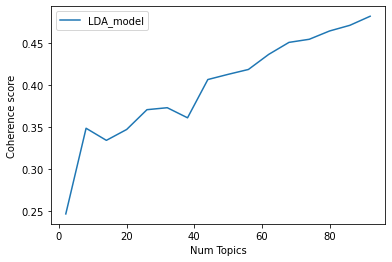

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
# Show graph
limit=98; start=2; step=6;
x = range(start, limit, step)
y_lda = coherence_values_lda

plt.plot(x, y_lda, label='LDA_model')
    
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")    
plt.legend()
plt.savefig('model_lda_coherence_score.png')
plt.show()

In [41]:
# Print the coherence scores
for m, cv in zip(x, coherence_values_lda):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.247
Num Topics = 8  has Coherence Value of 0.3489
Num Topics = 14  has Coherence Value of 0.3345
Num Topics = 20  has Coherence Value of 0.3475
Num Topics = 26  has Coherence Value of 0.371
Num Topics = 32  has Coherence Value of 0.3734
Num Topics = 38  has Coherence Value of 0.3614
Num Topics = 44  has Coherence Value of 0.4069
Num Topics = 50  has Coherence Value of 0.4131
Num Topics = 56  has Coherence Value of 0.4189
Num Topics = 62  has Coherence Value of 0.4368
Num Topics = 68  has Coherence Value of 0.4511
Num Topics = 74  has Coherence Value of 0.4548
Num Topics = 80  has Coherence Value of 0.4647
Num Topics = 86  has Coherence Value of 0.4714
Num Topics = 92  has Coherence Value of 0.4822


In [42]:
optimal_model_lda = model_list_lda[7]

In [43]:
optimal_model_lda.show_topics()

[(39,
  '0.081*"use" + 0.071*"large" + 0.048*"monitor" + 0.041*"account" + 0.039*"population" + 0.029*"analyse" + 0.028*"international" + 0.028*"framework" + 0.028*"machinelearne" + 0.027*"sensor"'),
 (12,
  '0.090*"exploratory" + 0.058*"measure" + 0.050*"bigdata_datascience" + 0.047*"python" + 0.043*"type" + 0.030*"eda_resource" + 0.030*"machinelearning_analytic" + 0.030*"statistics_datamine" + 0.027*"dataliteracy_visualanalytic" + 0.020*"actually"'),
 (8,
  '0.073*"question" + 0.057*"answer" + 0.049*"compare" + 0.046*"white" + 0.045*"step" + 0.038*"likely" + 0.038*"black" + 0.027*"term" + 0.024*"quick" + 0.023*"find"'),
 (28,
  '0.049*"hear" + 0.048*"advanced" + 0.048*"post" + 0.041*"relate" + 0.041*"recent" + 0.040*"list" + 0.037*"idea" + 0.027*"sql" + 0.024*"single" + 0.024*"technique"'),
 (21,
  '0.069*"open" + 0.056*"drone" + 0.052*"cloud" + 0.035*"scientific" + 0.034*"education" + 0.026*"base" + 0.024*"special" + 0.022*"nation" + 0.021*"involve" + 0.018*"proper"'),
 (23,
  '0.14

In [44]:
#import vizualization packages
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
vis = gensimvis.prepare(optimal_model_lda, corpus, id2word )

/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [46]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
25     0.167008  0.179919       1        1  4.374082
22    -0.252815  0.174776       2        1  4.008154
41     0.181087  0.096521       3        1  3.903405
13     0.051456 -0.094620       4        1  3.041742
26     0.165039  0.056528       5        1  2.876555
40     0.168291  0.100591       6        1  2.810983
2      0.048934  0.108692       7        1  2.733082
18     0.099764  0.000874       8        1  2.713911
29     0.094244  0.124939       9        1  2.698953
0      0.167965  0.072593      10        1  2.637126
23     0.035981 -0.020761      11        1  2.629637
30     0.026201 -0.029133      12        1  2.551032
16    -0.149345  0.024133      13        1  2.548527
5     -0.205005  0.073791      14        1  2.522005
37     0.056598 -0.038431      15        1  2.508336
38     0.014025  0.112730      16        1  2.268460
20    -0.068291  0.042936      17        1  2.195197
9      0.004073 -0.073822      18        1  2.156915
7      0.029640 -0.095605      19        1  2.117462
1     -0.043325  0.024569      20        1  2.105279
4     -0.062469  0.132200      21        1  2.089643
33    -0.052549  0.040053      22        1  2.045947
42     0.037834 -0.034498      23        1  2.041477
32    -0.169959  0.073964      24        1  2.023765
3     -0.055556 -0.112383      25        1  1.990686
10     0.041395 -0.062058      26        1  1.984203
15     0.046293 -0.074909      27        1  1.978787
31    -0.122613  0.009468      28        1  1.954789
24     0.080639  0.052324      29        1  1.949466
11     0.013318  0.016226      30        1  1.944739
35    -0.020018 -0.078216      31        1  1.937289
19    -0.049442 -0.034738      32        1  1.876727
43     0.007136 -0.183057      33        1  1.867415
27    -0.033594 -0.010985      34        1  1.851966
36    -0.056242 -0.120605      35        1  1.836155
17    -0.022372  0.024454      36        1  1.830657
21    -0.036010 -0.024773      37        1  1.808547
8     -0.020602 -0.040192      38        1  1.777930
34    -0.033971 -0.076052      39        1  1.764659
14    -0.009792 -0.119468      40        1  1.764413
6     -0.157978  0.074943      41        1  1.758600
28     0.019336 -0.095121      42        1  1.617064
12    -0.000740 -0.109931      43        1  1.498847
39     0.066430 -0.087864      44        1  1.405387, topic_info=                     Term        Freq       Total Category  logprob  loglift
121                 covid  907.000000  907.000000  Default  30.0000  30.0000
259                   big  502.000000  502.000000  Default  29.0000  29.0000
21               research  577.000000  577.000000  Default  28.0000  28.0000
23                   work  682.000000  682.000000  Default  27.0000  27.0000
85                support  474.000000  474.000000  Default  26.0000  26.0000
...                   ...         ...         ...      ...      ...      ...
111                   use  127.540671  680.255461  Topic44  -2.5135   2.5908
518             satellite   18.999295   36.704551  Topic44  -4.4175   3.6064
283   bigdata_datascience   16.920399  101.384510  Topic44  -4.5334   2.4745
81                process   17.632636  177.534678  Topic44  -4.4921   1.9554
2327              bigdata   16.218521   89.398148  Topic44  -4.5757   2.5579

[2000 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2006      7  0.179939  ability
2006     33  0.809727  ability
1756     10  0.113442     able
1756     12  0.581390     able
1756     27  0.283605     able
...     ...       ...      ...
1164     39  0.956110      yet
341      29  0.837693    young
341      42  0.148923    young
217      22  0.958124    youth
41        1  0.889026  youtube

[2836 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[26, 23, 42, 14, 27, 41, 3, 19, 30, 1, 24, 31, 17,

# create TFIDF corpus

In [49]:

from gensim import models
model_tfidf = models.TfidfModel(corpus)
corpus_tfidf = model_tfidf[corpus]

2023-01-01 18:05:04,227 : INFO : collecting document frequencies
2023-01-01 18:05:04,229 : INFO : PROGRESS: processing document #0
2023-01-01 18:05:04,264 : INFO : calculating IDF weights for 10000 documents and 3383 features (107216 matrix non-zeros)


# Train LDA using TFIDF corpus

In [50]:
lda_model_tfidf = gensim.models.ldamodel.LdaModel(
    corpus=corpus_tfidf,
    id2word=id2word,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=400,
    num_topics=10,
    passes=20,
    eval_every=None)

2023-01-01 18:05:08,863 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2023-01-01 18:05:08,866 : INFO : using serial LDA version on this node
2023-01-01 18:05:08,873 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2023-01-01 18:05:09,093 : INFO : PROGRESS: pass 0, at document #2000/10000
2023-01-01 18:05:09,927 : INFO : optimized alpha [0.09161701, 0.09314105, 0.092949055, 0.09281133, 0.09188375, 0.0903815, 0.09231644, 0.089666404, 0.09182477, 0.09172829]
2023-01-01 18:05:09,932 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:05:09,937 : INFO : topic #7 (0.090): 0.008*"apply" + 0.006*"statistic" + 0.006*"research" + 0.005*"data" + 0.005*"dataanalysis" + 0.004*"vehicle" + 0.004*"start" + 0.0

2023-01-01 18:05:15,026 : INFO : optimized alpha [0.1120161, 0.11578654, 0.109302565, 0.11265501, 0.10440231, 0.095215306, 0.12168121, 0.09127984, 0.10932596, 0.10598899]
2023-01-01 18:05:15,031 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:05:15,037 : INFO : topic #7 (0.091): 0.006*"research" + 0.006*"apply" + 0.006*"associate" + 0.005*"local" + 0.005*"risk" + 0.005*"data" + 0.005*"extensive" + 0.005*"matter" + 0.004*"relate" + 0.004*"hospital"
2023-01-01 18:05:15,038 : INFO : topic #5 (0.095): 0.011*"exploratory" + 0.007*"bigdata_datascience" + 0.006*"python" + 0.005*"eda_resource" + 0.005*"statistics_datamine" + 0.005*"machinelearning_analytic" + 0.005*"dataliteracy_visualanalytic" + 0.005*"read" + 0.005*"book" + 0.005*"poor"
2023-01-01 18:05:15,039 : INFO : topic #3 (0.113): 0.006*"support" + 0.006*"provide" + 0.005*"team" + 0.005*"school" + 0.005*"data" + 0.005*"sorry" + 0.004*"good" + 0.004*"happen" + 0.004*"check" + 0.004*"loss"
2023-

2023-01-01 18:05:19,660 : INFO : topic #5 (0.099): 0.014*"exploratory" + 0.009*"bigdata_datascience" + 0.008*"python" + 0.006*"eda_resource" + 0.006*"statistics_datamine" + 0.006*"machinelearning_analytic" + 0.006*"dataliteracy_visualanalytic" + 0.006*"startup" + 0.006*"poor" + 0.005*"machinelearne"
2023-01-01 18:05:19,661 : INFO : topic #0 (0.135): 0.011*"show" + 0.011*"covid" + 0.009*"accord" + 0.008*"county" + 0.008*"rate" + 0.008*"state" + 0.007*"find" + 0.007*"coronavirus" + 0.007*"case" + 0.007*"drone"
2023-01-01 18:05:19,662 : INFO : topic #1 (0.137): 0.006*"data" + 0.005*"visualization" + 0.005*"use" + 0.005*"student" + 0.004*"research" + 0.004*"deep_learne" + 0.004*"work" + 0.004*"community" + 0.004*"statistic" + 0.004*"thank"
2023-01-01 18:05:19,663 : INFO : topic #6 (0.160): 0.008*"data" + 0.006*"work" + 0.006*"learn" + 0.006*"tool" + 0.005*"use" + 0.005*"panda" + 0.005*"get" + 0.004*"think" + 0.004*"day" + 0.004*"great"
2023-01-01 18:05:19,664 : INFO : topic diff=0.168772, 

2023-01-01 18:05:24,204 : INFO : topic #0 (0.165): 0.013*"covid" + 0.012*"show" + 0.009*"accord" + 0.009*"state" + 0.009*"rate" + 0.008*"county" + 0.008*"case" + 0.008*"coronavirus" + 0.007*"find" + 0.006*"drone"
2023-01-01 18:05:24,205 : INFO : topic #6 (0.223): 0.009*"data" + 0.007*"work" + 0.006*"learn" + 0.006*"tool" + 0.006*"use" + 0.005*"think" + 0.005*"get" + 0.005*"great" + 0.005*"good" + 0.004*"day"
2023-01-01 18:05:24,207 : INFO : topic diff=0.121124, rho=0.333333
2023-01-01 18:05:24,429 : INFO : PROGRESS: pass 3, at document #4000/10000
2023-01-01 18:05:25,088 : INFO : optimized alpha [0.17294711, 0.16655894, 0.13975872, 0.1444471, 0.13152638, 0.10400745, 0.24065365, 0.09785555, 0.16312991, 0.13256451]
2023-01-01 18:05:25,093 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:05:25,097 : INFO : topic #7 (0.098): 0.008*"tip" + 0.007*"death_rate" + 0.007*"extensive" + 0.006*"client" + 0.006*"associate" + 0.006*"chain" + 0.006*"scientist"

2023-01-01 18:05:28,763 : INFO : topic diff=0.100992, rho=0.316228
2023-01-01 18:05:28,983 : INFO : PROGRESS: pass 4, at document #4000/10000
2023-01-01 18:05:29,603 : INFO : optimized alpha [0.21362719, 0.19583546, 0.15616369, 0.15895481, 0.14532478, 0.10942277, 0.38385606, 0.102484405, 0.20135127, 0.14522216]
2023-01-01 18:05:29,608 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:05:29,613 : INFO : topic #7 (0.102): 0.009*"tip" + 0.007*"death_rate" + 0.007*"extensive" + 0.007*"associate" + 0.007*"client" + 0.006*"chain" + 0.006*"true" + 0.006*"welcome" + 0.006*"commerce" + 0.006*"humanitarian"
2023-01-01 18:05:29,614 : INFO : topic #5 (0.109): 0.013*"exploratory" + 0.012*"bigdata_datascience" + 0.011*"python" + 0.009*"push" + 0.009*"eda_resource" + 0.009*"interim" + 0.008*"statistics_datamine" + 0.008*"machinelearning_analytic" + 0.008*"efficacy" + 0.008*"startup"
2023-01-01 18:05:29,615 : INFO : topic #8 (0.201): 0.009*"apply" + 0.009*"rese

2023-01-01 18:05:33,727 : INFO : topic #7 (0.109): 0.010*"tip" + 0.008*"extensive" + 0.008*"death_rate" + 0.007*"associate" + 0.007*"client" + 0.007*"true" + 0.007*"welcome" + 0.007*"chain" + 0.006*"recruit" + 0.006*"choose"
2023-01-01 18:05:33,728 : INFO : topic #5 (0.117): 0.013*"exploratory" + 0.013*"python" + 0.012*"bigdata_datascience" + 0.010*"eda_resource" + 0.010*"push" + 0.009*"interim" + 0.009*"statistics_datamine" + 0.009*"machinelearning_analytic" + 0.009*"startup" + 0.008*"poor"
2023-01-01 18:05:33,729 : INFO : topic #8 (0.254): 0.011*"apply" + 0.009*"research" + 0.007*"health" + 0.007*"excel" + 0.006*"development" + 0.006*"hire" + 0.006*"policy" + 0.006*"officer" + 0.006*"job" + 0.006*"statistical"
2023-01-01 18:05:33,730 : INFO : topic #0 (0.272): 0.016*"covid" + 0.016*"show" + 0.012*"accord" + 0.011*"county" + 0.010*"case" + 0.010*"rate" + 0.010*"state" + 0.009*"coronavirus" + 0.008*"find" + 0.007*"high"
2023-01-01 18:05:33,731 : INFO : topic #6 (0.650): 0.011*"data" + 

2023-01-01 18:05:37,724 : INFO : topic #8 (0.329): 0.012*"apply" + 0.008*"research" + 0.008*"hire" + 0.007*"excel" + 0.007*"development" + 0.007*"health" + 0.007*"statistical" + 0.007*"policy" + 0.006*"management" + 0.006*"design"
2023-01-01 18:05:37,725 : INFO : topic #0 (0.354): 0.017*"show" + 0.016*"covid" + 0.014*"accord" + 0.011*"county" + 0.011*"case" + 0.011*"state" + 0.010*"rate" + 0.010*"coronavirus" + 0.008*"find" + 0.008*"pandemic"
2023-01-01 18:05:37,727 : INFO : topic #6 (1.044): 0.011*"data" + 0.008*"work" + 0.008*"learn" + 0.007*"use" + 0.007*"dataanalysis" + 0.006*"good" + 0.006*"tool" + 0.006*"time" + 0.006*"need" + 0.005*"big"
2023-01-01 18:05:37,728 : INFO : topic diff=0.085207, rho=0.288675
2023-01-01 18:05:37,922 : INFO : PROGRESS: pass 6, at document #6000/10000
2023-01-01 18:05:38,430 : INFO : optimized alpha [0.37512106, 0.29113075, 0.2057569, 0.20221207, 0.18302011, 0.12984946, 1.1367799, 0.11870268, 0.3453488, 0.18206722]
2023-01-01 18:05:38,435 : INFO : mergi

2023-01-01 18:05:41,186 : INFO : topic #6 (1.532): 0.011*"data" + 0.008*"learn" + 0.007*"work" + 0.007*"use" + 0.007*"dataanalysis" + 0.006*"big" + 0.006*"good" + 0.006*"time" + 0.006*"need" + 0.006*"tool"
2023-01-01 18:05:41,190 : INFO : topic diff=0.074575, rho=0.277350
2023-01-01 18:05:41,398 : INFO : PROGRESS: pass 7, at document #6000/10000
2023-01-01 18:05:41,846 : INFO : optimized alpha [0.48518378, 0.350624, 0.23547238, 0.22842087, 0.20409313, 0.14230153, 1.6386787, 0.12815772, 0.44196075, 0.20406283]
2023-01-01 18:05:41,850 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:05:41,856 : INFO : topic #7 (0.128): 0.011*"tip" + 0.010*"death_rate" + 0.010*"extensive" + 0.009*"icymi" + 0.009*"client" + 0.009*"topological" + 0.009*"fill" + 0.008*"associate" + 0.008*"humanitarian" + 0.008*"little"
2023-01-01 18:05:41,857 : INFO : topic #5 (0.142): 0.020*"python" + 0.015*"bigdata_datascience" + 0.013*"exploratory" + 0.013*"eda_resource" + 0.013*"

2023-01-01 18:05:44,660 : INFO : PROGRESS: pass 8, at document #6000/10000
2023-01-01 18:05:45,066 : INFO : optimized alpha [0.6097749, 0.41667104, 0.26893514, 0.25753966, 0.2271781, 0.15595551, 2.1838417, 0.13854952, 0.5488888, 0.22868901]
2023-01-01 18:05:45,071 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:05:45,076 : INFO : topic #7 (0.139): 0.012*"tip" + 0.011*"death_rate" + 0.011*"icymi" + 0.010*"extensive" + 0.010*"client" + 0.010*"topological" + 0.009*"humanitarian" + 0.009*"associate" + 0.009*"fill" + 0.008*"little"
2023-01-01 18:05:45,078 : INFO : topic #5 (0.156): 0.021*"python" + 0.015*"bigdata_datascience" + 0.013*"eda_resource" + 0.013*"poor" + 0.013*"exploratory" + 0.013*"statistics_datamine" + 0.013*"machinelearning_analytic" + 0.011*"push" + 0.011*"dataliteracy_visualanalytic" + 0.010*"goal"
2023-01-01 18:05:45,078 : INFO : topic #8 (0.549): 0.013*"apply" + 0.010*"design" + 0.010*"hire" + 0.010*"management" + 0.009*"full" + 

2023-01-01 18:05:48,061 : INFO : topic #7 (0.150): 0.012*"tip" + 0.012*"icymi" + 0.011*"death_rate" + 0.011*"extensive" + 0.010*"client" + 0.010*"topological" + 0.010*"humanitarian" + 0.009*"associate" + 0.009*"fill" + 0.008*"recruit"
2023-01-01 18:05:48,063 : INFO : topic #5 (0.170): 0.021*"python" + 0.016*"bigdata_datascience" + 0.014*"eda_resource" + 0.013*"poor" + 0.013*"statistics_datamine" + 0.013*"machinelearning_analytic" + 0.013*"exploratory" + 0.012*"push" + 0.011*"dataliteracy_visualanalytic" + 0.009*"confirm"
2023-01-01 18:05:48,064 : INFO : topic #8 (0.661): 0.012*"apply" + 0.011*"design" + 0.010*"management" + 0.010*"hire" + 0.009*"full" + 0.009*"drive" + 0.008*"statistical" + 0.008*"excel" + 0.008*"development" + 0.007*"social"
2023-01-01 18:05:48,065 : INFO : topic #0 (0.742): 0.018*"show" + 0.016*"covid" + 0.015*"accord" + 0.014*"case" + 0.012*"state" + 0.012*"coronavirus" + 0.011*"county" + 0.009*"country" + 0.009*"rate" + 0.009*"risk"
2023-01-01 18:05:48,066 : INFO :

2023-01-01 18:05:50,937 : INFO : topic #8 (0.773): 0.012*"apply" + 0.012*"design" + 0.011*"management" + 0.010*"hire" + 0.010*"full" + 0.009*"drive" + 0.008*"statistical" + 0.008*"excel" + 0.008*"social" + 0.007*"economic"
2023-01-01 18:05:50,939 : INFO : topic #0 (0.876): 0.018*"show" + 0.015*"accord" + 0.014*"covid" + 0.014*"case" + 0.013*"state" + 0.012*"coronavirus" + 0.011*"county" + 0.009*"country" + 0.009*"rate" + 0.009*"risk"
2023-01-01 18:05:50,940 : INFO : topic #6 (3.305): 0.010*"data" + 0.008*"learn" + 0.007*"work" + 0.007*"use" + 0.006*"dataanalysis" + 0.006*"covid" + 0.006*"big" + 0.006*"report" + 0.005*"need" + 0.005*"time"
2023-01-01 18:05:50,941 : INFO : topic diff=0.043943, rho=0.250000
2023-01-01 18:05:51,149 : INFO : PROGRESS: pass 10, at document #8000/10000
2023-01-01 18:05:51,501 : INFO : optimized alpha [0.9098852, 0.5720785, 0.35263258, 0.32969254, 0.2818807, 0.18885624, 3.4138558, 0.16379432, 0.7942993, 0.29034072]
2023-01-01 18:05:51,504 : INFO : merging chan

2023-01-01 18:05:53,780 : INFO : topic #6 (3.860): 0.010*"data" + 0.008*"learn" + 0.007*"work" + 0.007*"use" + 0.006*"dataanalysis" + 0.006*"covid" + 0.006*"big" + 0.006*"report" + 0.006*"find" + 0.005*"team"
2023-01-01 18:05:53,781 : INFO : topic diff=0.038022, rho=0.242536
2023-01-01 18:05:53,981 : INFO : PROGRESS: pass 11, at document #8000/10000
2023-01-01 18:05:54,317 : INFO : optimized alpha [1.0444456, 0.643776, 0.39409944, 0.36419144, 0.30876607, 0.20477839, 3.9671812, 0.17549153, 0.90635127, 0.31999588]
2023-01-01 18:05:54,322 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:05:54,326 : INFO : topic #7 (0.175): 0.012*"icymi" + 0.012*"tip" + 0.012*"death_rate" + 0.010*"humanitarian" + 0.010*"extensive" + 0.010*"contain" + 0.010*"client" + 0.009*"topological" + 0.009*"weekend" + 0.008*"recruit"
2023-01-01 18:05:54,328 : INFO : topic #5 (0.205): 0.024*"python" + 0.018*"bigdata_datascience" + 0.016*"eda_resource" + 0.015*"machinelearning_a

2023-01-01 18:05:56,719 : INFO : PROGRESS: pass 12, at document #8000/10000
2023-01-01 18:05:57,054 : INFO : optimized alpha [1.1771955, 0.71484715, 0.4369111, 0.39967662, 0.33650053, 0.22121221, 4.5113726, 0.18738684, 1.0164683, 0.35035568]
2023-01-01 18:05:57,063 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:05:57,070 : INFO : topic #7 (0.187): 0.013*"icymi" + 0.012*"tip" + 0.012*"death_rate" + 0.011*"extensive" + 0.011*"humanitarian" + 0.010*"contain" + 0.010*"client" + 0.010*"topological" + 0.009*"weekend" + 0.009*"recruit"
2023-01-01 18:05:57,072 : INFO : topic #5 (0.221): 0.024*"python" + 0.018*"bigdata_datascience" + 0.016*"eda_resource" + 0.016*"machinelearning_analytic" + 0.016*"statistics_datamine" + 0.014*"dataliteracy_visualanalytic" + 0.014*"poor" + 0.013*"exploratory" + 0.010*"push" + 0.009*"brilliant"
2023-01-01 18:05:57,073 : INFO : topic #8 (1.016): 0.012*"design" + 0.011*"management" + 0.011*"full" + 0.010*"drive" + 0.010*"

2023-01-01 18:05:59,842 : INFO : topic #7 (0.199): 0.013*"icymi" + 0.013*"tip" + 0.012*"death_rate" + 0.011*"extensive" + 0.011*"humanitarian" + 0.010*"contain" + 0.010*"client" + 0.010*"topological" + 0.009*"weekend" + 0.009*"recruit"
2023-01-01 18:05:59,843 : INFO : topic #5 (0.238): 0.024*"python" + 0.018*"bigdata_datascience" + 0.016*"eda_resource" + 0.016*"machinelearning_analytic" + 0.016*"statistics_datamine" + 0.015*"dataliteracy_visualanalytic" + 0.014*"poor" + 0.013*"exploratory" + 0.010*"push" + 0.009*"brilliant"
2023-01-01 18:05:59,844 : INFO : topic #8 (1.124): 0.012*"design" + 0.011*"management" + 0.011*"full" + 0.010*"drive" + 0.010*"hire" + 0.009*"excel" + 0.008*"social" + 0.008*"apply" + 0.008*"economic" + 0.008*"statistical"
2023-01-01 18:05:59,845 : INFO : topic #0 (1.307): 0.017*"show" + 0.017*"coronavirus" + 0.016*"case" + 0.015*"accord" + 0.013*"state" + 0.013*"covid" + 0.011*"county" + 0.010*"update" + 0.010*"country" + 0.010*"rate"
2023-01-01 18:05:59,846 : INFO

2023-01-01 18:06:02,571 : INFO : topic #8 (1.230): 0.012*"design" + 0.011*"management" + 0.011*"full" + 0.010*"drive" + 0.010*"hire" + 0.009*"excel" + 0.009*"social" + 0.008*"economic" + 0.008*"statistical" + 0.008*"apply"
2023-01-01 18:06:02,572 : INFO : topic #0 (1.435): 0.017*"show" + 0.017*"coronavirus" + 0.016*"case" + 0.015*"accord" + 0.014*"state" + 0.012*"covid" + 0.011*"county" + 0.010*"update" + 0.010*"country" + 0.010*"rate"
2023-01-01 18:06:02,574 : INFO : topic #6 (5.571): 0.010*"data" + 0.008*"covid" + 0.007*"learn" + 0.007*"work" + 0.007*"use" + 0.006*"dataanalysis" + 0.006*"big" + 0.006*"report" + 0.006*"find" + 0.006*"research"
2023-01-01 18:06:02,575 : INFO : topic diff=0.030242, rho=0.223607
2023-01-01 18:06:02,766 : INFO : PROGRESS: pass 14, at document #10000/10000
2023-01-01 18:06:03,077 : INFO : optimized alpha [1.4516548, 0.8708565, 0.53635865, 0.48128438, 0.4018926, 0.2594688, 5.6940203, 0.21396276, 1.2588781, 0.41979355]
2023-01-01 18:06:03,081 : INFO : mergin

2023-01-01 18:06:05,215 : INFO : topic #6 (6.086): 0.010*"data" + 0.008*"covid" + 0.007*"learn" + 0.007*"work" + 0.007*"use" + 0.006*"dataanalysis" + 0.006*"big" + 0.006*"report" + 0.006*"find" + 0.006*"research"
2023-01-01 18:06:05,216 : INFO : topic diff=0.028891, rho=0.218218
2023-01-01 18:06:05,423 : INFO : PROGRESS: pass 15, at document #10000/10000
2023-01-01 18:06:05,737 : INFO : optimized alpha [1.5761188, 0.93851435, 0.58123463, 0.51840544, 0.4313446, 0.2772921, 6.2078323, 0.22631472, 1.3617257, 0.4513848]
2023-01-01 18:06:05,741 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:06:05,746 : INFO : topic #7 (0.226): 0.013*"tip" + 0.012*"client" + 0.012*"extensive" + 0.011*"icymi" + 0.011*"recruit" + 0.010*"feedback" + 0.010*"humanitarian" + 0.010*"choice" + 0.010*"death_rate" + 0.010*"topological"
2023-01-01 18:06:05,748 : INFO : topic #5 (0.277): 0.021*"python" + 0.016*"bigdata_datascience" + 0.014*"eda_resource" + 0.014*"machinelearnin

2023-01-01 18:06:08,066 : INFO : PROGRESS: pass 16, at document #10000/10000
2023-01-01 18:06:08,366 : INFO : optimized alpha [1.6981139, 1.005133, 0.6260126, 0.5556995, 0.46114576, 0.29542863, 6.71295, 0.23878789, 1.462492, 0.48317528]
2023-01-01 18:06:08,371 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:06:08,375 : INFO : topic #7 (0.239): 0.013*"tip" + 0.012*"client" + 0.012*"extensive" + 0.011*"icymi" + 0.011*"recruit" + 0.010*"feedback" + 0.010*"humanitarian" + 0.010*"choice" + 0.010*"death_rate" + 0.010*"topological"
2023-01-01 18:06:08,376 : INFO : topic #5 (0.295): 0.021*"python" + 0.016*"bigdata_datascience" + 0.014*"eda_resource" + 0.014*"statistics_datamine" + 0.014*"machinelearning_analytic" + 0.013*"poor" + 0.013*"dataliteracy_visualanalytic" + 0.011*"exploratory" + 0.010*"push" + 0.009*"wonk"
2023-01-01 18:06:08,377 : INFO : topic #8 (1.462): 0.012*"design" + 0.012*"management" + 0.011*"drive" + 0.010*"full" + 0.009*"hire" + 0.

2023-01-01 18:06:11,000 : INFO : topic #7 (0.251): 0.013*"tip" + 0.012*"client" + 0.012*"extensive" + 0.011*"icymi" + 0.011*"recruit" + 0.010*"feedback" + 0.010*"humanitarian" + 0.010*"choice" + 0.010*"death_rate" + 0.010*"topological"
2023-01-01 18:06:11,001 : INFO : topic #5 (0.314): 0.021*"python" + 0.016*"bigdata_datascience" + 0.014*"eda_resource" + 0.014*"machinelearning_analytic" + 0.014*"statistics_datamine" + 0.013*"poor" + 0.013*"dataliteracy_visualanalytic" + 0.010*"exploratory" + 0.010*"push" + 0.009*"wonk"
2023-01-01 18:06:11,001 : INFO : topic #8 (1.561): 0.012*"design" + 0.012*"management" + 0.011*"drive" + 0.010*"full" + 0.009*"hire" + 0.009*"excel" + 0.009*"become" + 0.009*"social" + 0.008*"statistical" + 0.008*"customer"
2023-01-01 18:06:11,002 : INFO : topic #0 (1.818): 0.017*"show" + 0.016*"case" + 0.015*"accord" + 0.014*"coronavirus" + 0.013*"state" + 0.010*"county" + 0.010*"country" + 0.010*"update" + 0.009*"rate" + 0.009*"risk"
2023-01-01 18:06:11,003 : INFO : to

2023-01-01 18:06:13,758 : INFO : topic #8 (1.658): 0.012*"design" + 0.012*"management" + 0.011*"drive" + 0.010*"full" + 0.009*"hire" + 0.009*"excel" + 0.009*"become" + 0.009*"social" + 0.008*"statistical" + 0.008*"customer"
2023-01-01 18:06:13,759 : INFO : topic #0 (1.935): 0.017*"show" + 0.016*"case" + 0.015*"accord" + 0.014*"coronavirus" + 0.013*"state" + 0.010*"county" + 0.010*"country" + 0.010*"update" + 0.009*"rate" + 0.009*"risk"
2023-01-01 18:06:13,760 : INFO : topic #6 (7.699): 0.010*"data" + 0.008*"learn" + 0.007*"work" + 0.007*"use" + 0.007*"covid" + 0.006*"dataanalysis" + 0.006*"big" + 0.006*"research" + 0.006*"find" + 0.006*"team"
2023-01-01 18:06:13,760 : INFO : topic diff=0.030515, rho=0.204124
2023-01-01 18:06:13,958 : INFO : PROGRESS: pass 19, at document #2000/10000
2023-01-01 18:06:14,255 : INFO : optimized alpha [1.9554987, 1.1479079, 0.723182, 0.6347423, 0.52611566, 0.33496588, 7.7859473, 0.26620787, 1.6760005, 0.55128497]
2023-01-01 18:06:14,259 : INFO : merging ch

2023-01-01 18:06:16,301 : INFO : topic #6 (8.182): 0.010*"data" + 0.008*"learn" + 0.007*"work" + 0.007*"use" + 0.007*"covid" + 0.006*"dataanalysis" + 0.006*"big" + 0.006*"research" + 0.006*"find" + 0.006*"team"
2023-01-01 18:06:16,302 : INFO : topic diff=0.029512, rho=0.200000


In [51]:
lda_model_tfidf.show_topics()

[(0,
  '0.017*"show" + 0.016*"case" + 0.015*"accord" + 0.014*"coronavirus" + 0.013*"state" + 0.010*"county" + 0.010*"country" + 0.010*"update" + 0.009*"rate" + 0.009*"risk"'),
 (1,
  '0.010*"review" + 0.009*"advanced" + 0.008*"dashboard" + 0.008*"operation" + 0.008*"decision_make" + 0.008*"inform" + 0.008*"term" + 0.008*"education" + 0.007*"safety" + 0.007*"sport"'),
 (2,
  '0.011*"lockdown" + 0.011*"race" + 0.010*"man" + 0.010*"vote" + 0.010*"win" + 0.009*"energy" + 0.008*"stuff" + 0.008*"bit" + 0.008*"iot" + 0.007*"trump"'),
 (3,
  '0.016*"sorry" + 0.013*"loss" + 0.013*"worker" + 0.012*"contact" + 0.011*"warranty" + 0.011*"ticket" + 0.011*"submit" + 0.010*"turn" + 0.009*"kind" + 0.009*"team_start"'),
 (4,
  '0.016*"manage" + 0.012*"site" + 0.011*"qualitative" + 0.010*"little" + 0.009*"flow" + 0.009*"forecast" + 0.008*"master" + 0.008*"comment" + 0.008*"determine" + 0.008*"instagram"'),
 (5,
  '0.021*"python" + 0.016*"bigdata_datascience" + 0.014*"eda_resource" + 0.014*"machinelearnin

In [52]:
def compute_coherence_values_lda_model_tfidf(dictionary, corpus, texts, limit, start=2, step=6):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values_lda_tfidf = []
    model_list_lda_tfidf = []
    for num_topics in range(start, limit, step):
        lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       chunksize=2000,
                                       alpha='auto',
                                       eta='auto',
                                       iterations=400,
                                       passes=20,
                                       eval_every=None)

        model_list_lda_tfidf.append(lda_model_tfidf)
        coherencemodel_lda_tfidf = CoherenceModel(model=lda_model_tfidf, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_lda_tfidf.append(coherencemodel_lda_tfidf.get_coherence())

    return model_list_lda_tfidf, coherence_values_lda_tfidf

In [53]:
model_list_lda_tfidf, coherence_values_lda_tfidf = compute_coherence_values_lda_model_tfidf(dictionary=id2word,corpus=corpus_tfidf, texts=data_lemmatized, start=2, limit=98, step=6)

2023-01-01 18:07:12,669 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2023-01-01 18:07:12,671 : INFO : using serial LDA version on this node
2023-01-01 18:07:12,675 : INFO : running online (multi-pass) LDA training, 2 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2023-01-01 18:07:12,875 : INFO : PROGRESS: pass 0, at document #2000/10000
2023-01-01 18:07:15,726 : INFO : optimized alpha [0.76123303, 0.76844156]
2023-01-01 18:07:15,728 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:07:15,733 : INFO : topic #0 (0.761): 0.005*"covid" + 0.005*"report" + 0.005*"data" + 0.004*"research" + 0.003*"show" + 0.003*"learn" + 0.003*"work" + 0.003*"pandemic" + 0.003*"use" + 0.003*"team"
2023-01-01 18:07:15,734 : INFO : topic #1 (0.768): 0.005*"dataanalysis" + 0.004*"data" + 0.004*"big" + 0.003*

2023-01-01 18:07:23,927 : INFO : topic #1 (3.446): 0.005*"learn" + 0.005*"dataanalysis" + 0.005*"data" + 0.004*"big" + 0.004*"use" + 0.003*"tool" + 0.003*"apply" + 0.003*"work" + 0.003*"skill" + 0.003*"team"
2023-01-01 18:07:23,928 : INFO : topic diff=0.255503, rho=0.353553
2023-01-01 18:07:24,113 : INFO : PROGRESS: pass 2, at document #4000/10000
2023-01-01 18:07:24,559 : INFO : optimized alpha [3.531867, 3.6958709]
2023-01-01 18:07:24,561 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:07:24,564 : INFO : topic #0 (3.532): 0.006*"covid" + 0.006*"show" + 0.005*"data" + 0.004*"report" + 0.004*"day" + 0.004*"find" + 0.003*"case" + 0.003*"work" + 0.003*"good" + 0.003*"support"
2023-01-01 18:07:24,565 : INFO : topic #1 (3.696): 0.005*"learn" + 0.005*"dataanalysis" + 0.005*"data" + 0.004*"big" + 0.004*"use" + 0.003*"tool" + 0.003*"work" + 0.003*"apply" + 0.003*"business" + 0.003*"need"
2023-01-01 18:07:24,566 : INFO : topic diff=0.244023, rho=0.353

2023-01-01 18:07:30,603 : INFO : topic diff=0.213692, rho=0.316228
2023-01-01 18:07:30,803 : INFO : PROGRESS: pass 4, at document #6000/10000
2023-01-01 18:07:31,183 : INFO : optimized alpha [6.3922334, 6.748048]
2023-01-01 18:07:31,185 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:07:31,188 : INFO : topic #0 (6.392): 0.008*"covid" + 0.006*"show" + 0.004*"data" + 0.004*"case" + 0.004*"report" + 0.004*"day" + 0.004*"find" + 0.003*"good" + 0.003*"time" + 0.003*"provide"
2023-01-01 18:07:31,189 : INFO : topic #1 (6.748): 0.006*"learn" + 0.005*"dataanalysis" + 0.005*"data" + 0.004*"big" + 0.004*"use" + 0.004*"tool" + 0.003*"work" + 0.003*"analytic" + 0.003*"apply" + 0.003*"course"
2023-01-01 18:07:31,191 : INFO : topic diff=0.202090, rho=0.316228
2023-01-01 18:07:31,379 : INFO : PROGRESS: pass 4, at document #8000/10000
2023-01-01 18:07:31,765 : INFO : optimized alpha [6.656648, 7.0269275]
2023-01-01 18:07:31,768 : INFO : merging changes from 20

2023-01-01 18:07:37,415 : INFO : optimized alpha [9.075858, 9.6406555]
2023-01-01 18:07:37,418 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:07:37,420 : INFO : topic #0 (9.076): 0.010*"covid" + 0.006*"show" + 0.005*"case" + 0.004*"data" + 0.004*"report" + 0.004*"coronavirus" + 0.004*"find" + 0.004*"day" + 0.004*"support" + 0.003*"provide"
2023-01-01 18:07:37,421 : INFO : topic #1 (9.641): 0.006*"learn" + 0.005*"dataanalysis" + 0.005*"data" + 0.005*"big" + 0.004*"use" + 0.004*"tool" + 0.003*"work" + 0.003*"skill" + 0.003*"research" + 0.003*"apply"
2023-01-01 18:07:37,422 : INFO : topic diff=0.187066, rho=0.288675
2023-01-01 18:07:37,609 : INFO : PROGRESS: pass 6, at document #10000/10000
2023-01-01 18:07:37,979 : INFO : optimized alpha [9.3083105, 9.951091]
2023-01-01 18:07:37,981 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:07:37,985 : INFO : topic #0 (9.308): 0.007*"covid" + 0.006*"show" + 0.005

2023-01-01 18:07:43,573 : INFO : topic #0 (11.539): 0.007*"covid" + 0.006*"show" + 0.005*"data" + 0.004*"report" + 0.004*"case" + 0.004*"find" + 0.004*"support" + 0.004*"day" + 0.004*"provide" + 0.004*"good"
2023-01-01 18:07:43,574 : INFO : topic #1 (12.372): 0.006*"learn" + 0.005*"data" + 0.005*"dataanalysis" + 0.005*"big" + 0.005*"use" + 0.004*"tool" + 0.004*"work" + 0.004*"skill" + 0.003*"research" + 0.003*"apply"
2023-01-01 18:07:43,575 : INFO : topic diff=0.180613, rho=0.267261
2023-01-01 18:07:43,761 : INFO : PROGRESS: pass 9, at document #2000/10000
2023-01-01 18:07:44,131 : INFO : optimized alpha [11.736744, 12.587817]
2023-01-01 18:07:44,134 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:07:44,136 : INFO : topic #0 (11.737): 0.007*"covid" + 0.006*"show" + 0.005*"report" + 0.004*"data" + 0.004*"find" + 0.004*"case" + 0.004*"support" + 0.004*"provide" + 0.003*"day" + 0.003*"good"
2023-01-01 18:07:44,139 : INFO : topic #1 (12.588): 0.00

2023-01-01 18:07:49,887 : INFO : topic #1 (14.845): 0.006*"learn" + 0.005*"dataanalysis" + 0.005*"data" + 0.005*"use" + 0.005*"big" + 0.004*"tool" + 0.004*"apply" + 0.004*"skill" + 0.004*"research" + 0.004*"work"
2023-01-01 18:07:49,888 : INFO : topic diff=0.163821, rho=0.242536
2023-01-01 18:07:50,070 : INFO : PROGRESS: pass 11, at document #4000/10000
2023-01-01 18:07:50,431 : INFO : optimized alpha [14.012611, 15.030974]
2023-01-01 18:07:50,433 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:07:50,435 : INFO : topic #0 (14.013): 0.007*"covid" + 0.006*"show" + 0.005*"report" + 0.004*"data" + 0.004*"find" + 0.004*"day" + 0.004*"case" + 0.004*"support" + 0.003*"good" + 0.003*"time"
2023-01-01 18:07:50,436 : INFO : topic #1 (15.031): 0.006*"learn" + 0.005*"dataanalysis" + 0.005*"data" + 0.005*"big" + 0.005*"use" + 0.004*"tool" + 0.004*"work" + 0.004*"apply" + 0.003*"research" + 0.003*"business"
2023-01-01 18:07:50,437 : INFO : topic diff=0.1584

2023-01-01 18:07:55,885 : INFO : topic diff=0.148961, rho=0.229416
2023-01-01 18:07:56,063 : INFO : PROGRESS: pass 13, at document #6000/10000
2023-01-01 18:07:56,417 : INFO : optimized alpha [16.145813, 17.345148]
2023-01-01 18:07:56,420 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:07:56,423 : INFO : topic #0 (16.146): 0.008*"covid" + 0.007*"show" + 0.005*"report" + 0.004*"find" + 0.004*"case" + 0.004*"data" + 0.004*"day" + 0.004*"good" + 0.003*"support" + 0.003*"time"
2023-01-01 18:07:56,425 : INFO : topic #1 (17.345): 0.006*"learn" + 0.005*"dataanalysis" + 0.005*"data" + 0.005*"big" + 0.005*"use" + 0.004*"tool" + 0.004*"work" + 0.004*"research" + 0.004*"apply" + 0.003*"skill"
2023-01-01 18:07:56,426 : INFO : topic diff=0.141051, rho=0.229416
2023-01-01 18:07:56,606 : INFO : PROGRESS: pass 13, at document #8000/10000
2023-01-01 18:07:56,943 : INFO : optimized alpha [16.341045, 17.55171]
2023-01-01 18:07:56,945 : INFO : merging changes fro

2023-01-01 18:08:02,402 : INFO : optimized alpha [18.160711, 19.543966]
2023-01-01 18:08:02,404 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:08:02,406 : INFO : topic #0 (18.161): 0.010*"covid" + 0.006*"show" + 0.005*"report" + 0.005*"case" + 0.004*"find" + 0.004*"data" + 0.004*"coronavirus" + 0.004*"day" + 0.004*"support" + 0.004*"provide"
2023-01-01 18:08:02,407 : INFO : topic #1 (19.544): 0.006*"learn" + 0.005*"dataanalysis" + 0.005*"data" + 0.005*"use" + 0.005*"big" + 0.004*"tool" + 0.004*"work" + 0.004*"research" + 0.004*"skill" + 0.003*"apply"
2023-01-01 18:08:02,408 : INFO : topic diff=0.137560, rho=0.218218
2023-01-01 18:08:02,595 : INFO : PROGRESS: pass 15, at document #10000/10000
2023-01-01 18:08:02,936 : INFO : optimized alpha [18.334766, 19.78781]
2023-01-01 18:08:02,938 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:08:02,940 : INFO : topic #0 (18.335): 0.008*"covid" + 0.006*"show" + 

2023-01-01 18:08:08,319 : INFO : topic #0 (20.061): 0.008*"covid" + 0.006*"show" + 0.005*"report" + 0.004*"find" + 0.004*"data" + 0.004*"case" + 0.004*"support" + 0.004*"day" + 0.004*"provide" + 0.004*"good"
2023-01-01 18:08:08,321 : INFO : topic #1 (21.680): 0.006*"learn" + 0.005*"data" + 0.005*"dataanalysis" + 0.005*"use" + 0.005*"big" + 0.004*"tool" + 0.004*"work" + 0.004*"research" + 0.004*"skill" + 0.003*"apply"
2023-01-01 18:08:08,321 : INFO : topic diff=0.137897, rho=0.208514
2023-01-01 18:08:08,513 : INFO : PROGRESS: pass 18, at document #2000/10000
2023-01-01 18:08:08,853 : INFO : optimized alpha [20.219666, 21.854761]
2023-01-01 18:08:08,856 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:08:08,858 : INFO : topic #0 (20.220): 0.008*"covid" + 0.006*"show" + 0.005*"report" + 0.004*"find" + 0.004*"data" + 0.004*"case" + 0.004*"support" + 0.004*"day" + 0.004*"provide" + 0.004*"good"
2023-01-01 18:08:08,860 : INFO : topic #1 (21.855): 0.0

2023-01-01 18:08:14,102 : INFO : accumulator serialized
2023-01-01 18:08:14,104 : INFO : serializing accumulator to return to master...
2023-01-01 18:08:14,110 : INFO : accumulator serialized
2023-01-01 18:08:14,136 : INFO : 3 accumulators retrieved from output queue
2023-01-01 18:08:14,147 : INFO : accumulated word occurrence stats for 7609 virtual documents
2023-01-01 18:08:14,257 : INFO : using autotuned alpha, starting with [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
2023-01-01 18:08:14,259 : INFO : using serial LDA version on this node
2023-01-01 18:08:14,265 : INFO : running online (multi-pass) LDA training, 8 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2023-01-01 18:08:14,457 : INFO : PROGRESS: pass 0, at document #2000/10000
2023-01-01 18:08:15,343 : INFO : optimized alpha [0.11087039, 0.11464861, 0.11212958, 

2023-01-01 18:08:19,733 : INFO : topic #1 (0.141): 0.006*"data" + 0.005*"big" + 0.005*"work" + 0.004*"covid" + 0.004*"learn" + 0.004*"good" + 0.004*"tool" + 0.004*"time" + 0.004*"show" + 0.004*"course"
2023-01-01 18:08:19,734 : INFO : topic #5 (0.141): 0.005*"dataanalysis" + 0.005*"data" + 0.005*"answer" + 0.004*"kill" + 0.004*"great" + 0.004*"work" + 0.004*"question" + 0.004*"do" + 0.004*"link" + 0.004*"think"
2023-01-01 18:08:19,735 : INFO : topic #3 (0.144): 0.007*"drone" + 0.006*"read" + 0.006*"covid" + 0.005*"find" + 0.005*"data" + 0.005*"analytic" + 0.004*"campaign" + 0.004*"use" + 0.004*"learn" + 0.004*"work"
2023-01-01 18:08:19,735 : INFO : topic diff=0.322079, rho=0.447214
2023-01-01 18:08:19,920 : INFO : PROGRESS: pass 1, at document #2000/10000
2023-01-01 18:08:20,729 : INFO : optimized alpha [0.1233139, 0.14306365, 0.13237305, 0.14486367, 0.11751071, 0.14209573, 0.14029163, 0.123457104]
2023-01-01 18:08:20,733 : INFO : merging changes from 2000 documents into a model of 100

2023-01-01 18:08:25,523 : INFO : topic #4 (0.123): 0.007*"number" + 0.006*"accord" + 0.006*"state" + 0.006*"white" + 0.005*"woman" + 0.005*"find" + 0.005*"man" + 0.005*"black" + 0.005*"covid" + 0.005*"employee"
2023-01-01 18:08:25,524 : INFO : topic #0 (0.133): 0.011*"support" + 0.008*"provide" + 0.007*"data" + 0.006*"sorry" + 0.005*"apply" + 0.005*"skill" + 0.005*"happen" + 0.005*"learn" + 0.005*"loss" + 0.005*"case"
2023-01-01 18:08:25,526 : INFO : topic #5 (0.171): 0.006*"dataanalysis" + 0.005*"data" + 0.005*"think" + 0.005*"work" + 0.004*"question" + 0.004*"job" + 0.004*"answer" + 0.004*"great" + 0.004*"want" + 0.004*"do"
2023-01-01 18:08:25,527 : INFO : topic #1 (0.171): 0.006*"data" + 0.005*"big" + 0.005*"covid" + 0.005*"course" + 0.005*"rate" + 0.004*"work" + 0.004*"learn" + 0.004*"county" + 0.004*"report" + 0.004*"part"
2023-01-01 18:08:25,528 : INFO : topic #3 (0.176): 0.006*"covid" + 0.005*"read" + 0.005*"data" + 0.005*"find" + 0.004*"analytic" + 0.004*"learn" + 0.004*"resear

2023-01-01 18:08:30,112 : INFO : topic diff=0.126946, rho=0.333333
2023-01-01 18:08:30,295 : INFO : PROGRESS: pass 3, at document #4000/10000
2023-01-01 18:08:31,019 : INFO : optimized alpha [0.14545159, 0.2192674, 0.17978397, 0.22429238, 0.13258417, 0.2192768, 0.19679591, 0.14555568]
2023-01-01 18:08:31,024 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:08:31,032 : INFO : topic #4 (0.133): 0.008*"voter" + 0.007*"state" + 0.007*"number" + 0.006*"find" + 0.006*"white" + 0.006*"accord" + 0.006*"woman" + 0.006*"covid" + 0.005*"case" + 0.005*"man"
2023-01-01 18:08:31,033 : INFO : topic #0 (0.145): 0.011*"support" + 0.007*"provide" + 0.007*"sorry" + 0.006*"data" + 0.006*"loss" + 0.005*"apply" + 0.005*"learn" + 0.005*"happen" + 0.005*"product" + 0.004*"case"
2023-01-01 18:08:31,034 : INFO : topic #1 (0.219): 0.007*"data" + 0.006*"covid" + 0.005*"course" + 0.005*"big" + 0.005*"rate" + 0.004*"county" + 0.004*"learn" + 0.004*"show" + 0.004*"science" +

2023-01-01 18:08:35,738 : INFO : topic #1 (0.286): 0.007*"data" + 0.006*"covid" + 0.006*"course" + 0.005*"big" + 0.005*"learn" + 0.004*"science" + 0.004*"rate" + 0.004*"show" + 0.004*"county" + 0.004*"base"
2023-01-01 18:08:35,739 : INFO : topic #3 (0.292): 0.006*"read" + 0.006*"covid" + 0.005*"data" + 0.005*"find" + 0.005*"thank" + 0.005*"learn" + 0.005*"story" + 0.005*"analytic" + 0.004*"business" + 0.004*"use"
2023-01-01 18:08:35,740 : INFO : topic diff=0.101447, rho=0.316228
2023-01-01 18:08:35,920 : INFO : PROGRESS: pass 4, at document #6000/10000
2023-01-01 18:08:36,657 : INFO : optimized alpha [0.15841047, 0.30526757, 0.21870102, 0.3103312, 0.14432397, 0.29386222, 0.23523113, 0.15899034]
2023-01-01 18:08:36,661 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:08:36,667 : INFO : topic #4 (0.144): 0.010*"white" + 0.009*"black" + 0.008*"state" + 0.008*"number" + 0.007*"poor" + 0.007*"covid" + 0.007*"voter" + 0.007*"case" + 0.007*"find" + 0.

2023-01-01 18:08:41,151 : INFO : topic #0 (0.171): 0.012*"support" + 0.011*"sorry" + 0.011*"provide" + 0.008*"warranty" + 0.008*"loss" + 0.007*"happen" + 0.007*"apply" + 0.007*"ticket" + 0.006*"product" + 0.006*"diverse"
2023-01-01 18:08:41,153 : INFO : topic #5 (0.401): 0.006*"job" + 0.006*"work" + 0.005*"question" + 0.005*"join" + 0.005*"answer" + 0.005*"data" + 0.005*"career" + 0.004*"link" + 0.004*"talk" + 0.004*"want"
2023-01-01 18:08:41,155 : INFO : topic #3 (0.442): 0.008*"covid" + 0.006*"read" + 0.006*"analytic" + 0.006*"find" + 0.005*"learn" + 0.005*"data" + 0.005*"thank" + 0.005*"use" + 0.004*"business" + 0.004*"story"
2023-01-01 18:08:41,155 : INFO : topic #1 (0.444): 0.008*"data" + 0.008*"covid" + 0.007*"course" + 0.006*"learn" + 0.005*"big" + 0.005*"science" + 0.005*"show" + 0.004*"good" + 0.004*"base" + 0.004*"government"
2023-01-01 18:08:41,156 : INFO : topic diff=0.088865, rho=0.301511
2023-01-01 18:08:41,339 : INFO : PROGRESS: pass 5, at document #8000/10000
2023-01-01

2023-01-01 18:08:45,251 : INFO : PROGRESS: pass 6, at document #8000/10000
2023-01-01 18:08:45,784 : INFO : optimized alpha [0.18937562, 0.72928107, 0.33480126, 0.7066644, 0.17435656, 0.5961348, 0.3365941, 0.19369163]
2023-01-01 18:08:45,788 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:08:45,793 : INFO : topic #4 (0.174): 0.011*"white" + 0.010*"poor" + 0.009*"black" + 0.008*"employee" + 0.008*"submit" + 0.007*"normal" + 0.007*"summer" + 0.006*"learning" + 0.006*"daily" + 0.006*"mortality"
2023-01-01 18:08:45,795 : INFO : topic #0 (0.189): 0.015*"sorry" + 0.014*"support" + 0.013*"loss" + 0.013*"provide" + 0.011*"warranty" + 0.010*"ticket" + 0.008*"happen" + 0.008*"team_start" + 0.008*"contact" + 0.007*"assistance"
2023-01-01 18:08:45,796 : INFO : topic #5 (0.596): 0.008*"job" + 0.006*"work" + 0.006*"question" + 0.005*"join" + 0.005*"answer" + 0.005*"talk" + 0.005*"apply" + 0.005*"link" + 0.004*"career" + 0.004*"data"
2023-01-01 18:08:45,797 

2023-01-01 18:08:49,198 : INFO : topic #3 (1.000): 0.010*"covid" + 0.007*"read" + 0.007*"find" + 0.006*"thank" + 0.006*"analytic" + 0.005*"data" + 0.005*"need" + 0.005*"business" + 0.005*"report" + 0.005*"use"
2023-01-01 18:08:49,198 : INFO : topic #1 (1.051): 0.010*"covid" + 0.009*"data" + 0.007*"learn" + 0.006*"show" + 0.006*"course" + 0.006*"coronavirus" + 0.006*"big" + 0.006*"science" + 0.006*"state" + 0.005*"base"
2023-01-01 18:08:49,200 : INFO : topic diff=0.073510, rho=0.277350
2023-01-01 18:08:49,386 : INFO : PROGRESS: pass 7, at document #10000/10000
2023-01-01 18:08:49,825 : INFO : optimized alpha [0.212858, 1.1246537, 0.41933373, 1.0735832, 0.19635238, 0.854726, 0.40325692, 0.22252913]
2023-01-01 18:08:49,828 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:08:49,832 : INFO : topic #4 (0.196): 0.014*"white" + 0.010*"poor" + 0.009*"employee" + 0.009*"streamlabs_ob" + 0.008*"summer" + 0.007*"stream" + 0.007*"learning" + 0.007*"organize

2023-01-01 18:08:52,911 : INFO : topic #0 (0.234): 0.018*"sorry" + 0.015*"loss" + 0.013*"warranty" + 0.013*"support" + 0.012*"ticket" + 0.010*"provide" + 0.010*"team_start" + 0.009*"please_contact" + 0.009*"happen" + 0.008*"contact"
2023-01-01 18:08:52,912 : INFO : topic #5 (1.089): 0.009*"job" + 0.007*"join" + 0.007*"apply" + 0.006*"work" + 0.006*"link" + 0.006*"talk" + 0.005*"dataanalysis" + 0.005*"look" + 0.005*"question" + 0.005*"watch"
2023-01-01 18:08:52,913 : INFO : topic #3 (1.417): 0.008*"read" + 0.007*"covid" + 0.007*"find" + 0.006*"analytic" + 0.006*"thank" + 0.006*"well" + 0.005*"business" + 0.005*"data" + 0.005*"need" + 0.005*"use"
2023-01-01 18:08:52,916 : INFO : topic #1 (1.504): 0.010*"data" + 0.008*"learn" + 0.007*"covid" + 0.006*"big" + 0.006*"show" + 0.006*"course" + 0.006*"science" + 0.006*"accord" + 0.006*"base" + 0.005*"state"
2023-01-01 18:08:52,917 : INFO : topic diff=0.061744, rho=0.267261
2023-01-01 18:08:53,102 : INFO : PROGRESS: pass 9, at document #2000/100

2023-01-01 18:08:55,853 : INFO : topic diff=0.054504, rho=0.258199
2023-01-01 18:08:56,039 : INFO : PROGRESS: pass 10, at document #2000/10000
2023-01-01 18:08:56,412 : INFO : optimized alpha [0.2601542, 1.9857717, 0.5732122, 1.8425568, 0.23958305, 1.3729745, 0.52709305, 0.2813118]
2023-01-01 18:08:56,416 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:08:56,420 : INFO : topic #4 (0.240): 0.015*"white" + 0.013*"employee" + 0.009*"poor" + 0.009*"summer" + 0.009*"inequality" + 0.008*"organize" + 0.007*"streamlabs_ob" + 0.007*"stream" + 0.007*"learning" + 0.007*"exploit"
2023-01-01 18:08:56,424 : INFO : topic #0 (0.260): 0.016*"sorry" + 0.013*"loss" + 0.011*"ticket" + 0.010*"warranty" + 0.009*"support" + 0.008*"please_contact" + 0.008*"team_start" + 0.008*"file" + 0.007*"operational" + 0.007*"assistance"
2023-01-01 18:08:56,427 : INFO : topic #5 (1.373): 0.009*"job" + 0.008*"apply" + 0.008*"join" + 0.007*"dataanalysis" + 0.006*"work" + 0.006*"tal

2023-01-01 18:08:59,241 : INFO : topic #5 (1.611): 0.009*"job" + 0.009*"apply" + 0.008*"join" + 0.007*"dataanalysis" + 0.006*"work" + 0.006*"talk" + 0.006*"hire" + 0.006*"city" + 0.006*"role" + 0.006*"look"
2023-01-01 18:08:59,242 : INFO : topic #3 (2.207): 0.008*"read" + 0.007*"find" + 0.007*"business" + 0.007*"covid" + 0.006*"analytic" + 0.006*"well" + 0.006*"need" + 0.006*"thank" + 0.006*"report" + 0.005*"system"
2023-01-01 18:08:59,243 : INFO : topic #1 (2.394): 0.010*"data" + 0.008*"learn" + 0.007*"covid" + 0.007*"show" + 0.006*"big" + 0.006*"accord" + 0.006*"base" + 0.006*"science" + 0.006*"course" + 0.006*"team"
2023-01-01 18:08:59,245 : INFO : topic diff=0.054949, rho=0.242536
2023-01-01 18:08:59,427 : INFO : PROGRESS: pass 11, at document #4000/10000
2023-01-01 18:08:59,792 : INFO : optimized alpha [0.29005983, 2.470655, 0.65338796, 2.2731152, 0.26722747, 1.6637592, 0.6015988, 0.3175412]
2023-01-01 18:08:59,796 : INFO : merging changes from 2000 documents into a model of 10000

2023-01-01 18:09:02,683 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:09:02,689 : INFO : topic #4 (0.291): 0.014*"white" + 0.012*"employee" + 0.010*"poor" + 0.009*"stream" + 0.008*"summer" + 0.008*"mobile" + 0.008*"inequality" + 0.008*"learning" + 0.007*"normal" + 0.007*"organize"
2023-01-01 18:09:02,690 : INFO : topic #0 (0.316): 0.016*"sorry" + 0.013*"loss" + 0.011*"ticket" + 0.010*"warranty" + 0.009*"file" + 0.008*"operational" + 0.007*"please_contact" + 0.007*"border" + 0.007*"team_start" + 0.007*"diverse"
2023-01-01 18:09:02,691 : INFO : topic #5 (1.895): 0.009*"apply" + 0.008*"job" + 0.008*"dataanalysis" + 0.008*"join" + 0.006*"talk" + 0.006*"watch" + 0.006*"role" + 0.006*"hire" + 0.006*"look" + 0.006*"project"
2023-01-01 18:09:02,693 : INFO : topic #3 (2.633): 0.008*"read" + 0.007*"find" + 0.007*"business" + 0.006*"covid" + 0.006*"well" + 0.006*"analytic" + 0.006*"need" + 0.006*"thank" + 0.006*"system" + 0.006*"story"
2023-01-01 18:09

2023-01-01 18:09:05,400 : INFO : topic #1 (3.271): 0.010*"data" + 0.008*"learn" + 0.008*"show" + 0.008*"covid" + 0.007*"big" + 0.006*"accord" + 0.006*"base" + 0.006*"team" + 0.006*"science" + 0.005*"use"
2023-01-01 18:09:05,402 : INFO : topic diff=0.039560, rho=0.229416
2023-01-01 18:09:05,601 : INFO : PROGRESS: pass 13, at document #6000/10000
2023-01-01 18:09:05,940 : INFO : optimized alpha [0.34839192, 3.3538244, 0.79863536, 3.0586329, 0.3219504, 2.1625953, 0.73562646, 0.38852134]
2023-01-01 18:09:05,944 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:09:05,948 : INFO : topic #4 (0.322): 0.018*"white" + 0.013*"poor" + 0.010*"employee" + 0.009*"learning" + 0.008*"summer" + 0.008*"normal" + 0.007*"alzheimer" + 0.007*"organize" + 0.007*"stream" + 0.007*"inequality"
2023-01-01 18:09:05,950 : INFO : topic #0 (0.348): 0.018*"sorry" + 0.013*"loss" + 0.012*"warranty" + 0.012*"ticket" + 0.009*"diverse" + 0.009*"file" + 0.008*"logistic" + 0.008*"assi

2023-01-01 18:09:08,788 : INFO : topic #0 (0.376): 0.018*"sorry" + 0.013*"loss" + 0.013*"warranty" + 0.012*"ticket" + 0.009*"diverse" + 0.009*"file" + 0.008*"logistic" + 0.008*"assistance" + 0.008*"team_start" + 0.007*"operational"
2023-01-01 18:09:08,789 : INFO : topic #5 (2.378): 0.009*"apply" + 0.009*"dataanalysis" + 0.008*"join" + 0.008*"job" + 0.006*"look" + 0.006*"talk" + 0.006*"career" + 0.006*"link" + 0.006*"hire" + 0.006*"project"
2023-01-01 18:09:08,790 : INFO : topic #3 (3.401): 0.008*"read" + 0.008*"find" + 0.007*"business" + 0.007*"covid" + 0.007*"analytic" + 0.006*"need" + 0.006*"support" + 0.006*"well" + 0.006*"thank" + 0.006*"story"
2023-01-01 18:09:08,792 : INFO : topic #1 (3.740): 0.011*"data" + 0.009*"covid" + 0.008*"show" + 0.008*"learn" + 0.007*"big" + 0.006*"base" + 0.006*"accord" + 0.006*"course" + 0.006*"day" + 0.006*"science"
2023-01-01 18:09:08,793 : INFO : topic diff=0.032340, rho=0.223607
2023-01-01 18:09:08,972 : INFO : PROGRESS: pass 14, at document #8000/

2023-01-01 18:09:11,439 : INFO : topic diff=0.030565, rho=0.218218
2023-01-01 18:09:11,620 : INFO : PROGRESS: pass 15, at document #8000/10000
2023-01-01 18:09:11,951 : INFO : optimized alpha [0.41099688, 4.191512, 0.94097865, 3.7991576, 0.3791828, 2.6205487, 0.87077004, 0.46147946]
2023-01-01 18:09:11,955 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:09:11,961 : INFO : topic #4 (0.379): 0.015*"white" + 0.013*"poor" + 0.011*"employee" + 0.009*"summer" + 0.009*"normal" + 0.008*"learning" + 0.008*"govt" + 0.008*"mortality" + 0.007*"organize" + 0.007*"alzheimer"
2023-01-01 18:09:11,963 : INFO : topic #0 (0.411): 0.019*"sorry" + 0.016*"loss" + 0.014*"ticket" + 0.013*"warranty" + 0.010*"team_start" + 0.009*"file" + 0.009*"assistance" + 0.009*"please_contact" + 0.009*"aid" + 0.008*"diverse"
2023-01-01 18:09:11,964 : INFO : topic #5 (2.621): 0.009*"apply" + 0.009*"dataanalysis" + 0.009*"job" + 0.008*"join" + 0.007*"look" + 0.006*"talk" + 0.006*"pro

2023-01-01 18:09:14,601 : INFO : topic #5 (2.823): 0.009*"apply" + 0.009*"dataanalysis" + 0.009*"job" + 0.008*"join" + 0.007*"look" + 0.006*"talk" + 0.006*"project" + 0.006*"link" + 0.006*"program" + 0.006*"want"
2023-01-01 18:09:14,602 : INFO : topic #3 (4.123): 0.008*"read" + 0.008*"find" + 0.008*"covid" + 0.007*"business" + 0.007*"support" + 0.007*"need" + 0.006*"analytic" + 0.006*"thank" + 0.006*"story" + 0.006*"well"
2023-01-01 18:09:14,602 : INFO : topic #1 (4.560): 0.011*"data" + 0.010*"covid" + 0.009*"show" + 0.008*"learn" + 0.007*"coronavirus" + 0.007*"big" + 0.006*"accord" + 0.006*"base" + 0.006*"case" + 0.006*"team"
2023-01-01 18:09:14,603 : INFO : topic diff=0.034765, rho=0.213201
2023-01-01 18:09:14,783 : INFO : PROGRESS: pass 16, at document #10000/10000
2023-01-01 18:09:15,107 : INFO : optimized alpha [0.44754615, 4.633892, 1.0165368, 4.2002206, 0.41171107, 2.867913, 0.9450117, 0.50413656]
2023-01-01 18:09:15,111 : INFO : merging changes from 2000 documents into a model 

2023-01-01 18:09:17,711 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:09:17,717 : INFO : topic #4 (0.438): 0.016*"white" + 0.011*"poor" + 0.010*"employee" + 0.009*"summer" + 0.009*"simplify" + 0.009*"streamlabs_ob" + 0.008*"stream" + 0.008*"learning" + 0.008*"organize" + 0.007*"mobile"
2023-01-01 18:09:17,718 : INFO : topic #0 (0.476): 0.019*"sorry" + 0.016*"loss" + 0.013*"warranty" + 0.013*"ticket" + 0.010*"team_start" + 0.010*"please_contact" + 0.009*"file" + 0.008*"diverse" + 0.008*"assistance" + 0.008*"drone_still"
2023-01-01 18:09:17,719 : INFO : topic #5 (3.064): 0.009*"apply" + 0.009*"dataanalysis" + 0.009*"job" + 0.009*"join" + 0.007*"look" + 0.006*"project" + 0.006*"link" + 0.006*"talk" + 0.006*"want" + 0.006*"program"
2023-01-01 18:09:17,721 : INFO : topic #3 (4.516): 0.009*"read" + 0.008*"find" + 0.007*"support" + 0.007*"business" + 0.007*"need" + 0.006*"well" + 0.006*"analytic" + 0.006*"covid" + 0.006*"system" + 0.006*"story"
202

2023-01-01 18:09:20,351 : INFO : topic #1 (5.346): 0.012*"data" + 0.009*"learn" + 0.008*"show" + 0.008*"covid" + 0.007*"big" + 0.006*"team" + 0.006*"base" + 0.006*"use" + 0.006*"accord" + 0.006*"tool"
2023-01-01 18:09:20,352 : INFO : topic diff=0.030116, rho=0.204124
2023-01-01 18:09:20,540 : INFO : PROGRESS: pass 19, at document #2000/10000
2023-01-01 18:09:20,863 : INFO : optimized alpha [0.50873256, 5.414131, 1.1479971, 4.8771067, 0.4678059, 3.289217, 1.0708079, 0.5782484]
2023-01-01 18:09:20,870 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:09:20,876 : INFO : topic #4 (0.468): 0.015*"white" + 0.013*"employee" + 0.010*"poor" + 0.009*"summer" + 0.009*"inequality" + 0.008*"simplify" + 0.008*"organize" + 0.007*"learning" + 0.007*"stream" + 0.007*"streamlabs_ob"
2023-01-01 18:09:20,877 : INFO : topic #0 (0.509): 0.017*"sorry" + 0.014*"loss" + 0.012*"ticket" + 0.011*"warranty" + 0.009*"file" + 0.009*"please_contact" + 0.009*"team_start" + 0.00

2023-01-01 18:09:23,674 : INFO : accumulated word occurrence stats for 8795 virtual documents
2023-01-01 18:09:24,129 : INFO : using autotuned alpha, starting with [0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575]
2023-01-01 18:09:24,132 : INFO : using serial LDA version on this node
2023-01-01 18:09:24,144 : INFO : running online (multi-pass) LDA training, 14 topics, 20 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2023-01-01 18:09:24,328 : INFO : PROGRESS: pass 0, at document #2000/10000
2023-01-01 18:09:25,112 : INFO : optimized alpha [0.06772336, 0.06634754, 0.06672496, 0.06635997, 0.06694017, 0.06755708, 0.06705539, 0.066711, 0.06711338, 0.068348415, 0.068474725, 0.0673336, 0.06785527, 0.06673222]
2023-01-01

2023-01-01 18:09:28,870 : INFO : topic diff=0.274175, rho=0.447214
2023-01-01 18:09:29,084 : INFO : PROGRESS: pass 1, at document #2000/10000
2023-01-01 18:09:29,753 : INFO : optimized alpha [0.077743545, 0.07206884, 0.08102569, 0.072109215, 0.07562165, 0.07506311, 0.0782855, 0.0726729, 0.08013935, 0.09280719, 0.086178094, 0.077064365, 0.083772264, 0.07568088]
2023-01-01 18:09:29,757 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:09:29,766 : INFO : topic #1 (0.072): 0.009*"worker" + 0.006*"conclusion" + 0.006*"smart" + 0.006*"figure" + 0.006*"covid" + 0.006*"spending" + 0.006*"promote" + 0.005*"customer" + 0.005*"powerful" + 0.005*"traditional"
2023-01-01 18:09:29,767 : INFO : topic #3 (0.072): 0.007*"critical" + 0.006*"thread" + 0.006*"staff" + 0.006*"covid" + 0.006*"update" + 0.006*"improvement" + 0.006*"here" + 0.006*"part" + 0.005*"clinical" + 0.005*"statement"
2023-01-01 18:09:29,768 : INFO : topic #12 (0.084): 0.005*"data" + 0.005*"mode

2023-01-01 18:09:34,112 : INFO : topic #7 (0.077): 0.009*"campaign" + 0.007*"collaboration" + 0.007*"patent" + 0.006*"maybe" + 0.006*"power" + 0.006*"instruction" + 0.006*"exist" + 0.006*"multi" + 0.006*"worth" + 0.006*"drug"
2023-01-01 18:09:34,113 : INFO : topic #12 (0.099): 0.005*"use" + 0.005*"work" + 0.005*"good" + 0.005*"many" + 0.005*"data" + 0.005*"research" + 0.005*"covid" + 0.004*"model" + 0.004*"sale" + 0.004*"privacy"
2023-01-01 18:09:34,114 : INFO : topic #10 (0.104): 0.007*"back" + 0.007*"police" + 0.005*"answer" + 0.005*"data" + 0.005*"work" + 0.005*"covid" + 0.005*"graduate" + 0.005*"stop" + 0.005*"crisis" + 0.005*"question"
2023-01-01 18:09:34,117 : INFO : topic #9 (0.125): 0.011*"learn" + 0.008*"skill" + 0.008*"analytic" + 0.007*"data" + 0.007*"tool" + 0.006*"course" + 0.006*"need" + 0.006*"business" + 0.006*"big" + 0.006*"use"
2023-01-01 18:09:34,118 : INFO : topic diff=0.159728, rho=0.353553
2023-01-01 18:09:34,321 : INFO : PROGRESS: pass 2, at document #4000/10000


2023-01-01 18:09:38,413 : INFO : topic #9 (0.175): 0.011*"learn" + 0.009*"skill" + 0.008*"data" + 0.007*"analytic" + 0.007*"tool" + 0.007*"need" + 0.006*"business" + 0.006*"course" + 0.006*"use" + 0.006*"big"
2023-01-01 18:09:38,414 : INFO : topic diff=0.113869, rho=0.333333
2023-01-01 18:09:38,601 : INFO : PROGRESS: pass 3, at document #4000/10000
2023-01-01 18:09:39,188 : INFO : optimized alpha [0.094485134, 0.08366499, 0.10622614, 0.08409788, 0.09293809, 0.089125, 0.09875958, 0.08295561, 0.109051764, 0.18700248, 0.13096917, 0.10110477, 0.12092663, 0.09186211]
2023-01-01 18:09:39,196 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:09:39,203 : INFO : topic #7 (0.083): 0.012*"efficacy" + 0.009*"clinical_trial" + 0.008*"vaccine" + 0.008*"campaign" + 0.007*"exist" + 0.007*"confirm" + 0.007*"sputnikv" + 0.007*"election" + 0.007*"single" + 0.007*"maybe"
2023-01-01 18:09:39,206 : INFO : topic #1 (0.084): 0.012*"worker" + 0.012*"food" + 0.010*"trump

2023-01-01 18:09:43,350 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:09:43,359 : INFO : topic #7 (0.088): 0.013*"efficacy" + 0.010*"clinical_trial" + 0.009*"vaccine" + 0.008*"sputnikv" + 0.008*"exist" + 0.008*"confirm" + 0.008*"single" + 0.008*"twitter" + 0.007*"election" + 0.007*"political"
2023-01-01 18:09:43,360 : INFO : topic #1 (0.090): 0.013*"food" + 0.012*"worker" + 0.010*"trump" + 0.009*"smart" + 0.008*"poll" + 0.008*"buy" + 0.008*"bank" + 0.008*"pfizer" + 0.008*"show" + 0.008*"rapid"
2023-01-01 18:09:43,361 : INFO : topic #12 (0.143): 0.007*"compare" + 0.006*"good" + 0.006*"many" + 0.006*"piece" + 0.005*"brand" + 0.005*"work" + 0.005*"listen" + 0.005*"covid" + 0.005*"use" + 0.005*"story"
2023-01-01 18:09:43,362 : INFO : topic #10 (0.158): 0.008*"answer" + 0.007*"police" + 0.007*"back" + 0.006*"question" + 0.006*"day" + 0.006*"covid" + 0.005*"decision" + 0.005*"example" + 0.005*"system" + 0.005*"step"
2023-01-01 18:09:43,363 : INFO 

2023-01-01 18:09:47,311 : INFO : topic #12 (0.170): 0.007*"compare" + 0.006*"brand" + 0.006*"good" + 0.006*"piece" + 0.006*"advance" + 0.006*"listen" + 0.005*"almost" + 0.005*"put" + 0.005*"podcast" + 0.005*"kind"
2023-01-01 18:09:47,312 : INFO : topic #10 (0.191): 0.009*"answer" + 0.007*"question" + 0.007*"back" + 0.007*"police" + 0.006*"covid" + 0.006*"end" + 0.006*"step" + 0.006*"test" + 0.006*"example" + 0.006*"day"
2023-01-01 18:09:47,313 : INFO : topic #9 (0.531): 0.011*"learn" + 0.011*"data" + 0.008*"dataanalysis" + 0.007*"work" + 0.007*"tool" + 0.007*"use" + 0.007*"big" + 0.007*"need" + 0.006*"business" + 0.006*"skill"
2023-01-01 18:09:47,318 : INFO : topic diff=0.080871, rho=0.301511
2023-01-01 18:09:47,720 : INFO : PROGRESS: pass 5, at document #6000/10000
2023-01-01 18:09:48,268 : INFO : optimized alpha [0.11511192, 0.09832979, 0.13678905, 0.097940035, 0.11148417, 0.10510879, 0.12107715, 0.09496466, 0.14335318, 0.59623414, 0.20017661, 0.1326038, 0.17514555, 0.10874349]
2023-

2023-01-01 18:09:51,187 : INFO : topic diff=0.075655, rho=0.288675
2023-01-01 18:09:51,375 : INFO : PROGRESS: pass 6, at document #6000/10000
2023-01-01 18:09:51,879 : INFO : optimized alpha [0.12675984, 0.10753748, 0.15434112, 0.10578916, 0.122561075, 0.11473866, 0.13491142, 0.10223418, 0.16148704, 0.99048424, 0.24759047, 0.14971632, 0.21084332, 0.11853923]
2023-01-01 18:09:51,884 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:09:51,893 : INFO : topic #7 (0.102): 0.013*"efficacy" + 0.012*"confirm" + 0.011*"multi" + 0.011*"brain" + 0.011*"open_source" + 0.010*"clinical_trial" + 0.010*"exist" + 0.010*"drug" + 0.010*"maybe" + 0.010*"collaboration"
2023-01-01 18:09:51,894 : INFO : topic #3 (0.106): 0.021*"excel" + 0.014*"critical" + 0.012*"staff" + 0.011*"coach" + 0.011*"clinical" + 0.010*"yet" + 0.010*"happy" + 0.009*"here" + 0.009*"incredible" + 0.008*"regard"
2023-01-01 18:09:51,894 : INFO : topic #12 (0.211): 0.008*"piece" + 0.008*"compare" 

2023-01-01 18:09:55,357 : INFO : topic #3 (0.115): 0.027*"excel" + 0.015*"critical" + 0.013*"staff" + 0.012*"coach" + 0.012*"clinical" + 0.011*"yet" + 0.011*"happy" + 0.011*"leader" + 0.010*"here" + 0.010*"incredible"
2023-01-01 18:09:55,358 : INFO : topic #12 (0.258): 0.010*"compare" + 0.009*"piece" + 0.008*"full" + 0.008*"last" + 0.008*"almost" + 0.008*"brand" + 0.007*"place" + 0.007*"listen" + 0.007*"value" + 0.007*"thing"
2023-01-01 18:09:55,359 : INFO : topic #10 (0.314): 0.010*"test" + 0.010*"police" + 0.009*"answer" + 0.009*"example" + 0.008*"end" + 0.008*"back" + 0.008*"step" + 0.008*"testing" + 0.008*"stop" + 0.008*"trend"
2023-01-01 18:09:55,360 : INFO : topic #9 (1.462): 0.011*"data" + 0.009*"covid" + 0.009*"learn" + 0.008*"work" + 0.007*"dataanalysis" + 0.007*"use" + 0.007*"research" + 0.007*"big" + 0.006*"need" + 0.006*"find"
2023-01-01 18:09:55,361 : INFO : topic diff=0.072497, rho=0.277350
2023-01-01 18:09:55,548 : INFO : PROGRESS: pass 7, at document #8000/10000
2023-01

2023-01-01 18:09:58,618 : INFO : topic #9 (1.959): 0.011*"data" + 0.010*"covid" + 0.008*"learn" + 0.007*"work" + 0.007*"use" + 0.007*"dataanalysis" + 0.007*"show" + 0.006*"research" + 0.006*"big" + 0.006*"find"
2023-01-01 18:09:58,619 : INFO : topic diff=0.063446, rho=0.267261
2023-01-01 18:09:58,797 : INFO : PROGRESS: pass 8, at document #8000/10000
2023-01-01 18:09:59,205 : INFO : optimized alpha [0.15560277, 0.13196056, 0.20244959, 0.1263155, 0.15120545, 0.14000154, 0.17375529, 0.1211964, 0.2094803, 2.0672476, 0.4246004, 0.19581969, 0.33333892, 0.14467493]
2023-01-01 18:09:59,209 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:09:59,216 : INFO : topic #7 (0.121): 0.014*"exist" + 0.014*"multi" + 0.014*"worth" + 0.013*"picture" + 0.013*"confirm" + 0.011*"efficacy" + 0.011*"single" + 0.011*"open_source" + 0.011*"clinical_trial" + 0.010*"brain"
2023-01-01 18:09:59,218 : INFO : topic #3 (0.126): 0.033*"excel" + 0.018*"staff" + 0.016*"critical" +

2023-01-01 18:10:02,315 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:10:02,321 : INFO : topic #7 (0.131): 0.015*"worth" + 0.015*"confirm" + 0.014*"exist" + 0.014*"multi" + 0.014*"picture" + 0.013*"single" + 0.012*"efficacy" + 0.012*"open_source" + 0.011*"clinical_trial" + 0.011*"brain"
2023-01-01 18:10:02,323 : INFO : topic #3 (0.136): 0.036*"excel" + 0.018*"staff" + 0.014*"coach" + 0.014*"clinical" + 0.014*"leader" + 0.013*"medicine" + 0.013*"happy" + 0.013*"consultant" + 0.012*"here" + 0.012*"incredible"
2023-01-01 18:10:02,324 : INFO : topic #12 (0.409): 0.012*"last" + 0.011*"compare" + 0.010*"full" + 0.009*"value" + 0.008*"piece" + 0.008*"place" + 0.008*"move" + 0.007*"listen" + 0.007*"view" + 0.007*"hope"
2023-01-01 18:10:02,325 : INFO : topic #10 (0.535): 0.011*"test" + 0.010*"key" + 0.010*"power" + 0.009*"death" + 0.009*"drive" + 0.009*"answer" + 0.009*"city" + 0.009*"trend" + 0.008*"different" + 0.008*"back"
2023-01-01 18:10:02,326 

2023-01-01 18:10:05,270 : INFO : topic #12 (0.493): 0.013*"last" + 0.010*"compare" + 0.010*"full" + 0.008*"value" + 0.008*"piece" + 0.008*"less" + 0.008*"move" + 0.008*"place" + 0.007*"game" + 0.007*"miss"
2023-01-01 18:10:05,271 : INFO : topic #10 (0.656): 0.011*"test" + 0.011*"death" + 0.011*"key" + 0.010*"power" + 0.010*"drive" + 0.010*"first" + 0.009*"trend" + 0.009*"city" + 0.009*"answer" + 0.008*"different"
2023-01-01 18:10:05,272 : INFO : topic #9 (3.057): 0.012*"covid" + 0.011*"data" + 0.008*"learn" + 0.008*"show" + 0.007*"work" + 0.007*"use" + 0.007*"dataanalysis" + 0.006*"find" + 0.006*"research" + 0.006*"big"
2023-01-01 18:10:05,273 : INFO : topic diff=0.043085, rho=0.250000
2023-01-01 18:10:05,457 : INFO : PROGRESS: pass 10, at document #10000/10000
2023-01-01 18:10:05,832 : INFO : optimized alpha [0.18732534, 0.16054748, 0.259095, 0.14901003, 0.18406627, 0.16820344, 0.22115205, 0.14324133, 0.26810604, 3.1709685, 0.6800498, 0.25104994, 0.5128704, 0.17536037]
2023-01-01 18:1

2023-01-01 18:10:08,060 : INFO : topic diff=0.036686, rho=0.242536
2023-01-01 18:10:08,243 : INFO : PROGRESS: pass 11, at document #10000/10000
2023-01-01 18:10:08,591 : INFO : optimized alpha [0.20294023, 0.17460245, 0.28732848, 0.15972812, 0.19954434, 0.18168502, 0.24402615, 0.15422414, 0.29631558, 3.6503117, 0.8039761, 0.27914217, 0.60084754, 0.19032316]
2023-01-01 18:10:08,596 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:10:08,602 : INFO : topic #7 (0.154): 0.019*"worth" + 0.017*"confirm" + 0.015*"single" + 0.014*"exist" + 0.014*"maybe" + 0.013*"multi" + 0.012*"instruction" + 0.012*"brain" + 0.012*"picture" + 0.011*"text"
2023-01-01 18:10:08,604 : INFO : topic #3 (0.160): 0.039*"excel" + 0.019*"staff" + 0.018*"coach" + 0.017*"leader" + 0.015*"improvement" + 0.014*"happy" + 0.014*"clinical" + 0.013*"here" + 0.013*"medicine" + 0.013*"yet"
2023-01-01 18:10:08,605 : INFO : topic #12 (0.601): 0.014*"last" + 0.010*"less" + 0.010*"full" + 0.00

2023-01-01 18:10:11,254 : INFO : topic #3 (0.171): 0.040*"excel" + 0.019*"staff" + 0.018*"coach" + 0.018*"leader" + 0.015*"happy" + 0.015*"improvement" + 0.014*"clinical" + 0.013*"here" + 0.013*"medicine" + 0.013*"yet"
2023-01-01 18:10:11,255 : INFO : topic #12 (0.689): 0.014*"last" + 0.010*"less" + 0.010*"full" + 0.009*"game" + 0.009*"compare" + 0.009*"piece" + 0.008*"critical" + 0.008*"play" + 0.008*"collaboration" + 0.008*"value"
2023-01-01 18:10:11,255 : INFO : topic #10 (0.928): 0.011*"drive" + 0.011*"first" + 0.011*"key" + 0.010*"city" + 0.010*"result" + 0.010*"power" + 0.010*"test" + 0.009*"thing" + 0.009*"public" + 0.009*"trend"
2023-01-01 18:10:11,256 : INFO : topic #9 (4.120): 0.011*"data" + 0.009*"covid" + 0.008*"learn" + 0.008*"work" + 0.007*"use" + 0.007*"show" + 0.006*"big" + 0.006*"dataanalysis" + 0.006*"research" + 0.006*"find"
2023-01-01 18:10:11,257 : INFO : topic diff=0.028696, rho=0.235702
2023-01-01 18:10:11,457 : INFO : PROGRESS: pass 13, at document #2000/10000
2

2023-01-01 18:10:13,849 : INFO : topic #9 (4.581): 0.011*"data" + 0.009*"covid" + 0.008*"learn" + 0.008*"work" + 0.007*"use" + 0.007*"show" + 0.006*"big" + 0.006*"dataanalysis" + 0.006*"research" + 0.006*"find"
2023-01-01 18:10:13,850 : INFO : topic diff=0.025349, rho=0.229416
2023-01-01 18:10:14,039 : INFO : PROGRESS: pass 14, at document #2000/10000
2023-01-01 18:10:14,371 : INFO : optimized alpha [0.23921685, 0.20719217, 0.35217822, 0.18391976, 0.23583737, 0.21237458, 0.2971685, 0.17986771, 0.36066085, 4.6441903, 1.0691843, 0.34595898, 0.78973246, 0.22520101]
2023-01-01 18:10:14,377 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:10:14,384 : INFO : topic #7 (0.180): 0.019*"worth" + 0.015*"exist" + 0.015*"single" + 0.015*"confirm" + 0.013*"multi" + 0.013*"efficacy" + 0.012*"maybe" + 0.011*"picture" + 0.011*"brain" + 0.011*"upcoming"
2023-01-01 18:10:14,386 : INFO : topic #3 (0.184): 0.034*"excel" + 0.018*"staff" + 0.018*"leader" + 0.017*"coa

2023-01-01 18:10:16,937 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:10:16,942 : INFO : topic #7 (0.192): 0.019*"worth" + 0.015*"exist" + 0.015*"single" + 0.015*"confirm" + 0.013*"multi" + 0.013*"efficacy" + 0.012*"maybe" + 0.011*"picture" + 0.011*"brain" + 0.011*"audience"
2023-01-01 18:10:16,944 : INFO : topic #3 (0.196): 0.035*"excel" + 0.019*"leader" + 0.018*"staff" + 0.017*"coach" + 0.013*"clinical" + 0.013*"here" + 0.013*"improvement" + 0.012*"medicine" + 0.012*"happy" + 0.012*"ddj"
2023-01-01 18:10:16,945 : INFO : topic #12 (0.875): 0.014*"last" + 0.010*"game" + 0.010*"less" + 0.010*"full" + 0.009*"compare" + 0.009*"combine" + 0.008*"value" + 0.008*"play" + 0.008*"bad" + 0.008*"collaboration"
2023-01-01 18:10:16,946 : INFO : topic #10 (1.188): 0.012*"first" + 0.012*"key" + 0.011*"result" + 0.011*"drive" + 0.010*"city" + 0.010*"power" + 0.010*"public" + 0.010*"trend" + 0.009*"thing" + 0.009*"death"
2023-01-01 18:10:16,947 : INFO : top

2023-01-01 18:10:19,439 : INFO : topic #12 (0.958): 0.014*"last" + 0.010*"game" + 0.010*"full" + 0.010*"less" + 0.009*"combine" + 0.009*"compare" + 0.008*"value" + 0.008*"bad" + 0.008*"play" + 0.008*"piece"
2023-01-01 18:10:19,440 : INFO : topic #10 (1.304): 0.012*"first" + 0.012*"result" + 0.011*"key" + 0.011*"drive" + 0.010*"city" + 0.010*"public" + 0.010*"power" + 0.010*"trend" + 0.010*"thing" + 0.009*"death"
2023-01-01 18:10:19,441 : INFO : topic #9 (5.544): 0.011*"data" + 0.009*"covid" + 0.008*"learn" + 0.007*"work" + 0.007*"use" + 0.007*"dataanalysis" + 0.007*"show" + 0.007*"report" + 0.007*"research" + 0.006*"big"
2023-01-01 18:10:19,442 : INFO : topic diff=0.033899, rho=0.213201
2023-01-01 18:10:19,625 : INFO : PROGRESS: pass 16, at document #4000/10000
2023-01-01 18:10:19,921 : INFO : optimized alpha [0.2781247, 0.2428836, 0.42138737, 0.2097033, 0.27376738, 0.24462433, 0.35331878, 0.20734403, 0.4283924, 5.6237736, 1.3272202, 0.419109, 0.9750395, 0.2633547]
2023-01-01 18:10:19,

2023-01-01 18:10:21,946 : INFO : topic diff=0.032644, rho=0.208514
2023-01-01 18:10:22,130 : INFO : PROGRESS: pass 17, at document #4000/10000
2023-01-01 18:10:22,419 : INFO : optimized alpha [0.2961658, 0.2592426, 0.45384127, 0.2218773, 0.29135504, 0.2595857, 0.379869, 0.22030298, 0.4600075, 6.064264, 1.4400768, 0.45283848, 1.0564836, 0.28112382]
2023-01-01 18:10:22,423 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:10:22,429 : INFO : topic #7 (0.220): 0.020*"efficacy" + 0.018*"worth" + 0.017*"single" + 0.017*"confirm" + 0.016*"exist" + 0.014*"clinical_trial" + 0.012*"sputnikv" + 0.011*"brain" + 0.011*"independent" + 0.011*"multi"
2023-01-01 18:10:22,431 : INFO : topic #3 (0.222): 0.040*"excel" + 0.020*"leader" + 0.016*"staff" + 0.016*"coach" + 0.014*"clinical" + 0.013*"yet" + 0.013*"here" + 0.012*"happy" + 0.012*"improvement" + 0.012*"ddj"
2023-01-01 18:10:22,432 : INFO : topic #12 (1.056): 0.015*"last" + 0.010*"compare" + 0.010*"full" + 0.

2023-01-01 18:10:25,227 : INFO : topic #3 (0.234): 0.040*"excel" + 0.020*"leader" + 0.016*"staff" + 0.016*"coach" + 0.014*"clinical" + 0.013*"yet" + 0.013*"here" + 0.012*"happy" + 0.012*"improvement" + 0.012*"ddj"
2023-01-01 18:10:25,228 : INFO : topic #12 (1.136): 0.015*"last" + 0.010*"full" + 0.010*"compare" + 0.010*"game" + 0.010*"combine" + 0.009*"less" + 0.009*"play" + 0.008*"piece" + 0.008*"bad" + 0.008*"announce"
2023-01-01 18:10:25,229 : INFO : topic #10 (1.551): 0.013*"result" + 0.013*"first" + 0.011*"drive" + 0.011*"key" + 0.010*"public" + 0.010*"power" + 0.010*"vaccine" + 0.010*"trend" + 0.010*"election" + 0.009*"thing"
2023-01-01 18:10:25,230 : INFO : topic #9 (6.500): 0.011*"data" + 0.009*"covid" + 0.008*"learn" + 0.008*"show" + 0.007*"work" + 0.007*"use" + 0.007*"dataanalysis" + 0.006*"report" + 0.006*"find" + 0.006*"big"
2023-01-01 18:10:25,231 : INFO : topic diff=0.021047, rho=0.204124
2023-01-01 18:10:25,415 : INFO : PROGRESS: pass 18, at document #6000/10000
2023-01-0

2023-01-01 18:10:27,756 : INFO : topic #9 (6.932): 0.011*"data" + 0.009*"covid" + 0.008*"learn" + 0.008*"show" + 0.007*"work" + 0.007*"use" + 0.007*"dataanalysis" + 0.006*"report" + 0.006*"find" + 0.006*"big"
2023-01-01 18:10:27,757 : INFO : topic diff=0.020261, rho=0.200000
2023-01-01 18:10:27,945 : INFO : PROGRESS: pass 19, at document #6000/10000
2023-01-01 18:10:28,222 : INFO : optimized alpha [0.33663565, 0.2954956, 0.52711827, 0.24902004, 0.32985258, 0.29314002, 0.43898207, 0.24915887, 0.5300742, 7.0270796, 1.684504, 0.5292876, 1.2296803, 0.3212671]
2023-01-01 18:10:28,228 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:10:28,234 : INFO : topic #3 (0.249): 0.039*"excel" + 0.020*"leader" + 0.018*"staff" + 0.016*"coach" + 0.015*"clinical" + 0.014*"yet" + 0.014*"happy" + 0.013*"here" + 0.013*"incredible" + 0.012*"ddj"
2023-01-01 18:10:28,236 : INFO : topic #7 (0.249): 0.018*"confirm" + 0.018*"worth" + 0.017*"single" + 0.017*"efficacy" + 0.0

2023-01-01 18:10:32,637 : INFO : topic #5 (0.048): 0.015*"big" + 0.008*"brand" + 0.007*"sale" + 0.007*"lab" + 0.007*"model" + 0.006*"data" + 0.006*"presentation" + 0.006*"example" + 0.006*"software" + 0.006*"operation"
2023-01-01 18:10:32,638 : INFO : topic #14 (0.048): 0.012*"real_time" + 0.011*"important" + 0.007*"strengthen" + 0.007*"tool" + 0.007*"ultimate" + 0.006*"competitor" + 0.006*"real" + 0.006*"mandate" + 0.006*"project" + 0.006*"offer"
2023-01-01 18:10:32,639 : INFO : topic #15 (0.050): 0.022*"phase" + 0.017*"covid_vaccine" + 0.014*"trial" + 0.010*"vote" + 0.009*"raw" + 0.008*"efficacy" + 0.008*"show" + 0.007*"sputnikv" + 0.006*"voting" + 0.006*"planet"
2023-01-01 18:10:32,640 : INFO : topic #4 (0.051): 0.013*"final" + 0.008*"show" + 0.008*"easy" + 0.008*"industry" + 0.008*"curve_within" + 0.008*"sociallistening_explore" + 0.008*"incredible_article" + 0.008*"stay_ahead" + 0.008*"socialmedia" + 0.007*"ve"
2023-01-01 18:10:32,641 : INFO : topic #17 (0.051): 0.007*"drive" + 0.

2023-01-01 18:10:36,848 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:10:36,858 : INFO : topic #5 (0.052): 0.013*"big" + 0.011*"brand" + 0.011*"sale" + 0.010*"lab" + 0.009*"senior" + 0.009*"model" + 0.008*"click" + 0.008*"presentation" + 0.008*"visualisation" + 0.008*"analyse"
2023-01-01 18:10:36,859 : INFO : topic #14 (0.053): 0.013*"important" + 0.010*"visualization" + 0.010*"strengthen" + 0.010*"real" + 0.009*"focus" + 0.009*"tool" + 0.008*"evaluation" + 0.007*"ability" + 0.007*"clinical" + 0.007*"quick"
2023-01-01 18:10:36,860 : INFO : topic #11 (0.059): 0.014*"final" + 0.011*"day" + 0.010*"show" + 0.008*"submit" + 0.007*"learn" + 0.007*"county" + 0.007*"vaccine" + 0.006*"welcome" + 0.006*"top" + 0.006*"say"
2023-01-01 18:10:36,862 : INFO : topic #0 (0.059): 0.011*"dataanalysis" + 0.010*"love" + 0.009*"work" + 0.009*"type" + 0.006*"bias" + 0.006*"day" + 0.006*"voice" + 0.006*"manage" + 0.006*"partner" + 0.006*"prove"
2023-01-01 18:10:36,

2023-01-01 18:10:40,837 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:10:40,845 : INFO : topic #5 (0.057): 0.013*"big" + 0.011*"brand" + 0.011*"lab" + 0.011*"sale" + 0.010*"model" + 0.010*"senior" + 0.009*"visualisation" + 0.009*"presentation" + 0.008*"hire" + 0.008*"position"
2023-01-01 18:10:40,846 : INFO : topic #14 (0.058): 0.014*"important" + 0.011*"visualization" + 0.011*"focus" + 0.010*"strengthen" + 0.010*"real" + 0.010*"tool" + 0.010*"evaluation" + 0.010*"quick" + 0.008*"conference" + 0.008*"well"
2023-01-01 18:10:40,846 : INFO : topic #11 (0.067): 0.017*"final" + 0.013*"day" + 0.011*"show" + 0.009*"vaccine" + 0.008*"county" + 0.008*"submit" + 0.007*"learn" + 0.007*"vaccination" + 0.007*"welcome" + 0.007*"top"
2023-01-01 18:10:40,847 : INFO : topic #0 (0.068): 0.009*"work" + 0.009*"love" + 0.009*"type" + 0.008*"manage" + 0.007*"partner" + 0.007*"dataanalysis" + 0.007*"excellent" + 0.006*"innovative" + 0.006*"bias" + 0.006*"voice"
20

2023-01-01 18:10:44,777 : INFO : topic #5 (0.062): 0.012*"big" + 0.012*"lab" + 0.011*"sale" + 0.011*"brand" + 0.010*"model" + 0.010*"hire" + 0.010*"senior" + 0.009*"position" + 0.009*"visualisation" + 0.008*"presentation"
2023-01-01 18:10:44,778 : INFO : topic #14 (0.063): 0.014*"important" + 0.011*"tool" + 0.011*"strengthen" + 0.011*"quick" + 0.011*"focus" + 0.011*"evaluation" + 0.011*"real" + 0.010*"visualization" + 0.009*"conference" + 0.009*"well"
2023-01-01 18:10:44,780 : INFO : topic #11 (0.076): 0.019*"final" + 0.013*"day" + 0.011*"vaccine" + 0.011*"show" + 0.009*"county" + 0.008*"submit" + 0.008*"vaccination" + 0.007*"welcome" + 0.007*"top" + 0.007*"say"
2023-01-01 18:10:44,781 : INFO : topic #0 (0.077): 0.009*"type" + 0.009*"work" + 0.008*"love" + 0.008*"manage" + 0.008*"partner" + 0.007*"innovative" + 0.007*"excellent" + 0.007*"monitor" + 0.007*"fight" + 0.006*"bias"
2023-01-01 18:10:44,782 : INFO : topic #17 (0.106): 0.009*"thank" + 0.008*"case" + 0.008*"much" + 0.008*"suppo

2023-01-01 18:10:48,637 : INFO : topic #14 (0.069): 0.014*"important" + 0.012*"quick" + 0.011*"evaluation" + 0.011*"tool" + 0.011*"strengthen" + 0.011*"focus" + 0.011*"real" + 0.010*"well" + 0.010*"critical" + 0.009*"conference"
2023-01-01 18:10:48,638 : INFO : topic #2 (0.086): 0.011*"average" + 0.010*"report" + 0.010*"race" + 0.009*"covid" + 0.009*"record" + 0.008*"do" + 0.008*"ever" + 0.008*"test" + 0.008*"election" + 0.008*"believe"
2023-01-01 18:10:48,639 : INFO : topic #0 (0.087): 0.009*"manage" + 0.009*"type" + 0.008*"love" + 0.008*"partner" + 0.008*"innovative" + 0.007*"excellent" + 0.007*"work" + 0.007*"technology" + 0.007*"monitor" + 0.007*"fight"
2023-01-01 18:10:48,640 : INFO : topic #17 (0.138): 0.009*"thank" + 0.008*"case" + 0.008*"work" + 0.008*"much" + 0.008*"support" + 0.008*"think" + 0.008*"time" + 0.007*"data" + 0.007*"update" + 0.007*"good"
2023-01-01 18:10:48,641 : INFO : topic diff=0.076421, rho=0.316228
2023-01-01 18:10:48,824 : INFO : PROGRESS: pass 4, at docume

2023-01-01 18:10:52,489 : INFO : topic #2 (0.098): 0.011*"average" + 0.010*"report" + 0.010*"race" + 0.010*"covid" + 0.009*"record" + 0.009*"election" + 0.009*"test" + 0.008*"ever" + 0.008*"low" + 0.008*"region"
2023-01-01 18:10:52,490 : INFO : topic #0 (0.098): 0.009*"manage" + 0.009*"type" + 0.008*"excellent" + 0.008*"innovative" + 0.008*"partner" + 0.007*"technology" + 0.007*"love" + 0.007*"monitor" + 0.007*"space" + 0.007*"enable"
2023-01-01 18:10:52,491 : INFO : topic #17 (0.188): 0.009*"thank" + 0.009*"work" + 0.008*"good" + 0.008*"time" + 0.008*"data" + 0.008*"think" + 0.008*"support" + 0.008*"case" + 0.008*"much" + 0.007*"result"
2023-01-01 18:10:52,492 : INFO : topic diff=0.068049, rho=0.301511
2023-01-01 18:10:52,681 : INFO : PROGRESS: pass 5, at document #6000/10000
2023-01-01 18:10:53,244 : INFO : optimized alpha [0.09982622, 0.07574411, 0.100076966, 0.07823046, 0.0884633, 0.07464588, 0.083683245, 0.07908553, 0.08352405, 0.08129857, 0.08109718, 0.09708132, 0.097150914, 0.08

2023-01-01 18:10:56,376 : INFO : topic #2 (0.110): 0.011*"average" + 0.010*"election" + 0.010*"race" + 0.010*"covid" + 0.010*"test" + 0.009*"low" + 0.009*"report" + 0.009*"record" + 0.009*"ever" + 0.009*"current"
2023-01-01 18:10:56,377 : INFO : topic #17 (0.281): 0.009*"data" + 0.009*"work" + 0.009*"good" + 0.009*"time" + 0.008*"thank" + 0.008*"support" + 0.008*"think" + 0.007*"case" + 0.007*"much" + 0.007*"take"
2023-01-01 18:10:56,378 : INFO : topic diff=0.064055, rho=0.288675
2023-01-01 18:10:56,573 : INFO : PROGRESS: pass 6, at document #6000/10000
2023-01-01 18:10:57,135 : INFO : optimized alpha [0.11188219, 0.08132559, 0.1130882, 0.08419099, 0.097053975, 0.08057415, 0.09049362, 0.08531434, 0.090023875, 0.08783978, 0.087436855, 0.10730238, 0.10862995, 0.098423004, 0.08038699, 0.09863431, 0.094387226, 0.31072253, 0.09797403, 0.08358243]
2023-01-01 18:10:57,141 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:10:57,149 : INFO : topic #14 (0

2023-01-01 18:11:00,140 : INFO : topic #17 (0.462): 0.012*"data" + 0.010*"work" + 0.009*"good" + 0.009*"time" + 0.008*"support" + 0.008*"find" + 0.008*"covid" + 0.007*"take" + 0.007*"thank" + 0.007*"team"
2023-01-01 18:11:00,143 : INFO : topic diff=0.064975, rho=0.277350
2023-01-01 18:11:00,341 : INFO : PROGRESS: pass 7, at document #6000/10000
2023-01-01 18:11:00,854 : INFO : optimized alpha [0.12553975, 0.087392725, 0.12765343, 0.090640016, 0.106340475, 0.08680445, 0.097891465, 0.0918453, 0.096856445, 0.095186576, 0.09450763, 0.11873566, 0.12058592, 0.1082493, 0.08647806, 0.10820599, 0.10390567, 0.515205, 0.10728006, 0.08945644]
2023-01-01 18:11:00,864 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:00,871 : INFO : topic #14 (0.086): 0.020*"important" + 0.016*"real" + 0.014*"evaluation" + 0.013*"quick" + 0.012*"conference" + 0.012*"step" + 0.012*"master" + 0.011*"critical" + 0.010*"strengthen" + 0.010*"track"
2023-01-01 18:11:00,873 : INF

2023-01-01 18:11:03,964 : INFO : topic diff=0.063821, rho=0.267261
2023-01-01 18:11:04,150 : INFO : PROGRESS: pass 8, at document #6000/10000
2023-01-01 18:11:04,623 : INFO : optimized alpha [0.14185192, 0.09447298, 0.14439817, 0.09807074, 0.11658035, 0.0933513, 0.10620788, 0.09883259, 0.10452318, 0.103579625, 0.10249026, 0.13191691, 0.13440038, 0.11927197, 0.09335231, 0.11884132, 0.11457247, 0.81344455, 0.11775428, 0.09630089]
2023-01-01 18:11:04,634 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:04,649 : INFO : topic #14 (0.093): 0.021*"important" + 0.018*"real" + 0.015*"evaluation" + 0.014*"quick" + 0.013*"step" + 0.013*"conference" + 0.013*"master" + 0.011*"critical" + 0.011*"building" + 0.011*"track"
2023-01-01 18:11:04,651 : INFO : topic #5 (0.093): 0.019*"lab" + 0.017*"brand" + 0.015*"hire" + 0.014*"click" + 0.013*"position" + 0.011*"expertise" + 0.011*"senior" + 0.011*"benefit" + 0.011*"analyse" + 0.010*"visualisation"
2023-01-01 1

2023-01-01 18:11:07,825 : INFO : PROGRESS: pass 9, at document #6000/10000
2023-01-01 18:11:08,331 : INFO : optimized alpha [0.16107385, 0.10251019, 0.16357921, 0.10643884, 0.12810895, 0.10022699, 0.11556009, 0.10647177, 0.11276562, 0.1130154, 0.11130902, 0.1469998, 0.15049551, 0.13162506, 0.100938894, 0.13073461, 0.12635826, 1.1576796, 0.12948313, 0.10395588]
2023-01-01 18:11:08,339 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:08,346 : INFO : topic #5 (0.100): 0.021*"lab" + 0.019*"brand" + 0.017*"hire" + 0.015*"click" + 0.014*"position" + 0.013*"expertise" + 0.012*"benefit" + 0.012*"analyse" + 0.012*"senior" + 0.011*"visualisation"
2023-01-01 18:11:08,348 : INFO : topic #14 (0.101): 0.023*"important" + 0.019*"real" + 0.016*"evaluation" + 0.015*"conference" + 0.015*"quick" + 0.014*"step" + 0.013*"master" + 0.012*"building" + 0.012*"critical" + 0.011*"strengthen"
2023-01-01 18:11:08,349 : INFO : topic #0 (0.161): 0.014*"technology" + 0.01

2023-01-01 18:11:11,724 : INFO : optimized alpha [0.18371579, 0.11121195, 0.18620852, 0.11548178, 0.14069231, 0.10730232, 0.12566547, 0.11462623, 0.12154844, 0.123243466, 0.120802715, 0.16414768, 0.16917591, 0.14531223, 0.10903751, 0.14365968, 0.13909069, 1.4990523, 0.14246587, 0.11226654]
2023-01-01 18:11:11,729 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:11,736 : INFO : topic #5 (0.107): 0.023*"lab" + 0.020*"brand" + 0.018*"hire" + 0.017*"click" + 0.015*"position" + 0.014*"expertise" + 0.014*"analyse" + 0.013*"senior" + 0.013*"benefit" + 0.012*"visualisation"
2023-01-01 18:11:11,737 : INFO : topic #14 (0.109): 0.024*"important" + 0.020*"real" + 0.016*"evaluation" + 0.016*"conference" + 0.015*"quick" + 0.014*"master" + 0.013*"step" + 0.013*"building" + 0.012*"critical" + 0.012*"strengthen"
2023-01-01 18:11:11,739 : INFO : topic #0 (0.184): 0.017*"technology" + 0.012*"manage" + 0.012*"effort" + 0.012*"excellent" + 0.012*"type" + 0.012*"

2023-01-01 18:11:15,081 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:15,089 : INFO : topic #5 (0.114): 0.024*"lab" + 0.021*"brand" + 0.017*"hire" + 0.016*"position" + 0.015*"senior" + 0.015*"expertise" + 0.015*"analyse" + 0.014*"benefit" + 0.013*"visualisation" + 0.013*"click"
2023-01-01 18:11:15,091 : INFO : topic #14 (0.118): 0.024*"important" + 0.020*"real" + 0.017*"evaluation" + 0.016*"conference" + 0.015*"quick" + 0.014*"master" + 0.013*"building" + 0.013*"step" + 0.012*"critical" + 0.012*"strengthen"
2023-01-01 18:11:15,092 : INFO : topic #0 (0.211): 0.019*"technology" + 0.013*"effort" + 0.012*"manage" + 0.012*"partner" + 0.012*"monitor" + 0.012*"type" + 0.012*"excellent" + 0.011*"search" + 0.011*"space" + 0.010*"predict"
2023-01-01 18:11:15,093 : INFO : topic #2 (0.213): 0.018*"test" + 0.016*"election" + 0.016*"death" + 0.016*"say" + 0.014*"ever" + 0.014*"race" + 0.014*"school" + 0.013*"low" + 0.013*"combine" + 0.012*"wrong"
2023-

2023-01-01 18:11:18,372 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:18,379 : INFO : topic #5 (0.121): 0.025*"lab" + 0.022*"brand" + 0.018*"position" + 0.017*"hire" + 0.016*"senior" + 0.016*"expertise" + 0.016*"analyse" + 0.015*"benefit" + 0.014*"visualisation" + 0.013*"dataanalytic"
2023-01-01 18:11:18,380 : INFO : topic #14 (0.126): 0.023*"important" + 0.021*"real" + 0.017*"conference" + 0.017*"evaluation" + 0.016*"quick" + 0.014*"master" + 0.014*"building" + 0.013*"clinical" + 0.012*"strengthen" + 0.012*"step"
2023-01-01 18:11:18,381 : INFO : topic #0 (0.243): 0.021*"technology" + 0.013*"effort" + 0.012*"partner" + 0.012*"manage" + 0.012*"monitor" + 0.011*"type" + 0.011*"excellent" + 0.011*"search" + 0.011*"enable" + 0.010*"space"
2023-01-01 18:11:18,382 : INFO : topic #2 (0.247): 0.019*"test" + 0.018*"election" + 0.018*"say" + 0.017*"death" + 0.015*"low" + 0.014*"school" + 0.014*"ever" + 0.013*"race" + 0.013*"combine" + 0.012*"area"


2023-01-01 18:11:21,617 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:21,624 : INFO : topic #5 (0.128): 0.026*"lab" + 0.023*"brand" + 0.020*"position" + 0.017*"senior" + 0.017*"hire" + 0.016*"analyse" + 0.016*"expertise" + 0.016*"benefit" + 0.014*"visualisation" + 0.014*"outcome"
2023-01-01 18:11:21,625 : INFO : topic #14 (0.135): 0.022*"important" + 0.021*"real" + 0.018*"conference" + 0.017*"evaluation" + 0.016*"quick" + 0.015*"building" + 0.015*"master" + 0.014*"employee" + 0.013*"clinical" + 0.013*"spatial"
2023-01-01 18:11:21,626 : INFO : topic #0 (0.282): 0.023*"technology" + 0.012*"effort" + 0.012*"enable" + 0.012*"monitor" + 0.012*"partner" + 0.012*"sign" + 0.012*"manage" + 0.011*"type" + 0.011*"real_time" + 0.011*"center"
2023-01-01 18:11:21,627 : INFO : topic #2 (0.287): 0.022*"say" + 0.019*"election" + 0.018*"death" + 0.018*"test" + 0.015*"school" + 0.015*"low" + 0.014*"area" + 0.013*"community" + 0.013*"health" + 0.013*"ever"
2

2023-01-01 18:11:24,936 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:24,942 : INFO : topic #5 (0.136): 0.028*"lab" + 0.025*"brand" + 0.021*"position" + 0.018*"senior" + 0.017*"analyse" + 0.016*"benefit" + 0.016*"expertise" + 0.016*"outcome" + 0.015*"visualisation" + 0.014*"production"
2023-01-01 18:11:24,943 : INFO : topic #14 (0.144): 0.020*"real" + 0.018*"conference" + 0.018*"important" + 0.018*"evaluation" + 0.017*"quick" + 0.016*"building" + 0.016*"employee" + 0.015*"master" + 0.014*"spatial" + 0.014*"clinical"
2023-01-01 18:11:24,945 : INFO : topic #0 (0.328): 0.025*"technology" + 0.013*"real_time" + 0.013*"enable" + 0.012*"sign" + 0.012*"method" + 0.012*"center" + 0.012*"effort" + 0.012*"monitor" + 0.012*"partner" + 0.011*"type"
2023-01-01 18:11:24,946 : INFO : topic #2 (0.335): 0.024*"say" + 0.020*"election" + 0.019*"death" + 0.017*"test" + 0.016*"school" + 0.015*"area" + 0.015*"community" + 0.015*"health" + 0.014*"low" + 0.012*"e

2023-01-01 18:11:28,130 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:28,139 : INFO : topic #5 (0.143): 0.029*"lab" + 0.026*"brand" + 0.020*"position" + 0.019*"senior" + 0.018*"analyse" + 0.017*"outcome" + 0.016*"visualisation" + 0.015*"credit" + 0.015*"production" + 0.015*"benefit"
2023-01-01 18:11:28,141 : INFO : topic #14 (0.154): 0.020*"real" + 0.019*"conference" + 0.019*"evaluation" + 0.017*"employee" + 0.017*"quick" + 0.017*"building" + 0.015*"master" + 0.015*"spatial" + 0.014*"clinical" + 0.014*"ability"
2023-01-01 18:11:28,141 : INFO : topic #0 (0.381): 0.025*"technology" + 0.015*"real_time" + 0.014*"method" + 0.013*"join" + 0.013*"center" + 0.013*"enable" + 0.013*"sign" + 0.011*"partner" + 0.011*"monitor" + 0.011*"effort"
2023-01-01 18:11:28,142 : INFO : topic #2 (0.392): 0.026*"say" + 0.019*"election" + 0.018*"death" + 0.017*"school" + 0.017*"community" + 0.017*"test" + 0.016*"health" + 0.015*"area" + 0.014*"low" + 0.013*"presen

2023-01-01 18:11:31,252 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:31,260 : INFO : topic #5 (0.150): 0.031*"lab" + 0.027*"brand" + 0.020*"senior" + 0.019*"position" + 0.019*"analyse" + 0.018*"outcome" + 0.017*"visualisation" + 0.016*"credit" + 0.016*"production" + 0.015*"dataanalytic"
2023-01-01 18:11:31,261 : INFO : topic #14 (0.163): 0.020*"conference" + 0.019*"evaluation" + 0.018*"employee" + 0.018*"building" + 0.018*"quick" + 0.017*"real" + 0.016*"master" + 0.015*"spatial" + 0.015*"ability" + 0.015*"clinical"
2023-01-01 18:11:31,262 : INFO : topic #0 (0.441): 0.024*"technology" + 0.017*"join" + 0.016*"real_time" + 0.015*"method" + 0.013*"center" + 0.013*"enable" + 0.013*"sign" + 0.012*"fast" + 0.012*"policy" + 0.011*"watch"
2023-01-01 18:11:31,263 : INFO : topic #2 (0.454): 0.027*"say" + 0.019*"election" + 0.018*"death" + 0.017*"community" + 0.017*"school" + 0.017*"health" + 0.016*"test" + 0.015*"important" + 0.015*"area" + 0.013*"

2023-01-01 18:11:34,156 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:34,164 : INFO : topic #5 (0.156): 0.033*"lab" + 0.028*"brand" + 0.022*"senior" + 0.020*"analyse" + 0.019*"outcome" + 0.017*"visualisation" + 0.017*"credit" + 0.017*"production" + 0.016*"dataanalytic" + 0.015*"interpret"
2023-01-01 18:11:34,165 : INFO : topic #14 (0.173): 0.020*"conference" + 0.020*"evaluation" + 0.019*"building" + 0.019*"employee" + 0.018*"quick" + 0.016*"master" + 0.016*"spatial" + 0.016*"ability" + 0.015*"clinical" + 0.014*"strengthen"
2023-01-01 18:11:34,166 : INFO : topic #0 (0.504): 0.023*"technology" + 0.020*"join" + 0.016*"real_time" + 0.015*"method" + 0.014*"center" + 0.013*"watch" + 0.013*"live" + 0.013*"policy" + 0.013*"sign" + 0.012*"fast"
2023-01-01 18:11:34,166 : INFO : topic #2 (0.522): 0.027*"say" + 0.018*"election" + 0.018*"community" + 0.018*"health" + 0.017*"important" + 0.017*"school" + 0.017*"death" + 0.015*"test" + 0.015*"area" + 0.

2023-01-01 18:11:36,918 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:36,925 : INFO : topic #5 (0.163): 0.036*"lab" + 0.029*"brand" + 0.024*"senior" + 0.020*"analyse" + 0.019*"outcome" + 0.018*"production" + 0.018*"visualisation" + 0.018*"credit" + 0.017*"dataanalytic" + 0.016*"interpret"
2023-01-01 18:11:36,926 : INFO : topic #14 (0.183): 0.021*"conference" + 0.020*"building" + 0.020*"evaluation" + 0.019*"employee" + 0.019*"quick" + 0.017*"master" + 0.016*"ability" + 0.016*"spatial" + 0.016*"clinical" + 0.015*"strengthen"
2023-01-01 18:11:36,927 : INFO : topic #0 (0.571): 0.023*"technology" + 0.022*"join" + 0.016*"real_time" + 0.015*"method" + 0.015*"watch" + 0.015*"live" + 0.013*"center" + 0.013*"policy" + 0.013*"fast" + 0.013*"sign"
2023-01-01 18:11:36,928 : INFO : topic #2 (0.592): 0.027*"say" + 0.018*"important" + 0.018*"health" + 0.018*"community" + 0.018*"election" + 0.017*"school" + 0.017*"death" + 0.016*"webinar" + 0.015*"test" +

2023-01-01 18:11:39,642 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:39,650 : INFO : topic #5 (0.170): 0.038*"lab" + 0.030*"brand" + 0.025*"senior" + 0.021*"analyse" + 0.020*"outcome" + 0.019*"production" + 0.018*"visualisation" + 0.018*"credit" + 0.017*"dataanalytic" + 0.016*"interpret"
2023-01-01 18:11:39,652 : INFO : topic #14 (0.193): 0.021*"conference" + 0.021*"building" + 0.020*"evaluation" + 0.020*"employee" + 0.019*"quick" + 0.017*"master" + 0.016*"ability" + 0.016*"spatial" + 0.016*"clinical" + 0.015*"strengthen"
2023-01-01 18:11:39,653 : INFO : topic #0 (0.638): 0.024*"join" + 0.023*"technology" + 0.016*"live" + 0.016*"watch" + 0.016*"real_time" + 0.015*"method" + 0.014*"policy" + 0.013*"center" + 0.013*"opportunity" + 0.013*"fast"
2023-01-01 18:11:39,653 : INFO : topic #2 (0.664): 0.027*"say" + 0.019*"important" + 0.019*"health" + 0.018*"community" + 0.017*"election" + 0.017*"school" + 0.016*"webinar" + 0.016*"death" + 0.015*"

2023-01-01 18:11:45,034 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:45,046 : INFO : topic #10 (0.038): 0.015*"bundle" + 0.013*"delete" + 0.012*"prevent" + 0.011*"qualitative" + 0.010*"aw" + 0.008*"cool" + 0.007*"read" + 0.007*"mistake" + 0.007*"pipeline" + 0.006*"full"
2023-01-01 18:11:45,048 : INFO : topic #22 (0.038): 0.016*"clinical_trial" + 0.013*"dataset" + 0.011*"analyst" + 0.009*"confidently" + 0.008*"introduce" + 0.008*"write_code" + 0.008*"apress" + 0.007*"function" + 0.007*"scented" + 0.007*"candle"
2023-01-01 18:11:45,050 : INFO : topic #19 (0.039): 0.029*"final" + 0.014*"day" + 0.013*"show" + 0.012*"tip" + 0.011*"pfizer" + 0.011*"dataanalysis" + 0.008*"ballot" + 0.007*"tie" + 0.007*"planet" + 0.007*"vaccine"
2023-01-01 18:11:45,054 : INFO : topic #16 (0.039): 0.010*"love" + 0.010*"death_rate" + 0.009*"damage" + 0.009*"measure" + 0.009*"high" + 0.008*"covid" + 0.008*"user" + 0.007*"come" + 0.007*"vacancy" + 0.007*"learning"
2

2023-01-01 18:11:48,406 : INFO : topic diff=0.257277, rho=0.377964
2023-01-01 18:11:48,589 : INFO : PROGRESS: pass 1, at document #4000/10000
2023-01-01 18:11:49,157 : INFO : optimized alpha [0.041491427, 0.04768517, 0.045746338, 0.04114758, 0.041774802, 0.04422162, 0.046589945, 0.042564876, 0.046320528, 0.043530457, 0.042388003, 0.042928208, 0.045508232, 0.041912645, 0.046100147, 0.042361714, 0.0454053, 0.042419586, 0.042357974, 0.04559842, 0.043674123, 0.040875364, 0.0406574, 0.043222383, 0.0420118, 0.04402908]
2023-01-01 18:11:49,164 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:49,172 : INFO : topic #22 (0.041): 0.015*"dataset" + 0.014*"train" + 0.013*"clinical_trial" + 0.011*"introduce" + 0.011*"treatment" + 0.011*"programming" + 0.010*"library" + 0.010*"modern" + 0.010*"function" + 0.010*"thinking"
2023-01-01 18:11:49,174 : INFO : topic #21 (0.041): 0.020*"officer" + 0.016*"regional" + 0.015*"race" + 0.014*"break" + 0.013*"miss" + 0

2023-01-01 18:11:52,261 : INFO : topic #8 (0.053): 0.015*"drone" + 0.010*"worker" + 0.009*"decade" + 0.008*"report" + 0.008*"accord" + 0.008*"member" + 0.008*"investigation" + 0.008*"team" + 0.008*"send" + 0.007*"testing"
2023-01-01 18:11:52,262 : INFO : topic #1 (0.054): 0.011*"datascience" + 0.010*"rate" + 0.010*"covid" + 0.008*"account" + 0.007*"methodology" + 0.007*"data" + 0.007*"accord" + 0.007*"infection" + 0.007*"growth" + 0.007*"ability"
2023-01-01 18:11:52,263 : INFO : topic diff=0.194716, rho=0.353553
2023-01-01 18:11:52,446 : INFO : PROGRESS: pass 2, at document #4000/10000
2023-01-01 18:11:52,993 : INFO : optimized alpha [0.04489681, 0.055715896, 0.051727276, 0.044293474, 0.045150723, 0.04984656, 0.053638227, 0.047827885, 0.054054536, 0.048402756, 0.047231227, 0.047633547, 0.053401858, 0.046133935, 0.053104673, 0.047023, 0.051353667, 0.046357226, 0.046292, 0.051784065, 0.049064517, 0.043968722, 0.043860424, 0.047739822, 0.04607722, 0.050057]
2023-01-01 18:11:53,003 : INFO 

2023-01-01 18:11:56,061 : INFO : topic #3 (0.047): 0.023*"framework" + 0.019*"loss" + 0.017*"selection" + 0.017*"forecasting" + 0.016*"advance" + 0.016*"timeserie" + 0.014*"iot_iiot" + 0.014*"unsupervised_feature" + 0.014*"iotpl_iotcommunity" + 0.013*"sensor"
2023-01-01 18:11:56,062 : INFO : topic #12 (0.061): 0.010*"workshop" + 0.010*"use" + 0.009*"data" + 0.009*"dashboard" + 0.009*"hand" + 0.009*"need" + 0.009*"learn" + 0.009*"machine_learne" + 0.009*"tool" + 0.008*"panda"
2023-01-01 18:11:56,063 : INFO : topic #8 (0.061): 0.015*"drone" + 0.011*"worker" + 0.009*"report" + 0.009*"case" + 0.008*"investigation" + 0.008*"member" + 0.008*"decade" + 0.008*"testing" + 0.008*"accord" + 0.008*"death"
2023-01-01 18:11:56,065 : INFO : topic #1 (0.063): 0.011*"datascience" + 0.011*"covid" + 0.010*"rate" + 0.009*"account" + 0.008*"accord" + 0.007*"pandemic" + 0.007*"data" + 0.007*"infection" + 0.007*"ability" + 0.007*"country"
2023-01-01 18:11:56,066 : INFO : topic diff=0.119976, rho=0.333333
202

2023-01-01 18:11:59,762 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:11:59,771 : INFO : topic #3 (0.050): 0.023*"framework" + 0.020*"loss" + 0.018*"selection" + 0.017*"forecasting" + 0.016*"advance" + 0.016*"timeserie" + 0.014*"unsupervised_feature" + 0.014*"iot_iiot" + 0.014*"iotpl_iotcommunity" + 0.014*"matter"
2023-01-01 18:11:59,772 : INFO : topic #22 (0.050): 0.017*"term" + 0.017*"train" + 0.016*"startup" + 0.015*"treatment" + 0.014*"programming" + 0.014*"dataset" + 0.014*"capital" + 0.013*"automate" + 0.013*"library" + 0.013*"modern"
2023-01-01 18:11:59,773 : INFO : topic #8 (0.071): 0.015*"drone" + 0.010*"worker" + 0.010*"death" + 0.009*"case" + 0.009*"report" + 0.009*"testing" + 0.009*"record" + 0.009*"investigation" + 0.009*"member" + 0.008*"state"
2023-01-01 18:11:59,774 : INFO : topic #12 (0.071): 0.010*"workshop" + 0.010*"use" + 0.010*"learn" + 0.009*"data" + 0.009*"dashboard" + 0.009*"hand" + 0.009*"need" + 0.009*"machine_learn

2023-01-01 18:12:02,943 : INFO : PROGRESS: pass 5, at document #2000/10000
2023-01-01 18:12:03,471 : INFO : optimized alpha [0.05553697, 0.085825905, 0.06889418, 0.053106386, 0.055113684, 0.06681011, 0.07583218, 0.06451496, 0.081110895, 0.06286091, 0.062747926, 0.061840247, 0.0817981, 0.059693187, 0.07526452, 0.063787214, 0.06963551, 0.057798166, 0.05981087, 0.069963984, 0.06647219, 0.054182284, 0.053740285, 0.06183066, 0.058562364, 0.06906784]
2023-01-01 18:12:03,479 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:12:03,487 : INFO : topic #3 (0.053): 0.024*"framework" + 0.021*"loss" + 0.018*"selection" + 0.017*"advance" + 0.017*"forecasting" + 0.016*"timeserie" + 0.015*"matter" + 0.014*"iot_iiot" + 0.014*"unsupervised_feature" + 0.014*"iotpl_iotcommunity"
2023-01-01 18:12:03,488 : INFO : topic #22 (0.054): 0.017*"train" + 0.017*"startup" + 0.016*"term" + 0.015*"treatment" + 0.014*"dataset" + 0.014*"automate" + 0.014*"capital" + 0.013*"library

2023-01-01 18:12:06,481 : INFO : topic #1 (0.097): 0.016*"covid" + 0.011*"update" + 0.011*"accord" + 0.011*"follow" + 0.011*"datascience" + 0.010*"white" + 0.009*"pandemic" + 0.009*"rate" + 0.009*"account" + 0.008*"less"
2023-01-01 18:12:06,482 : INFO : topic diff=0.065917, rho=0.301511
2023-01-01 18:12:06,672 : INFO : PROGRESS: pass 6, at document #2000/10000
2023-01-01 18:12:07,212 : INFO : optimized alpha [0.059618283, 0.099801786, 0.075231306, 0.056371123, 0.058847558, 0.072988465, 0.08428078, 0.07095836, 0.09261304, 0.06809369, 0.06860803, 0.06713061, 0.09405814, 0.06471667, 0.08408947, 0.0709041, 0.07668828, 0.061660126, 0.065202214, 0.076717675, 0.07326976, 0.057947867, 0.057383165, 0.06686294, 0.063228056, 0.07659568]
2023-01-01 18:12:07,219 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:12:07,227 : INFO : topic #3 (0.056): 0.024*"framework" + 0.021*"loss" + 0.018*"advance" + 0.018*"selection" + 0.017*"forecasting" + 0.016*"timeserie"

2023-01-01 18:12:10,213 : INFO : topic #8 (0.104): 0.018*"drone" + 0.013*"case" + 0.012*"worker" + 0.011*"testing" + 0.011*"death" + 0.011*"record" + 0.010*"state" + 0.009*"send" + 0.009*"sale" + 0.008*"crash"
2023-01-01 18:12:10,215 : INFO : topic #12 (0.106): 0.012*"use" + 0.011*"learn" + 0.011*"workshop" + 0.010*"dashboard" + 0.010*"data" + 0.010*"need" + 0.010*"tool" + 0.009*"great" + 0.009*"panda" + 0.009*"hand"
2023-01-01 18:12:10,216 : INFO : topic #1 (0.113): 0.017*"covid" + 0.012*"update" + 0.011*"follow" + 0.011*"accord" + 0.010*"pandemic" + 0.010*"datascience" + 0.009*"white" + 0.009*"rate" + 0.009*"less" + 0.009*"coronavirus"
2023-01-01 18:12:10,217 : INFO : topic diff=0.059044, rho=0.288675
2023-01-01 18:12:10,409 : INFO : PROGRESS: pass 7, at document #2000/10000
2023-01-01 18:12:10,941 : INFO : optimized alpha [0.063814394, 0.1161166, 0.08156387, 0.05976737, 0.062593825, 0.07927581, 0.09302351, 0.07747946, 0.10537675, 0.073342234, 0.07452225, 0.07256502, 0.10831697, 0.06

2023-01-01 18:12:13,979 : INFO : topic #22 (0.064): 0.021*"train" + 0.019*"term" + 0.018*"modern" + 0.014*"treatment" + 0.014*"startup" + 0.014*"ongoing" + 0.013*"dataset" + 0.013*"automate" + 0.013*"enterprise" + 0.012*"introduce"
2023-01-01 18:12:13,980 : INFO : topic #8 (0.118): 0.017*"drone" + 0.013*"case" + 0.011*"worker" + 0.011*"record" + 0.011*"death" + 0.011*"testing" + 0.010*"state" + 0.009*"sale" + 0.009*"send" + 0.008*"provide"
2023-01-01 18:12:13,981 : INFO : topic #12 (0.123): 0.012*"learn" + 0.012*"use" + 0.011*"workshop" + 0.010*"data" + 0.010*"need" + 0.010*"tool" + 0.010*"great" + 0.009*"dashboard" + 0.009*"free" + 0.009*"good"
2023-01-01 18:12:13,981 : INFO : topic #1 (0.132): 0.018*"covid" + 0.012*"update" + 0.011*"follow" + 0.011*"accord" + 0.010*"pandemic" + 0.009*"case" + 0.009*"coronavirus" + 0.009*"datascience" + 0.009*"show" + 0.009*"country"
2023-01-01 18:12:13,982 : INFO : topic diff=0.054071, rho=0.277350
2023-01-01 18:12:14,184 : INFO : PROGRESS: pass 8, a

2023-01-01 18:12:17,742 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:12:17,750 : INFO : topic #3 (0.066): 0.031*"loss" + 0.023*"advance" + 0.019*"framework" + 0.016*"notebook" + 0.016*"old" + 0.016*"kind" + 0.015*"matter" + 0.015*"critical" + 0.014*"here" + 0.014*"recommend"
2023-01-01 18:12:17,751 : INFO : topic #22 (0.068): 0.021*"train" + 0.019*"term" + 0.018*"modern" + 0.015*"startup" + 0.015*"treatment" + 0.014*"ongoing" + 0.013*"dataset" + 0.013*"enterprise" + 0.013*"introduce" + 0.012*"automate"
2023-01-01 18:12:17,752 : INFO : topic #8 (0.134): 0.017*"drone" + 0.013*"case" + 0.011*"record" + 0.011*"worker" + 0.011*"death" + 0.010*"testing" + 0.010*"state" + 0.009*"sale" + 0.009*"support" + 0.009*"provide"
2023-01-01 18:12:17,753 : INFO : topic #12 (0.143): 0.013*"learn" + 0.012*"use" + 0.011*"need" + 0.010*"data" + 0.010*"tool" + 0.010*"workshop" + 0.010*"free" + 0.010*"great" + 0.009*"good" + 0.009*"dashboard"
2023-01-01 18:12:17,7

2023-01-01 18:12:21,739 : INFO : optimized alpha [0.07610157, 0.18953933, 0.09944315, 0.06978677, 0.073419034, 0.09712715, 0.1202384, 0.09691783, 0.15190846, 0.087962374, 0.09174941, 0.08875412, 0.1696377, 0.08537844, 0.12346556, 0.1021563, 0.10563571, 0.076357104, 0.086838186, 0.104170844, 0.102487154, 0.07251679, 0.07118471, 0.086963534, 0.080429256, 0.1080898]
2023-01-01 18:12:21,747 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:12:21,755 : INFO : topic #3 (0.070): 0.032*"loss" + 0.023*"advance" + 0.019*"framework" + 0.016*"notebook" + 0.016*"old" + 0.016*"kind" + 0.015*"critical" + 0.015*"here" + 0.014*"recommend" + 0.014*"matter"
2023-01-01 18:12:21,756 : INFO : topic #22 (0.071): 0.021*"train" + 0.019*"term" + 0.019*"modern" + 0.015*"startup" + 0.015*"treatment" + 0.014*"ongoing" + 0.013*"enterprise" + 0.013*"introduce" + 0.013*"short" + 0.012*"dataset"
2023-01-01 18:12:21,757 : INFO : topic #8 (0.152): 0.016*"drone" + 0.012*"case" + 0

2023-01-01 18:12:24,879 : INFO : topic #1 (0.230): 0.028*"covid" + 0.017*"coronavirus" + 0.015*"pandemic" + 0.013*"case" + 0.012*"show" + 0.011*"county" + 0.011*"follow" + 0.011*"update" + 0.010*"accord" + 0.010*"people"
2023-01-01 18:12:24,880 : INFO : topic diff=0.047250, rho=0.250000
2023-01-01 18:12:25,074 : INFO : PROGRESS: pass 10, at document #10000/10000
2023-01-01 18:12:25,662 : INFO : optimized alpha [0.080273576, 0.24125105, 0.1056529, 0.07360522, 0.07697688, 0.10354409, 0.13017865, 0.10421646, 0.17277572, 0.09309506, 0.098020226, 0.094794385, 0.2080265, 0.09096831, 0.13534069, 0.11115784, 0.11350217, 0.080406904, 0.09257355, 0.11165178, 0.11060675, 0.076419905, 0.07498881, 0.09226523, 0.084754005, 0.11673684]
2023-01-01 18:12:25,672 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:12:25,686 : INFO : topic #3 (0.074): 0.032*"loss" + 0.023*"advance" + 0.019*"framework" + 0.017*"kind" + 0.016*"notebook" + 0.016*"old" + 0.016*"critical"

2023-01-01 18:12:28,763 : INFO : topic #12 (0.252): 0.015*"learn" + 0.015*"use" + 0.013*"tool" + 0.012*"need" + 0.012*"data" + 0.011*"good" + 0.009*"online" + 0.009*"start" + 0.009*"free" + 0.009*"study"
2023-01-01 18:12:28,763 : INFO : topic #1 (0.310): 0.029*"covid" + 0.016*"coronavirus" + 0.014*"show" + 0.013*"pandemic" + 0.013*"case" + 0.012*"people" + 0.011*"report" + 0.011*"follow" + 0.010*"county" + 0.010*"accord"
2023-01-01 18:12:28,764 : INFO : topic diff=0.049691, rho=0.242536
2023-01-01 18:12:28,948 : INFO : PROGRESS: pass 11, at document #10000/10000
2023-01-01 18:12:29,507 : INFO : optimized alpha [0.084229395, 0.32961065, 0.111704394, 0.077599466, 0.080469616, 0.110288605, 0.14034215, 0.111808956, 0.19756319, 0.098408826, 0.10453505, 0.100964785, 0.27150232, 0.09681328, 0.14809358, 0.12080339, 0.12141506, 0.08464495, 0.098209985, 0.11929629, 0.11916355, 0.08051563, 0.07913462, 0.09777182, 0.08924843, 0.12561788]
2023-01-01 18:12:29,519 : INFO : merging changes from 2000 d

2023-01-01 18:12:32,483 : INFO : topic #8 (0.220): 0.018*"death" + 0.015*"drone" + 0.014*"test" + 0.014*"record" + 0.013*"government" + 0.013*"home" + 0.013*"policy" + 0.012*"testing" + 0.011*"support" + 0.010*"inform"
2023-01-01 18:12:32,484 : INFO : topic #12 (0.347): 0.017*"learn" + 0.017*"use" + 0.014*"tool" + 0.013*"data" + 0.012*"need" + 0.011*"good" + 0.010*"course" + 0.010*"work" + 0.009*"start" + 0.009*"study"
2023-01-01 18:12:32,485 : INFO : topic #1 (0.438): 0.029*"covid" + 0.015*"show" + 0.014*"coronavirus" + 0.012*"people" + 0.012*"report" + 0.012*"pandemic" + 0.012*"case" + 0.011*"find" + 0.010*"data" + 0.010*"follow"
2023-01-01 18:12:32,486 : INFO : topic diff=0.052722, rho=0.235702
2023-01-01 18:12:32,671 : INFO : PROGRESS: pass 12, at document #10000/10000
2023-01-01 18:12:33,192 : INFO : optimized alpha [0.08806373, 0.46754017, 0.118035674, 0.08201315, 0.084221296, 0.117578864, 0.15081123, 0.11963778, 0.22848181, 0.10403837, 0.111322455, 0.1075477, 0.37763873, 0.10303

2023-01-01 18:12:36,069 : INFO : topic #4 (0.087): 0.027*"political" + 0.026*"turn" + 0.026*"trump" + 0.022*"file" + 0.022*"evaluation" + 0.021*"webinar" + 0.019*"interest" + 0.018*"lack" + 0.016*"client" + 0.016*"huge"
2023-01-01 18:12:36,070 : INFO : topic #8 (0.258): 0.019*"death" + 0.016*"test" + 0.015*"government" + 0.015*"policy" + 0.015*"home" + 0.015*"drone" + 0.014*"record" + 0.013*"many" + 0.012*"service" + 0.012*"testing"
2023-01-01 18:12:36,071 : INFO : topic #12 (0.490): 0.018*"learn" + 0.018*"use" + 0.015*"tool" + 0.013*"data" + 0.011*"need" + 0.011*"big" + 0.011*"dataanalysis" + 0.011*"good" + 0.011*"work" + 0.010*"course"
2023-01-01 18:12:36,072 : INFO : topic #1 (0.614): 0.027*"covid" + 0.016*"show" + 0.013*"report" + 0.012*"coronavirus" + 0.012*"people" + 0.012*"find" + 0.011*"data" + 0.011*"case" + 0.010*"pandemic" + 0.009*"read"
2023-01-01 18:12:36,073 : INFO : topic diff=0.053144, rho=0.229416
2023-01-01 18:12:36,258 : INFO : PROGRESS: pass 13, at document #10000/1

2023-01-01 18:12:39,424 : INFO : topic #3 (0.091): 0.035*"loss" + 0.024*"advance" + 0.022*"framework" + 0.021*"notebook" + 0.018*"kind" + 0.018*"specific" + 0.018*"critical" + 0.017*"old" + 0.016*"timeserie" + 0.016*"covid_vaccine"
2023-01-01 18:12:39,427 : INFO : topic #4 (0.092): 0.028*"political" + 0.028*"turn" + 0.027*"trump" + 0.023*"file" + 0.023*"evaluation" + 0.019*"interest" + 0.019*"lack" + 0.018*"speak" + 0.017*"client" + 0.017*"related"
2023-01-01 18:12:39,428 : INFO : topic #8 (0.305): 0.019*"death" + 0.017*"test" + 0.017*"policy" + 0.017*"many" + 0.016*"government" + 0.015*"home" + 0.015*"important" + 0.015*"drone" + 0.014*"service" + 0.014*"record"
2023-01-01 18:12:39,429 : INFO : topic #12 (0.671): 0.019*"learn" + 0.018*"use" + 0.014*"tool" + 0.013*"big" + 0.013*"data" + 0.013*"dataanalysis" + 0.011*"work" + 0.011*"need" + 0.011*"research" + 0.011*"skill"
2023-01-01 18:12:39,430 : INFO : topic #1 (0.824): 0.026*"covid" + 0.016*"show" + 0.013*"report" + 0.012*"find" + 0.

2023-01-01 18:12:42,670 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:12:42,681 : INFO : topic #4 (0.097): 0.029*"political" + 0.029*"turn" + 0.027*"trump" + 0.024*"file" + 0.023*"evaluation" + 0.020*"speak" + 0.020*"interest" + 0.019*"lack" + 0.018*"related" + 0.018*"client"
2023-01-01 18:12:42,683 : INFO : topic #3 (0.097): 0.035*"loss" + 0.025*"advance" + 0.022*"framework" + 0.021*"notebook" + 0.019*"specific" + 0.019*"kind" + 0.018*"critical" + 0.018*"old" + 0.017*"timeserie" + 0.016*"phase"
2023-01-01 18:12:42,684 : INFO : topic #8 (0.361): 0.019*"death" + 0.018*"many" + 0.018*"important" + 0.018*"policy" + 0.017*"test" + 0.016*"service" + 0.016*"government" + 0.015*"home" + 0.014*"decision" + 0.014*"drone"
2023-01-01 18:12:42,686 : INFO : topic #12 (0.872): 0.019*"learn" + 0.017*"use" + 0.014*"big" + 0.014*"dataanalysis" + 0.014*"tool" + 0.013*"data" + 0.012*"research" + 0.011*"work" + 0.011*"skill" + 0.011*"need"
2023-01-01 18:12:42,6

2023-01-01 18:12:45,794 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:12:45,802 : INFO : topic #4 (0.102): 0.030*"political" + 0.029*"turn" + 0.028*"trump" + 0.024*"file" + 0.024*"evaluation" + 0.021*"speak" + 0.021*"interest" + 0.020*"lack" + 0.018*"related" + 0.018*"client"
2023-01-01 18:12:45,803 : INFO : topic #3 (0.103): 0.035*"loss" + 0.026*"advance" + 0.022*"framework" + 0.021*"notebook" + 0.019*"specific" + 0.019*"kind" + 0.019*"critical" + 0.018*"old" + 0.017*"timeserie" + 0.017*"phase"
2023-01-01 18:12:45,804 : INFO : topic #8 (0.425): 0.020*"important" + 0.019*"many" + 0.018*"policy" + 0.018*"death" + 0.018*"service" + 0.016*"test" + 0.016*"government" + 0.015*"decision" + 0.015*"home" + 0.014*"drone"
2023-01-01 18:12:45,806 : INFO : topic #12 (1.081): 0.019*"learn" + 0.017*"use" + 0.015*"big" + 0.014*"dataanalysis" + 0.013*"tool" + 0.013*"research" + 0.012*"data" + 0.011*"work" + 0.011*"skill" + 0.010*"need"
2023-01-01 18:12:45,8

2023-01-01 18:12:48,901 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:12:48,912 : INFO : topic #4 (0.107): 0.030*"political" + 0.030*"turn" + 0.028*"trump" + 0.025*"file" + 0.024*"evaluation" + 0.022*"interest" + 0.022*"speak" + 0.020*"lack" + 0.019*"related" + 0.018*"client"
2023-01-01 18:12:48,914 : INFO : topic #3 (0.110): 0.035*"loss" + 0.026*"advance" + 0.022*"framework" + 0.021*"notebook" + 0.020*"specific" + 0.019*"critical" + 0.019*"kind" + 0.018*"old" + 0.017*"phase" + 0.017*"timeserie"
2023-01-01 18:12:48,916 : INFO : topic #8 (0.492): 0.020*"important" + 0.019*"many" + 0.019*"service" + 0.018*"policy" + 0.018*"death" + 0.016*"test" + 0.016*"government" + 0.015*"decision" + 0.014*"home" + 0.014*"trend"
2023-01-01 18:12:48,918 : INFO : topic #12 (1.288): 0.019*"learn" + 0.017*"use" + 0.015*"big" + 0.014*"dataanalysis" + 0.013*"research" + 0.013*"tool" + 0.012*"data" + 0.011*"work" + 0.011*"skill" + 0.011*"support"
2023-01-01 18:12:4

2023-01-01 18:12:51,889 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:12:51,898 : INFO : topic #4 (0.113): 0.031*"political" + 0.030*"turn" + 0.029*"trump" + 0.025*"file" + 0.025*"evaluation" + 0.023*"interest" + 0.023*"speak" + 0.020*"lack" + 0.019*"related" + 0.019*"client"
2023-01-01 18:12:51,899 : INFO : topic #0 (0.116): 0.032*"poor" + 0.032*"graphic" + 0.023*"ahead" + 0.023*"conclusion" + 0.022*"fun" + 0.020*"info" + 0.020*"comment" + 0.019*"draw" + 0.019*"coverage" + 0.019*"actual"
2023-01-01 18:12:51,901 : INFO : topic #8 (0.561): 0.021*"important" + 0.019*"service" + 0.019*"many" + 0.018*"policy" + 0.017*"death" + 0.016*"test" + 0.015*"government" + 0.015*"decision" + 0.014*"trend" + 0.014*"group"
2023-01-01 18:12:51,902 : INFO : topic #12 (1.490): 0.019*"learn" + 0.017*"use" + 0.015*"big" + 0.014*"dataanalysis" + 0.013*"research" + 0.013*"tool" + 0.012*"data" + 0.011*"support" + 0.011*"work" + 0.011*"skill"
2023-01-01 18:12:51,904 

2023-01-01 18:12:54,834 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:12:54,842 : INFO : topic #4 (0.118): 0.031*"political" + 0.030*"turn" + 0.029*"trump" + 0.025*"file" + 0.025*"evaluation" + 0.024*"interest" + 0.024*"speak" + 0.020*"lack" + 0.019*"related" + 0.019*"client"
2023-01-01 18:12:54,844 : INFO : topic #0 (0.122): 0.032*"poor" + 0.032*"graphic" + 0.023*"ahead" + 0.023*"conclusion" + 0.022*"fun" + 0.021*"info" + 0.020*"comment" + 0.020*"draw" + 0.019*"coverage" + 0.019*"actual"
2023-01-01 18:12:54,845 : INFO : topic #8 (0.630): 0.021*"important" + 0.019*"service" + 0.019*"many" + 0.018*"policy" + 0.017*"death" + 0.015*"decision" + 0.015*"test" + 0.015*"government" + 0.014*"trend" + 0.014*"group"
2023-01-01 18:12:54,846 : INFO : topic #12 (1.684): 0.019*"learn" + 0.017*"use" + 0.015*"big" + 0.015*"dataanalysis" + 0.013*"research" + 0.013*"tool" + 0.012*"data" + 0.012*"support" + 0.011*"work" + 0.011*"skill"
2023-01-01 18:12:54,846 

2023-01-01 18:13:01,160 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:13:01,171 : INFO : topic #16 (0.031): 0.021*"alzheimer" + 0.020*"drop" + 0.017*"highlight" + 0.014*"covid" + 0.014*"kill" + 0.013*"open_source" + 0.012*"hand" + 0.011*"article" + 0.010*"fight" + 0.010*"blog_post"
2023-01-01 18:13:01,173 : INFO : topic #17 (0.031): 0.018*"fill" + 0.017*"offer" + 0.014*"challenge" + 0.014*"space" + 0.013*"design" + 0.013*"extensive" + 0.012*"music" + 0.011*"privacy" + 0.011*"enough" + 0.010*"newly"
2023-01-01 18:13:01,174 : INFO : topic #22 (0.033): 0.012*"model" + 0.011*"tip" + 0.011*"real" + 0.010*"efficacy" + 0.010*"app" + 0.009*"arrest" + 0.009*"web" + 0.008*"guide" + 0.007*"yet" + 0.007*"statistical"
2023-01-01 18:13:01,175 : INFO : topic #31 (0.033): 0.018*"poor" + 0.013*"notebook" + 0.013*"assessment" + 0.013*"loss" + 0.011*"amount" + 0.011*"time" + 0.010*"job" + 0.009*"maybe" + 0.008*"due" + 0.008*"writing"
2023-01-01 18:13:01,176 : 

2023-01-01 18:13:04,433 : INFO : topic #13 (0.038): 0.010*"confirm" + 0.009*"late" + 0.009*"run" + 0.009*"begin" + 0.008*"recommendation" + 0.008*"average" + 0.008*"covid" + 0.007*"practical" + 0.007*"panel" + 0.007*"tomorrow"
2023-01-01 18:13:04,434 : INFO : topic diff=0.260218, rho=0.377964
2023-01-01 18:13:04,620 : INFO : PROGRESS: pass 1, at document #6000/10000
2023-01-01 18:13:05,181 : INFO : optimized alpha [0.035217073, 0.03786652, 0.034045424, 0.034594502, 0.03608254, 0.033660393, 0.03500269, 0.03750928, 0.034560584, 0.036989044, 0.03593412, 0.036190536, 0.035987202, 0.038922686, 0.03810107, 0.036152497, 0.03325383, 0.034716584, 0.03622839, 0.03456692, 0.034723494, 0.035781533, 0.0373939, 0.037109148, 0.034781132, 0.034271356, 0.036289647, 0.03570481, 0.03716812, 0.036366586, 0.036854092, 0.037497807]
2023-01-01 18:13:05,190 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:13:05,199 : INFO : topic #16 (0.033): 0.022*"kill" + 0.022*"dro

2023-01-01 18:13:08,329 : INFO : topic #5 (0.036): 0.024*"marketing" + 0.015*"way" + 0.015*"trend" + 0.013*"actual" + 0.013*"site" + 0.013*"buy" + 0.013*"industry" + 0.013*"tie" + 0.012*"rural" + 0.012*"rise"
2023-01-01 18:13:08,330 : INFO : topic #1 (0.042): 0.017*"love" + 0.011*"quality" + 0.010*"collection" + 0.009*"effort" + 0.009*"cover" + 0.009*"eye" + 0.008*"management" + 0.008*"technology" + 0.008*"watch" + 0.007*"location"
2023-01-01 18:13:08,331 : INFO : topic #14 (0.042): 0.013*"voter" + 0.012*"bring" + 0.010*"poll" + 0.009*"place" + 0.009*"special" + 0.008*"election" + 0.008*"context" + 0.008*"page" + 0.008*"hear" + 0.007*"partner"
2023-01-01 18:13:08,332 : INFO : topic #13 (0.044): 0.012*"late" + 0.010*"average" + 0.010*"update" + 0.010*"confirm" + 0.010*"case" + 0.009*"covid" + 0.009*"compare" + 0.009*"begin" + 0.009*"follow" + 0.009*"recommendation"
2023-01-01 18:13:08,333 : INFO : topic diff=0.174877, rho=0.353553
2023-01-01 18:13:08,530 : INFO : PROGRESS: pass 2, at do

2023-01-01 18:13:12,315 : INFO : optimized alpha [0.041304044, 0.048170697, 0.038627893, 0.04045249, 0.04273311, 0.038166028, 0.04097317, 0.045604896, 0.038760792, 0.04626979, 0.0433126, 0.043625902, 0.04272142, 0.050772328, 0.048054844, 0.04438129, 0.03693426, 0.040555492, 0.043366853, 0.040120486, 0.041513894, 0.042301923, 0.04591801, 0.046380583, 0.04038846, 0.039226767, 0.04500599, 0.043160215, 0.047929723, 0.044170134, 0.04688752, 0.044987656]
2023-01-01 18:13:12,330 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:13:12,339 : INFO : topic #16 (0.037): 0.025*"percent" + 0.022*"kill" + 0.018*"border" + 0.018*"operational" + 0.018*"investment" + 0.017*"drop" + 0.017*"fight" + 0.016*"less" + 0.016*"hand" + 0.016*"automate"
2023-01-01 18:13:12,340 : INFO : topic #5 (0.038): 0.025*"marketing" + 0.017*"way" + 0.017*"feel" + 0.016*"rise" + 0.015*"trend" + 0.014*"site" + 0.014*"actual" + 0.013*"industry" + 0.013*"drive" + 0.013*"buy"
2023-01-01 18

2023-01-01 18:13:15,438 : INFO : topic #1 (0.053): 0.015*"quality" + 0.014*"love" + 0.011*"effort" + 0.010*"management" + 0.010*"cover" + 0.009*"collection" + 0.009*"hold" + 0.009*"eye" + 0.009*"learn" + 0.009*"accurate"
2023-01-01 18:13:15,439 : INFO : topic #13 (0.057): 0.014*"late" + 0.013*"covid" + 0.013*"follow" + 0.012*"update" + 0.011*"case" + 0.009*"begin" + 0.009*"conference" + 0.009*"compare" + 0.009*"practical" + 0.009*"average"
2023-01-01 18:13:15,440 : INFO : topic diff=0.083696, rho=0.316228
2023-01-01 18:13:15,627 : INFO : PROGRESS: pass 4, at document #4000/10000
2023-01-01 18:13:16,141 : INFO : optimized alpha [0.04481362, 0.05433517, 0.041422375, 0.04383053, 0.04647938, 0.04084287, 0.044645067, 0.050405208, 0.041220248, 0.052057467, 0.048046127, 0.04823997, 0.046700038, 0.058782514, 0.05417756, 0.049431596, 0.039169945, 0.0437923, 0.047525514, 0.043360353, 0.045834042, 0.046076264, 0.0510952, 0.05199706, 0.04351834, 0.042188633, 0.050364215, 0.047517408, 0.054853287, 

2023-01-01 18:13:19,210 : INFO : topic #16 (0.041): 0.028*"kill" + 0.024*"percent" + 0.023*"automate" + 0.022*"fight" + 0.019*"operational" + 0.018*"less" + 0.018*"drop" + 0.018*"investment" + 0.017*"relate" + 0.014*"border"
2023-01-01 18:13:19,211 : INFO : topic #5 (0.043): 0.026*"marketing" + 0.021*"way" + 0.018*"rise" + 0.017*"site" + 0.017*"feel" + 0.015*"multi" + 0.014*"drive" + 0.014*"actual" + 0.014*"rural" + 0.013*"wrong"
2023-01-01 18:13:19,212 : INFO : topic #1 (0.060): 0.015*"quality" + 0.014*"love" + 0.011*"management" + 0.011*"effort" + 0.010*"cover" + 0.009*"collection" + 0.009*"hold" + 0.009*"learn" + 0.009*"eye" + 0.009*"accurate"
2023-01-01 18:13:19,213 : INFO : topic #28 (0.061): 0.019*"story" + 0.013*"class" + 0.013*"customer" + 0.013*"easy" + 0.012*"thread" + 0.012*"risk" + 0.012*"read" + 0.011*"value" + 0.011*"enable" + 0.010*"listen"
2023-01-01 18:13:19,215 : INFO : topic #13 (0.066): 0.015*"covid" + 0.014*"late" + 0.013*"follow" + 0.013*"update" + 0.012*"case" + 

2023-01-01 18:13:22,217 : INFO : topic diff=0.056021, rho=0.301511
2023-01-01 18:13:22,412 : INFO : PROGRESS: pass 6, at document #2000/10000
2023-01-01 18:13:22,921 : INFO : optimized alpha [0.051344432, 0.066735916, 0.046893325, 0.049818076, 0.05345414, 0.04599668, 0.051812552, 0.05960083, 0.046059858, 0.06347867, 0.057376985, 0.05739251, 0.054144364, 0.075088374, 0.06610392, 0.058905926, 0.04346991, 0.04958872, 0.055227965, 0.04929627, 0.054243255, 0.053086314, 0.06085636, 0.06282505, 0.049546532, 0.047612775, 0.06071597, 0.056243513, 0.06874458, 0.058709376, 0.06476465, 0.05695152]
2023-01-01 18:13:22,933 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:13:22,944 : INFO : topic #16 (0.043): 0.029*"kill" + 0.024*"percent" + 0.023*"automate" + 0.022*"fight" + 0.019*"operational" + 0.019*"less" + 0.018*"drop" + 0.017*"investment" + 0.016*"relate" + 0.015*"border"
2023-01-01 18:13:22,945 : INFO : topic #5 (0.046): 0.027*"marketing" + 0.020*"way

2023-01-01 18:13:25,838 : INFO : topic #8 (0.048): 0.058*"exploratory" + 0.036*"python" + 0.033*"book" + 0.027*"bigdata_datascience" + 0.024*"statistics_datamine" + 0.024*"machinelearning_analytic" + 0.024*"eda_resource" + 0.023*"dataliteracy_visualanalytic" + 0.019*"enjoy" + 0.018*"kind"
2023-01-01 18:13:25,839 : INFO : topic #1 (0.073): 0.017*"quality" + 0.015*"love" + 0.013*"effort" + 0.012*"management" + 0.011*"critical" + 0.011*"cover" + 0.011*"watch" + 0.010*"meeting" + 0.010*"hold" + 0.010*"accurate"
2023-01-01 18:13:25,840 : INFO : topic #28 (0.076): 0.021*"story" + 0.013*"thread" + 0.013*"innovation" + 0.013*"easy" + 0.013*"read" + 0.012*"day" + 0.012*"enable" + 0.012*"really" + 0.012*"class" + 0.012*"customer"
2023-01-01 18:13:25,840 : INFO : topic #13 (0.084): 0.017*"covid" + 0.017*"update" + 0.015*"follow" + 0.015*"case" + 0.013*"late" + 0.010*"daily" + 0.010*"practical" + 0.010*"conference" + 0.009*"begin" + 0.009*"compare"
2023-01-01 18:13:25,842 : INFO : topic diff=0.049

2023-01-01 18:13:28,795 : INFO : topic diff=0.044328, rho=0.277350
2023-01-01 18:13:28,979 : INFO : PROGRESS: pass 7, at document #10000/10000
2023-01-01 18:13:29,490 : INFO : optimized alpha [0.0582747, 0.08030561, 0.052592482, 0.056364976, 0.060578775, 0.05141762, 0.05930031, 0.06971126, 0.05107056, 0.07667849, 0.06765583, 0.06774661, 0.06203195, 0.095305115, 0.07916694, 0.06919003, 0.047924545, 0.055561133, 0.06352058, 0.055836257, 0.06322256, 0.060375735, 0.07173424, 0.07455305, 0.05560242, 0.053531222, 0.072105885, 0.06553406, 0.0852905, 0.0692239, 0.078108735, 0.06527768]
2023-01-01 18:13:29,501 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:13:29,515 : INFO : topic #16 (0.048): 0.035*"kill" + 0.030*"fight" + 0.023*"automate" + 0.020*"percent" + 0.019*"economy" + 0.019*"less" + 0.019*"drop" + 0.018*"relate" + 0.017*"operational" + 0.016*"seem"
2023-01-01 18:13:29,516 : INFO : topic #8 (0.051): 0.059*"exploratory" + 0.036*"python" + 0.03

2023-01-01 18:13:32,413 : INFO : topic #8 (0.053): 0.064*"exploratory" + 0.043*"python" + 0.032*"book" + 0.031*"bigdata_datascience" + 0.029*"eda_resource" + 0.029*"statistics_datamine" + 0.029*"machinelearning_analytic" + 0.027*"dataliteracy_visualanalytic" + 0.018*"spread" + 0.017*"medicine"
2023-01-01 18:13:32,415 : INFO : topic #1 (0.086): 0.014*"quality" + 0.013*"love" + 0.012*"critical" + 0.011*"effort" + 0.011*"accurate" + 0.011*"collection" + 0.010*"cover" + 0.010*"management" + 0.010*"location" + 0.009*"watch"
2023-01-01 18:13:32,416 : INFO : topic #28 (0.093): 0.023*"story" + 0.014*"easy" + 0.013*"thread" + 0.013*"good" + 0.013*"read" + 0.012*"final" + 0.012*"day" + 0.012*"listen" + 0.011*"risk" + 0.011*"full"
2023-01-01 18:13:32,417 : INFO : topic #13 (0.106): 0.023*"covid" + 0.019*"case" + 0.018*"update" + 0.018*"follow" + 0.014*"late" + 0.012*"daily" + 0.011*"pandemic" + 0.010*"show" + 0.010*"country" + 0.010*"state"
2023-01-01 18:13:32,417 : INFO : topic diff=0.041248, rh

2023-01-01 18:13:35,529 : INFO : topic diff=0.039984, rho=0.258199
2023-01-01 18:13:35,712 : INFO : PROGRESS: pass 9, at document #8000/10000
2023-01-01 18:13:36,222 : INFO : optimized alpha [0.064800054, 0.09424881, 0.05827852, 0.0627166, 0.06755211, 0.05620982, 0.066768095, 0.07948511, 0.055676013, 0.0905869, 0.07869711, 0.077979706, 0.07010975, 0.12007426, 0.09252121, 0.080062166, 0.052252162, 0.06134236, 0.07220166, 0.062244993, 0.07217121, 0.067529164, 0.08194374, 0.08610572, 0.06166667, 0.059434928, 0.08335502, 0.07516006, 0.103939764, 0.079556555, 0.09157316, 0.07344773]
2023-01-01 18:13:36,231 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:13:36,241 : INFO : topic #16 (0.052): 0.038*"kill" + 0.028*"fight" + 0.022*"automate" + 0.022*"drop" + 0.019*"highlight" + 0.019*"economy" + 0.018*"percent" + 0.016*"processing" + 0.016*"alzheimer" + 0.016*"seem"
2023-01-01 18:13:36,242 : INFO : topic #8 (0.056): 0.064*"exploratory" + 0.043*"python"

2023-01-01 18:13:39,238 : INFO : topic #8 (0.058): 0.057*"exploratory" + 0.039*"python" + 0.030*"book" + 0.027*"bigdata_datascience" + 0.026*"eda_resource" + 0.025*"machinelearning_analytic" + 0.025*"statistics_datamine" + 0.022*"dataliteracy_visualanalytic" + 0.016*"kind" + 0.015*"raise"
2023-01-01 18:13:39,239 : INFO : topic #1 (0.100): 0.015*"love" + 0.013*"quality" + 0.010*"critical" + 0.010*"cover" + 0.010*"effort" + 0.010*"watch" + 0.009*"local" + 0.009*"accurate" + 0.009*"management" + 0.009*"collection"
2023-01-01 18:13:39,239 : INFO : topic #28 (0.114): 0.022*"story" + 0.014*"final" + 0.014*"easy" + 0.014*"read" + 0.014*"day" + 0.013*"good" + 0.012*"come" + 0.011*"full" + 0.011*"know" + 0.011*"listen"
2023-01-01 18:13:39,240 : INFO : topic #13 (0.132): 0.020*"covid" + 0.019*"case" + 0.014*"update" + 0.013*"late" + 0.013*"follow" + 0.011*"daily" + 0.011*"country" + 0.011*"state" + 0.010*"show" + 0.010*"report"
2023-01-01 18:13:39,241 : INFO : topic diff=0.038850, rho=0.250000
2

2023-01-01 18:13:42,220 : INFO : topic diff=0.033346, rho=0.242536
2023-01-01 18:13:42,406 : INFO : PROGRESS: pass 11, at document #6000/10000
2023-01-01 18:13:42,941 : INFO : optimized alpha [0.07184444, 0.10926004, 0.064227514, 0.06919954, 0.0747738, 0.06104743, 0.07466397, 0.09011464, 0.060718212, 0.10597154, 0.090621516, 0.08878898, 0.07822055, 0.15271258, 0.10798935, 0.090789095, 0.05668263, 0.06770626, 0.08093322, 0.06888086, 0.081984036, 0.074932665, 0.09375559, 0.09943978, 0.06784081, 0.06538404, 0.09509233, 0.08520404, 0.12743026, 0.0909037, 0.10564627, 0.08235297]
2023-01-01 18:13:42,950 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:13:42,963 : INFO : topic #16 (0.057): 0.029*"kill" + 0.023*"drop" + 0.022*"fight" + 0.020*"processing" + 0.020*"automate" + 0.019*"highlight" + 0.019*"economy" + 0.018*"operational" + 0.018*"pipeline" + 0.017*"alzheimer"
2023-01-01 18:13:42,965 : INFO : topic #8 (0.061): 0.057*"exploratory" + 0.039*"pyt

2023-01-01 18:13:45,956 : INFO : topic #8 (0.063): 0.061*"exploratory" + 0.031*"python" + 0.028*"book" + 0.026*"bigdata_datascience" + 0.023*"eda_resource" + 0.022*"statistics_datamine" + 0.022*"machinelearning_analytic" + 0.019*"dataliteracy_visualanalytic" + 0.017*"kind" + 0.015*"humanitarian"
2023-01-01 18:13:45,958 : INFO : topic #1 (0.117): 0.015*"love" + 0.013*"quality" + 0.012*"critical" + 0.011*"local" + 0.011*"cover" + 0.011*"watch" + 0.011*"collection" + 0.010*"effort" + 0.010*"management" + 0.009*"learn"
2023-01-01 18:13:45,959 : INFO : topic #28 (0.140): 0.023*"story" + 0.015*"final" + 0.015*"day" + 0.014*"read" + 0.014*"good" + 0.014*"easy" + 0.012*"customer" + 0.012*"full" + 0.011*"class" + 0.011*"show"
2023-01-01 18:13:45,961 : INFO : topic #13 (0.173): 0.018*"covid" + 0.017*"case" + 0.014*"late" + 0.013*"follow" + 0.013*"update" + 0.011*"country" + 0.011*"state" + 0.011*"data" + 0.010*"show" + 0.010*"last"
2023-01-01 18:13:45,962 : INFO : topic diff=0.032944, rho=0.2357

2023-01-01 18:13:49,743 : INFO : optimized alpha [0.07880898, 0.12656668, 0.07018481, 0.07603635, 0.08248321, 0.06602667, 0.08282363, 0.10053636, 0.0659413, 0.12260593, 0.10328177, 0.099756345, 0.08669522, 0.21008416, 0.12461511, 0.10242787, 0.06130818, 0.07403002, 0.09001367, 0.07606413, 0.09213658, 0.08231022, 0.10559335, 0.11346444, 0.07439437, 0.07180666, 0.10805706, 0.09635621, 0.15798558, 0.103089355, 0.12161829, 0.091596946]
2023-01-01 18:13:49,752 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:13:49,761 : INFO : topic #16 (0.061): 0.028*"kill" + 0.022*"fight" + 0.022*"automate" + 0.021*"percent" + 0.020*"operational" + 0.020*"economy" + 0.019*"border" + 0.018*"drop" + 0.017*"highlight" + 0.017*"processing"
2023-01-01 18:13:49,762 : INFO : topic #8 (0.066): 0.061*"exploratory" + 0.032*"python" + 0.029*"book" + 0.026*"bigdata_datascience" + 0.024*"eda_resource" + 0.022*"machinelearning_analytic" + 0.022*"statistics_datamine" + 0.019*"da

2023-01-01 18:13:52,842 : INFO : topic #28 (0.175): 0.020*"story" + 0.014*"read" + 0.014*"good" + 0.013*"risk" + 0.013*"class" + 0.012*"customer" + 0.012*"important" + 0.012*"full" + 0.011*"financial" + 0.011*"easy"
2023-01-01 18:13:52,843 : INFO : topic #13 (0.256): 0.022*"covid" + 0.015*"case" + 0.014*"late" + 0.013*"state" + 0.012*"follow" + 0.012*"data" + 0.012*"report" + 0.012*"country" + 0.011*"accord" + 0.011*"pandemic"
2023-01-01 18:13:52,843 : INFO : topic diff=0.036399, rho=0.223607
2023-01-01 18:13:53,029 : INFO : PROGRESS: pass 14, at document #4000/10000
2023-01-01 18:13:53,571 : INFO : optimized alpha [0.08284224, 0.13688761, 0.073582016, 0.07990028, 0.08684956, 0.06878461, 0.0877003, 0.10689183, 0.06905368, 0.13251524, 0.11105982, 0.10617064, 0.09162572, 0.26978144, 0.13445531, 0.10906749, 0.06394973, 0.077400126, 0.09522095, 0.08014006, 0.098119944, 0.08642491, 0.112295695, 0.12160262, 0.07813396, 0.0752582, 0.11543498, 0.10252552, 0.18072128, 0.11020178, 0.13087198, 0.

2023-01-01 18:13:56,595 : INFO : topic #16 (0.066): 0.033*"kill" + 0.028*"automate" + 0.026*"fight" + 0.021*"operational" + 0.020*"economy" + 0.018*"investment" + 0.017*"processing" + 0.017*"less" + 0.017*"highlight" + 0.016*"border"
2023-01-01 18:13:56,598 : INFO : topic #5 (0.071): 0.026*"marketing" + 0.025*"way" + 0.024*"rise" + 0.022*"feel" + 0.019*"multi" + 0.018*"actual" + 0.017*"rural" + 0.015*"shift" + 0.015*"drive" + 0.015*"increasingly"
2023-01-01 18:13:56,599 : INFO : topic #1 (0.146): 0.016*"quality" + 0.014*"love" + 0.013*"collection" + 0.013*"hold" + 0.013*"critical" + 0.012*"cover" + 0.012*"local" + 0.012*"management" + 0.012*"effort" + 0.011*"collect"
2023-01-01 18:13:56,600 : INFO : topic #28 (0.203): 0.019*"story" + 0.014*"good" + 0.014*"risk" + 0.013*"read" + 0.013*"important" + 0.012*"insight" + 0.012*"customer" + 0.012*"full" + 0.012*"class" + 0.012*"financial"
2023-01-01 18:13:56,603 : INFO : topic #13 (0.347): 0.023*"covid" + 0.014*"data" + 0.014*"report" + 0.013

2023-01-01 18:13:59,543 : INFO : topic diff=0.031269, rho=0.218218
2023-01-01 18:13:59,733 : INFO : PROGRESS: pass 16, at document #2000/10000
2023-01-01 18:14:00,246 : INFO : optimized alpha [0.09062199, 0.15661827, 0.08010606, 0.08726858, 0.095360935, 0.073860966, 0.097448975, 0.11897329, 0.075309835, 0.15199135, 0.12613098, 0.11868515, 0.10069316, 0.49130505, 0.15360552, 0.12158003, 0.06894886, 0.083550416, 0.10519532, 0.08810925, 0.109893285, 0.093792476, 0.12425239, 0.13652702, 0.085486606, 0.08159578, 0.13008443, 0.11417364, 0.24100856, 0.124513805, 0.14819816, 0.10718958]
2023-01-01 18:14:00,255 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14:00,267 : INFO : topic #16 (0.069): 0.035*"kill" + 0.029*"automate" + 0.027*"fight" + 0.022*"operational" + 0.021*"economy" + 0.018*"investment" + 0.018*"processing" + 0.018*"highlight" + 0.017*"seem" + 0.017*"less"
2023-01-01 18:14:00,268 : INFO : topic #5 (0.074): 0.026*"way" + 0.026*"marketing

2023-01-01 18:14:03,135 : INFO : topic #1 (0.166): 0.020*"quality" + 0.018*"love" + 0.018*"critical" + 0.016*"effort" + 0.016*"cover" + 0.014*"collection" + 0.014*"hold" + 0.013*"collect" + 0.012*"accurate" + 0.011*"local"
2023-01-01 18:14:03,136 : INFO : topic #28 (0.281): 0.017*"important" + 0.016*"story" + 0.015*"insight" + 0.014*"make" + 0.014*"business" + 0.014*"really" + 0.013*"risk" + 0.013*"give" + 0.013*"think" + 0.012*"full"
2023-01-01 18:14:03,137 : INFO : topic #13 (0.649): 0.021*"covid" + 0.019*"data" + 0.014*"show" + 0.013*"use" + 0.013*"report" + 0.013*"work" + 0.012*"find" + 0.011*"case" + 0.010*"team" + 0.010*"tool"
2023-01-01 18:14:03,139 : INFO : topic diff=0.032333, rho=0.213201
2023-01-01 18:14:03,337 : INFO : PROGRESS: pass 17, at document #2000/10000
2023-01-01 18:14:03,825 : INFO : optimized alpha [0.09548442, 0.16817988, 0.08395201, 0.09190124, 0.100668944, 0.07690426, 0.10333095, 0.12625945, 0.07903993, 0.16447985, 0.13480157, 0.12622546, 0.10586485, 0.6876342

2023-01-01 18:14:06,599 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14:06,608 : INFO : topic #16 (0.074): 0.041*"kill" + 0.037*"fight" + 0.028*"automate" + 0.025*"economy" + 0.020*"operational" + 0.020*"processing" + 0.019*"less" + 0.018*"seem" + 0.018*"highlight" + 0.017*"migration_information"
2023-01-01 18:14:06,610 : INFO : topic #5 (0.080): 0.034*"way" + 0.027*"feel" + 0.027*"rise" + 0.021*"marketing" + 0.021*"multi" + 0.019*"buy" + 0.019*"shift" + 0.018*"reality" + 0.017*"actual" + 0.016*"increasingly"
2023-01-01 18:14:06,611 : INFO : topic #1 (0.178): 0.022*"quality" + 0.020*"love" + 0.020*"critical" + 0.018*"effort" + 0.018*"cover" + 0.016*"hold" + 0.016*"collection" + 0.014*"collect" + 0.013*"well" + 0.013*"accurate"
2023-01-01 18:14:06,612 : INFO : topic #28 (0.344): 0.017*"important" + 0.017*"business" + 0.017*"make" + 0.016*"insight" + 0.016*"think" + 0.014*"really" + 0.014*"story" + 0.014*"share" + 0.013*"give" + 0.013*"risk"


2023-01-01 18:14:09,324 : INFO : topic diff=0.039034, rho=0.204124
2023-01-01 18:14:09,508 : INFO : PROGRESS: pass 18, at document #10000/10000
2023-01-01 18:14:09,961 : INFO : optimized alpha [0.105488144, 0.1913785, 0.09153122, 0.10117273, 0.11150993, 0.082982585, 0.11527409, 0.1413798, 0.08667837, 0.19172701, 0.15193437, 0.14185195, 0.11620457, 1.1163343, 0.19096741, 0.14535375, 0.07755319, 0.09435148, 0.1239049, 0.10369117, 0.13126159, 0.107237205, 0.14686228, 0.16386874, 0.09868546, 0.09357431, 0.15722667, 0.13484283, 0.41867122, 0.14987709, 0.17965758, 0.12556972]
2023-01-01 18:14:09,970 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14:09,979 : INFO : topic #16 (0.078): 0.042*"kill" + 0.038*"fight" + 0.028*"automate" + 0.026*"economy" + 0.021*"less" + 0.021*"operational" + 0.020*"processing" + 0.018*"highlight" + 0.018*"pipeline" + 0.018*"migration_information"
2023-01-01 18:14:09,980 : INFO : topic #5 (0.083): 0.036*"way" + 0.028*"fee

2023-01-01 18:14:12,641 : INFO : topic #28 (0.484): 0.020*"business" + 0.019*"make" + 0.018*"think" + 0.017*"important" + 0.016*"insight" + 0.015*"look" + 0.015*"want" + 0.015*"impact" + 0.015*"student" + 0.015*"share"
2023-01-01 18:14:12,642 : INFO : topic #13 (1.314): 0.022*"covid" + 0.020*"data" + 0.014*"show" + 0.013*"work" + 0.013*"learn" + 0.013*"use" + 0.012*"find" + 0.012*"report" + 0.012*"dataanalysis" + 0.011*"big"
2023-01-01 18:14:12,643 : INFO : topic diff=0.037871, rho=0.200000
2023-01-01 18:14:12,830 : INFO : PROGRESS: pass 19, at document #10000/10000
2023-01-01 18:14:13,283 : INFO : optimized alpha [0.1114461, 0.20603104, 0.09603902, 0.10637931, 0.117918834, 0.086526275, 0.12249931, 0.15020047, 0.09113008, 0.20903121, 0.16209947, 0.15107724, 0.122301936, 1.3591559, 0.2078491, 0.15527152, 0.080770396, 0.098519444, 0.13144074, 0.10989515, 0.13972925, 0.11215912, 0.15593319, 0.17486188, 0.10377326, 0.09833031, 0.16826645, 0.14308314, 0.50239575, 0.1599388, 0.19214424, 0.13

2023-01-01 18:14:19,888 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14:19,901 : INFO : topic #24 (0.026): 0.022*"combine" + 0.022*"return" + 0.020*"mission" + 0.018*"regard" + 0.016*"scientist" + 0.015*"drone_footage" + 0.015*"explain" + 0.013*"competitive" + 0.013*"suffer" + 0.012*"topological"
2023-01-01 18:14:19,904 : INFO : topic #18 (0.026): 0.021*"sport" + 0.019*"pretty" + 0.017*"healthcare" + 0.014*"face" + 0.013*"field" + 0.013*"success" + 0.011*"energy" + 0.011*"internet" + 0.010*"male" + 0.010*"chinese"
2023-01-01 18:14:19,905 : INFO : topic #22 (0.028): 0.014*"answer" + 0.013*"brand" + 0.012*"strategy" + 0.012*"stuff" + 0.011*"database" + 0.011*"piece" + 0.011*"racially" + 0.011*"strategic" + 0.010*"chart" + 0.010*"profile"
2023-01-01 18:14:19,908 : INFO : topic #29 (0.028): 0.018*"phase" + 0.013*"trial" + 0.011*"yesterday" + 0.010*"evaluation" + 0.010*"different" + 0.009*"conclusion" + 0.009*"university" + 0.009*"population" + 

2023-01-01 18:14:23,047 : INFO : topic #29 (0.031): 0.025*"phase" + 0.019*"trial" + 0.012*"university" + 0.011*"head" + 0.011*"strengthen" + 0.011*"international" + 0.011*"conduct" + 0.010*"writing" + 0.010*"major" + 0.010*"evaluation"
2023-01-01 18:14:23,048 : INFO : topic #13 (0.032): 0.022*"excel" + 0.020*"drone" + 0.017*"link" + 0.013*"datascience" + 0.012*"discover" + 0.012*"prove" + 0.012*"click" + 0.010*"monitor" + 0.009*"enable" + 0.009*"go"
2023-01-01 18:14:23,049 : INFO : topic #9 (0.032): 0.012*"method" + 0.008*"whole" + 0.008*"identify" + 0.008*"expert" + 0.008*"later" + 0.008*"guy" + 0.007*"lockdown" + 0.007*"paper" + 0.007*"eye" + 0.007*"believe"
2023-01-01 18:14:23,050 : INFO : topic diff=0.262633, rho=0.377964
2023-01-01 18:14:23,244 : INFO : PROGRESS: pass 1, at document #6000/10000
2023-01-01 18:14:23,783 : INFO : optimized alpha [0.02975128, 0.031539284, 0.029523632, 0.029361129, 0.029941058, 0.030048342, 0.03188913, 0.029920315, 0.032365263, 0.0330654, 0.030289399, 

2023-01-01 18:14:26,046 : INFO : topic diff=0.219313, rho=0.353553
2023-01-01 18:14:26,238 : INFO : PROGRESS: pass 2, at document #4000/10000
2023-01-01 18:14:26,784 : INFO : optimized alpha [0.032082133, 0.03463266, 0.03218291, 0.03139694, 0.032281116, 0.032468528, 0.035404325, 0.03174934, 0.036150318, 0.036854196, 0.03269938, 0.030834185, 0.030383768, 0.036138255, 0.03378641, 0.031185087, 0.031215996, 0.031384476, 0.0308269, 0.031414367, 0.033386502, 0.030173397, 0.036181383, 0.032094955, 0.028941313, 0.033781067, 0.031147653, 0.03226782, 0.03185064, 0.035661153, 0.032399565, 0.035328526, 0.030584907, 0.030566057, 0.032888297, 0.031859767, 0.030316638, 0.032650042]
2023-01-01 18:14:26,793 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14:26,808 : INFO : topic #24 (0.029): 0.033*"combine" + 0.021*"mission" + 0.021*"perspective" + 0.021*"return" + 0.021*"uncover" + 0.020*"unique" + 0.019*"treatment" + 0.019*"location" + 0.019*"engineer" + 0.0

2023-01-01 18:14:29,747 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14:29,762 : INFO : topic #24 (0.030): 0.030*"combine" + 0.022*"location" + 0.021*"return" + 0.021*"mission" + 0.020*"plug" + 0.019*"draw" + 0.019*"uncover" + 0.019*"topological" + 0.019*"perspective" + 0.018*"patient"
2023-01-01 18:14:29,765 : INFO : topic #21 (0.032): 0.022*"marketing" + 0.021*"official" + 0.021*"miss" + 0.019*"iot" + 0.019*"social_media" + 0.019*"source" + 0.018*"knowledge" + 0.015*"real_world" + 0.015*"safe" + 0.014*"one"
2023-01-01 18:14:29,768 : INFO : topic #8 (0.040): 0.017*"put" + 0.016*"powerful" + 0.016*"top" + 0.016*"social" + 0.015*"deep" + 0.012*"position" + 0.012*"tweet" + 0.012*"sale" + 0.012*"conference" + 0.011*"deal"
2023-01-01 18:14:29,772 : INFO : topic #22 (0.041): 0.018*"city" + 0.017*"answer" + 0.016*"question" + 0.012*"database" + 0.011*"advice" + 0.011*"train" + 0.010*"piece" + 0.010*"work" + 0.010*"chart" + 0.010*"tomorrow"
2023-0

2023-01-01 18:14:32,747 : INFO : topic #22 (0.046): 0.020*"answer" + 0.018*"question" + 0.018*"city" + 0.014*"database" + 0.012*"work" + 0.012*"piece" + 0.011*"tomorrow" + 0.011*"data" + 0.011*"brand" + 0.010*"save"
2023-01-01 18:14:32,748 : INFO : topic #9 (0.046): 0.013*"lockdown" + 0.012*"hand" + 0.011*"paper" + 0.010*"identify" + 0.010*"study" + 0.010*"method" + 0.009*"strong" + 0.009*"forecast" + 0.009*"research" + 0.009*"believe"
2023-01-01 18:14:32,749 : INFO : topic diff=0.093224, rho=0.333333
2023-01-01 18:14:32,947 : INFO : PROGRESS: pass 4, at document #2000/10000
2023-01-01 18:14:33,448 : INFO : optimized alpha [0.03789795, 0.043166872, 0.03901092, 0.0362774, 0.037706885, 0.038433746, 0.0440113, 0.036189012, 0.045836445, 0.04714364, 0.039472442, 0.03489967, 0.034563333, 0.045105938, 0.040597744, 0.035756387, 0.035511687, 0.036933556, 0.035357542, 0.035921544, 0.04016958, 0.0338588, 0.046536114, 0.03825752, 0.03202708, 0.041745506, 0.036143173, 0.037616987, 0.037090965, 0.04

2023-01-01 18:14:36,334 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14:36,349 : INFO : topic #24 (0.033): 0.030*"combine" + 0.028*"location" + 0.027*"return" + 0.023*"mission" + 0.023*"plug" + 0.021*"common" + 0.020*"unique" + 0.019*"advantage" + 0.019*"competitive" + 0.018*"engineer"
2023-01-01 18:14:36,351 : INFO : topic #36 (0.036): 0.056*"exploratory" + 0.038*"python" + 0.026*"machinelearning_analytic" + 0.026*"statistics_datamine" + 0.026*"eda_resource" + 0.025*"dataliteracy_visualanalytic" + 0.025*"bigdata_datascience" + 0.024*"solve" + 0.020*"assistance" + 0.019*"client"
2023-01-01 18:14:36,353 : INFO : topic #8 (0.051): 0.017*"put" + 0.017*"social" + 0.017*"top" + 0.016*"powerful" + 0.015*"write" + 0.014*"pay" + 0.014*"deep" + 0.014*"tweet" + 0.013*"plan" + 0.012*"position"
2023-01-01 18:14:36,354 : INFO : topic #9 (0.052): 0.013*"lockdown" + 0.012*"hand" + 0.011*"study" + 0.011*"paper" + 0.010*"strong" + 0.010*"identify" + 0.009*"

2023-01-01 18:14:39,247 : INFO : topic #8 (0.056): 0.017*"social" + 0.015*"put" + 0.015*"write" + 0.015*"plan" + 0.013*"deep" + 0.013*"top" + 0.013*"tweet" + 0.012*"position" + 0.012*"deal" + 0.012*"powerful"
2023-01-01 18:14:39,249 : INFO : topic #22 (0.057): 0.022*"question" + 0.022*"answer" + 0.015*"city" + 0.014*"work" + 0.013*"database" + 0.013*"s" + 0.012*"tomorrow" + 0.012*"accurate" + 0.011*"stuff" + 0.011*"data"
2023-01-01 18:14:39,254 : INFO : topic #9 (0.057): 0.018*"lockdown" + 0.013*"paper" + 0.012*"covid" + 0.011*"hand" + 0.011*"study" + 0.010*"identify" + 0.010*"strong" + 0.010*"believe" + 0.009*"method" + 0.009*"research"
2023-01-01 18:14:39,254 : INFO : topic diff=0.056430, rho=0.301511
2023-01-01 18:14:39,437 : INFO : PROGRESS: pass 5, at document #10000/10000
2023-01-01 18:14:39,940 : INFO : optimized alpha [0.044032875, 0.052197687, 0.047261037, 0.041628357, 0.043629613, 0.045043338, 0.053286016, 0.04120099, 0.057011284, 0.058774747, 0.04697332, 0.039135635, 0.03910

2023-01-01 18:14:42,113 : INFO : topic #22 (0.063): 0.024*"question" + 0.022*"answer" + 0.016*"city" + 0.013*"work" + 0.013*"piece" + 0.012*"database" + 0.012*"data" + 0.011*"s" + 0.011*"strategic" + 0.011*"brand"
2023-01-01 18:14:42,114 : INFO : topic diff=0.048638, rho=0.288675
2023-01-01 18:14:42,305 : INFO : PROGRESS: pass 6, at document #8000/10000
2023-01-01 18:14:42,803 : INFO : optimized alpha [0.04675047, 0.05611297, 0.050977405, 0.04400309, 0.046075143, 0.04794696, 0.05714037, 0.04331405, 0.06217178, 0.064108476, 0.049939908, 0.04096754, 0.040983878, 0.059345257, 0.05178515, 0.043471526, 0.042311158, 0.045123275, 0.041589018, 0.043068077, 0.050731108, 0.03952367, 0.06435279, 0.04891501, 0.036167182, 0.05403984, 0.044126842, 0.045710098, 0.04527955, 0.05844874, 0.048716817, 0.05651552, 0.040895063, 0.040863637, 0.05308657, 0.043425553, 0.039251376, 0.049068175]
2023-01-01 18:14:42,822 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14

2023-01-01 18:14:45,879 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14:45,891 : INFO : topic #24 (0.038): 0.040*"combine" + 0.028*"return" + 0.026*"mission" + 0.024*"location" + 0.024*"perspective" + 0.022*"topological" + 0.020*"unique" + 0.019*"regard" + 0.018*"engineer" + 0.018*"treatment"
2023-01-01 18:14:45,892 : INFO : topic #36 (0.041): 0.057*"exploratory" + 0.042*"python" + 0.028*"eda_resource" + 0.027*"machinelearning_analytic" + 0.027*"statistics_datamine" + 0.024*"bigdata_datascience" + 0.023*"dataliteracy_visualanalytic" + 0.019*"recent" + 0.018*"assistance" + 0.017*"solve"
2023-01-01 18:14:45,893 : INFO : topic #8 (0.067): 0.018*"top" + 0.016*"social" + 0.016*"plan" + 0.015*"write" + 0.014*"put" + 0.014*"tweet" + 0.014*"deep" + 0.013*"bundle" + 0.012*"sale" + 0.012*"line"
2023-01-01 18:14:45,895 : INFO : topic #9 (0.070): 0.013*"lockdown" + 0.012*"hand" + 0.011*"paper" + 0.011*"method" + 0.011*"study" + 0.010*"strong" + 0.009*"

2023-01-01 18:14:48,757 : INFO : topic #8 (0.073): 0.020*"top" + 0.017*"social" + 0.017*"put" + 0.014*"tweet" + 0.013*"plan" + 0.013*"write" + 0.012*"deep" + 0.012*"position" + 0.012*"pay" + 0.012*"deal"
2023-01-01 18:14:48,757 : INFO : topic #9 (0.076): 0.013*"method" + 0.011*"paper" + 0.011*"strong" + 0.011*"hand" + 0.010*"study" + 0.010*"lockdown" + 0.009*"identify" + 0.009*"effect" + 0.009*"eye" + 0.008*"research"
2023-01-01 18:14:48,758 : INFO : topic #22 (0.076): 0.023*"question" + 0.022*"answer" + 0.015*"work" + 0.015*"city" + 0.013*"good" + 0.012*"s" + 0.011*"data" + 0.011*"strategic" + 0.011*"brand" + 0.010*"chart"
2023-01-01 18:14:48,759 : INFO : topic diff=0.039916, rho=0.267261
2023-01-01 18:14:48,945 : INFO : PROGRESS: pass 8, at document #6000/10000
2023-01-01 18:14:49,442 : INFO : optimized alpha [0.053307533, 0.066142395, 0.061234947, 0.049539927, 0.05177999, 0.05483845, 0.06704134, 0.048391923, 0.074510984, 0.07735021, 0.057248123, 0.045259517, 0.046045117, 0.069923654

2023-01-01 18:14:51,632 : INFO : topic diff=0.048937, rho=0.258199
2023-01-01 18:14:51,818 : INFO : PROGRESS: pass 9, at document #4000/10000
2023-01-01 18:14:52,319 : INFO : optimized alpha [0.056385055, 0.070829816, 0.06621779, 0.052198548, 0.05433473, 0.057884477, 0.07147377, 0.050502468, 0.080575205, 0.083471805, 0.06050549, 0.047250222, 0.048301816, 0.07499032, 0.06384819, 0.051949568, 0.0495092, 0.054061912, 0.04823484, 0.050108653, 0.06236367, 0.045265336, 0.08469771, 0.06108418, 0.040693223, 0.06664438, 0.052467752, 0.053983267, 0.05314171, 0.07403638, 0.059636455, 0.07093274, 0.047393855, 0.04748423, 0.06606978, 0.05025408, 0.044314835, 0.060353413]
2023-01-01 18:14:52,329 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14:52,339 : INFO : topic #24 (0.041): 0.038*"combine" + 0.024*"return" + 0.024*"perspective" + 0.023*"mission" + 0.023*"location" + 0.022*"unique" + 0.022*"uncover" + 0.020*"engineer" + 0.020*"treatment" + 0.019*"draw"

2023-01-01 18:14:55,221 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:14:55,241 : INFO : topic #24 (0.042): 0.035*"combine" + 0.025*"location" + 0.023*"return" + 0.022*"mission" + 0.021*"plug" + 0.021*"perspective" + 0.020*"draw" + 0.020*"topological" + 0.020*"uncover" + 0.018*"common"
2023-01-01 18:14:55,243 : INFO : topic #36 (0.046): 0.069*"exploratory" + 0.039*"python" + 0.025*"eda_resource" + 0.023*"solve" + 0.023*"statistics_datamine" + 0.023*"machinelearning_analytic" + 0.022*"dataliteracy_visualanalytic" + 0.021*"bigdata_datascience" + 0.020*"statement" + 0.019*"assistance"
2023-01-01 18:14:55,244 : INFO : topic #8 (0.087): 0.019*"top" + 0.016*"social" + 0.016*"put" + 0.014*"deep" + 0.014*"powerful" + 0.014*"write" + 0.014*"position" + 0.013*"pay" + 0.013*"get" + 0.013*"think"
2023-01-01 18:14:55,245 : INFO : topic #9 (0.091): 0.013*"paper" + 0.012*"study" + 0.012*"hand" + 0.011*"method" + 0.011*"strong" + 0.010*"lockdown" + 0.009*"r

2023-01-01 18:14:58,207 : INFO : topic #8 (0.093): 0.019*"top" + 0.017*"social" + 0.016*"put" + 0.016*"write" + 0.014*"think" + 0.014*"pay" + 0.014*"powerful" + 0.013*"tweet" + 0.013*"plan" + 0.013*"get"
2023-01-01 18:14:58,209 : INFO : topic #9 (0.098): 0.014*"study" + 0.013*"paper" + 0.012*"hand" + 0.012*"lockdown" + 0.010*"method" + 0.010*"strong" + 0.010*"research" + 0.010*"identify" + 0.010*"global" + 0.009*"use"
2023-01-01 18:14:58,210 : INFO : topic #22 (0.100): 0.021*"question" + 0.019*"answer" + 0.016*"city" + 0.015*"work" + 0.015*"ask" + 0.013*"good" + 0.013*"data" + 0.012*"database" + 0.012*"s" + 0.011*"brand"
2023-01-01 18:14:58,210 : INFO : topic diff=0.038504, rho=0.250000
2023-01-01 18:14:58,403 : INFO : PROGRESS: pass 11, at document #2000/10000
2023-01-01 18:14:58,905 : INFO : optimized alpha [0.06367409, 0.082457416, 0.07830159, 0.058114048, 0.060337257, 0.065028846, 0.08203325, 0.05555851, 0.0947006, 0.099613264, 0.06897557, 0.05195223, 0.05344372, 0.086596124, 0.072

2023-01-01 18:15:01,107 : INFO : topic diff=0.034967, rho=0.242536
2023-01-01 18:15:01,308 : INFO : PROGRESS: pass 11, at document #10000/10000
2023-01-01 18:15:01,842 : INFO : optimized alpha [0.06697613, 0.08768046, 0.08434048, 0.061005853, 0.063448764, 0.06837539, 0.087095946, 0.05817316, 0.10182726, 0.10782395, 0.07320692, 0.054115046, 0.05580095, 0.092419155, 0.076910324, 0.060718678, 0.057199173, 0.063728064, 0.055238865, 0.05809668, 0.07512615, 0.051529642, 0.110687844, 0.07442207, 0.045558035, 0.08042397, 0.061509706, 0.06282938, 0.062176414, 0.09125884, 0.07152457, 0.08632636, 0.053571425, 0.054358028, 0.0819303, 0.05753908, 0.049901746, 0.072483905]
2023-01-01 18:15:01,855 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:15:01,867 : INFO : topic #24 (0.046): 0.034*"combine" + 0.029*"location" + 0.028*"return" + 0.024*"mission" + 0.022*"plug" + 0.022*"common" + 0.021*"unique" + 0.020*"perspective" + 0.019*"engineer" + 0.019*"advantage"

2023-01-01 18:15:04,833 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:15:04,844 : INFO : topic #24 (0.047): 0.038*"combine" + 0.031*"location" + 0.029*"return" + 0.024*"perspective" + 0.022*"mission" + 0.022*"unique" + 0.021*"topological" + 0.019*"common" + 0.019*"engineer" + 0.019*"uncover"
2023-01-01 18:15:04,846 : INFO : topic #36 (0.052): 0.069*"exploratory" + 0.050*"python" + 0.032*"eda_resource" + 0.032*"machinelearning_analytic" + 0.032*"statistics_datamine" + 0.030*"dataliteracy_visualanalytic" + 0.029*"bigdata_datascience" + 0.021*"assistance" + 0.019*"normal" + 0.019*"solve"
2023-01-01 18:15:04,847 : INFO : topic #8 (0.109): 0.016*"think" + 0.016*"social" + 0.016*"write" + 0.015*"top" + 0.015*"plan" + 0.014*"put" + 0.013*"say" + 0.013*"get" + 0.013*"line" + 0.013*"tweet"
2023-01-01 18:15:04,851 : INFO : topic #9 (0.116): 0.015*"lockdown" + 0.015*"paper" + 0.014*"study" + 0.012*"covid" + 0.011*"hand" + 0.011*"method" + 0.011*"identi

2023-01-01 18:15:07,803 : INFO : topic #8 (0.116): 0.018*"top" + 0.016*"think" + 0.016*"write" + 0.016*"social" + 0.016*"plan" + 0.014*"tweet" + 0.014*"put" + 0.014*"say" + 0.013*"line" + 0.013*"deep"
2023-01-01 18:15:07,804 : INFO : topic #9 (0.125): 0.013*"method" + 0.013*"study" + 0.012*"paper" + 0.011*"hand" + 0.011*"lockdown" + 0.011*"expert" + 0.010*"research" + 0.010*"impact" + 0.010*"identify" + 0.010*"covid"
2023-01-01 18:15:07,805 : INFO : topic #22 (0.128): 0.021*"question" + 0.019*"answer" + 0.016*"work" + 0.016*"ask" + 0.014*"city" + 0.014*"good" + 0.013*"data" + 0.011*"s" + 0.011*"decision" + 0.011*"piece"
2023-01-01 18:15:07,807 : INFO : topic diff=0.031739, rho=0.229416
2023-01-01 18:15:07,990 : INFO : PROGRESS: pass 13, at document #8000/10000
2023-01-01 18:15:08,508 : INFO : optimized alpha [0.07429651, 0.09955942, 0.09789856, 0.067379415, 0.06970264, 0.0757385, 0.09786236, 0.06346157, 0.11798465, 0.1280234, 0.08147687, 0.058870204, 0.060886208, 0.10460319, 0.08614541

2023-01-01 18:15:10,783 : INFO : topic diff=0.029956, rho=0.223607
2023-01-01 18:15:10,981 : INFO : PROGRESS: pass 14, at document #6000/10000
2023-01-01 18:15:11,508 : INFO : optimized alpha [0.07764406, 0.10511812, 0.10485603, 0.07015724, 0.07251215, 0.07914528, 0.102894165, 0.06591128, 0.1255196, 0.13874681, 0.08501596, 0.060964834, 0.06343577, 0.1105122, 0.09042174, 0.070128016, 0.06464442, 0.0731024, 0.062171698, 0.06568716, 0.08815321, 0.05791585, 0.1418642, 0.088638484, 0.0503248, 0.09493727, 0.07050267, 0.07220024, 0.07079187, 0.10995927, 0.08305761, 0.10274682, 0.060356103, 0.061296623, 0.09830037, 0.06474083, 0.055363514, 0.08504305]
2023-01-01 18:15:11,524 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:15:11,537 : INFO : topic #24 (0.050): 0.041*"combine" + 0.029*"return" + 0.026*"mission" + 0.025*"location" + 0.024*"perspective" + 0.023*"topological" + 0.021*"unique" + 0.019*"engineer" + 0.019*"regard" + 0.019*"uncover"
2023-01-01

2023-01-01 18:15:14,522 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:15:14,533 : INFO : topic #24 (0.052): 0.039*"combine" + 0.025*"return" + 0.024*"location" + 0.024*"perspective" + 0.024*"mission" + 0.023*"unique" + 0.022*"uncover" + 0.021*"engineer" + 0.020*"treatment" + 0.020*"common"
2023-01-01 18:15:14,535 : INFO : topic #36 (0.057): 0.064*"exploratory" + 0.038*"python" + 0.026*"eda_resource" + 0.025*"statistics_datamine" + 0.025*"machinelearning_analytic" + 0.022*"bigdata_datascience" + 0.021*"dataliteracy_visualanalytic" + 0.020*"solve" + 0.019*"particularly" + 0.017*"statement"
2023-01-01 18:15:14,537 : INFO : topic #8 (0.134): 0.020*"think" + 0.019*"top" + 0.016*"social" + 0.016*"put" + 0.016*"write" + 0.015*"say" + 0.014*"plan" + 0.014*"tweet" + 0.013*"get" + 0.013*"deal"
2023-01-01 18:15:14,539 : INFO : topic #9 (0.152): 0.014*"method" + 0.013*"study" + 0.012*"expert" + 0.011*"paper" + 0.010*"do" + 0.010*"research" + 0.010*"iden

2023-01-01 18:15:17,543 : INFO : topic #8 (0.143): 0.021*"think" + 0.019*"top" + 0.017*"write" + 0.016*"put" + 0.015*"social" + 0.014*"deep" + 0.013*"get" + 0.013*"pay" + 0.013*"powerful" + 0.013*"also"
2023-01-01 18:15:17,546 : INFO : topic #9 (0.168): 0.014*"study" + 0.012*"method" + 0.012*"do" + 0.011*"expert" + 0.011*"paper" + 0.011*"research" + 0.010*"covid" + 0.010*"use" + 0.010*"hand" + 0.009*"impact"
2023-01-01 18:15:17,547 : INFO : topic #22 (0.171): 0.019*"work" + 0.016*"question" + 0.014*"city" + 0.014*"data" + 0.014*"answer" + 0.013*"good" + 0.012*"ask" + 0.011*"strategy" + 0.010*"support" + 0.010*"lot"
2023-01-01 18:15:17,548 : INFO : topic diff=0.037371, rho=0.213201
2023-01-01 18:15:17,739 : INFO : PROGRESS: pass 16, at document #4000/10000
2023-01-01 18:15:18,255 : INFO : optimized alpha [0.08548022, 0.11814477, 0.122327454, 0.076877885, 0.0789909, 0.08675966, 0.11426848, 0.07128605, 0.14532502, 0.17217278, 0.09392142, 0.06590321, 0.068824776, 0.12437322, 0.09979527, 0.

2023-01-01 18:15:20,597 : INFO : topic diff=0.034238, rho=0.213201
2023-01-01 18:15:20,794 : INFO : PROGRESS: pass 17, at document #2000/10000
2023-01-01 18:15:21,341 : INFO : optimized alpha [0.08925499, 0.124684155, 0.13095158, 0.079739794, 0.08188225, 0.090232715, 0.11947237, 0.07366862, 0.15531954, 0.19523646, 0.09841112, 0.06816466, 0.07123476, 0.1308084, 0.10384388, 0.07995015, 0.07246656, 0.083084874, 0.07022134, 0.073305674, 0.10269126, 0.06450902, 0.19822828, 0.10389687, 0.05563665, 0.11049981, 0.08006835, 0.0813815, 0.07981241, 0.13046204, 0.09558263, 0.12090165, 0.06712298, 0.06885156, 0.11769288, 0.07147698, 0.06082119, 0.09860748]
2023-01-01 18:15:21,351 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:15:21,364 : INFO : topic #24 (0.056): 0.037*"combine" + 0.026*"location" + 0.025*"return" + 0.023*"mission" + 0.022*"perspective" + 0.021*"plug" + 0.021*"topological" + 0.021*"draw" + 0.020*"uncover" + 0.020*"common"
2023-01-01 18:15

2023-01-01 18:15:24,629 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:15:24,639 : INFO : topic #24 (0.057): 0.036*"combine" + 0.029*"location" + 0.029*"return" + 0.025*"mission" + 0.023*"common" + 0.022*"unique" + 0.022*"plug" + 0.021*"perspective" + 0.020*"engineer" + 0.019*"topological"
2023-01-01 18:15:24,641 : INFO : topic #36 (0.063): 0.068*"exploratory" + 0.047*"python" + 0.031*"eda_resource" + 0.030*"machinelearning_analytic" + 0.030*"statistics_datamine" + 0.029*"dataliteracy_visualanalytic" + 0.028*"bigdata_datascience" + 0.026*"solve" + 0.022*"assistance" + 0.020*"client"
2023-01-01 18:15:24,642 : INFO : topic #8 (0.167): 0.021*"think" + 0.019*"top" + 0.018*"write" + 0.016*"put" + 0.016*"social" + 0.015*"get" + 0.015*"many" + 0.014*"pay" + 0.014*"say" + 0.013*"plan"
2023-01-01 18:15:24,643 : INFO : topic #9 (0.228): 0.014*"study" + 0.013*"do" + 0.013*"covid" + 0.013*"expert" + 0.011*"research" + 0.011*"use" + 0.010*"read" + 0.010*"

2023-01-01 18:15:27,835 : INFO : topic #8 (0.179): 0.021*"think" + 0.018*"write" + 0.017*"top" + 0.016*"many" + 0.016*"put" + 0.015*"get" + 0.015*"say" + 0.015*"plan" + 0.014*"social" + 0.013*"tweet"
2023-01-01 18:15:27,836 : INFO : topic #9 (0.274): 0.019*"covid" + 0.013*"expert" + 0.013*"study" + 0.012*"pandemic" + 0.011*"do" + 0.011*"research" + 0.011*"read" + 0.011*"use" + 0.011*"data" + 0.010*"include"
2023-01-01 18:15:27,837 : INFO : topic #22 (0.275): 0.022*"work" + 0.017*"data" + 0.017*"good" + 0.012*"take" + 0.012*"question" + 0.012*"people" + 0.012*"thank" + 0.012*"lot" + 0.011*"part" + 0.011*"support"
2023-01-01 18:15:27,839 : INFO : topic diff=0.036800, rho=0.204124
2023-01-01 18:15:28,034 : INFO : PROGRESS: pass 18, at document #10000/10000
2023-01-01 18:15:28,578 : INFO : optimized alpha [0.09754757, 0.13878407, 0.1520993, 0.086844206, 0.08864585, 0.09800784, 0.13122357, 0.079816185, 0.18231952, 0.2896812, 0.107795194, 0.07315129, 0.07670512, 0.14586346, 0.11322615, 0.087

2023-01-01 18:15:31,026 : INFO : topic diff=0.035385, rho=0.200000
2023-01-01 18:15:31,211 : INFO : PROGRESS: pass 19, at document #8000/10000
2023-01-01 18:15:31,731 : INFO : optimized alpha [0.10108577, 0.14466035, 0.16119029, 0.0900849, 0.091346666, 0.10121375, 0.13556044, 0.08244218, 0.19559446, 0.36388412, 0.1114314, 0.07527733, 0.07904687, 0.15166613, 0.11711726, 0.09083531, 0.08038898, 0.093059376, 0.07806552, 0.08113673, 0.11632124, 0.071548834, 0.36066887, 0.12018169, 0.061302587, 0.12817928, 0.089848354, 0.09124581, 0.08976502, 0.15353851, 0.108765595, 0.13945647, 0.07472848, 0.07605352, 0.14086829, 0.07816436, 0.06645576, 0.112599626]
2023-01-01 18:15:31,740 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:15:31,754 : INFO : topic #24 (0.061): 0.043*"combine" + 0.031*"location" + 0.029*"return" + 0.024*"perspective" + 0.024*"common" + 0.023*"mission" + 0.022*"unique" + 0.021*"topological" + 0.021*"uncover" + 0.020*"engineer"
2023-01-

2023-01-01 18:15:39,136 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:15:39,149 : INFO : topic #21 (0.022): 0.017*"user" + 0.015*"finding" + 0.014*"app" + 0.014*"crack" + 0.013*"mission" + 0.013*"educator" + 0.012*"exposome" + 0.011*"speak" + 0.011*"ranking" + 0.011*"female"
2023-01-01 18:15:39,150 : INFO : topic #40 (0.023): 0.018*"ballot" + 0.016*"law" + 0.016*"vote" + 0.015*"prescription" + 0.014*"voter" + 0.013*"peer" + 0.013*"privacy" + 0.012*"man" + 0.011*"software" + 0.011*"important"
2023-01-01 18:15:39,153 : INFO : topic #34 (0.023): 0.033*"covid_vaccine" + 0.029*"trial" + 0.012*"story" + 0.012*"really" + 0.010*"consultant" + 0.010*"prove" + 0.010*"advocacy" + 0.009*"county" + 0.009*"try" + 0.009*"modelling"
2023-01-01 18:15:39,155 : INFO : topic #6 (0.023): 0.015*"club" + 0.013*"realize" + 0.011*"major" + 0.011*"talk" + 0.010*"chain" + 0.010*"board" + 0.010*"still" + 0.009*"cool" + 0.009*"speed" + 0.009*"efficiency"
2023-01-01 18:1

2023-01-01 18:15:42,641 : INFO : topic #6 (0.027): 0.018*"datascience" + 0.016*"bigdata" + 0.014*"present" + 0.014*"session" + 0.014*"tomorrow" + 0.013*"live" + 0.011*"machinelearne" + 0.011*"gain" + 0.011*"major" + 0.010*"personal"
2023-01-01 18:15:42,642 : INFO : topic #5 (0.027): 0.020*"career" + 0.018*"apply" + 0.017*"development" + 0.015*"skill" + 0.015*"game" + 0.014*"program" + 0.014*"job" + 0.013*"opportunity" + 0.013*"hire" + 0.012*"design"
2023-01-01 18:15:42,643 : INFO : topic #10 (0.027): 0.020*"case" + 0.019*"rate" + 0.019*"update" + 0.018*"increase" + 0.018*"coronavirus" + 0.017*"country" + 0.015*"probably" + 0.014*"interesting" + 0.014*"see" + 0.014*"average"
2023-01-01 18:15:42,644 : INFO : topic diff=0.243110, rho=0.377964
2023-01-01 18:15:42,831 : INFO : PROGRESS: pass 1, at document #4000/10000
2023-01-01 18:15:43,416 : INFO : optimized alpha [0.024029592, 0.026002768, 0.025222963, 0.024817964, 0.025170654, 0.02724108, 0.027149657, 0.025029356, 0.025359042, 0.0251840

2023-01-01 18:15:45,851 : INFO : topic #10 (0.031): 0.030*"coronavirus" + 0.028*"case" + 0.026*"update" + 0.023*"covid" + 0.020*"rate" + 0.018*"interesting" + 0.017*"increase" + 0.017*"state" + 0.016*"county" + 0.015*"show"
2023-01-01 18:15:45,852 : INFO : topic diff=0.246171, rho=0.377964
2023-01-01 18:15:46,053 : INFO : PROGRESS: pass 2, at document #2000/10000
2023-01-01 18:15:46,618 : INFO : optimized alpha [0.02505808, 0.02810363, 0.027540356, 0.026528269, 0.026926927, 0.031502765, 0.0303127, 0.026760207, 0.027467893, 0.026647244, 0.032012943, 0.02775391, 0.029570797, 0.028220667, 0.027379908, 0.02734592, 0.025431344, 0.028140297, 0.02968555, 0.029209398, 0.027135897, 0.026272109, 0.027930724, 0.025752692, 0.027602162, 0.027464304, 0.030252742, 0.027326053, 0.025510933, 0.026907664, 0.026714822, 0.026127588, 0.025776017, 0.028228015, 0.028912118, 0.027235234, 0.027432773, 0.02796454, 0.028768942, 0.025537478, 0.026365248, 0.025246898, 0.027809972, 0.028001687]
2023-01-01 18:15:46,

2023-01-01 18:15:49,031 : INFO : topic diff=0.150355, rho=0.353553
2023-01-01 18:15:49,219 : INFO : PROGRESS: pass 2, at document #10000/10000
2023-01-01 18:15:49,785 : INFO : optimized alpha [0.02624029, 0.030577926, 0.030004168, 0.028378438, 0.028929003, 0.03632232, 0.03357053, 0.02873112, 0.029766116, 0.028199775, 0.03744042, 0.03026078, 0.032455612, 0.030591857, 0.029495994, 0.029568434, 0.026619889, 0.030806154, 0.032815088, 0.032278046, 0.029041681, 0.027752334, 0.03042878, 0.027259039, 0.02969044, 0.029893143, 0.033603314, 0.029345093, 0.026688054, 0.028884364, 0.028689105, 0.027806606, 0.027275188, 0.030861259, 0.03147035, 0.029208101, 0.029434292, 0.030611515, 0.031726956, 0.026950844, 0.028140685, 0.026290433, 0.029911809, 0.030590441]
2023-01-01 18:15:49,797 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:15:49,814 : INFO : topic #0 (0.026): 0.030*"police" + 0.028*"food" + 0.025*"aid" + 0.024*"begin" + 0.023*"count" + 0.019*"bank" +

2023-01-01 18:15:52,828 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:15:52,842 : INFO : topic #41 (0.027): 0.032*"basic" + 0.031*"employee" + 0.029*"brand" + 0.027*"standard" + 0.024*"healthcare" + 0.021*"seem" + 0.021*"facility" + 0.019*"distribution" + 0.018*"collaborate" + 0.017*"else"
2023-01-01 18:15:52,843 : INFO : topic #0 (0.028): 0.033*"food" + 0.032*"police" + 0.027*"aid" + 0.023*"begin" + 0.021*"count" + 0.019*"south" + 0.018*"hit" + 0.018*"get" + 0.017*"rapid" + 0.017*"bank"
2023-01-01 18:15:52,845 : INFO : topic #26 (0.037): 0.025*"home" + 0.023*"lab" + 0.017*"affect" + 0.016*"investigation" + 0.015*"stay" + 0.014*"twitter" + 0.013*"outbreak" + 0.013*"intern" + 0.012*"assistance" + 0.012*"spend"
2023-01-01 18:15:52,849 : INFO : topic #5 (0.042): 0.024*"apply" + 0.021*"skill" + 0.020*"interested" + 0.019*"development" + 0.018*"career" + 0.018*"job" + 0.017*"hire" + 0.016*"join" + 0.016*"game" + 0.015*"design"
2023-01-01 18:15:52

2023-01-01 18:15:55,802 : INFO : topic #0 (0.029): 0.040*"police" + 0.032*"food" + 0.025*"begin" + 0.019*"count" + 0.017*"rapid" + 0.017*"aid" + 0.017*"exclusive" + 0.017*"bank" + 0.016*"selection" + 0.016*"get"
2023-01-01 18:15:55,804 : INFO : topic #6 (0.040): 0.021*"datascience" + 0.020*"major" + 0.018*"session" + 0.018*"tomorrow" + 0.017*"education" + 0.017*"live" + 0.015*"bigdata" + 0.015*"gain" + 0.014*"free" + 0.014*"code"
2023-01-01 18:15:55,805 : INFO : topic #5 (0.048): 0.027*"apply" + 0.022*"career" + 0.021*"skill" + 0.020*"development" + 0.019*"interested" + 0.018*"hire" + 0.017*"join" + 0.017*"job" + 0.016*"opportunity" + 0.016*"experience"
2023-01-01 18:15:55,805 : INFO : topic #10 (0.050): 0.034*"covid" + 0.032*"case" + 0.031*"coronavirus" + 0.028*"county" + 0.022*"update" + 0.021*"death" + 0.021*"state" + 0.020*"rate" + 0.020*"show" + 0.017*"number"
2023-01-01 18:15:55,806 : INFO : topic diff=0.063908, rho=0.316228
2023-01-01 18:15:55,991 : INFO : PROGRESS: pass 4, at d

2023-01-01 18:15:58,734 : INFO : topic #5 (0.055): 0.029*"apply" + 0.019*"skill" + 0.018*"hire" + 0.018*"development" + 0.018*"job" + 0.018*"interested" + 0.017*"career" + 0.017*"experience" + 0.016*"opportunity" + 0.015*"program"
2023-01-01 18:15:58,735 : INFO : topic #10 (0.056): 0.032*"covid" + 0.031*"county" + 0.028*"case" + 0.026*"rate" + 0.025*"coronavirus" + 0.021*"state" + 0.020*"show" + 0.020*"update" + 0.019*"average" + 0.018*"death"
2023-01-01 18:15:58,736 : INFO : topic diff=0.059499, rho=0.301511
2023-01-01 18:15:58,933 : INFO : PROGRESS: pass 5, at document #6000/10000
2023-01-01 18:15:59,432 : INFO : optimized alpha [0.030583592, 0.038157657, 0.037984435, 0.03461996, 0.03561078, 0.057184625, 0.04524875, 0.034531824, 0.037151292, 0.033313513, 0.058671843, 0.037654664, 0.04190332, 0.03840272, 0.036505897, 0.03618132, 0.030479072, 0.04032769, 0.04298865, 0.041709375, 0.03498033, 0.033139564, 0.037668645, 0.032403797, 0.03687245, 0.037911564, 0.044479635, 0.035877824, 0.0303

2023-01-01 18:16:01,595 : INFO : topic diff=0.057614, rho=0.288675
2023-01-01 18:16:01,783 : INFO : PROGRESS: pass 6, at document #4000/10000
2023-01-01 18:16:02,288 : INFO : optimized alpha [0.032029793, 0.040517036, 0.04061783, 0.036674388, 0.03785292, 0.065479994, 0.04936857, 0.036412317, 0.039641973, 0.035119608, 0.06598141, 0.039953336, 0.044869605, 0.04104062, 0.038850173, 0.03839996, 0.031689662, 0.043637637, 0.04626184, 0.04496521, 0.036799606, 0.034798786, 0.040081117, 0.034051757, 0.039139457, 0.04069362, 0.04813917, 0.037883144, 0.031454816, 0.03662836, 0.03764551, 0.034117304, 0.033449393, 0.041313544, 0.042927653, 0.038364183, 0.03717664, 0.04122096, 0.04409508, 0.032627836, 0.035771478, 0.031353824, 0.03835726, 0.041030284]
2023-01-01 18:16:02,300 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:16:02,312 : INFO : topic #41 (0.031): 0.039*"basic" + 0.032*"employee" + 0.031*"brand" + 0.025*"healthcare" + 0.025*"facility" + 0.025*"s

2023-01-01 18:16:05,189 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:16:05,212 : INFO : topic #41 (0.032): 0.037*"employee" + 0.037*"basic" + 0.027*"standard" + 0.024*"fly" + 0.024*"healthcare" + 0.023*"brand" + 0.023*"treat" + 0.023*"distribution" + 0.020*"collaborate" + 0.019*"facility"
2023-01-01 18:16:05,213 : INFO : topic #28 (0.033): 0.038*"worker" + 0.033*"kill" + 0.032*"leave" + 0.031*"go" + 0.027*"manager" + 0.024*"examine" + 0.020*"slow" + 0.019*"whole" + 0.018*"push" + 0.017*"owner"
2023-01-01 18:16:05,215 : INFO : topic #6 (0.054): 0.022*"datascience" + 0.021*"session" + 0.017*"code" + 0.017*"gain" + 0.017*"bigdata" + 0.017*"free" + 0.016*"education" + 0.015*"major" + 0.015*"tomorrow" + 0.015*"live"
2023-01-01 18:16:05,216 : INFO : topic #10 (0.075): 0.031*"covid" + 0.029*"coronavirus" + 0.028*"case" + 0.027*"county" + 0.024*"rate" + 0.024*"state" + 0.019*"death" + 0.019*"show" + 0.019*"update" + 0.018*"increase"
2023-01-01 18:1

2023-01-01 18:16:08,083 : INFO : topic #6 (0.059): 0.024*"datascience" + 0.019*"session" + 0.019*"bigdata" + 0.019*"free" + 0.018*"code" + 0.018*"machinelearne" + 0.017*"major" + 0.016*"tomorrow" + 0.016*"education" + 0.016*"live"
2023-01-01 18:16:08,084 : INFO : topic #10 (0.085): 0.036*"coronavirus" + 0.033*"covid" + 0.030*"case" + 0.024*"state" + 0.023*"county" + 0.023*"update" + 0.021*"show" + 0.021*"rate" + 0.020*"death" + 0.017*"number"
2023-01-01 18:16:08,085 : INFO : topic #5 (0.087): 0.025*"apply" + 0.021*"skill" + 0.019*"job" + 0.017*"interested" + 0.017*"development" + 0.016*"experience" + 0.015*"research" + 0.015*"look" + 0.015*"design" + 0.015*"join"
2023-01-01 18:16:08,086 : INFO : topic diff=0.045659, rho=0.277350
2023-01-01 18:16:08,278 : INFO : PROGRESS: pass 8, at document #2000/10000
2023-01-01 18:16:08,763 : INFO : optimized alpha [0.03510395, 0.04581975, 0.04702861, 0.041332044, 0.042755615, 0.09017592, 0.059606895, 0.040979378, 0.04522008, 0.03917835, 0.086608924,

2023-01-01 18:16:10,935 : INFO : topic #5 (0.099): 0.023*"apply" + 0.021*"skill" + 0.018*"job" + 0.017*"interested" + 0.017*"development" + 0.015*"join" + 0.015*"research" + 0.015*"look" + 0.014*"career" + 0.014*"experience"
2023-01-01 18:16:10,936 : INFO : topic diff=0.039063, rho=0.267261
2023-01-01 18:16:11,136 : INFO : PROGRESS: pass 8, at document #10000/10000
2023-01-01 18:16:11,631 : INFO : optimized alpha [0.036506627, 0.048396207, 0.050066534, 0.043519672, 0.0450505, 0.10420405, 0.06442074, 0.043277185, 0.047836106, 0.041069414, 0.0975382, 0.04813966, 0.0556178, 0.05003282, 0.046749197, 0.045683987, 0.035812624, 0.0554918, 0.05814579, 0.056299444, 0.04275081, 0.04034064, 0.048499722, 0.039774276, 0.04702579, 0.05028368, 0.06113427, 0.04492084, 0.03557923, 0.043398574, 0.045702547, 0.039579347, 0.03889877, 0.050693367, 0.052250948, 0.046354413, 0.043775167, 0.050021034, 0.055361584, 0.03739945, 0.04230817, 0.03508409, 0.045965105, 0.050044525]
2023-01-01 18:16:11,643 : INFO : m

2023-01-01 18:16:14,516 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:16:14,529 : INFO : topic #41 (0.036): 0.038*"basic" + 0.034*"employee" + 0.032*"brand" + 0.029*"standard" + 0.026*"healthcare" + 0.024*"facility" + 0.022*"seem" + 0.021*"distribution" + 0.020*"expect" + 0.020*"collaborate"
2023-01-01 18:16:14,530 : INFO : topic #28 (0.037): 0.045*"kill" + 0.044*"worker" + 0.029*"go" + 0.029*"leave" + 0.027*"manager" + 0.025*"push" + 0.025*"slow" + 0.021*"whole" + 0.020*"resource" + 0.017*"show"
2023-01-01 18:16:14,531 : INFO : topic #6 (0.069): 0.020*"live" + 0.019*"code" + 0.019*"tomorrow" + 0.018*"datascience" + 0.018*"session" + 0.016*"major" + 0.016*"free" + 0.016*"education" + 0.016*"gain" + 0.015*"present"
2023-01-01 18:16:14,532 : INFO : topic #10 (0.110): 0.042*"coronavirus" + 0.041*"covid" + 0.032*"case" + 0.026*"state" + 0.025*"county" + 0.023*"death" + 0.023*"show" + 0.022*"update" + 0.021*"rate" + 0.018*"pandemic"
2023-01-01 18

2023-01-01 18:16:17,452 : INFO : topic #6 (0.074): 0.021*"datascience" + 0.020*"code" + 0.019*"major" + 0.018*"session" + 0.017*"education" + 0.017*"tomorrow" + 0.016*"live" + 0.016*"gain" + 0.015*"bigdata" + 0.015*"free"
2023-01-01 18:16:17,456 : INFO : topic #10 (0.121): 0.038*"covid" + 0.030*"case" + 0.029*"coronavirus" + 0.027*"county" + 0.026*"state" + 0.023*"show" + 0.021*"death" + 0.020*"update" + 0.019*"rate" + 0.018*"pandemic"
2023-01-01 18:16:17,458 : INFO : topic #5 (0.142): 0.023*"apply" + 0.020*"skill" + 0.016*"development" + 0.016*"research" + 0.016*"job" + 0.015*"learn" + 0.015*"join" + 0.015*"career" + 0.014*"interested" + 0.014*"look"
2023-01-01 18:16:17,459 : INFO : topic diff=0.031272, rho=0.250000
2023-01-01 18:16:17,643 : INFO : PROGRESS: pass 10, at document #8000/10000
2023-01-01 18:16:18,152 : INFO : optimized alpha [0.039862745, 0.05370234, 0.056304377, 0.04854949, 0.05012985, 0.14728417, 0.07521613, 0.04789878, 0.053412482, 0.04523975, 0.12580495, 0.05359775, 

2023-01-01 18:16:20,364 : INFO : topic #5 (0.170): 0.022*"apply" + 0.018*"skill" + 0.016*"research" + 0.015*"learn" + 0.015*"job" + 0.015*"development" + 0.014*"look" + 0.014*"student" + 0.014*"work" + 0.014*"experience"
2023-01-01 18:16:20,365 : INFO : topic diff=0.037464, rho=0.242536
2023-01-01 18:16:20,718 : INFO : PROGRESS: pass 11, at document #6000/10000
2023-01-01 18:16:21,223 : INFO : optimized alpha [0.04130299, 0.05623092, 0.05907913, 0.05084824, 0.052521512, 0.17980394, 0.08074009, 0.049943678, 0.055787235, 0.047332972, 0.13934134, 0.056169424, 0.066797584, 0.05950437, 0.054644138, 0.05244404, 0.04015678, 0.06874573, 0.0713608, 0.067600325, 0.04879541, 0.046058487, 0.056656767, 0.04600398, 0.05532079, 0.060391083, 0.07446582, 0.052170344, 0.039689634, 0.04961962, 0.054071277, 0.044938818, 0.04434579, 0.05954972, 0.06192299, 0.054697536, 0.05033413, 0.058467347, 0.067133136, 0.042074554, 0.048583273, 0.03926415, 0.053494744, 0.05893917]
2023-01-01 18:16:21,240 : INFO : mergi

2023-01-01 18:16:24,159 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:16:24,176 : INFO : topic #41 (0.041): 0.043*"basic" + 0.035*"employee" + 0.032*"brand" + 0.027*"healthcare" + 0.027*"standard" + 0.026*"facility" + 0.021*"distribution" + 0.021*"fly" + 0.020*"treat" + 0.020*"expect"
2023-01-01 18:16:24,178 : INFO : topic #28 (0.041): 0.045*"worker" + 0.036*"leave" + 0.032*"manager" + 0.031*"kill" + 0.028*"push" + 0.024*"go" + 0.022*"examine" + 0.020*"whole" + 0.019*"slow" + 0.017*"pace"
2023-01-01 18:16:24,180 : INFO : topic #6 (0.086): 0.022*"code" + 0.021*"datascience" + 0.019*"major" + 0.019*"session" + 0.018*"education" + 0.018*"gain" + 0.017*"machinelearne" + 0.017*"tomorrow" + 0.016*"platform" + 0.016*"live"
2023-01-01 18:16:24,181 : INFO : topic #10 (0.155): 0.036*"covid" + 0.027*"case" + 0.027*"county" + 0.025*"state" + 0.024*"coronavirus" + 0.024*"show" + 0.021*"rate" + 0.018*"pandemic" + 0.018*"accord" + 0.017*"death"
2023-01-01 

2023-01-01 18:16:27,008 : INFO : topic #6 (0.092): 0.023*"datascience" + 0.022*"session" + 0.021*"code" + 0.019*"platform" + 0.019*"machinelearne" + 0.018*"gain" + 0.018*"bigdata" + 0.018*"major" + 0.017*"tomorrow" + 0.017*"education"
2023-01-01 18:16:27,009 : INFO : topic #10 (0.176): 0.037*"covid" + 0.027*"case" + 0.026*"state" + 0.025*"coronavirus" + 0.023*"county" + 0.023*"show" + 0.021*"rate" + 0.020*"pandemic" + 0.018*"accord" + 0.017*"late"
2023-01-01 18:16:27,010 : INFO : topic #5 (0.299): 0.018*"learn" + 0.017*"research" + 0.017*"apply" + 0.016*"skill" + 0.016*"work" + 0.016*"data" + 0.014*"tool" + 0.013*"dataanalysis" + 0.012*"job" + 0.012*"look"
2023-01-01 18:16:27,011 : INFO : topic diff=0.040443, rho=0.229416
2023-01-01 18:16:27,206 : INFO : PROGRESS: pass 13, at document #4000/10000
2023-01-01 18:16:27,702 : INFO : optimized alpha [0.044796035, 0.061562166, 0.06576796, 0.056449357, 0.058234323, 0.31890824, 0.093200065, 0.05503745, 0.06187884, 0.05204701, 0.18210664, 0.062

2023-01-01 18:16:29,854 : INFO : topic #5 (0.399): 0.020*"data" + 0.019*"learn" + 0.019*"work" + 0.017*"research" + 0.015*"skill" + 0.015*"tool" + 0.014*"apply" + 0.013*"need" + 0.013*"dataanalysis" + 0.012*"use"
2023-01-01 18:16:29,855 : INFO : topic diff=0.037547, rho=0.229416
2023-01-01 18:16:30,048 : INFO : PROGRESS: pass 14, at document #2000/10000
2023-01-01 18:16:30,515 : INFO : optimized alpha [0.046349335, 0.06391197, 0.06917866, 0.05904697, 0.06078338, 0.4256745, 0.099534355, 0.057607394, 0.06484883, 0.054141868, 0.20916174, 0.06485366, 0.07896454, 0.06978162, 0.062631994, 0.059516937, 0.044733148, 0.08348665, 0.08497322, 0.080631375, 0.055222783, 0.052267216, 0.065779075, 0.052717768, 0.06422719, 0.071812645, 0.08991127, 0.060264576, 0.044325344, 0.056178927, 0.06384645, 0.051139496, 0.050075304, 0.06835323, 0.07260626, 0.063656, 0.057641353, 0.06725085, 0.079615615, 0.04699539, 0.055801872, 0.043698512, 0.062123846, 0.068330325]
2023-01-01 18:16:30,529 : INFO : merging chan

2023-01-01 18:16:33,303 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:16:33,315 : INFO : topic #41 (0.045): 0.044*"basic" + 0.038*"brand" + 0.036*"employee" + 0.029*"standard" + 0.028*"healthcare" + 0.027*"seem" + 0.024*"treat" + 0.022*"distribution" + 0.022*"facility" + 0.021*"fly"
2023-01-01 18:16:33,318 : INFO : topic #28 (0.046): 0.054*"worker" + 0.045*"kill" + 0.039*"leave" + 0.032*"manager" + 0.025*"push" + 0.024*"whole" + 0.024*"slow" + 0.020*"owner" + 0.018*"resource" + 0.017*"examine"
2023-01-01 18:16:33,320 : INFO : topic #6 (0.106): 0.027*"datascience" + 0.025*"platform" + 0.024*"machinelearne" + 0.024*"code" + 0.023*"session" + 0.022*"bigdata" + 0.022*"major" + 0.020*"tomorrow" + 0.020*"education" + 0.018*"gain"
2023-01-01 18:16:33,321 : INFO : topic #10 (0.244): 0.041*"covid" + 0.028*"show" + 0.028*"case" + 0.027*"coronavirus" + 0.024*"state" + 0.021*"accord" + 0.020*"pandemic" + 0.019*"number" + 0.019*"county" + 0.018*"late"
20

2023-01-01 18:16:36,046 : INFO : topic #6 (0.112): 0.025*"platform" + 0.025*"code" + 0.024*"session" + 0.023*"tomorrow" + 0.022*"major" + 0.022*"datascience" + 0.022*"machinelearne" + 0.020*"education" + 0.020*"gain" + 0.018*"perform"
2023-01-01 18:16:36,048 : INFO : topic #10 (0.287): 0.049*"covid" + 0.031*"show" + 0.030*"coronavirus" + 0.028*"case" + 0.024*"pandemic" + 0.023*"state" + 0.022*"accord" + 0.020*"number" + 0.019*"county" + 0.018*"late"
2023-01-01 18:16:36,050 : INFO : topic #5 (0.676): 0.024*"data" + 0.019*"learn" + 0.018*"work" + 0.016*"research" + 0.016*"use" + 0.015*"dataanalysis" + 0.014*"big" + 0.013*"tool" + 0.013*"need" + 0.013*"good"
2023-01-01 18:16:36,051 : INFO : topic diff=0.039841, rho=0.218218
2023-01-01 18:16:36,239 : INFO : PROGRESS: pass 15, at document #10000/10000
2023-01-01 18:16:36,698 : INFO : optimized alpha [0.05020571, 0.07016189, 0.077189475, 0.06533363, 0.06713895, 0.7146325, 0.114370756, 0.06385801, 0.07230124, 0.058906667, 0.29539078, 0.071809

2023-01-01 18:16:38,747 : INFO : topic #5 (0.808): 0.024*"data" + 0.019*"learn" + 0.017*"work" + 0.016*"dataanalysis" + 0.016*"use" + 0.015*"research" + 0.014*"big" + 0.013*"good" + 0.013*"need" + 0.013*"tool"
2023-01-01 18:16:38,747 : INFO : topic diff=0.034072, rho=0.213201
2023-01-01 18:16:38,930 : INFO : PROGRESS: pass 16, at document #8000/10000
2023-01-01 18:16:39,358 : INFO : optimized alpha [0.052073393, 0.07289465, 0.08058958, 0.06823567, 0.07003236, 0.83835703, 0.120888054, 0.06652449, 0.075678766, 0.060853787, 0.34571412, 0.07464044, 0.091890596, 0.08185095, 0.07144455, 0.06739021, 0.049983718, 0.100436635, 0.10175943, 0.0961355, 0.06277207, 0.058998305, 0.07552066, 0.060479995, 0.07393906, 0.084543265, 0.10802624, 0.06965454, 0.04948697, 0.06367794, 0.075190455, 0.058159564, 0.056599148, 0.07717359, 0.08476494, 0.07367214, 0.06618075, 0.07668018, 0.09320145, 0.05222358, 0.0636346, 0.048682574, 0.07168345, 0.07894827]
2023-01-01 18:16:39,369 : INFO : merging changes from 200

2023-01-01 18:16:42,015 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:16:42,031 : INFO : topic #41 (0.050): 0.046*"basic" + 0.039*"brand" + 0.034*"employee" + 0.030*"healthcare" + 0.028*"standard" + 0.027*"facility" + 0.025*"seem" + 0.023*"collaborate" + 0.022*"distribution" + 0.021*"treat"
2023-01-01 18:16:42,032 : INFO : topic #28 (0.051): 0.053*"worker" + 0.041*"leave" + 0.036*"kill" + 0.035*"manager" + 0.032*"push" + 0.024*"whole" + 0.022*"examine" + 0.022*"slow" + 0.020*"pace" + 0.019*"resource"
2023-01-01 18:16:42,034 : INFO : topic #6 (0.129): 0.029*"platform" + 0.026*"code" + 0.025*"major" + 0.025*"datascience" + 0.024*"session" + 0.022*"tomorrow" + 0.022*"education" + 0.021*"machinelearne" + 0.021*"gain" + 0.020*"perform"
2023-01-01 18:16:42,035 : INFO : topic #10 (0.395): 0.039*"covid" + 0.038*"show" + 0.025*"case" + 0.023*"accord" + 0.022*"pandemic" + 0.020*"state" + 0.020*"number" + 0.020*"coronavirus" + 0.019*"check" + 0.018*"co

2023-01-01 18:16:44,697 : INFO : topic #6 (0.137): 0.031*"platform" + 0.029*"code" + 0.025*"session" + 0.025*"major" + 0.024*"datascience" + 0.022*"machinelearne" + 0.022*"education" + 0.021*"perform" + 0.021*"gain" + 0.020*"tomorrow"
2023-01-01 18:16:44,698 : INFO : topic #10 (0.446): 0.039*"show" + 0.033*"covid" + 0.024*"accord" + 0.023*"case" + 0.020*"pandemic" + 0.019*"state" + 0.019*"number" + 0.019*"check" + 0.018*"county" + 0.017*"result"
2023-01-01 18:16:44,700 : INFO : topic #5 (1.077): 0.025*"data" + 0.018*"learn" + 0.017*"work" + 0.016*"use" + 0.016*"dataanalysis" + 0.015*"big" + 0.015*"research" + 0.013*"report" + 0.013*"good" + 0.013*"need"
2023-01-01 18:16:44,701 : INFO : topic diff=0.037103, rho=0.204124
2023-01-01 18:16:44,886 : INFO : PROGRESS: pass 18, at document #6000/10000
2023-01-01 18:16:45,323 : INFO : optimized alpha [0.056325506, 0.079700746, 0.0890071, 0.07506641, 0.077247344, 1.1063997, 0.13967076, 0.07311814, 0.0838454, 0.06600759, 0.46126825, 0.082047455, 

2023-01-01 18:16:47,335 : INFO : topic #5 (1.188): 0.025*"data" + 0.018*"learn" + 0.017*"work" + 0.017*"use" + 0.016*"dataanalysis" + 0.015*"research" + 0.015*"big" + 0.014*"report" + 0.013*"need" + 0.012*"read"
2023-01-01 18:16:47,336 : INFO : topic diff=0.039696, rho=0.200000
2023-01-01 18:16:47,535 : INFO : PROGRESS: pass 19, at document #4000/10000
2023-01-01 18:16:47,970 : INFO : optimized alpha [0.058373913, 0.08274036, 0.09297551, 0.07824441, 0.08070836, 1.2097042, 0.1492029, 0.076189294, 0.08773846, 0.068379, 0.51173913, 0.08532923, 0.10597333, 0.09545493, 0.08087457, 0.07560027, 0.055771608, 0.12005302, 0.12038555, 0.113422036, 0.07075259, 0.06669188, 0.08640667, 0.069313705, 0.08495879, 0.099402584, 0.12889975, 0.079499364, 0.055033404, 0.07198107, 0.08779031, 0.06552105, 0.063744776, 0.08705975, 0.09855388, 0.08516497, 0.075269535, 0.08638805, 0.10782023, 0.05797759, 0.072171725, 0.054314103, 0.08200607, 0.09063394]
2023-01-01 18:16:47,981 : INFO : merging changes from 2000 

2023-01-01 18:16:52,186 : INFO : serializing accumulator to return to master...
2023-01-01 18:16:52,191 : INFO : accumulator serialized
2023-01-01 18:16:52,197 : INFO : serializing accumulator to return to master...
2023-01-01 18:16:52,201 : INFO : accumulator serialized
2023-01-01 18:16:52,208 : INFO : serializing accumulator to return to master...
2023-01-01 18:16:52,214 : INFO : accumulator serialized
2023-01-01 18:16:52,528 : INFO : 3 accumulators retrieved from output queue
2023-01-01 18:16:52,689 : INFO : accumulated word occurrence stats for 9788 virtual documents
2023-01-01 18:16:55,630 : INFO : using autotuned alpha, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2023-01-01 18:16:55,632 : INFO : using serial LDA v

2023-01-01 18:16:59,069 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:16:59,083 : INFO : topic #5 (0.020): 0.067*"testing" + 0.034*"presentation" + 0.029*"machine_learning" + 0.026*"common" + 0.025*"machinelearne" + 0.017*"one" + 0.017*"european" + 0.017*"spatial" + 0.016*"control" + 0.016*"weight"
2023-01-01 18:16:59,084 : INFO : topic #22 (0.020): 0.042*"watch" + 0.038*"medicine" + 0.033*"simple" + 0.032*"election" + 0.028*"social_media" + 0.025*"third" + 0.025*"asset" + 0.024*"train" + 0.023*"input" + 0.018*"novel"
2023-01-01 18:16:59,085 : INFO : topic #30 (0.022): 0.031*"response" + 0.029*"answer" + 0.021*"medical" + 0.021*"vote" + 0.020*"question" + 0.018*"range" + 0.015*"basis" + 0.014*"data" + 0.013*"area" + 0.013*"government"
2023-01-01 18:16:59,086 : INFO : topic #2 (0.022): 0.036*"lockdown" + 0.027*"hard" + 0.019*"practical" + 0.019*"really" + 0.017*"meet" + 0.017*"expert" + 0.017*"popular" + 0.016*"detail" + 0.016*"potential" + 0

2023-01-01 18:17:02,599 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:02,613 : INFO : topic #5 (0.021): 0.055*"testing" + 0.030*"machinelearne" + 0.030*"efficacy" + 0.028*"vaccine" + 0.025*"timeserie" + 0.024*"presentation" + 0.023*"topological" + 0.022*"extract" + 0.019*"spatial" + 0.019*"common"
2023-01-01 18:17:02,614 : INFO : topic #33 (0.021): 0.069*"exploratory" + 0.053*"python" + 0.039*"eda_resource" + 0.037*"bigdata_datascience" + 0.037*"statistics_datamine" + 0.037*"machinelearning_analytic" + 0.035*"put" + 0.032*"dataliteracy_visualanalytic" + 0.028*"note" + 0.022*"eda_book"
2023-01-01 18:17:02,615 : INFO : topic #30 (0.024): 0.036*"answer" + 0.029*"question" + 0.027*"vote" + 0.022*"medical" + 0.019*"response" + 0.018*"voter" + 0.018*"area" + 0.018*"ever" + 0.014*"government" + 0.014*"strategic"
2023-01-01 18:17:02,617 : INFO : topic #19 (0.025): 0.026*"article" + 0.018*"fund" + 0.018*"model" + 0.016*"qualitative" + 0.015*"begin

2023-01-01 18:17:05,849 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:05,864 : INFO : topic #33 (0.022): 0.078*"exploratory" + 0.048*"put" + 0.041*"python" + 0.033*"bigdata_datascience" + 0.033*"eda_resource" + 0.033*"note" + 0.031*"statistics_datamine" + 0.031*"machinelearning_analytic" + 0.027*"income" + 0.025*"dataliteracy_visualanalytic"
2023-01-01 18:17:05,865 : INFO : topic #5 (0.022): 0.044*"vaccine" + 0.043*"efficacy" + 0.038*"machinelearne" + 0.028*"testing" + 0.026*"presentation" + 0.025*"sensor" + 0.025*"sputnikv" + 0.024*"selection" + 0.024*"timeserie" + 0.023*"forecasting"
2023-01-01 18:17:05,867 : INFO : topic #30 (0.027): 0.038*"answer" + 0.031*"vote" + 0.030*"question" + 0.024*"voter" + 0.020*"area" + 0.019*"government" + 0.016*"medical" + 0.016*"ever" + 0.015*"strategic" + 0.015*"response"
2023-01-01 18:17:05,868 : INFO : topic #19 (0.027): 0.021*"article" + 0.019*"fund" + 0.018*"qualitative" + 0.018*"model" + 0.018*"addr

2023-01-01 18:17:09,003 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:09,018 : INFO : topic #33 (0.023): 0.096*"exploratory" + 0.047*"python" + 0.046*"put" + 0.032*"note" + 0.032*"eda_resource" + 0.031*"bigdata_datascience" + 0.029*"prediction" + 0.029*"statistics_datamine" + 0.029*"machinelearning_analytic" + 0.028*"dataliteracy_visualanalytic"
2023-01-01 18:17:09,021 : INFO : topic #5 (0.023): 0.049*"machinelearne" + 0.034*"selection" + 0.032*"testing" + 0.031*"timeserie" + 0.031*"forecasting" + 0.030*"sensor" + 0.027*"vaccine" + 0.025*"spatial" + 0.025*"iot_iiot" + 0.025*"iotpl_iotcommunity"
2023-01-01 18:17:09,022 : INFO : topic #44 (0.030): 0.051*"happen" + 0.027*"hand" + 0.025*"still" + 0.024*"idea" + 0.024*"likely" + 0.022*"stop" + 0.021*"lose" + 0.020*"finding" + 0.020*"training" + 0.019*"innovative"
2023-01-01 18:17:09,023 : INFO : topic #19 (0.030): 0.022*"article" + 0.021*"fund" + 0.021*"model" + 0.019*"crime" + 0.018*"address"

2023-01-01 18:17:12,153 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:12,167 : INFO : topic #33 (0.024): 0.087*"exploratory" + 0.056*"python" + 0.049*"put" + 0.042*"bigdata_datascience" + 0.039*"statistics_datamine" + 0.039*"machinelearning_analytic" + 0.038*"eda_resource" + 0.037*"dataliteracy_visualanalytic" + 0.035*"note" + 0.031*"prediction"
2023-01-01 18:17:12,168 : INFO : topic #5 (0.025): 0.053*"machinelearne" + 0.051*"testing" + 0.038*"spatial" + 0.036*"presentation" + 0.029*"common" + 0.027*"reach" + 0.024*"one" + 0.022*"selection" + 0.022*"scalable" + 0.021*"statistical"
2023-01-01 18:17:12,170 : INFO : topic #30 (0.033): 0.035*"answer" + 0.032*"question" + 0.032*"government" + 0.024*"area" + 0.022*"response" + 0.021*"range" + 0.021*"medical" + 0.021*"vote" + 0.016*"analyse" + 0.016*"ever"
2023-01-01 18:17:12,171 : INFO : topic #44 (0.033): 0.048*"happen" + 0.029*"still" + 0.028*"hand" + 0.027*"idea" + 0.027*"training" + 0.025*"

2023-01-01 18:17:15,317 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:15,331 : INFO : topic #33 (0.025): 0.092*"exploratory" + 0.067*"python" + 0.046*"bigdata_datascience" + 0.046*"machinelearning_analytic" + 0.046*"statistics_datamine" + 0.045*"eda_resource" + 0.043*"dataliteracy_visualanalytic" + 0.042*"put" + 0.030*"note" + 0.029*"involve"
2023-01-01 18:17:15,333 : INFO : topic #5 (0.026): 0.062*"testing" + 0.041*"machinelearne" + 0.033*"presentation" + 0.032*"reach" + 0.028*"vaccine" + 0.025*"common" + 0.025*"spatial" + 0.025*"timeserie" + 0.023*"efficacy" + 0.022*"machine_learning"
2023-01-01 18:17:15,334 : INFO : topic #30 (0.036): 0.035*"answer" + 0.035*"question" + 0.030*"government" + 0.028*"response" + 0.022*"range" + 0.021*"medical" + 0.020*"vote" + 0.020*"office" + 0.017*"area" + 0.017*"voter"
2023-01-01 18:17:15,335 : INFO : topic #44 (0.036): 0.050*"happen" + 0.027*"hand" + 0.026*"stop" + 0.025*"still" + 0.025*"likely" + 0.0

2023-01-01 18:17:18,426 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:18,439 : INFO : topic #33 (0.025): 0.084*"exploratory" + 0.062*"python" + 0.042*"eda_resource" + 0.041*"put" + 0.040*"bigdata_datascience" + 0.039*"machinelearning_analytic" + 0.039*"statistics_datamine" + 0.034*"dataliteracy_visualanalytic" + 0.031*"note" + 0.030*"involve"
2023-01-01 18:17:18,441 : INFO : topic #5 (0.027): 0.054*"testing" + 0.040*"vaccine" + 0.036*"machinelearne" + 0.033*"efficacy" + 0.030*"reach" + 0.030*"timeserie" + 0.026*"presentation" + 0.025*"sensor" + 0.024*"topological" + 0.023*"spatial"
2023-01-01 18:17:18,442 : INFO : topic #2 (0.039): 0.027*"statistic" + 0.026*"hour" + 0.026*"panda" + 0.025*"lockdown" + 0.025*"hard" + 0.025*"detail" + 0.022*"practical" + 0.021*"beginner" + 0.020*"potential" + 0.018*"popular"
2023-01-01 18:17:18,443 : INFO : topic #44 (0.039): 0.050*"happen" + 0.030*"hand" + 0.028*"stop" + 0.026*"still" + 0.026*"training" + 0

2023-01-01 18:17:21,505 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:21,521 : INFO : topic #33 (0.026): 0.090*"exploratory" + 0.049*"put" + 0.048*"python" + 0.035*"eda_resource" + 0.035*"bigdata_datascience" + 0.033*"note" + 0.033*"machinelearning_analytic" + 0.033*"statistics_datamine" + 0.030*"involve" + 0.027*"income"
2023-01-01 18:17:21,523 : INFO : topic #5 (0.028): 0.050*"vaccine" + 0.040*"machinelearne" + 0.040*"efficacy" + 0.033*"testing" + 0.028*"selection" + 0.028*"presentation" + 0.028*"sensor" + 0.026*"timeserie" + 0.024*"forecasting" + 0.023*"sputnikv"
2023-01-01 18:17:21,523 : INFO : topic #44 (0.042): 0.047*"happen" + 0.030*"training" + 0.029*"still" + 0.026*"hand" + 0.025*"idea" + 0.024*"stop" + 0.023*"lose" + 0.022*"likely" + 0.021*"nearly" + 0.020*"turn"
2023-01-01 18:17:21,525 : INFO : topic #24 (0.042): 0.048*"county" + 0.044*"rate" + 0.031*"home" + 0.031*"covid" + 0.027*"low" + 0.025*"show" + 0.025*"city" + 0.023*"ca

2023-01-01 18:17:24,515 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:24,530 : INFO : topic #33 (0.027): 0.101*"exploratory" + 0.051*"python" + 0.045*"put" + 0.035*"involve" + 0.034*"eda_resource" + 0.033*"bigdata_datascience" + 0.032*"note" + 0.031*"machinelearning_analytic" + 0.031*"statistics_datamine" + 0.030*"dataliteracy_visualanalytic"
2023-01-01 18:17:24,532 : INFO : topic #5 (0.029): 0.049*"machinelearne" + 0.036*"testing" + 0.034*"selection" + 0.032*"vaccine" + 0.031*"timeserie" + 0.030*"sensor" + 0.030*"forecasting" + 0.028*"reach" + 0.026*"spatial" + 0.026*"presentation"
2023-01-01 18:17:24,534 : INFO : topic #44 (0.045): 0.052*"happen" + 0.028*"still" + 0.028*"idea" + 0.026*"hand" + 0.026*"likely" + 0.024*"training" + 0.024*"stop" + 0.021*"lose" + 0.020*"finding" + 0.019*"turn"
2023-01-01 18:17:24,534 : INFO : topic #30 (0.046): 0.030*"question" + 0.030*"government" + 0.029*"answer" + 0.021*"area" + 0.019*"range" + 0.019*"med

2023-01-01 18:17:27,536 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:27,551 : INFO : topic #33 (0.028): 0.093*"exploratory" + 0.057*"python" + 0.048*"put" + 0.042*"bigdata_datascience" + 0.039*"machinelearning_analytic" + 0.039*"statistics_datamine" + 0.039*"eda_resource" + 0.037*"dataliteracy_visualanalytic" + 0.036*"involve" + 0.033*"note"
2023-01-01 18:17:27,553 : INFO : topic #5 (0.030): 0.052*"testing" + 0.052*"machinelearne" + 0.037*"spatial" + 0.036*"presentation" + 0.029*"reach" + 0.029*"common" + 0.024*"one" + 0.024*"vaccine" + 0.023*"selection" + 0.022*"timeserie"
2023-01-01 18:17:27,555 : INFO : topic #0 (0.049): 0.038*"school" + 0.033*"do" + 0.025*"next" + 0.024*"ve" + 0.022*"building" + 0.022*"day" + 0.020*"year" + 0.020*"month" + 0.019*"review" + 0.017*"take"
2023-01-01 18:17:27,557 : INFO : topic #30 (0.049): 0.034*"answer" + 0.033*"government" + 0.033*"question" + 0.024*"area" + 0.021*"range" + 0.020*"vote" + 0.020*"medic

2023-01-01 18:17:30,496 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:30,510 : INFO : topic #33 (0.029): 0.097*"exploratory" + 0.065*"python" + 0.045*"bigdata_datascience" + 0.044*"eda_resource" + 0.044*"machinelearning_analytic" + 0.044*"statistics_datamine" + 0.042*"put" + 0.041*"dataliteracy_visualanalytic" + 0.033*"involve" + 0.030*"note"
2023-01-01 18:17:30,512 : INFO : topic #5 (0.031): 0.060*"testing" + 0.042*"machinelearne" + 0.033*"presentation" + 0.033*"reach" + 0.033*"vaccine" + 0.026*"timeserie" + 0.026*"spatial" + 0.025*"common" + 0.024*"efficacy" + 0.023*"sensor"
2023-01-01 18:17:30,513 : INFO : topic #0 (0.052): 0.035*"school" + 0.033*"do" + 0.028*"next" + 0.024*"day" + 0.023*"month" + 0.021*"ve" + 0.019*"year" + 0.018*"review" + 0.018*"say" + 0.018*"hope"
2023-01-01 18:17:30,514 : INFO : topic #30 (0.053): 0.034*"question" + 0.034*"answer" + 0.031*"government" + 0.023*"response" + 0.021*"range" + 0.021*"office" + 0.020*"me

2023-01-01 18:17:33,435 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:33,452 : INFO : topic #33 (0.030): 0.089*"exploratory" + 0.060*"python" + 0.042*"put" + 0.041*"eda_resource" + 0.040*"bigdata_datascience" + 0.039*"machinelearning_analytic" + 0.039*"statistics_datamine" + 0.034*"dataliteracy_visualanalytic" + 0.033*"involve" + 0.031*"note"
2023-01-01 18:17:33,453 : INFO : topic #5 (0.032): 0.052*"testing" + 0.043*"vaccine" + 0.038*"machinelearne" + 0.032*"efficacy" + 0.030*"reach" + 0.030*"timeserie" + 0.027*"presentation" + 0.025*"sensor" + 0.024*"topological" + 0.023*"spatial"
2023-01-01 18:17:33,456 : INFO : topic #0 (0.057): 0.035*"school" + 0.031*"do" + 0.027*"day" + 0.026*"next" + 0.022*"ve" + 0.022*"month" + 0.022*"year" + 0.020*"say" + 0.020*"review" + 0.017*"take"
2023-01-01 18:17:33,457 : INFO : topic #30 (0.057): 0.033*"question" + 0.033*"answer" + 0.031*"government" + 0.023*"vote" + 0.022*"voter" + 0.020*"medical" + 0.018*"

2023-01-01 18:17:36,334 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:36,348 : INFO : topic #33 (0.031): 0.094*"exploratory" + 0.049*"python" + 0.048*"put" + 0.036*"bigdata_datascience" + 0.036*"eda_resource" + 0.034*"machinelearning_analytic" + 0.034*"statistics_datamine" + 0.033*"note" + 0.032*"involve" + 0.028*"dataliteracy_visualanalytic"
2023-01-01 18:17:36,349 : INFO : topic #5 (0.033): 0.052*"vaccine" + 0.041*"machinelearne" + 0.038*"efficacy" + 0.034*"testing" + 0.028*"presentation" + 0.028*"selection" + 0.027*"sensor" + 0.026*"timeserie" + 0.024*"reach" + 0.024*"forecasting"
2023-01-01 18:17:36,350 : INFO : topic #0 (0.061): 0.030*"do" + 0.030*"school" + 0.028*"day" + 0.025*"ve" + 0.024*"next" + 0.023*"review" + 0.023*"year" + 0.020*"month" + 0.019*"say" + 0.017*"building"
2023-01-01 18:17:36,351 : INFO : topic #30 (0.061): 0.034*"answer" + 0.032*"question" + 0.031*"government" + 0.026*"vote" + 0.024*"voter" + 0.020*"area" + 0.01

2023-01-01 18:17:39,227 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:39,243 : INFO : topic #33 (0.032): 0.105*"exploratory" + 0.051*"python" + 0.045*"put" + 0.035*"involve" + 0.035*"eda_resource" + 0.034*"bigdata_datascience" + 0.032*"statistics_datamine" + 0.032*"machinelearning_analytic" + 0.031*"note" + 0.031*"dataliteracy_visualanalytic"
2023-01-01 18:17:39,245 : INFO : topic #5 (0.035): 0.048*"machinelearne" + 0.038*"testing" + 0.035*"vaccine" + 0.033*"selection" + 0.031*"timeserie" + 0.030*"sensor" + 0.029*"forecasting" + 0.028*"reach" + 0.027*"spatial" + 0.026*"presentation"
2023-01-01 18:17:39,247 : INFO : topic #30 (0.065): 0.034*"government" + 0.028*"question" + 0.028*"answer" + 0.021*"area" + 0.019*"office" + 0.018*"medical" + 0.018*"range" + 0.018*"response" + 0.017*"approach" + 0.016*"vote"
2023-01-01 18:17:39,248 : INFO : topic #0 (0.065): 0.033*"school" + 0.031*"do" + 0.024*"ve" + 0.023*"next" + 0.021*"month" + 0.021*"revi

2023-01-01 18:17:42,145 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:42,160 : INFO : topic #33 (0.033): 0.097*"exploratory" + 0.057*"python" + 0.047*"put" + 0.042*"bigdata_datascience" + 0.039*"eda_resource" + 0.039*"machinelearning_analytic" + 0.039*"statistics_datamine" + 0.037*"dataliteracy_visualanalytic" + 0.036*"involve" + 0.032*"note"
2023-01-01 18:17:42,161 : INFO : topic #5 (0.036): 0.052*"testing" + 0.051*"machinelearne" + 0.036*"spatial" + 0.036*"presentation" + 0.030*"reach" + 0.029*"vaccine" + 0.029*"common" + 0.024*"selection" + 0.023*"one" + 0.023*"timeserie"
2023-01-01 18:17:42,163 : INFO : topic #30 (0.070): 0.036*"government" + 0.033*"answer" + 0.030*"question" + 0.023*"area" + 0.021*"response" + 0.020*"vote" + 0.020*"medical" + 0.020*"range" + 0.019*"office" + 0.017*"voter"
2023-01-01 18:17:42,164 : INFO : topic #0 (0.070): 0.036*"school" + 0.033*"do" + 0.025*"next" + 0.023*"day" + 0.022*"ve" + 0.022*"review" + 0.021*"

2023-01-01 18:17:45,176 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:45,189 : INFO : topic #33 (0.034): 0.100*"exploratory" + 0.064*"python" + 0.044*"bigdata_datascience" + 0.044*"eda_resource" + 0.044*"statistics_datamine" + 0.044*"machinelearning_analytic" + 0.043*"put" + 0.041*"dataliteracy_visualanalytic" + 0.033*"involve" + 0.031*"note"
2023-01-01 18:17:45,191 : INFO : topic #5 (0.037): 0.059*"testing" + 0.042*"machinelearne" + 0.038*"vaccine" + 0.033*"presentation" + 0.033*"reach" + 0.027*"spatial" + 0.026*"timeserie" + 0.025*"efficacy" + 0.025*"common" + 0.023*"sensor"
2023-01-01 18:17:45,192 : INFO : topic #30 (0.074): 0.034*"government" + 0.032*"answer" + 0.032*"question" + 0.027*"response" + 0.021*"office" + 0.020*"medical" + 0.020*"range" + 0.020*"area" + 0.020*"vote" + 0.018*"voter"
2023-01-01 18:17:45,194 : INFO : topic #0 (0.075): 0.034*"do" + 0.034*"school" + 0.027*"next" + 0.025*"month" + 0.024*"day" + 0.021*"review" + 0.

2023-01-01 18:17:48,117 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:48,134 : INFO : topic #33 (0.035): 0.092*"exploratory" + 0.060*"python" + 0.043*"put" + 0.041*"eda_resource" + 0.040*"bigdata_datascience" + 0.039*"statistics_datamine" + 0.039*"machinelearning_analytic" + 0.035*"involve" + 0.034*"dataliteracy_visualanalytic" + 0.031*"note"
2023-01-01 18:17:48,135 : INFO : topic #5 (0.038): 0.052*"testing" + 0.046*"vaccine" + 0.039*"machinelearne" + 0.033*"efficacy" + 0.031*"reach" + 0.030*"timeserie" + 0.027*"presentation" + 0.026*"sensor" + 0.025*"spatial" + 0.024*"selection"
2023-01-01 18:17:48,137 : INFO : topic #30 (0.079): 0.033*"government" + 0.032*"answer" + 0.031*"question" + 0.022*"vote" + 0.022*"response" + 0.022*"voter" + 0.019*"medical" + 0.019*"area" + 0.017*"office" + 0.017*"approach"
2023-01-01 18:17:48,139 : INFO : topic #0 (0.080): 0.033*"school" + 0.031*"do" + 0.028*"day" + 0.026*"next" + 0.023*"month" + 0.023*"year" 

2023-01-01 18:17:50,969 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:50,983 : INFO : topic #33 (0.036): 0.097*"exploratory" + 0.050*"python" + 0.048*"put" + 0.036*"bigdata_datascience" + 0.036*"eda_resource" + 0.034*"statistics_datamine" + 0.034*"machinelearning_analytic" + 0.034*"involve" + 0.033*"note" + 0.029*"dataliteracy_visualanalytic"
2023-01-01 18:17:50,984 : INFO : topic #5 (0.039): 0.054*"vaccine" + 0.042*"machinelearne" + 0.038*"efficacy" + 0.036*"testing" + 0.029*"presentation" + 0.028*"selection" + 0.028*"sensor" + 0.027*"timeserie" + 0.026*"spatial" + 0.025*"reach"
2023-01-01 18:17:50,985 : INFO : topic #30 (0.083): 0.033*"answer" + 0.032*"government" + 0.030*"question" + 0.024*"voter" + 0.024*"vote" + 0.020*"area" + 0.019*"response" + 0.018*"office" + 0.016*"approach" + 0.016*"medical"
2023-01-01 18:17:50,986 : INFO : topic #0 (0.086): 0.031*"do" + 0.029*"school" + 0.028*"day" + 0.024*"next" + 0.024*"year" + 0.024*"review"

2023-01-01 18:17:53,818 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:53,835 : INFO : topic #33 (0.037): 0.105*"exploratory" + 0.052*"python" + 0.046*"put" + 0.039*"involve" + 0.036*"eda_resource" + 0.035*"bigdata_datascience" + 0.033*"machinelearning_analytic" + 0.033*"statistics_datamine" + 0.032*"dataliteracy_visualanalytic" + 0.031*"note"
2023-01-01 18:17:53,837 : INFO : topic #5 (0.041): 0.050*"machinelearne" + 0.040*"testing" + 0.038*"vaccine" + 0.033*"selection" + 0.031*"timeserie" + 0.030*"sensor" + 0.030*"spatial" + 0.029*"reach" + 0.029*"forecasting" + 0.028*"presentation"
2023-01-01 18:17:53,839 : INFO : topic #30 (0.088): 0.034*"government" + 0.028*"answer" + 0.028*"question" + 0.022*"response" + 0.021*"area" + 0.019*"office" + 0.018*"medical" + 0.018*"voter" + 0.017*"range" + 0.017*"approach"
2023-01-01 18:17:53,841 : INFO : topic #0 (0.091): 0.033*"do" + 0.032*"school" + 0.024*"next" + 0.023*"month" + 0.022*"year" + 0.022*"v

2023-01-01 18:17:56,648 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:56,661 : INFO : topic #33 (0.038): 0.098*"exploratory" + 0.057*"python" + 0.047*"put" + 0.042*"bigdata_datascience" + 0.040*"eda_resource" + 0.039*"machinelearning_analytic" + 0.039*"statistics_datamine" + 0.039*"involve" + 0.037*"dataliteracy_visualanalytic" + 0.032*"note"
2023-01-01 18:17:56,663 : INFO : topic #5 (0.042): 0.053*"testing" + 0.052*"machinelearne" + 0.038*"spatial" + 0.036*"presentation" + 0.033*"vaccine" + 0.030*"reach" + 0.029*"common" + 0.025*"selection" + 0.024*"timeserie" + 0.024*"one"
2023-01-01 18:17:56,663 : INFO : topic #30 (0.094): 0.036*"government" + 0.032*"answer" + 0.030*"question" + 0.026*"response" + 0.022*"area" + 0.020*"medical" + 0.019*"vote" + 0.019*"range" + 0.019*"office" + 0.019*"voter"
2023-01-01 18:17:56,665 : INFO : topic #0 (0.098): 0.035*"do" + 0.034*"school" + 0.025*"day" + 0.025*"next" + 0.024*"year" + 0.022*"month" + 0.022*

2023-01-01 18:17:59,511 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:17:59,528 : INFO : topic #33 (0.039): 0.100*"exploratory" + 0.064*"python" + 0.044*"bigdata_datascience" + 0.044*"eda_resource" + 0.044*"machinelearning_analytic" + 0.044*"statistics_datamine" + 0.043*"put" + 0.040*"dataliteracy_visualanalytic" + 0.038*"involve" + 0.031*"note"
2023-01-01 18:17:59,530 : INFO : topic #5 (0.043): 0.060*"testing" + 0.044*"machinelearne" + 0.042*"vaccine" + 0.034*"presentation" + 0.033*"reach" + 0.029*"spatial" + 0.027*"timeserie" + 0.027*"efficacy" + 0.026*"common" + 0.024*"sensor"
2023-01-01 18:17:59,531 : INFO : topic #30 (0.099): 0.034*"government" + 0.031*"answer" + 0.031*"question" + 0.031*"response" + 0.020*"office" + 0.020*"medical" + 0.020*"voter" + 0.019*"vote" + 0.019*"range" + 0.018*"area"
2023-01-01 18:17:59,532 : INFO : topic #0 (0.104): 0.034*"do" + 0.032*"school" + 0.027*"day" + 0.026*"next" + 0.024*"month" + 0.023*"year" + 0.02

2023-01-01 18:18:02,387 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:02,400 : INFO : topic #33 (0.040): 0.094*"exploratory" + 0.060*"python" + 0.043*"put" + 0.041*"eda_resource" + 0.040*"bigdata_datascience" + 0.039*"machinelearning_analytic" + 0.039*"statistics_datamine" + 0.039*"involve" + 0.034*"dataliteracy_visualanalytic" + 0.031*"note"
2023-01-01 18:18:02,401 : INFO : topic #5 (0.045): 0.053*"testing" + 0.052*"vaccine" + 0.040*"machinelearne" + 0.033*"efficacy" + 0.031*"reach" + 0.030*"timeserie" + 0.028*"presentation" + 0.028*"spatial" + 0.026*"sensor" + 0.025*"selection"
2023-01-01 18:18:02,404 : INFO : topic #30 (0.104): 0.033*"government" + 0.031*"answer" + 0.030*"question" + 0.025*"response" + 0.023*"voter" + 0.022*"vote" + 0.020*"medical" + 0.018*"area" + 0.017*"approach" + 0.017*"office"
2023-01-01 18:18:02,405 : INFO : topic #0 (0.111): 0.033*"do" + 0.032*"school" + 0.030*"day" + 0.025*"next" + 0.024*"year" + 0.024*"say" + 

2023-01-01 18:18:05,241 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:05,257 : INFO : topic #33 (0.042): 0.098*"exploratory" + 0.050*"python" + 0.047*"put" + 0.038*"involve" + 0.037*"eda_resource" + 0.037*"bigdata_datascience" + 0.035*"statistics_datamine" + 0.035*"machinelearning_analytic" + 0.033*"note" + 0.030*"dataliteracy_visualanalytic"
2023-01-01 18:18:05,259 : INFO : topic #5 (0.046): 0.058*"vaccine" + 0.042*"machinelearne" + 0.039*"testing" + 0.038*"efficacy" + 0.030*"presentation" + 0.029*"selection" + 0.028*"sensor" + 0.028*"spatial" + 0.028*"timeserie" + 0.026*"reach"
2023-01-01 18:18:05,260 : INFO : topic #30 (0.110): 0.032*"government" + 0.032*"answer" + 0.030*"question" + 0.025*"voter" + 0.023*"vote" + 0.022*"response" + 0.019*"area" + 0.017*"office" + 0.017*"medical" + 0.016*"approach"
2023-01-01 18:18:05,260 : INFO : topic #0 (0.118): 0.032*"do" + 0.030*"day" + 0.029*"school" + 0.025*"year" + 0.024*"next" + 0.023*"month" 

2023-01-01 18:18:08,120 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:08,140 : INFO : topic #33 (0.043): 0.106*"exploratory" + 0.052*"python" + 0.044*"put" + 0.042*"involve" + 0.037*"eda_resource" + 0.036*"bigdata_datascience" + 0.034*"machinelearning_analytic" + 0.034*"statistics_datamine" + 0.032*"dataliteracy_visualanalytic" + 0.032*"note"
2023-01-01 18:18:08,141 : INFO : topic #5 (0.047): 0.049*"machinelearne" + 0.042*"vaccine" + 0.042*"testing" + 0.033*"selection" + 0.032*"timeserie" + 0.031*"spatial" + 0.031*"sensor" + 0.030*"reach" + 0.029*"forecasting" + 0.029*"presentation"
2023-01-01 18:18:08,142 : INFO : topic #30 (0.116): 0.033*"government" + 0.028*"question" + 0.027*"answer" + 0.024*"response" + 0.019*"voter" + 0.019*"area" + 0.018*"medical" + 0.018*"office" + 0.017*"range" + 0.017*"approach"
2023-01-01 18:18:08,143 : INFO : topic #0 (0.126): 0.032*"do" + 0.030*"school" + 0.024*"day" + 0.024*"year" + 0.023*"month" + 0.022*"sa

2023-01-01 18:18:11,030 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:11,047 : INFO : topic #33 (0.044): 0.099*"exploratory" + 0.057*"python" + 0.046*"put" + 0.042*"bigdata_datascience" + 0.042*"involve" + 0.040*"eda_resource" + 0.040*"machinelearning_analytic" + 0.040*"statistics_datamine" + 0.037*"dataliteracy_visualanalytic" + 0.033*"note"
2023-01-01 18:18:11,048 : INFO : topic #5 (0.049): 0.055*"testing" + 0.050*"machinelearne" + 0.039*"spatial" + 0.037*"presentation" + 0.037*"vaccine" + 0.032*"reach" + 0.030*"common" + 0.026*"timeserie" + 0.026*"selection" + 0.024*"one"
2023-01-01 18:18:11,050 : INFO : topic #30 (0.122): 0.035*"government" + 0.031*"answer" + 0.030*"question" + 0.027*"response" + 0.019*"voter" + 0.019*"medical" + 0.019*"vote" + 0.019*"range" + 0.018*"office" + 0.017*"area"
2023-01-01 18:18:11,051 : INFO : topic #0 (0.136): 0.034*"do" + 0.031*"school" + 0.025*"day" + 0.025*"say" + 0.024*"year" + 0.023*"next" + 0.021*"m

2023-01-01 18:18:20,919 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:20,933 : INFO : topic #4 (0.018): 0.066*"special" + 0.050*"present" + 0.042*"determine" + 0.041*"able" + 0.037*"require" + 0.031*"progress" + 0.031*"active" + 0.030*"growth" + 0.030*"current" + 0.026*"future"
2023-01-01 18:18:20,935 : INFO : topic #21 (0.018): 0.048*"graphic" + 0.039*"normal" + 0.033*"discussion" + 0.030*"fundamental" + 0.028*"original" + 0.027*"hand" + 0.027*"perspective" + 0.026*"mind" + 0.023*"interested" + 0.022*"wide"
2023-01-01 18:18:20,936 : INFO : topic #52 (0.020): 0.045*"pandemic" + 0.026*"covid" + 0.023*"medical" + 0.023*"care" + 0.021*"ask" + 0.020*"learning" + 0.020*"coronavirus" + 0.019*"school" + 0.018*"neighbourhood" + 0.017*"already"
2023-01-01 18:18:20,937 : INFO : topic #24 (0.020): 0.032*"product" + 0.024*"case" + 0.024*"contact" + 0.023*"happen" + 0.023*"ongoing" + 0.021*"listen" + 0.020*"life" + 0.018*"series" + 0.018*"individual" 

2023-01-01 18:18:23,989 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:24,004 : INFO : topic #4 (0.019): 0.055*"present" + 0.054*"future" + 0.048*"require" + 0.045*"special" + 0.038*"current" + 0.036*"factor" + 0.036*"regional" + 0.035*"growth" + 0.034*"able" + 0.034*"determine"
2023-01-01 18:18:24,007 : INFO : topic #21 (0.019): 0.054*"graphic" + 0.046*"interested" + 0.046*"discussion" + 0.041*"journalism" + 0.040*"mind" + 0.039*"fundamental" + 0.038*"strengthen" + 0.037*"leader" + 0.032*"perspective" + 0.030*"play"
2023-01-01 18:18:24,009 : INFO : topic #31 (0.022): 0.034*"story" + 0.034*"tool" + 0.034*"campaign" + 0.030*"article" + 0.028*"good" + 0.027*"top" + 0.027*"free" + 0.027*"practice" + 0.025*"feature" + 0.024*"start"
2023-01-01 18:18:24,010 : INFO : topic #24 (0.023): 0.030*"happen" + 0.027*"product" + 0.026*"life" + 0.025*"sample" + 0.022*"send" + 0.022*"give" + 0.021*"contact" + 0.020*"claim" + 0.018*"listen" + 0.018*"series"


2023-01-01 18:18:27,041 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:27,058 : INFO : topic #21 (0.020): 0.069*"interested" + 0.048*"discussion" + 0.043*"leader" + 0.040*"fundamental" + 0.038*"mind" + 0.038*"graphic" + 0.031*"perspective" + 0.030*"travel" + 0.029*"strengthen" + 0.025*"journalism"
2023-01-01 18:18:27,060 : INFO : topic #17 (0.020): 0.053*"content" + 0.050*"powerful" + 0.047*"activity" + 0.042*"scientific" + 0.037*"recommendation" + 0.037*"advance" + 0.035*"press" + 0.034*"credit" + 0.030*"follow" + 0.028*"particularly"
2023-01-01 18:18:27,061 : INFO : topic #31 (0.025): 0.035*"campaign" + 0.035*"story" + 0.034*"class" + 0.032*"top" + 0.031*"article" + 0.028*"free" + 0.028*"feature" + 0.026*"tool" + 0.025*"good" + 0.025*"practice"
2023-01-01 18:18:27,063 : INFO : topic #24 (0.026): 0.036*"happen" + 0.031*"product" + 0.030*"life" + 0.026*"give" + 0.025*"send" + 0.024*"term" + 0.023*"contact" + 0.022*"support" + 0.019*"sample

2023-01-01 18:18:30,146 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:30,162 : INFO : topic #21 (0.021): 0.083*"interested" + 0.054*"leader" + 0.049*"mind" + 0.048*"graphic" + 0.047*"discussion" + 0.039*"journalism" + 0.035*"fundamental" + 0.034*"travel" + 0.031*"strengthen" + 0.027*"normal"
2023-01-01 18:18:30,165 : INFO : topic #17 (0.021): 0.058*"powerful" + 0.054*"advance" + 0.053*"content" + 0.042*"scientific" + 0.042*"recommendation" + 0.040*"activity" + 0.037*"credit" + 0.036*"press" + 0.036*"follow" + 0.034*"integrate"
2023-01-01 18:18:30,166 : INFO : topic #31 (0.029): 0.041*"campaign" + 0.040*"story" + 0.036*"article" + 0.034*"free" + 0.032*"top" + 0.030*"good" + 0.029*"practice" + 0.029*"class" + 0.028*"feature" + 0.026*"medium"
2023-01-01 18:18:30,167 : INFO : topic #24 (0.029): 0.040*"happen" + 0.034*"product" + 0.033*"life" + 0.031*"give" + 0.029*"send" + 0.028*"support" + 0.026*"contact" + 0.026*"term" + 0.026*"resource" + 

2023-01-01 18:18:33,265 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:33,285 : INFO : topic #21 (0.022): 0.079*"interested" + 0.057*"graphic" + 0.047*"leader" + 0.043*"journalism" + 0.042*"discussion" + 0.041*"travel" + 0.041*"fundamental" + 0.040*"normal" + 0.035*"mind" + 0.034*"perspective"
2023-01-01 18:18:33,287 : INFO : topic #17 (0.022): 0.051*"advance" + 0.051*"activity" + 0.050*"recommendation" + 0.048*"scientific" + 0.047*"powerful" + 0.045*"follow" + 0.043*"content" + 0.038*"press" + 0.034*"integrate" + 0.028*"particularly"
2023-01-01 18:18:33,289 : INFO : topic #31 (0.032): 0.043*"story" + 0.038*"article" + 0.037*"news" + 0.034*"good" + 0.034*"free" + 0.032*"practice" + 0.030*"feature" + 0.030*"campaign" + 0.029*"class" + 0.024*"due"
2023-01-01 18:18:33,290 : INFO : topic #24 (0.032): 0.039*"happen" + 0.035*"product" + 0.030*"give" + 0.027*"support" + 0.027*"contact" + 0.026*"life" + 0.026*"term" + 0.025*"send" + 0.025*"result"

2023-01-01 18:18:36,390 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:36,406 : INFO : topic #21 (0.022): 0.080*"interested" + 0.053*"journalism" + 0.049*"graphic" + 0.045*"leader" + 0.043*"discussion" + 0.037*"mind" + 0.037*"fundamental" + 0.036*"perspective" + 0.034*"normal" + 0.032*"travel"
2023-01-01 18:18:36,408 : INFO : topic #17 (0.023): 0.052*"activity" + 0.050*"content" + 0.049*"advance" + 0.047*"scientific" + 0.047*"recommendation" + 0.043*"press" + 0.037*"powerful" + 0.034*"follow" + 0.033*"integrate" + 0.032*"credit"
2023-01-01 18:18:36,409 : INFO : topic #31 (0.035): 0.042*"story" + 0.036*"article" + 0.035*"news" + 0.034*"good" + 0.032*"free" + 0.032*"campaign" + 0.030*"practice" + 0.029*"feature" + 0.027*"top" + 0.027*"hand"
2023-01-01 18:18:36,412 : INFO : topic #24 (0.036): 0.039*"happen" + 0.037*"product" + 0.030*"life" + 0.029*"give" + 0.025*"result" + 0.025*"contact" + 0.024*"term" + 0.022*"support" + 0.022*"listen" + 0.

2023-01-01 18:18:39,493 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:39,508 : INFO : topic #21 (0.023): 0.077*"interested" + 0.058*"journalism" + 0.054*"graphic" + 0.047*"discussion" + 0.046*"leader" + 0.042*"mind" + 0.041*"fundamental" + 0.037*"strengthen" + 0.036*"perspective" + 0.032*"travel"
2023-01-01 18:18:39,509 : INFO : topic #17 (0.024): 0.060*"activity" + 0.052*"advance" + 0.050*"content" + 0.049*"powerful" + 0.046*"scientific" + 0.042*"press" + 0.042*"recommendation" + 0.039*"follow" + 0.034*"particularly" + 0.031*"credit"
2023-01-01 18:18:39,511 : INFO : topic #24 (0.039): 0.037*"happen" + 0.032*"product" + 0.030*"life" + 0.030*"give" + 0.026*"result" + 0.024*"sample" + 0.022*"term" + 0.022*"send" + 0.022*"support" + 0.021*"contact"
2023-01-01 18:18:39,511 : INFO : topic #31 (0.039): 0.050*"story" + 0.036*"good" + 0.035*"news" + 0.033*"campaign" + 0.031*"free" + 0.030*"article" + 0.029*"top" + 0.028*"practice" + 0.028*"read" 

2023-01-01 18:18:42,588 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:42,604 : INFO : topic #21 (0.024): 0.080*"interested" + 0.049*"discussion" + 0.048*"leader" + 0.042*"graphic" + 0.041*"journalism" + 0.041*"fundamental" + 0.040*"mind" + 0.034*"travel" + 0.033*"perspective" + 0.030*"strengthen"
2023-01-01 18:18:42,606 : INFO : topic #17 (0.025): 0.061*"powerful" + 0.057*"content" + 0.052*"activity" + 0.052*"scientific" + 0.049*"advance" + 0.041*"recommendation" + 0.039*"follow" + 0.036*"press" + 0.034*"credit" + 0.032*"integrate"
2023-01-01 18:18:42,607 : INFO : topic #24 (0.043): 0.039*"happen" + 0.034*"product" + 0.031*"life" + 0.029*"give" + 0.027*"support" + 0.027*"term" + 0.026*"result" + 0.024*"send" + 0.023*"contact" + 0.021*"resource"
2023-01-01 18:18:42,608 : INFO : topic #31 (0.044): 0.047*"story" + 0.033*"campaign" + 0.032*"class" + 0.031*"top" + 0.030*"article" + 0.030*"good" + 0.029*"free" + 0.029*"hand" + 0.028*"read" + 0.

2023-01-01 18:18:45,689 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:45,708 : INFO : topic #21 (0.025): 0.086*"interested" + 0.055*"leader" + 0.051*"graphic" + 0.049*"mind" + 0.048*"discussion" + 0.046*"journalism" + 0.037*"fundamental" + 0.036*"travel" + 0.031*"strengthen" + 0.029*"normal"
2023-01-01 18:18:45,709 : INFO : topic #17 (0.026): 0.062*"powerful" + 0.056*"advance" + 0.053*"content" + 0.048*"scientific" + 0.047*"follow" + 0.044*"activity" + 0.043*"recommendation" + 0.037*"press" + 0.036*"credit" + 0.035*"integrate"
2023-01-01 18:18:45,711 : INFO : topic #24 (0.047): 0.041*"happen" + 0.036*"product" + 0.032*"life" + 0.032*"support" + 0.030*"give" + 0.029*"result" + 0.027*"term" + 0.027*"send" + 0.026*"contact" + 0.025*"resource"
2023-01-01 18:18:45,712 : INFO : topic #31 (0.048): 0.049*"story" + 0.037*"campaign" + 0.034*"free" + 0.034*"article" + 0.033*"read" + 0.032*"good" + 0.030*"top" + 0.029*"news" + 0.029*"practice" + 0.02

2023-01-01 18:18:48,994 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:49,011 : INFO : topic #21 (0.026): 0.083*"interested" + 0.057*"graphic" + 0.049*"leader" + 0.046*"journalism" + 0.044*"discussion" + 0.042*"fundamental" + 0.041*"travel" + 0.040*"normal" + 0.037*"mind" + 0.035*"perspective"
2023-01-01 18:18:49,013 : INFO : topic #17 (0.027): 0.057*"follow" + 0.053*"advance" + 0.052*"activity" + 0.050*"scientific" + 0.050*"recommendation" + 0.049*"powerful" + 0.041*"content" + 0.039*"press" + 0.035*"integrate" + 0.029*"particularly"
2023-01-01 18:18:49,016 : INFO : topic #24 (0.052): 0.039*"happen" + 0.035*"product" + 0.032*"support" + 0.030*"result" + 0.029*"give" + 0.026*"life" + 0.025*"contact" + 0.025*"term" + 0.024*"send" + 0.022*"resource"
2023-01-01 18:18:49,018 : INFO : topic #31 (0.053): 0.051*"story" + 0.037*"news" + 0.035*"good" + 0.035*"article" + 0.034*"free" + 0.030*"practice" + 0.028*"campaign" + 0.028*"hand" + 0.028*"feat

2023-01-01 18:18:52,137 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:52,152 : INFO : topic #21 (0.027): 0.084*"interested" + 0.054*"journalism" + 0.050*"graphic" + 0.047*"leader" + 0.045*"discussion" + 0.039*"mind" + 0.039*"fundamental" + 0.037*"perspective" + 0.034*"normal" + 0.033*"travel"
2023-01-01 18:18:52,154 : INFO : topic #17 (0.028): 0.053*"activity" + 0.050*"advance" + 0.048*"scientific" + 0.047*"recommendation" + 0.047*"content" + 0.045*"follow" + 0.044*"press" + 0.041*"powerful" + 0.033*"integrate" + 0.032*"credit"
2023-01-01 18:18:52,155 : INFO : topic #24 (0.055): 0.039*"happen" + 0.036*"product" + 0.030*"life" + 0.029*"give" + 0.028*"result" + 0.026*"support" + 0.024*"contact" + 0.024*"term" + 0.022*"listen" + 0.020*"send"
2023-01-01 18:18:52,156 : INFO : topic #31 (0.058): 0.049*"story" + 0.035*"news" + 0.034*"good" + 0.033*"article" + 0.033*"free" + 0.029*"campaign" + 0.029*"read" + 0.029*"hand" + 0.029*"full" + 0.028*"o

2023-01-01 18:18:55,211 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:55,225 : INFO : topic #21 (0.028): 0.081*"interested" + 0.057*"journalism" + 0.054*"graphic" + 0.048*"discussion" + 0.047*"leader" + 0.043*"mind" + 0.041*"fundamental" + 0.036*"strengthen" + 0.036*"perspective" + 0.033*"travel"
2023-01-01 18:18:55,227 : INFO : topic #17 (0.029): 0.059*"activity" + 0.053*"advance" + 0.051*"powerful" + 0.047*"scientific" + 0.046*"follow" + 0.045*"content" + 0.043*"recommendation" + 0.042*"press" + 0.034*"particularly" + 0.031*"credit"
2023-01-01 18:18:55,228 : INFO : topic #24 (0.060): 0.037*"happen" + 0.032*"product" + 0.031*"give" + 0.030*"life" + 0.028*"result" + 0.026*"support" + 0.023*"send" + 0.022*"sample" + 0.022*"term" + 0.021*"contact"
2023-01-01 18:18:55,228 : INFO : topic #31 (0.063): 0.054*"story" + 0.036*"news" + 0.035*"good" + 0.032*"read" + 0.031*"campaign" + 0.030*"free" + 0.029*"full" + 0.028*"article" + 0.028*"top" + 0.

2023-01-01 18:18:58,244 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:18:58,264 : INFO : topic #21 (0.029): 0.084*"interested" + 0.050*"discussion" + 0.048*"leader" + 0.044*"graphic" + 0.043*"journalism" + 0.042*"fundamental" + 0.041*"mind" + 0.035*"travel" + 0.034*"perspective" + 0.031*"strengthen"
2023-01-01 18:18:58,266 : INFO : topic #17 (0.030): 0.060*"powerful" + 0.053*"activity" + 0.052*"scientific" + 0.050*"content" + 0.050*"advance" + 0.046*"follow" + 0.042*"recommendation" + 0.037*"press" + 0.034*"credit" + 0.032*"integrate"
2023-01-01 18:18:58,268 : INFO : topic #24 (0.065): 0.038*"happen" + 0.034*"product" + 0.032*"give" + 0.030*"life" + 0.029*"support" + 0.028*"result" + 0.026*"term" + 0.023*"send" + 0.022*"contact" + 0.021*"resource"
2023-01-01 18:18:58,270 : INFO : topic #31 (0.069): 0.050*"story" + 0.032*"read" + 0.031*"good" + 0.031*"campaign" + 0.029*"class" + 0.029*"news" + 0.029*"free" + 0.029*"article" + 0.028*"hand" + 0

2023-01-01 18:19:01,259 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:01,278 : INFO : topic #21 (0.030): 0.091*"interested" + 0.054*"leader" + 0.052*"graphic" + 0.049*"discussion" + 0.049*"mind" + 0.047*"journalism" + 0.038*"fundamental" + 0.037*"travel" + 0.031*"strengthen" + 0.030*"perspective"
2023-01-01 18:19:01,280 : INFO : topic #17 (0.032): 0.061*"powerful" + 0.056*"advance" + 0.050*"follow" + 0.049*"scientific" + 0.047*"content" + 0.046*"activity" + 0.044*"recommendation" + 0.038*"press" + 0.035*"credit" + 0.035*"integrate"
2023-01-01 18:19:01,281 : INFO : topic #24 (0.069): 0.040*"happen" + 0.035*"product" + 0.034*"give" + 0.034*"support" + 0.031*"life" + 0.030*"result" + 0.026*"send" + 0.026*"term" + 0.025*"contact" + 0.023*"resource"
2023-01-01 18:19:01,284 : INFO : topic #31 (0.075): 0.049*"story" + 0.034*"read" + 0.034*"campaign" + 0.033*"good" + 0.033*"free" + 0.031*"article" + 0.031*"news" + 0.028*"offer" + 0.028*"full" + 0

2023-01-01 18:19:04,314 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:04,331 : INFO : topic #21 (0.030): 0.091*"interested" + 0.057*"graphic" + 0.049*"leader" + 0.049*"journalism" + 0.045*"discussion" + 0.042*"fundamental" + 0.041*"travel" + 0.039*"normal" + 0.038*"mind" + 0.036*"perspective"
2023-01-01 18:19:04,334 : INFO : topic #17 (0.033): 0.056*"follow" + 0.053*"advance" + 0.052*"activity" + 0.052*"scientific" + 0.050*"powerful" + 0.049*"recommendation" + 0.040*"content" + 0.039*"press" + 0.034*"integrate" + 0.030*"particularly"
2023-01-01 18:19:04,336 : INFO : topic #24 (0.075): 0.038*"happen" + 0.035*"give" + 0.034*"product" + 0.033*"support" + 0.030*"result" + 0.026*"life" + 0.025*"contact" + 0.024*"term" + 0.024*"send" + 0.022*"resource"
2023-01-01 18:19:04,337 : INFO : topic #31 (0.081): 0.050*"story" + 0.037*"news" + 0.036*"good" + 0.033*"free" + 0.032*"article" + 0.029*"full" + 0.029*"read" + 0.028*"practice" + 0.027*"offer" +

2023-01-01 18:19:07,445 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:07,463 : INFO : topic #21 (0.031): 0.092*"interested" + 0.056*"journalism" + 0.051*"graphic" + 0.047*"leader" + 0.045*"discussion" + 0.039*"mind" + 0.039*"fundamental" + 0.037*"perspective" + 0.034*"normal" + 0.034*"travel"
2023-01-01 18:19:07,466 : INFO : topic #17 (0.034): 0.053*"activity" + 0.052*"scientific" + 0.051*"advance" + 0.047*"recommendation" + 0.046*"follow" + 0.046*"content" + 0.043*"press" + 0.043*"powerful" + 0.033*"integrate" + 0.032*"credit"
2023-01-01 18:19:07,467 : INFO : topic #24 (0.079): 0.038*"happen" + 0.036*"product" + 0.035*"give" + 0.029*"life" + 0.029*"result" + 0.028*"support" + 0.024*"contact" + 0.023*"term" + 0.021*"listen" + 0.021*"send"
2023-01-01 18:19:07,468 : INFO : topic #31 (0.088): 0.048*"story" + 0.036*"news" + 0.035*"good" + 0.031*"free" + 0.031*"read" + 0.031*"offer" + 0.030*"full" + 0.030*"article" + 0.028*"campaign" + 0.027*"

2023-01-01 18:19:10,422 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:10,438 : INFO : topic #21 (0.032): 0.089*"interested" + 0.058*"journalism" + 0.054*"graphic" + 0.048*"discussion" + 0.047*"leader" + 0.043*"mind" + 0.041*"fundamental" + 0.036*"perspective" + 0.035*"strengthen" + 0.033*"travel"
2023-01-01 18:19:10,440 : INFO : topic #17 (0.035): 0.059*"activity" + 0.054*"scientific" + 0.053*"advance" + 0.052*"powerful" + 0.048*"follow" + 0.045*"content" + 0.043*"recommendation" + 0.042*"press" + 0.034*"particularly" + 0.032*"credit"
2023-01-01 18:19:10,442 : INFO : topic #24 (0.084): 0.037*"give" + 0.036*"happen" + 0.032*"product" + 0.031*"result" + 0.029*"life" + 0.027*"support" + 0.023*"send" + 0.022*"contact" + 0.022*"term" + 0.021*"sample"
2023-01-01 18:19:10,443 : INFO : topic #31 (0.095): 0.052*"story" + 0.036*"news" + 0.035*"good" + 0.032*"read" + 0.029*"offer" + 0.029*"free" + 0.029*"full" + 0.029*"campaign" + 0.027*"top" + 0.02

2023-01-01 18:19:13,414 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:13,429 : INFO : topic #21 (0.033): 0.092*"interested" + 0.050*"discussion" + 0.048*"leader" + 0.045*"graphic" + 0.045*"journalism" + 0.042*"fundamental" + 0.042*"mind" + 0.035*"travel" + 0.034*"perspective" + 0.031*"strengthen"
2023-01-01 18:19:13,431 : INFO : topic #17 (0.036): 0.060*"powerful" + 0.058*"scientific" + 0.053*"activity" + 0.050*"advance" + 0.050*"content" + 0.046*"follow" + 0.043*"recommendation" + 0.038*"press" + 0.034*"credit" + 0.033*"integrate"
2023-01-01 18:19:13,432 : INFO : topic #24 (0.090): 0.037*"happen" + 0.036*"give" + 0.033*"product" + 0.030*"result" + 0.030*"support" + 0.029*"life" + 0.025*"term" + 0.024*"send" + 0.023*"contact" + 0.021*"resource"
2023-01-01 18:19:13,433 : INFO : topic #31 (0.102): 0.048*"story" + 0.033*"offer" + 0.032*"good" + 0.032*"read" + 0.030*"news" + 0.029*"free" + 0.028*"campaign" + 0.028*"top" + 0.028*"full" + 0.027

2023-01-01 18:19:16,393 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:16,408 : INFO : topic #21 (0.035): 0.097*"interested" + 0.054*"leader" + 0.052*"graphic" + 0.049*"discussion" + 0.048*"mind" + 0.047*"journalism" + 0.039*"fundamental" + 0.037*"travel" + 0.031*"strengthen" + 0.031*"perspective"
2023-01-01 18:19:16,412 : INFO : topic #17 (0.037): 0.060*"powerful" + 0.056*"advance" + 0.053*"scientific" + 0.050*"follow" + 0.047*"content" + 0.047*"activity" + 0.045*"recommendation" + 0.039*"press" + 0.035*"credit" + 0.035*"integrate"
2023-01-01 18:19:16,413 : INFO : topic #24 (0.096): 0.038*"happen" + 0.037*"give" + 0.034*"product" + 0.033*"result" + 0.031*"support" + 0.030*"life" + 0.026*"send" + 0.025*"contact" + 0.024*"term" + 0.024*"resource"
2023-01-01 18:19:16,414 : INFO : topic #31 (0.111): 0.046*"story" + 0.036*"good" + 0.034*"read" + 0.034*"offer" + 0.032*"free" + 0.031*"news" + 0.030*"campaign" + 0.028*"article" + 0.026*"full" + 0

2023-01-01 18:19:19,358 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:19,378 : INFO : topic #21 (0.036): 0.096*"interested" + 0.057*"graphic" + 0.049*"leader" + 0.049*"journalism" + 0.046*"discussion" + 0.042*"fundamental" + 0.041*"travel" + 0.039*"mind" + 0.039*"normal" + 0.036*"perspective"
2023-01-01 18:19:19,380 : INFO : topic #17 (0.039): 0.056*"follow" + 0.055*"scientific" + 0.053*"advance" + 0.053*"activity" + 0.051*"powerful" + 0.050*"recommendation" + 0.041*"content" + 0.040*"press" + 0.033*"integrate" + 0.030*"particularly"
2023-01-01 18:19:19,382 : INFO : topic #24 (0.103): 0.037*"give" + 0.036*"happen" + 0.033*"product" + 0.033*"result" + 0.031*"thank" + 0.027*"support" + 0.025*"life" + 0.024*"contact" + 0.024*"send" + 0.023*"resource"
2023-01-01 18:19:19,384 : INFO : topic #31 (0.120): 0.047*"story" + 0.038*"good" + 0.035*"news" + 0.033*"free" + 0.032*"read" + 0.032*"offer" + 0.028*"article" + 0.028*"full" + 0.027*"week" + 0.

2023-01-01 18:19:22,342 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:22,362 : INFO : topic #21 (0.037): 0.098*"interested" + 0.054*"journalism" + 0.052*"graphic" + 0.048*"leader" + 0.046*"discussion" + 0.041*"mind" + 0.040*"fundamental" + 0.037*"perspective" + 0.035*"travel" + 0.034*"normal"
2023-01-01 18:19:22,364 : INFO : topic #17 (0.040): 0.054*"activity" + 0.054*"scientific" + 0.052*"advance" + 0.048*"recommendation" + 0.047*"content" + 0.047*"follow" + 0.045*"powerful" + 0.044*"press" + 0.033*"credit" + 0.032*"particularly"
2023-01-01 18:19:22,365 : INFO : topic #24 (0.109): 0.036*"happen" + 0.036*"give" + 0.034*"product" + 0.034*"thank" + 0.032*"result" + 0.027*"life" + 0.024*"model" + 0.023*"contact" + 0.023*"support" + 0.022*"term"
2023-01-01 18:19:22,366 : INFO : topic #31 (0.130): 0.046*"story" + 0.038*"good" + 0.036*"read" + 0.036*"offer" + 0.035*"news" + 0.034*"free" + 0.028*"full" + 0.027*"week" + 0.026*"article" + 0.026*"a

2023-01-01 18:19:25,295 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:25,316 : INFO : topic #21 (0.038): 0.095*"interested" + 0.057*"journalism" + 0.055*"graphic" + 0.050*"discussion" + 0.049*"leader" + 0.044*"mind" + 0.042*"fundamental" + 0.037*"perspective" + 0.035*"strengthen" + 0.034*"travel"
2023-01-01 18:19:25,317 : INFO : topic #17 (0.041): 0.059*"activity" + 0.055*"scientific" + 0.054*"advance" + 0.053*"powerful" + 0.048*"follow" + 0.046*"content" + 0.044*"recommendation" + 0.043*"press" + 0.034*"particularly" + 0.032*"credit"
2023-01-01 18:19:25,319 : INFO : topic #24 (0.115): 0.041*"thank" + 0.037*"give" + 0.034*"happen" + 0.034*"result" + 0.031*"product" + 0.027*"life" + 0.026*"model" + 0.023*"send" + 0.021*"contact" + 0.021*"resource"
2023-01-01 18:19:25,320 : INFO : topic #31 (0.141): 0.050*"story" + 0.040*"read" + 0.038*"good" + 0.035*"offer" + 0.035*"free" + 0.034*"news" + 0.027*"week" + 0.027*"full" + 0.026*"also" + 0.025*

2023-01-01 18:19:28,137 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:28,155 : INFO : topic #21 (0.039): 0.098*"interested" + 0.051*"discussion" + 0.050*"leader" + 0.047*"graphic" + 0.043*"fundamental" + 0.043*"mind" + 0.042*"journalism" + 0.036*"travel" + 0.035*"perspective" + 0.031*"strengthen"
2023-01-01 18:19:28,158 : INFO : topic #17 (0.042): 0.061*"powerful" + 0.057*"scientific" + 0.055*"activity" + 0.052*"advance" + 0.051*"content" + 0.045*"follow" + 0.045*"recommendation" + 0.039*"press" + 0.035*"credit" + 0.032*"integrate"
2023-01-01 18:19:28,163 : INFO : topic #24 (0.123): 0.040*"thank" + 0.037*"give" + 0.035*"happen" + 0.034*"result" + 0.031*"product" + 0.029*"model" + 0.027*"life" + 0.023*"send" + 0.023*"term" + 0.023*"resource"
2023-01-01 18:19:28,164 : INFO : topic #31 (0.154): 0.047*"story" + 0.043*"read" + 0.038*"offer" + 0.037*"free" + 0.035*"good" + 0.031*"week" + 0.029*"news" + 0.027*"start" + 0.027*"share" + 0.026*"rep

2023-01-01 18:19:30,949 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:30,964 : INFO : topic #21 (0.040): 0.104*"interested" + 0.055*"leader" + 0.054*"graphic" + 0.050*"discussion" + 0.049*"mind" + 0.044*"journalism" + 0.040*"fundamental" + 0.038*"travel" + 0.032*"perspective" + 0.032*"normal"
2023-01-01 18:19:30,965 : INFO : topic #17 (0.044): 0.062*"powerful" + 0.058*"advance" + 0.054*"scientific" + 0.050*"activity" + 0.049*"content" + 0.048*"follow" + 0.047*"recommendation" + 0.040*"press" + 0.036*"credit" + 0.034*"integrate"
2023-01-01 18:19:30,966 : INFO : topic #24 (0.132): 0.045*"thank" + 0.038*"give" + 0.036*"result" + 0.035*"happen" + 0.032*"product" + 0.030*"model" + 0.028*"life" + 0.025*"resource" + 0.024*"send" + 0.023*"contact"
2023-01-01 18:19:30,967 : INFO : topic #31 (0.169): 0.048*"story" + 0.047*"read" + 0.041*"free" + 0.037*"good" + 0.036*"offer" + 0.031*"start" + 0.031*"news" + 0.030*"week" + 0.028*"take" + 0.027*"repor

2023-01-01 18:19:33,926 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:33,941 : INFO : topic #21 (0.041): 0.103*"interested" + 0.058*"graphic" + 0.051*"leader" + 0.048*"journalism" + 0.047*"discussion" + 0.043*"fundamental" + 0.041*"travel" + 0.040*"mind" + 0.039*"normal" + 0.037*"perspective"
2023-01-01 18:19:33,942 : INFO : topic #17 (0.045): 0.057*"scientific" + 0.056*"activity" + 0.056*"advance" + 0.053*"powerful" + 0.051*"recommendation" + 0.051*"follow" + 0.044*"content" + 0.042*"press" + 0.034*"integrate" + 0.032*"particularly"
2023-01-01 18:19:33,945 : INFO : topic #24 (0.141): 0.048*"thank" + 0.039*"give" + 0.037*"result" + 0.034*"happen" + 0.031*"product" + 0.031*"model" + 0.025*"need" + 0.025*"resource" + 0.024*"life" + 0.022*"base"
2023-01-01 18:19:33,948 : INFO : topic #31 (0.185): 0.049*"read" + 0.049*"story" + 0.039*"free" + 0.036*"week" + 0.035*"good" + 0.035*"news" + 0.033*"offer" + 0.030*"take" + 0.030*"report" + 0.029*"s

2023-01-01 18:19:44,394 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:44,413 : INFO : topic #52 (0.016): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:44,414 : INFO : topic #16 (0.016): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:44,416 : INFO : topic #24 (0.017): 0.056*"excel" + 0.032*"end" + 0.032*"science" + 0.032*"data" + 0.031*"use" + 0.031*"re" + 0.031*"practice" + 0.026*"perform" + 0.025*"black" + 0.023*"reason"
2023-01-01 18:19:44,417 : INFO : topic #3 (0.018): 0.018*"student" + 0.017*"register" + 0.015*"live" + 0.013*"explore" + 0.013*"fund" + 0.013*"efficiency" + 0.012*"learn" + 0.012*"fraud" + 0.012*"topic" + 0.

2023-01-01 18:19:47,275 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:47,291 : INFO : topic #16 (0.015): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:47,293 : INFO : topic #52 (0.015): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:47,294 : INFO : topic #24 (0.021): 0.048*"use" + 0.039*"benefit" + 0.038*"excel" + 0.037*"perform" + 0.034*"black" + 0.034*"science" + 0.033*"end" + 0.028*"practice" + 0.028*"data" + 0.028*"programming"
2023-01-01 18:19:47,296 : INFO : topic #3 (0.022): 0.033*"live" + 0.019*"fund" + 0.019*"explore" + 0.017*"program" + 0.015*"age" + 0.014*"topic" + 0.013*"student" + 0.013*"special" + 0.013*"researc

2023-01-01 18:19:50,064 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:50,081 : INFO : topic #16 (0.015): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:50,082 : INFO : topic #52 (0.015): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:50,084 : INFO : topic #24 (0.025): 0.060*"use" + 0.048*"excel" + 0.037*"write" + 0.037*"benefit" + 0.034*"perform" + 0.034*"practice" + 0.034*"end" + 0.034*"science" + 0.033*"fight" + 0.032*"black"
2023-01-01 18:19:50,085 : INFO : topic #3 (0.025): 0.037*"live" + 0.023*"explore" + 0.019*"special" + 0.019*"fund" + 0.017*"due" + 0.016*"planning" + 0.015*"pattern" + 0.015*"program" + 0.015*"age" + 0.

2023-01-01 18:19:52,891 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:52,907 : INFO : topic #16 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:52,910 : INFO : topic #52 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:52,911 : INFO : topic #24 (0.028): 0.063*"use" + 0.046*"excel" + 0.039*"black" + 0.039*"write" + 0.038*"science" + 0.038*"end" + 0.036*"practice" + 0.035*"perform" + 0.033*"fight" + 0.028*"re"
2023-01-01 18:19:52,912 : INFO : topic #3 (0.029): 0.048*"live" + 0.025*"due" + 0.024*"explore" + 0.020*"fund" + 0.019*"age" + 0.018*"pattern" + 0.017*"planning" + 0.017*"special" + 0.017*"topic" + 0.014*"fr

2023-01-01 18:19:55,750 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:55,766 : INFO : topic #16 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:55,768 : INFO : topic #52 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:55,769 : INFO : topic #24 (0.032): 0.067*"use" + 0.049*"black" + 0.043*"excel" + 0.041*"write" + 0.039*"science" + 0.038*"end" + 0.035*"perform" + 0.034*"practice" + 0.031*"data" + 0.030*"re"
2023-01-01 18:19:55,772 : INFO : topic #3 (0.032): 0.044*"live" + 0.024*"explore" + 0.022*"fund" + 0.020*"pattern" + 0.019*"topic" + 0.019*"due" + 0.018*"special" + 0.018*"planning" + 0.017*"age" + 0.016*"pro

2023-01-01 18:19:58,660 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:19:58,678 : INFO : topic #16 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:58,680 : INFO : topic #52 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:19:58,680 : INFO : topic #3 (0.036): 0.041*"live" + 0.029*"explore" + 0.024*"fund" + 0.019*"topic" + 0.017*"age" + 0.017*"efficiency" + 0.017*"special" + 0.016*"due" + 0.015*"infrastructure" + 0.014*"planning"
2023-01-01 18:19:58,682 : INFO : topic #24 (0.036): 0.072*"use" + 0.049*"excel" + 0.041*"science" + 0.038*"write" + 0.036*"perform" + 0.036*"end" + 0.035*"data" + 0.035*"black" + 0.032*"practic

2023-01-01 18:20:01,591 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:01,608 : INFO : topic #52 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:01,609 : INFO : topic #16 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:01,611 : INFO : topic #59 (0.040): 0.061*"look" + 0.060*"start" + 0.056*"skill" + 0.047*"application" + 0.039*"center" + 0.032*"apply" + 0.028*"put" + 0.028*"pay" + 0.027*"research" + 0.024*"experience"
2023-01-01 18:20:01,613 : INFO : topic #24 (0.041): 0.077*"use" + 0.040*"excel" + 0.039*"benefit" + 0.039*"science" + 0.039*"perform" + 0.037*"black" + 0.037*"data" + 0.036*"write" + 0.035*"end" + 

2023-01-01 18:20:04,551 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:04,568 : INFO : topic #52 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:04,569 : INFO : topic #16 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:04,570 : INFO : topic #59 (0.045): 0.062*"look" + 0.057*"start" + 0.057*"skill" + 0.050*"application" + 0.043*"center" + 0.032*"apply" + 0.029*"pay" + 0.029*"put" + 0.026*"research" + 0.025*"leadership"
2023-01-01 18:20:04,572 : INFO : topic #24 (0.046): 0.081*"use" + 0.047*"excel" + 0.041*"write" + 0.039*"data" + 0.038*"science" + 0.036*"benefit" + 0.034*"end" + 0.034*"perform" + 0.034*"practice"

2023-01-01 18:20:07,533 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:07,549 : INFO : topic #16 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:07,551 : INFO : topic #52 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:07,553 : INFO : topic #59 (0.049): 0.062*"look" + 0.057*"skill" + 0.056*"start" + 0.054*"application" + 0.039*"center" + 0.030*"apply" + 0.028*"put" + 0.026*"pay" + 0.025*"leadership" + 0.022*"research"
2023-01-01 18:20:07,554 : INFO : topic #24 (0.051): 0.078*"use" + 0.045*"excel" + 0.041*"data" + 0.040*"science" + 0.039*"write" + 0.039*"black" + 0.037*"end" + 0.035*"practice" + 0.035*"perform" +

2023-01-01 18:20:10,480 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:10,497 : INFO : topic #16 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:10,499 : INFO : topic #52 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:10,499 : INFO : topic #59 (0.054): 0.062*"look" + 0.058*"skill" + 0.057*"start" + 0.052*"application" + 0.038*"center" + 0.032*"apply" + 0.029*"pay" + 0.026*"experience" + 0.026*"put" + 0.024*"leadership"
2023-01-01 18:20:10,501 : INFO : topic #24 (0.056): 0.074*"use" + 0.048*"data" + 0.046*"black" + 0.043*"excel" + 0.041*"science" + 0.040*"write" + 0.037*"end" + 0.034*"perform" + 0.033*"practice"

2023-01-01 18:20:13,612 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:13,628 : INFO : topic #52 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:13,629 : INFO : topic #16 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:13,631 : INFO : topic #59 (0.060): 0.062*"look" + 0.061*"start" + 0.054*"skill" + 0.048*"application" + 0.040*"center" + 0.033*"apply" + 0.031*"put" + 0.029*"experience" + 0.027*"pay" + 0.024*"engineering"
2023-01-01 18:20:13,632 : INFO : topic #24 (0.062): 0.075*"use" + 0.056*"data" + 0.047*"excel" + 0.044*"science" + 0.037*"write" + 0.035*"perform" + 0.035*"end" + 0.034*"black" + 0.032*"practice

2023-01-01 18:20:16,597 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:16,613 : INFO : topic #52 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:16,614 : INFO : topic #16 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:16,615 : INFO : topic #59 (0.066): 0.062*"start" + 0.060*"look" + 0.057*"skill" + 0.050*"application" + 0.039*"center" + 0.034*"apply" + 0.029*"experience" + 0.028*"put" + 0.027*"pay" + 0.024*"research"
2023-01-01 18:20:16,616 : INFO : topic #24 (0.068): 0.078*"use" + 0.061*"data" + 0.044*"science" + 0.040*"excel" + 0.037*"benefit" + 0.037*"perform" + 0.036*"black" + 0.035*"write" + 0.034*"end" + 

2023-01-01 18:20:19,546 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:19,562 : INFO : topic #16 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:19,564 : INFO : topic #52 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:19,566 : INFO : topic #59 (0.072): 0.063*"look" + 0.060*"start" + 0.059*"skill" + 0.053*"application" + 0.042*"center" + 0.036*"apply" + 0.029*"put" + 0.029*"pay" + 0.028*"experience" + 0.024*"leadership"
2023-01-01 18:20:19,568 : INFO : topic #24 (0.075): 0.081*"use" + 0.065*"data" + 0.046*"excel" + 0.044*"science" + 0.040*"write" + 0.034*"benefit" + 0.034*"end" + 0.034*"black" + 0.034*"perform" 

2023-01-01 18:20:22,506 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:22,524 : INFO : topic #52 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:22,525 : INFO : topic #16 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:22,526 : INFO : topic #59 (0.078): 0.064*"look" + 0.060*"skill" + 0.058*"start" + 0.054*"application" + 0.040*"apply" + 0.038*"center" + 0.029*"put" + 0.026*"pay" + 0.025*"leadership" + 0.024*"experience"
2023-01-01 18:20:22,527 : INFO : topic #24 (0.081): 0.080*"use" + 0.060*"data" + 0.045*"science" + 0.044*"excel" + 0.040*"write" + 0.038*"black" + 0.036*"end" + 0.034*"perform" + 0.034*"practice"

2023-01-01 18:20:25,647 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:25,663 : INFO : topic #16 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:25,666 : INFO : topic #52 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:25,668 : INFO : topic #59 (0.085): 0.065*"look" + 0.061*"skill" + 0.059*"start" + 0.053*"apply" + 0.053*"application" + 0.037*"center" + 0.029*"experience" + 0.028*"pay" + 0.028*"put" + 0.024*"leadership"
2023-01-01 18:20:25,669 : INFO : topic #24 (0.088): 0.078*"use" + 0.062*"data" + 0.047*"science" + 0.044*"black" + 0.042*"excel" + 0.042*"write" + 0.036*"end" + 0.034*"perform" + 0.032*"practice"

2023-01-01 18:20:28,690 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:28,707 : INFO : topic #52 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:28,710 : INFO : topic #16 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:28,711 : INFO : topic #59 (0.092): 0.066*"look" + 0.062*"start" + 0.060*"skill" + 0.060*"apply" + 0.050*"application" + 0.039*"center" + 0.033*"experience" + 0.032*"put" + 0.026*"pay" + 0.023*"engineering"
2023-01-01 18:20:28,712 : INFO : topic #24 (0.095): 0.081*"use" + 0.067*"data" + 0.049*"science" + 0.046*"excel" + 0.039*"write" + 0.035*"perform" + 0.035*"end" + 0.034*"black" + 0.031*"practice

2023-01-01 18:20:31,573 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:31,589 : INFO : topic #52 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:31,591 : INFO : topic #16 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:31,592 : INFO : topic #59 (0.101): 0.067*"skill" + 0.066*"look" + 0.065*"start" + 0.064*"apply" + 0.051*"application" + 0.038*"center" + 0.035*"experience" + 0.029*"put" + 0.027*"pay" + 0.022*"importance"
2023-01-01 18:20:31,593 : INFO : topic #24 (0.102): 0.086*"use" + 0.069*"data" + 0.050*"science" + 0.041*"excel" + 0.038*"write" + 0.037*"perform" + 0.036*"benefit" + 0.036*"black" + 0.034*"end" 

2023-01-01 18:20:34,405 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:34,421 : INFO : topic #16 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:34,424 : INFO : topic #52 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:34,424 : INFO : topic #59 (0.110): 0.072*"skill" + 0.070*"look" + 0.063*"start" + 0.062*"apply" + 0.053*"application" + 0.042*"center" + 0.036*"experience" + 0.030*"put" + 0.028*"pay" + 0.025*"management"
2023-01-01 18:20:34,425 : INFO : topic #24 (0.111): 0.088*"use" + 0.072*"data" + 0.051*"science" + 0.046*"excel" + 0.043*"write" + 0.034*"black" + 0.034*"end" + 0.034*"perform" + 0.034*"benefit" 

2023-01-01 18:20:37,254 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:37,270 : INFO : topic #16 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:37,271 : INFO : topic #52 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:37,272 : INFO : topic #59 (0.119): 0.074*"skill" + 0.070*"look" + 0.066*"apply" + 0.063*"start" + 0.054*"application" + 0.038*"center" + 0.033*"experience" + 0.029*"put" + 0.029*"analyst" + 0.026*"pay"
2023-01-01 18:20:37,273 : INFO : topic #24 (0.119): 0.089*"use" + 0.068*"data" + 0.055*"science" + 0.044*"write" + 0.044*"excel" + 0.038*"black" + 0.036*"end" + 0.034*"perform" + 0.033*"practice" + 

2023-01-01 18:20:40,051 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:40,067 : INFO : topic #52 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:40,069 : INFO : topic #16 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:40,071 : INFO : topic #24 (0.128): 0.087*"use" + 0.071*"data" + 0.060*"science" + 0.047*"write" + 0.043*"black" + 0.042*"excel" + 0.036*"end" + 0.034*"perform" + 0.032*"practice" + 0.029*"benefit"
2023-01-01 18:20:40,072 : INFO : topic #59 (0.129): 0.073*"skill" + 0.073*"apply" + 0.069*"look" + 0.065*"start" + 0.052*"application" + 0.041*"experience" + 0.037*"center" + 0.033*"analyst" + 0.028*"put

2023-01-01 18:20:42,835 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:42,852 : INFO : topic #16 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:42,853 : INFO : topic #52 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:42,854 : INFO : topic #24 (0.137): 0.091*"use" + 0.076*"data" + 0.066*"science" + 0.048*"write" + 0.045*"excel" + 0.034*"perform" + 0.034*"end" + 0.034*"black" + 0.031*"practice" + 0.030*"benefit"
2023-01-01 18:20:42,855 : INFO : topic #59 (0.140): 0.075*"apply" + 0.073*"skill" + 0.069*"look" + 0.067*"start" + 0.048*"application" + 0.045*"experience" + 0.038*"center" + 0.037*"analyst" + 0.031*"man

2023-01-01 18:20:45,601 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:45,621 : INFO : topic #52 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:45,624 : INFO : topic #16 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:45,625 : INFO : topic #24 (0.149): 0.098*"use" + 0.081*"data" + 0.067*"science" + 0.048*"write" + 0.038*"excel" + 0.034*"perform" + 0.034*"black" + 0.034*"benefit" + 0.032*"end" + 0.029*"practice"
2023-01-01 18:20:45,626 : INFO : topic #59 (0.153): 0.078*"skill" + 0.077*"apply" + 0.067*"start" + 0.065*"look" + 0.049*"experience" + 0.048*"application" + 0.037*"management" + 0.036*"center" + 0.035*"

2023-01-01 18:20:48,357 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:48,374 : INFO : topic #16 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:48,375 : INFO : topic #52 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:48,377 : INFO : topic #24 (0.162): 0.103*"use" + 0.087*"data" + 0.066*"science" + 0.050*"write" + 0.041*"excel" + 0.031*"black" + 0.031*"end" + 0.030*"perform" + 0.030*"benefit" + 0.030*"practice"
2023-01-01 18:20:48,379 : INFO : topic #59 (0.166): 0.081*"skill" + 0.074*"apply" + 0.066*"look" + 0.065*"start" + 0.049*"experience" + 0.049*"application" + 0.041*"management" + 0.038*"center" + 0.032*"

2023-01-01 18:20:51,089 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:51,108 : INFO : topic #52 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:51,109 : INFO : topic #16 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:51,109 : INFO : topic #24 (0.176): 0.104*"use" + 0.089*"data" + 0.065*"science" + 0.050*"write" + 0.037*"excel" + 0.035*"also" + 0.034*"covid" + 0.032*"black" + 0.032*"make" + 0.031*"end"
2023-01-01 18:20:51,111 : INFO : topic #59 (0.180): 0.078*"skill" + 0.077*"apply" + 0.064*"look" + 0.063*"start" + 0.048*"application" + 0.047*"experience" + 0.041*"management" + 0.038*"analyst" + 0.034*"center" 

2023-01-01 18:20:53,816 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:20:53,831 : INFO : topic #16 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:53,833 : INFO : topic #52 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:20:53,837 : INFO : topic #24 (0.193): 0.102*"use" + 0.100*"data" + 0.062*"science" + 0.048*"write" + 0.046*"also" + 0.037*"covid" + 0.037*"make" + 0.034*"black" + 0.034*"excel" + 0.029*"end"
2023-01-01 18:20:53,838 : INFO : topic #59 (0.195): 0.080*"apply" + 0.075*"skill" + 0.064*"start" + 0.062*"look" + 0.052*"experience" + 0.046*"application" + 0.042*"management" + 0.041*"analyst" + 0.033*"student"

2023-01-01 18:21:04,424 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:21:04,441 : INFO : topic #11 (0.015): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:04,443 : INFO : topic #24 (0.015): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:04,444 : INFO : topic #51 (0.015): 0.000*"binary" + 0.000*"withtimesnow" + 0.000*"region" + 0.000*"padmaja" + 0.000*"exit" + 0.000*"cvoter" + 0.000*"agenda" + 0.000*"poll" + 0.000*"set" + 0.000*"cultural"
2023-01-01 18:21:04,445 : INFO : topic #10 (0.015): 0.019*"insight" + 0.016*"tie" + 0.016*"increasingly" + 0.016*"cvoter" + 0.016*"padmaja" + 0.016*"withtimesnow" + 0.016*"interpret" + 0.015*"bin

2023-01-01 18:21:06,644 : INFO : PROGRESS: pass 0, at document #10000/10000
2023-01-01 18:21:07,032 : INFO : optimized alpha [0.014276898, 0.014276898, 0.014276898, 0.014276898, 0.017754527, 0.016220657, 0.014276898, 0.016411828, 0.014729805, 0.014276898, 0.017716177, 0.014276904, 0.014276977, 0.014276898, 0.016847087, 0.014664567, 0.014282857, 0.014276898, 0.014276898, 0.014276973, 0.015935056, 0.014276898, 0.014276898, 0.020842269, 0.014276898, 0.018062996, 0.018178402, 0.014276898, 0.019683871, 0.014276898, 0.014276898, 0.014276898, 0.0142773725, 0.015866037, 0.014276898, 0.014965129, 0.020671198, 0.021024993, 0.020070825, 0.015628098, 0.021968655, 0.016905505, 0.014277153, 0.015722295, 0.014276898, 0.014276933, 0.017596431, 0.01664945, 0.018111274, 0.014276898, 0.021030512, 0.014282321, 0.019385135, 0.014276898, 0.01813098, 0.016784394, 0.014276916, 0.014280559, 0.019134274, 0.014276898, 0.01822298, 0.014276898, 0.014276898, 0.017770803, 0.014276898, 0.014276898, 0.014276898, 0.014

2023-01-01 18:21:08,982 : INFO : topic #31 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:08,984 : INFO : topic #37 (0.025): 0.074*"skill" + 0.074*"business" + 0.059*"write" + 0.056*"expert" + 0.050*"solution" + 0.048*"last" + 0.044*"develop" + 0.040*"book" + 0.036*"full" + 0.035*"become"
2023-01-01 18:21:08,987 : INFO : topic #50 (0.025): 0.100*"work" + 0.060*"world" + 0.056*"student" + 0.053*"management" + 0.050*"help" + 0.049*"open" + 0.043*"model" + 0.042*"area" + 0.041*"statistical" + 0.039*"policy"
2023-01-01 18:21:08,991 : INFO : topic #40 (0.027): 0.099*"dataanalysis" + 0.070*"want" + 0.062*"think" + 0.058*"much" + 0.055*"design" + 0.054*"late" + 0.052*"information" + 0.035*"explore" + 0.032*"user" + 0.032*"identify"
2023-01-01 18:21:08,992 : INFO : topic diff=0.018001, rho=0.377964
2023-01-01 18:21:09,187 : INFO

2023-01-01 18:21:11,507 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:21:11,524 : INFO : topic #45 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:11,525 : INFO : topic #3 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:11,527 : INFO : topic #23 (0.031): 0.156*"find" + 0.148*"use" + 0.073*"team" + 0.065*"lot" + 0.049*"researcher" + 0.047*"machinelearne" + 0.044*"game" + 0.043*"bigdata_datascience" + 0.040*"play" + 0.027*"quality"
2023-01-01 18:21:11,529 : INFO : topic #50 (0.033): 0.100*"work" + 0.071*"world" + 0.061*"student" + 0.050*"help" + 0.050*"management" + 0.049*"open" + 0.041*"cloud" + 0.041*"model" + 0.0

2023-01-01 18:21:13,479 : INFO : topic diff=0.020224, rho=0.353553
2023-01-01 18:21:13,673 : INFO : PROGRESS: pass 3, at document #2000/10000
2023-01-01 18:21:14,069 : INFO : optimized alpha [0.013667144, 0.013667144, 0.013667144, 0.013667144, 0.026481938, 0.019652845, 0.013667144, 0.019888822, 0.015107681, 0.013667144, 0.028397175, 0.013667147, 0.013667207, 0.013667144, 0.021898473, 0.015094371, 0.013672611, 0.013667144, 0.013667144, 0.013667202, 0.017889801, 0.013667144, 0.013667144, 0.03842154, 0.013667144, 0.026769836, 0.02846912, 0.013667144, 0.031707004, 0.013667144, 0.013667144, 0.013667144, 0.0136675555, 0.019569416, 0.013667144, 0.015775844, 0.03704257, 0.036879737, 0.034595057, 0.017428108, 0.041907337, 0.023127189, 0.013667358, 0.018233212, 0.013667144, 0.013667169, 0.023965456, 0.020996232, 0.027291792, 0.013667144, 0.04077439, 0.013672116, 0.031003542, 0.013667144, 0.027645944, 0.020202814, 0.01366716, 0.013670473, 0.029322408, 0.013667144, 0.026214277, 0.013667144, 0.0136

2023-01-01 18:21:16,053 : INFO : topic #53 (0.014): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:16,054 : INFO : topic #23 (0.044): 0.160*"use" + 0.158*"find" + 0.072*"team" + 0.068*"lot" + 0.052*"researcher" + 0.051*"bigdata_datascience" + 0.046*"game" + 0.040*"machinelearne" + 0.036*"quality" + 0.033*"play"
2023-01-01 18:21:16,055 : INFO : topic #50 (0.047): 0.106*"work" + 0.060*"world" + 0.058*"help" + 0.054*"management" + 0.052*"student" + 0.052*"open" + 0.047*"model" + 0.044*"area" + 0.039*"policy" + 0.036*"cloud"
2023-01-01 18:21:16,056 : INFO : topic #40 (0.048): 0.097*"dataanalysis" + 0.074*"think" + 0.066*"want" + 0.063*"late" + 0.057*"much" + 0.056*"design" + 0.054*"information" + 0.037*"explore" + 0.036*"identify" + 0.034*"let"
2023-01-01 18:21:16,057 : INFO : topic diff=0.017171, rho=0.333333
2023-01-01 18:21:16,255

2023-01-01 18:21:18,621 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:21:18,638 : INFO : topic #1 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:18,641 : INFO : topic #66 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:18,644 : INFO : topic #23 (0.053): 0.163*"find" + 0.154*"use" + 0.072*"lot" + 0.070*"team" + 0.053*"researcher" + 0.048*"bigdata_datascience" + 0.039*"machinelearne" + 0.036*"game" + 0.034*"play" + 0.030*"quality"
2023-01-01 18:21:18,646 : INFO : topic #50 (0.057): 0.103*"work" + 0.061*"world" + 0.057*"student" + 0.055*"help" + 0.052*"management" + 0.049*"open" + 0.043*"model" + 0.042*"area" + 0.04

2023-01-01 18:21:20,568 : INFO : topic diff=0.017826, rho=0.301511
2023-01-01 18:21:20,775 : INFO : PROGRESS: pass 5, at document #4000/10000
2023-01-01 18:21:21,180 : INFO : optimized alpha [0.013271987, 0.013271987, 0.013271987, 0.013271987, 0.03687616, 0.023382705, 0.013271987, 0.023799364, 0.015569295, 0.013271987, 0.042658675, 0.013271988, 0.013272038, 0.013271987, 0.027643282, 0.015694834, 0.013277166, 0.013271987, 0.013271987, 0.013272032, 0.019956073, 0.013271987, 0.013271987, 0.062040854, 0.013271987, 0.0370097, 0.041699145, 0.013271987, 0.04669209, 0.013271987, 0.013271987, 0.013271987, 0.013272395, 0.024734374, 0.013271987, 0.01670959, 0.05909779, 0.058177173, 0.05442431, 0.019290479, 0.06894828, 0.03032641, 0.013272177, 0.020820498, 0.013271987, 0.013272008, 0.03132139, 0.025646083, 0.038419366, 0.013271987, 0.0683964, 0.013276724, 0.045659076, 0.013271987, 0.039086126, 0.024035115, 0.013272, 0.013275136, 0.041634988, 0.013271987, 0.035377268, 0.013271987, 0.013271987, 0.03

2023-01-01 18:21:23,153 : INFO : topic #67 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:23,155 : INFO : topic #23 (0.070): 0.161*"use" + 0.152*"find" + 0.077*"team" + 0.065*"lot" + 0.055*"researcher" + 0.048*"machinelearne" + 0.043*"game" + 0.042*"quality" + 0.041*"bigdata_datascience" + 0.035*"play"
2023-01-01 18:21:23,156 : INFO : topic #40 (0.077): 0.097*"dataanalysis" + 0.070*"think" + 0.068*"want" + 0.060*"much" + 0.059*"design" + 0.056*"late" + 0.053*"information" + 0.039*"explore" + 0.035*"innovation" + 0.033*"identify"
2023-01-01 18:21:23,157 : INFO : topic #50 (0.078): 0.102*"work" + 0.061*"help" + 0.058*"management" + 0.054*"world" + 0.054*"open" + 0.051*"student" + 0.046*"area" + 0.042*"model" + 0.040*"cloud" + 0.038*"policy"
2023-01-01 18:21:23,159 : INFO : topic diff=0.015573, rho=0.301511
2023-01-01 18:21

2023-01-01 18:21:25,727 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:21:25,745 : INFO : topic #34 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:25,747 : INFO : topic #22 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:25,748 : INFO : topic #23 (0.080): 0.159*"use" + 0.157*"find" + 0.075*"team" + 0.067*"lot" + 0.052*"researcher" + 0.050*"bigdata_datascience" + 0.045*"game" + 0.040*"machinelearne" + 0.037*"quality" + 0.033*"play"
2023-01-01 18:21:25,748 : INFO : topic #40 (0.089): 0.098*"dataanalysis" + 0.073*"think" + 0.067*"want" + 0.062*"late" + 0.057*"much" + 0.055*"design" + 0.054*"information" + 0.037*"expl

2023-01-01 18:21:27,679 : INFO : topic diff=0.010727, rho=0.277350
2023-01-01 18:21:28,051 : INFO : PROGRESS: pass 7, at document #6000/10000
2023-01-01 18:21:28,486 : INFO : optimized alpha [0.01300372, 0.01300372, 0.01300372, 0.01300372, 0.04894588, 0.027399773, 0.01300372, 0.027809115, 0.016053915, 0.01300372, 0.060859583, 0.01300372, 0.01300376, 0.01300372, 0.033898827, 0.016243316, 0.013008679, 0.01300372, 0.01300372, 0.0130037535, 0.022038694, 0.01300372, 0.01300372, 0.09034777, 0.01300372, 0.049078688, 0.05765625, 0.01300372, 0.06460101, 0.01300372, 0.01300372, 0.01300372, 0.013004076, 0.030549431, 0.01300372, 0.017678622, 0.08594655, 0.08492595, 0.07905892, 0.021182181, 0.10164709, 0.038340155, 0.013003876, 0.023590371, 0.01300372, 0.013003737, 0.039597534, 0.030660085, 0.051685605, 0.01300372, 0.10301302, 0.013008258, 0.063318186, 0.01300372, 0.052740213, 0.028158532, 0.013003731, 0.013006711, 0.056231078, 0.01300372, 0.04625398, 0.01300372, 0.01300372, 0.041897215, 0.01300372

2023-01-01 18:21:30,495 : INFO : topic #2 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:30,500 : INFO : topic #23 (0.099): 0.152*"use" + 0.138*"find" + 0.079*"team" + 0.059*"lot" + 0.052*"researcher" + 0.049*"machinelearne" + 0.043*"game" + 0.042*"bigdata_datascience" + 0.036*"quality" + 0.034*"play"
2023-01-01 18:21:30,501 : INFO : topic #40 (0.112): 0.108*"dataanalysis" + 0.072*"think" + 0.066*"want" + 0.065*"late" + 0.055*"design" + 0.054*"much" + 0.054*"information" + 0.041*"explore" + 0.035*"innovation" + 0.033*"video"
2023-01-01 18:21:30,502 : INFO : topic #50 (0.115): 0.099*"work" + 0.062*"world" + 0.057*"student" + 0.056*"help" + 0.054*"management" + 0.050*"open" + 0.043*"model" + 0.043*"area" + 0.042*"policy" + 0.037*"statistical"
2023-01-01 18:21:30,504 : INFO : topic diff=0.014969, rho=0.267261
2023-01-01 18:

2023-01-01 18:21:33,048 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:21:33,065 : INFO : topic #1 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:33,066 : INFO : topic #29 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:33,067 : INFO : topic #23 (0.111): 0.165*"use" + 0.152*"find" + 0.080*"team" + 0.065*"lot" + 0.055*"researcher" + 0.047*"machinelearne" + 0.043*"game" + 0.042*"bigdata_datascience" + 0.041*"quality" + 0.035*"play"
2023-01-01 18:21:33,068 : INFO : topic #40 (0.126): 0.100*"dataanalysis" + 0.070*"think" + 0.068*"want" + 0.059*"much" + 0.059*"design" + 0.056*"late" + 0.053*"information" + 0.039*"explo

2023-01-01 18:21:35,188 : INFO : PROGRESS: pass 9, at document #8000/10000
2023-01-01 18:21:35,602 : INFO : optimized alpha [0.012815276, 0.012815276, 0.012815276, 0.012815276, 0.062491834, 0.031738706, 0.012815276, 0.03226619, 0.01656208, 0.012815276, 0.08196732, 0.012815276, 0.012815324, 0.012815276, 0.040743757, 0.016837286, 0.012820115, 0.012815276, 0.012815276, 0.012815316, 0.024219226, 0.012815276, 0.012815276, 0.12305813, 0.012815276, 0.06265086, 0.07576748, 0.012815276, 0.085559726, 0.012815276, 0.012815276, 0.012815276, 0.012815641, 0.03480514, 0.012815276, 0.01866939, 0.11726391, 0.121976085, 0.108116, 0.023242543, 0.1401738, 0.04687996, 0.012815436, 0.026454642, 0.012815276, 0.012815296, 0.048868015, 0.036180176, 0.06637674, 0.012815276, 0.14453971, 0.012819699, 0.0834911, 0.012815276, 0.068527505, 0.03245168, 0.012815288, 0.0128182005, 0.07253732, 0.012815276, 0.05848273, 0.012815276, 0.012815276, 0.05207617, 0.012815276, 0.012815276, 0.012815276, 0.012815276]
2023-01-01 18

2023-01-01 18:21:37,593 : INFO : topic #3 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:37,594 : INFO : topic #37 (0.135): 0.110*"data" + 0.078*"skill" + 0.075*"business" + 0.053*"expert" + 0.051*"last" + 0.049*"write" + 0.048*"develop" + 0.045*"solution" + 0.043*"full" + 0.042*"need"
2023-01-01 18:21:37,595 : INFO : topic #40 (0.152): 0.113*"dataanalysis" + 0.069*"want" + 0.067*"think" + 0.058*"late" + 0.056*"much" + 0.054*"information" + 0.052*"design" + 0.038*"explore" + 0.038*"video" + 0.034*"let"
2023-01-01 18:21:37,596 : INFO : topic #50 (0.158): 0.109*"work" + 0.065*"student" + 0.064*"world" + 0.053*"help" + 0.048*"management" + 0.047*"policy" + 0.047*"open" + 0.039*"model" + 0.039*"area" + 0.037*"cloud"
2023-01-01 18:21:37,597 : INFO : topic diff=0.009916, rho=0.250000
2023-01-01 18:21:37,793 : INFO : PROGRESS: 

2023-01-01 18:21:40,127 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:21:40,144 : INFO : topic #45 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:40,147 : INFO : topic #1 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:40,149 : INFO : topic #37 (0.154): 0.120*"data" + 0.084*"skill" + 0.071*"business" + 0.053*"need" + 0.048*"expert" + 0.046*"last" + 0.046*"develop" + 0.046*"write" + 0.043*"solution" + 0.042*"full"
2023-01-01 18:21:40,151 : INFO : topic #40 (0.169): 0.116*"dataanalysis" + 0.070*"think" + 0.065*"want" + 0.063*"late" + 0.054*"design" + 0.053*"much" + 0.052*"information" + 0.039*"explore" + 0.035*"vid

2023-01-01 18:21:42,722 : INFO : optimized alpha [0.012678713, 0.012678713, 0.012678713, 0.012678713, 0.07760989, 0.036359787, 0.012678713, 0.036778115, 0.017098192, 0.012678713, 0.10619041, 0.012678713, 0.012678761, 0.012678713, 0.04823924, 0.017499357, 0.012683444, 0.012678713, 0.012678713, 0.0126787545, 0.026532993, 0.012678713, 0.012678713, 0.15986799, 0.012678713, 0.077978574, 0.09663188, 0.012678713, 0.10829969, 0.012678713, 0.012678713, 0.012678713, 0.012679079, 0.038530465, 0.012678713, 0.019699702, 0.15274477, 0.17693852, 0.14048645, 0.025306284, 0.18781851, 0.05452242, 0.012678877, 0.029460598, 0.012678713, 0.012678733, 0.059108786, 0.041944947, 0.08297512, 0.012678713, 0.1950833, 0.012683036, 0.10596868, 0.012678713, 0.08399026, 0.03708878, 0.012678725, 0.012681581, 0.091371976, 0.012678713, 0.07217823, 0.012678713, 0.012678713, 0.06287534, 0.012678713, 0.012678713, 0.012678713, 0.012678713]
2023-01-01 18:21:42,738 : INFO : merging changes from 2000 documents into a model of

2023-01-01 18:21:44,683 : INFO : topic #37 (0.196): 0.131*"data" + 0.070*"skill" + 0.068*"need" + 0.066*"business" + 0.059*"time" + 0.050*"expert" + 0.045*"write" + 0.042*"last" + 0.041*"full" + 0.039*"solution"
2023-01-01 18:21:44,684 : INFO : topic #40 (0.205): 0.109*"dataanalysis" + 0.090*"covid" + 0.062*"want" + 0.058*"think" + 0.052*"late" + 0.051*"much" + 0.049*"design" + 0.047*"information" + 0.045*"research" + 0.033*"video"
2023-01-01 18:21:44,685 : INFO : topic #50 (0.208): 0.121*"work" + 0.060*"student" + 0.056*"world" + 0.051*"help" + 0.050*"policy" + 0.048*"management" + 0.045*"open" + 0.040*"learn" + 0.039*"model" + 0.038*"area"
2023-01-01 18:21:44,686 : INFO : topic diff=0.008967, rho=0.235702
2023-01-01 18:21:44,878 : INFO : PROGRESS: pass 12, at document #8000/10000
2023-01-01 18:21:45,264 : INFO : optimized alpha [0.01263868, 0.01263868, 0.01263868, 0.01263868, 0.0831453, 0.038120832, 0.01263868, 0.03871326, 0.017329387, 0.01263868, 0.11585349, 0.01263868, 0.012638728,

2023-01-01 18:21:47,192 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:21:47,211 : INFO : topic #64 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:47,214 : INFO : topic #0 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:47,214 : INFO : topic #37 (0.224): 0.137*"data" + 0.070*"need" + 0.069*"business" + 0.065*"time" + 0.064*"skill" + 0.045*"big" + 0.043*"expert" + 0.041*"last" + 0.040*"write" + 0.039*"develop"
2023-01-01 18:21:47,215 : INFO : topic #40 (0.229): 0.109*"dataanalysis" + 0.091*"covid" + 0.060*"research" + 0.059*"want" + 0.058*"think" + 0.049*"late" + 0.048*"much" + 0.046*"information" + 0.045*"design" 

2023-01-01 18:21:49,662 : INFO : optimized alpha [0.012577932, 0.012577932, 0.012577932, 0.012577932, 0.09250682, 0.04127634, 0.012577932, 0.0417098, 0.017698562, 0.012577932, 0.13289365, 0.012577932, 0.012577978, 0.012577932, 0.056438744, 0.018170169, 0.012582589, 0.012577932, 0.012577932, 0.012577971, 0.028866857, 0.012577932, 0.012577932, 0.19904272, 0.012577932, 0.09402187, 0.11690962, 0.012577932, 0.13307668, 0.012577932, 0.012577932, 0.012577932, 0.012578306, 0.04210351, 0.012577932, 0.020758977, 0.19110039, 0.25747287, 0.17373775, 0.027492514, 0.2569592, 0.06203945, 0.01257811, 0.032697152, 0.012577932, 0.01257795, 0.0700651, 0.04836604, 0.1008683, 0.012577932, 0.2539919, 0.012582197, 0.13033071, 0.012577932, 0.09695613, 0.042043075, 0.012577944, 0.012580774, 0.11179805, 0.012577932, 0.085769504, 0.012577932, 0.012577932, 0.072413065, 0.012577932, 0.012577932, 0.012577932, 0.012577932]
2023-01-01 18:21:49,677 : INFO : merging changes from 2000 documents into a model of 10000 doc

2023-01-01 18:21:51,501 : INFO : topic #50 (0.270): 0.122*"work" + 0.059*"learn" + 0.053*"student" + 0.051*"world" + 0.049*"help" + 0.048*"policy" + 0.045*"management" + 0.042*"open" + 0.041*"lead" + 0.038*"model"
2023-01-01 18:21:51,503 : INFO : topic #40 (0.280): 0.143*"covid" + 0.096*"dataanalysis" + 0.077*"research" + 0.053*"think" + 0.050*"want" + 0.046*"late" + 0.043*"project" + 0.043*"much" + 0.041*"design" + 0.040*"information"
2023-01-01 18:21:51,505 : INFO : topic #37 (0.283): 0.139*"data" + 0.072*"time" + 0.071*"need" + 0.071*"big" + 0.061*"skill" + 0.059*"business" + 0.052*"provide" + 0.041*"expert" + 0.039*"write" + 0.035*"full"
2023-01-01 18:21:51,506 : INFO : topic diff=0.012014, rho=0.223607
2023-01-01 18:21:51,696 : INFO : PROGRESS: pass 14, at document #10000/10000
2023-01-01 18:21:52,064 : INFO : optimized alpha [0.012548743, 0.012548743, 0.012548743, 0.012548743, 0.09749919, 0.04321058, 0.012548743, 0.04367673, 0.017895967, 0.012548743, 0.14301647, 0.012548743, 0.01

2023-01-01 18:21:53,927 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:21:53,944 : INFO : topic #65 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:53,947 : INFO : topic #45 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:21:53,947 : INFO : topic #50 (0.295): 0.118*"work" + 0.063*"learn" + 0.055*"student" + 0.051*"world" + 0.046*"help" + 0.046*"policy" + 0.044*"lead" + 0.043*"management" + 0.041*"open" + 0.037*"government"
2023-01-01 18:21:53,948 : INFO : topic #40 (0.311): 0.128*"covid" + 0.095*"dataanalysis" + 0.080*"research" + 0.051*"want" + 0.048*"project" + 0.048*"think" + 0.043*"late" + 0.042*"much" + 0.040*"de

2023-01-01 18:21:56,319 : INFO : optimized alpha [0.012502622, 0.012502622, 0.012502622, 0.012502622, 0.106739625, 0.046573844, 0.012502622, 0.04722071, 0.018320603, 0.012502622, 0.16083036, 0.012502622, 0.01250266, 0.012502622, 0.06539746, 0.018917724, 0.012507218, 0.012502622, 0.012502622, 0.012502653, 0.03114375, 0.012502622, 0.012502622, 0.2401429, 0.012502622, 0.11011447, 0.13769089, 0.012502622, 0.15955041, 0.012502622, 0.012502622, 0.012502622, 0.012503003, 0.0453075, 0.012502622, 0.021874942, 0.23182546, 0.35527855, 0.20860052, 0.029794358, 0.34340373, 0.06995376, 0.0125028035, 0.036069717, 0.012502622, 0.012502637, 0.08212401, 0.055218834, 0.117377125, 0.012502622, 0.32075092, 0.012506846, 0.15716894, 0.012502622, 0.11055456, 0.047431383, 0.012502631, 0.012505441, 0.13379106, 0.012502622, 0.09870727, 0.012502622, 0.012502622, 0.08176786, 0.012502622, 0.012502622, 0.012502622, 0.012502622]
2023-01-01 18:21:56,336 : INFO : merging changes from 2000 documents into a model of 1000

2023-01-01 18:21:58,160 : INFO : topic #50 (0.341): 0.118*"work" + 0.074*"learn" + 0.051*"student" + 0.049*"help" + 0.047*"lead" + 0.046*"management" + 0.046*"world" + 0.045*"policy" + 0.043*"open" + 0.038*"government"
2023-01-01 18:21:58,161 : INFO : topic #40 (0.369): 0.119*"covid" + 0.089*"dataanalysis" + 0.085*"research" + 0.050*"project" + 0.049*"think" + 0.048*"want" + 0.045*"come" + 0.041*"much" + 0.041*"design" + 0.040*"late"
2023-01-01 18:21:58,163 : INFO : topic #37 (0.384): 0.136*"data" + 0.080*"big" + 0.069*"need" + 0.069*"time" + 0.061*"skill" + 0.059*"provide" + 0.056*"business" + 0.036*"expert" + 0.035*"write" + 0.033*"solution"
2023-01-01 18:21:58,164 : INFO : topic diff=0.009904, rho=0.213201
2023-01-01 18:21:58,360 : INFO : PROGRESS: pass 17, at document #2000/10000
2023-01-01 18:21:58,713 : INFO : optimized alpha [0.0124795865, 0.0124795865, 0.0124795865, 0.0124795865, 0.11117165, 0.04859851, 0.0124795865, 0.049073875, 0.018516473, 0.0124795865, 0.17106475, 0.0124795

2023-01-01 18:22:00,523 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:00,542 : INFO : topic #27 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:00,544 : INFO : topic #2 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:00,545 : INFO : topic #50 (0.364): 0.119*"work" + 0.076*"learn" + 0.051*"student" + 0.051*"lead" + 0.049*"world" + 0.047*"help" + 0.046*"policy" + 0.043*"management" + 0.041*"open" + 0.039*"government"
2023-01-01 18:22:00,546 : INFO : topic #40 (0.404): 0.148*"covid" + 0.087*"dataanalysis" + 0.081*"research" + 0.048*"think" + 0.048*"come" + 0.048*"project" + 0.045*"want" + 0.041*"late" + 0.038*"muc

2023-01-01 18:22:02,886 : INFO : optimized alpha [0.012443727, 0.012443727, 0.012443727, 0.012443727, 0.11859809, 0.052231938, 0.012443727, 0.05284241, 0.018925175, 0.012443727, 0.18984357, 0.012443727, 0.012443771, 0.012443727, 0.07487857, 0.019590776, 0.012448272, 0.012443727, 0.012443727, 0.012443761, 0.033358693, 0.012443727, 0.012443727, 0.28219977, 0.012443727, 0.12734948, 0.1577086, 0.012443727, 0.18787658, 0.012443727, 0.012443727, 0.012443727, 0.012444119, 0.048677567, 0.012443727, 0.02300496, 0.27672935, 0.45694226, 0.24441877, 0.03213824, 0.4380761, 0.07821118, 0.012443919, 0.03967513, 0.012443727, 0.012443744, 0.094989635, 0.06248788, 0.13329087, 0.012443727, 0.39018065, 0.012447912, 0.18623969, 0.012443727, 0.12472793, 0.053160325, 0.012443738, 0.012446533, 0.15753537, 0.012443727, 0.11288882, 0.012443727, 0.012443727, 0.091402754, 0.012443727, 0.012443727, 0.012443727, 0.012443727]
2023-01-01 18:22:02,908 : INFO : merging changes from 2000 documents into a model of 10000 

2023-01-01 18:22:04,696 : INFO : topic #50 (0.411): 0.112*"work" + 0.081*"learn" + 0.053*"student" + 0.050*"world" + 0.048*"lead" + 0.046*"help" + 0.045*"policy" + 0.044*"management" + 0.041*"open" + 0.037*"government"
2023-01-01 18:22:04,696 : INFO : topic #40 (0.463): 0.117*"covid" + 0.091*"dataanalysis" + 0.085*"research" + 0.050*"project" + 0.048*"think" + 0.046*"come" + 0.045*"want" + 0.043*"late" + 0.037*"much" + 0.037*"design"
2023-01-01 18:22:04,697 : INFO : topic #37 (0.485): 0.133*"data" + 0.079*"big" + 0.069*"need" + 0.067*"time" + 0.059*"skill" + 0.058*"provide" + 0.058*"business" + 0.035*"report" + 0.035*"expert" + 0.033*"write"
2023-01-01 18:22:04,699 : INFO : topic diff=0.011821, rho=0.200000
2023-01-01 18:22:05,073 : INFO : PROGRESS: pass 19, at document #4000/10000
2023-01-01 18:22:05,421 : INFO : optimized alpha [0.012425189, 0.012425189, 0.012425189, 0.012425189, 0.12296612, 0.054351006, 0.012425189, 0.05504445, 0.019150274, 0.012425189, 0.1998732, 0.012425189, 0.012

2023-01-01 18:22:07,218 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:07,236 : INFO : topic #11 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:07,237 : INFO : topic #45 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:07,238 : INFO : topic #50 (0.437): 0.116*"work" + 0.087*"learn" + 0.050*"student" + 0.048*"lead" + 0.048*"help" + 0.045*"world" + 0.045*"management" + 0.044*"policy" + 0.042*"open" + 0.038*"government"
2023-01-01 18:22:07,240 : INFO : topic #40 (0.498): 0.120*"covid" + 0.085*"dataanalysis" + 0.084*"research" + 0.049*"project" + 0.048*"come" + 0.047*"think" + 0.045*"want" + 0.039*"much" + 0.039*"de

2023-01-01 18:22:12,494 : INFO : PROGRESS: pass 0, at document #6000/10000
2023-01-01 18:22:12,837 : INFO : optimized alpha [0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013440591, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013443332, 0.01343856, 0.013438445, 0.013438445, 0.019234886, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438449, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.01783758, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.013438445, 0.0134384455, 0.013438658, 0.013438445, 0.013438445, 0.013438445, 0.015523952, 0.013438445, 0.013

2023-01-01 18:22:14,610 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:14,629 : INFO : topic #11 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:14,631 : INFO : topic #58 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:14,633 : INFO : topic #71 (0.021): 0.178*"report" + 0.138*"time" + 0.094*"insight" + 0.075*"change" + 0.069*"field" + 0.062*"watch" + 0.056*"election" + 0.052*"set" + 0.044*"combine" + 0.037*"simple"
2023-01-01 18:22:14,634 : INFO : topic #40 (0.025): 0.116*"research" + 0.097*"need" + 0.094*"support" + 0.093*"tool" + 0.083*"provide" + 0.068*"job" + 0.067*"project" + 0.055*"study" + 0.053*"part" + 

2023-01-01 18:22:16,353 : INFO : topic diff=0.003194, rho=0.377964
2023-01-01 18:22:16,555 : INFO : PROGRESS: pass 1, at document #10000/10000
2023-01-01 18:22:16,882 : INFO : optimized alpha [0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013287087, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.01328978, 0.01328518, 0.013285123, 0.013285123, 0.03963473, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.01328513, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.034941316, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285123, 0.013285227, 0.013

2023-01-01 18:22:18,629 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:18,647 : INFO : topic #42 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:18,649 : INFO : topic #29 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:18,650 : INFO : topic #71 (0.031): 0.163*"report" + 0.152*"time" + 0.087*"change" + 0.086*"insight" + 0.073*"election" + 0.066*"watch" + 0.065*"field" + 0.051*"combine" + 0.046*"set" + 0.032*"simple"
2023-01-01 18:22:18,651 : INFO : topic #40 (0.044): 0.115*"research" + 0.104*"need" + 0.094*"tool" + 0.090*"support" + 0.082*"provide" + 0.068*"project" + 0.063*"study" + 0.059*"job" + 0.054*"part" + 

2023-01-01 18:22:20,369 : INFO : topic #14 (0.065): 0.146*"covid" + 0.140*"learn" + 0.091*"apply" + 0.070*"make" + 0.067*"science" + 0.061*"pandemic" + 0.052*"policy" + 0.047*"decision" + 0.047*"focus" + 0.042*"government"
2023-01-01 18:22:20,371 : INFO : topic diff=0.002520, rho=0.333333
2023-01-01 18:22:20,571 : INFO : PROGRESS: pass 3, at document #4000/10000
2023-01-01 18:22:20,911 : INFO : optimized alpha [0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013173244, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013175825, 0.013171259, 0.013171232, 0.013171232, 0.07001597, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171233, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0.058194317, 0.013171232, 0.013171232, 0.013171232, 0.013171232, 0

2023-01-01 18:22:22,669 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:22,687 : INFO : topic #69 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:22,690 : INFO : topic #49 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:22,692 : INFO : topic #71 (0.043): 0.174*"report" + 0.159*"time" + 0.098*"insight" + 0.075*"change" + 0.066*"watch" + 0.063*"field" + 0.063*"election" + 0.050*"set" + 0.042*"simple" + 0.042*"combine"
2023-01-01 18:22:22,698 : INFO : topic #40 (0.072): 0.114*"research" + 0.101*"support" + 0.098*"need" + 0.098*"tool" + 0.086*"provide" + 0.067*"job" + 0.065*"project" + 0.062*"study" + 0.048*"part" + 

2023-01-01 18:22:24,416 : INFO : topic diff=0.001823, rho=0.316228
2023-01-01 18:22:24,608 : INFO : PROGRESS: pass 4, at document #8000/10000
2023-01-01 18:22:24,945 : INFO : optimized alpha [0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013084497, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013087056, 0.013082568, 0.013082556, 0.013082556, 0.112681635, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.09072582, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082556, 0.013082588, 0.0

2023-01-01 18:22:26,733 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:26,757 : INFO : topic #53 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:26,758 : INFO : topic #47 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:26,760 : INFO : topic #71 (0.059): 0.168*"report" + 0.146*"time" + 0.081*"insight" + 0.079*"change" + 0.079*"election" + 0.070*"watch" + 0.058*"field" + 0.049*"set" + 0.048*"combine" + 0.040*"simple"
2023-01-01 18:22:26,762 : INFO : topic #40 (0.106): 0.113*"research" + 0.101*"need" + 0.099*"tool" + 0.095*"support" + 0.078*"provide" + 0.072*"project" + 0.064*"job" + 0.056*"study" + 0.055*"part" + 

2023-01-01 18:22:28,513 : INFO : topic diff=0.002301, rho=0.301511
2023-01-01 18:22:28,914 : INFO : PROGRESS: pass 6, at document #2000/10000
2023-01-01 18:22:29,255 : INFO : optimized alpha [0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013015318, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013017894, 0.013013401, 0.013013395, 0.013013395, 0.1610178, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.1310591, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.013013395, 0.0130134495, 0.013

2023-01-01 18:22:30,995 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:31,018 : INFO : topic #17 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:31,021 : INFO : topic #2 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:31,022 : INFO : topic #71 (0.077): 0.174*"report" + 0.163*"time" + 0.090*"insight" + 0.078*"change" + 0.064*"watch" + 0.063*"election" + 0.062*"field" + 0.051*"set" + 0.048*"combine" + 0.034*"simple"
2023-01-01 18:22:31,023 : INFO : topic #40 (0.149): 0.113*"research" + 0.101*"need" + 0.099*"support" + 0.097*"tool" + 0.087*"provide" + 0.065*"project" + 0.065*"job" + 0.063*"study" + 0.056*"part" + 0

2023-01-01 18:22:32,810 : INFO : topic diff=0.001487, rho=0.277350
2023-01-01 18:22:33,009 : INFO : PROGRESS: pass 7, at document #6000/10000
2023-01-01 18:22:33,342 : INFO : optimized alpha [0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012962314, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012964885, 0.012960337, 0.012960334, 0.012960334, 0.21736357, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.17560175, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960334, 0.012960378, 0.01

2023-01-01 18:22:35,101 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:35,121 : INFO : topic #58 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:35,123 : INFO : topic #19 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:35,124 : INFO : topic #71 (0.098): 0.177*"report" + 0.142*"time" + 0.093*"insight" + 0.076*"change" + 0.068*"field" + 0.063*"watch" + 0.059*"election" + 0.051*"set" + 0.045*"combine" + 0.037*"simple"
2023-01-01 18:22:35,127 : INFO : topic #40 (0.198): 0.116*"research" + 0.098*"need" + 0.095*"support" + 0.094*"tool" + 0.083*"provide" + 0.067*"project" + 0.067*"job" + 0.056*"study" + 0.053*"part" + 

2023-01-01 18:22:36,870 : INFO : topic diff=0.002111, rho=0.267261
2023-01-01 18:22:37,070 : INFO : PROGRESS: pass 8, at document #10000/10000
2023-01-01 18:22:37,408 : INFO : optimized alpha [0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.01291999, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012922566, 0.01291804, 0.012918038, 0.012918038, 0.27611792, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.2270615, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918038, 0.012918113, 0.0129

2023-01-01 18:22:39,163 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:39,186 : INFO : topic #33 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:39,187 : INFO : topic #36 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:39,188 : INFO : topic #71 (0.121): 0.166*"report" + 0.151*"time" + 0.087*"insight" + 0.085*"change" + 0.072*"election" + 0.066*"watch" + 0.064*"field" + 0.050*"combine" + 0.047*"set" + 0.034*"simple"
2023-01-01 18:22:39,189 : INFO : topic #40 (0.248): 0.115*"research" + 0.103*"need" + 0.095*"tool" + 0.092*"support" + 0.082*"provide" + 0.068*"project" + 0.061*"study" + 0.061*"job" + 0.054*"part" + 

2023-01-01 18:22:40,908 : INFO : topic #14 (0.329): 0.153*"covid" + 0.139*"learn" + 0.088*"apply" + 0.069*"make" + 0.066*"science" + 0.062*"pandemic" + 0.051*"policy" + 0.046*"decision" + 0.046*"focus" + 0.042*"government"
2023-01-01 18:22:40,909 : INFO : topic diff=0.001814, rho=0.250000
2023-01-01 18:22:41,102 : INFO : PROGRESS: pass 10, at document #4000/10000
2023-01-01 18:22:41,432 : INFO : optimized alpha [0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.0128858, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012888362, 0.012883859, 0.012883859, 0.012883859, 0.3370497, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.2784571, 0.012883859, 0.012883859, 0.012883859, 0.012883859, 0.012

2023-01-01 18:22:43,189 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:43,212 : INFO : topic #70 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:43,214 : INFO : topic #47 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:43,215 : INFO : topic #71 (0.146): 0.173*"report" + 0.157*"time" + 0.095*"insight" + 0.076*"change" + 0.066*"watch" + 0.064*"election" + 0.063*"field" + 0.050*"set" + 0.043*"combine" + 0.041*"simple"
2023-01-01 18:22:43,217 : INFO : topic #40 (0.304): 0.114*"research" + 0.100*"support" + 0.098*"need" + 0.097*"tool" + 0.085*"provide" + 0.066*"job" + 0.066*"project" + 0.062*"study" + 0.050*"part" + 

2023-01-01 18:22:44,993 : INFO : topic diff=0.001279, rho=0.242536
2023-01-01 18:22:45,187 : INFO : PROGRESS: pass 11, at document #8000/10000
2023-01-01 18:22:45,519 : INFO : optimized alpha [0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.0128580835, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.0128606465, 0.012856154, 0.012856154, 0.012856154, 0.40183094, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.33425906, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856154, 0.012856186, 0

2023-01-01 18:22:47,267 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:47,285 : INFO : topic #64 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:47,287 : INFO : topic #31 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:47,291 : INFO : topic #71 (0.173): 0.169*"report" + 0.147*"time" + 0.083*"insight" + 0.079*"change" + 0.076*"election" + 0.069*"watch" + 0.059*"field" + 0.049*"set" + 0.048*"combine" + 0.039*"simple"
2023-01-01 18:22:47,293 : INFO : topic #40 (0.357): 0.113*"research" + 0.101*"need" + 0.098*"tool" + 0.095*"support" + 0.079*"provide" + 0.071*"project" + 0.064*"job" + 0.057*"study" + 0.054*"part" + 

2023-01-01 18:22:49,078 : INFO : topic diff=0.001741, rho=0.235702
2023-01-01 18:22:49,302 : INFO : PROGRESS: pass 13, at document #2000/10000
2023-01-01 18:22:49,675 : INFO : optimized alpha [0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012834462, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.0128370235, 0.012832552, 0.012832552, 0.012832552, 0.4618501, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.3911184, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.012832552, 0.01283257, 0.012

2023-01-01 18:22:51,464 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:51,491 : INFO : topic #57 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:51,493 : INFO : topic #59 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:51,494 : INFO : topic #71 (0.200): 0.173*"report" + 0.160*"time" + 0.089*"insight" + 0.078*"change" + 0.064*"election" + 0.064*"watch" + 0.062*"field" + 0.051*"set" + 0.048*"combine" + 0.034*"simple"
2023-01-01 18:22:51,495 : INFO : topic #40 (0.414): 0.113*"research" + 0.101*"need" + 0.099*"support" + 0.097*"tool" + 0.086*"provide" + 0.065*"project" + 0.065*"job" + 0.063*"study" + 0.055*"part" + 

2023-01-01 18:22:53,247 : INFO : topic diff=0.001207, rho=0.223607
2023-01-01 18:22:53,451 : INFO : PROGRESS: pass 14, at document #6000/10000
2023-01-01 18:22:53,779 : INFO : optimized alpha [0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012815016, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012817513, 0.012813153, 0.012813153, 0.012813153, 0.5245567, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.44610932, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813153, 0.012813164, 0.01

2023-01-01 18:22:55,531 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:55,551 : INFO : topic #52 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:55,552 : INFO : topic #27 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:55,553 : INFO : topic #71 (0.230): 0.176*"report" + 0.144*"time" + 0.092*"insight" + 0.076*"change" + 0.067*"field" + 0.063*"watch" + 0.061*"election" + 0.051*"set" + 0.046*"combine" + 0.037*"simple"
2023-01-01 18:22:55,556 : INFO : topic #40 (0.472): 0.115*"research" + 0.098*"need" + 0.095*"support" + 0.094*"tool" + 0.083*"provide" + 0.067*"project" + 0.066*"job" + 0.057*"study" + 0.053*"part" + 

2023-01-01 18:22:57,343 : INFO : topic diff=0.001703, rho=0.218218
2023-01-01 18:22:57,539 : INFO : PROGRESS: pass 15, at document #10000/10000
2023-01-01 18:22:57,884 : INFO : optimized alpha [0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012798293, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012800763, 0.012796433, 0.012796433, 0.012796433, 0.5854817, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.5043558, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796433, 0.012796437, 0.01

2023-01-01 18:22:59,638 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:22:59,658 : INFO : topic #8 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:59,659 : INFO : topic #2 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:22:59,660 : INFO : topic #71 (0.260): 0.167*"report" + 0.151*"time" + 0.087*"insight" + 0.084*"change" + 0.071*"election" + 0.066*"watch" + 0.064*"field" + 0.049*"combine" + 0.047*"set" + 0.034*"simple"
2023-01-01 18:22:59,661 : INFO : topic #40 (0.527): 0.115*"research" + 0.102*"need" + 0.095*"tool" + 0.092*"support" + 0.082*"provide" + 0.068*"project" + 0.061*"job" + 0.061*"study" + 0.054*"part" + 0.

2023-01-01 18:23:01,408 : INFO : topic #14 (0.638): 0.156*"covid" + 0.139*"learn" + 0.087*"apply" + 0.069*"make" + 0.066*"science" + 0.062*"pandemic" + 0.051*"policy" + 0.046*"decision" + 0.046*"focus" + 0.042*"government"
2023-01-01 18:23:01,409 : INFO : topic diff=0.001490, rho=0.208514
2023-01-01 18:23:01,605 : INFO : PROGRESS: pass 17, at document #4000/10000
2023-01-01 18:23:01,941 : INFO : optimized alpha [0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.01278358, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012786005, 0.012781726, 0.012781726, 0.012781726, 0.6458082, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.5587542, 0.012781726, 0.012781726, 0.012781726, 0.012781726, 0.01

2023-01-01 18:23:03,905 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:03,924 : INFO : topic #33 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:03,926 : INFO : topic #61 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:03,928 : INFO : topic #71 (0.289): 0.173*"report" + 0.156*"time" + 0.094*"insight" + 0.076*"change" + 0.066*"watch" + 0.065*"election" + 0.063*"field" + 0.050*"set" + 0.044*"combine" + 0.040*"simple"
2023-01-01 18:23:03,931 : INFO : topic #40 (0.585): 0.114*"research" + 0.099*"support" + 0.099*"need" + 0.097*"tool" + 0.085*"provide" + 0.066*"project" + 0.066*"job" + 0.061*"study" + 0.050*"part" + 

2023-01-01 18:23:05,970 : INFO : topic diff=0.001030, rho=0.204124
2023-01-01 18:23:06,175 : INFO : PROGRESS: pass 18, at document #8000/10000
2023-01-01 18:23:06,524 : INFO : optimized alpha [0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012771016, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012773459, 0.012769109, 0.012769109, 0.012769109, 0.70897764, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.6159579, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769109, 0.012769111, 0.01

2023-01-01 18:23:08,304 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:08,327 : INFO : topic #20 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:08,328 : INFO : topic #49 (0.013): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:08,331 : INFO : topic #71 (0.321): 0.169*"report" + 0.148*"time" + 0.084*"insight" + 0.079*"change" + 0.074*"election" + 0.068*"watch" + 0.060*"field" + 0.049*"set" + 0.047*"combine" + 0.039*"simple"
2023-01-01 18:23:08,333 : INFO : topic #40 (0.639): 0.113*"research" + 0.101*"need" + 0.098*"tool" + 0.096*"support" + 0.080*"provide" + 0.071*"project" + 0.064*"job" + 0.057*"study" + 0.054*"part" + 

2023-01-01 18:23:10,066 : INFO : topic diff=0.001458, rho=0.200000
2023-01-01 18:23:10,094 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2023-01-01 18:23:10,490 : INFO : serializing accumulator to return to master...
2023-01-01 18:23:10,493 : INFO : accumulator serialized
2023-01-01 18:23:10,493 : INFO : serializing accumulator to return to master...
2023-01-01 18:23:10,496 : INFO : serializing accumulator to return to master...
2023-01-01 18:23:10,500 : INFO : accumulator serialized
2023-01-01 18:23:10,502 : INFO : accumulator serialized
2023-01-01 18:23:10,535 : INFO : 3 accumulators retrieved from output queue
2023-01-01 18:23:10,553 : INFO : accumulated word occurrence stats for 6824 virtual documents
2023-01-01 18:23:11,456 : INFO : using autotuned alpha, starting with [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 

2023-01-01 18:23:13,342 : INFO : topic #24 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:13,343 : INFO : topic #33 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:13,344 : INFO : topic #26 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:13,346 : INFO : topic #27 (0.014): 0.124*"government" + 0.124*"policy" + 0.122*"public" + 0.108*"ask" + 0.066*"website" + 0.055*"view" + 0.052*"describe" + 0.041*"determine" + 0.034*"file" + 0.030*"pre"
2023-01-01 18:23:13,347 : INFO : topic diff=0.002941, rho

2023-01-01 18:23:15,185 : INFO : topic #27 (0.015): 0.157*"policy" + 0.138*"public" + 0.125*"government" + 0.077*"ask" + 0.069*"view" + 0.054*"website" + 0.046*"determine" + 0.043*"file" + 0.038*"pre" + 0.030*"fire"
2023-01-01 18:23:15,186 : INFO : topic diff=0.000305, rho=0.377964
2023-01-01 18:23:15,388 : INFO : PROGRESS: pass 1, at document #4000/10000
2023-01-01 18:23:15,745 : INFO : optimized alpha [0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485844, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.015776841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.012485841, 0.01248

2023-01-01 18:23:17,572 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:17,591 : INFO : topic #38 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:17,594 : INFO : topic #34 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:17,597 : INFO : topic #17 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:17,598 : INFO : topic #16 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:23:19,442 : INFO : topic #4 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:19,443 : INFO : topic #27 (0.019): 0.139*"policy" + 0.131*"public" + 0.125*"government" + 0.094*"ask" + 0.062*"website" + 0.061*"view" + 0.043*"determine" + 0.043*"describe" + 0.038*"file" + 0.034*"pre"
2023-01-01 18:23:19,444 : INFO : topic diff=0.000385, rho=0.353553
2023-01-01 18:23:19,648 : INFO : PROGRESS: pass 2, at document #8000/10000
2023-01-01 18:23:20,014 : INFO : optimized alpha [0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.012473683, 0.01247368

2023-01-01 18:23:21,865 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:21,890 : INFO : topic #59 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:21,892 : INFO : topic #42 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:21,893 : INFO : topic #24 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:21,894 : INFO : topic #17 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:23:23,693 : INFO : topic #50 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:23,694 : INFO : topic #27 (0.022): 0.150*"policy" + 0.131*"public" + 0.130*"government" + 0.088*"ask" + 0.073*"view" + 0.053*"website" + 0.047*"file" + 0.039*"determine" + 0.037*"fire" + 0.030*"pre"
2023-01-01 18:23:23,696 : INFO : topic diff=0.000154, rho=0.333333
2023-01-01 18:23:23,913 : INFO : PROGRESS: pass 4, at document #2000/10000
2023-01-01 18:23:24,268 : INFO : optimized alpha [0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 0.012462906, 

2023-01-01 18:23:26,119 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:26,143 : INFO : topic #6 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:26,144 : INFO : topic #10 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:26,146 : INFO : topic #44 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:26,147 : INFO : topic #76 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:23:27,972 : INFO : topic #68 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:27,974 : INFO : topic #27 (0.026): 0.149*"policy" + 0.135*"public" + 0.118*"government" + 0.073*"ask" + 0.066*"view" + 0.057*"website" + 0.044*"file" + 0.040*"determine" + 0.040*"describe" + 0.036*"pre"
2023-01-01 18:23:27,975 : INFO : topic diff=0.000076, rho=0.301511
2023-01-01 18:23:28,170 : INFO : PROGRESS: pass 5, at document #6000/10000
2023-01-01 18:23:28,526 : INFO : optimized alpha [0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.012452875, 0.0124528

2023-01-01 18:23:30,357 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:30,387 : INFO : topic #70 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:30,389 : INFO : topic #60 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:30,390 : INFO : topic #40 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:30,391 : INFO : topic #53 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:23:32,233 : INFO : topic #30 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:32,236 : INFO : topic #75 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:32,237 : INFO : topic #27 (0.031): 0.150*"policy" + 0.128*"public" + 0.127*"government" + 0.087*"ask" + 0.069*"view" + 0.061*"website" + 0.045*"file" + 0.038*"determine" + 0.033*"describe" + 0.032*"fit"
2023-01-01 18:23:32,239 : INFO : topic diff=0.000405, rho=0.288675
2023-01-01 18:23:32,440 : INFO : PROGRESS: pass 6, at document #10000/10000
2023-01-01 18:23:32,791 : INFO : optimized alpha [0.012443959, 0.012443959, 0.012443959, 0.012443959, 0.012443959, 0.012443959, 0.012443959, 0.012443959, 0

2023-01-01 18:23:34,067 : INFO : topic diff=0.000070, rho=0.277350
2023-01-01 18:23:34,263 : INFO : PROGRESS: pass 7, at document #6000/10000
2023-01-01 18:23:34,630 : INFO : optimized alpha [0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.03343303, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.012440177, 0.0

2023-01-01 18:23:36,453 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:36,473 : INFO : topic #4 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:36,476 : INFO : topic #54 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:36,477 : INFO : topic #46 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:36,477 : INFO : topic #74 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:23:38,283 : INFO : topic #34 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:38,284 : INFO : topic #27 (0.038): 0.150*"policy" + 0.128*"public" + 0.127*"government" + 0.086*"ask" + 0.069*"view" + 0.060*"website" + 0.045*"file" + 0.038*"determine" + 0.033*"describe" + 0.032*"fit"
2023-01-01 18:23:38,286 : INFO : topic diff=0.000370, rho=0.267261
2023-01-01 18:23:38,491 : INFO : PROGRESS: pass 8, at document #10000/10000
2023-01-01 18:23:38,849 : INFO : optimized alpha [0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432268, 0.012432

2023-01-01 18:23:40,713 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:40,732 : INFO : topic #74 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:40,733 : INFO : topic #9 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:40,734 : INFO : topic #22 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:40,735 : INFO : topic #29 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:23:42,729 : INFO : topic #16 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:42,730 : INFO : topic #46 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:42,731 : INFO : topic #27 (0.043): 0.154*"policy" + 0.136*"public" + 0.125*"government" + 0.079*"ask" + 0.069*"view" + 0.056*"website" + 0.045*"determine" + 0.043*"file" + 0.037*"pre" + 0.030*"fire"
2023-01-01 18:23:42,732 : INFO : topic diff=0.000054, rho=0.250000
2023-01-01 18:23:42,927 : INFO : PROGRESS: pass 10, at document #4000/10000
2023-01-01 18:23:43,302 : INFO : optimized alpha [0.012424798, 0.012424798, 0.012424798, 0.012424798, 0.012424798, 0.012424798, 0.012424798, 0.012424798, 0.012

2023-01-01 18:23:44,570 : INFO : topic diff=0.000342, rho=0.250000
2023-01-01 18:23:44,765 : INFO : PROGRESS: pass 10, at document #10000/10000
2023-01-01 18:23:45,119 : INFO : optimized alpha [0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.045868076, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 0.012421629, 

2023-01-01 18:23:46,960 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:46,980 : INFO : topic #62 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:46,982 : INFO : topic #56 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:46,984 : INFO : topic #45 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:46,985 : INFO : topic #76 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:23:48,826 : INFO : topic #39 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:48,827 : INFO : topic #27 (0.051): 0.154*"policy" + 0.136*"public" + 0.125*"government" + 0.079*"ask" + 0.068*"view" + 0.056*"website" + 0.044*"determine" + 0.043*"file" + 0.037*"pre" + 0.030*"fire"
2023-01-01 18:23:48,828 : INFO : topic diff=0.000050, rho=0.235702
2023-01-01 18:23:49,024 : INFO : PROGRESS: pass 12, at document #4000/10000
2023-01-01 18:23:49,378 : INFO : optimized alpha [0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.01241461, 0.051563602, 0.01241461, 0

2023-01-01 18:23:51,210 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:51,233 : INFO : topic #71 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:51,234 : INFO : topic #3 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:51,236 : INFO : topic #12 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:51,237 : INFO : topic #73 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:23:53,086 : INFO : topic #60 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:53,089 : INFO : topic #27 (0.057): 0.143*"policy" + 0.132*"public" + 0.124*"government" + 0.089*"ask" + 0.063*"view" + 0.060*"website" + 0.043*"determine" + 0.040*"file" + 0.040*"describe" + 0.034*"pre"
2023-01-01 18:23:53,092 : INFO : topic diff=0.000234, rho=0.229416
2023-01-01 18:23:53,284 : INFO : PROGRESS: pass 13, at document #8000/10000
2023-01-01 18:23:53,647 : INFO : optimized alpha [0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408417, 0.012408

2023-01-01 18:23:55,511 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:55,531 : INFO : topic #32 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:55,532 : INFO : topic #65 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:55,534 : INFO : topic #12 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:55,535 : INFO : topic #11 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:23:57,357 : INFO : topic #43 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:57,358 : INFO : topic #27 (0.063): 0.150*"policy" + 0.131*"public" + 0.128*"government" + 0.087*"ask" + 0.071*"view" + 0.055*"website" + 0.046*"file" + 0.040*"determine" + 0.034*"fire" + 0.031*"pre"
2023-01-01 18:23:57,360 : INFO : topic diff=0.000084, rho=0.223607
2023-01-01 18:23:57,570 : INFO : PROGRESS: pass 15, at document #2000/10000
2023-01-01 18:23:57,922 : INFO : optimized alpha [0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473, 0.012402473,

2023-01-01 18:23:59,787 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:23:59,809 : INFO : topic #53 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:59,811 : INFO : topic #7 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:59,814 : INFO : topic #71 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:23:59,815 : INFO : topic #31 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:24:01,659 : INFO : topic #79 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:01,660 : INFO : topic #27 (0.070): 0.149*"policy" + 0.134*"public" + 0.120*"government" + 0.076*"ask" + 0.067*"view" + 0.057*"website" + 0.044*"file" + 0.041*"determine" + 0.038*"describe" + 0.036*"pre"
2023-01-01 18:24:01,662 : INFO : topic diff=0.000052, rho=0.213201
2023-01-01 18:24:01,873 : INFO : PROGRESS: pass 16, at document #6000/10000
2023-01-01 18:24:02,233 : INFO : optimized alpha [0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396812, 0.012396

2023-01-01 18:24:04,071 : INFO : optimized alpha [0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.07362626, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.01239517, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.012394607, 0.0

2023-01-01 18:24:05,886 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:24:05,909 : INFO : topic #5 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:05,911 : INFO : topic #76 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:05,913 : INFO : topic #69 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:05,916 : INFO : topic #45 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:24:07,761 : INFO : topic #59 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:07,762 : INFO : topic #27 (0.080): 0.149*"policy" + 0.134*"public" + 0.120*"government" + 0.077*"ask" + 0.067*"view" + 0.057*"website" + 0.044*"file" + 0.041*"determine" + 0.037*"describe" + 0.036*"pre"
2023-01-01 18:24:07,763 : INFO : topic diff=0.000050, rho=0.204124
2023-01-01 18:24:07,960 : INFO : PROGRESS: pass 18, at document #6000/10000
2023-01-01 18:24:08,317 : INFO : optimized alpha [0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.01238945, 0.080832355, 0.0123894

2023-01-01 18:24:10,153 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:24:10,179 : INFO : topic #65 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:10,182 : INFO : topic #46 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:10,183 : INFO : topic #39 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:10,183 : INFO : topic #33 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:24:12,018 : INFO : topic #72 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:12,019 : INFO : topic #27 (0.087): 0.149*"policy" + 0.129*"public" + 0.126*"government" + 0.086*"ask" + 0.069*"view" + 0.060*"website" + 0.044*"file" + 0.039*"determine" + 0.034*"describe" + 0.032*"pre"
2023-01-01 18:24:12,021 : INFO : topic diff=0.000265, rho=0.200000
2023-01-01 18:24:12,217 : INFO : PROGRESS: pass 19, at document #10000/10000
2023-01-01 18:24:12,590 : INFO : optimized alpha [0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.012384658, 0.01238

2023-01-01 18:24:14,998 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:24:15,019 : INFO : topic #81 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:15,022 : INFO : topic #76 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:15,024 : INFO : topic #11 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:15,026 : INFO : topic #15 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:24:16,959 : INFO : topic #44 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:16,960 : INFO : topic #20 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:16,962 : INFO : topic #21 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:16,963 : INFO : topic diff=0.000000, rho=0.447214
2023-01-01 18:24:17,175 : INFO : PROGRESS: pass 1, at document #2000/10000
2023-01-01 18:24:17,573 : INFO : optimized alpha [0.011627454, 0.011627454, 0.011627454, 0.011627454, 0.011627454, 0.011627454, 0.01162

2023-01-01 18:24:19,110 : INFO : topic #8 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:19,111 : INFO : topic diff=0.000000, rho=0.377964
2023-01-01 18:24:19,304 : INFO : PROGRESS: pass 1, at document #8000/10000
2023-01-01 18:24:19,687 : INFO : optimized alpha [0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01162745, 0.01

2023-01-01 18:24:21,695 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:24:21,717 : INFO : topic #35 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:21,719 : INFO : topic #59 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:21,721 : INFO : topic #61 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:21,721 : INFO : topic #54 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:24:23,630 : INFO : topic #57 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:23,633 : INFO : topic #45 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:23,634 : INFO : topic #6 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:23,636 : INFO : topic diff=0.000000, rho=0.353553
2023-01-01 18:24:23,840 : INFO : PROGRESS: pass 3, at document #2000/10000
2023-01-01 18:24:24,227 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627

2023-01-01 18:24:25,581 : INFO : topic #8 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:25,582 : INFO : topic diff=0.000000, rho=0.333333
2023-01-01 18:24:25,776 : INFO : PROGRESS: pass 3, at document #8000/10000
2023-01-01 18:24:26,172 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.0116274

2023-01-01 18:24:28,123 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0

2023-01-01 18:24:30,100 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:24:30,125 : INFO : topic #44 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:30,128 : INFO : topic #7 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:30,129 : INFO : topic #60 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:30,131 : INFO : topic #68 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:24:32,097 : INFO : topic #45 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:32,099 : INFO : topic #18 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:32,100 : INFO : topic #52 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:32,101 : INFO : topic diff=0.000000, rho=0.301511
2023-01-01 18:24:32,294 : INFO : PROGRESS: pass 5, at document #8000/10000
2023-01-01 18:24:32,683 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.01162

2023-01-01 18:24:34,024 : INFO : topic #58 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:34,025 : INFO : topic diff=0.000000, rho=0.288675
2023-01-01 18:24:34,223 : INFO : PROGRESS: pass 6, at document #4000/10000
2023-01-01 18:24:34,618 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627

2023-01-01 18:24:36,592 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0

2023-01-01 18:24:38,577 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:24:38,598 : INFO : topic #6 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:38,600 : INFO : topic #29 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:38,602 : INFO : topic #55 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:38,605 : INFO : topic #49 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:24:40,543 : INFO : topic #35 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:40,546 : INFO : topic #1 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:40,547 : INFO : topic #68 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:40,548 : INFO : topic diff=0.000000, rho=0.267261
2023-01-01 18:24:40,742 : INFO : PROGRESS: pass 8, at document #4000/10000
2023-01-01 18:24:41,125 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627

2023-01-01 18:24:42,473 : INFO : topic #14 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:42,474 : INFO : topic diff=0.000000, rho=0.267261
2023-01-01 18:24:42,676 : INFO : PROGRESS: pass 8, at document #10000/10000
2023-01-01 18:24:43,061 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.01162

2023-01-01 18:24:45,004 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0

2023-01-01 18:24:46,981 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:24:47,006 : INFO : topic #65 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:47,008 : INFO : topic #8 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:47,010 : INFO : topic #12 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:47,012 : INFO : topic #61 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:24:48,934 : INFO : topic #67 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:48,935 : INFO : topic #11 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:48,935 : INFO : topic #43 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:48,937 : INFO : topic diff=0.000000, rho=0.250000
2023-01-01 18:24:49,130 : INFO : PROGRESS: pass 10, at document #10000/10000
2023-01-01 18:24:49,532 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011

2023-01-01 18:24:50,872 : INFO : topic #20 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:50,873 : INFO : topic diff=0.000000, rho=0.242536
2023-01-01 18:24:51,073 : INFO : PROGRESS: pass 11, at document #6000/10000
2023-01-01 18:24:51,471 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.01162

2023-01-01 18:24:53,428 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0

2023-01-01 18:24:55,351 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:24:55,375 : INFO : topic #29 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:55,377 : INFO : topic #42 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:55,378 : INFO : topic #77 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:55,379 : INFO : topic #45 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:24:57,509 : INFO : topic #3 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:57,511 : INFO : topic #43 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:57,513 : INFO : topic #69 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:57,514 : INFO : topic diff=0.000000, rho=0.229416
2023-01-01 18:24:57,709 : INFO : PROGRESS: pass 13, at document #6000/10000
2023-01-01 18:24:58,097 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.01162

2023-01-01 18:24:59,461 : INFO : topic #67 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:24:59,462 : INFO : topic diff=0.000000, rho=0.229416
2023-01-01 18:24:59,679 : INFO : PROGRESS: pass 14, at document #2000/10000
2023-01-01 18:25:00,072 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.01162

2023-01-01 18:25:02,002 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0

2023-01-01 18:25:03,986 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:25:04,007 : INFO : topic #12 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:04,009 : INFO : topic #73 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:04,011 : INFO : topic #65 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:04,012 : INFO : topic #67 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:25:06,006 : INFO : topic #41 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:06,007 : INFO : topic #45 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:06,007 : INFO : topic #47 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:06,010 : INFO : topic #28 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:06,011 : INFO : top

2023-01-01 18:25:08,053 : INFO : topic #55 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:08,055 : INFO : topic #50 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:08,057 : INFO : topic diff=0.000000, rho=0.213201
2023-01-01 18:25:08,254 : INFO : PROGRESS: pass 16, at document #8000/10000
2023-01-01 18:25:08,645 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 

2023-01-01 18:25:09,985 : INFO : topic diff=0.000000, rho=0.208514
2023-01-01 18:25:10,182 : INFO : PROGRESS: pass 17, at document #4000/10000
2023-01-01 18:25:10,574 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0

2023-01-01 18:25:12,520 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:25:12,543 : INFO : topic #23 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:12,545 : INFO : topic #69 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:12,546 : INFO : topic #41 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:12,547 : INFO : topic #70 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:25:14,483 : INFO : topic #82 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:14,484 : INFO : topic #28 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:14,485 : INFO : topic #45 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:14,486 : INFO : topic diff=0.000000, rho=0.204124
2023-01-01 18:25:14,698 : INFO : PROGRESS: pass 18, at document #8000/10000
2023-01-01 18:25:15,096 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.0116

2023-01-01 18:25:16,458 : INFO : topic #39 (0.012): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:16,458 : INFO : topic diff=0.000000, rho=0.200000
2023-01-01 18:25:16,657 : INFO : PROGRESS: pass 19, at document #4000/10000
2023-01-01 18:25:17,049 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.01162

2023-01-01 18:25:19,011 : INFO : optimized alpha [0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0.011627449, 0

2023-01-01 18:25:21,469 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:25:21,492 : INFO : topic #51 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:21,494 : INFO : topic #45 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:21,495 : INFO : topic #9 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:21,496 : INFO : topic #22 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:25:23,655 : INFO : topic #64 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:23,656 : INFO : topic #56 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:23,657 : INFO : topic #3 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:23,658 : INFO : topic #47 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:23,663 : INFO : topi

2023-01-01 18:25:25,789 : INFO : topic #6 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:25,791 : INFO : topic #51 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:25,792 : INFO : topic #30 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:25,793 : INFO : topic diff=0.000000, rho=0.377964
2023-01-01 18:25:26,032 : INFO : PROGRESS: pass 1, at document #8000/10000
2023-01-01 18:25:26,484 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869

2023-01-01 18:25:27,982 : INFO : topic #18 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:27,983 : INFO : topic #30 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:27,984 : INFO : topic diff=0.000000, rho=0.353553
2023-01-01 18:25:28,186 : INFO : PROGRESS: pass 2, at document #4000/10000
2023-01-01 18:25:28,640 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0

2023-01-01 18:25:30,088 : INFO : topic #16 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:30,089 : INFO : topic diff=0.000000, rho=0.353553
2023-01-01 18:25:30,287 : INFO : PROGRESS: pass 2, at document #10000/10000
2023-01-01 18:25:30,707 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.01086

2023-01-01 18:25:32,153 : INFO : topic diff=0.000000, rho=0.333333
2023-01-01 18:25:32,369 : INFO : PROGRESS: pass 3, at document #6000/10000
2023-01-01 18:25:32,796 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.

2023-01-01 18:25:34,859 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0

2023-01-01 18:25:36,919 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:25:36,941 : INFO : topic #54 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:36,944 : INFO : topic #76 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:36,945 : INFO : topic #8 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:36,946 : INFO : topic #7 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definit

2023-01-01 18:25:39,231 : INFO : topic #20 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:39,235 : INFO : topic #17 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:39,237 : INFO : topic #58 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:39,238 : INFO : topic #57 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:39,240 : INFO : top

2023-01-01 18:25:41,296 : INFO : topic #70 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:41,298 : INFO : topic #61 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:41,299 : INFO : topic #88 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:41,300 : INFO : topic diff=0.000000, rho=0.301511
2023-01-01 18:25:41,509 : INFO : PROGRESS: pass 6, at document #2000/10000
2023-01-01 18:25:41,935 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.01086

2023-01-01 18:25:43,354 : INFO : topic #66 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:43,356 : INFO : topic #43 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:43,358 : INFO : topic diff=0.000000, rho=0.288675
2023-01-01 18:25:43,558 : INFO : PROGRESS: pass 6, at document #8000/10000
2023-01-01 18:25:43,984 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0

2023-01-01 18:25:45,431 : INFO : topic #35 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:45,432 : INFO : topic diff=0.000000, rho=0.277350
2023-01-01 18:25:45,630 : INFO : PROGRESS: pass 7, at document #4000/10000
2023-01-01 18:25:46,054 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869

2023-01-01 18:25:47,512 : INFO : topic diff=0.000000, rho=0.277350
2023-01-01 18:25:47,709 : INFO : PROGRESS: pass 7, at document #10000/10000
2023-01-01 18:25:48,132 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0

2023-01-01 18:25:50,189 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0

2023-01-01 18:25:52,278 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:25:52,307 : INFO : topic #18 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:52,309 : INFO : topic #53 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:52,311 : INFO : topic #40 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:52,312 : INFO : topic #12 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:25:54,393 : INFO : topic #40 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:54,396 : INFO : topic #84 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:54,397 : INFO : topic #71 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:54,398 : INFO : topic #33 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:54,399 : INFO : top

2023-01-01 18:25:56,480 : INFO : topic #6 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:56,481 : INFO : topic #21 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:56,482 : INFO : topic #43 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:56,483 : INFO : topic diff=0.000000, rho=0.250000
2023-01-01 18:25:56,682 : INFO : PROGRESS: pass 10, at document #6000/10000
2023-01-01 18:25:57,110 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.01086

2023-01-01 18:25:58,559 : INFO : topic #83 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:58,561 : INFO : topic #42 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:25:58,563 : INFO : topic diff=0.000000, rho=0.250000
2023-01-01 18:25:58,766 : INFO : PROGRESS: pass 11, at document #2000/10000
2023-01-01 18:25:59,200 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 

2023-01-01 18:26:00,650 : INFO : topic #24 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:00,651 : INFO : topic diff=0.000000, rho=0.242536
2023-01-01 18:26:00,853 : INFO : PROGRESS: pass 11, at document #8000/10000
2023-01-01 18:26:01,290 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.01086

2023-01-01 18:26:02,739 : INFO : topic diff=0.000000, rho=0.235702
2023-01-01 18:26:02,943 : INFO : PROGRESS: pass 12, at document #4000/10000
2023-01-01 18:26:03,366 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0

2023-01-01 18:26:05,411 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0

2023-01-01 18:26:07,500 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:26:07,522 : INFO : topic #85 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:07,526 : INFO : topic #40 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:07,527 : INFO : topic #8 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:07,528 : INFO : topic #46 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defini

2023-01-01 18:26:09,564 : INFO : topic #35 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:09,566 : INFO : topic #22 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:09,568 : INFO : topic #10 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:09,569 : INFO : topic #85 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:09,571 : INFO : top

2023-01-01 18:26:11,633 : INFO : topic #8 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:11,634 : INFO : topic #38 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:11,635 : INFO : topic #76 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:11,636 : INFO : topic diff=0.000000, rho=0.223607
2023-01-01 18:26:11,843 : INFO : PROGRESS: pass 14, at document #10000/10000
2023-01-01 18:26:12,280 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.0108

2023-01-01 18:26:13,713 : INFO : topic #0 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:13,714 : INFO : topic #53 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:13,716 : INFO : topic diff=0.000000, rho=0.218218
2023-01-01 18:26:13,911 : INFO : PROGRESS: pass 15, at document #6000/10000
2023-01-01 18:26:14,332 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0

2023-01-01 18:26:15,737 : INFO : topic #11 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:15,739 : INFO : topic diff=0.000000, rho=0.218218
2023-01-01 18:26:15,945 : INFO : PROGRESS: pass 16, at document #2000/10000
2023-01-01 18:26:16,374 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.01086

2023-01-01 18:26:17,800 : INFO : topic diff=0.000000, rho=0.213201
2023-01-01 18:26:17,995 : INFO : PROGRESS: pass 16, at document #8000/10000
2023-01-01 18:26:18,423 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0

2023-01-01 18:26:20,651 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0

2023-01-01 18:26:22,717 : INFO : merging changes from 2000 documents into a model of 10000 documents
2023-01-01 18:26:22,740 : INFO : topic #60 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:22,743 : INFO : topic #86 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:22,744 : INFO : topic #84 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:22,744 : INFO : topic #48 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"defin

2023-01-01 18:26:24,818 : INFO : topic #10 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:24,819 : INFO : topic #87 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:24,820 : INFO : topic #68 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:24,821 : INFO : topic #82 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:24,823 : INFO : top

2023-01-01 18:26:26,914 : INFO : topic #56 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:26,916 : INFO : topic #14 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:26,917 : INFO : topic #69 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:26,918 : INFO : topic diff=0.000000, rho=0.200000
2023-01-01 18:26:27,115 : INFO : PROGRESS: pass 19, at document #4000/10000
2023-01-01 18:26:27,539 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.0108

2023-01-01 18:26:28,975 : INFO : topic #67 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:28,975 : INFO : topic #80 (0.011): 0.000*"strict" + 0.000*"infect" + 0.000*"transaction" + 0.000*"infographic" + 0.000*"clearly" + 0.000*"shoot" + 0.000*"definition" + 0.000*"outlier" + 0.000*"productive" + 0.000*"chemical"
2023-01-01 18:26:28,977 : INFO : topic diff=0.000000, rho=0.200000
2023-01-01 18:26:29,180 : INFO : PROGRESS: pass 19, at document #10000/10000
2023-01-01 18:26:29,603 : INFO : optimized alpha [0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313, 0.010869313,

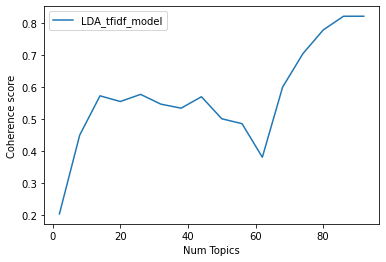

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
# Show graph
limit=98; start=2; step=6;
x = range(start, limit, step)
y_lda_tfidf = coherence_values_lda_tfidf

plt.plot(x, y_lda_tfidf, label='LDA_tfidf_model')
    
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")    
plt.legend()
plt.savefig('model_lda_tfidf_coherence_score.png')
plt.show()

In [55]:
# Print the coherence scores
for m, cv in zip(x, coherence_values_lda_tfidf):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2037
Num Topics = 8  has Coherence Value of 0.45
Num Topics = 14  has Coherence Value of 0.5727
Num Topics = 20  has Coherence Value of 0.5549
Num Topics = 26  has Coherence Value of 0.5772
Num Topics = 32  has Coherence Value of 0.5466
Num Topics = 38  has Coherence Value of 0.5341
Num Topics = 44  has Coherence Value of 0.5698
Num Topics = 50  has Coherence Value of 0.5011
Num Topics = 56  has Coherence Value of 0.4856
Num Topics = 62  has Coherence Value of 0.3808
Num Topics = 68  has Coherence Value of 0.5999
Num Topics = 74  has Coherence Value of 0.7044
Num Topics = 80  has Coherence Value of 0.7784
Num Topics = 86  has Coherence Value of 0.8213
Num Topics = 92  has Coherence Value of 0.8213


In [56]:
optimal_model_lda_tfidf = model_list_lda_tfidf[2]

In [57]:
optimal_model_lda_tfidf.show_topics()

[(7,
  '0.021*"worth" + 0.017*"confirm" + 0.016*"single" + 0.016*"exist" + 0.014*"multi" + 0.012*"brain" + 0.012*"picture" + 0.012*"instruction" + 0.012*"efficacy" + 0.012*"upcoming"'),
 (3,
  '0.041*"excel" + 0.022*"leader" + 0.019*"staff" + 0.018*"coach" + 0.015*"happy" + 0.015*"improvement" + 0.014*"clinical" + 0.014*"here" + 0.013*"medicine" + 0.013*"yet"'),
 (5,
  '0.015*"fun" + 0.014*"stem" + 0.013*"spot" + 0.013*"pretty" + 0.013*"proper" + 0.013*"accident" + 0.012*"organize" + 0.012*"guy" + 0.012*"wish" + 0.012*"migration"'),
 (1,
  '0.025*"worker" + 0.017*"food" + 0.015*"trump" + 0.013*"super" + 0.012*"date" + 0.012*"conclusion" + 0.011*"promote" + 0.011*"buy" + 0.011*"brilliant" + 0.011*"rapid"'),
 (13,
  '0.018*"interview" + 0.016*"amount" + 0.015*"player" + 0.014*"non" + 0.014*"iot" + 0.014*"location" + 0.013*"experiment" + 0.013*"device" + 0.013*"amazing" + 0.012*"various"'),
 (11,
  '0.030*"county" + 0.018*"black" + 0.016*"white" + 0.014*"building" + 0.014*"kill" + 0.014*"

In [58]:
vis_tfidf= gensimvis.prepare(optimal_model_lda_tfidf, corpus_tfidf, id2word )

/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [59]:
vis_tfidf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.426870  0.107520       1        1  50.036218
10     0.125258  0.371461       2        1  11.929880
12     0.096528  0.108323       3        1   8.714804
11     0.029799 -0.062180       4        1   3.798050
2      0.028635 -0.052617       5        1   3.777190
8      0.027532 -0.052406       6        1   3.749188
6      0.013373 -0.054688       7        1   3.204529
0      0.016479 -0.053749       8        1   2.391792
4      0.014892 -0.050029       9        1   2.321929
13     0.017828 -0.054811      10        1   2.300031
1      0.017144 -0.055591      11        1   2.129188
5      0.016496 -0.051637      12        1   2.098370
7      0.011876 -0.050612      13        1   1.784066
3      0.011029 -0.048983      14        1   1.764764, topic_info=               Term       Freq      Total Category  logprob  loglift
1526         county  35.000000  35.000000  Default  30.0000  30.0000
165     exploratory  32.000000  32.000000  Default  29.0000  29.0000
79             link  32.000000  32.000000  Default  28.0000  28.0000
1902          excel  22.000000  22.000000  Default  27.0000  27.0000
84           result  49.000000  49.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
2714          scene   3.750069   4.533389  Topic14  -4.9690   3.8475
685         correct   3.706052   4.489370  Topic14  -4.9808   3.8454
1055         profit   3.703887   4.487205  Topic14  -4.9814   3.8453
2622           wind   3.481911   4.265230  Topic14  -5.0432   3.8342
1238  investigation   6.896241  11.341764  Topic14  -4.3598   3.5396

[465 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2397      8  0.960203  accessible
2067     12  0.908775    accident
419       1  0.990680      accord
1076     12  0.925287      active
1144      3  0.932407     advance
...     ...       ...         ...
612      13  0.898281       worth
230       8  0.889623     writing
1157      4  0.977666       wrong
2447      5  0.869742   yesterday
1164     14  0.886706         yet

[450 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 11, 13, 12, 3, 9, 7, 1, 5, 14, 2, 6, 8, 4])

In [60]:
from wordcloud import WordCloud

In [61]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()

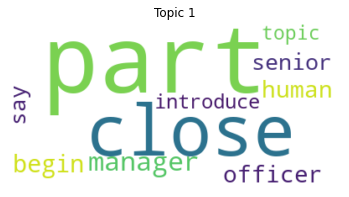

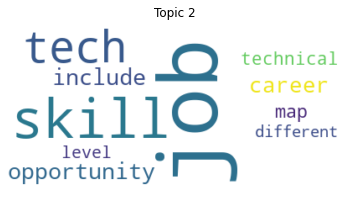

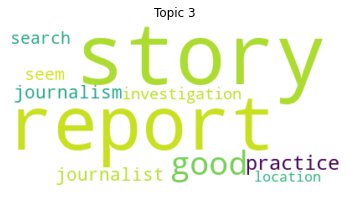

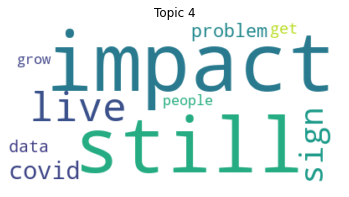

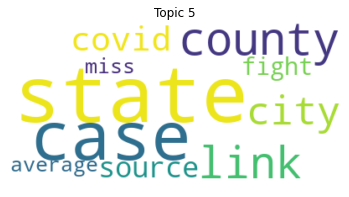

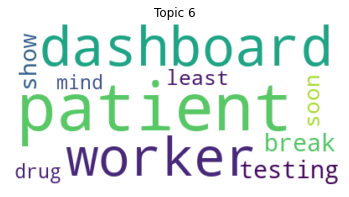

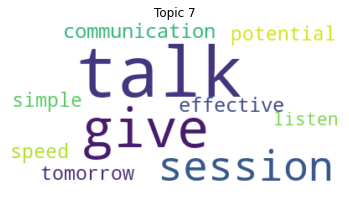

In [62]:
for i in range(1,8):
    create_wordcloud(optimal_model_lda, topic=i)

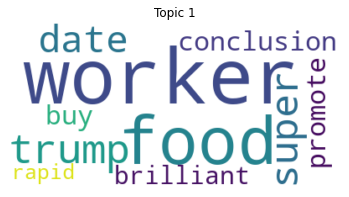

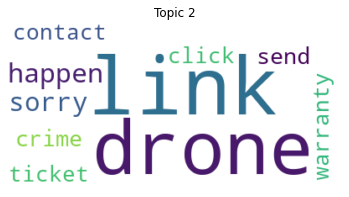

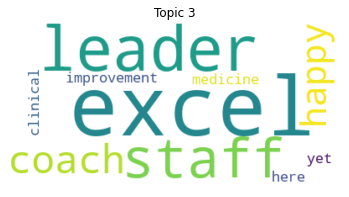

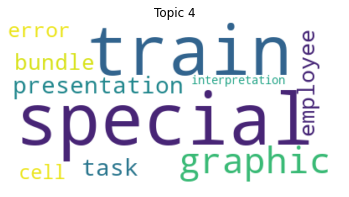

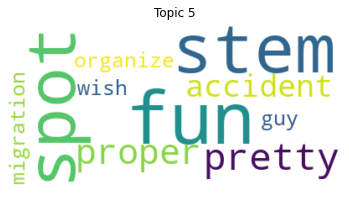

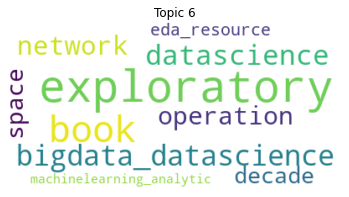

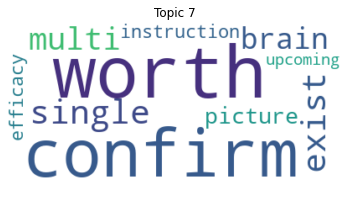

/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/usman/anaconda3/envs/CTM/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [63]:
for i in range(1,8):
    create_wordcloud(optimal_model_lda_tfidf, topic=i)